In [1]:
import tensorflow as tf
import os.path
from glob import glob
from tqdm import tqdm
import scipy.misc
import random


import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import numpy as np
import sys

#sys.path.append('vgg16-transfer-learning')
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = True


In [2]:
# load categories
with open('categories.txt') as f:
    cont = f.readlines()

cats = [x for x in cont]
print(len(cats))
print(cats[0])

# load labels
truth_text = dict()
truth_idx = dict()
import csv
with open('training_ground_truth.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)  # skip the headers
    for row in reader:
        truth_text[row[0]]=cats[int(row[1])-1]
        truth_idx[row[0]]=int(row[1])-1
        
data_folder = 'training'
image_paths = glob(os.path.join(data_folder, 'training_*.jpg'))
image_shape = (224,224)

print('number of samples', len(image_paths))
print(set(truth_idx.values()))

200
person, individual, someone, somebody, mortal, soul

number of samples 80000
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}


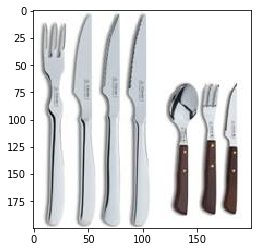

training_40205.jpg truth: table knife
 155
training/training_40205.jpg training_40205.jpg


In [3]:
num = random.randint(1,len(image_paths)+1)
img_label = 'training_' + str(num).zfill(5) + '.jpg'
img_path = 'training/'+img_label
img=mpimg.imread(img_path)
plt.imshow(img)
plt.show()
print(img_label, 'truth:', truth_text[img_label], truth_idx[img_label])
print(img_path,os.path.basename(img_path))

# transfer learning from pretrained VGG16

In [4]:
preprocess_input =  tf.keras.applications.vgg16.preprocess_input
decode_predictions =  tf.keras.applications.resnet50.decode_predictions

In [5]:
n_classes = 200
init_std = 0.001
learning_rate = 0.0005
target_shape = (224,224,3)

tf.reset_default_graph()
tf.keras.backend.clear_session()
vgg_net = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=target_shape,
    pooling=None,
    classes=n_classes
)

block1 = tf.get_default_graph().get_tensor_by_name("block1_conv2/Relu:0")
#deb_image = tf.reshape(tf.slice(block1,[0,0,0,0],[1,200,200,1]), [200,200])
#deb_image = tf.slice(block1,[0,0,0,0],[1,200,200,1])
#tf.summary.image('block1',deb_image,100)
input1 = tf.get_default_graph().get_tensor_by_name("input_1:0")

block5_pool = tf.get_default_graph().get_tensor_by_name("block5_pool/MaxPool:0")
unrolled = tf.layers.flatten(block5_pool)
with tf.variable_scope("I_want_to_train_only_these"):
    fc6 = tf.layers.dense(unrolled, 4096,activation=tf.nn.relu, 
                          kernel_initializer=tf.truncated_normal_initializer(stddev=init_std),
                          name = "fc6")
    fc7 = tf.layers.dense(fc6, 4096,activation=tf.nn.relu,
                          kernel_initializer=tf.truncated_normal_initializer(stddev=init_std),
                          name ="fc7")
    fc8 = tf.layers.dense(fc7, n_classes,
                          kernel_initializer=tf.truncated_normal_initializer(stddev=init_std),
                          name ="fc8")
prob = tf.nn.softmax(fc8, name="prob")

updatable_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='I_want_to_train_only_these')
with tf.variable_scope("Optimise"):
    # ## optimization and cost ops
    label = tf.placeholder(tf.int32, shape=(None),name = 'label')
    #one_hot_y = tf.one_hot(label, n_classes,name='onehot_output')
    loss = tf.losses.sparse_softmax_cross_entropy(logits=fc8, labels=label)
    tf.summary.scalar('loss', loss)
    optimiser = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_operation = optimiser.minimize(loss,var_list=updatable_variables)

opt_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Optimise')

In [6]:
def get_batches_fn(batch_size):
    """
    Create batches of training data
    :param batch_size: Batch Size
    :return: Batches of training data
    """
    data_folder = 'training'
    image_paths = glob(os.path.join(data_folder, 'training_*.jpg'))
    image_shape = (224,224)

    #print(len(image_paths))
    random.shuffle(image_paths)
    for batch_i in range(0, len(image_paths), batch_size):
        images = []
        gt = []
        for image_file in image_paths[batch_i:batch_i+batch_size]:
            try:
                gt_this = truth_idx[os.path.basename(image_file)]
                img_k = tf.keras.preprocessing.image.load_img(image_file, target_size=image_shape)
                img_r = tf.keras.preprocessing.image.img_to_array(img_k)
                img_r = preprocess_input(img_r)
            except:
                continue
            
            images.append(img_r)
            gt.append(gt_this)
            #plt.imshow(img_k)
            #plt.show()
            #print(gt_this, cat)
        #print(im_np[0,:,:,:])
        #print(qt_np[0])
        qt_np = np.array(gt)#,dtype = np.int
        im_np = np.array(images) # ,dtype=np.float32
        yield im_np, qt_np

In [9]:
batch_size = 100
epochs = 250

def get_accuracy_of_batch(y,prob):
    y_net = np.argmax(prob,axis=1)
    num = y_net.shape[0]
    matches = (y_net == y)
    acc = np.sum(matches)/num;
    return acc


saver = tf.train.Saver()
#nm = "ckps/model" + datetime.datetime.now().strftime("_%I_%M%p_%B_%d_%Y") +".ckpt"
nm = "ckps/model_v1.ckpt"


with tf.Session(config=config) as sess:
    merged = tf.summary.merge_all()
    #sess.run(tf.variables_initializer(updatable_variables+opt_vars))
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    writer = tf.summary.FileWriter('./TFlog', tf.get_default_graph())
    target = [training_operation, loss,merged,prob] # , merged ,deb_image

    idx = 0
    for i in range(epochs):#tqdm(range(epochs))
        batch_index = 0
        for batch_x, batch_y in get_batches_fn(batch_size):
            batch_index += 1
            feed_dict = {input1: batch_x, label: batch_y}
            out = sess.run(target, feed_dict = feed_dict)
            acc = get_accuracy_of_batch(batch_y,out[3])
            writer.add_summary(out[2],idx)
            idx = idx +1
            print("Epoch: {} batch: {} loss: {} batch accu: {}"
                  .format(i+1,batch_index,out[1],acc))
        print("===================================================")
        if (i % 25 == 0):
            saver.save(sess, nm,global_step=i)

Epoch: 1 batch: 1 loss: 5.2983174324035645 batch accu: 0.02
Epoch: 1 batch: 2 loss: 5.29411506652832 batch accu: 0.02
Epoch: 1 batch: 3 loss: 5.315566539764404 batch accu: 0.01
Epoch: 1 batch: 4 loss: 5.296776294708252 batch accu: 0.01
Epoch: 1 batch: 5 loss: 5.299358367919922 batch accu: 0.01
Epoch: 1 batch: 6 loss: 5.299445152282715 batch accu: 0.0
Epoch: 1 batch: 7 loss: 5.297648906707764 batch accu: 0.0
Epoch: 1 batch: 8 loss: 5.299013137817383 batch accu: 0.0
Epoch: 1 batch: 9 loss: 5.2943806648254395 batch accu: 0.01
Epoch: 1 batch: 10 loss: 5.299395561218262 batch accu: 0.0
Epoch: 1 batch: 11 loss: 5.3013715744018555 batch accu: 0.01
Epoch: 1 batch: 12 loss: 5.2912278175354 batch accu: 0.01
Epoch: 1 batch: 13 loss: 5.311954498291016 batch accu: 0.0
Epoch: 1 batch: 14 loss: 5.303417205810547 batch accu: 0.0
Epoch: 1 batch: 15 loss: 5.2967119216918945 batch accu: 0.0
Epoch: 1 batch: 16 loss: 5.296901226043701 batch accu: 0.01
Epoch: 1 batch: 17 loss: 5.29879903793335 batch accu: 0

/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6291456 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 655924 bytes but only got 65. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


Epoch: 1 batch: 40 loss: 5.297786712646484 batch accu: 0.0
Epoch: 1 batch: 41 loss: 5.296526908874512 batch accu: 0.01
Epoch: 1 batch: 42 loss: 5.2974138259887695 batch accu: 0.01
Epoch: 1 batch: 43 loss: 5.298681259155273 batch accu: 0.0
Epoch: 1 batch: 44 loss: 5.302545070648193 batch accu: 0.0


/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 22937600 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284257280 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2719285248 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Epoch: 1 batch: 45 loss: 5.297191143035889 batch accu: 0.02
Epoch: 1 batch: 46 loss: 5.2948198318481445 batch accu: 0.01
Epoch: 1 batch: 47 loss: 5.298697471618652 batch accu: 0.0
Epoch: 1 batch: 48 loss: 5.302082538604736 batch accu: 0.0
Epoch: 1 batch: 49 loss: 5.299176216125488 batch accu: 0.01
Epoch: 1 batch: 50 loss: 5.297452926635742 batch accu: 0.01
Epoch: 1 batch: 51 loss: 5.298426628112793 batch accu: 0.01
Epoch: 1 batch: 52 loss: 5.298444747924805 batch accu: 0.01
Epoch: 1 batch: 53 loss: 5.293383598327637 batch accu: 0.0
Epoch: 1 batch: 54 loss: 5.30319356918335 batch accu: 0.0
Epoch: 1 batch: 55 loss: 5.2999267578125 batch accu: 0.0
Epoch: 1 batch: 56 loss: 5.29609489440918 batch accu: 0.0
Epoch: 1 batch: 57 loss: 5.303359508514404 batch accu: 0.0
Epoch: 1 batch: 58 loss: 5.298817157745361 batch accu: 0.02
Epoch: 1 batch: 59 loss: 5.295844078063965 batch accu: 0.01
Epoch: 1 batch: 60 loss: 5.2978739738464355 batch accu: 0.0
Epoch: 1 batch: 61 loss: 5.298956871032715 batch a

/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 35520512 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20054016 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 34865152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-

Epoch: 1 batch: 122 loss: 5.292172431945801 batch accu: 0.01
Epoch: 1 batch: 123 loss: 5.300772190093994 batch accu: 0.0
Epoch: 1 batch: 124 loss: 5.277560234069824 batch accu: 0.0
Epoch: 1 batch: 125 loss: 5.302739143371582 batch accu: 0.01
Epoch: 1 batch: 126 loss: 5.3023505210876465 batch accu: 0.01
Epoch: 1 batch: 127 loss: 5.274356842041016 batch accu: 0.04
Epoch: 1 batch: 128 loss: 5.301653861999512 batch accu: 0.0
Epoch: 1 batch: 129 loss: 5.290342330932617 batch accu: 0.01
Epoch: 1 batch: 130 loss: 5.293587684631348 batch accu: 0.0
Epoch: 1 batch: 131 loss: 5.3006486892700195 batch accu: 0.02
Epoch: 1 batch: 132 loss: 5.296548843383789 batch accu: 0.01
Epoch: 1 batch: 133 loss: 5.292558670043945 batch accu: 0.01
Epoch: 1 batch: 134 loss: 5.290225028991699 batch accu: 0.0
Epoch: 1 batch: 135 loss: 5.2935261726379395 batch accu: 0.0
Epoch: 1 batch: 136 loss: 5.300309658050537 batch accu: 0.0
Epoch: 1 batch: 137 loss: 5.284245491027832 batch accu: 0.01
Epoch: 1 batch: 138 loss: 5.

/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


Epoch: 1 batch: 163 loss: 5.295994281768799 batch accu: 0.01
Epoch: 1 batch: 164 loss: 5.2867326736450195 batch accu: 0.0
Epoch: 1 batch: 165 loss: 5.286689281463623 batch accu: 0.01
Epoch: 1 batch: 166 loss: 5.278334140777588 batch accu: 0.0
Epoch: 1 batch: 167 loss: 5.261438369750977 batch accu: 0.01
Epoch: 1 batch: 168 loss: 5.2936882972717285 batch accu: 0.0
Epoch: 1 batch: 169 loss: 5.33632755279541 batch accu: 0.0
Epoch: 1 batch: 170 loss: 5.284149646759033 batch accu: 0.0
Epoch: 1 batch: 171 loss: 5.2475738525390625 batch accu: 0.01
Epoch: 1 batch: 172 loss: 5.262481689453125 batch accu: 0.01
Epoch: 1 batch: 173 loss: 5.259584903717041 batch accu: 0.01
Epoch: 1 batch: 174 loss: 5.286652088165283 batch accu: 0.0
Epoch: 1 batch: 175 loss: 5.2531304359436035 batch accu: 0.01
Epoch: 1 batch: 176 loss: 5.244794845581055 batch accu: 0.01
Epoch: 1 batch: 177 loss: 5.277421474456787 batch accu: 0.0
Epoch: 1 batch: 178 loss: 5.274781703948975 batch accu: 0.0
Epoch: 1 batch: 179 loss: 5.2

Epoch: 1 batch: 298 loss: 5.306772232055664 batch accu: 0.01
Epoch: 1 batch: 299 loss: 5.2896833419799805 batch accu: 0.0
Epoch: 1 batch: 300 loss: 5.179676055908203 batch accu: 0.02
Epoch: 1 batch: 301 loss: 5.2526140213012695 batch accu: 0.01
Epoch: 1 batch: 302 loss: 5.227428436279297 batch accu: 0.01
Epoch: 1 batch: 303 loss: 5.198968410491943 batch accu: 0.01
Epoch: 1 batch: 304 loss: 5.239648818969727 batch accu: 0.0
Epoch: 1 batch: 305 loss: 5.214981555938721 batch accu: 0.0
Epoch: 1 batch: 306 loss: 5.1688055992126465 batch accu: 0.02
Epoch: 1 batch: 307 loss: 5.222299575805664 batch accu: 0.01
Epoch: 1 batch: 308 loss: 5.202048301696777 batch accu: 0.0
Epoch: 1 batch: 309 loss: 5.2388916015625 batch accu: 0.0
Epoch: 1 batch: 310 loss: 5.267242431640625 batch accu: 0.0
Epoch: 1 batch: 311 loss: 5.186037063598633 batch accu: 0.0
Epoch: 1 batch: 312 loss: 5.2276105880737305 batch accu: 0.0
Epoch: 1 batch: 313 loss: 5.2070536613464355 batch accu: 0.04
Epoch: 1 batch: 314 loss: 5.2

/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19988480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Epoch: 1 batch: 423 loss: 5.158979892730713 batch accu: 0.0
Epoch: 1 batch: 424 loss: 5.19154167175293 batch accu: 0.0
Epoch: 1 batch: 425 loss: 5.144093036651611 batch accu: 0.0
Epoch: 1 batch: 426 loss: 5.130964279174805 batch accu: 0.0
Epoch: 1 batch: 427 loss: 5.165811061859131 batch accu: 0.0
Epoch: 1 batch: 428 loss: 5.214985370635986 batch accu: 0.02
Epoch: 1 batch: 429 loss: 5.1863932609558105 batch accu: 0.0
Epoch: 1 batch: 430 loss: 5.14016580581665 batch accu: 0.0
Epoch: 1 batch: 431 loss: 5.174294471740723 batch accu: 0.0
Epoch: 1 batch: 432 loss: 5.1225714683532715 batch accu: 0.02
Epoch: 1 batch: 433 loss: 5.2063727378845215 batch accu: 0.01
Epoch: 1 batch: 434 loss: 5.219451904296875 batch accu: 0.02
Epoch: 1 batch: 435 loss: 5.202398300170898 batch accu: 0.01
Epoch: 1 batch: 436 loss: 5.290428638458252 batch accu: 0.0
Epoch: 1 batch: 437 loss: 5.235626697540283 batch accu: 0.0
Epoch: 1 batch: 438 loss: 5.137406826019287 batch accu: 0.01
Epoch: 1 batch: 439 loss: 5.15985

Epoch: 1 batch: 559 loss: 5.245702743530273 batch accu: 0.0
Epoch: 1 batch: 560 loss: 5.186955451965332 batch accu: 0.0
Epoch: 1 batch: 561 loss: 5.102014064788818 batch accu: 0.0
Epoch: 1 batch: 562 loss: 5.161867141723633 batch accu: 0.01
Epoch: 1 batch: 563 loss: 5.181998252868652 batch accu: 0.01
Epoch: 1 batch: 564 loss: 5.1495161056518555 batch accu: 0.02
Epoch: 1 batch: 565 loss: 5.131694316864014 batch accu: 0.01


/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Epoch: 1 batch: 566 loss: 5.152085781097412 batch accu: 0.02
Epoch: 1 batch: 567 loss: 5.146719932556152 batch accu: 0.0
Epoch: 1 batch: 568 loss: 5.186478137969971 batch accu: 0.0
Epoch: 1 batch: 569 loss: 5.090208053588867 batch accu: 0.01
Epoch: 1 batch: 570 loss: 5.158647060394287 batch accu: 0.0
Epoch: 1 batch: 571 loss: 5.117590427398682 batch accu: 0.0
Epoch: 1 batch: 572 loss: 5.273659706115723 batch accu: 0.0
Epoch: 1 batch: 573 loss: 5.149092197418213 batch accu: 0.01
Epoch: 1 batch: 574 loss: 5.1068501472473145 batch accu: 0.0
Epoch: 1 batch: 575 loss: 5.256591796875 batch accu: 0.01
Epoch: 1 batch: 576 loss: 5.10795783996582 batch accu: 0.02
Epoch: 1 batch: 577 loss: 5.118084907531738 batch accu: 0.03
Epoch: 1 batch: 578 loss: 5.246892929077148 batch accu: 0.0
Epoch: 1 batch: 579 loss: 5.112015724182129 batch accu: 0.02
Epoch: 1 batch: 580 loss: 5.14651346206665 batch accu: 0.01
Epoch: 1 batch: 581 loss: 5.172384262084961 batch accu: 0.03
Epoch: 1 batch: 582 loss: 5.1866197

Epoch: 1 batch: 701 loss: 5.199815273284912 batch accu: 0.0
Epoch: 1 batch: 702 loss: 5.10321044921875 batch accu: 0.03
Epoch: 1 batch: 703 loss: 5.172934055328369 batch accu: 0.01
Epoch: 1 batch: 704 loss: 5.148544788360596 batch accu: 0.0
Epoch: 1 batch: 705 loss: 5.179114818572998 batch accu: 0.02
Epoch: 1 batch: 706 loss: 5.144753932952881 batch accu: 0.01
Epoch: 1 batch: 707 loss: 5.184749603271484 batch accu: 0.01
Epoch: 1 batch: 708 loss: 5.147205829620361 batch accu: 0.02
Epoch: 1 batch: 709 loss: 5.1343255043029785 batch accu: 0.0
Epoch: 1 batch: 710 loss: 5.090256214141846 batch accu: 0.01
Epoch: 1 batch: 711 loss: 5.149806499481201 batch accu: 0.01
Epoch: 1 batch: 712 loss: 5.1350226402282715 batch accu: 0.03
Epoch: 1 batch: 713 loss: 5.240642547607422 batch accu: 0.02
Epoch: 1 batch: 714 loss: 5.131402015686035 batch accu: 0.0
Epoch: 1 batch: 715 loss: 5.092717170715332 batch accu: 0.01
Epoch: 1 batch: 716 loss: 5.2585272789001465 batch accu: 0.0
Epoch: 1 batch: 717 loss: 5

Epoch: 2 batch: 36 loss: 5.101056098937988 batch accu: 0.04
Epoch: 2 batch: 37 loss: 5.228384971618652 batch accu: 0.01
Epoch: 2 batch: 38 loss: 5.122014999389648 batch accu: 0.01
Epoch: 2 batch: 39 loss: 5.227133274078369 batch accu: 0.0
Epoch: 2 batch: 40 loss: 5.156912326812744 batch accu: 0.01
Epoch: 2 batch: 41 loss: 5.095393657684326 batch accu: 0.01
Epoch: 2 batch: 42 loss: 5.163680553436279 batch accu: 0.01
Epoch: 2 batch: 43 loss: 5.25764274597168 batch accu: 0.0
Epoch: 2 batch: 44 loss: 5.120914936065674 batch accu: 0.02
Epoch: 2 batch: 45 loss: 5.133963584899902 batch accu: 0.01
Epoch: 2 batch: 46 loss: 5.149233341217041 batch accu: 0.01
Epoch: 2 batch: 47 loss: 5.083314418792725 batch accu: 0.0
Epoch: 2 batch: 48 loss: 5.161786079406738 batch accu: 0.01
Epoch: 2 batch: 49 loss: 5.193365573883057 batch accu: 0.04
Epoch: 2 batch: 50 loss: 5.178323268890381 batch accu: 0.0
Epoch: 2 batch: 51 loss: 5.21440315246582 batch accu: 0.01
Epoch: 2 batch: 52 loss: 5.0795416831970215 ba

Epoch: 2 batch: 172 loss: 5.029073715209961 batch accu: 0.03
Epoch: 2 batch: 173 loss: 5.125704288482666 batch accu: 0.03
Epoch: 2 batch: 174 loss: 5.192519664764404 batch accu: 0.01
Epoch: 2 batch: 175 loss: 5.14427375793457 batch accu: 0.0
Epoch: 2 batch: 176 loss: 5.153176784515381 batch accu: 0.01
Epoch: 2 batch: 177 loss: 5.054000377655029 batch accu: 0.0
Epoch: 2 batch: 178 loss: 5.169496536254883 batch accu: 0.0
Epoch: 2 batch: 179 loss: 5.1551055908203125 batch accu: 0.0
Epoch: 2 batch: 180 loss: 5.170323371887207 batch accu: 0.0
Epoch: 2 batch: 181 loss: 5.1172637939453125 batch accu: 0.0
Epoch: 2 batch: 182 loss: 5.123659133911133 batch accu: 0.0
Epoch: 2 batch: 183 loss: 5.198807239532471 batch accu: 0.01
Epoch: 2 batch: 184 loss: 5.103634834289551 batch accu: 0.01
Epoch: 2 batch: 185 loss: 5.135617733001709 batch accu: 0.03
Epoch: 2 batch: 186 loss: 5.074068069458008 batch accu: 0.01
Epoch: 2 batch: 187 loss: 5.165825366973877 batch accu: 0.01
Epoch: 2 batch: 188 loss: 5.07

Epoch: 2 batch: 307 loss: 5.1084513664245605 batch accu: 0.0
Epoch: 2 batch: 308 loss: 5.177812099456787 batch accu: 0.0
Epoch: 2 batch: 309 loss: 5.0689377784729 batch accu: 0.02
Epoch: 2 batch: 310 loss: 5.17946720123291 batch accu: 0.0
Epoch: 2 batch: 311 loss: 5.060606002807617 batch accu: 0.02
Epoch: 2 batch: 312 loss: 5.085838794708252 batch accu: 0.01
Epoch: 2 batch: 313 loss: 5.115453720092773 batch accu: 0.03
Epoch: 2 batch: 314 loss: 5.207395553588867 batch accu: 0.0
Epoch: 2 batch: 315 loss: 5.188672065734863 batch accu: 0.01
Epoch: 2 batch: 316 loss: 5.201946258544922 batch accu: 0.01
Epoch: 2 batch: 317 loss: 5.0243000984191895 batch accu: 0.01
Epoch: 2 batch: 318 loss: 5.192371845245361 batch accu: 0.03
Epoch: 2 batch: 319 loss: 5.063223361968994 batch accu: 0.03
Epoch: 2 batch: 320 loss: 5.141812324523926 batch accu: 0.03
Epoch: 2 batch: 321 loss: 5.169008255004883 batch accu: 0.0
Epoch: 2 batch: 322 loss: 5.044132232666016 batch accu: 0.02
Epoch: 2 batch: 323 loss: 5.08

Epoch: 2 batch: 442 loss: 5.067976951599121 batch accu: 0.03
Epoch: 2 batch: 443 loss: 5.157559871673584 batch accu: 0.01
Epoch: 2 batch: 444 loss: 5.173513412475586 batch accu: 0.02
Epoch: 2 batch: 445 loss: 5.065481662750244 batch accu: 0.03
Epoch: 2 batch: 446 loss: 5.053717136383057 batch accu: 0.0
Epoch: 2 batch: 447 loss: 5.104576587677002 batch accu: 0.02
Epoch: 2 batch: 448 loss: 5.083592414855957 batch accu: 0.02
Epoch: 2 batch: 449 loss: 5.133559703826904 batch accu: 0.02
Epoch: 2 batch: 450 loss: 5.0803446769714355 batch accu: 0.02
Epoch: 2 batch: 451 loss: 5.0745530128479 batch accu: 0.01
Epoch: 2 batch: 452 loss: 5.080499172210693 batch accu: 0.02
Epoch: 2 batch: 453 loss: 5.146673202514648 batch accu: 0.0
Epoch: 2 batch: 454 loss: 5.112945079803467 batch accu: 0.0
Epoch: 2 batch: 455 loss: 5.116219520568848 batch accu: 0.04
Epoch: 2 batch: 456 loss: 5.079294204711914 batch accu: 0.02
Epoch: 2 batch: 457 loss: 5.112728118896484 batch accu: 0.01
Epoch: 2 batch: 458 loss: 5.

Epoch: 2 batch: 577 loss: 4.9620137214660645 batch accu: 0.0
Epoch: 2 batch: 578 loss: 5.033534049987793 batch accu: 0.03
Epoch: 2 batch: 579 loss: 5.057928085327148 batch accu: 0.01
Epoch: 2 batch: 580 loss: 4.999575138092041 batch accu: 0.02
Epoch: 2 batch: 581 loss: 5.112275123596191 batch accu: 0.0
Epoch: 2 batch: 582 loss: 5.206180572509766 batch accu: 0.0
Epoch: 2 batch: 583 loss: 4.984960556030273 batch accu: 0.03
Epoch: 2 batch: 584 loss: 4.98429012298584 batch accu: 0.06
Epoch: 2 batch: 585 loss: 5.1814866065979 batch accu: 0.01
Epoch: 2 batch: 586 loss: 5.033813953399658 batch accu: 0.03
Epoch: 2 batch: 587 loss: 5.090724468231201 batch accu: 0.01
Epoch: 2 batch: 588 loss: 5.0733771324157715 batch accu: 0.02
Epoch: 2 batch: 589 loss: 5.0868401527404785 batch accu: 0.0
Epoch: 2 batch: 590 loss: 5.044766426086426 batch accu: 0.01
Epoch: 2 batch: 591 loss: 5.118697643280029 batch accu: 0.02
Epoch: 2 batch: 592 loss: 5.117516994476318 batch accu: 0.01
Epoch: 2 batch: 593 loss: 4.

Epoch: 2 batch: 712 loss: 5.171960353851318 batch accu: 0.01
Epoch: 2 batch: 713 loss: 5.0522661209106445 batch accu: 0.01
Epoch: 2 batch: 714 loss: 5.168673515319824 batch accu: 0.03
Epoch: 2 batch: 715 loss: 5.0373148918151855 batch accu: 0.02
Epoch: 2 batch: 716 loss: 5.167443752288818 batch accu: 0.04
Epoch: 2 batch: 717 loss: 5.044578552246094 batch accu: 0.04
Epoch: 2 batch: 718 loss: 5.018814563751221 batch accu: 0.0
Epoch: 2 batch: 719 loss: 5.007727146148682 batch accu: 0.01
Epoch: 2 batch: 720 loss: 4.914125442504883 batch accu: 0.02
Epoch: 2 batch: 721 loss: 5.086332321166992 batch accu: 0.03
Epoch: 2 batch: 722 loss: 4.955529689788818 batch accu: 0.03
Epoch: 2 batch: 723 loss: 4.965353965759277 batch accu: 0.03
Epoch: 2 batch: 724 loss: 4.953520774841309 batch accu: 0.03
Epoch: 2 batch: 725 loss: 5.040683746337891 batch accu: 0.02
Epoch: 2 batch: 726 loss: 5.0660319328308105 batch accu: 0.01
Epoch: 2 batch: 727 loss: 5.011075973510742 batch accu: 0.03
Epoch: 2 batch: 728 lo

Epoch: 3 batch: 47 loss: 4.97249174118042 batch accu: 0.04
Epoch: 3 batch: 48 loss: 5.2014265060424805 batch accu: 0.02
Epoch: 3 batch: 49 loss: 4.971707344055176 batch accu: 0.05
Epoch: 3 batch: 50 loss: 5.02960205078125 batch accu: 0.01
Epoch: 3 batch: 51 loss: 4.952898025512695 batch accu: 0.02
Epoch: 3 batch: 52 loss: 4.932737827301025 batch accu: 0.02
Epoch: 3 batch: 53 loss: 5.110008716583252 batch accu: 0.0
Epoch: 3 batch: 54 loss: 5.080921173095703 batch accu: 0.05
Epoch: 3 batch: 55 loss: 4.938095569610596 batch accu: 0.06
Epoch: 3 batch: 56 loss: 5.075117111206055 batch accu: 0.01
Epoch: 3 batch: 57 loss: 5.0476393699646 batch accu: 0.03
Epoch: 3 batch: 58 loss: 5.052412033081055 batch accu: 0.01
Epoch: 3 batch: 59 loss: 4.9990973472595215 batch accu: 0.06
Epoch: 3 batch: 60 loss: 5.038801670074463 batch accu: 0.04
Epoch: 3 batch: 61 loss: 5.042717456817627 batch accu: 0.03
Epoch: 3 batch: 62 loss: 5.011740207672119 batch accu: 0.04
Epoch: 3 batch: 63 loss: 4.968352794647217 

Epoch: 3 batch: 183 loss: 5.090469837188721 batch accu: 0.02
Epoch: 3 batch: 184 loss: 5.025995254516602 batch accu: 0.01
Epoch: 3 batch: 185 loss: 4.961583614349365 batch accu: 0.01
Epoch: 3 batch: 186 loss: 4.903031349182129 batch accu: 0.04
Epoch: 3 batch: 187 loss: 5.098691940307617 batch accu: 0.03
Epoch: 3 batch: 188 loss: 4.9281086921691895 batch accu: 0.03
Epoch: 3 batch: 189 loss: 4.821680068969727 batch accu: 0.04
Epoch: 3 batch: 190 loss: 5.028473854064941 batch accu: 0.03
Epoch: 3 batch: 191 loss: 5.018566608428955 batch accu: 0.0
Epoch: 3 batch: 192 loss: 5.0239667892456055 batch accu: 0.01
Epoch: 3 batch: 193 loss: 5.09748649597168 batch accu: 0.02
Epoch: 3 batch: 194 loss: 4.96200704574585 batch accu: 0.02
Epoch: 3 batch: 195 loss: 4.9714460372924805 batch accu: 0.04
Epoch: 3 batch: 196 loss: 4.995586395263672 batch accu: 0.02
Epoch: 3 batch: 197 loss: 4.893239498138428 batch accu: 0.02
Epoch: 3 batch: 198 loss: 4.94539213180542 batch accu: 0.03
Epoch: 3 batch: 199 loss:

Epoch: 3 batch: 318 loss: 4.912060737609863 batch accu: 0.02
Epoch: 3 batch: 319 loss: 4.854133129119873 batch accu: 0.02
Epoch: 3 batch: 320 loss: 4.954892158508301 batch accu: 0.03
Epoch: 3 batch: 321 loss: 5.0635600090026855 batch accu: 0.0
Epoch: 3 batch: 322 loss: 4.931783199310303 batch accu: 0.04
Epoch: 3 batch: 323 loss: 5.066913604736328 batch accu: 0.02
Epoch: 3 batch: 324 loss: 4.974891185760498 batch accu: 0.02
Epoch: 3 batch: 325 loss: 5.002440929412842 batch accu: 0.02
Epoch: 3 batch: 326 loss: 4.981572151184082 batch accu: 0.03
Epoch: 3 batch: 327 loss: 4.98750114440918 batch accu: 0.05
Epoch: 3 batch: 328 loss: 4.962096691131592 batch accu: 0.03
Epoch: 3 batch: 329 loss: 4.882706642150879 batch accu: 0.06
Epoch: 3 batch: 330 loss: 5.051517009735107 batch accu: 0.02
Epoch: 3 batch: 331 loss: 4.832128524780273 batch accu: 0.04
Epoch: 3 batch: 332 loss: 4.915902614593506 batch accu: 0.02
Epoch: 3 batch: 333 loss: 4.962723255157471 batch accu: 0.01
Epoch: 3 batch: 334 loss:

Epoch: 3 batch: 453 loss: 4.8925981521606445 batch accu: 0.02
Epoch: 3 batch: 454 loss: 4.901477813720703 batch accu: 0.02
Epoch: 3 batch: 455 loss: 4.8268842697143555 batch accu: 0.07
Epoch: 3 batch: 456 loss: 4.811847686767578 batch accu: 0.05
Epoch: 3 batch: 457 loss: 5.006338119506836 batch accu: 0.01
Epoch: 3 batch: 458 loss: 4.951958179473877 batch accu: 0.01
Epoch: 3 batch: 459 loss: 4.777337551116943 batch accu: 0.1
Epoch: 3 batch: 460 loss: 4.862983226776123 batch accu: 0.03
Epoch: 3 batch: 461 loss: 4.948955535888672 batch accu: 0.03
Epoch: 3 batch: 462 loss: 4.965974807739258 batch accu: 0.0
Epoch: 3 batch: 463 loss: 4.966745376586914 batch accu: 0.0
Epoch: 3 batch: 464 loss: 4.976411819458008 batch accu: 0.02
Epoch: 3 batch: 465 loss: 4.887836456298828 batch accu: 0.04
Epoch: 3 batch: 466 loss: 4.912978172302246 batch accu: 0.04
Epoch: 3 batch: 467 loss: 4.85984468460083 batch accu: 0.05
Epoch: 3 batch: 468 loss: 4.9780988693237305 batch accu: 0.02
Epoch: 3 batch: 469 loss:

Epoch: 3 batch: 587 loss: 4.941251277923584 batch accu: 0.02
Epoch: 3 batch: 588 loss: 4.899414539337158 batch accu: 0.03
Epoch: 3 batch: 589 loss: 5.047919750213623 batch accu: 0.03
Epoch: 3 batch: 590 loss: 4.882777214050293 batch accu: 0.05
Epoch: 3 batch: 591 loss: 4.857606887817383 batch accu: 0.02
Epoch: 3 batch: 592 loss: 4.810115337371826 batch accu: 0.01
Epoch: 3 batch: 593 loss: 4.862929821014404 batch accu: 0.02
Epoch: 3 batch: 594 loss: 4.760091304779053 batch accu: 0.04
Epoch: 3 batch: 595 loss: 4.883983612060547 batch accu: 0.03
Epoch: 3 batch: 596 loss: 4.811675548553467 batch accu: 0.04
Epoch: 3 batch: 597 loss: 4.81623649597168 batch accu: 0.04
Epoch: 3 batch: 598 loss: 4.886178970336914 batch accu: 0.02
Epoch: 3 batch: 599 loss: 4.824824333190918 batch accu: 0.06
Epoch: 3 batch: 600 loss: 4.706220626831055 batch accu: 0.07
Epoch: 3 batch: 601 loss: 4.866548538208008 batch accu: 0.04
Epoch: 3 batch: 602 loss: 4.757540702819824 batch accu: 0.07
Epoch: 3 batch: 603 loss:

Epoch: 3 batch: 722 loss: 4.76268196105957 batch accu: 0.03
Epoch: 3 batch: 723 loss: 4.880603790283203 batch accu: 0.04
Epoch: 3 batch: 724 loss: 4.803473949432373 batch accu: 0.05
Epoch: 3 batch: 725 loss: 4.873501777648926 batch accu: 0.03
Epoch: 3 batch: 726 loss: 4.959479808807373 batch accu: 0.03
Epoch: 3 batch: 727 loss: 4.922982215881348 batch accu: 0.03
Epoch: 3 batch: 728 loss: 4.673101902008057 batch accu: 0.04
Epoch: 3 batch: 729 loss: 4.765388488769531 batch accu: 0.05
Epoch: 3 batch: 730 loss: 4.913613319396973 batch accu: 0.02
Epoch: 3 batch: 731 loss: 4.838788032531738 batch accu: 0.06
Epoch: 3 batch: 732 loss: 4.8212995529174805 batch accu: 0.04
Epoch: 3 batch: 733 loss: 4.840611457824707 batch accu: 0.020202020202020204
Epoch: 3 batch: 734 loss: 4.927677631378174 batch accu: 0.01
Epoch: 3 batch: 735 loss: 4.779076099395752 batch accu: 0.01
Epoch: 3 batch: 736 loss: 4.914951801300049 batch accu: 0.05
Epoch: 3 batch: 737 loss: 4.7671284675598145 batch accu: 0.03
Epoch: 

Epoch: 4 batch: 57 loss: 4.771057605743408 batch accu: 0.01
Epoch: 4 batch: 58 loss: 4.888617038726807 batch accu: 0.05
Epoch: 4 batch: 59 loss: 4.875102519989014 batch accu: 0.04
Epoch: 4 batch: 60 loss: 5.03374719619751 batch accu: 0.0
Epoch: 4 batch: 61 loss: 4.969460964202881 batch accu: 0.03
Epoch: 4 batch: 62 loss: 4.748897552490234 batch accu: 0.04
Epoch: 4 batch: 63 loss: 4.841634750366211 batch accu: 0.05
Epoch: 4 batch: 64 loss: 4.971306800842285 batch accu: 0.03
Epoch: 4 batch: 65 loss: 4.9154133796691895 batch accu: 0.02
Epoch: 4 batch: 66 loss: 4.975442409515381 batch accu: 0.02
Epoch: 4 batch: 67 loss: 4.680019378662109 batch accu: 0.05
Epoch: 4 batch: 68 loss: 4.847618103027344 batch accu: 0.03
Epoch: 4 batch: 69 loss: 4.900693893432617 batch accu: 0.04
Epoch: 4 batch: 70 loss: 4.862305164337158 batch accu: 0.07
Epoch: 4 batch: 71 loss: 4.753666877746582 batch accu: 0.02
Epoch: 4 batch: 72 loss: 4.752412796020508 batch accu: 0.02
Epoch: 4 batch: 73 loss: 4.80707597732543

Epoch: 4 batch: 192 loss: 4.766501426696777 batch accu: 0.02
Epoch: 4 batch: 193 loss: 4.900373458862305 batch accu: 0.01
Epoch: 4 batch: 194 loss: 4.836050987243652 batch accu: 0.02
Epoch: 4 batch: 195 loss: 4.729886054992676 batch accu: 0.02
Epoch: 4 batch: 196 loss: 4.831930637359619 batch accu: 0.0
Epoch: 4 batch: 197 loss: 4.8550190925598145 batch accu: 0.03
Epoch: 4 batch: 198 loss: 4.688378810882568 batch accu: 0.04
Epoch: 4 batch: 199 loss: 4.882720947265625 batch accu: 0.0
Epoch: 4 batch: 200 loss: 4.8993353843688965 batch accu: 0.02
Epoch: 4 batch: 201 loss: 4.921448230743408 batch accu: 0.01
Epoch: 4 batch: 202 loss: 4.8336992263793945 batch accu: 0.03
Epoch: 4 batch: 203 loss: 4.812753200531006 batch accu: 0.01
Epoch: 4 batch: 204 loss: 4.764908313751221 batch accu: 0.04
Epoch: 4 batch: 205 loss: 4.87408447265625 batch accu: 0.01
Epoch: 4 batch: 206 loss: 4.7811455726623535 batch accu: 0.04
Epoch: 4 batch: 207 loss: 4.923587799072266 batch accu: 0.03
Epoch: 4 batch: 208 los

Epoch: 4 batch: 327 loss: 4.891915798187256 batch accu: 0.04
Epoch: 4 batch: 328 loss: 4.739862442016602 batch accu: 0.02
Epoch: 4 batch: 329 loss: 4.966205596923828 batch accu: 0.02
Epoch: 4 batch: 330 loss: 4.743276596069336 batch accu: 0.03
Epoch: 4 batch: 331 loss: 4.818151473999023 batch accu: 0.03
Epoch: 4 batch: 332 loss: 4.978559970855713 batch accu: 0.02
Epoch: 4 batch: 333 loss: 4.813961029052734 batch accu: 0.05
Epoch: 4 batch: 334 loss: 4.813370227813721 batch accu: 0.01
Epoch: 4 batch: 335 loss: 4.699419021606445 batch accu: 0.06
Epoch: 4 batch: 336 loss: 4.763723850250244 batch accu: 0.07
Epoch: 4 batch: 337 loss: 4.872767925262451 batch accu: 0.01
Epoch: 4 batch: 338 loss: 4.740277290344238 batch accu: 0.06
Epoch: 4 batch: 339 loss: 4.7453155517578125 batch accu: 0.06
Epoch: 4 batch: 340 loss: 4.740934371948242 batch accu: 0.05
Epoch: 4 batch: 341 loss: 4.7563700675964355 batch accu: 0.06
Epoch: 4 batch: 342 loss: 4.776043891906738 batch accu: 0.06
Epoch: 4 batch: 343 lo

Epoch: 4 batch: 462 loss: 4.764314651489258 batch accu: 0.04
Epoch: 4 batch: 463 loss: 4.717215061187744 batch accu: 0.04
Epoch: 4 batch: 464 loss: 4.8707804679870605 batch accu: 0.04
Epoch: 4 batch: 465 loss: 4.91505765914917 batch accu: 0.01
Epoch: 4 batch: 466 loss: 4.824812412261963 batch accu: 0.02
Epoch: 4 batch: 467 loss: 4.802199840545654 batch accu: 0.04
Epoch: 4 batch: 468 loss: 4.7836456298828125 batch accu: 0.03
Epoch: 4 batch: 469 loss: 4.7828288078308105 batch accu: 0.03
Epoch: 4 batch: 470 loss: 4.9465250968933105 batch accu: 0.03
Epoch: 4 batch: 471 loss: 4.959689140319824 batch accu: 0.02
Epoch: 4 batch: 472 loss: 4.78162956237793 batch accu: 0.02
Epoch: 4 batch: 473 loss: 4.661608695983887 batch accu: 0.02
Epoch: 4 batch: 474 loss: 4.887226104736328 batch accu: 0.05
Epoch: 4 batch: 475 loss: 4.777400970458984 batch accu: 0.05
Epoch: 4 batch: 476 loss: 4.698830604553223 batch accu: 0.02
Epoch: 4 batch: 477 loss: 4.840421676635742 batch accu: 0.04
Epoch: 4 batch: 478 lo

Epoch: 4 batch: 597 loss: 4.905552387237549 batch accu: 0.01
Epoch: 4 batch: 598 loss: 4.676933288574219 batch accu: 0.06
Epoch: 4 batch: 599 loss: 4.876977443695068 batch accu: 0.01
Epoch: 4 batch: 600 loss: 4.7630228996276855 batch accu: 0.05
Epoch: 4 batch: 601 loss: 4.788775444030762 batch accu: 0.03
Epoch: 4 batch: 602 loss: 4.824508190155029 batch accu: 0.02
Epoch: 4 batch: 603 loss: 4.675079822540283 batch accu: 0.03
Epoch: 4 batch: 604 loss: 4.952850341796875 batch accu: 0.03
Epoch: 4 batch: 605 loss: 4.938177585601807 batch accu: 0.01
Epoch: 4 batch: 606 loss: 4.815633296966553 batch accu: 0.02
Epoch: 4 batch: 607 loss: 4.828835964202881 batch accu: 0.03
Epoch: 4 batch: 608 loss: 4.708848476409912 batch accu: 0.06
Epoch: 4 batch: 609 loss: 4.85589075088501 batch accu: 0.06
Epoch: 4 batch: 610 loss: 4.691151142120361 batch accu: 0.04
Epoch: 4 batch: 611 loss: 4.795766353607178 batch accu: 0.03
Epoch: 4 batch: 612 loss: 4.940350532531738 batch accu: 0.02
Epoch: 4 batch: 613 loss

Epoch: 4 batch: 732 loss: 4.856225967407227 batch accu: 0.03
Epoch: 4 batch: 733 loss: 4.763311386108398 batch accu: 0.06
Epoch: 4 batch: 734 loss: 4.90397310256958 batch accu: 0.01
Epoch: 4 batch: 735 loss: 4.601696968078613 batch accu: 0.09
Epoch: 4 batch: 736 loss: 4.778302192687988 batch accu: 0.01
Epoch: 4 batch: 737 loss: 4.802591800689697 batch accu: 0.03
Epoch: 4 batch: 738 loss: 4.6413750648498535 batch accu: 0.09
Epoch: 4 batch: 739 loss: 4.808248996734619 batch accu: 0.04
Epoch: 4 batch: 740 loss: 4.7816972732543945 batch accu: 0.01
Epoch: 4 batch: 741 loss: 4.7197771072387695 batch accu: 0.03
Epoch: 4 batch: 742 loss: 4.729677677154541 batch accu: 0.06
Epoch: 4 batch: 743 loss: 4.911527633666992 batch accu: 0.04
Epoch: 4 batch: 744 loss: 4.907331943511963 batch accu: 0.02
Epoch: 4 batch: 745 loss: 4.811977386474609 batch accu: 0.02
Epoch: 4 batch: 746 loss: 4.895543098449707 batch accu: 0.03
Epoch: 4 batch: 747 loss: 4.7634992599487305 batch accu: 0.07
Epoch: 4 batch: 748 l

Epoch: 5 batch: 67 loss: 4.800380229949951 batch accu: 0.05
Epoch: 5 batch: 68 loss: 4.821601390838623 batch accu: 0.01
Epoch: 5 batch: 69 loss: 4.6392903327941895 batch accu: 0.05
Epoch: 5 batch: 70 loss: 4.8881516456604 batch accu: 0.02
Epoch: 5 batch: 71 loss: 4.708279609680176 batch accu: 0.09
Epoch: 5 batch: 72 loss: 4.774095058441162 batch accu: 0.02
Epoch: 5 batch: 73 loss: 4.705713272094727 batch accu: 0.05
Epoch: 5 batch: 74 loss: 4.711905479431152 batch accu: 0.08
Epoch: 5 batch: 75 loss: 4.852808952331543 batch accu: 0.06
Epoch: 5 batch: 76 loss: 4.816608905792236 batch accu: 0.04
Epoch: 5 batch: 77 loss: 4.907214164733887 batch accu: 0.03
Epoch: 5 batch: 78 loss: 4.660137176513672 batch accu: 0.06
Epoch: 5 batch: 79 loss: 4.749419689178467 batch accu: 0.06
Epoch: 5 batch: 80 loss: 4.785120010375977 batch accu: 0.07
Epoch: 5 batch: 81 loss: 4.653261661529541 batch accu: 0.04
Epoch: 5 batch: 82 loss: 4.8775105476379395 batch accu: 0.05
Epoch: 5 batch: 83 loss: 4.7047939300537

Epoch: 5 batch: 202 loss: 4.831377029418945 batch accu: 0.01
Epoch: 5 batch: 203 loss: 4.93157958984375 batch accu: 0.03
Epoch: 5 batch: 204 loss: 4.752510070800781 batch accu: 0.01
Epoch: 5 batch: 205 loss: 4.807654857635498 batch accu: 0.02
Epoch: 5 batch: 206 loss: 4.624354362487793 batch accu: 0.06
Epoch: 5 batch: 207 loss: 4.67800760269165 batch accu: 0.04
Epoch: 5 batch: 208 loss: 4.671322345733643 batch accu: 0.04
Epoch: 5 batch: 209 loss: 4.7903852462768555 batch accu: 0.01
Epoch: 5 batch: 210 loss: 4.7630205154418945 batch accu: 0.06
Epoch: 5 batch: 211 loss: 4.835498332977295 batch accu: 0.08
Epoch: 5 batch: 212 loss: 4.8189377784729 batch accu: 0.01
Epoch: 5 batch: 213 loss: 4.737085819244385 batch accu: 0.06
Epoch: 5 batch: 214 loss: 4.831725597381592 batch accu: 0.02
Epoch: 5 batch: 215 loss: 4.857186794281006 batch accu: 0.05
Epoch: 5 batch: 216 loss: 4.762775421142578 batch accu: 0.05
Epoch: 5 batch: 217 loss: 4.630140781402588 batch accu: 0.02
Epoch: 5 batch: 218 loss: 

Epoch: 5 batch: 336 loss: 4.592794418334961 batch accu: 0.09
Epoch: 5 batch: 337 loss: 4.707426071166992 batch accu: 0.05
Epoch: 5 batch: 338 loss: 4.564992427825928 batch accu: 0.05
Epoch: 5 batch: 339 loss: 4.783314228057861 batch accu: 0.03
Epoch: 5 batch: 340 loss: 4.837421417236328 batch accu: 0.05
Epoch: 5 batch: 341 loss: 4.689827919006348 batch accu: 0.07
Epoch: 5 batch: 342 loss: 4.722476482391357 batch accu: 0.08
Epoch: 5 batch: 343 loss: 4.545107841491699 batch accu: 0.09
Epoch: 5 batch: 344 loss: 4.757762908935547 batch accu: 0.04
Epoch: 5 batch: 345 loss: 4.721277236938477 batch accu: 0.05
Epoch: 5 batch: 346 loss: 4.600672245025635 batch accu: 0.04
Epoch: 5 batch: 347 loss: 4.635631561279297 batch accu: 0.05
Epoch: 5 batch: 348 loss: 4.689431667327881 batch accu: 0.11
Epoch: 5 batch: 349 loss: 4.739235877990723 batch accu: 0.04
Epoch: 5 batch: 350 loss: 4.863076686859131 batch accu: 0.05
Epoch: 5 batch: 351 loss: 4.9956955909729 batch accu: 0.02
Epoch: 5 batch: 352 loss: 

Epoch: 5 batch: 471 loss: 4.7870097160339355 batch accu: 0.05
Epoch: 5 batch: 472 loss: 4.7481560707092285 batch accu: 0.04
Epoch: 5 batch: 473 loss: 4.933387756347656 batch accu: 0.03
Epoch: 5 batch: 474 loss: 4.884504318237305 batch accu: 0.06
Epoch: 5 batch: 475 loss: 4.7749738693237305 batch accu: 0.07
Epoch: 5 batch: 476 loss: 4.745550632476807 batch accu: 0.02
Epoch: 5 batch: 477 loss: 4.798292636871338 batch accu: 0.04
Epoch: 5 batch: 478 loss: 4.69356632232666 batch accu: 0.04
Epoch: 5 batch: 479 loss: 4.876109600067139 batch accu: 0.05
Epoch: 5 batch: 480 loss: 4.825798511505127 batch accu: 0.06
Epoch: 5 batch: 481 loss: 4.697290420532227 batch accu: 0.03
Epoch: 5 batch: 482 loss: 4.672739028930664 batch accu: 0.05
Epoch: 5 batch: 483 loss: 4.857966423034668 batch accu: 0.02
Epoch: 5 batch: 484 loss: 4.792604446411133 batch accu: 0.03
Epoch: 5 batch: 485 loss: 4.755848407745361 batch accu: 0.08
Epoch: 5 batch: 486 loss: 4.675665378570557 batch accu: 0.07
Epoch: 5 batch: 487 lo

Epoch: 5 batch: 606 loss: 4.539100170135498 batch accu: 0.06
Epoch: 5 batch: 607 loss: 4.679987907409668 batch accu: 0.06
Epoch: 5 batch: 608 loss: 4.811001777648926 batch accu: 0.03
Epoch: 5 batch: 609 loss: 4.762825012207031 batch accu: 0.05
Epoch: 5 batch: 610 loss: 4.690237998962402 batch accu: 0.01
Epoch: 5 batch: 611 loss: 4.847959041595459 batch accu: 0.0
Epoch: 5 batch: 612 loss: 4.512649059295654 batch accu: 0.03
Epoch: 5 batch: 613 loss: 4.725676536560059 batch accu: 0.04
Epoch: 5 batch: 614 loss: 4.566838264465332 batch accu: 0.07
Epoch: 5 batch: 615 loss: 4.8296098709106445 batch accu: 0.0
Epoch: 5 batch: 616 loss: 4.711429595947266 batch accu: 0.07
Epoch: 5 batch: 617 loss: 4.871872901916504 batch accu: 0.05
Epoch: 5 batch: 618 loss: 4.861557483673096 batch accu: 0.05
Epoch: 5 batch: 619 loss: 4.991308212280273 batch accu: 0.02
Epoch: 5 batch: 620 loss: 4.7399702072143555 batch accu: 0.02
Epoch: 5 batch: 621 loss: 4.738888263702393 batch accu: 0.02
Epoch: 5 batch: 622 loss

Epoch: 5 batch: 741 loss: 4.641193389892578 batch accu: 0.05
Epoch: 5 batch: 742 loss: 4.91609001159668 batch accu: 0.03
Epoch: 5 batch: 743 loss: 4.766024589538574 batch accu: 0.05
Epoch: 5 batch: 744 loss: 4.794682025909424 batch accu: 0.04
Epoch: 5 batch: 745 loss: 4.861162185668945 batch accu: 0.03
Epoch: 5 batch: 746 loss: 4.7890143394470215 batch accu: 0.07
Epoch: 5 batch: 747 loss: 4.550208568572998 batch accu: 0.04
Epoch: 5 batch: 748 loss: 4.691644191741943 batch accu: 0.03
Epoch: 5 batch: 749 loss: 4.8417768478393555 batch accu: 0.03
Epoch: 5 batch: 750 loss: 4.634665489196777 batch accu: 0.04
Epoch: 5 batch: 751 loss: 4.694424629211426 batch accu: 0.05
Epoch: 5 batch: 752 loss: 4.7989726066589355 batch accu: 0.05
Epoch: 5 batch: 753 loss: 4.77055549621582 batch accu: 0.06
Epoch: 5 batch: 754 loss: 4.781092643737793 batch accu: 0.03
Epoch: 5 batch: 755 loss: 4.737607479095459 batch accu: 0.08
Epoch: 5 batch: 756 loss: 4.854795455932617 batch accu: 0.03
Epoch: 5 batch: 757 los

Epoch: 6 batch: 76 loss: 4.638266086578369 batch accu: 0.03
Epoch: 6 batch: 77 loss: 4.786706447601318 batch accu: 0.01
Epoch: 6 batch: 78 loss: 4.717752456665039 batch accu: 0.08
Epoch: 6 batch: 79 loss: 4.813668727874756 batch accu: 0.02
Epoch: 6 batch: 80 loss: 4.809922218322754 batch accu: 0.04
Epoch: 6 batch: 81 loss: 4.8845086097717285 batch accu: 0.01
Epoch: 6 batch: 82 loss: 4.7498250007629395 batch accu: 0.05
Epoch: 6 batch: 83 loss: 4.702812671661377 batch accu: 0.04
Epoch: 6 batch: 84 loss: 4.817051410675049 batch accu: 0.07
Epoch: 6 batch: 85 loss: 4.767517566680908 batch accu: 0.04
Epoch: 6 batch: 86 loss: 4.833642959594727 batch accu: 0.01
Epoch: 6 batch: 87 loss: 4.770299911499023 batch accu: 0.02
Epoch: 6 batch: 88 loss: 4.645285606384277 batch accu: 0.02
Epoch: 6 batch: 89 loss: 4.655647277832031 batch accu: 0.04
Epoch: 6 batch: 90 loss: 4.715126037597656 batch accu: 0.06
Epoch: 6 batch: 91 loss: 4.734999656677246 batch accu: 0.03
Epoch: 6 batch: 92 loss: 4.69305896759

Epoch: 6 batch: 211 loss: 4.845237731933594 batch accu: 0.02
Epoch: 6 batch: 212 loss: 4.669604301452637 batch accu: 0.08
Epoch: 6 batch: 213 loss: 4.512077808380127 batch accu: 0.08
Epoch: 6 batch: 214 loss: 4.9215192794799805 batch accu: 0.05
Epoch: 6 batch: 215 loss: 4.77528190612793 batch accu: 0.04
Epoch: 6 batch: 216 loss: 4.851706027984619 batch accu: 0.03
Epoch: 6 batch: 217 loss: 4.502026557922363 batch accu: 0.08
Epoch: 6 batch: 218 loss: 4.781591415405273 batch accu: 0.06
Epoch: 6 batch: 219 loss: 4.891128063201904 batch accu: 0.02
Epoch: 6 batch: 220 loss: 4.792053699493408 batch accu: 0.04
Epoch: 6 batch: 221 loss: 4.7965898513793945 batch accu: 0.02
Epoch: 6 batch: 222 loss: 4.797990322113037 batch accu: 0.06
Epoch: 6 batch: 223 loss: 4.588479042053223 batch accu: 0.04
Epoch: 6 batch: 224 loss: 4.739421844482422 batch accu: 0.03
Epoch: 6 batch: 225 loss: 4.709509372711182 batch accu: 0.05
Epoch: 6 batch: 226 loss: 4.8659257888793945 batch accu: 0.04
Epoch: 6 batch: 227 lo

Epoch: 6 batch: 345 loss: 4.655758857727051 batch accu: 0.09
Epoch: 6 batch: 346 loss: 4.668353080749512 batch accu: 0.05
Epoch: 6 batch: 347 loss: 4.856345176696777 batch accu: 0.03
Epoch: 6 batch: 348 loss: 4.674548625946045 batch accu: 0.05
Epoch: 6 batch: 349 loss: 4.635033130645752 batch accu: 0.04
Epoch: 6 batch: 350 loss: 4.585549831390381 batch accu: 0.04
Epoch: 6 batch: 351 loss: 4.560946941375732 batch accu: 0.03
Epoch: 6 batch: 352 loss: 4.6625261306762695 batch accu: 0.05
Epoch: 6 batch: 353 loss: 4.579385757446289 batch accu: 0.06
Epoch: 6 batch: 354 loss: 4.781355381011963 batch accu: 0.04
Epoch: 6 batch: 355 loss: 4.723361015319824 batch accu: 0.03
Epoch: 6 batch: 356 loss: 4.787640571594238 batch accu: 0.05
Epoch: 6 batch: 357 loss: 4.821989059448242 batch accu: 0.06
Epoch: 6 batch: 358 loss: 4.707815647125244 batch accu: 0.07
Epoch: 6 batch: 359 loss: 4.64207124710083 batch accu: 0.05
Epoch: 6 batch: 360 loss: 4.747246265411377 batch accu: 0.06
Epoch: 6 batch: 361 loss

Epoch: 6 batch: 480 loss: 4.635876178741455 batch accu: 0.05
Epoch: 6 batch: 481 loss: 4.660378932952881 batch accu: 0.06
Epoch: 6 batch: 482 loss: 4.708535194396973 batch accu: 0.04
Epoch: 6 batch: 483 loss: 4.836103916168213 batch accu: 0.02
Epoch: 6 batch: 484 loss: 4.668752193450928 batch accu: 0.06
Epoch: 6 batch: 485 loss: 4.894962787628174 batch accu: 0.03
Epoch: 6 batch: 486 loss: 4.578286647796631 batch accu: 0.12
Epoch: 6 batch: 487 loss: 4.641491889953613 batch accu: 0.02
Epoch: 6 batch: 488 loss: 4.597632884979248 batch accu: 0.02
Epoch: 6 batch: 489 loss: 4.582714557647705 batch accu: 0.06
Epoch: 6 batch: 490 loss: 4.793042182922363 batch accu: 0.04
Epoch: 6 batch: 491 loss: 4.670106410980225 batch accu: 0.07
Epoch: 6 batch: 492 loss: 4.746962547302246 batch accu: 0.03
Epoch: 6 batch: 493 loss: 4.836894512176514 batch accu: 0.05
Epoch: 6 batch: 494 loss: 4.751007556915283 batch accu: 0.04
Epoch: 6 batch: 495 loss: 4.620229721069336 batch accu: 0.07
Epoch: 6 batch: 496 loss

Epoch: 6 batch: 615 loss: 4.667489051818848 batch accu: 0.05
Epoch: 6 batch: 616 loss: 4.691202640533447 batch accu: 0.03
Epoch: 6 batch: 617 loss: 4.5922040939331055 batch accu: 0.02
Epoch: 6 batch: 618 loss: 4.722254276275635 batch accu: 0.04
Epoch: 6 batch: 619 loss: 4.705539703369141 batch accu: 0.02
Epoch: 6 batch: 620 loss: 4.66653299331665 batch accu: 0.02
Epoch: 6 batch: 621 loss: 4.4732584953308105 batch accu: 0.05
Epoch: 6 batch: 622 loss: 4.563902378082275 batch accu: 0.09
Epoch: 6 batch: 623 loss: 4.499484539031982 batch accu: 0.1
Epoch: 6 batch: 624 loss: 4.733731746673584 batch accu: 0.020202020202020204
Epoch: 6 batch: 625 loss: 4.857232570648193 batch accu: 0.02
Epoch: 6 batch: 626 loss: 4.746849536895752 batch accu: 0.04
Epoch: 6 batch: 627 loss: 4.882095813751221 batch accu: 0.01
Epoch: 6 batch: 628 loss: 4.576289176940918 batch accu: 0.05
Epoch: 6 batch: 629 loss: 4.635885715484619 batch accu: 0.04
Epoch: 6 batch: 630 loss: 4.7255144119262695 batch accu: 0.05
Epoch: 

Epoch: 6 batch: 749 loss: 4.6774210929870605 batch accu: 0.04
Epoch: 6 batch: 750 loss: 4.684118270874023 batch accu: 0.03
Epoch: 6 batch: 751 loss: 4.550981044769287 batch accu: 0.06
Epoch: 6 batch: 752 loss: 4.7824177742004395 batch accu: 0.06
Epoch: 6 batch: 753 loss: 4.7997636795043945 batch accu: 0.03
Epoch: 6 batch: 754 loss: 4.675736904144287 batch accu: 0.03
Epoch: 6 batch: 755 loss: 4.739755630493164 batch accu: 0.04
Epoch: 6 batch: 756 loss: 4.773712635040283 batch accu: 0.03
Epoch: 6 batch: 757 loss: 4.6689772605896 batch accu: 0.04
Epoch: 6 batch: 758 loss: 4.452077865600586 batch accu: 0.06
Epoch: 6 batch: 759 loss: 4.750152111053467 batch accu: 0.05
Epoch: 6 batch: 760 loss: 4.780605792999268 batch accu: 0.0
Epoch: 6 batch: 761 loss: 4.789156913757324 batch accu: 0.03
Epoch: 6 batch: 762 loss: 4.684393405914307 batch accu: 0.05
Epoch: 6 batch: 763 loss: 4.570720195770264 batch accu: 0.06
Epoch: 6 batch: 764 loss: 5.058237075805664 batch accu: 0.07
Epoch: 6 batch: 765 loss

Epoch: 7 batch: 84 loss: 4.8378801345825195 batch accu: 0.06
Epoch: 7 batch: 85 loss: 4.533267021179199 batch accu: 0.04
Epoch: 7 batch: 86 loss: 4.712282180786133 batch accu: 0.05
Epoch: 7 batch: 87 loss: 4.845038890838623 batch accu: 0.04
Epoch: 7 batch: 88 loss: 4.941798210144043 batch accu: 0.01
Epoch: 7 batch: 89 loss: 4.681245803833008 batch accu: 0.08
Epoch: 7 batch: 90 loss: 4.574474334716797 batch accu: 0.07
Epoch: 7 batch: 91 loss: 4.735345840454102 batch accu: 0.06
Epoch: 7 batch: 92 loss: 4.813466548919678 batch accu: 0.05
Epoch: 7 batch: 93 loss: 4.568560600280762 batch accu: 0.03
Epoch: 7 batch: 94 loss: 4.894990921020508 batch accu: 0.01
Epoch: 7 batch: 95 loss: 4.734814167022705 batch accu: 0.02
Epoch: 7 batch: 96 loss: 4.846696853637695 batch accu: 0.03
Epoch: 7 batch: 97 loss: 4.751834869384766 batch accu: 0.02
Epoch: 7 batch: 98 loss: 4.643664360046387 batch accu: 0.05
Epoch: 7 batch: 99 loss: 4.831678867340088 batch accu: 0.01
Epoch: 7 batch: 100 loss: 4.88150835037

Epoch: 7 batch: 219 loss: 4.937573432922363 batch accu: 0.04
Epoch: 7 batch: 220 loss: 4.614903450012207 batch accu: 0.05
Epoch: 7 batch: 221 loss: 4.790298938751221 batch accu: 0.04
Epoch: 7 batch: 222 loss: 4.658996105194092 batch accu: 0.0
Epoch: 7 batch: 223 loss: 4.716044902801514 batch accu: 0.04
Epoch: 7 batch: 224 loss: 4.742227077484131 batch accu: 0.02
Epoch: 7 batch: 225 loss: 4.774752616882324 batch accu: 0.01
Epoch: 7 batch: 226 loss: 4.611319065093994 batch accu: 0.06
Epoch: 7 batch: 227 loss: 4.707522869110107 batch accu: 0.02
Epoch: 7 batch: 228 loss: 4.760922908782959 batch accu: 0.04
Epoch: 7 batch: 229 loss: 4.6314377784729 batch accu: 0.06
Epoch: 7 batch: 230 loss: 4.826581954956055 batch accu: 0.04
Epoch: 7 batch: 231 loss: 4.615389823913574 batch accu: 0.07
Epoch: 7 batch: 232 loss: 4.654836654663086 batch accu: 0.04
Epoch: 7 batch: 233 loss: 4.618943691253662 batch accu: 0.06
Epoch: 7 batch: 234 loss: 4.6925249099731445 batch accu: 0.04
Epoch: 7 batch: 235 loss: 

Epoch: 7 batch: 353 loss: 4.735727310180664 batch accu: 0.04
Epoch: 7 batch: 354 loss: 4.80003547668457 batch accu: 0.0
Epoch: 7 batch: 355 loss: 4.649754524230957 batch accu: 0.06
Epoch: 7 batch: 356 loss: 4.935844898223877 batch accu: 0.03
Epoch: 7 batch: 357 loss: 4.736083984375 batch accu: 0.06
Epoch: 7 batch: 358 loss: 4.552581787109375 batch accu: 0.07
Epoch: 7 batch: 359 loss: 4.663865089416504 batch accu: 0.08
Epoch: 7 batch: 360 loss: 4.822938919067383 batch accu: 0.09
Epoch: 7 batch: 361 loss: 5.0150041580200195 batch accu: 0.05
Epoch: 7 batch: 362 loss: 4.836338043212891 batch accu: 0.02
Epoch: 7 batch: 363 loss: 4.7588725090026855 batch accu: 0.06
Epoch: 7 batch: 364 loss: 4.9974775314331055 batch accu: 0.03
Epoch: 7 batch: 365 loss: 4.813716888427734 batch accu: 0.01
Epoch: 7 batch: 366 loss: 4.739691257476807 batch accu: 0.06
Epoch: 7 batch: 367 loss: 4.726517200469971 batch accu: 0.02
Epoch: 7 batch: 368 loss: 4.653899669647217 batch accu: 0.07
Epoch: 7 batch: 369 loss: 

Epoch: 7 batch: 488 loss: 4.641218662261963 batch accu: 0.03
Epoch: 7 batch: 489 loss: 4.685554504394531 batch accu: 0.08
Epoch: 7 batch: 490 loss: 4.727121353149414 batch accu: 0.02
Epoch: 7 batch: 491 loss: 4.5164384841918945 batch accu: 0.11
Epoch: 7 batch: 492 loss: 4.633476257324219 batch accu: 0.05
Epoch: 7 batch: 493 loss: 4.728605270385742 batch accu: 0.04
Epoch: 7 batch: 494 loss: 4.682561874389648 batch accu: 0.07
Epoch: 7 batch: 495 loss: 4.684060096740723 batch accu: 0.05
Epoch: 7 batch: 496 loss: 4.6556620597839355 batch accu: 0.02
Epoch: 7 batch: 497 loss: 4.570827007293701 batch accu: 0.06
Epoch: 7 batch: 498 loss: 4.857715606689453 batch accu: 0.03
Epoch: 7 batch: 499 loss: 4.795490264892578 batch accu: 0.03
Epoch: 7 batch: 500 loss: 4.800610065460205 batch accu: 0.02
Epoch: 7 batch: 501 loss: 4.574547290802002 batch accu: 0.02
Epoch: 7 batch: 502 loss: 4.884893894195557 batch accu: 0.04
Epoch: 7 batch: 503 loss: 4.699375629425049 batch accu: 0.06
Epoch: 7 batch: 504 lo

Epoch: 7 batch: 623 loss: 4.800731658935547 batch accu: 0.03
Epoch: 7 batch: 624 loss: 4.785332679748535 batch accu: 0.04
Epoch: 7 batch: 625 loss: 4.699657440185547 batch accu: 0.03
Epoch: 7 batch: 626 loss: 4.773512840270996 batch accu: 0.02
Epoch: 7 batch: 627 loss: 4.7236008644104 batch accu: 0.02
Epoch: 7 batch: 628 loss: 4.817529201507568 batch accu: 0.04
Epoch: 7 batch: 629 loss: 4.5275774002075195 batch accu: 0.06
Epoch: 7 batch: 630 loss: 4.753410816192627 batch accu: 0.02
Epoch: 7 batch: 631 loss: 4.62435245513916 batch accu: 0.06
Epoch: 7 batch: 632 loss: 4.530198097229004 batch accu: 0.09
Epoch: 7 batch: 633 loss: 4.772944450378418 batch accu: 0.05
Epoch: 7 batch: 634 loss: 4.811698913574219 batch accu: 0.04
Epoch: 7 batch: 635 loss: 4.5891618728637695 batch accu: 0.07
Epoch: 7 batch: 636 loss: 4.507132530212402 batch accu: 0.07
Epoch: 7 batch: 637 loss: 4.644875526428223 batch accu: 0.01
Epoch: 7 batch: 638 loss: 4.7845659255981445 batch accu: 0.05
Epoch: 7 batch: 639 loss

Epoch: 7 batch: 758 loss: 4.745168685913086 batch accu: 0.04
Epoch: 7 batch: 759 loss: 4.652767658233643 batch accu: 0.05
Epoch: 7 batch: 760 loss: 4.643159866333008 batch accu: 0.03
Epoch: 7 batch: 761 loss: 4.779965877532959 batch accu: 0.03
Epoch: 7 batch: 762 loss: 4.7181878089904785 batch accu: 0.06
Epoch: 7 batch: 763 loss: 4.585737228393555 batch accu: 0.09
Epoch: 7 batch: 764 loss: 4.6855268478393555 batch accu: 0.02
Epoch: 7 batch: 765 loss: 4.81429386138916 batch accu: 0.08
Epoch: 7 batch: 766 loss: 4.763913154602051 batch accu: 0.04
Epoch: 7 batch: 767 loss: 4.897054672241211 batch accu: 0.01
Epoch: 7 batch: 768 loss: 4.858253002166748 batch accu: 0.0
Epoch: 7 batch: 769 loss: 4.640383243560791 batch accu: 0.07
Epoch: 7 batch: 770 loss: 4.80636739730835 batch accu: 0.08
Epoch: 7 batch: 771 loss: 4.737281322479248 batch accu: 0.02
Epoch: 7 batch: 772 loss: 4.5154290199279785 batch accu: 0.09
Epoch: 7 batch: 773 loss: 4.805727958679199 batch accu: 0.02
Epoch: 7 batch: 774 loss

Epoch: 8 batch: 93 loss: 4.629911422729492 batch accu: 0.02
Epoch: 8 batch: 94 loss: 4.748428821563721 batch accu: 0.07
Epoch: 8 batch: 95 loss: 4.5425872802734375 batch accu: 0.07
Epoch: 8 batch: 96 loss: 4.562756538391113 batch accu: 0.06
Epoch: 8 batch: 97 loss: 4.644016265869141 batch accu: 0.05
Epoch: 8 batch: 98 loss: 4.493008613586426 batch accu: 0.03
Epoch: 8 batch: 99 loss: 4.608098030090332 batch accu: 0.01
Epoch: 8 batch: 100 loss: 4.699686050415039 batch accu: 0.09
Epoch: 8 batch: 101 loss: 4.5469183921813965 batch accu: 0.06
Epoch: 8 batch: 102 loss: 4.648855686187744 batch accu: 0.05
Epoch: 8 batch: 103 loss: 4.6472487449646 batch accu: 0.04
Epoch: 8 batch: 104 loss: 4.5929646492004395 batch accu: 0.06
Epoch: 8 batch: 105 loss: 4.749652862548828 batch accu: 0.04
Epoch: 8 batch: 106 loss: 4.725567817687988 batch accu: 0.05
Epoch: 8 batch: 107 loss: 4.729985237121582 batch accu: 0.04
Epoch: 8 batch: 108 loss: 4.683200359344482 batch accu: 0.04
Epoch: 8 batch: 109 loss: 4.77

Epoch: 8 batch: 228 loss: 4.55122184753418 batch accu: 0.03
Epoch: 8 batch: 229 loss: 4.5797834396362305 batch accu: 0.06
Epoch: 8 batch: 230 loss: 4.695711135864258 batch accu: 0.02
Epoch: 8 batch: 231 loss: 4.5566020011901855 batch accu: 0.05
Epoch: 8 batch: 232 loss: 4.758182525634766 batch accu: 0.04
Epoch: 8 batch: 233 loss: 4.692418098449707 batch accu: 0.03
Epoch: 8 batch: 234 loss: 4.7782511711120605 batch accu: 0.03
Epoch: 8 batch: 235 loss: 4.541734218597412 batch accu: 0.06
Epoch: 8 batch: 236 loss: 4.478778839111328 batch accu: 0.04
Epoch: 8 batch: 237 loss: 4.713381767272949 batch accu: 0.05
Epoch: 8 batch: 238 loss: 4.571946620941162 batch accu: 0.04
Epoch: 8 batch: 239 loss: 4.736410617828369 batch accu: 0.06
Epoch: 8 batch: 240 loss: 4.510418891906738 batch accu: 0.07
Epoch: 8 batch: 241 loss: 4.577367782592773 batch accu: 0.04
Epoch: 8 batch: 242 loss: 4.731753349304199 batch accu: 0.04
Epoch: 8 batch: 243 loss: 4.675278186798096 batch accu: 0.05
Epoch: 8 batch: 244 lo

Epoch: 8 batch: 362 loss: 4.627445697784424 batch accu: 0.05
Epoch: 8 batch: 363 loss: 4.631373405456543 batch accu: 0.05
Epoch: 8 batch: 364 loss: 4.512208938598633 batch accu: 0.06
Epoch: 8 batch: 365 loss: 4.758106231689453 batch accu: 0.0
Epoch: 8 batch: 366 loss: 4.825429916381836 batch accu: 0.04
Epoch: 8 batch: 367 loss: 4.769955635070801 batch accu: 0.05
Epoch: 8 batch: 368 loss: 4.569921970367432 batch accu: 0.08
Epoch: 8 batch: 369 loss: 4.859064102172852 batch accu: 0.06
Epoch: 8 batch: 370 loss: 4.6429829597473145 batch accu: 0.03
Epoch: 8 batch: 371 loss: 4.751987934112549 batch accu: 0.03
Epoch: 8 batch: 372 loss: 4.564363956451416 batch accu: 0.07
Epoch: 8 batch: 373 loss: 4.634446620941162 batch accu: 0.06
Epoch: 8 batch: 374 loss: 4.744612693786621 batch accu: 0.05
Epoch: 8 batch: 375 loss: 4.5113420486450195 batch accu: 0.06
Epoch: 8 batch: 376 loss: 4.573938846588135 batch accu: 0.06
Epoch: 8 batch: 377 loss: 4.72523307800293 batch accu: 0.0
Epoch: 8 batch: 378 loss:

Epoch: 8 batch: 497 loss: 4.7569355964660645 batch accu: 0.0
Epoch: 8 batch: 498 loss: 4.627319812774658 batch accu: 0.06
Epoch: 8 batch: 499 loss: 4.69716215133667 batch accu: 0.05
Epoch: 8 batch: 500 loss: 4.782744884490967 batch accu: 0.03
Epoch: 8 batch: 501 loss: 4.858667373657227 batch accu: 0.01
Epoch: 8 batch: 502 loss: 4.927969455718994 batch accu: 0.02
Epoch: 8 batch: 503 loss: 4.754711151123047 batch accu: 0.07
Epoch: 8 batch: 504 loss: 4.710958480834961 batch accu: 0.06
Epoch: 8 batch: 505 loss: 4.99270486831665 batch accu: 0.05
Epoch: 8 batch: 506 loss: 4.8452677726745605 batch accu: 0.06
Epoch: 8 batch: 507 loss: 4.718574047088623 batch accu: 0.05
Epoch: 8 batch: 508 loss: 4.621674537658691 batch accu: 0.05
Epoch: 8 batch: 509 loss: 4.526998996734619 batch accu: 0.05
Epoch: 8 batch: 510 loss: 4.534989833831787 batch accu: 0.05
Epoch: 8 batch: 511 loss: 4.566589832305908 batch accu: 0.05
Epoch: 8 batch: 512 loss: 4.7899885177612305 batch accu: 0.01
Epoch: 8 batch: 513 loss

Epoch: 8 batch: 632 loss: 4.6121439933776855 batch accu: 0.04
Epoch: 8 batch: 633 loss: 4.8048176765441895 batch accu: 0.02
Epoch: 8 batch: 634 loss: 4.9637651443481445 batch accu: 0.03
Epoch: 8 batch: 635 loss: 4.513970851898193 batch accu: 0.08
Epoch: 8 batch: 636 loss: 4.708165168762207 batch accu: 0.03
Epoch: 8 batch: 637 loss: 4.770299911499023 batch accu: 0.04
Epoch: 8 batch: 638 loss: 4.705018520355225 batch accu: 0.04
Epoch: 8 batch: 639 loss: 4.843518257141113 batch accu: 0.02
Epoch: 8 batch: 640 loss: 4.705610275268555 batch accu: 0.05
Epoch: 8 batch: 641 loss: 4.785857200622559 batch accu: 0.06
Epoch: 8 batch: 642 loss: 4.937433242797852 batch accu: 0.02
Epoch: 8 batch: 643 loss: 4.790639877319336 batch accu: 0.05
Epoch: 8 batch: 644 loss: 4.694744110107422 batch accu: 0.02
Epoch: 8 batch: 645 loss: 4.925344944000244 batch accu: 0.02
Epoch: 8 batch: 646 loss: 4.731431484222412 batch accu: 0.05
Epoch: 8 batch: 647 loss: 4.809225559234619 batch accu: 0.03
Epoch: 8 batch: 648 l

Epoch: 8 batch: 767 loss: 4.700956344604492 batch accu: 0.08
Epoch: 8 batch: 768 loss: 4.777613639831543 batch accu: 0.05
Epoch: 8 batch: 769 loss: 4.820244312286377 batch accu: 0.0
Epoch: 8 batch: 770 loss: 4.841818809509277 batch accu: 0.03
Epoch: 8 batch: 771 loss: 4.660526275634766 batch accu: 0.06
Epoch: 8 batch: 772 loss: 4.606868743896484 batch accu: 0.04
Epoch: 8 batch: 773 loss: 4.726694107055664 batch accu: 0.07
Epoch: 8 batch: 774 loss: 4.7260212898254395 batch accu: 0.06
Epoch: 8 batch: 775 loss: 4.678991317749023 batch accu: 0.03
Epoch: 8 batch: 776 loss: 4.695753574371338 batch accu: 0.03
Epoch: 8 batch: 777 loss: 4.604229927062988 batch accu: 0.04
Epoch: 8 batch: 778 loss: 4.780420303344727 batch accu: 0.04
Epoch: 8 batch: 779 loss: 4.691129207611084 batch accu: 0.07
Epoch: 8 batch: 780 loss: 4.668030261993408 batch accu: 0.02
Epoch: 8 batch: 781 loss: 4.728018760681152 batch accu: 0.02
Epoch: 8 batch: 782 loss: 4.616172790527344 batch accu: 0.04
Epoch: 8 batch: 783 loss

Epoch: 9 batch: 103 loss: 4.7897257804870605 batch accu: 0.04
Epoch: 9 batch: 104 loss: 4.665165901184082 batch accu: 0.06
Epoch: 9 batch: 105 loss: 4.586321830749512 batch accu: 0.05
Epoch: 9 batch: 106 loss: 4.791352272033691 batch accu: 0.06
Epoch: 9 batch: 107 loss: 4.718911170959473 batch accu: 0.04
Epoch: 9 batch: 108 loss: 4.642456531524658 batch accu: 0.02
Epoch: 9 batch: 109 loss: 4.643636226654053 batch accu: 0.05
Epoch: 9 batch: 110 loss: 4.626971244812012 batch accu: 0.08
Epoch: 9 batch: 111 loss: 4.733581066131592 batch accu: 0.06
Epoch: 9 batch: 112 loss: 4.701139450073242 batch accu: 0.05
Epoch: 9 batch: 113 loss: 4.694985866546631 batch accu: 0.03
Epoch: 9 batch: 114 loss: 4.567519664764404 batch accu: 0.04
Epoch: 9 batch: 115 loss: 4.772451400756836 batch accu: 0.06
Epoch: 9 batch: 116 loss: 4.606863975524902 batch accu: 0.06
Epoch: 9 batch: 117 loss: 4.360950469970703 batch accu: 0.08
Epoch: 9 batch: 118 loss: 4.66278600692749 batch accu: 0.04
Epoch: 9 batch: 119 loss

Epoch: 9 batch: 238 loss: 4.490749359130859 batch accu: 0.08
Epoch: 9 batch: 239 loss: 4.599208831787109 batch accu: 0.08
Epoch: 9 batch: 240 loss: 4.588688850402832 batch accu: 0.04
Epoch: 9 batch: 241 loss: 4.738734245300293 batch accu: 0.01
Epoch: 9 batch: 242 loss: 4.545403480529785 batch accu: 0.04
Epoch: 9 batch: 243 loss: 4.589869976043701 batch accu: 0.05
Epoch: 9 batch: 244 loss: 4.567930221557617 batch accu: 0.02
Epoch: 9 batch: 245 loss: 4.878062725067139 batch accu: 0.02
Epoch: 9 batch: 246 loss: 4.746459484100342 batch accu: 0.04
Epoch: 9 batch: 247 loss: 4.6161394119262695 batch accu: 0.04
Epoch: 9 batch: 248 loss: 4.610699653625488 batch accu: 0.06
Epoch: 9 batch: 249 loss: 4.534083366394043 batch accu: 0.06
Epoch: 9 batch: 250 loss: 4.597761154174805 batch accu: 0.08
Epoch: 9 batch: 251 loss: 4.738264083862305 batch accu: 0.03
Epoch: 9 batch: 252 loss: 4.6309709548950195 batch accu: 0.05
Epoch: 9 batch: 253 loss: 4.496501922607422 batch accu: 0.08
Epoch: 9 batch: 254 lo

Epoch: 9 batch: 372 loss: 4.605922698974609 batch accu: 0.07
Epoch: 9 batch: 373 loss: 4.578803062438965 batch accu: 0.05
Epoch: 9 batch: 374 loss: 4.791159152984619 batch accu: 0.05
Epoch: 9 batch: 375 loss: 4.751269340515137 batch accu: 0.04
Epoch: 9 batch: 376 loss: 4.447534561157227 batch accu: 0.09
Epoch: 9 batch: 377 loss: 4.81331205368042 batch accu: 0.04040404040404041
Epoch: 9 batch: 378 loss: 4.513664722442627 batch accu: 0.02
Epoch: 9 batch: 379 loss: 4.8077473640441895 batch accu: 0.02
Epoch: 9 batch: 380 loss: 4.709653854370117 batch accu: 0.02
Epoch: 9 batch: 381 loss: 4.698469638824463 batch accu: 0.04
Epoch: 9 batch: 382 loss: 4.510716438293457 batch accu: 0.11
Epoch: 9 batch: 383 loss: 4.827722549438477 batch accu: 0.03
Epoch: 9 batch: 384 loss: 4.812696933746338 batch accu: 0.03
Epoch: 9 batch: 385 loss: 4.656864166259766 batch accu: 0.06
Epoch: 9 batch: 386 loss: 4.494078159332275 batch accu: 0.05
Epoch: 9 batch: 387 loss: 4.668402194976807 batch accu: 0.03
Epoch: 9 

Epoch: 9 batch: 506 loss: 4.6918253898620605 batch accu: 0.02
Epoch: 9 batch: 507 loss: 4.549276351928711 batch accu: 0.06
Epoch: 9 batch: 508 loss: 4.633065223693848 batch accu: 0.02
Epoch: 9 batch: 509 loss: 4.613921642303467 batch accu: 0.08
Epoch: 9 batch: 510 loss: 4.525819301605225 batch accu: 0.06
Epoch: 9 batch: 511 loss: 4.581693649291992 batch accu: 0.04
Epoch: 9 batch: 512 loss: 4.638934135437012 batch accu: 0.05
Epoch: 9 batch: 513 loss: 4.557766914367676 batch accu: 0.09
Epoch: 9 batch: 514 loss: 4.582038402557373 batch accu: 0.04
Epoch: 9 batch: 515 loss: 4.84712028503418 batch accu: 0.01
Epoch: 9 batch: 516 loss: 4.65121603012085 batch accu: 0.05
Epoch: 9 batch: 517 loss: 4.64341926574707 batch accu: 0.09
Epoch: 9 batch: 518 loss: 4.387723445892334 batch accu: 0.09
Epoch: 9 batch: 519 loss: 4.783201694488525 batch accu: 0.02
Epoch: 9 batch: 520 loss: 4.846307754516602 batch accu: 0.03
Epoch: 9 batch: 521 loss: 4.783094882965088 batch accu: 0.02
Epoch: 9 batch: 522 loss: 

Epoch: 9 batch: 641 loss: 4.549436569213867 batch accu: 0.07
Epoch: 9 batch: 642 loss: 4.762547492980957 batch accu: 0.02
Epoch: 9 batch: 643 loss: 4.8347625732421875 batch accu: 0.02
Epoch: 9 batch: 644 loss: 4.504640102386475 batch accu: 0.01
Epoch: 9 batch: 645 loss: 4.55607795715332 batch accu: 0.07
Epoch: 9 batch: 646 loss: 4.731387138366699 batch accu: 0.03
Epoch: 9 batch: 647 loss: 4.716367721557617 batch accu: 0.06
Epoch: 9 batch: 648 loss: 4.605345249176025 batch accu: 0.03
Epoch: 9 batch: 649 loss: 4.7629499435424805 batch accu: 0.02
Epoch: 9 batch: 650 loss: 4.692946434020996 batch accu: 0.05
Epoch: 9 batch: 651 loss: 4.425268173217773 batch accu: 0.07
Epoch: 9 batch: 652 loss: 4.643481731414795 batch accu: 0.05
Epoch: 9 batch: 653 loss: 4.5321760177612305 batch accu: 0.08
Epoch: 9 batch: 654 loss: 4.739064693450928 batch accu: 0.08
Epoch: 9 batch: 655 loss: 4.6965556144714355 batch accu: 0.03
Epoch: 9 batch: 656 loss: 4.841666221618652 batch accu: 0.02
Epoch: 9 batch: 657 l

Epoch: 9 batch: 776 loss: 4.8114213943481445 batch accu: 0.02
Epoch: 9 batch: 777 loss: 4.547024726867676 batch accu: 0.06
Epoch: 9 batch: 778 loss: 4.389097690582275 batch accu: 0.12
Epoch: 9 batch: 779 loss: 4.758975028991699 batch accu: 0.03
Epoch: 9 batch: 780 loss: 4.694061756134033 batch accu: 0.05
Epoch: 9 batch: 781 loss: 4.726953506469727 batch accu: 0.05
Epoch: 9 batch: 782 loss: 4.7064313888549805 batch accu: 0.04
Epoch: 9 batch: 783 loss: 4.6122870445251465 batch accu: 0.04
Epoch: 9 batch: 784 loss: 4.725841999053955 batch accu: 0.04
Epoch: 9 batch: 785 loss: 4.580385684967041 batch accu: 0.09
Epoch: 9 batch: 786 loss: 4.679029941558838 batch accu: 0.08
Epoch: 9 batch: 787 loss: 4.608233451843262 batch accu: 0.04
Epoch: 9 batch: 788 loss: 4.444226264953613 batch accu: 0.05
Epoch: 9 batch: 789 loss: 4.791439533233643 batch accu: 0.08
Epoch: 9 batch: 790 loss: 4.676573753356934 batch accu: 0.04
Epoch: 9 batch: 791 loss: 4.871885299682617 batch accu: 0.04
Epoch: 9 batch: 792 l

Epoch: 10 batch: 109 loss: 4.503527641296387 batch accu: 0.06
Epoch: 10 batch: 110 loss: 4.479839324951172 batch accu: 0.04
Epoch: 10 batch: 111 loss: 4.602050304412842 batch accu: 0.03
Epoch: 10 batch: 112 loss: 4.639333724975586 batch accu: 0.03
Epoch: 10 batch: 113 loss: 4.544559001922607 batch accu: 0.06060606060606061
Epoch: 10 batch: 114 loss: 4.677878379821777 batch accu: 0.06
Epoch: 10 batch: 115 loss: 4.336644649505615 batch accu: 0.07
Epoch: 10 batch: 116 loss: 4.757509231567383 batch accu: 0.05
Epoch: 10 batch: 117 loss: 4.702779769897461 batch accu: 0.04
Epoch: 10 batch: 118 loss: 4.74137020111084 batch accu: 0.03
Epoch: 10 batch: 119 loss: 4.732155799865723 batch accu: 0.02
Epoch: 10 batch: 120 loss: 4.614633560180664 batch accu: 0.05
Epoch: 10 batch: 121 loss: 4.692516326904297 batch accu: 0.04
Epoch: 10 batch: 122 loss: 4.656803131103516 batch accu: 0.05
Epoch: 10 batch: 123 loss: 4.638948440551758 batch accu: 0.03
Epoch: 10 batch: 124 loss: 4.4452900886535645 batch accu

Epoch: 10 batch: 241 loss: 4.652604579925537 batch accu: 0.06
Epoch: 10 batch: 242 loss: 4.755670547485352 batch accu: 0.06
Epoch: 10 batch: 243 loss: 4.704757213592529 batch accu: 0.01
Epoch: 10 batch: 244 loss: 4.38068962097168 batch accu: 0.09
Epoch: 10 batch: 245 loss: 4.874650478363037 batch accu: 0.05
Epoch: 10 batch: 246 loss: 4.718883037567139 batch accu: 0.04
Epoch: 10 batch: 247 loss: 4.799689769744873 batch accu: 0.02
Epoch: 10 batch: 248 loss: 4.565698623657227 batch accu: 0.06
Epoch: 10 batch: 249 loss: 4.529545307159424 batch accu: 0.06
Epoch: 10 batch: 250 loss: 4.776581287384033 batch accu: 0.05
Epoch: 10 batch: 251 loss: 4.782960891723633 batch accu: 0.03
Epoch: 10 batch: 252 loss: 4.627540111541748 batch accu: 0.04
Epoch: 10 batch: 253 loss: 4.54802131652832 batch accu: 0.06
Epoch: 10 batch: 254 loss: 4.660825729370117 batch accu: 0.03
Epoch: 10 batch: 255 loss: 4.653691291809082 batch accu: 0.08
Epoch: 10 batch: 256 loss: 4.652734756469727 batch accu: 0.04
Epoch: 10 

Epoch: 10 batch: 374 loss: 4.568424701690674 batch accu: 0.08
Epoch: 10 batch: 375 loss: 4.644575595855713 batch accu: 0.04
Epoch: 10 batch: 376 loss: 4.619535446166992 batch accu: 0.08
Epoch: 10 batch: 377 loss: 4.726198673248291 batch accu: 0.03
Epoch: 10 batch: 378 loss: 4.668263912200928 batch accu: 0.06
Epoch: 10 batch: 379 loss: 4.701202392578125 batch accu: 0.01
Epoch: 10 batch: 380 loss: 4.696509838104248 batch accu: 0.04
Epoch: 10 batch: 381 loss: 4.714241981506348 batch accu: 0.05
Epoch: 10 batch: 382 loss: 4.620549201965332 batch accu: 0.04
Epoch: 10 batch: 383 loss: 4.776213645935059 batch accu: 0.03
Epoch: 10 batch: 384 loss: 4.689888954162598 batch accu: 0.06
Epoch: 10 batch: 385 loss: 4.831056118011475 batch accu: 0.05
Epoch: 10 batch: 386 loss: 4.5073089599609375 batch accu: 0.01
Epoch: 10 batch: 387 loss: 4.660907745361328 batch accu: 0.05
Epoch: 10 batch: 388 loss: 4.443645000457764 batch accu: 0.03
Epoch: 10 batch: 389 loss: 4.772561073303223 batch accu: 0.03
Epoch: 

Epoch: 10 batch: 507 loss: 4.491046905517578 batch accu: 0.11
Epoch: 10 batch: 508 loss: 4.491095542907715 batch accu: 0.06
Epoch: 10 batch: 509 loss: 4.726099967956543 batch accu: 0.03
Epoch: 10 batch: 510 loss: 4.546562671661377 batch accu: 0.04
Epoch: 10 batch: 511 loss: 4.412871837615967 batch accu: 0.09
Epoch: 10 batch: 512 loss: 4.543567657470703 batch accu: 0.07
Epoch: 10 batch: 513 loss: 4.592258453369141 batch accu: 0.03
Epoch: 10 batch: 514 loss: 4.597002029418945 batch accu: 0.06
Epoch: 10 batch: 515 loss: 4.535931587219238 batch accu: 0.05
Epoch: 10 batch: 516 loss: 4.6818037033081055 batch accu: 0.09
Epoch: 10 batch: 517 loss: 4.667121410369873 batch accu: 0.04
Epoch: 10 batch: 518 loss: 4.497222900390625 batch accu: 0.03
Epoch: 10 batch: 519 loss: 4.726298809051514 batch accu: 0.05
Epoch: 10 batch: 520 loss: 4.39130973815918 batch accu: 0.09
Epoch: 10 batch: 521 loss: 4.645962238311768 batch accu: 0.04
Epoch: 10 batch: 522 loss: 4.633923053741455 batch accu: 0.08
Epoch: 1

Epoch: 10 batch: 640 loss: 4.5653977394104 batch accu: 0.04
Epoch: 10 batch: 641 loss: 4.778445720672607 batch accu: 0.02
Epoch: 10 batch: 642 loss: 4.7138872146606445 batch accu: 0.09
Epoch: 10 batch: 643 loss: 4.686261177062988 batch accu: 0.07
Epoch: 10 batch: 644 loss: 4.651551246643066 batch accu: 0.05
Epoch: 10 batch: 645 loss: 4.558450698852539 batch accu: 0.06
Epoch: 10 batch: 646 loss: 4.598952770233154 batch accu: 0.04
Epoch: 10 batch: 647 loss: 4.681814193725586 batch accu: 0.04
Epoch: 10 batch: 648 loss: 4.579963207244873 batch accu: 0.03
Epoch: 10 batch: 649 loss: 4.691464424133301 batch accu: 0.04
Epoch: 10 batch: 650 loss: 4.607240200042725 batch accu: 0.07
Epoch: 10 batch: 651 loss: 4.405752658843994 batch accu: 0.1
Epoch: 10 batch: 652 loss: 4.452820301055908 batch accu: 0.05
Epoch: 10 batch: 653 loss: 4.589200973510742 batch accu: 0.03
Epoch: 10 batch: 654 loss: 4.517650604248047 batch accu: 0.04
Epoch: 10 batch: 655 loss: 4.596377372741699 batch accu: 0.07
Epoch: 10 

Epoch: 10 batch: 773 loss: 4.605644702911377 batch accu: 0.04
Epoch: 10 batch: 774 loss: 4.664263725280762 batch accu: 0.02
Epoch: 10 batch: 775 loss: 4.483064651489258 batch accu: 0.11
Epoch: 10 batch: 776 loss: 4.579636573791504 batch accu: 0.01
Epoch: 10 batch: 777 loss: 4.4741435050964355 batch accu: 0.08
Epoch: 10 batch: 778 loss: 4.595655918121338 batch accu: 0.05
Epoch: 10 batch: 779 loss: 4.678414821624756 batch accu: 0.07
Epoch: 10 batch: 780 loss: 4.587311744689941 batch accu: 0.04
Epoch: 10 batch: 781 loss: 4.445998668670654 batch accu: 0.04
Epoch: 10 batch: 782 loss: 4.6858625411987305 batch accu: 0.04
Epoch: 10 batch: 783 loss: 4.617138862609863 batch accu: 0.06
Epoch: 10 batch: 784 loss: 4.792174816131592 batch accu: 0.02
Epoch: 10 batch: 785 loss: 4.567017555236816 batch accu: 0.06
Epoch: 10 batch: 786 loss: 4.5819525718688965 batch accu: 0.08
Epoch: 10 batch: 787 loss: 4.785901069641113 batch accu: 0.01
Epoch: 10 batch: 788 loss: 4.745797157287598 batch accu: 0.05
Epoch

Epoch: 11 batch: 106 loss: 4.788803577423096 batch accu: 0.05
Epoch: 11 batch: 107 loss: 4.766852855682373 batch accu: 0.02
Epoch: 11 batch: 108 loss: 4.635085582733154 batch accu: 0.04
Epoch: 11 batch: 109 loss: 4.675287246704102 batch accu: 0.01
Epoch: 11 batch: 110 loss: 4.781533718109131 batch accu: 0.04
Epoch: 11 batch: 111 loss: 4.671536445617676 batch accu: 0.09
Epoch: 11 batch: 112 loss: 4.765318393707275 batch accu: 0.04
Epoch: 11 batch: 113 loss: 4.403897762298584 batch accu: 0.09
Epoch: 11 batch: 114 loss: 4.51657772064209 batch accu: 0.1
Epoch: 11 batch: 115 loss: 4.560120105743408 batch accu: 0.05
Epoch: 11 batch: 116 loss: 4.616212368011475 batch accu: 0.06
Epoch: 11 batch: 117 loss: 4.678002834320068 batch accu: 0.06
Epoch: 11 batch: 118 loss: 4.705105781555176 batch accu: 0.03
Epoch: 11 batch: 119 loss: 4.613440036773682 batch accu: 0.05
Epoch: 11 batch: 120 loss: 4.70719575881958 batch accu: 0.05
Epoch: 11 batch: 121 loss: 4.502336025238037 batch accu: 0.09
Epoch: 11 b

Epoch: 11 batch: 239 loss: 4.588172912597656 batch accu: 0.06
Epoch: 11 batch: 240 loss: 4.654210090637207 batch accu: 0.03
Epoch: 11 batch: 241 loss: 4.419013977050781 batch accu: 0.1
Epoch: 11 batch: 242 loss: 4.61131477355957 batch accu: 0.0
Epoch: 11 batch: 243 loss: 4.3726630210876465 batch accu: 0.1
Epoch: 11 batch: 244 loss: 4.492586135864258 batch accu: 0.05
Epoch: 11 batch: 245 loss: 4.7119364738464355 batch accu: 0.03
Epoch: 11 batch: 246 loss: 4.7309489250183105 batch accu: 0.05
Epoch: 11 batch: 247 loss: 4.552180290222168 batch accu: 0.03
Epoch: 11 batch: 248 loss: 4.593288421630859 batch accu: 0.04
Epoch: 11 batch: 249 loss: 4.550878047943115 batch accu: 0.06
Epoch: 11 batch: 250 loss: 4.592942714691162 batch accu: 0.05
Epoch: 11 batch: 251 loss: 4.616775989532471 batch accu: 0.01
Epoch: 11 batch: 252 loss: 4.488079071044922 batch accu: 0.09
Epoch: 11 batch: 253 loss: 4.4995222091674805 batch accu: 0.06
Epoch: 11 batch: 254 loss: 4.504218101501465 batch accu: 0.05
Epoch: 1

Epoch: 11 batch: 372 loss: 4.620901584625244 batch accu: 0.03
Epoch: 11 batch: 373 loss: 4.5252156257629395 batch accu: 0.06
Epoch: 11 batch: 374 loss: 4.650018692016602 batch accu: 0.09
Epoch: 11 batch: 375 loss: 4.725618362426758 batch accu: 0.04
Epoch: 11 batch: 376 loss: 4.4361371994018555 batch accu: 0.06
Epoch: 11 batch: 377 loss: 4.722070693969727 batch accu: 0.06
Epoch: 11 batch: 378 loss: 4.745754718780518 batch accu: 0.05
Epoch: 11 batch: 379 loss: 4.761754989624023 batch accu: 0.03
Epoch: 11 batch: 380 loss: 4.53663969039917 batch accu: 0.08
Epoch: 11 batch: 381 loss: 4.7929253578186035 batch accu: 0.03
Epoch: 11 batch: 382 loss: 4.830419540405273 batch accu: 0.05
Epoch: 11 batch: 383 loss: 4.708102226257324 batch accu: 0.02
Epoch: 11 batch: 384 loss: 4.594730854034424 batch accu: 0.04
Epoch: 11 batch: 385 loss: 4.4160847663879395 batch accu: 0.11
Epoch: 11 batch: 386 loss: 4.605328559875488 batch accu: 0.06
Epoch: 11 batch: 387 loss: 4.786167144775391 batch accu: 0.04
Epoch

Epoch: 11 batch: 504 loss: 4.593376636505127 batch accu: 0.03
Epoch: 11 batch: 505 loss: 4.7665534019470215 batch accu: 0.04
Epoch: 11 batch: 506 loss: 4.816118240356445 batch accu: 0.03
Epoch: 11 batch: 507 loss: 4.518627643585205 batch accu: 0.06
Epoch: 11 batch: 508 loss: 4.6407880783081055 batch accu: 0.06
Epoch: 11 batch: 509 loss: 4.741464138031006 batch accu: 0.04
Epoch: 11 batch: 510 loss: 4.701099872589111 batch accu: 0.06
Epoch: 11 batch: 511 loss: 4.833254337310791 batch accu: 0.02
Epoch: 11 batch: 512 loss: 4.809156894683838 batch accu: 0.05
Epoch: 11 batch: 513 loss: 4.532406330108643 batch accu: 0.02
Epoch: 11 batch: 514 loss: 4.823580265045166 batch accu: 0.03
Epoch: 11 batch: 515 loss: 4.69888162612915 batch accu: 0.05
Epoch: 11 batch: 516 loss: 4.5574564933776855 batch accu: 0.04
Epoch: 11 batch: 517 loss: 4.561993598937988 batch accu: 0.07
Epoch: 11 batch: 518 loss: 4.46315860748291 batch accu: 0.06
Epoch: 11 batch: 519 loss: 4.563389301300049 batch accu: 0.07
Epoch: 

Epoch: 11 batch: 636 loss: 4.537794589996338 batch accu: 0.1
Epoch: 11 batch: 637 loss: 4.614344120025635 batch accu: 0.12
Epoch: 11 batch: 638 loss: 4.859771728515625 batch accu: 0.03
Epoch: 11 batch: 639 loss: 4.621129989624023 batch accu: 0.07
Epoch: 11 batch: 640 loss: 4.709598064422607 batch accu: 0.04
Epoch: 11 batch: 641 loss: 4.861522197723389 batch accu: 0.03
Epoch: 11 batch: 642 loss: 4.59123420715332 batch accu: 0.02
Epoch: 11 batch: 643 loss: 4.748422622680664 batch accu: 0.04
Epoch: 11 batch: 644 loss: 4.812004566192627 batch accu: 0.0
Epoch: 11 batch: 645 loss: 4.599303722381592 batch accu: 0.03
Epoch: 11 batch: 646 loss: 4.658998012542725 batch accu: 0.06
Epoch: 11 batch: 647 loss: 4.750309944152832 batch accu: 0.02
Epoch: 11 batch: 648 loss: 4.743693828582764 batch accu: 0.04
Epoch: 11 batch: 649 loss: 4.515819549560547 batch accu: 0.03
Epoch: 11 batch: 650 loss: 4.483875751495361 batch accu: 0.06
Epoch: 11 batch: 651 loss: 4.6297407150268555 batch accu: 0.06
Epoch: 11 

Epoch: 11 batch: 769 loss: 4.6874284744262695 batch accu: 0.02
Epoch: 11 batch: 770 loss: 4.53806209564209 batch accu: 0.05
Epoch: 11 batch: 771 loss: 4.6895222663879395 batch accu: 0.03
Epoch: 11 batch: 772 loss: 4.66231632232666 batch accu: 0.02
Epoch: 11 batch: 773 loss: 4.611448764801025 batch accu: 0.1
Epoch: 11 batch: 774 loss: 4.6065826416015625 batch accu: 0.06
Epoch: 11 batch: 775 loss: 4.462113857269287 batch accu: 0.07
Epoch: 11 batch: 776 loss: 4.669000625610352 batch accu: 0.04
Epoch: 11 batch: 777 loss: 4.6162004470825195 batch accu: 0.03
Epoch: 11 batch: 778 loss: 4.516867160797119 batch accu: 0.08
Epoch: 11 batch: 779 loss: 4.736937522888184 batch accu: 0.07
Epoch: 11 batch: 780 loss: 4.479946136474609 batch accu: 0.06
Epoch: 11 batch: 781 loss: 4.602308750152588 batch accu: 0.06
Epoch: 11 batch: 782 loss: 4.418315410614014 batch accu: 0.08
Epoch: 11 batch: 783 loss: 4.703972339630127 batch accu: 0.04
Epoch: 11 batch: 784 loss: 4.674175262451172 batch accu: 0.01
Epoch: 

Epoch: 12 batch: 103 loss: 4.734050273895264 batch accu: 0.03
Epoch: 12 batch: 104 loss: 4.581632614135742 batch accu: 0.01
Epoch: 12 batch: 105 loss: 4.587652683258057 batch accu: 0.03
Epoch: 12 batch: 106 loss: 4.414188385009766 batch accu: 0.1
Epoch: 12 batch: 107 loss: 4.491086483001709 batch accu: 0.06
Epoch: 12 batch: 108 loss: 4.503899097442627 batch accu: 0.08
Epoch: 12 batch: 109 loss: 4.733753204345703 batch accu: 0.05
Epoch: 12 batch: 110 loss: 4.678030967712402 batch accu: 0.05
Epoch: 12 batch: 111 loss: 4.541955471038818 batch accu: 0.06
Epoch: 12 batch: 112 loss: 4.4951863288879395 batch accu: 0.02
Epoch: 12 batch: 113 loss: 4.63533353805542 batch accu: 0.06
Epoch: 12 batch: 114 loss: 4.446753978729248 batch accu: 0.08
Epoch: 12 batch: 115 loss: 4.742382526397705 batch accu: 0.03
Epoch: 12 batch: 116 loss: 4.398330211639404 batch accu: 0.09
Epoch: 12 batch: 117 loss: 4.708959579467773 batch accu: 0.05
Epoch: 12 batch: 118 loss: 4.687273025512695 batch accu: 0.04
Epoch: 12

Epoch: 12 batch: 236 loss: 4.521788597106934 batch accu: 0.08
Epoch: 12 batch: 237 loss: 4.44145393371582 batch accu: 0.12
Epoch: 12 batch: 238 loss: 4.636706829071045 batch accu: 0.04
Epoch: 12 batch: 239 loss: 4.674727439880371 batch accu: 0.01
Epoch: 12 batch: 240 loss: 4.363165378570557 batch accu: 0.05
Epoch: 12 batch: 241 loss: 4.550876617431641 batch accu: 0.06
Epoch: 12 batch: 242 loss: 4.52138090133667 batch accu: 0.07
Epoch: 12 batch: 243 loss: 4.635412216186523 batch accu: 0.06
Epoch: 12 batch: 244 loss: 4.7659687995910645 batch accu: 0.06
Epoch: 12 batch: 245 loss: 4.5063090324401855 batch accu: 0.02
Epoch: 12 batch: 246 loss: 4.724839687347412 batch accu: 0.01
Epoch: 12 batch: 247 loss: 4.745596885681152 batch accu: 0.05
Epoch: 12 batch: 248 loss: 4.585297107696533 batch accu: 0.08
Epoch: 12 batch: 249 loss: 4.529487609863281 batch accu: 0.05
Epoch: 12 batch: 250 loss: 4.771480560302734 batch accu: 0.03
Epoch: 12 batch: 251 loss: 4.6008076667785645 batch accu: 0.03
Epoch: 

Epoch: 12 batch: 369 loss: 4.5954484939575195 batch accu: 0.04
Epoch: 12 batch: 370 loss: 4.3399977684021 batch accu: 0.09
Epoch: 12 batch: 371 loss: 4.601889133453369 batch accu: 0.04
Epoch: 12 batch: 372 loss: 4.433812618255615 batch accu: 0.08
Epoch: 12 batch: 373 loss: 4.525230407714844 batch accu: 0.07
Epoch: 12 batch: 374 loss: 4.735999584197998 batch accu: 0.05
Epoch: 12 batch: 375 loss: 4.638242721557617 batch accu: 0.08
Epoch: 12 batch: 376 loss: 4.696903705596924 batch accu: 0.07
Epoch: 12 batch: 377 loss: 4.380951404571533 batch accu: 0.06
Epoch: 12 batch: 378 loss: 4.670987606048584 batch accu: 0.05
Epoch: 12 batch: 379 loss: 4.655989170074463 batch accu: 0.03
Epoch: 12 batch: 380 loss: 4.717564582824707 batch accu: 0.05
Epoch: 12 batch: 381 loss: 4.636221885681152 batch accu: 0.04
Epoch: 12 batch: 382 loss: 4.618467807769775 batch accu: 0.06
Epoch: 12 batch: 383 loss: 4.779861927032471 batch accu: 0.05
Epoch: 12 batch: 384 loss: 4.632184982299805 batch accu: 0.07
Epoch: 12

Epoch: 12 batch: 501 loss: 4.497231960296631 batch accu: 0.04
Epoch: 12 batch: 502 loss: 4.525502681732178 batch accu: 0.05
Epoch: 12 batch: 503 loss: 4.5241169929504395 batch accu: 0.05
Epoch: 12 batch: 504 loss: 4.395479679107666 batch accu: 0.07
Epoch: 12 batch: 505 loss: 4.479010581970215 batch accu: 0.08
Epoch: 12 batch: 506 loss: 4.5193023681640625 batch accu: 0.07
Epoch: 12 batch: 507 loss: 4.79534387588501 batch accu: 0.05
Epoch: 12 batch: 508 loss: 4.526133060455322 batch accu: 0.1
Epoch: 12 batch: 509 loss: 4.632555961608887 batch accu: 0.07
Epoch: 12 batch: 510 loss: 4.737865447998047 batch accu: 0.05
Epoch: 12 batch: 511 loss: 4.7057271003723145 batch accu: 0.06
Epoch: 12 batch: 512 loss: 4.7111287117004395 batch accu: 0.04
Epoch: 12 batch: 513 loss: 4.640484809875488 batch accu: 0.06
Epoch: 12 batch: 514 loss: 4.576496124267578 batch accu: 0.04
Epoch: 12 batch: 515 loss: 4.581314563751221 batch accu: 0.03
Epoch: 12 batch: 516 loss: 4.529435634613037 batch accu: 0.11
Epoch:

Epoch: 12 batch: 634 loss: 4.599703788757324 batch accu: 0.07
Epoch: 12 batch: 635 loss: 4.581846237182617 batch accu: 0.06
Epoch: 12 batch: 636 loss: 4.557729244232178 batch accu: 0.06
Epoch: 12 batch: 637 loss: 4.685164928436279 batch accu: 0.03
Epoch: 12 batch: 638 loss: 4.649968147277832 batch accu: 0.04
Epoch: 12 batch: 639 loss: 4.478784084320068 batch accu: 0.06
Epoch: 12 batch: 640 loss: 4.787302017211914 batch accu: 0.03
Epoch: 12 batch: 641 loss: 4.753245830535889 batch accu: 0.06
Epoch: 12 batch: 642 loss: 4.694314002990723 batch accu: 0.04
Epoch: 12 batch: 643 loss: 4.532602310180664 batch accu: 0.05
Epoch: 12 batch: 644 loss: 4.635087966918945 batch accu: 0.06
Epoch: 12 batch: 645 loss: 4.652791976928711 batch accu: 0.03
Epoch: 12 batch: 646 loss: 4.695274829864502 batch accu: 0.02
Epoch: 12 batch: 647 loss: 4.523731231689453 batch accu: 0.06
Epoch: 12 batch: 648 loss: 4.631556034088135 batch accu: 0.05
Epoch: 12 batch: 649 loss: 4.608580589294434 batch accu: 0.04
Epoch: 1

Epoch: 12 batch: 766 loss: 4.410125255584717 batch accu: 0.02
Epoch: 12 batch: 767 loss: 4.691287040710449 batch accu: 0.08
Epoch: 12 batch: 768 loss: 4.635412216186523 batch accu: 0.02
Epoch: 12 batch: 769 loss: 4.447955131530762 batch accu: 0.04
Epoch: 12 batch: 770 loss: 4.544332504272461 batch accu: 0.05
Epoch: 12 batch: 771 loss: 4.57789945602417 batch accu: 0.05
Epoch: 12 batch: 772 loss: 4.643517017364502 batch accu: 0.08
Epoch: 12 batch: 773 loss: 4.490854740142822 batch accu: 0.05
Epoch: 12 batch: 774 loss: 4.357801914215088 batch accu: 0.08
Epoch: 12 batch: 775 loss: 4.622312068939209 batch accu: 0.05
Epoch: 12 batch: 776 loss: 4.4332194328308105 batch accu: 0.03
Epoch: 12 batch: 777 loss: 4.540677070617676 batch accu: 0.09
Epoch: 12 batch: 778 loss: 4.528248310089111 batch accu: 0.11
Epoch: 12 batch: 779 loss: 4.535719394683838 batch accu: 0.06
Epoch: 12 batch: 780 loss: 4.534261703491211 batch accu: 0.06
Epoch: 12 batch: 781 loss: 4.651533126831055 batch accu: 0.06
Epoch: 1

Epoch: 13 batch: 99 loss: 4.575911045074463 batch accu: 0.04
Epoch: 13 batch: 100 loss: 4.661158561706543 batch accu: 0.04
Epoch: 13 batch: 101 loss: 4.624210357666016 batch accu: 0.07
Epoch: 13 batch: 102 loss: 4.657287120819092 batch accu: 0.03
Epoch: 13 batch: 103 loss: 4.554677963256836 batch accu: 0.05
Epoch: 13 batch: 104 loss: 4.3819098472595215 batch accu: 0.11
Epoch: 13 batch: 105 loss: 4.4826741218566895 batch accu: 0.06
Epoch: 13 batch: 106 loss: 4.391543388366699 batch accu: 0.09
Epoch: 13 batch: 107 loss: 4.745439052581787 batch accu: 0.01
Epoch: 13 batch: 108 loss: 4.502445220947266 batch accu: 0.1
Epoch: 13 batch: 109 loss: 4.6648101806640625 batch accu: 0.05
Epoch: 13 batch: 110 loss: 4.775524139404297 batch accu: 0.05
Epoch: 13 batch: 111 loss: 4.659460067749023 batch accu: 0.04
Epoch: 13 batch: 112 loss: 4.529982566833496 batch accu: 0.07
Epoch: 13 batch: 113 loss: 4.518972873687744 batch accu: 0.08
Epoch: 13 batch: 114 loss: 4.488091945648193 batch accu: 0.07
Epoch: 

Epoch: 13 batch: 232 loss: 4.675576210021973 batch accu: 0.05
Epoch: 13 batch: 233 loss: 4.520580291748047 batch accu: 0.06
Epoch: 13 batch: 234 loss: 4.565194129943848 batch accu: 0.05
Epoch: 13 batch: 235 loss: 4.558953762054443 batch accu: 0.06
Epoch: 13 batch: 236 loss: 4.639448642730713 batch accu: 0.04
Epoch: 13 batch: 237 loss: 4.299130916595459 batch accu: 0.0707070707070707
Epoch: 13 batch: 238 loss: 4.680285453796387 batch accu: 0.03
Epoch: 13 batch: 239 loss: 4.4772419929504395 batch accu: 0.06
Epoch: 13 batch: 240 loss: 4.637339115142822 batch accu: 0.04
Epoch: 13 batch: 241 loss: 4.5002217292785645 batch accu: 0.06
Epoch: 13 batch: 242 loss: 4.5415754318237305 batch accu: 0.05
Epoch: 13 batch: 243 loss: 4.585298538208008 batch accu: 0.05
Epoch: 13 batch: 244 loss: 4.594539642333984 batch accu: 0.07
Epoch: 13 batch: 245 loss: 4.531139850616455 batch accu: 0.06
Epoch: 13 batch: 246 loss: 4.391107559204102 batch accu: 0.06
Epoch: 13 batch: 247 loss: 4.705729007720947 batch ac

Epoch: 13 batch: 364 loss: 4.4612016677856445 batch accu: 0.08
Epoch: 13 batch: 365 loss: 4.46312141418457 batch accu: 0.05
Epoch: 13 batch: 366 loss: 4.557386875152588 batch accu: 0.04
Epoch: 13 batch: 367 loss: 4.404263496398926 batch accu: 0.09
Epoch: 13 batch: 368 loss: 4.782229900360107 batch accu: 0.03
Epoch: 13 batch: 369 loss: 4.755585193634033 batch accu: 0.06
Epoch: 13 batch: 370 loss: 4.6157355308532715 batch accu: 0.04
Epoch: 13 batch: 371 loss: 4.369586944580078 batch accu: 0.08
Epoch: 13 batch: 372 loss: 4.675039768218994 batch accu: 0.03
Epoch: 13 batch: 373 loss: 4.6017842292785645 batch accu: 0.06
Epoch: 13 batch: 374 loss: 4.737159252166748 batch accu: 0.04
Epoch: 13 batch: 375 loss: 4.627406597137451 batch accu: 0.07
Epoch: 13 batch: 376 loss: 4.528067111968994 batch accu: 0.05
Epoch: 13 batch: 377 loss: 4.640199184417725 batch accu: 0.05
Epoch: 13 batch: 378 loss: 4.551026344299316 batch accu: 0.06
Epoch: 13 batch: 379 loss: 4.818887710571289 batch accu: 0.05
Epoch:

Epoch: 13 batch: 497 loss: 4.6374006271362305 batch accu: 0.05
Epoch: 13 batch: 498 loss: 4.557673454284668 batch accu: 0.06
Epoch: 13 batch: 499 loss: 4.547057628631592 batch accu: 0.07
Epoch: 13 batch: 500 loss: 4.6290507316589355 batch accu: 0.02
Epoch: 13 batch: 501 loss: 4.66939115524292 batch accu: 0.03
Epoch: 13 batch: 502 loss: 4.533149242401123 batch accu: 0.08
Epoch: 13 batch: 503 loss: 4.4225287437438965 batch accu: 0.06
Epoch: 13 batch: 504 loss: 4.564870834350586 batch accu: 0.02
Epoch: 13 batch: 505 loss: 4.4945902824401855 batch accu: 0.1
Epoch: 13 batch: 506 loss: 4.568279266357422 batch accu: 0.05
Epoch: 13 batch: 507 loss: 4.450613975524902 batch accu: 0.06
Epoch: 13 batch: 508 loss: 4.664217948913574 batch accu: 0.05
Epoch: 13 batch: 509 loss: 4.5184006690979 batch accu: 0.1
Epoch: 13 batch: 510 loss: 4.705460071563721 batch accu: 0.01
Epoch: 13 batch: 511 loss: 4.536820411682129 batch accu: 0.1
Epoch: 13 batch: 512 loss: 4.464912414550781 batch accu: 0.04
Epoch: 13 

Epoch: 13 batch: 629 loss: 4.817757606506348 batch accu: 0.03
Epoch: 13 batch: 630 loss: 4.557956695556641 batch accu: 0.05
Epoch: 13 batch: 631 loss: 4.620204925537109 batch accu: 0.03
Epoch: 13 batch: 632 loss: 4.547605037689209 batch accu: 0.05
Epoch: 13 batch: 633 loss: 4.537982940673828 batch accu: 0.05
Epoch: 13 batch: 634 loss: 4.604067325592041 batch accu: 0.04
Epoch: 13 batch: 635 loss: 4.5353617668151855 batch accu: 0.04
Epoch: 13 batch: 636 loss: 4.555359840393066 batch accu: 0.07
Epoch: 13 batch: 637 loss: 4.541348457336426 batch accu: 0.06
Epoch: 13 batch: 638 loss: 4.55965518951416 batch accu: 0.04
Epoch: 13 batch: 639 loss: 4.61179780960083 batch accu: 0.07
Epoch: 13 batch: 640 loss: 4.53398323059082 batch accu: 0.07
Epoch: 13 batch: 641 loss: 4.623054027557373 batch accu: 0.06
Epoch: 13 batch: 642 loss: 4.637598991394043 batch accu: 0.07
Epoch: 13 batch: 643 loss: 4.633172035217285 batch accu: 0.05
Epoch: 13 batch: 644 loss: 4.52087926864624 batch accu: 0.07
Epoch: 13 b

Epoch: 13 batch: 762 loss: 4.799560546875 batch accu: 0.05
Epoch: 13 batch: 763 loss: 4.604391574859619 batch accu: 0.08
Epoch: 13 batch: 764 loss: 4.5514960289001465 batch accu: 0.08
Epoch: 13 batch: 765 loss: 4.708220481872559 batch accu: 0.07
Epoch: 13 batch: 766 loss: 4.519120693206787 batch accu: 0.08
Epoch: 13 batch: 767 loss: 4.534980773925781 batch accu: 0.06
Epoch: 13 batch: 768 loss: 4.585986614227295 batch accu: 0.03
Epoch: 13 batch: 769 loss: 4.571318626403809 batch accu: 0.08
Epoch: 13 batch: 770 loss: 4.507602691650391 batch accu: 0.05
Epoch: 13 batch: 771 loss: 4.594908714294434 batch accu: 0.05
Epoch: 13 batch: 772 loss: 4.477090835571289 batch accu: 0.03
Epoch: 13 batch: 773 loss: 4.567021369934082 batch accu: 0.05
Epoch: 13 batch: 774 loss: 4.646040439605713 batch accu: 0.05
Epoch: 13 batch: 775 loss: 4.480156421661377 batch accu: 0.05
Epoch: 13 batch: 776 loss: 4.79959774017334 batch accu: 0.02
Epoch: 13 batch: 777 loss: 4.711185932159424 batch accu: 0.05
Epoch: 13 b

Epoch: 14 batch: 96 loss: 4.504655838012695 batch accu: 0.05
Epoch: 14 batch: 97 loss: 4.665213584899902 batch accu: 0.02
Epoch: 14 batch: 98 loss: 4.569957733154297 batch accu: 0.08
Epoch: 14 batch: 99 loss: 4.746413707733154 batch accu: 0.06
Epoch: 14 batch: 100 loss: 4.6056365966796875 batch accu: 0.05
Epoch: 14 batch: 101 loss: 4.636202812194824 batch accu: 0.03
Epoch: 14 batch: 102 loss: 4.527111530303955 batch accu: 0.07
Epoch: 14 batch: 103 loss: 4.745485305786133 batch accu: 0.03
Epoch: 14 batch: 104 loss: 4.685266971588135 batch accu: 0.02
Epoch: 14 batch: 105 loss: 4.478257656097412 batch accu: 0.06
Epoch: 14 batch: 106 loss: 4.651895999908447 batch accu: 0.05
Epoch: 14 batch: 107 loss: 4.8033952713012695 batch accu: 0.03
Epoch: 14 batch: 108 loss: 4.54650354385376 batch accu: 0.07
Epoch: 14 batch: 109 loss: 4.452000141143799 batch accu: 0.1
Epoch: 14 batch: 110 loss: 4.828848361968994 batch accu: 0.05
Epoch: 14 batch: 111 loss: 4.508960247039795 batch accu: 0.06
Epoch: 14 ba

Epoch: 14 batch: 229 loss: 4.65002965927124 batch accu: 0.03
Epoch: 14 batch: 230 loss: 4.665778636932373 batch accu: 0.0
Epoch: 14 batch: 231 loss: 4.402701377868652 batch accu: 0.05
Epoch: 14 batch: 232 loss: 4.350873947143555 batch accu: 0.08
Epoch: 14 batch: 233 loss: 4.7110276222229 batch accu: 0.03
Epoch: 14 batch: 234 loss: 4.714928150177002 batch accu: 0.03
Epoch: 14 batch: 235 loss: 4.6005706787109375 batch accu: 0.09
Epoch: 14 batch: 236 loss: 4.500474452972412 batch accu: 0.07
Epoch: 14 batch: 237 loss: 4.6151838302612305 batch accu: 0.06
Epoch: 14 batch: 238 loss: 4.610180854797363 batch accu: 0.04
Epoch: 14 batch: 239 loss: 4.454751968383789 batch accu: 0.06
Epoch: 14 batch: 240 loss: 4.504820823669434 batch accu: 0.03
Epoch: 14 batch: 241 loss: 4.490422248840332 batch accu: 0.05
Epoch: 14 batch: 242 loss: 4.796562671661377 batch accu: 0.04
Epoch: 14 batch: 243 loss: 4.641977310180664 batch accu: 0.03
Epoch: 14 batch: 244 loss: 4.7596540451049805 batch accu: 0.03
Epoch: 14

Epoch: 14 batch: 362 loss: 4.560563564300537 batch accu: 0.04
Epoch: 14 batch: 363 loss: 4.4853196144104 batch accu: 0.05
Epoch: 14 batch: 364 loss: 4.581916809082031 batch accu: 0.09
Epoch: 14 batch: 365 loss: 4.691948413848877 batch accu: 0.01
Epoch: 14 batch: 366 loss: 4.502546310424805 batch accu: 0.1
Epoch: 14 batch: 367 loss: 4.696441173553467 batch accu: 0.04
Epoch: 14 batch: 368 loss: 4.622386932373047 batch accu: 0.08
Epoch: 14 batch: 369 loss: 4.60219669342041 batch accu: 0.05
Epoch: 14 batch: 370 loss: 4.58452844619751 batch accu: 0.05
Epoch: 14 batch: 371 loss: 4.670662879943848 batch accu: 0.03
Epoch: 14 batch: 372 loss: 4.509218215942383 batch accu: 0.03
Epoch: 14 batch: 373 loss: 4.544889450073242 batch accu: 0.08
Epoch: 14 batch: 374 loss: 4.642004489898682 batch accu: 0.04
Epoch: 14 batch: 375 loss: 4.7971343994140625 batch accu: 0.05
Epoch: 14 batch: 376 loss: 4.5941643714904785 batch accu: 0.07
Epoch: 14 batch: 377 loss: 4.527873516082764 batch accu: 0.05
Epoch: 14 b

Epoch: 14 batch: 495 loss: 4.51234245300293 batch accu: 0.08
Epoch: 14 batch: 496 loss: 4.69590425491333 batch accu: 0.03
Epoch: 14 batch: 497 loss: 4.570153713226318 batch accu: 0.04
Epoch: 14 batch: 498 loss: 4.526830673217773 batch accu: 0.09
Epoch: 14 batch: 499 loss: 4.778250217437744 batch accu: 0.03
Epoch: 14 batch: 500 loss: 4.582019805908203 batch accu: 0.08
Epoch: 14 batch: 501 loss: 4.535911560058594 batch accu: 0.06
Epoch: 14 batch: 502 loss: 4.564770221710205 batch accu: 0.07
Epoch: 14 batch: 503 loss: 4.534848690032959 batch accu: 0.06
Epoch: 14 batch: 504 loss: 4.467110633850098 batch accu: 0.06
Epoch: 14 batch: 505 loss: 4.475346565246582 batch accu: 0.05
Epoch: 14 batch: 506 loss: 4.465466499328613 batch accu: 0.08
Epoch: 14 batch: 507 loss: 4.7488789558410645 batch accu: 0.05
Epoch: 14 batch: 508 loss: 4.532718658447266 batch accu: 0.04
Epoch: 14 batch: 509 loss: 4.613638877868652 batch accu: 0.05
Epoch: 14 batch: 510 loss: 4.33383846282959 batch accu: 0.12
Epoch: 14 

Epoch: 14 batch: 627 loss: 4.523931980133057 batch accu: 0.05
Epoch: 14 batch: 628 loss: 4.558008670806885 batch accu: 0.08
Epoch: 14 batch: 629 loss: 4.5809173583984375 batch accu: 0.03
Epoch: 14 batch: 630 loss: 4.6991801261901855 batch accu: 0.05
Epoch: 14 batch: 631 loss: 4.585008144378662 batch accu: 0.07
Epoch: 14 batch: 632 loss: 4.5636420249938965 batch accu: 0.05
Epoch: 14 batch: 633 loss: 4.5152387619018555 batch accu: 0.03
Epoch: 14 batch: 634 loss: 4.570864677429199 batch accu: 0.06
Epoch: 14 batch: 635 loss: 4.680648326873779 batch accu: 0.04
Epoch: 14 batch: 636 loss: 4.329527854919434 batch accu: 0.11
Epoch: 14 batch: 637 loss: 4.517632007598877 batch accu: 0.07
Epoch: 14 batch: 638 loss: 4.476495742797852 batch accu: 0.03
Epoch: 14 batch: 639 loss: 4.649160385131836 batch accu: 0.04
Epoch: 14 batch: 640 loss: 4.608189582824707 batch accu: 0.06
Epoch: 14 batch: 641 loss: 4.5658440589904785 batch accu: 0.04
Epoch: 14 batch: 642 loss: 4.821446418762207 batch accu: 0.05
Epo

Epoch: 14 batch: 759 loss: 4.526639461517334 batch accu: 0.03
Epoch: 14 batch: 760 loss: 4.6369733810424805 batch accu: 0.02
Epoch: 14 batch: 761 loss: 4.383617401123047 batch accu: 0.05
Epoch: 14 batch: 762 loss: 4.592317581176758 batch accu: 0.04
Epoch: 14 batch: 763 loss: 4.556251049041748 batch accu: 0.07
Epoch: 14 batch: 764 loss: 4.457803726196289 batch accu: 0.06
Epoch: 14 batch: 765 loss: 4.785264492034912 batch accu: 0.02
Epoch: 14 batch: 766 loss: 4.6324782371521 batch accu: 0.04
Epoch: 14 batch: 767 loss: 4.6735734939575195 batch accu: 0.04
Epoch: 14 batch: 768 loss: 4.609439849853516 batch accu: 0.05
Epoch: 14 batch: 769 loss: 4.656633377075195 batch accu: 0.06
Epoch: 14 batch: 770 loss: 4.796592712402344 batch accu: 0.01
Epoch: 14 batch: 771 loss: 4.465035915374756 batch accu: 0.07
Epoch: 14 batch: 772 loss: 4.414939880371094 batch accu: 0.11
Epoch: 14 batch: 773 loss: 4.453901290893555 batch accu: 0.07
Epoch: 14 batch: 774 loss: 4.535482406616211 batch accu: 0.05
Epoch: 1

Epoch: 15 batch: 93 loss: 4.5904221534729 batch accu: 0.09
Epoch: 15 batch: 94 loss: 4.75900936126709 batch accu: 0.04
Epoch: 15 batch: 95 loss: 4.450008392333984 batch accu: 0.09
Epoch: 15 batch: 96 loss: 4.342689037322998 batch accu: 0.06
Epoch: 15 batch: 97 loss: 4.651576519012451 batch accu: 0.04
Epoch: 15 batch: 98 loss: 4.753662586212158 batch accu: 0.04
Epoch: 15 batch: 99 loss: 4.825177192687988 batch accu: 0.05
Epoch: 15 batch: 100 loss: 4.550123691558838 batch accu: 0.07
Epoch: 15 batch: 101 loss: 4.439857006072998 batch accu: 0.09
Epoch: 15 batch: 102 loss: 4.815901756286621 batch accu: 0.02
Epoch: 15 batch: 103 loss: 4.5130157470703125 batch accu: 0.04
Epoch: 15 batch: 104 loss: 4.4902024269104 batch accu: 0.05
Epoch: 15 batch: 105 loss: 4.327754974365234 batch accu: 0.11
Epoch: 15 batch: 106 loss: 4.572972297668457 batch accu: 0.08
Epoch: 15 batch: 107 loss: 4.6564106941223145 batch accu: 0.04
Epoch: 15 batch: 108 loss: 4.5734477043151855 batch accu: 0.07
Epoch: 15 batch: 

Epoch: 15 batch: 226 loss: 4.480879306793213 batch accu: 0.06
Epoch: 15 batch: 227 loss: 4.517301559448242 batch accu: 0.06
Epoch: 15 batch: 228 loss: 4.579241752624512 batch accu: 0.04
Epoch: 15 batch: 229 loss: 4.45065450668335 batch accu: 0.07
Epoch: 15 batch: 230 loss: 4.732174396514893 batch accu: 0.04
Epoch: 15 batch: 231 loss: 4.755133152008057 batch accu: 0.04
Epoch: 15 batch: 232 loss: 4.601527214050293 batch accu: 0.05
Epoch: 15 batch: 233 loss: 4.555400371551514 batch accu: 0.07
Epoch: 15 batch: 234 loss: 4.425275802612305 batch accu: 0.1
Epoch: 15 batch: 235 loss: 4.5847554206848145 batch accu: 0.06
Epoch: 15 batch: 236 loss: 4.6269636154174805 batch accu: 0.04
Epoch: 15 batch: 237 loss: 4.550242900848389 batch accu: 0.05
Epoch: 15 batch: 238 loss: 4.4501261711120605 batch accu: 0.07
Epoch: 15 batch: 239 loss: 4.4075026512146 batch accu: 0.09
Epoch: 15 batch: 240 loss: 4.546424388885498 batch accu: 0.05
Epoch: 15 batch: 241 loss: 4.315980434417725 batch accu: 0.09
Epoch: 15

Epoch: 15 batch: 359 loss: 4.4610772132873535 batch accu: 0.05
Epoch: 15 batch: 360 loss: 4.598400115966797 batch accu: 0.04
Epoch: 15 batch: 361 loss: 4.398224353790283 batch accu: 0.07
Epoch: 15 batch: 362 loss: 4.465460300445557 batch accu: 0.01
Epoch: 15 batch: 363 loss: 4.657987594604492 batch accu: 0.06
Epoch: 15 batch: 364 loss: 4.430522441864014 batch accu: 0.07
Epoch: 15 batch: 365 loss: 4.63471794128418 batch accu: 0.08
Epoch: 15 batch: 366 loss: 4.563680171966553 batch accu: 0.07
Epoch: 15 batch: 367 loss: 4.511361122131348 batch accu: 0.05
Epoch: 15 batch: 368 loss: 4.576021671295166 batch accu: 0.08
Epoch: 15 batch: 369 loss: 4.5500593185424805 batch accu: 0.1
Epoch: 15 batch: 370 loss: 4.248983383178711 batch accu: 0.11
Epoch: 15 batch: 371 loss: 4.422019004821777 batch accu: 0.07
Epoch: 15 batch: 372 loss: 4.404822826385498 batch accu: 0.05
Epoch: 15 batch: 373 loss: 4.55933141708374 batch accu: 0.06
Epoch: 15 batch: 374 loss: 4.654840469360352 batch accu: 0.07
Epoch: 15

Epoch: 15 batch: 491 loss: 4.454683303833008 batch accu: 0.06
Epoch: 15 batch: 492 loss: 4.719513416290283 batch accu: 0.05
Epoch: 15 batch: 493 loss: 4.506625175476074 batch accu: 0.03
Epoch: 15 batch: 494 loss: 4.6260504722595215 batch accu: 0.08
Epoch: 15 batch: 495 loss: 4.536043643951416 batch accu: 0.09
Epoch: 15 batch: 496 loss: 4.608692646026611 batch accu: 0.05
Epoch: 15 batch: 497 loss: 4.745767116546631 batch accu: 0.03
Epoch: 15 batch: 498 loss: 4.500655651092529 batch accu: 0.07
Epoch: 15 batch: 499 loss: 4.253958225250244 batch accu: 0.1111111111111111
Epoch: 15 batch: 500 loss: 4.46458625793457 batch accu: 0.04
Epoch: 15 batch: 501 loss: 4.682771682739258 batch accu: 0.03
Epoch: 15 batch: 502 loss: 4.677278518676758 batch accu: 0.08
Epoch: 15 batch: 503 loss: 4.46843957901001 batch accu: 0.05
Epoch: 15 batch: 504 loss: 4.4711995124816895 batch accu: 0.09
Epoch: 15 batch: 505 loss: 4.651744842529297 batch accu: 0.05
Epoch: 15 batch: 506 loss: 4.5730180740356445 batch accu

Epoch: 15 batch: 623 loss: 4.709137439727783 batch accu: 0.04
Epoch: 15 batch: 624 loss: 4.852190017700195 batch accu: 0.03
Epoch: 15 batch: 625 loss: 4.555364608764648 batch accu: 0.09
Epoch: 15 batch: 626 loss: 4.691392421722412 batch accu: 0.02
Epoch: 15 batch: 627 loss: 4.554165363311768 batch accu: 0.01
Epoch: 15 batch: 628 loss: 4.536787509918213 batch accu: 0.05
Epoch: 15 batch: 629 loss: 4.643204212188721 batch accu: 0.07
Epoch: 15 batch: 630 loss: 4.385194301605225 batch accu: 0.08
Epoch: 15 batch: 631 loss: 4.442026138305664 batch accu: 0.06
Epoch: 15 batch: 632 loss: 4.55369234085083 batch accu: 0.07
Epoch: 15 batch: 633 loss: 4.66550350189209 batch accu: 0.06
Epoch: 15 batch: 634 loss: 4.705915927886963 batch accu: 0.03
Epoch: 15 batch: 635 loss: 4.667596817016602 batch accu: 0.05
Epoch: 15 batch: 636 loss: 4.661230087280273 batch accu: 0.04
Epoch: 15 batch: 637 loss: 4.842831134796143 batch accu: 0.04
Epoch: 15 batch: 638 loss: 4.516228675842285 batch accu: 0.03
Epoch: 15 

Epoch: 15 batch: 756 loss: 4.672546863555908 batch accu: 0.04
Epoch: 15 batch: 757 loss: 4.773867130279541 batch accu: 0.05
Epoch: 15 batch: 758 loss: 4.569940567016602 batch accu: 0.07
Epoch: 15 batch: 759 loss: 4.6306352615356445 batch accu: 0.04
Epoch: 15 batch: 760 loss: 4.586400032043457 batch accu: 0.09
Epoch: 15 batch: 761 loss: 4.391927719116211 batch accu: 0.09090909090909091
Epoch: 15 batch: 762 loss: 4.620649337768555 batch accu: 0.07
Epoch: 15 batch: 763 loss: 4.717817306518555 batch accu: 0.03
Epoch: 15 batch: 764 loss: 4.621688365936279 batch accu: 0.04
Epoch: 15 batch: 765 loss: 4.412006855010986 batch accu: 0.05
Epoch: 15 batch: 766 loss: 4.742970943450928 batch accu: 0.03
Epoch: 15 batch: 767 loss: 4.542990684509277 batch accu: 0.07
Epoch: 15 batch: 768 loss: 4.479923248291016 batch accu: 0.09
Epoch: 15 batch: 769 loss: 4.465163230895996 batch accu: 0.07
Epoch: 15 batch: 770 loss: 4.748669624328613 batch accu: 0.03
Epoch: 15 batch: 771 loss: 4.763355255126953 batch acc

Epoch: 16 batch: 89 loss: 4.356977939605713 batch accu: 0.09
Epoch: 16 batch: 90 loss: 4.466388702392578 batch accu: 0.04
Epoch: 16 batch: 91 loss: 4.385178089141846 batch accu: 0.06
Epoch: 16 batch: 92 loss: 4.498662948608398 batch accu: 0.05
Epoch: 16 batch: 93 loss: 4.6066460609436035 batch accu: 0.07
Epoch: 16 batch: 94 loss: 4.5258469581604 batch accu: 0.05
Epoch: 16 batch: 95 loss: 4.651486873626709 batch accu: 0.06
Epoch: 16 batch: 96 loss: 4.527599334716797 batch accu: 0.06
Epoch: 16 batch: 97 loss: 4.475000381469727 batch accu: 0.11
Epoch: 16 batch: 98 loss: 4.685591220855713 batch accu: 0.02
Epoch: 16 batch: 99 loss: 4.678328037261963 batch accu: 0.06
Epoch: 16 batch: 100 loss: 4.5767316818237305 batch accu: 0.03
Epoch: 16 batch: 101 loss: 4.523858547210693 batch accu: 0.04
Epoch: 16 batch: 102 loss: 4.619086742401123 batch accu: 0.07
Epoch: 16 batch: 103 loss: 4.668123245239258 batch accu: 0.04
Epoch: 16 batch: 104 loss: 4.454787731170654 batch accu: 0.06
Epoch: 16 batch: 10

Epoch: 16 batch: 222 loss: 4.35430908203125 batch accu: 0.08
Epoch: 16 batch: 223 loss: 4.539010524749756 batch accu: 0.07
Epoch: 16 batch: 224 loss: 4.817363739013672 batch accu: 0.03
Epoch: 16 batch: 225 loss: 4.779708385467529 batch accu: 0.03
Epoch: 16 batch: 226 loss: 4.63516092300415 batch accu: 0.09
Epoch: 16 batch: 227 loss: 4.523623466491699 batch accu: 0.08
Epoch: 16 batch: 228 loss: 4.5214457511901855 batch accu: 0.03
Epoch: 16 batch: 229 loss: 4.507199287414551 batch accu: 0.15
Epoch: 16 batch: 230 loss: 4.45219612121582 batch accu: 0.03
Epoch: 16 batch: 231 loss: 4.541744232177734 batch accu: 0.07
Epoch: 16 batch: 232 loss: 4.471853256225586 batch accu: 0.07
Epoch: 16 batch: 233 loss: 4.361153602600098 batch accu: 0.08
Epoch: 16 batch: 234 loss: 4.5365800857543945 batch accu: 0.06
Epoch: 16 batch: 235 loss: 4.632506847381592 batch accu: 0.04
Epoch: 16 batch: 236 loss: 4.746288299560547 batch accu: 0.04
Epoch: 16 batch: 237 loss: 4.645673751831055 batch accu: 0.06
Epoch: 16

Epoch: 16 batch: 354 loss: 4.482415199279785 batch accu: 0.05
Epoch: 16 batch: 355 loss: 4.5085344314575195 batch accu: 0.04
Epoch: 16 batch: 356 loss: 4.563257694244385 batch accu: 0.06
Epoch: 16 batch: 357 loss: 4.561028003692627 batch accu: 0.09
Epoch: 16 batch: 358 loss: 4.509387493133545 batch accu: 0.06
Epoch: 16 batch: 359 loss: 4.5235676765441895 batch accu: 0.07
Epoch: 16 batch: 360 loss: 4.500490188598633 batch accu: 0.01
Epoch: 16 batch: 361 loss: 4.5440754890441895 batch accu: 0.05
Epoch: 16 batch: 362 loss: 4.461352348327637 batch accu: 0.07
Epoch: 16 batch: 363 loss: 4.544822692871094 batch accu: 0.03
Epoch: 16 batch: 364 loss: 4.637887477874756 batch accu: 0.07
Epoch: 16 batch: 365 loss: 4.671675205230713 batch accu: 0.04
Epoch: 16 batch: 366 loss: 4.532840728759766 batch accu: 0.08
Epoch: 16 batch: 367 loss: 4.453199863433838 batch accu: 0.08
Epoch: 16 batch: 368 loss: 4.239358901977539 batch accu: 0.07
Epoch: 16 batch: 369 loss: 4.59096097946167 batch accu: 0.030303030

Epoch: 16 batch: 486 loss: 4.652609348297119 batch accu: 0.04
Epoch: 16 batch: 487 loss: 4.657092571258545 batch accu: 0.06
Epoch: 16 batch: 488 loss: 4.455016613006592 batch accu: 0.07
Epoch: 16 batch: 489 loss: 4.391669273376465 batch accu: 0.07
Epoch: 16 batch: 490 loss: 4.513620853424072 batch accu: 0.04
Epoch: 16 batch: 491 loss: 4.578646659851074 batch accu: 0.04
Epoch: 16 batch: 492 loss: 4.618378639221191 batch accu: 0.02
Epoch: 16 batch: 493 loss: 4.617033004760742 batch accu: 0.03
Epoch: 16 batch: 494 loss: 4.396444320678711 batch accu: 0.12
Epoch: 16 batch: 495 loss: 4.5240654945373535 batch accu: 0.02
Epoch: 16 batch: 496 loss: 4.683488368988037 batch accu: 0.03
Epoch: 16 batch: 497 loss: 4.541903018951416 batch accu: 0.07
Epoch: 16 batch: 498 loss: 4.250842094421387 batch accu: 0.08
Epoch: 16 batch: 499 loss: 4.419308662414551 batch accu: 0.07
Epoch: 16 batch: 500 loss: 4.477665901184082 batch accu: 0.06
Epoch: 16 batch: 501 loss: 4.240490913391113 batch accu: 0.07
Epoch: 

Epoch: 16 batch: 619 loss: 4.5882158279418945 batch accu: 0.05
Epoch: 16 batch: 620 loss: 4.533483982086182 batch accu: 0.03
Epoch: 16 batch: 621 loss: 4.628941059112549 batch accu: 0.05
Epoch: 16 batch: 622 loss: 4.366222858428955 batch accu: 0.09
Epoch: 16 batch: 623 loss: 4.525473117828369 batch accu: 0.08
Epoch: 16 batch: 624 loss: 4.818154811859131 batch accu: 0.02
Epoch: 16 batch: 625 loss: 4.588470935821533 batch accu: 0.07
Epoch: 16 batch: 626 loss: 4.481366157531738 batch accu: 0.07
Epoch: 16 batch: 627 loss: 4.418107986450195 batch accu: 0.05
Epoch: 16 batch: 628 loss: 4.487203598022461 batch accu: 0.06
Epoch: 16 batch: 629 loss: 4.52595853805542 batch accu: 0.06
Epoch: 16 batch: 630 loss: 4.618628978729248 batch accu: 0.04
Epoch: 16 batch: 631 loss: 4.567840576171875 batch accu: 0.06
Epoch: 16 batch: 632 loss: 4.672208309173584 batch accu: 0.04
Epoch: 16 batch: 633 loss: 4.527411460876465 batch accu: 0.05
Epoch: 16 batch: 634 loss: 4.612267971038818 batch accu: 0.02
Epoch: 1

Epoch: 16 batch: 752 loss: 4.267507076263428 batch accu: 0.1
Epoch: 16 batch: 753 loss: 4.63862419128418 batch accu: 0.03
Epoch: 16 batch: 754 loss: 4.678916931152344 batch accu: 0.03
Epoch: 16 batch: 755 loss: 4.554738521575928 batch accu: 0.05
Epoch: 16 batch: 756 loss: 4.475991725921631 batch accu: 0.06
Epoch: 16 batch: 757 loss: 4.699747085571289 batch accu: 0.02
Epoch: 16 batch: 758 loss: 4.632739543914795 batch accu: 0.06
Epoch: 16 batch: 759 loss: 4.593634605407715 batch accu: 0.03
Epoch: 16 batch: 760 loss: 4.627969741821289 batch accu: 0.05
Epoch: 16 batch: 761 loss: 4.508912086486816 batch accu: 0.03
Epoch: 16 batch: 762 loss: 4.696526527404785 batch accu: 0.04
Epoch: 16 batch: 763 loss: 4.593964099884033 batch accu: 0.03
Epoch: 16 batch: 764 loss: 4.236230850219727 batch accu: 0.05
Epoch: 16 batch: 765 loss: 4.668758392333984 batch accu: 0.06
Epoch: 16 batch: 766 loss: 4.5680012702941895 batch accu: 0.08
Epoch: 16 batch: 767 loss: 4.663049697875977 batch accu: 0.03
Epoch: 16

Epoch: 17 batch: 85 loss: 4.433661937713623 batch accu: 0.08
Epoch: 17 batch: 86 loss: 4.624999523162842 batch accu: 0.09
Epoch: 17 batch: 87 loss: 4.467667579650879 batch accu: 0.04
Epoch: 17 batch: 88 loss: 4.895953178405762 batch accu: 0.05
Epoch: 17 batch: 89 loss: 4.488366603851318 batch accu: 0.07
Epoch: 17 batch: 90 loss: 4.729473114013672 batch accu: 0.06
Epoch: 17 batch: 91 loss: 4.5839924812316895 batch accu: 0.06
Epoch: 17 batch: 92 loss: 4.492928981781006 batch accu: 0.06
Epoch: 17 batch: 93 loss: 4.728123664855957 batch accu: 0.06
Epoch: 17 batch: 94 loss: 4.538344383239746 batch accu: 0.06
Epoch: 17 batch: 95 loss: 4.520529747009277 batch accu: 0.06
Epoch: 17 batch: 96 loss: 4.703866481781006 batch accu: 0.04
Epoch: 17 batch: 97 loss: 4.624758720397949 batch accu: 0.07
Epoch: 17 batch: 98 loss: 4.635169506072998 batch accu: 0.07
Epoch: 17 batch: 99 loss: 4.650040149688721 batch accu: 0.04
Epoch: 17 batch: 100 loss: 4.606414318084717 batch accu: 0.04
Epoch: 17 batch: 101 l

Epoch: 17 batch: 218 loss: 4.374365329742432 batch accu: 0.02
Epoch: 17 batch: 219 loss: 4.587670803070068 batch accu: 0.02
Epoch: 17 batch: 220 loss: 4.446805000305176 batch accu: 0.06
Epoch: 17 batch: 221 loss: 4.59799337387085 batch accu: 0.05
Epoch: 17 batch: 222 loss: 4.616523265838623 batch accu: 0.06
Epoch: 17 batch: 223 loss: 4.560281276702881 batch accu: 0.04
Epoch: 17 batch: 224 loss: 4.6619720458984375 batch accu: 0.02
Epoch: 17 batch: 225 loss: 4.914822578430176 batch accu: 0.05
Epoch: 17 batch: 226 loss: 4.60380744934082 batch accu: 0.05
Epoch: 17 batch: 227 loss: 4.6066508293151855 batch accu: 0.05
Epoch: 17 batch: 228 loss: 4.667026042938232 batch accu: 0.03
Epoch: 17 batch: 229 loss: 4.6723480224609375 batch accu: 0.01
Epoch: 17 batch: 230 loss: 4.6347150802612305 batch accu: 0.05
Epoch: 17 batch: 231 loss: 4.704058647155762 batch accu: 0.07
Epoch: 17 batch: 232 loss: 4.679925918579102 batch accu: 0.02
Epoch: 17 batch: 233 loss: 4.669412612915039 batch accu: 0.03
Epoch:

Epoch: 17 batch: 350 loss: 4.500920295715332 batch accu: 0.06
Epoch: 17 batch: 351 loss: 4.401400566101074 batch accu: 0.05
Epoch: 17 batch: 352 loss: 4.617067813873291 batch accu: 0.04
Epoch: 17 batch: 353 loss: 4.419810771942139 batch accu: 0.12
Epoch: 17 batch: 354 loss: 4.778473377227783 batch accu: 0.06
Epoch: 17 batch: 355 loss: 4.393666744232178 batch accu: 0.06
Epoch: 17 batch: 356 loss: 4.432392120361328 batch accu: 0.09
Epoch: 17 batch: 357 loss: 4.4581732749938965 batch accu: 0.06
Epoch: 17 batch: 358 loss: 4.366320610046387 batch accu: 0.09
Epoch: 17 batch: 359 loss: 4.4413018226623535 batch accu: 0.08
Epoch: 17 batch: 360 loss: 4.486161708831787 batch accu: 0.04
Epoch: 17 batch: 361 loss: 4.414968490600586 batch accu: 0.08
Epoch: 17 batch: 362 loss: 4.570567607879639 batch accu: 0.07
Epoch: 17 batch: 363 loss: 4.636858940124512 batch accu: 0.05
Epoch: 17 batch: 364 loss: 4.542176723480225 batch accu: 0.07
Epoch: 17 batch: 365 loss: 4.477761268615723 batch accu: 0.09
Epoch:

Epoch: 17 batch: 483 loss: 4.533447265625 batch accu: 0.1
Epoch: 17 batch: 484 loss: 4.474063873291016 batch accu: 0.04
Epoch: 17 batch: 485 loss: 4.640201568603516 batch accu: 0.03
Epoch: 17 batch: 486 loss: 4.543074131011963 batch accu: 0.07
Epoch: 17 batch: 487 loss: 4.575242519378662 batch accu: 0.07
Epoch: 17 batch: 488 loss: 4.663515567779541 batch accu: 0.0707070707070707
Epoch: 17 batch: 489 loss: 4.435699939727783 batch accu: 0.08
Epoch: 17 batch: 490 loss: 4.655064105987549 batch accu: 0.05
Epoch: 17 batch: 491 loss: 4.564657688140869 batch accu: 0.08
Epoch: 17 batch: 492 loss: 4.523247241973877 batch accu: 0.05
Epoch: 17 batch: 493 loss: 4.620004653930664 batch accu: 0.07
Epoch: 17 batch: 494 loss: 4.267614841461182 batch accu: 0.05
Epoch: 17 batch: 495 loss: 4.7496209144592285 batch accu: 0.03
Epoch: 17 batch: 496 loss: 4.373978137969971 batch accu: 0.04
Epoch: 17 batch: 497 loss: 4.711577892303467 batch accu: 0.05
Epoch: 17 batch: 498 loss: 4.420136451721191 batch accu: 0.

Epoch: 17 batch: 616 loss: 4.714527130126953 batch accu: 0.02
Epoch: 17 batch: 617 loss: 4.531643867492676 batch accu: 0.05
Epoch: 17 batch: 618 loss: 4.515713691711426 batch accu: 0.08
Epoch: 17 batch: 619 loss: 4.590344429016113 batch accu: 0.04
Epoch: 17 batch: 620 loss: 4.575598239898682 batch accu: 0.0
Epoch: 17 batch: 621 loss: 4.321133613586426 batch accu: 0.09
Epoch: 17 batch: 622 loss: 4.511207103729248 batch accu: 0.08
Epoch: 17 batch: 623 loss: 4.610102653503418 batch accu: 0.04
Epoch: 17 batch: 624 loss: 4.468695163726807 batch accu: 0.06
Epoch: 17 batch: 625 loss: 4.407549858093262 batch accu: 0.04
Epoch: 17 batch: 626 loss: 4.6726884841918945 batch accu: 0.04
Epoch: 17 batch: 627 loss: 4.692690849304199 batch accu: 0.03
Epoch: 17 batch: 628 loss: 4.502945423126221 batch accu: 0.11
Epoch: 17 batch: 629 loss: 4.652219772338867 batch accu: 0.04
Epoch: 17 batch: 630 loss: 4.597001075744629 batch accu: 0.03
Epoch: 17 batch: 631 loss: 4.593344211578369 batch accu: 0.06
Epoch: 1

Epoch: 17 batch: 748 loss: 4.473517417907715 batch accu: 0.06
Epoch: 17 batch: 749 loss: 4.715686798095703 batch accu: 0.06
Epoch: 17 batch: 750 loss: 4.522085666656494 batch accu: 0.01
Epoch: 17 batch: 751 loss: 4.499837398529053 batch accu: 0.1
Epoch: 17 batch: 752 loss: 4.7248945236206055 batch accu: 0.05
Epoch: 17 batch: 753 loss: 4.386587619781494 batch accu: 0.12
Epoch: 17 batch: 754 loss: 4.436342239379883 batch accu: 0.07
Epoch: 17 batch: 755 loss: 4.5020833015441895 batch accu: 0.03
Epoch: 17 batch: 756 loss: 4.598097324371338 batch accu: 0.05
Epoch: 17 batch: 757 loss: 4.6069016456604 batch accu: 0.05
Epoch: 17 batch: 758 loss: 4.396041393280029 batch accu: 0.06
Epoch: 17 batch: 759 loss: 4.522145748138428 batch accu: 0.03
Epoch: 17 batch: 760 loss: 4.5299601554870605 batch accu: 0.07
Epoch: 17 batch: 761 loss: 4.679099082946777 batch accu: 0.02
Epoch: 17 batch: 762 loss: 4.5789971351623535 batch accu: 0.04
Epoch: 17 batch: 763 loss: 4.382432460784912 batch accu: 0.04
Epoch: 

Epoch: 18 batch: 81 loss: 4.863386631011963 batch accu: 0.08
Epoch: 18 batch: 82 loss: 4.446112155914307 batch accu: 0.05
Epoch: 18 batch: 83 loss: 4.546720504760742 batch accu: 0.03
Epoch: 18 batch: 84 loss: 4.485146522521973 batch accu: 0.1
Epoch: 18 batch: 85 loss: 4.718544006347656 batch accu: 0.04
Epoch: 18 batch: 86 loss: 4.534975528717041 batch accu: 0.06
Epoch: 18 batch: 87 loss: 4.437420845031738 batch accu: 0.07
Epoch: 18 batch: 88 loss: 4.532466888427734 batch accu: 0.07
Epoch: 18 batch: 89 loss: 4.435068130493164 batch accu: 0.09
Epoch: 18 batch: 90 loss: 4.258785247802734 batch accu: 0.15
Epoch: 18 batch: 91 loss: 4.314526557922363 batch accu: 0.1
Epoch: 18 batch: 92 loss: 4.513055801391602 batch accu: 0.03
Epoch: 18 batch: 93 loss: 4.532537460327148 batch accu: 0.07
Epoch: 18 batch: 94 loss: 4.510495662689209 batch accu: 0.03
Epoch: 18 batch: 95 loss: 4.6664137840271 batch accu: 0.07
Epoch: 18 batch: 96 loss: 4.353431224822998 batch accu: 0.09
Epoch: 18 batch: 97 loss: 4.

Epoch: 18 batch: 214 loss: 4.884133815765381 batch accu: 0.05
Epoch: 18 batch: 215 loss: 4.529881477355957 batch accu: 0.04
Epoch: 18 batch: 216 loss: 4.47226095199585 batch accu: 0.07
Epoch: 18 batch: 217 loss: 4.4545793533325195 batch accu: 0.05
Epoch: 18 batch: 218 loss: 4.6524152755737305 batch accu: 0.05
Epoch: 18 batch: 219 loss: 4.556155681610107 batch accu: 0.06
Epoch: 18 batch: 220 loss: 4.605456352233887 batch accu: 0.09
Epoch: 18 batch: 221 loss: 4.734065055847168 batch accu: 0.04
Epoch: 18 batch: 222 loss: 4.793973922729492 batch accu: 0.04
Epoch: 18 batch: 223 loss: 4.539290428161621 batch accu: 0.09
Epoch: 18 batch: 224 loss: 4.3192458152771 batch accu: 0.1
Epoch: 18 batch: 225 loss: 4.395665168762207 batch accu: 0.05
Epoch: 18 batch: 226 loss: 4.702117919921875 batch accu: 0.06
Epoch: 18 batch: 227 loss: 4.480385780334473 batch accu: 0.09
Epoch: 18 batch: 228 loss: 4.52946138381958 batch accu: 0.07
Epoch: 18 batch: 229 loss: 4.611892223358154 batch accu: 0.07
Epoch: 18 b

Epoch: 18 batch: 347 loss: 4.349187850952148 batch accu: 0.08
Epoch: 18 batch: 348 loss: 4.589208126068115 batch accu: 0.04
Epoch: 18 batch: 349 loss: 4.681848049163818 batch accu: 0.01
Epoch: 18 batch: 350 loss: 4.369017124176025 batch accu: 0.03
Epoch: 18 batch: 351 loss: 4.754715442657471 batch accu: 0.07
Epoch: 18 batch: 352 loss: 4.456336975097656 batch accu: 0.07
Epoch: 18 batch: 353 loss: 4.657347202301025 batch accu: 0.05
Epoch: 18 batch: 354 loss: 4.455883979797363 batch accu: 0.03
Epoch: 18 batch: 355 loss: 4.371636867523193 batch accu: 0.04
Epoch: 18 batch: 356 loss: 4.448480129241943 batch accu: 0.04
Epoch: 18 batch: 357 loss: 4.145196914672852 batch accu: 0.05
Epoch: 18 batch: 358 loss: 4.735472202301025 batch accu: 0.06
Epoch: 18 batch: 359 loss: 4.5020551681518555 batch accu: 0.05
Epoch: 18 batch: 360 loss: 4.548564910888672 batch accu: 0.06
Epoch: 18 batch: 361 loss: 4.549588203430176 batch accu: 0.07
Epoch: 18 batch: 362 loss: 4.6854248046875 batch accu: 0.05
Epoch: 18

Epoch: 18 batch: 480 loss: 4.446752548217773 batch accu: 0.07
Epoch: 18 batch: 481 loss: 4.4595255851745605 batch accu: 0.06
Epoch: 18 batch: 482 loss: 4.443331718444824 batch accu: 0.08
Epoch: 18 batch: 483 loss: 4.644999027252197 batch accu: 0.02
Epoch: 18 batch: 484 loss: 4.438172817230225 batch accu: 0.07
Epoch: 18 batch: 485 loss: 4.444345474243164 batch accu: 0.08
Epoch: 18 batch: 486 loss: 4.403349876403809 batch accu: 0.1
Epoch: 18 batch: 487 loss: 4.5075788497924805 batch accu: 0.05
Epoch: 18 batch: 488 loss: 4.631652355194092 batch accu: 0.01
Epoch: 18 batch: 489 loss: 4.50703763961792 batch accu: 0.06
Epoch: 18 batch: 490 loss: 4.254773139953613 batch accu: 0.1
Epoch: 18 batch: 491 loss: 4.442101001739502 batch accu: 0.03
Epoch: 18 batch: 492 loss: 4.50173807144165 batch accu: 0.05
Epoch: 18 batch: 493 loss: 4.525626182556152 batch accu: 0.08
Epoch: 18 batch: 494 loss: 4.539269924163818 batch accu: 0.08
Epoch: 18 batch: 495 loss: 4.405952453613281 batch accu: 0.09
Epoch: 18 

Epoch: 18 batch: 612 loss: 4.566982269287109 batch accu: 0.06
Epoch: 18 batch: 613 loss: 4.651089191436768 batch accu: 0.04
Epoch: 18 batch: 614 loss: 4.601438999176025 batch accu: 0.06
Epoch: 18 batch: 615 loss: 4.660478115081787 batch accu: 0.02
Epoch: 18 batch: 616 loss: 4.483775615692139 batch accu: 0.06
Epoch: 18 batch: 617 loss: 4.459112644195557 batch accu: 0.1
Epoch: 18 batch: 618 loss: 4.404357433319092 batch accu: 0.08
Epoch: 18 batch: 619 loss: 4.111203193664551 batch accu: 0.07
Epoch: 18 batch: 620 loss: 4.4673662185668945 batch accu: 0.06
Epoch: 18 batch: 621 loss: 4.625507354736328 batch accu: 0.07
Epoch: 18 batch: 622 loss: 4.563277721405029 batch accu: 0.03
Epoch: 18 batch: 623 loss: 4.345118045806885 batch accu: 0.08
Epoch: 18 batch: 624 loss: 4.547713279724121 batch accu: 0.05
Epoch: 18 batch: 625 loss: 4.629484176635742 batch accu: 0.07
Epoch: 18 batch: 626 loss: 4.629742622375488 batch accu: 0.07
Epoch: 18 batch: 627 loss: 4.476345539093018 batch accu: 0.06
Epoch: 1

Epoch: 18 batch: 745 loss: 4.598951816558838 batch accu: 0.02
Epoch: 18 batch: 746 loss: 4.360598564147949 batch accu: 0.11
Epoch: 18 batch: 747 loss: 4.6440629959106445 batch accu: 0.05
Epoch: 18 batch: 748 loss: 4.686140537261963 batch accu: 0.04
Epoch: 18 batch: 749 loss: 4.560585975646973 batch accu: 0.08
Epoch: 18 batch: 750 loss: 4.548276901245117 batch accu: 0.08
Epoch: 18 batch: 751 loss: 4.643346786499023 batch accu: 0.06
Epoch: 18 batch: 752 loss: 4.425818920135498 batch accu: 0.08
Epoch: 18 batch: 753 loss: 4.3021745681762695 batch accu: 0.08
Epoch: 18 batch: 754 loss: 4.66671895980835 batch accu: 0.07
Epoch: 18 batch: 755 loss: 4.512106418609619 batch accu: 0.05
Epoch: 18 batch: 756 loss: 4.354499340057373 batch accu: 0.08
Epoch: 18 batch: 757 loss: 4.549419403076172 batch accu: 0.06
Epoch: 18 batch: 758 loss: 4.4391350746154785 batch accu: 0.04
Epoch: 18 batch: 759 loss: 4.647769451141357 batch accu: 0.05
Epoch: 18 batch: 760 loss: 4.560595512390137 batch accu: 0.07
Epoch:

Epoch: 19 batch: 78 loss: 4.5179643630981445 batch accu: 0.05
Epoch: 19 batch: 79 loss: 4.384275913238525 batch accu: 0.05
Epoch: 19 batch: 80 loss: 4.676507949829102 batch accu: 0.04
Epoch: 19 batch: 81 loss: 4.372542381286621 batch accu: 0.1
Epoch: 19 batch: 82 loss: 4.563708305358887 batch accu: 0.05
Epoch: 19 batch: 83 loss: 4.566768169403076 batch accu: 0.05
Epoch: 19 batch: 84 loss: 4.466397285461426 batch accu: 0.04
Epoch: 19 batch: 85 loss: 4.773789405822754 batch accu: 0.05
Epoch: 19 batch: 86 loss: 4.672757625579834 batch accu: 0.05
Epoch: 19 batch: 87 loss: 4.592642307281494 batch accu: 0.07
Epoch: 19 batch: 88 loss: 4.534061908721924 batch accu: 0.07
Epoch: 19 batch: 89 loss: 4.63618278503418 batch accu: 0.05
Epoch: 19 batch: 90 loss: 4.555446147918701 batch accu: 0.01
Epoch: 19 batch: 91 loss: 4.426578998565674 batch accu: 0.08
Epoch: 19 batch: 92 loss: 4.411279201507568 batch accu: 0.06
Epoch: 19 batch: 93 loss: 4.63530969619751 batch accu: 0.07
Epoch: 19 batch: 94 loss: 

Epoch: 19 batch: 211 loss: 4.5150065422058105 batch accu: 0.06
Epoch: 19 batch: 212 loss: 4.703243732452393 batch accu: 0.05
Epoch: 19 batch: 213 loss: 4.520801544189453 batch accu: 0.07
Epoch: 19 batch: 214 loss: 4.335212230682373 batch accu: 0.11
Epoch: 19 batch: 215 loss: 4.686357498168945 batch accu: 0.03
Epoch: 19 batch: 216 loss: 4.652576446533203 batch accu: 0.04
Epoch: 19 batch: 217 loss: 4.247365951538086 batch accu: 0.12
Epoch: 19 batch: 218 loss: 4.574670314788818 batch accu: 0.05
Epoch: 19 batch: 219 loss: 4.813973426818848 batch accu: 0.04
Epoch: 19 batch: 220 loss: 4.4582977294921875 batch accu: 0.06
Epoch: 19 batch: 221 loss: 4.64750337600708 batch accu: 0.05
Epoch: 19 batch: 222 loss: 4.425558567047119 batch accu: 0.07
Epoch: 19 batch: 223 loss: 4.532616138458252 batch accu: 0.08
Epoch: 19 batch: 224 loss: 4.493452072143555 batch accu: 0.09
Epoch: 19 batch: 225 loss: 4.547560214996338 batch accu: 0.08
Epoch: 19 batch: 226 loss: 4.438889026641846 batch accu: 0.07
Epoch: 

Epoch: 19 batch: 343 loss: 4.477400302886963 batch accu: 0.07
Epoch: 19 batch: 344 loss: 4.765321731567383 batch accu: 0.05
Epoch: 19 batch: 345 loss: 4.570042133331299 batch accu: 0.09
Epoch: 19 batch: 346 loss: 4.41462516784668 batch accu: 0.06
Epoch: 19 batch: 347 loss: 4.308762073516846 batch accu: 0.07
Epoch: 19 batch: 348 loss: 4.472458362579346 batch accu: 0.07
Epoch: 19 batch: 349 loss: 4.9157609939575195 batch accu: 0.01
Epoch: 19 batch: 350 loss: 4.497259140014648 batch accu: 0.03
Epoch: 19 batch: 351 loss: 4.398036003112793 batch accu: 0.05
Epoch: 19 batch: 352 loss: 4.276763439178467 batch accu: 0.07
Epoch: 19 batch: 353 loss: 4.584110736846924 batch accu: 0.04
Epoch: 19 batch: 354 loss: 4.635540962219238 batch accu: 0.07
Epoch: 19 batch: 355 loss: 4.4942731857299805 batch accu: 0.06
Epoch: 19 batch: 356 loss: 4.527934551239014 batch accu: 0.07
Epoch: 19 batch: 357 loss: 4.560484886169434 batch accu: 0.05
Epoch: 19 batch: 358 loss: 4.367898941040039 batch accu: 0.09
Epoch: 

Epoch: 19 batch: 475 loss: 4.733035087585449 batch accu: 0.08
Epoch: 19 batch: 476 loss: 4.506915092468262 batch accu: 0.05
Epoch: 19 batch: 477 loss: 4.403855323791504 batch accu: 0.03
Epoch: 19 batch: 478 loss: 4.516540050506592 batch accu: 0.08
Epoch: 19 batch: 479 loss: 4.548543930053711 batch accu: 0.07
Epoch: 19 batch: 480 loss: 4.707284927368164 batch accu: 0.05
Epoch: 19 batch: 481 loss: 4.524078369140625 batch accu: 0.08
Epoch: 19 batch: 482 loss: 4.515438079833984 batch accu: 0.05
Epoch: 19 batch: 483 loss: 4.509832382202148 batch accu: 0.06
Epoch: 19 batch: 484 loss: 4.477100372314453 batch accu: 0.06
Epoch: 19 batch: 485 loss: 4.523247241973877 batch accu: 0.04
Epoch: 19 batch: 486 loss: 4.526818752288818 batch accu: 0.07
Epoch: 19 batch: 487 loss: 4.710209846496582 batch accu: 0.06
Epoch: 19 batch: 488 loss: 4.407104015350342 batch accu: 0.06
Epoch: 19 batch: 489 loss: 4.614690780639648 batch accu: 0.04
Epoch: 19 batch: 490 loss: 4.527042388916016 batch accu: 0.05
Epoch: 1

Epoch: 19 batch: 608 loss: 4.529463768005371 batch accu: 0.07
Epoch: 19 batch: 609 loss: 4.494372367858887 batch accu: 0.07
Epoch: 19 batch: 610 loss: 4.6169753074646 batch accu: 0.05
Epoch: 19 batch: 611 loss: 4.438170433044434 batch accu: 0.07
Epoch: 19 batch: 612 loss: 4.437687873840332 batch accu: 0.04
Epoch: 19 batch: 613 loss: 4.673283576965332 batch accu: 0.05
Epoch: 19 batch: 614 loss: 4.563449382781982 batch accu: 0.11
Epoch: 19 batch: 615 loss: 4.534420013427734 batch accu: 0.04
Epoch: 19 batch: 616 loss: 4.742788791656494 batch accu: 0.03
Epoch: 19 batch: 617 loss: 4.6655378341674805 batch accu: 0.04
Epoch: 19 batch: 618 loss: 4.538191318511963 batch accu: 0.07
Epoch: 19 batch: 619 loss: 4.5436906814575195 batch accu: 0.06
Epoch: 19 batch: 620 loss: 4.578988075256348 batch accu: 0.06
Epoch: 19 batch: 621 loss: 4.48319149017334 batch accu: 0.06
Epoch: 19 batch: 622 loss: 4.315033912658691 batch accu: 0.06
Epoch: 19 batch: 623 loss: 4.650244235992432 batch accu: 0.06
Epoch: 19

Epoch: 19 batch: 740 loss: 4.4971466064453125 batch accu: 0.07
Epoch: 19 batch: 741 loss: 4.559785842895508 batch accu: 0.04
Epoch: 19 batch: 742 loss: 4.57315731048584 batch accu: 0.04
Epoch: 19 batch: 743 loss: 4.518038272857666 batch accu: 0.03
Epoch: 19 batch: 744 loss: 4.614007472991943 batch accu: 0.02
Epoch: 19 batch: 745 loss: 4.485861301422119 batch accu: 0.08
Epoch: 19 batch: 746 loss: 4.616915702819824 batch accu: 0.04
Epoch: 19 batch: 747 loss: 4.377648830413818 batch accu: 0.09
Epoch: 19 batch: 748 loss: 4.493438243865967 batch accu: 0.05
Epoch: 19 batch: 749 loss: 4.682287216186523 batch accu: 0.07
Epoch: 19 batch: 750 loss: 4.343329906463623 batch accu: 0.04
Epoch: 19 batch: 751 loss: 4.423660755157471 batch accu: 0.05
Epoch: 19 batch: 752 loss: 4.696561336517334 batch accu: 0.04
Epoch: 19 batch: 753 loss: 4.548393726348877 batch accu: 0.05
Epoch: 19 batch: 754 loss: 4.41652250289917 batch accu: 0.09
Epoch: 19 batch: 755 loss: 4.419836044311523 batch accu: 0.05
Epoch: 19

Epoch: 20 batch: 73 loss: 4.325498104095459 batch accu: 0.09
Epoch: 20 batch: 74 loss: 4.5116868019104 batch accu: 0.06
Epoch: 20 batch: 75 loss: 4.460177421569824 batch accu: 0.11
Epoch: 20 batch: 76 loss: 4.388809680938721 batch accu: 0.06
Epoch: 20 batch: 77 loss: 4.344622611999512 batch accu: 0.09
Epoch: 20 batch: 78 loss: 4.302788257598877 batch accu: 0.06
Epoch: 20 batch: 79 loss: 4.612249851226807 batch accu: 0.08
Epoch: 20 batch: 80 loss: 4.461524486541748 batch accu: 0.09
Epoch: 20 batch: 81 loss: 4.561069011688232 batch accu: 0.04
Epoch: 20 batch: 82 loss: 4.598237991333008 batch accu: 0.06
Epoch: 20 batch: 83 loss: 4.496534824371338 batch accu: 0.03
Epoch: 20 batch: 84 loss: 4.478493690490723 batch accu: 0.04
Epoch: 20 batch: 85 loss: 4.536775588989258 batch accu: 0.06
Epoch: 20 batch: 86 loss: 4.5227742195129395 batch accu: 0.04
Epoch: 20 batch: 87 loss: 4.588503837585449 batch accu: 0.0
Epoch: 20 batch: 88 loss: 4.377359390258789 batch accu: 0.07
Epoch: 20 batch: 89 loss: 

Epoch: 20 batch: 206 loss: 4.469672679901123 batch accu: 0.08
Epoch: 20 batch: 207 loss: 4.56146240234375 batch accu: 0.05
Epoch: 20 batch: 208 loss: 4.470474720001221 batch accu: 0.12
Epoch: 20 batch: 209 loss: 4.373847484588623 batch accu: 0.07
Epoch: 20 batch: 210 loss: 4.464807510375977 batch accu: 0.04
Epoch: 20 batch: 211 loss: 4.426229953765869 batch accu: 0.06
Epoch: 20 batch: 212 loss: 4.372494220733643 batch accu: 0.08
Epoch: 20 batch: 213 loss: 4.675772190093994 batch accu: 0.03
Epoch: 20 batch: 214 loss: 4.504120349884033 batch accu: 0.06
Epoch: 20 batch: 215 loss: 4.688968658447266 batch accu: 0.08
Epoch: 20 batch: 216 loss: 4.435559272766113 batch accu: 0.11
Epoch: 20 batch: 217 loss: 4.406218528747559 batch accu: 0.08
Epoch: 20 batch: 218 loss: 4.358269691467285 batch accu: 0.05
Epoch: 20 batch: 219 loss: 4.250415802001953 batch accu: 0.08
Epoch: 20 batch: 220 loss: 4.2502241134643555 batch accu: 0.09
Epoch: 20 batch: 221 loss: 4.5090179443359375 batch accu: 0.04
Epoch: 

Epoch: 20 batch: 339 loss: 4.5562591552734375 batch accu: 0.03
Epoch: 20 batch: 340 loss: 4.437056064605713 batch accu: 0.04
Epoch: 20 batch: 341 loss: 4.584364414215088 batch accu: 0.06
Epoch: 20 batch: 342 loss: 4.449011325836182 batch accu: 0.07
Epoch: 20 batch: 343 loss: 4.613630771636963 batch accu: 0.06
Epoch: 20 batch: 344 loss: 4.412491798400879 batch accu: 0.08
Epoch: 20 batch: 345 loss: 4.305538654327393 batch accu: 0.07
Epoch: 20 batch: 346 loss: 4.543378829956055 batch accu: 0.04
Epoch: 20 batch: 347 loss: 4.480463981628418 batch accu: 0.06
Epoch: 20 batch: 348 loss: 4.527834892272949 batch accu: 0.09
Epoch: 20 batch: 349 loss: 4.401994705200195 batch accu: 0.04
Epoch: 20 batch: 350 loss: 4.60444450378418 batch accu: 0.04
Epoch: 20 batch: 351 loss: 4.541833877563477 batch accu: 0.09
Epoch: 20 batch: 352 loss: 4.678097724914551 batch accu: 0.03
Epoch: 20 batch: 353 loss: 4.418699741363525 batch accu: 0.12
Epoch: 20 batch: 354 loss: 4.644677639007568 batch accu: 0.03
Epoch: 2

Epoch: 20 batch: 471 loss: 4.438259124755859 batch accu: 0.06
Epoch: 20 batch: 472 loss: 4.4393205642700195 batch accu: 0.08
Epoch: 20 batch: 473 loss: 4.533615589141846 batch accu: 0.08
Epoch: 20 batch: 474 loss: 4.541861057281494 batch accu: 0.06
Epoch: 20 batch: 475 loss: 4.654351711273193 batch accu: 0.06
Epoch: 20 batch: 476 loss: 4.221623420715332 batch accu: 0.08
Epoch: 20 batch: 477 loss: 4.658949851989746 batch accu: 0.11
Epoch: 20 batch: 478 loss: 4.3448920249938965 batch accu: 0.12
Epoch: 20 batch: 479 loss: 4.4504923820495605 batch accu: 0.04
Epoch: 20 batch: 480 loss: 4.537467002868652 batch accu: 0.07
Epoch: 20 batch: 481 loss: 4.649431228637695 batch accu: 0.05
Epoch: 20 batch: 482 loss: 4.686878204345703 batch accu: 0.05
Epoch: 20 batch: 483 loss: 4.828399181365967 batch accu: 0.02
Epoch: 20 batch: 484 loss: 4.54344367980957 batch accu: 0.11
Epoch: 20 batch: 485 loss: 4.657866954803467 batch accu: 0.04
Epoch: 20 batch: 486 loss: 4.57345724105835 batch accu: 0.06
Epoch: 

Epoch: 20 batch: 603 loss: 4.444839000701904 batch accu: 0.07
Epoch: 20 batch: 604 loss: 4.638702869415283 batch accu: 0.05
Epoch: 20 batch: 605 loss: 4.6570234298706055 batch accu: 0.06
Epoch: 20 batch: 606 loss: 4.480781555175781 batch accu: 0.05
Epoch: 20 batch: 607 loss: 4.4761962890625 batch accu: 0.03
Epoch: 20 batch: 608 loss: 4.423247814178467 batch accu: 0.05
Epoch: 20 batch: 609 loss: 4.448536396026611 batch accu: 0.09
Epoch: 20 batch: 610 loss: 4.445497512817383 batch accu: 0.1
Epoch: 20 batch: 611 loss: 4.579282283782959 batch accu: 0.05
Epoch: 20 batch: 612 loss: 4.411383628845215 batch accu: 0.1
Epoch: 20 batch: 613 loss: 4.618113994598389 batch accu: 0.05
Epoch: 20 batch: 614 loss: 4.665756702423096 batch accu: 0.05
Epoch: 20 batch: 615 loss: 4.395549774169922 batch accu: 0.06
Epoch: 20 batch: 616 loss: 4.421499729156494 batch accu: 0.09
Epoch: 20 batch: 617 loss: 4.5208048820495605 batch accu: 0.04
Epoch: 20 batch: 618 loss: 4.457306385040283 batch accu: 0.03
Epoch: 20 

Epoch: 20 batch: 736 loss: 4.429560661315918 batch accu: 0.07
Epoch: 20 batch: 737 loss: 4.679987907409668 batch accu: 0.06
Epoch: 20 batch: 738 loss: 4.5059733390808105 batch accu: 0.08
Epoch: 20 batch: 739 loss: 4.603581428527832 batch accu: 0.05
Epoch: 20 batch: 740 loss: 4.598607063293457 batch accu: 0.06
Epoch: 20 batch: 741 loss: 4.619189262390137 batch accu: 0.03
Epoch: 20 batch: 742 loss: 4.263455390930176 batch accu: 0.08
Epoch: 20 batch: 743 loss: 4.306637287139893 batch accu: 0.08
Epoch: 20 batch: 744 loss: 4.384119987487793 batch accu: 0.04
Epoch: 20 batch: 745 loss: 4.400156497955322 batch accu: 0.11
Epoch: 20 batch: 746 loss: 4.667569160461426 batch accu: 0.05
Epoch: 20 batch: 747 loss: 4.539962291717529 batch accu: 0.01
Epoch: 20 batch: 748 loss: 4.492597579956055 batch accu: 0.05
Epoch: 20 batch: 749 loss: 4.468900680541992 batch accu: 0.06
Epoch: 20 batch: 750 loss: 4.510560035705566 batch accu: 0.02
Epoch: 20 batch: 751 loss: 4.366543292999268 batch accu: 0.05
Epoch: 

Epoch: 21 batch: 69 loss: 4.397690296173096 batch accu: 0.06
Epoch: 21 batch: 70 loss: 4.4011030197143555 batch accu: 0.04
Epoch: 21 batch: 71 loss: 4.6341233253479 batch accu: 0.03
Epoch: 21 batch: 72 loss: 4.554897308349609 batch accu: 0.04
Epoch: 21 batch: 73 loss: 4.413269519805908 batch accu: 0.09
Epoch: 21 batch: 74 loss: 4.6217780113220215 batch accu: 0.04
Epoch: 21 batch: 75 loss: 4.517941474914551 batch accu: 0.0
Epoch: 21 batch: 76 loss: 4.4899516105651855 batch accu: 0.04
Epoch: 21 batch: 77 loss: 4.370819091796875 batch accu: 0.08
Epoch: 21 batch: 78 loss: 4.578664302825928 batch accu: 0.09
Epoch: 21 batch: 79 loss: 4.6650309562683105 batch accu: 0.06
Epoch: 21 batch: 80 loss: 4.426828384399414 batch accu: 0.09
Epoch: 21 batch: 81 loss: 4.5049848556518555 batch accu: 0.03
Epoch: 21 batch: 82 loss: 4.430477142333984 batch accu: 0.03
Epoch: 21 batch: 83 loss: 4.527432441711426 batch accu: 0.04
Epoch: 21 batch: 84 loss: 4.606929779052734 batch accu: 0.01
Epoch: 21 batch: 85 lo

Epoch: 21 batch: 202 loss: 4.631605625152588 batch accu: 0.06
Epoch: 21 batch: 203 loss: 4.561657905578613 batch accu: 0.06
Epoch: 21 batch: 204 loss: 4.606039524078369 batch accu: 0.04
Epoch: 21 batch: 205 loss: 4.7129011154174805 batch accu: 0.05
Epoch: 21 batch: 206 loss: 4.529646396636963 batch accu: 0.06
Epoch: 21 batch: 207 loss: 4.333423614501953 batch accu: 0.1
Epoch: 21 batch: 208 loss: 4.563381671905518 batch accu: 0.08
Epoch: 21 batch: 209 loss: 4.6343159675598145 batch accu: 0.02
Epoch: 21 batch: 210 loss: 4.4721455574035645 batch accu: 0.07
Epoch: 21 batch: 211 loss: 4.54381799697876 batch accu: 0.04
Epoch: 21 batch: 212 loss: 4.718909740447998 batch accu: 0.05
Epoch: 21 batch: 213 loss: 4.623039722442627 batch accu: 0.06
Epoch: 21 batch: 214 loss: 4.400903224945068 batch accu: 0.09
Epoch: 21 batch: 215 loss: 4.518518924713135 batch accu: 0.09
Epoch: 21 batch: 216 loss: 4.558292388916016 batch accu: 0.04
Epoch: 21 batch: 217 loss: 4.739221096038818 batch accu: 0.03
Epoch: 

Epoch: 21 batch: 334 loss: 4.274333477020264 batch accu: 0.07
Epoch: 21 batch: 335 loss: 4.441677570343018 batch accu: 0.11
Epoch: 21 batch: 336 loss: 4.628481388092041 batch accu: 0.06
Epoch: 21 batch: 337 loss: 4.671518325805664 batch accu: 0.08
Epoch: 21 batch: 338 loss: 4.430743217468262 batch accu: 0.04
Epoch: 21 batch: 339 loss: 4.728235244750977 batch accu: 0.03
Epoch: 21 batch: 340 loss: 4.664895534515381 batch accu: 0.03
Epoch: 21 batch: 341 loss: 4.451562404632568 batch accu: 0.04
Epoch: 21 batch: 342 loss: 4.511831283569336 batch accu: 0.05
Epoch: 21 batch: 343 loss: 4.6470794677734375 batch accu: 0.05
Epoch: 21 batch: 344 loss: 4.69163179397583 batch accu: 0.07
Epoch: 21 batch: 345 loss: 4.390193939208984 batch accu: 0.06
Epoch: 21 batch: 346 loss: 4.5483078956604 batch accu: 0.05
Epoch: 21 batch: 347 loss: 4.64608907699585 batch accu: 0.04
Epoch: 21 batch: 348 loss: 4.9490556716918945 batch accu: 0.04
Epoch: 21 batch: 349 loss: 4.335781097412109 batch accu: 0.1
Epoch: 21 b

Epoch: 21 batch: 467 loss: 4.421473503112793 batch accu: 0.05
Epoch: 21 batch: 468 loss: 4.583172798156738 batch accu: 0.05
Epoch: 21 batch: 469 loss: 4.436002254486084 batch accu: 0.09
Epoch: 21 batch: 470 loss: 4.3504958152771 batch accu: 0.05
Epoch: 21 batch: 471 loss: 4.559415817260742 batch accu: 0.05
Epoch: 21 batch: 472 loss: 4.268344402313232 batch accu: 0.07
Epoch: 21 batch: 473 loss: 4.502658367156982 batch accu: 0.07
Epoch: 21 batch: 474 loss: 4.444486618041992 batch accu: 0.15
Epoch: 21 batch: 475 loss: 4.454014778137207 batch accu: 0.05
Epoch: 21 batch: 476 loss: 4.351063251495361 batch accu: 0.06
Epoch: 21 batch: 477 loss: 4.545312404632568 batch accu: 0.08
Epoch: 21 batch: 478 loss: 4.490149021148682 batch accu: 0.08
Epoch: 21 batch: 479 loss: 4.618890285491943 batch accu: 0.06
Epoch: 21 batch: 480 loss: 4.416533946990967 batch accu: 0.05
Epoch: 21 batch: 481 loss: 4.531617641448975 batch accu: 0.07
Epoch: 21 batch: 482 loss: 4.474219799041748 batch accu: 0.02
Epoch: 21 

Epoch: 21 batch: 600 loss: 4.260093688964844 batch accu: 0.08
Epoch: 21 batch: 601 loss: 4.494457721710205 batch accu: 0.05
Epoch: 21 batch: 602 loss: 4.610168933868408 batch accu: 0.06
Epoch: 21 batch: 603 loss: 4.3047871589660645 batch accu: 0.1
Epoch: 21 batch: 604 loss: 4.499594211578369 batch accu: 0.03
Epoch: 21 batch: 605 loss: 4.86403751373291 batch accu: 0.02
Epoch: 21 batch: 606 loss: 4.309442520141602 batch accu: 0.11
Epoch: 21 batch: 607 loss: 4.480619430541992 batch accu: 0.04
Epoch: 21 batch: 608 loss: 4.400446891784668 batch accu: 0.07
Epoch: 21 batch: 609 loss: 4.49772310256958 batch accu: 0.06
Epoch: 21 batch: 610 loss: 4.360402584075928 batch accu: 0.11
Epoch: 21 batch: 611 loss: 4.414616584777832 batch accu: 0.07
Epoch: 21 batch: 612 loss: 4.6915154457092285 batch accu: 0.02
Epoch: 21 batch: 613 loss: 4.482790946960449 batch accu: 0.02
Epoch: 21 batch: 614 loss: 4.670782089233398 batch accu: 0.03
Epoch: 21 batch: 615 loss: 4.7123613357543945 batch accu: 0.08
Epoch: 2

Epoch: 21 batch: 732 loss: 4.402411460876465 batch accu: 0.09
Epoch: 21 batch: 733 loss: 4.647345066070557 batch accu: 0.04
Epoch: 21 batch: 734 loss: 4.545689105987549 batch accu: 0.09
Epoch: 21 batch: 735 loss: 4.446857929229736 batch accu: 0.05
Epoch: 21 batch: 736 loss: 4.4869303703308105 batch accu: 0.07
Epoch: 21 batch: 737 loss: 4.4647932052612305 batch accu: 0.06
Epoch: 21 batch: 738 loss: 4.425352096557617 batch accu: 0.06
Epoch: 21 batch: 739 loss: 4.4742751121521 batch accu: 0.06
Epoch: 21 batch: 740 loss: 4.67829704284668 batch accu: 0.04
Epoch: 21 batch: 741 loss: 4.312572002410889 batch accu: 0.09
Epoch: 21 batch: 742 loss: 4.616377353668213 batch accu: 0.1
Epoch: 21 batch: 743 loss: 4.544290542602539 batch accu: 0.08
Epoch: 21 batch: 744 loss: 4.582452774047852 batch accu: 0.03
Epoch: 21 batch: 745 loss: 4.654512882232666 batch accu: 0.05
Epoch: 21 batch: 746 loss: 4.367871284484863 batch accu: 0.08
Epoch: 21 batch: 747 loss: 4.512407302856445 batch accu: 0.04
Epoch: 21 

Epoch: 22 batch: 65 loss: 4.596256732940674 batch accu: 0.08
Epoch: 22 batch: 66 loss: 4.382302761077881 batch accu: 0.07
Epoch: 22 batch: 67 loss: 4.367114067077637 batch accu: 0.04
Epoch: 22 batch: 68 loss: 4.611907482147217 batch accu: 0.01
Epoch: 22 batch: 69 loss: 4.565336227416992 batch accu: 0.08
Epoch: 22 batch: 70 loss: 4.423782825469971 batch accu: 0.08
Epoch: 22 batch: 71 loss: 4.716039657592773 batch accu: 0.07
Epoch: 22 batch: 72 loss: 4.424408435821533 batch accu: 0.06
Epoch: 22 batch: 73 loss: 4.492776393890381 batch accu: 0.04
Epoch: 22 batch: 74 loss: 4.512585639953613 batch accu: 0.05
Epoch: 22 batch: 75 loss: 4.360917568206787 batch accu: 0.09
Epoch: 22 batch: 76 loss: 4.3789472579956055 batch accu: 0.07
Epoch: 22 batch: 77 loss: 4.544854640960693 batch accu: 0.06
Epoch: 22 batch: 78 loss: 4.44512939453125 batch accu: 0.08
Epoch: 22 batch: 79 loss: 4.4579668045043945 batch accu: 0.11
Epoch: 22 batch: 80 loss: 4.459821701049805 batch accu: 0.05
Epoch: 22 batch: 81 los

Epoch: 22 batch: 198 loss: 4.548040866851807 batch accu: 0.05
Epoch: 22 batch: 199 loss: 4.457696914672852 batch accu: 0.03
Epoch: 22 batch: 200 loss: 4.3116230964660645 batch accu: 0.07
Epoch: 22 batch: 201 loss: 4.647319316864014 batch accu: 0.03
Epoch: 22 batch: 202 loss: 4.334410667419434 batch accu: 0.1
Epoch: 22 batch: 203 loss: 4.645700931549072 batch accu: 0.06
Epoch: 22 batch: 204 loss: 4.62180233001709 batch accu: 0.07
Epoch: 22 batch: 205 loss: 4.268397331237793 batch accu: 0.09
Epoch: 22 batch: 206 loss: 4.422763824462891 batch accu: 0.08
Epoch: 22 batch: 207 loss: 4.500718593597412 batch accu: 0.04
Epoch: 22 batch: 208 loss: 4.571531295776367 batch accu: 0.04
Epoch: 22 batch: 209 loss: 4.203236103057861 batch accu: 0.05
Epoch: 22 batch: 210 loss: 4.44778299331665 batch accu: 0.1
Epoch: 22 batch: 211 loss: 4.682340145111084 batch accu: 0.09
Epoch: 22 batch: 212 loss: 4.5605692863464355 batch accu: 0.07
Epoch: 22 batch: 213 loss: 4.645414352416992 batch accu: 0.02
Epoch: 22 

Epoch: 22 batch: 331 loss: 4.562695026397705 batch accu: 0.03
Epoch: 22 batch: 332 loss: 4.665534973144531 batch accu: 0.06
Epoch: 22 batch: 333 loss: 4.5062575340271 batch accu: 0.11
Epoch: 22 batch: 334 loss: 4.528963565826416 batch accu: 0.05
Epoch: 22 batch: 335 loss: 4.375844955444336 batch accu: 0.06
Epoch: 22 batch: 336 loss: 4.469872951507568 batch accu: 0.06
Epoch: 22 batch: 337 loss: 4.332063674926758 batch accu: 0.11
Epoch: 22 batch: 338 loss: 4.403207778930664 batch accu: 0.09
Epoch: 22 batch: 339 loss: 4.268133163452148 batch accu: 0.05
Epoch: 22 batch: 340 loss: 4.421272277832031 batch accu: 0.04
Epoch: 22 batch: 341 loss: 4.493196487426758 batch accu: 0.04
Epoch: 22 batch: 342 loss: 4.567661285400391 batch accu: 0.01
Epoch: 22 batch: 343 loss: 4.682358264923096 batch accu: 0.06
Epoch: 22 batch: 344 loss: 4.581515312194824 batch accu: 0.07
Epoch: 22 batch: 345 loss: 4.250384330749512 batch accu: 0.08
Epoch: 22 batch: 346 loss: 4.651259422302246 batch accu: 0.08
Epoch: 22 

Epoch: 22 batch: 464 loss: 4.531288146972656 batch accu: 0.05
Epoch: 22 batch: 465 loss: 4.629150867462158 batch accu: 0.08
Epoch: 22 batch: 466 loss: 4.4221954345703125 batch accu: 0.08
Epoch: 22 batch: 467 loss: 4.442600727081299 batch accu: 0.08
Epoch: 22 batch: 468 loss: 4.269310474395752 batch accu: 0.07
Epoch: 22 batch: 469 loss: 4.543970108032227 batch accu: 0.07
Epoch: 22 batch: 470 loss: 4.356990337371826 batch accu: 0.05
Epoch: 22 batch: 471 loss: 4.440449237823486 batch accu: 0.09
Epoch: 22 batch: 472 loss: 4.524773120880127 batch accu: 0.07
Epoch: 22 batch: 473 loss: 4.639708042144775 batch accu: 0.05
Epoch: 22 batch: 474 loss: 4.451035976409912 batch accu: 0.06
Epoch: 22 batch: 475 loss: 4.389238357543945 batch accu: 0.03
Epoch: 22 batch: 476 loss: 4.281797885894775 batch accu: 0.07
Epoch: 22 batch: 477 loss: 4.646263122558594 batch accu: 0.06060606060606061
Epoch: 22 batch: 478 loss: 4.409657001495361 batch accu: 0.09
Epoch: 22 batch: 479 loss: 4.465933799743652 batch acc

Epoch: 22 batch: 596 loss: 4.397165298461914 batch accu: 0.08
Epoch: 22 batch: 597 loss: 4.4081854820251465 batch accu: 0.1
Epoch: 22 batch: 598 loss: 4.559364318847656 batch accu: 0.05
Epoch: 22 batch: 599 loss: 4.390327453613281 batch accu: 0.11
Epoch: 22 batch: 600 loss: 4.674293041229248 batch accu: 0.04
Epoch: 22 batch: 601 loss: 4.309852123260498 batch accu: 0.11
Epoch: 22 batch: 602 loss: 4.5084757804870605 batch accu: 0.03
Epoch: 22 batch: 603 loss: 4.495263576507568 batch accu: 0.04
Epoch: 22 batch: 604 loss: 4.7017412185668945 batch accu: 0.04
Epoch: 22 batch: 605 loss: 4.803032398223877 batch accu: 0.05
Epoch: 22 batch: 606 loss: 4.409643650054932 batch accu: 0.08
Epoch: 22 batch: 607 loss: 4.392968654632568 batch accu: 0.07
Epoch: 22 batch: 608 loss: 4.546178817749023 batch accu: 0.09
Epoch: 22 batch: 609 loss: 4.500245571136475 batch accu: 0.08
Epoch: 22 batch: 610 loss: 4.64686918258667 batch accu: 0.04
Epoch: 22 batch: 611 loss: 4.660515308380127 batch accu: 0.07
Epoch: 

Epoch: 22 batch: 729 loss: 4.546678066253662 batch accu: 0.06
Epoch: 22 batch: 730 loss: 4.665452480316162 batch accu: 0.05
Epoch: 22 batch: 731 loss: 4.596709728240967 batch accu: 0.05
Epoch: 22 batch: 732 loss: 4.338718414306641 batch accu: 0.07
Epoch: 22 batch: 733 loss: 4.507181167602539 batch accu: 0.06
Epoch: 22 batch: 734 loss: 4.4543561935424805 batch accu: 0.05
Epoch: 22 batch: 735 loss: 4.283608913421631 batch accu: 0.13
Epoch: 22 batch: 736 loss: 4.638327121734619 batch accu: 0.03
Epoch: 22 batch: 737 loss: 4.460124492645264 batch accu: 0.04
Epoch: 22 batch: 738 loss: 4.667786121368408 batch accu: 0.02
Epoch: 22 batch: 739 loss: 4.478082656860352 batch accu: 0.05
Epoch: 22 batch: 740 loss: 4.5346856117248535 batch accu: 0.05
Epoch: 22 batch: 741 loss: 4.425112724304199 batch accu: 0.07
Epoch: 22 batch: 742 loss: 4.438382148742676 batch accu: 0.07
Epoch: 22 batch: 743 loss: 4.444483280181885 batch accu: 0.04
Epoch: 22 batch: 744 loss: 4.666327476501465 batch accu: 0.01
Epoch:

Epoch: 23 batch: 62 loss: 4.192804336547852 batch accu: 0.08
Epoch: 23 batch: 63 loss: 4.653971195220947 batch accu: 0.07
Epoch: 23 batch: 64 loss: 4.53471565246582 batch accu: 0.05
Epoch: 23 batch: 65 loss: 4.330404758453369 batch accu: 0.07
Epoch: 23 batch: 66 loss: 4.575209140777588 batch accu: 0.07
Epoch: 23 batch: 67 loss: 4.567322731018066 batch accu: 0.05
Epoch: 23 batch: 68 loss: 4.371567726135254 batch accu: 0.08
Epoch: 23 batch: 69 loss: 4.5133256912231445 batch accu: 0.07
Epoch: 23 batch: 70 loss: 4.425231456756592 batch accu: 0.09
Epoch: 23 batch: 71 loss: 4.735596179962158 batch accu: 0.03
Epoch: 23 batch: 72 loss: 4.709081172943115 batch accu: 0.04
Epoch: 23 batch: 73 loss: 4.47518253326416 batch accu: 0.06
Epoch: 23 batch: 74 loss: 4.51671028137207 batch accu: 0.12
Epoch: 23 batch: 75 loss: 4.452396869659424 batch accu: 0.07
Epoch: 23 batch: 76 loss: 4.507684230804443 batch accu: 0.05
Epoch: 23 batch: 77 loss: 4.369976043701172 batch accu: 0.09
Epoch: 23 batch: 78 loss: 

Epoch: 23 batch: 195 loss: 4.362823009490967 batch accu: 0.11
Epoch: 23 batch: 196 loss: 4.61020565032959 batch accu: 0.02
Epoch: 23 batch: 197 loss: 4.422285556793213 batch accu: 0.05
Epoch: 23 batch: 198 loss: 4.567032337188721 batch accu: 0.07
Epoch: 23 batch: 199 loss: 4.556471824645996 batch accu: 0.09
Epoch: 23 batch: 200 loss: 4.293881416320801 batch accu: 0.12
Epoch: 23 batch: 201 loss: 4.583783149719238 batch accu: 0.07
Epoch: 23 batch: 202 loss: 4.287881374359131 batch accu: 0.1
Epoch: 23 batch: 203 loss: 4.635556221008301 batch accu: 0.03
Epoch: 23 batch: 204 loss: 4.581532955169678 batch accu: 0.05
Epoch: 23 batch: 205 loss: 4.453230381011963 batch accu: 0.04
Epoch: 23 batch: 206 loss: 4.383275032043457 batch accu: 0.08
Epoch: 23 batch: 207 loss: 4.530384063720703 batch accu: 0.05
Epoch: 23 batch: 208 loss: 4.444899082183838 batch accu: 0.08
Epoch: 23 batch: 209 loss: 4.542164325714111 batch accu: 0.07
Epoch: 23 batch: 210 loss: 4.4090495109558105 batch accu: 0.05
Epoch: 23

Epoch: 23 batch: 328 loss: 4.417919635772705 batch accu: 0.06
Epoch: 23 batch: 329 loss: 4.418971061706543 batch accu: 0.06
Epoch: 23 batch: 330 loss: 4.492724418640137 batch accu: 0.06
Epoch: 23 batch: 331 loss: 4.555899143218994 batch accu: 0.05
Epoch: 23 batch: 332 loss: 4.511659622192383 batch accu: 0.04
Epoch: 23 batch: 333 loss: 4.350024223327637 batch accu: 0.1
Epoch: 23 batch: 334 loss: 4.597872734069824 batch accu: 0.03
Epoch: 23 batch: 335 loss: 4.502238750457764 batch accu: 0.06
Epoch: 23 batch: 336 loss: 4.364407539367676 batch accu: 0.06
Epoch: 23 batch: 337 loss: 4.470607757568359 batch accu: 0.09
Epoch: 23 batch: 338 loss: 4.56601095199585 batch accu: 0.1
Epoch: 23 batch: 339 loss: 4.49163293838501 batch accu: 0.05
Epoch: 23 batch: 340 loss: 4.719663619995117 batch accu: 0.04
Epoch: 23 batch: 341 loss: 4.532199382781982 batch accu: 0.07
Epoch: 23 batch: 342 loss: 4.782832145690918 batch accu: 0.03
Epoch: 23 batch: 343 loss: 4.6992902755737305 batch accu: 0.03
Epoch: 23 b

Epoch: 23 batch: 461 loss: 4.540509223937988 batch accu: 0.02
Epoch: 23 batch: 462 loss: 4.466444492340088 batch accu: 0.07
Epoch: 23 batch: 463 loss: 4.469755172729492 batch accu: 0.08
Epoch: 23 batch: 464 loss: 4.659641265869141 batch accu: 0.03
Epoch: 23 batch: 465 loss: 4.5259318351745605 batch accu: 0.04
Epoch: 23 batch: 466 loss: 4.685256481170654 batch accu: 0.08
Epoch: 23 batch: 467 loss: 4.560060024261475 batch accu: 0.04
Epoch: 23 batch: 468 loss: 4.494227409362793 batch accu: 0.03
Epoch: 23 batch: 469 loss: 4.429034233093262 batch accu: 0.09
Epoch: 23 batch: 470 loss: 4.426370620727539 batch accu: 0.03
Epoch: 23 batch: 471 loss: 4.629611015319824 batch accu: 0.03
Epoch: 23 batch: 472 loss: 4.423625946044922 batch accu: 0.07
Epoch: 23 batch: 473 loss: 4.444065093994141 batch accu: 0.07
Epoch: 23 batch: 474 loss: 4.550768852233887 batch accu: 0.07
Epoch: 23 batch: 475 loss: 4.423128604888916 batch accu: 0.08
Epoch: 23 batch: 476 loss: 4.445333957672119 batch accu: 0.1
Epoch: 2

Epoch: 23 batch: 594 loss: 4.6738810539245605 batch accu: 0.01
Epoch: 23 batch: 595 loss: 4.351655960083008 batch accu: 0.09
Epoch: 23 batch: 596 loss: 4.446458339691162 batch accu: 0.1
Epoch: 23 batch: 597 loss: 4.69870138168335 batch accu: 0.05
Epoch: 23 batch: 598 loss: 4.5748162269592285 batch accu: 0.05
Epoch: 23 batch: 599 loss: 4.635166645050049 batch accu: 0.01
Epoch: 23 batch: 600 loss: 4.342242240905762 batch accu: 0.07
Epoch: 23 batch: 601 loss: 4.480029106140137 batch accu: 0.09
Epoch: 23 batch: 602 loss: 4.423709869384766 batch accu: 0.06
Epoch: 23 batch: 603 loss: 4.581214427947998 batch accu: 0.08
Epoch: 23 batch: 604 loss: 4.473731517791748 batch accu: 0.09
Epoch: 23 batch: 605 loss: 4.57647705078125 batch accu: 0.06
Epoch: 23 batch: 606 loss: 4.637818813323975 batch accu: 0.08
Epoch: 23 batch: 607 loss: 4.405580520629883 batch accu: 0.07
Epoch: 23 batch: 608 loss: 4.616596221923828 batch accu: 0.03
Epoch: 23 batch: 609 loss: 4.626365661621094 batch accu: 0.04
Epoch: 23

Epoch: 23 batch: 726 loss: 4.302926063537598 batch accu: 0.11
Epoch: 23 batch: 727 loss: 4.387826442718506 batch accu: 0.09
Epoch: 23 batch: 728 loss: 4.676215648651123 batch accu: 0.04
Epoch: 23 batch: 729 loss: 4.387390613555908 batch accu: 0.12
Epoch: 23 batch: 730 loss: 4.485018730163574 batch accu: 0.07
Epoch: 23 batch: 731 loss: 4.608755588531494 batch accu: 0.08
Epoch: 23 batch: 732 loss: 4.488840579986572 batch accu: 0.05
Epoch: 23 batch: 733 loss: 4.537222385406494 batch accu: 0.02
Epoch: 23 batch: 734 loss: 4.436310291290283 batch accu: 0.09
Epoch: 23 batch: 735 loss: 4.511087417602539 batch accu: 0.07
Epoch: 23 batch: 736 loss: 4.242671489715576 batch accu: 0.1
Epoch: 23 batch: 737 loss: 4.3912129402160645 batch accu: 0.08
Epoch: 23 batch: 738 loss: 4.453534126281738 batch accu: 0.08
Epoch: 23 batch: 739 loss: 4.4629740715026855 batch accu: 0.1
Epoch: 23 batch: 740 loss: 4.498666286468506 batch accu: 0.11
Epoch: 23 batch: 741 loss: 4.322929859161377 batch accu: 0.13
Epoch: 2

Epoch: 24 batch: 59 loss: 4.281468868255615 batch accu: 0.1
Epoch: 24 batch: 60 loss: 4.711394309997559 batch accu: 0.06
Epoch: 24 batch: 61 loss: 4.334715366363525 batch accu: 0.08
Epoch: 24 batch: 62 loss: 4.461352825164795 batch accu: 0.08
Epoch: 24 batch: 63 loss: 4.513793468475342 batch accu: 0.07
Epoch: 24 batch: 64 loss: 4.526259422302246 batch accu: 0.03
Epoch: 24 batch: 65 loss: 4.406981468200684 batch accu: 0.06
Epoch: 24 batch: 66 loss: 4.524905204772949 batch accu: 0.05
Epoch: 24 batch: 67 loss: 4.467729568481445 batch accu: 0.0707070707070707
Epoch: 24 batch: 68 loss: 4.541529655456543 batch accu: 0.05
Epoch: 24 batch: 69 loss: 4.283237457275391 batch accu: 0.07
Epoch: 24 batch: 70 loss: 4.584865570068359 batch accu: 0.04
Epoch: 24 batch: 71 loss: 4.383322715759277 batch accu: 0.15
Epoch: 24 batch: 72 loss: 4.608435153961182 batch accu: 0.04
Epoch: 24 batch: 73 loss: 4.467493057250977 batch accu: 0.06
Epoch: 24 batch: 74 loss: 4.446150779724121 batch accu: 0.06
Epoch: 24 b

Epoch: 24 batch: 192 loss: 4.32839298248291 batch accu: 0.1
Epoch: 24 batch: 193 loss: 4.557642936706543 batch accu: 0.09
Epoch: 24 batch: 194 loss: 4.427906036376953 batch accu: 0.05
Epoch: 24 batch: 195 loss: 4.487034320831299 batch accu: 0.07
Epoch: 24 batch: 196 loss: 4.4273786544799805 batch accu: 0.07
Epoch: 24 batch: 197 loss: 4.521203517913818 batch accu: 0.04
Epoch: 24 batch: 198 loss: 4.32061767578125 batch accu: 0.1
Epoch: 24 batch: 199 loss: 4.651864051818848 batch accu: 0.05
Epoch: 24 batch: 200 loss: 4.4153218269348145 batch accu: 0.08
Epoch: 24 batch: 201 loss: 4.406060218811035 batch accu: 0.09
Epoch: 24 batch: 202 loss: 4.443020820617676 batch accu: 0.05
Epoch: 24 batch: 203 loss: 4.546451091766357 batch accu: 0.09
Epoch: 24 batch: 204 loss: 4.558244228363037 batch accu: 0.1
Epoch: 24 batch: 205 loss: 4.579969882965088 batch accu: 0.07
Epoch: 24 batch: 206 loss: 4.657167911529541 batch accu: 0.03
Epoch: 24 batch: 207 loss: 4.471775531768799 batch accu: 0.1
Epoch: 24 ba

Epoch: 24 batch: 325 loss: 4.350149154663086 batch accu: 0.05
Epoch: 24 batch: 326 loss: 4.344502925872803 batch accu: 0.08
Epoch: 24 batch: 327 loss: 4.437837600708008 batch accu: 0.06
Epoch: 24 batch: 328 loss: 4.633992671966553 batch accu: 0.03
Epoch: 24 batch: 329 loss: 4.364206790924072 batch accu: 0.08
Epoch: 24 batch: 330 loss: 4.524194240570068 batch accu: 0.09
Epoch: 24 batch: 331 loss: 4.433986663818359 batch accu: 0.06
Epoch: 24 batch: 332 loss: 4.6668877601623535 batch accu: 0.03
Epoch: 24 batch: 333 loss: 4.455302715301514 batch accu: 0.03
Epoch: 24 batch: 334 loss: 4.5374884605407715 batch accu: 0.06
Epoch: 24 batch: 335 loss: 4.3337483406066895 batch accu: 0.08
Epoch: 24 batch: 336 loss: 4.553554058074951 batch accu: 0.05
Epoch: 24 batch: 337 loss: 4.565424919128418 batch accu: 0.1
Epoch: 24 batch: 338 loss: 4.5174713134765625 batch accu: 0.05
Epoch: 24 batch: 339 loss: 4.7264723777771 batch accu: 0.04
Epoch: 24 batch: 340 loss: 4.435944080352783 batch accu: 0.05
Epoch: 

Epoch: 24 batch: 458 loss: 4.542820930480957 batch accu: 0.1
Epoch: 24 batch: 459 loss: 4.515955924987793 batch accu: 0.04
Epoch: 24 batch: 460 loss: 4.529113292694092 batch accu: 0.07
Epoch: 24 batch: 461 loss: 4.590170383453369 batch accu: 0.06
Epoch: 24 batch: 462 loss: 4.519093036651611 batch accu: 0.05
Epoch: 24 batch: 463 loss: 4.698368549346924 batch accu: 0.07
Epoch: 24 batch: 464 loss: 4.6282243728637695 batch accu: 0.07
Epoch: 24 batch: 465 loss: 4.621557712554932 batch accu: 0.07
Epoch: 24 batch: 466 loss: 4.6277689933776855 batch accu: 0.07
Epoch: 24 batch: 467 loss: 4.3838934898376465 batch accu: 0.1
Epoch: 24 batch: 468 loss: 4.56683349609375 batch accu: 0.05
Epoch: 24 batch: 469 loss: 4.737739086151123 batch accu: 0.03
Epoch: 24 batch: 470 loss: 4.640598297119141 batch accu: 0.07
Epoch: 24 batch: 471 loss: 4.401517868041992 batch accu: 0.05
Epoch: 24 batch: 472 loss: 4.316553592681885 batch accu: 0.05
Epoch: 24 batch: 473 loss: 4.321420192718506 batch accu: 0.08
Epoch: 2

Epoch: 24 batch: 590 loss: 4.294916152954102 batch accu: 0.11
Epoch: 24 batch: 591 loss: 4.306982517242432 batch accu: 0.06
Epoch: 24 batch: 592 loss: 4.349183559417725 batch accu: 0.12
Epoch: 24 batch: 593 loss: 4.469758987426758 batch accu: 0.07
Epoch: 24 batch: 594 loss: 4.6921305656433105 batch accu: 0.02
Epoch: 24 batch: 595 loss: 4.537258148193359 batch accu: 0.09
Epoch: 24 batch: 596 loss: 4.697351455688477 batch accu: 0.06
Epoch: 24 batch: 597 loss: 4.55324125289917 batch accu: 0.07
Epoch: 24 batch: 598 loss: 4.529321193695068 batch accu: 0.07
Epoch: 24 batch: 599 loss: 4.5203962326049805 batch accu: 0.07
Epoch: 24 batch: 600 loss: 4.363430976867676 batch accu: 0.02
Epoch: 24 batch: 601 loss: 4.489337921142578 batch accu: 0.05
Epoch: 24 batch: 602 loss: 4.538928985595703 batch accu: 0.08
Epoch: 24 batch: 603 loss: 4.418128490447998 batch accu: 0.05
Epoch: 24 batch: 604 loss: 4.333736896514893 batch accu: 0.1
Epoch: 24 batch: 605 loss: 4.410252571105957 batch accu: 0.08
Epoch: 2

Epoch: 24 batch: 723 loss: 4.568471431732178 batch accu: 0.07
Epoch: 24 batch: 724 loss: 4.547728061676025 batch accu: 0.07
Epoch: 24 batch: 725 loss: 4.35588264465332 batch accu: 0.1
Epoch: 24 batch: 726 loss: 4.4604034423828125 batch accu: 0.07
Epoch: 24 batch: 727 loss: 4.615436553955078 batch accu: 0.05
Epoch: 24 batch: 728 loss: 4.493828296661377 batch accu: 0.07
Epoch: 24 batch: 729 loss: 4.551708221435547 batch accu: 0.03
Epoch: 24 batch: 730 loss: 4.639919281005859 batch accu: 0.05
Epoch: 24 batch: 731 loss: 4.4756011962890625 batch accu: 0.06
Epoch: 24 batch: 732 loss: 4.2652997970581055 batch accu: 0.08
Epoch: 24 batch: 733 loss: 4.458805084228516 batch accu: 0.08
Epoch: 24 batch: 734 loss: 4.634032726287842 batch accu: 0.1
Epoch: 24 batch: 735 loss: 4.443725109100342 batch accu: 0.11
Epoch: 24 batch: 736 loss: 4.689731597900391 batch accu: 0.06
Epoch: 24 batch: 737 loss: 4.490501880645752 batch accu: 0.07
Epoch: 24 batch: 738 loss: 4.574399948120117 batch accu: 0.05
Epoch: 2

Epoch: 25 batch: 56 loss: 4.405326843261719 batch accu: 0.13
Epoch: 25 batch: 57 loss: 4.3678083419799805 batch accu: 0.05
Epoch: 25 batch: 58 loss: 4.824426651000977 batch accu: 0.06
Epoch: 25 batch: 59 loss: 4.657583713531494 batch accu: 0.05
Epoch: 25 batch: 60 loss: 4.546133041381836 batch accu: 0.08
Epoch: 25 batch: 61 loss: 4.453528881072998 batch accu: 0.1
Epoch: 25 batch: 62 loss: 4.714741230010986 batch accu: 0.05
Epoch: 25 batch: 63 loss: 4.571914196014404 batch accu: 0.08
Epoch: 25 batch: 64 loss: 4.335117340087891 batch accu: 0.08
Epoch: 25 batch: 65 loss: 4.554380893707275 batch accu: 0.02
Epoch: 25 batch: 66 loss: 4.508748531341553 batch accu: 0.06
Epoch: 25 batch: 67 loss: 4.48878288269043 batch accu: 0.08
Epoch: 25 batch: 68 loss: 4.674278736114502 batch accu: 0.05
Epoch: 25 batch: 69 loss: 4.475123882293701 batch accu: 0.06
Epoch: 25 batch: 70 loss: 4.531158924102783 batch accu: 0.06
Epoch: 25 batch: 71 loss: 4.6903839111328125 batch accu: 0.07
Epoch: 25 batch: 72 loss

Epoch: 25 batch: 189 loss: 4.385745525360107 batch accu: 0.09
Epoch: 25 batch: 190 loss: 4.388154029846191 batch accu: 0.04
Epoch: 25 batch: 191 loss: 4.5140299797058105 batch accu: 0.04
Epoch: 25 batch: 192 loss: 4.522995948791504 batch accu: 0.04
Epoch: 25 batch: 193 loss: 4.445960521697998 batch accu: 0.07
Epoch: 25 batch: 194 loss: 4.481538772583008 batch accu: 0.1
Epoch: 25 batch: 195 loss: 4.44533109664917 batch accu: 0.11
Epoch: 25 batch: 196 loss: 4.499093532562256 batch accu: 0.03
Epoch: 25 batch: 197 loss: 4.270771026611328 batch accu: 0.11
Epoch: 25 batch: 198 loss: 4.435364246368408 batch accu: 0.1
Epoch: 25 batch: 199 loss: 4.283996105194092 batch accu: 0.07
Epoch: 25 batch: 200 loss: 4.624230861663818 batch accu: 0.03
Epoch: 25 batch: 201 loss: 4.6175127029418945 batch accu: 0.08
Epoch: 25 batch: 202 loss: 4.529898166656494 batch accu: 0.06
Epoch: 25 batch: 203 loss: 4.516382694244385 batch accu: 0.03
Epoch: 25 batch: 204 loss: 4.465904235839844 batch accu: 0.08
Epoch: 25

Epoch: 25 batch: 321 loss: 4.4283342361450195 batch accu: 0.06
Epoch: 25 batch: 322 loss: 4.355370044708252 batch accu: 0.11
Epoch: 25 batch: 323 loss: 4.613211154937744 batch accu: 0.04
Epoch: 25 batch: 324 loss: 4.891577243804932 batch accu: 0.05
Epoch: 25 batch: 325 loss: 4.495835781097412 batch accu: 0.09
Epoch: 25 batch: 326 loss: 4.338754653930664 batch accu: 0.06
Epoch: 25 batch: 327 loss: 4.623996734619141 batch accu: 0.04
Epoch: 25 batch: 328 loss: 4.383215427398682 batch accu: 0.1
Epoch: 25 batch: 329 loss: 4.5015339851379395 batch accu: 0.07
Epoch: 25 batch: 330 loss: 4.449820518493652 batch accu: 0.07
Epoch: 25 batch: 331 loss: 4.249053955078125 batch accu: 0.08
Epoch: 25 batch: 332 loss: 4.429792881011963 batch accu: 0.08
Epoch: 25 batch: 333 loss: 4.333078384399414 batch accu: 0.05
Epoch: 25 batch: 334 loss: 4.3507609367370605 batch accu: 0.1
Epoch: 25 batch: 335 loss: 4.425500392913818 batch accu: 0.1
Epoch: 25 batch: 336 loss: 4.456517219543457 batch accu: 0.06
Epoch: 2

Epoch: 25 batch: 454 loss: 4.735950469970703 batch accu: 0.06
Epoch: 25 batch: 455 loss: 4.488833427429199 batch accu: 0.09
Epoch: 25 batch: 456 loss: 4.653013229370117 batch accu: 0.03
Epoch: 25 batch: 457 loss: 4.491395473480225 batch accu: 0.06
Epoch: 25 batch: 458 loss: 4.556245803833008 batch accu: 0.04
Epoch: 25 batch: 459 loss: 4.442063808441162 batch accu: 0.12
Epoch: 25 batch: 460 loss: 4.498215198516846 batch accu: 0.07
Epoch: 25 batch: 461 loss: 4.634709358215332 batch accu: 0.04
Epoch: 25 batch: 462 loss: 4.54207181930542 batch accu: 0.05
Epoch: 25 batch: 463 loss: 4.5209879875183105 batch accu: 0.07
Epoch: 25 batch: 464 loss: 4.7494683265686035 batch accu: 0.04
Epoch: 25 batch: 465 loss: 4.375432014465332 batch accu: 0.1
Epoch: 25 batch: 466 loss: 4.354589939117432 batch accu: 0.07
Epoch: 25 batch: 467 loss: 4.434657573699951 batch accu: 0.06
Epoch: 25 batch: 468 loss: 4.4420552253723145 batch accu: 0.08
Epoch: 25 batch: 469 loss: 4.437653541564941 batch accu: 0.1
Epoch: 2

Epoch: 25 batch: 587 loss: 4.56849479675293 batch accu: 0.050505050505050504
Epoch: 25 batch: 588 loss: 4.342588424682617 batch accu: 0.09
Epoch: 25 batch: 589 loss: 4.568878650665283 batch accu: 0.04
Epoch: 25 batch: 590 loss: 4.422016620635986 batch accu: 0.08
Epoch: 25 batch: 591 loss: 4.763598918914795 batch accu: 0.05
Epoch: 25 batch: 592 loss: 4.460567951202393 batch accu: 0.05
Epoch: 25 batch: 593 loss: 4.335244178771973 batch accu: 0.08
Epoch: 25 batch: 594 loss: 4.401717662811279 batch accu: 0.07
Epoch: 25 batch: 595 loss: 4.234343528747559 batch accu: 0.1
Epoch: 25 batch: 596 loss: 4.375290870666504 batch accu: 0.11
Epoch: 25 batch: 597 loss: 4.677733898162842 batch accu: 0.05
Epoch: 25 batch: 598 loss: 4.603953838348389 batch accu: 0.06
Epoch: 25 batch: 599 loss: 4.345804214477539 batch accu: 0.1
Epoch: 25 batch: 600 loss: 4.474931716918945 batch accu: 0.06
Epoch: 25 batch: 601 loss: 4.590702056884766 batch accu: 0.03
Epoch: 25 batch: 602 loss: 4.220184803009033 batch accu: 

Epoch: 25 batch: 719 loss: 4.278682708740234 batch accu: 0.09
Epoch: 25 batch: 720 loss: 4.284642219543457 batch accu: 0.11
Epoch: 25 batch: 721 loss: 4.390244960784912 batch accu: 0.08
Epoch: 25 batch: 722 loss: 4.495060920715332 batch accu: 0.05
Epoch: 25 batch: 723 loss: 4.744969844818115 batch accu: 0.05
Epoch: 25 batch: 724 loss: 4.58968448638916 batch accu: 0.05
Epoch: 25 batch: 725 loss: 4.328029632568359 batch accu: 0.09
Epoch: 25 batch: 726 loss: 4.333618640899658 batch accu: 0.07
Epoch: 25 batch: 727 loss: 4.360999584197998 batch accu: 0.04
Epoch: 25 batch: 728 loss: 4.444282531738281 batch accu: 0.07
Epoch: 25 batch: 729 loss: 4.215429306030273 batch accu: 0.06
Epoch: 25 batch: 730 loss: 4.367002487182617 batch accu: 0.07
Epoch: 25 batch: 731 loss: 4.479323863983154 batch accu: 0.05
Epoch: 25 batch: 732 loss: 4.410698413848877 batch accu: 0.09
Epoch: 25 batch: 733 loss: 4.432974338531494 batch accu: 0.03
Epoch: 25 batch: 734 loss: 4.237185955047607 batch accu: 0.16
Epoch: 25

Epoch: 26 batch: 52 loss: 4.511857986450195 batch accu: 0.09
Epoch: 26 batch: 53 loss: 4.573441028594971 batch accu: 0.08
Epoch: 26 batch: 54 loss: 4.569196701049805 batch accu: 0.04
Epoch: 26 batch: 55 loss: 4.489048957824707 batch accu: 0.06
Epoch: 26 batch: 56 loss: 4.707255840301514 batch accu: 0.05
Epoch: 26 batch: 57 loss: 4.281597137451172 batch accu: 0.12
Epoch: 26 batch: 58 loss: 4.461933612823486 batch accu: 0.07
Epoch: 26 batch: 59 loss: 4.498039722442627 batch accu: 0.06
Epoch: 26 batch: 60 loss: 4.449324131011963 batch accu: 0.09
Epoch: 26 batch: 61 loss: 4.535910129547119 batch accu: 0.07
Epoch: 26 batch: 62 loss: 4.2760701179504395 batch accu: 0.09
Epoch: 26 batch: 63 loss: 4.566016674041748 batch accu: 0.07
Epoch: 26 batch: 64 loss: 4.391931533813477 batch accu: 0.07
Epoch: 26 batch: 65 loss: 4.380823135375977 batch accu: 0.06
Epoch: 26 batch: 66 loss: 4.526748180389404 batch accu: 0.05
Epoch: 26 batch: 67 loss: 4.278319835662842 batch accu: 0.09
Epoch: 26 batch: 68 los

Epoch: 26 batch: 185 loss: 4.482244491577148 batch accu: 0.07
Epoch: 26 batch: 186 loss: 4.405335903167725 batch accu: 0.05
Epoch: 26 batch: 187 loss: 4.627767562866211 batch accu: 0.03
Epoch: 26 batch: 188 loss: 4.4101457595825195 batch accu: 0.1
Epoch: 26 batch: 189 loss: 4.1671342849731445 batch accu: 0.1
Epoch: 26 batch: 190 loss: 4.57491397857666 batch accu: 0.03
Epoch: 26 batch: 191 loss: 4.355294227600098 batch accu: 0.08
Epoch: 26 batch: 192 loss: 4.558366298675537 batch accu: 0.04
Epoch: 26 batch: 193 loss: 4.260006904602051 batch accu: 0.06
Epoch: 26 batch: 194 loss: 4.564279079437256 batch accu: 0.06
Epoch: 26 batch: 195 loss: 4.342726230621338 batch accu: 0.07
Epoch: 26 batch: 196 loss: 4.454333782196045 batch accu: 0.07
Epoch: 26 batch: 197 loss: 4.669917583465576 batch accu: 0.04
Epoch: 26 batch: 198 loss: 4.375228404998779 batch accu: 0.1
Epoch: 26 batch: 199 loss: 4.555193901062012 batch accu: 0.06
Epoch: 26 batch: 200 loss: 4.5629096031188965 batch accu: 0.04
Epoch: 26

Epoch: 26 batch: 317 loss: 4.4316487312316895 batch accu: 0.07
Epoch: 26 batch: 318 loss: 4.550294876098633 batch accu: 0.05
Epoch: 26 batch: 319 loss: 4.541983127593994 batch accu: 0.05
Epoch: 26 batch: 320 loss: 4.631211757659912 batch accu: 0.04
Epoch: 26 batch: 321 loss: 4.47152853012085 batch accu: 0.03
Epoch: 26 batch: 322 loss: 4.450122833251953 batch accu: 0.07
Epoch: 26 batch: 323 loss: 4.506761074066162 batch accu: 0.05
Epoch: 26 batch: 324 loss: 4.4262166023254395 batch accu: 0.02
Epoch: 26 batch: 325 loss: 4.36117696762085 batch accu: 0.13
Epoch: 26 batch: 326 loss: 4.480627059936523 batch accu: 0.13
Epoch: 26 batch: 327 loss: 4.352717399597168 batch accu: 0.04
Epoch: 26 batch: 328 loss: 4.230544567108154 batch accu: 0.08
Epoch: 26 batch: 329 loss: 4.532015323638916 batch accu: 0.05
Epoch: 26 batch: 330 loss: 4.292067050933838 batch accu: 0.09
Epoch: 26 batch: 331 loss: 4.373477935791016 batch accu: 0.06
Epoch: 26 batch: 332 loss: 4.234122276306152 batch accu: 0.1
Epoch: 26

Epoch: 26 batch: 450 loss: 4.383813858032227 batch accu: 0.06
Epoch: 26 batch: 451 loss: 4.594284534454346 batch accu: 0.06
Epoch: 26 batch: 452 loss: 4.586485862731934 batch accu: 0.05
Epoch: 26 batch: 453 loss: 4.499701499938965 batch accu: 0.07
Epoch: 26 batch: 454 loss: 4.389618396759033 batch accu: 0.09
Epoch: 26 batch: 455 loss: 4.51886510848999 batch accu: 0.03
Epoch: 26 batch: 456 loss: 4.4211225509643555 batch accu: 0.06
Epoch: 26 batch: 457 loss: 4.463970184326172 batch accu: 0.1
Epoch: 26 batch: 458 loss: 4.764881610870361 batch accu: 0.03
Epoch: 26 batch: 459 loss: 4.5447916984558105 batch accu: 0.03
Epoch: 26 batch: 460 loss: 4.49277925491333 batch accu: 0.05
Epoch: 26 batch: 461 loss: 4.6431193351745605 batch accu: 0.05
Epoch: 26 batch: 462 loss: 4.343814849853516 batch accu: 0.09
Epoch: 26 batch: 463 loss: 4.4174885749816895 batch accu: 0.06
Epoch: 26 batch: 464 loss: 4.227668285369873 batch accu: 0.09
Epoch: 26 batch: 465 loss: 4.27200174331665 batch accu: 0.07
Epoch: 2

Epoch: 26 batch: 583 loss: 4.536764144897461 batch accu: 0.09
Epoch: 26 batch: 584 loss: 4.044804573059082 batch accu: 0.11
Epoch: 26 batch: 585 loss: 4.568752288818359 batch accu: 0.05
Epoch: 26 batch: 586 loss: 4.515873908996582 batch accu: 0.08
Epoch: 26 batch: 587 loss: 4.232694625854492 batch accu: 0.06
Epoch: 26 batch: 588 loss: 4.387487888336182 batch accu: 0.09
Epoch: 26 batch: 589 loss: 4.561662197113037 batch accu: 0.07
Epoch: 26 batch: 590 loss: 4.603755950927734 batch accu: 0.03
Epoch: 26 batch: 591 loss: 4.605066299438477 batch accu: 0.09
Epoch: 26 batch: 592 loss: 4.645620346069336 batch accu: 0.03
Epoch: 26 batch: 593 loss: 4.46108341217041 batch accu: 0.09
Epoch: 26 batch: 594 loss: 4.450750350952148 batch accu: 0.02
Epoch: 26 batch: 595 loss: 4.631185531616211 batch accu: 0.02
Epoch: 26 batch: 596 loss: 4.3924994468688965 batch accu: 0.08
Epoch: 26 batch: 597 loss: 4.665903091430664 batch accu: 0.02
Epoch: 26 batch: 598 loss: 4.42943811416626 batch accu: 0.09
Epoch: 26

Epoch: 26 batch: 716 loss: 4.78034782409668 batch accu: 0.03
Epoch: 26 batch: 717 loss: 4.529707431793213 batch accu: 0.07
Epoch: 26 batch: 718 loss: 4.391385555267334 batch accu: 0.04
Epoch: 26 batch: 719 loss: 4.615756034851074 batch accu: 0.04
Epoch: 26 batch: 720 loss: 4.709552764892578 batch accu: 0.05
Epoch: 26 batch: 721 loss: 4.520493030548096 batch accu: 0.04
Epoch: 26 batch: 722 loss: 4.565975189208984 batch accu: 0.07
Epoch: 26 batch: 723 loss: 4.375909328460693 batch accu: 0.08
Epoch: 26 batch: 724 loss: 4.599709987640381 batch accu: 0.02
Epoch: 26 batch: 725 loss: 4.627953052520752 batch accu: 0.04
Epoch: 26 batch: 726 loss: 4.460159778594971 batch accu: 0.06
Epoch: 26 batch: 727 loss: 4.487735748291016 batch accu: 0.09
Epoch: 26 batch: 728 loss: 4.770118236541748 batch accu: 0.01
Epoch: 26 batch: 729 loss: 4.3538079261779785 batch accu: 0.09
Epoch: 26 batch: 730 loss: 4.507462978363037 batch accu: 0.05
Epoch: 26 batch: 731 loss: 4.460958003997803 batch accu: 0.06
Epoch: 2

Epoch: 27 batch: 49 loss: 4.259442329406738 batch accu: 0.1
Epoch: 27 batch: 50 loss: 4.455536365509033 batch accu: 0.04
Epoch: 27 batch: 51 loss: 4.282485485076904 batch accu: 0.05
Epoch: 27 batch: 52 loss: 4.35732889175415 batch accu: 0.08
Epoch: 27 batch: 53 loss: 4.4198408126831055 batch accu: 0.07
Epoch: 27 batch: 54 loss: 4.391783714294434 batch accu: 0.07
Epoch: 27 batch: 55 loss: 4.310641288757324 batch accu: 0.07
Epoch: 27 batch: 56 loss: 4.4708051681518555 batch accu: 0.06
Epoch: 27 batch: 57 loss: 4.343485355377197 batch accu: 0.1
Epoch: 27 batch: 58 loss: 4.507401943206787 batch accu: 0.06
Epoch: 27 batch: 59 loss: 4.5164570808410645 batch accu: 0.08
Epoch: 27 batch: 60 loss: 4.4041748046875 batch accu: 0.1
Epoch: 27 batch: 61 loss: 4.484987735748291 batch accu: 0.09
Epoch: 27 batch: 62 loss: 4.495020866394043 batch accu: 0.04
Epoch: 27 batch: 63 loss: 4.162247180938721 batch accu: 0.06
Epoch: 27 batch: 64 loss: 4.502049446105957 batch accu: 0.07
Epoch: 27 batch: 65 loss: 4

Epoch: 27 batch: 183 loss: 4.472497463226318 batch accu: 0.06
Epoch: 27 batch: 184 loss: 4.510653018951416 batch accu: 0.08
Epoch: 27 batch: 185 loss: 4.517462730407715 batch accu: 0.04
Epoch: 27 batch: 186 loss: 4.190517425537109 batch accu: 0.06
Epoch: 27 batch: 187 loss: 4.299290180206299 batch accu: 0.08
Epoch: 27 batch: 188 loss: 4.500637054443359 batch accu: 0.04
Epoch: 27 batch: 189 loss: 4.42036247253418 batch accu: 0.08
Epoch: 27 batch: 190 loss: 4.338351726531982 batch accu: 0.08
Epoch: 27 batch: 191 loss: 4.4962158203125 batch accu: 0.06
Epoch: 27 batch: 192 loss: 4.61174201965332 batch accu: 0.02
Epoch: 27 batch: 193 loss: 4.451798439025879 batch accu: 0.07
Epoch: 27 batch: 194 loss: 4.561376571655273 batch accu: 0.04
Epoch: 27 batch: 195 loss: 4.407514572143555 batch accu: 0.07
Epoch: 27 batch: 196 loss: 4.4710373878479 batch accu: 0.05
Epoch: 27 batch: 197 loss: 4.605286121368408 batch accu: 0.04
Epoch: 27 batch: 198 loss: 4.417444705963135 batch accu: 0.11
Epoch: 27 batc

Epoch: 27 batch: 316 loss: 4.445472240447998 batch accu: 0.06
Epoch: 27 batch: 317 loss: 4.453149795532227 batch accu: 0.08
Epoch: 27 batch: 318 loss: 4.406954288482666 batch accu: 0.06
Epoch: 27 batch: 319 loss: 4.612644672393799 batch accu: 0.06
Epoch: 27 batch: 320 loss: 4.3163628578186035 batch accu: 0.11
Epoch: 27 batch: 321 loss: 4.410602569580078 batch accu: 0.08
Epoch: 27 batch: 322 loss: 4.511295318603516 batch accu: 0.03
Epoch: 27 batch: 323 loss: 4.456456661224365 batch accu: 0.08
Epoch: 27 batch: 324 loss: 4.550172805786133 batch accu: 0.05
Epoch: 27 batch: 325 loss: 4.605069637298584 batch accu: 0.04
Epoch: 27 batch: 326 loss: 4.323053359985352 batch accu: 0.06
Epoch: 27 batch: 327 loss: 4.389518737792969 batch accu: 0.1
Epoch: 27 batch: 328 loss: 4.551901340484619 batch accu: 0.02
Epoch: 27 batch: 329 loss: 4.474701881408691 batch accu: 0.08
Epoch: 27 batch: 330 loss: 4.362243175506592 batch accu: 0.07
Epoch: 27 batch: 331 loss: 4.363268852233887 batch accu: 0.07
Epoch: 2

Epoch: 27 batch: 449 loss: 4.327505588531494 batch accu: 0.06
Epoch: 27 batch: 450 loss: 4.402965545654297 batch accu: 0.05
Epoch: 27 batch: 451 loss: 4.688059329986572 batch accu: 0.06
Epoch: 27 batch: 452 loss: 4.36913537979126 batch accu: 0.1
Epoch: 27 batch: 453 loss: 4.3013410568237305 batch accu: 0.09
Epoch: 27 batch: 454 loss: 4.401115417480469 batch accu: 0.07
Epoch: 27 batch: 455 loss: 4.333660125732422 batch accu: 0.08
Epoch: 27 batch: 456 loss: 4.369767189025879 batch accu: 0.08
Epoch: 27 batch: 457 loss: 4.399961471557617 batch accu: 0.05
Epoch: 27 batch: 458 loss: 4.367380619049072 batch accu: 0.11
Epoch: 27 batch: 459 loss: 4.400578022003174 batch accu: 0.09
Epoch: 27 batch: 460 loss: 4.30520486831665 batch accu: 0.06
Epoch: 27 batch: 461 loss: 4.576106071472168 batch accu: 0.03
Epoch: 27 batch: 462 loss: 4.382589340209961 batch accu: 0.06
Epoch: 27 batch: 463 loss: 4.389273643493652 batch accu: 0.07
Epoch: 27 batch: 464 loss: 4.530614852905273 batch accu: 0.05
Epoch: 27 

Epoch: 27 batch: 581 loss: 4.470468044281006 batch accu: 0.02
Epoch: 27 batch: 582 loss: 4.193570137023926 batch accu: 0.14
Epoch: 27 batch: 583 loss: 4.437771797180176 batch accu: 0.1
Epoch: 27 batch: 584 loss: 4.357296943664551 batch accu: 0.03
Epoch: 27 batch: 585 loss: 4.337721347808838 batch accu: 0.1
Epoch: 27 batch: 586 loss: 4.476375579833984 batch accu: 0.07
Epoch: 27 batch: 587 loss: 4.522249698638916 batch accu: 0.04
Epoch: 27 batch: 588 loss: 4.238933086395264 batch accu: 0.08
Epoch: 27 batch: 589 loss: 4.437959671020508 batch accu: 0.07
Epoch: 27 batch: 590 loss: 4.319963455200195 batch accu: 0.11
Epoch: 27 batch: 591 loss: 4.436739444732666 batch accu: 0.08
Epoch: 27 batch: 592 loss: 4.639826774597168 batch accu: 0.07
Epoch: 27 batch: 593 loss: 4.64480447769165 batch accu: 0.02
Epoch: 27 batch: 594 loss: 4.666784286499023 batch accu: 0.03
Epoch: 27 batch: 595 loss: 4.396109104156494 batch accu: 0.08
Epoch: 27 batch: 596 loss: 4.443127632141113 batch accu: 0.08
Epoch: 27 b

Epoch: 27 batch: 713 loss: 4.7419233322143555 batch accu: 0.04
Epoch: 27 batch: 714 loss: 4.703136444091797 batch accu: 0.04
Epoch: 27 batch: 715 loss: 4.564847946166992 batch accu: 0.05
Epoch: 27 batch: 716 loss: 4.674261093139648 batch accu: 0.02
Epoch: 27 batch: 717 loss: 4.457813739776611 batch accu: 0.06
Epoch: 27 batch: 718 loss: 4.770420551300049 batch accu: 0.05
Epoch: 27 batch: 719 loss: 4.294133186340332 batch accu: 0.13
Epoch: 27 batch: 720 loss: 4.40306282043457 batch accu: 0.08
Epoch: 27 batch: 721 loss: 4.582990646362305 batch accu: 0.05
Epoch: 27 batch: 722 loss: 4.4130778312683105 batch accu: 0.06
Epoch: 27 batch: 723 loss: 4.316595554351807 batch accu: 0.07
Epoch: 27 batch: 724 loss: 4.440491199493408 batch accu: 0.07
Epoch: 27 batch: 725 loss: 4.596038341522217 batch accu: 0.1
Epoch: 27 batch: 726 loss: 4.489593982696533 batch accu: 0.09
Epoch: 27 batch: 727 loss: 4.847704887390137 batch accu: 0.02
Epoch: 27 batch: 728 loss: 4.778384685516357 batch accu: 0.03
Epoch: 2

Epoch: 28 batch: 46 loss: 4.716854095458984 batch accu: 0.04
Epoch: 28 batch: 47 loss: 4.243579864501953 batch accu: 0.12
Epoch: 28 batch: 48 loss: 4.360689640045166 batch accu: 0.06
Epoch: 28 batch: 49 loss: 4.461708068847656 batch accu: 0.08
Epoch: 28 batch: 50 loss: 4.429142951965332 batch accu: 0.08
Epoch: 28 batch: 51 loss: 4.4708027839660645 batch accu: 0.08
Epoch: 28 batch: 52 loss: 4.302055835723877 batch accu: 0.1
Epoch: 28 batch: 53 loss: 4.480940341949463 batch accu: 0.08
Epoch: 28 batch: 54 loss: 4.855725288391113 batch accu: 0.05
Epoch: 28 batch: 55 loss: 4.313260078430176 batch accu: 0.08
Epoch: 28 batch: 56 loss: 4.401825428009033 batch accu: 0.02
Epoch: 28 batch: 57 loss: 4.365612983703613 batch accu: 0.06
Epoch: 28 batch: 58 loss: 4.439891815185547 batch accu: 0.05
Epoch: 28 batch: 59 loss: 4.379510879516602 batch accu: 0.07
Epoch: 28 batch: 60 loss: 4.44050407409668 batch accu: 0.04
Epoch: 28 batch: 61 loss: 4.30964994430542 batch accu: 0.1
Epoch: 28 batch: 62 loss: 4

Epoch: 28 batch: 179 loss: 4.415220737457275 batch accu: 0.08
Epoch: 28 batch: 180 loss: 4.298251628875732 batch accu: 0.11
Epoch: 28 batch: 181 loss: 4.604754447937012 batch accu: 0.09
Epoch: 28 batch: 182 loss: 4.585796356201172 batch accu: 0.02
Epoch: 28 batch: 183 loss: 4.541489124298096 batch accu: 0.07
Epoch: 28 batch: 184 loss: 4.451108932495117 batch accu: 0.06
Epoch: 28 batch: 185 loss: 4.2580885887146 batch accu: 0.08
Epoch: 28 batch: 186 loss: 4.402541637420654 batch accu: 0.06
Epoch: 28 batch: 187 loss: 4.592041015625 batch accu: 0.05
Epoch: 28 batch: 188 loss: 4.509150505065918 batch accu: 0.04
Epoch: 28 batch: 189 loss: 4.803054332733154 batch accu: 0.04
Epoch: 28 batch: 190 loss: 4.608308792114258 batch accu: 0.06
Epoch: 28 batch: 191 loss: 4.281047821044922 batch accu: 0.12
Epoch: 28 batch: 192 loss: 4.355463981628418 batch accu: 0.08
Epoch: 28 batch: 193 loss: 4.616026401519775 batch accu: 0.06
Epoch: 28 batch: 194 loss: 4.361590385437012 batch accu: 0.07
Epoch: 28 bat

Epoch: 28 batch: 312 loss: 4.657125473022461 batch accu: 0.04
Epoch: 28 batch: 313 loss: 4.399083614349365 batch accu: 0.09
Epoch: 28 batch: 314 loss: 4.227596759796143 batch accu: 0.09
Epoch: 28 batch: 315 loss: 4.565317630767822 batch accu: 0.03
Epoch: 28 batch: 316 loss: 4.373144149780273 batch accu: 0.04
Epoch: 28 batch: 317 loss: 4.496114253997803 batch accu: 0.06
Epoch: 28 batch: 318 loss: 4.665715217590332 batch accu: 0.1
Epoch: 28 batch: 319 loss: 4.639285087585449 batch accu: 0.05
Epoch: 28 batch: 320 loss: 4.1338911056518555 batch accu: 0.1
Epoch: 28 batch: 321 loss: 4.373747825622559 batch accu: 0.07
Epoch: 28 batch: 322 loss: 4.421280384063721 batch accu: 0.06
Epoch: 28 batch: 323 loss: 4.53324556350708 batch accu: 0.07
Epoch: 28 batch: 324 loss: 4.529010772705078 batch accu: 0.04
Epoch: 28 batch: 325 loss: 4.434093952178955 batch accu: 0.08
Epoch: 28 batch: 326 loss: 4.594235420227051 batch accu: 0.02
Epoch: 28 batch: 327 loss: 4.3984375 batch accu: 0.06
Epoch: 28 batch: 3

Epoch: 28 batch: 445 loss: 4.470265865325928 batch accu: 0.07
Epoch: 28 batch: 446 loss: 4.214149475097656 batch accu: 0.13
Epoch: 28 batch: 447 loss: 4.316106796264648 batch accu: 0.08
Epoch: 28 batch: 448 loss: 4.401732921600342 batch accu: 0.06
Epoch: 28 batch: 449 loss: 4.39227294921875 batch accu: 0.13
Epoch: 28 batch: 450 loss: 4.322861194610596 batch accu: 0.06
Epoch: 28 batch: 451 loss: 4.534886360168457 batch accu: 0.05
Epoch: 28 batch: 452 loss: 4.484254837036133 batch accu: 0.03
Epoch: 28 batch: 453 loss: 4.585870265960693 batch accu: 0.08
Epoch: 28 batch: 454 loss: 4.566537857055664 batch accu: 0.06
Epoch: 28 batch: 455 loss: 4.511901378631592 batch accu: 0.07
Epoch: 28 batch: 456 loss: 4.514053821563721 batch accu: 0.06
Epoch: 28 batch: 457 loss: 4.649819850921631 batch accu: 0.05
Epoch: 28 batch: 458 loss: 4.2542195320129395 batch accu: 0.09
Epoch: 28 batch: 459 loss: 4.581007480621338 batch accu: 0.06
Epoch: 28 batch: 460 loss: 4.280498504638672 batch accu: 0.11
Epoch: 2

Epoch: 28 batch: 577 loss: 4.544349193572998 batch accu: 0.03
Epoch: 28 batch: 578 loss: 4.22252082824707 batch accu: 0.07
Epoch: 28 batch: 579 loss: 4.5331525802612305 batch accu: 0.05
Epoch: 28 batch: 580 loss: 4.3433756828308105 batch accu: 0.07
Epoch: 28 batch: 581 loss: 4.444937705993652 batch accu: 0.05
Epoch: 28 batch: 582 loss: 4.518061637878418 batch accu: 0.06
Epoch: 28 batch: 583 loss: 4.252691268920898 batch accu: 0.07
Epoch: 28 batch: 584 loss: 4.399179458618164 batch accu: 0.11
Epoch: 28 batch: 585 loss: 4.587940216064453 batch accu: 0.09
Epoch: 28 batch: 586 loss: 4.5687642097473145 batch accu: 0.04
Epoch: 28 batch: 587 loss: 4.277066230773926 batch accu: 0.06
Epoch: 28 batch: 588 loss: 4.5694684982299805 batch accu: 0.03
Epoch: 28 batch: 589 loss: 4.5415568351745605 batch accu: 0.05
Epoch: 28 batch: 590 loss: 4.3971991539001465 batch accu: 0.06
Epoch: 28 batch: 591 loss: 4.335947513580322 batch accu: 0.08
Epoch: 28 batch: 592 loss: 4.3360371589660645 batch accu: 0.1
Epo

Epoch: 28 batch: 710 loss: 4.272454738616943 batch accu: 0.08
Epoch: 28 batch: 711 loss: 4.5317487716674805 batch accu: 0.04
Epoch: 28 batch: 712 loss: 4.526708126068115 batch accu: 0.06
Epoch: 28 batch: 713 loss: 4.565523147583008 batch accu: 0.06
Epoch: 28 batch: 714 loss: 4.505147933959961 batch accu: 0.03
Epoch: 28 batch: 715 loss: 4.550148010253906 batch accu: 0.06
Epoch: 28 batch: 716 loss: 4.491039276123047 batch accu: 0.1
Epoch: 28 batch: 717 loss: 4.32004451751709 batch accu: 0.07
Epoch: 28 batch: 718 loss: 4.578451633453369 batch accu: 0.05
Epoch: 28 batch: 719 loss: 4.550600528717041 batch accu: 0.07
Epoch: 28 batch: 720 loss: 4.435536861419678 batch accu: 0.06
Epoch: 28 batch: 721 loss: 4.441900253295898 batch accu: 0.04
Epoch: 28 batch: 722 loss: 4.336099624633789 batch accu: 0.06
Epoch: 28 batch: 723 loss: 4.583091735839844 batch accu: 0.08
Epoch: 28 batch: 724 loss: 4.5548505783081055 batch accu: 0.06
Epoch: 28 batch: 725 loss: 4.4767985343933105 batch accu: 0.05
Epoch: 

Epoch: 29 batch: 42 loss: 4.326323509216309 batch accu: 0.07
Epoch: 29 batch: 43 loss: 4.312534332275391 batch accu: 0.04
Epoch: 29 batch: 44 loss: 4.494936466217041 batch accu: 0.08
Epoch: 29 batch: 45 loss: 4.417661190032959 batch accu: 0.07
Epoch: 29 batch: 46 loss: 4.268162250518799 batch accu: 0.07
Epoch: 29 batch: 47 loss: 4.51788330078125 batch accu: 0.07
Epoch: 29 batch: 48 loss: 4.424065113067627 batch accu: 0.09
Epoch: 29 batch: 49 loss: 4.21371603012085 batch accu: 0.12
Epoch: 29 batch: 50 loss: 4.225248336791992 batch accu: 0.08
Epoch: 29 batch: 51 loss: 4.53633451461792 batch accu: 0.06
Epoch: 29 batch: 52 loss: 4.420980453491211 batch accu: 0.04
Epoch: 29 batch: 53 loss: 4.188544750213623 batch accu: 0.09
Epoch: 29 batch: 54 loss: 4.443911075592041 batch accu: 0.06
Epoch: 29 batch: 55 loss: 4.4998297691345215 batch accu: 0.09
Epoch: 29 batch: 56 loss: 4.422104358673096 batch accu: 0.06
Epoch: 29 batch: 57 loss: 4.3161301612854 batch accu: 0.05
Epoch: 29 batch: 58 loss: 4.

Epoch: 29 batch: 176 loss: 4.405372142791748 batch accu: 0.11
Epoch: 29 batch: 177 loss: 4.599928379058838 batch accu: 0.03
Epoch: 29 batch: 178 loss: 4.384329319000244 batch accu: 0.06
Epoch: 29 batch: 179 loss: 4.539366245269775 batch accu: 0.04
Epoch: 29 batch: 180 loss: 4.445024490356445 batch accu: 0.08
Epoch: 29 batch: 181 loss: 4.353055000305176 batch accu: 0.05
Epoch: 29 batch: 182 loss: 4.585677623748779 batch accu: 0.04
Epoch: 29 batch: 183 loss: 4.5866289138793945 batch accu: 0.06
Epoch: 29 batch: 184 loss: 4.507129669189453 batch accu: 0.02
Epoch: 29 batch: 185 loss: 4.6118855476379395 batch accu: 0.01
Epoch: 29 batch: 186 loss: 4.697523593902588 batch accu: 0.02
Epoch: 29 batch: 187 loss: 4.456393241882324 batch accu: 0.08
Epoch: 29 batch: 188 loss: 4.42600154876709 batch accu: 0.05
Epoch: 29 batch: 189 loss: 4.599639892578125 batch accu: 0.08
Epoch: 29 batch: 190 loss: 4.482876777648926 batch accu: 0.04
Epoch: 29 batch: 191 loss: 4.518659591674805 batch accu: 0.06
Epoch: 

Epoch: 29 batch: 308 loss: 4.473939895629883 batch accu: 0.05
Epoch: 29 batch: 309 loss: 4.3940019607543945 batch accu: 0.09
Epoch: 29 batch: 310 loss: 4.279345512390137 batch accu: 0.07
Epoch: 29 batch: 311 loss: 4.181792259216309 batch accu: 0.16
Epoch: 29 batch: 312 loss: 4.6089301109313965 batch accu: 0.06
Epoch: 29 batch: 313 loss: 4.39075231552124 batch accu: 0.09
Epoch: 29 batch: 314 loss: 4.510015487670898 batch accu: 0.08
Epoch: 29 batch: 315 loss: 4.501462936401367 batch accu: 0.07
Epoch: 29 batch: 316 loss: 4.372891426086426 batch accu: 0.08
Epoch: 29 batch: 317 loss: 4.4346723556518555 batch accu: 0.06
Epoch: 29 batch: 318 loss: 4.3376593589782715 batch accu: 0.1
Epoch: 29 batch: 319 loss: 4.403149604797363 batch accu: 0.08
Epoch: 29 batch: 320 loss: 4.580162048339844 batch accu: 0.05
Epoch: 29 batch: 321 loss: 4.38398551940918 batch accu: 0.07
Epoch: 29 batch: 322 loss: 4.373081207275391 batch accu: 0.06
Epoch: 29 batch: 323 loss: 4.560324192047119 batch accu: 0.06
Epoch: 

Epoch: 29 batch: 441 loss: 4.700152397155762 batch accu: 0.07
Epoch: 29 batch: 442 loss: 4.690769195556641 batch accu: 0.09
Epoch: 29 batch: 443 loss: 4.4189229011535645 batch accu: 0.08
Epoch: 29 batch: 444 loss: 4.495043754577637 batch accu: 0.06
Epoch: 29 batch: 445 loss: 4.598052501678467 batch accu: 0.09
Epoch: 29 batch: 446 loss: 4.427281856536865 batch accu: 0.09
Epoch: 29 batch: 447 loss: 4.250397682189941 batch accu: 0.11
Epoch: 29 batch: 448 loss: 4.445188045501709 batch accu: 0.02
Epoch: 29 batch: 449 loss: 4.432226181030273 batch accu: 0.03
Epoch: 29 batch: 450 loss: 4.599462985992432 batch accu: 0.04
Epoch: 29 batch: 451 loss: 4.284051418304443 batch accu: 0.04
Epoch: 29 batch: 452 loss: 4.41672420501709 batch accu: 0.06
Epoch: 29 batch: 453 loss: 4.592360973358154 batch accu: 0.04
Epoch: 29 batch: 454 loss: 4.310340404510498 batch accu: 0.04
Epoch: 29 batch: 455 loss: 4.4113922119140625 batch accu: 0.08
Epoch: 29 batch: 456 loss: 4.393486976623535 batch accu: 0.08
Epoch: 

Epoch: 29 batch: 574 loss: 4.618696212768555 batch accu: 0.06
Epoch: 29 batch: 575 loss: 4.364874362945557 batch accu: 0.1
Epoch: 29 batch: 576 loss: 4.594917297363281 batch accu: 0.04
Epoch: 29 batch: 577 loss: 4.4045586585998535 batch accu: 0.05
Epoch: 29 batch: 578 loss: 4.309377670288086 batch accu: 0.08
Epoch: 29 batch: 579 loss: 4.34547233581543 batch accu: 0.11
Epoch: 29 batch: 580 loss: 4.4076666831970215 batch accu: 0.02
Epoch: 29 batch: 581 loss: 4.4953107833862305 batch accu: 0.05
Epoch: 29 batch: 582 loss: 4.525564670562744 batch accu: 0.02
Epoch: 29 batch: 583 loss: 4.383173942565918 batch accu: 0.08
Epoch: 29 batch: 584 loss: 4.3914384841918945 batch accu: 0.06
Epoch: 29 batch: 585 loss: 4.536576747894287 batch accu: 0.05
Epoch: 29 batch: 586 loss: 4.465751647949219 batch accu: 0.04
Epoch: 29 batch: 587 loss: 4.360416412353516 batch accu: 0.08
Epoch: 29 batch: 588 loss: 4.33927059173584 batch accu: 0.06
Epoch: 29 batch: 589 loss: 4.370550155639648 batch accu: 0.06
Epoch: 

Epoch: 29 batch: 707 loss: 4.481837272644043 batch accu: 0.04
Epoch: 29 batch: 708 loss: 4.189680576324463 batch accu: 0.08
Epoch: 29 batch: 709 loss: 4.137751579284668 batch accu: 0.07
Epoch: 29 batch: 710 loss: 4.311200141906738 batch accu: 0.04
Epoch: 29 batch: 711 loss: 4.563305377960205 batch accu: 0.05
Epoch: 29 batch: 712 loss: 4.503744125366211 batch accu: 0.06
Epoch: 29 batch: 713 loss: 4.375269889831543 batch accu: 0.05
Epoch: 29 batch: 714 loss: 4.36274528503418 batch accu: 0.05
Epoch: 29 batch: 715 loss: 4.497834205627441 batch accu: 0.05
Epoch: 29 batch: 716 loss: 4.438414573669434 batch accu: 0.09
Epoch: 29 batch: 717 loss: 4.547281265258789 batch accu: 0.05
Epoch: 29 batch: 718 loss: 4.2128682136535645 batch accu: 0.13
Epoch: 29 batch: 719 loss: 4.485341548919678 batch accu: 0.08
Epoch: 29 batch: 720 loss: 4.546108722686768 batch accu: 0.11
Epoch: 29 batch: 721 loss: 4.562857151031494 batch accu: 0.04
Epoch: 29 batch: 722 loss: 4.358956813812256 batch accu: 0.1
Epoch: 29

Epoch: 30 batch: 39 loss: 4.702664852142334 batch accu: 0.06
Epoch: 30 batch: 40 loss: 4.347372531890869 batch accu: 0.06
Epoch: 30 batch: 41 loss: 4.380132675170898 batch accu: 0.07
Epoch: 30 batch: 42 loss: 4.5051589012146 batch accu: 0.06
Epoch: 30 batch: 43 loss: 4.354886054992676 batch accu: 0.11
Epoch: 30 batch: 44 loss: 4.341925144195557 batch accu: 0.05
Epoch: 30 batch: 45 loss: 4.796396255493164 batch accu: 0.03
Epoch: 30 batch: 46 loss: 4.316857814788818 batch accu: 0.09
Epoch: 30 batch: 47 loss: 4.437136650085449 batch accu: 0.11
Epoch: 30 batch: 48 loss: 4.2700090408325195 batch accu: 0.11
Epoch: 30 batch: 49 loss: 4.323217391967773 batch accu: 0.08
Epoch: 30 batch: 50 loss: 4.2795796394348145 batch accu: 0.1
Epoch: 30 batch: 51 loss: 4.554205417633057 batch accu: 0.06
Epoch: 30 batch: 52 loss: 4.402348518371582 batch accu: 0.1
Epoch: 30 batch: 53 loss: 4.384073734283447 batch accu: 0.11
Epoch: 30 batch: 54 loss: 4.5905046463012695 batch accu: 0.05
Epoch: 30 batch: 55 loss:

Epoch: 30 batch: 173 loss: 4.442227363586426 batch accu: 0.06
Epoch: 30 batch: 174 loss: 4.382091999053955 batch accu: 0.04
Epoch: 30 batch: 175 loss: 4.550225257873535 batch accu: 0.07
Epoch: 30 batch: 176 loss: 4.486511707305908 batch accu: 0.06
Epoch: 30 batch: 177 loss: 4.509153366088867 batch accu: 0.11
Epoch: 30 batch: 178 loss: 4.522793769836426 batch accu: 0.08
Epoch: 30 batch: 179 loss: 4.316898345947266 batch accu: 0.08
Epoch: 30 batch: 180 loss: 4.406175136566162 batch accu: 0.06
Epoch: 30 batch: 181 loss: 4.4387526512146 batch accu: 0.04
Epoch: 30 batch: 182 loss: 4.445957183837891 batch accu: 0.03
Epoch: 30 batch: 183 loss: 4.47736930847168 batch accu: 0.08
Epoch: 30 batch: 184 loss: 4.477403163909912 batch accu: 0.07
Epoch: 30 batch: 185 loss: 4.4349470138549805 batch accu: 0.1
Epoch: 30 batch: 186 loss: 4.483975410461426 batch accu: 0.06
Epoch: 30 batch: 187 loss: 4.296343803405762 batch accu: 0.07
Epoch: 30 batch: 188 loss: 4.311142921447754 batch accu: 0.08
Epoch: 30 b

Epoch: 30 batch: 305 loss: 4.469483375549316 batch accu: 0.06
Epoch: 30 batch: 306 loss: 4.341427326202393 batch accu: 0.11
Epoch: 30 batch: 307 loss: 4.622616291046143 batch accu: 0.08
Epoch: 30 batch: 308 loss: 4.699338912963867 batch accu: 0.05
Epoch: 30 batch: 309 loss: 4.559340953826904 batch accu: 0.03
Epoch: 30 batch: 310 loss: 4.4670796394348145 batch accu: 0.09
Epoch: 30 batch: 311 loss: 4.347238063812256 batch accu: 0.08
Epoch: 30 batch: 312 loss: 4.284546375274658 batch accu: 0.08
Epoch: 30 batch: 313 loss: 4.602840423583984 batch accu: 0.06
Epoch: 30 batch: 314 loss: 4.242830753326416 batch accu: 0.06
Epoch: 30 batch: 315 loss: 4.48969841003418 batch accu: 0.04
Epoch: 30 batch: 316 loss: 4.337662220001221 batch accu: 0.11
Epoch: 30 batch: 317 loss: 4.382978916168213 batch accu: 0.11
Epoch: 30 batch: 318 loss: 4.476311683654785 batch accu: 0.07
Epoch: 30 batch: 319 loss: 4.208637237548828 batch accu: 0.1
Epoch: 30 batch: 320 loss: 4.496884822845459 batch accu: 0.05
Epoch: 30

Epoch: 30 batch: 437 loss: 4.553939342498779 batch accu: 0.06
Epoch: 30 batch: 438 loss: 4.423705101013184 batch accu: 0.1
Epoch: 30 batch: 439 loss: 4.286384105682373 batch accu: 0.09
Epoch: 30 batch: 440 loss: 4.221657752990723 batch accu: 0.1
Epoch: 30 batch: 441 loss: 4.440431118011475 batch accu: 0.06
Epoch: 30 batch: 442 loss: 4.5103631019592285 batch accu: 0.08
Epoch: 30 batch: 443 loss: 4.302038669586182 batch accu: 0.08
Epoch: 30 batch: 444 loss: 4.479372501373291 batch accu: 0.0
Epoch: 30 batch: 445 loss: 4.29957389831543 batch accu: 0.07
Epoch: 30 batch: 446 loss: 4.432591438293457 batch accu: 0.06
Epoch: 30 batch: 447 loss: 4.326641082763672 batch accu: 0.05
Epoch: 30 batch: 448 loss: 4.439882278442383 batch accu: 0.11
Epoch: 30 batch: 449 loss: 4.530090808868408 batch accu: 0.06
Epoch: 30 batch: 450 loss: 4.3968186378479 batch accu: 0.05
Epoch: 30 batch: 451 loss: 4.228815078735352 batch accu: 0.1
Epoch: 30 batch: 452 loss: 4.734819412231445 batch accu: 0.06
Epoch: 30 batc

Epoch: 30 batch: 570 loss: 4.346776962280273 batch accu: 0.12
Epoch: 30 batch: 571 loss: 4.477261066436768 batch accu: 0.05
Epoch: 30 batch: 572 loss: 4.258425235748291 batch accu: 0.1
Epoch: 30 batch: 573 loss: 4.4452290534973145 batch accu: 0.05
Epoch: 30 batch: 574 loss: 4.319933891296387 batch accu: 0.11
Epoch: 30 batch: 575 loss: 4.246665000915527 batch accu: 0.09
Epoch: 30 batch: 576 loss: 4.584819316864014 batch accu: 0.05
Epoch: 30 batch: 577 loss: 4.660205364227295 batch accu: 0.06
Epoch: 30 batch: 578 loss: 4.381631851196289 batch accu: 0.06
Epoch: 30 batch: 579 loss: 4.680130958557129 batch accu: 0.02
Epoch: 30 batch: 580 loss: 4.502054214477539 batch accu: 0.09
Epoch: 30 batch: 581 loss: 4.690710067749023 batch accu: 0.07
Epoch: 30 batch: 582 loss: 4.378543853759766 batch accu: 0.07
Epoch: 30 batch: 583 loss: 4.624856472015381 batch accu: 0.04
Epoch: 30 batch: 584 loss: 4.43494176864624 batch accu: 0.07
Epoch: 30 batch: 585 loss: 4.528509616851807 batch accu: 0.09
Epoch: 30

Epoch: 30 batch: 703 loss: 4.3469109535217285 batch accu: 0.05
Epoch: 30 batch: 704 loss: 4.532461166381836 batch accu: 0.05
Epoch: 30 batch: 705 loss: 4.519333839416504 batch accu: 0.1
Epoch: 30 batch: 706 loss: 4.409830093383789 batch accu: 0.05
Epoch: 30 batch: 707 loss: 4.45600700378418 batch accu: 0.04
Epoch: 30 batch: 708 loss: 4.604617118835449 batch accu: 0.06
Epoch: 30 batch: 709 loss: 4.550142765045166 batch accu: 0.02
Epoch: 30 batch: 710 loss: 4.373856067657471 batch accu: 0.03
Epoch: 30 batch: 711 loss: 4.544182300567627 batch accu: 0.09
Epoch: 30 batch: 712 loss: 4.482236385345459 batch accu: 0.04
Epoch: 30 batch: 713 loss: 4.627523899078369 batch accu: 0.08
Epoch: 30 batch: 714 loss: 4.513386249542236 batch accu: 0.04
Epoch: 30 batch: 715 loss: 4.330866813659668 batch accu: 0.03
Epoch: 30 batch: 716 loss: 4.553402900695801 batch accu: 0.05
Epoch: 30 batch: 717 loss: 4.5610246658325195 batch accu: 0.07
Epoch: 30 batch: 718 loss: 4.381355285644531 batch accu: 0.07
Epoch: 3

Epoch: 31 batch: 36 loss: 4.488733291625977 batch accu: 0.04
Epoch: 31 batch: 37 loss: 4.234274387359619 batch accu: 0.09
Epoch: 31 batch: 38 loss: 4.152463912963867 batch accu: 0.09
Epoch: 31 batch: 39 loss: 4.887241363525391 batch accu: 0.01
Epoch: 31 batch: 40 loss: 4.285479545593262 batch accu: 0.08
Epoch: 31 batch: 41 loss: 4.618420124053955 batch accu: 0.01
Epoch: 31 batch: 42 loss: 4.3730974197387695 batch accu: 0.07
Epoch: 31 batch: 43 loss: 4.583035945892334 batch accu: 0.01
Epoch: 31 batch: 44 loss: 4.424883842468262 batch accu: 0.09
Epoch: 31 batch: 45 loss: 4.405429363250732 batch accu: 0.08
Epoch: 31 batch: 46 loss: 4.396128177642822 batch accu: 0.06
Epoch: 31 batch: 47 loss: 4.54017448425293 batch accu: 0.04
Epoch: 31 batch: 48 loss: 4.415875434875488 batch accu: 0.06
Epoch: 31 batch: 49 loss: 4.379823207855225 batch accu: 0.08
Epoch: 31 batch: 50 loss: 4.6420488357543945 batch accu: 0.03
Epoch: 31 batch: 51 loss: 4.29145622253418 batch accu: 0.12
Epoch: 31 batch: 52 loss

Epoch: 31 batch: 170 loss: 4.401254177093506 batch accu: 0.11
Epoch: 31 batch: 171 loss: 4.328549861907959 batch accu: 0.08
Epoch: 31 batch: 172 loss: 4.490388870239258 batch accu: 0.07
Epoch: 31 batch: 173 loss: 4.16122579574585 batch accu: 0.08
Epoch: 31 batch: 174 loss: 4.449628829956055 batch accu: 0.05
Epoch: 31 batch: 175 loss: 4.387289047241211 batch accu: 0.08
Epoch: 31 batch: 176 loss: 4.419395923614502 batch accu: 0.06
Epoch: 31 batch: 177 loss: 4.181500434875488 batch accu: 0.06
Epoch: 31 batch: 178 loss: 4.408901214599609 batch accu: 0.1
Epoch: 31 batch: 179 loss: 4.224032402038574 batch accu: 0.13
Epoch: 31 batch: 180 loss: 4.364622592926025 batch accu: 0.07
Epoch: 31 batch: 181 loss: 4.464811325073242 batch accu: 0.08
Epoch: 31 batch: 182 loss: 4.2756853103637695 batch accu: 0.04
Epoch: 31 batch: 183 loss: 4.5898661613464355 batch accu: 0.03
Epoch: 31 batch: 184 loss: 4.333791255950928 batch accu: 0.08
Epoch: 31 batch: 185 loss: 4.465807914733887 batch accu: 0.04
Epoch: 3

Epoch: 31 batch: 302 loss: 4.467620372772217 batch accu: 0.11
Epoch: 31 batch: 303 loss: 4.325047969818115 batch accu: 0.13
Epoch: 31 batch: 304 loss: 4.32536506652832 batch accu: 0.06
Epoch: 31 batch: 305 loss: 4.274048328399658 batch accu: 0.09
Epoch: 31 batch: 306 loss: 4.486591339111328 batch accu: 0.06
Epoch: 31 batch: 307 loss: 4.5071120262146 batch accu: 0.04
Epoch: 31 batch: 308 loss: 4.370560646057129 batch accu: 0.05
Epoch: 31 batch: 309 loss: 4.375477313995361 batch accu: 0.04
Epoch: 31 batch: 310 loss: 4.375101089477539 batch accu: 0.07
Epoch: 31 batch: 311 loss: 4.272390365600586 batch accu: 0.11
Epoch: 31 batch: 312 loss: 4.487755298614502 batch accu: 0.04
Epoch: 31 batch: 313 loss: 4.345832824707031 batch accu: 0.08
Epoch: 31 batch: 314 loss: 4.163360118865967 batch accu: 0.07
Epoch: 31 batch: 315 loss: 4.255718231201172 batch accu: 0.09
Epoch: 31 batch: 316 loss: 4.2858500480651855 batch accu: 0.09
Epoch: 31 batch: 317 loss: 4.322113513946533 batch accu: 0.08
Epoch: 31 

Epoch: 31 batch: 435 loss: 4.533945083618164 batch accu: 0.05
Epoch: 31 batch: 436 loss: 4.152891159057617 batch accu: 0.13
Epoch: 31 batch: 437 loss: 4.58209228515625 batch accu: 0.06
Epoch: 31 batch: 438 loss: 4.415469646453857 batch accu: 0.03
Epoch: 31 batch: 439 loss: 4.392407417297363 batch accu: 0.06
Epoch: 31 batch: 440 loss: 4.228461742401123 batch accu: 0.08
Epoch: 31 batch: 441 loss: 4.307207107543945 batch accu: 0.08
Epoch: 31 batch: 442 loss: 4.497859477996826 batch accu: 0.06
Epoch: 31 batch: 443 loss: 4.538225173950195 batch accu: 0.06
Epoch: 31 batch: 444 loss: 4.359109878540039 batch accu: 0.06
Epoch: 31 batch: 445 loss: 4.248057842254639 batch accu: 0.07
Epoch: 31 batch: 446 loss: 4.37713623046875 batch accu: 0.05
Epoch: 31 batch: 447 loss: 4.483865261077881 batch accu: 0.1
Epoch: 31 batch: 448 loss: 4.3270158767700195 batch accu: 0.06
Epoch: 31 batch: 449 loss: 4.244263648986816 batch accu: 0.11
Epoch: 31 batch: 450 loss: 4.437039852142334 batch accu: 0.12
Epoch: 31 

Epoch: 31 batch: 567 loss: 4.307052135467529 batch accu: 0.09
Epoch: 31 batch: 568 loss: 4.184056758880615 batch accu: 0.15
Epoch: 31 batch: 569 loss: 4.34113883972168 batch accu: 0.12
Epoch: 31 batch: 570 loss: 4.31489372253418 batch accu: 0.07
Epoch: 31 batch: 571 loss: 4.4706130027771 batch accu: 0.03
Epoch: 31 batch: 572 loss: 4.40388822555542 batch accu: 0.06
Epoch: 31 batch: 573 loss: 4.640562057495117 batch accu: 0.05
Epoch: 31 batch: 574 loss: 4.484113693237305 batch accu: 0.04
Epoch: 31 batch: 575 loss: 4.666394233703613 batch accu: 0.07
Epoch: 31 batch: 576 loss: 4.315054416656494 batch accu: 0.09
Epoch: 31 batch: 577 loss: 4.3257036209106445 batch accu: 0.08
Epoch: 31 batch: 578 loss: 4.3770670890808105 batch accu: 0.05
Epoch: 31 batch: 579 loss: 4.536810398101807 batch accu: 0.02
Epoch: 31 batch: 580 loss: 4.424770355224609 batch accu: 0.05
Epoch: 31 batch: 581 loss: 4.318849086761475 batch accu: 0.06
Epoch: 31 batch: 582 loss: 4.6112895011901855 batch accu: 0.05
Epoch: 31 

Epoch: 31 batch: 700 loss: 4.586843490600586 batch accu: 0.04
Epoch: 31 batch: 701 loss: 4.446469783782959 batch accu: 0.05
Epoch: 31 batch: 702 loss: 4.503200531005859 batch accu: 0.03
Epoch: 31 batch: 703 loss: 4.243623733520508 batch accu: 0.11
Epoch: 31 batch: 704 loss: 4.477654933929443 batch accu: 0.05
Epoch: 31 batch: 705 loss: 4.630413055419922 batch accu: 0.05
Epoch: 31 batch: 706 loss: 4.379456996917725 batch accu: 0.05
Epoch: 31 batch: 707 loss: 4.3648858070373535 batch accu: 0.08
Epoch: 31 batch: 708 loss: 4.554107666015625 batch accu: 0.07
Epoch: 31 batch: 709 loss: 4.338113307952881 batch accu: 0.05
Epoch: 31 batch: 710 loss: 4.68013858795166 batch accu: 0.08
Epoch: 31 batch: 711 loss: 4.707663536071777 batch accu: 0.04
Epoch: 31 batch: 712 loss: 4.502596378326416 batch accu: 0.08
Epoch: 31 batch: 713 loss: 4.185001373291016 batch accu: 0.1
Epoch: 31 batch: 714 loss: 4.548555374145508 batch accu: 0.08
Epoch: 31 batch: 715 loss: 4.666811466217041 batch accu: 0.02
Epoch: 31

Epoch: 32 batch: 33 loss: 4.4745330810546875 batch accu: 0.04
Epoch: 32 batch: 34 loss: 4.210846424102783 batch accu: 0.09
Epoch: 32 batch: 35 loss: 4.560308456420898 batch accu: 0.01
Epoch: 32 batch: 36 loss: 4.336148738861084 batch accu: 0.12
Epoch: 32 batch: 37 loss: 4.337490081787109 batch accu: 0.06
Epoch: 32 batch: 38 loss: 4.35206413269043 batch accu: 0.07
Epoch: 32 batch: 39 loss: 4.491563320159912 batch accu: 0.07
Epoch: 32 batch: 40 loss: 4.530935764312744 batch accu: 0.07
Epoch: 32 batch: 41 loss: 4.377863883972168 batch accu: 0.03
Epoch: 32 batch: 42 loss: 4.196470737457275 batch accu: 0.06
Epoch: 32 batch: 43 loss: 4.281970977783203 batch accu: 0.06
Epoch: 32 batch: 44 loss: 4.512912273406982 batch accu: 0.07
Epoch: 32 batch: 45 loss: 4.412511825561523 batch accu: 0.06
Epoch: 32 batch: 46 loss: 4.559826850891113 batch accu: 0.07
Epoch: 32 batch: 47 loss: 4.587642192840576 batch accu: 0.05
Epoch: 32 batch: 48 loss: 4.525493621826172 batch accu: 0.09
Epoch: 32 batch: 49 loss

Epoch: 32 batch: 167 loss: 4.462005615234375 batch accu: 0.07
Epoch: 32 batch: 168 loss: 4.609511852264404 batch accu: 0.06
Epoch: 32 batch: 169 loss: 4.544431209564209 batch accu: 0.06
Epoch: 32 batch: 170 loss: 4.373096942901611 batch accu: 0.11
Epoch: 32 batch: 171 loss: 4.493711948394775 batch accu: 0.06
Epoch: 32 batch: 172 loss: 4.468320846557617 batch accu: 0.05
Epoch: 32 batch: 173 loss: 4.447943687438965 batch accu: 0.05
Epoch: 32 batch: 174 loss: 4.441075325012207 batch accu: 0.09
Epoch: 32 batch: 175 loss: 4.509373188018799 batch accu: 0.07
Epoch: 32 batch: 176 loss: 4.42096471786499 batch accu: 0.08
Epoch: 32 batch: 177 loss: 4.170729160308838 batch accu: 0.11
Epoch: 32 batch: 178 loss: 4.278745651245117 batch accu: 0.07
Epoch: 32 batch: 179 loss: 4.5566325187683105 batch accu: 0.09
Epoch: 32 batch: 180 loss: 4.365912914276123 batch accu: 0.07
Epoch: 32 batch: 181 loss: 4.446254730224609 batch accu: 0.08
Epoch: 32 batch: 182 loss: 4.329780101776123 batch accu: 0.08
Epoch: 3

Epoch: 32 batch: 300 loss: 4.659229278564453 batch accu: 0.06
Epoch: 32 batch: 301 loss: 4.55112361907959 batch accu: 0.08
Epoch: 32 batch: 302 loss: 4.459332466125488 batch accu: 0.07
Epoch: 32 batch: 303 loss: 4.45698881149292 batch accu: 0.07
Epoch: 32 batch: 304 loss: 4.530987739562988 batch accu: 0.06
Epoch: 32 batch: 305 loss: 4.5231733322143555 batch accu: 0.07
Epoch: 32 batch: 306 loss: 4.470948696136475 batch accu: 0.06
Epoch: 32 batch: 307 loss: 4.267567157745361 batch accu: 0.12
Epoch: 32 batch: 308 loss: 4.350479602813721 batch accu: 0.09
Epoch: 32 batch: 309 loss: 4.151004791259766 batch accu: 0.11
Epoch: 32 batch: 310 loss: 4.462385177612305 batch accu: 0.05
Epoch: 32 batch: 311 loss: 4.518470287322998 batch accu: 0.06
Epoch: 32 batch: 312 loss: 4.452828884124756 batch accu: 0.06
Epoch: 32 batch: 313 loss: 4.3354668617248535 batch accu: 0.07
Epoch: 32 batch: 314 loss: 4.260257244110107 batch accu: 0.06
Epoch: 32 batch: 315 loss: 4.340562343597412 batch accu: 0.07
Epoch: 3

Epoch: 32 batch: 432 loss: 4.390191078186035 batch accu: 0.03
Epoch: 32 batch: 433 loss: 4.504561901092529 batch accu: 0.06
Epoch: 32 batch: 434 loss: 4.447507381439209 batch accu: 0.06
Epoch: 32 batch: 435 loss: 4.563302516937256 batch accu: 0.07
Epoch: 32 batch: 436 loss: 4.524055480957031 batch accu: 0.07
Epoch: 32 batch: 437 loss: 4.433792591094971 batch accu: 0.08
Epoch: 32 batch: 438 loss: 4.483614444732666 batch accu: 0.07
Epoch: 32 batch: 439 loss: 4.478402614593506 batch accu: 0.04
Epoch: 32 batch: 440 loss: 4.372425079345703 batch accu: 0.07
Epoch: 32 batch: 441 loss: 4.657585620880127 batch accu: 0.03
Epoch: 32 batch: 442 loss: 4.368650436401367 batch accu: 0.05
Epoch: 32 batch: 443 loss: 4.499614715576172 batch accu: 0.05
Epoch: 32 batch: 444 loss: 4.532644748687744 batch accu: 0.04
Epoch: 32 batch: 445 loss: 4.386205673217773 batch accu: 0.09
Epoch: 32 batch: 446 loss: 4.292191982269287 batch accu: 0.06
Epoch: 32 batch: 447 loss: 4.302478790283203 batch accu: 0.11
Epoch: 3

Epoch: 32 batch: 565 loss: 4.4205522537231445 batch accu: 0.08
Epoch: 32 batch: 566 loss: 4.424614906311035 batch accu: 0.05
Epoch: 32 batch: 567 loss: 4.4138383865356445 batch accu: 0.06
Epoch: 32 batch: 568 loss: 4.363499164581299 batch accu: 0.03
Epoch: 32 batch: 569 loss: 4.395346641540527 batch accu: 0.06
Epoch: 32 batch: 570 loss: 4.262260437011719 batch accu: 0.11
Epoch: 32 batch: 571 loss: 4.4560465812683105 batch accu: 0.05
Epoch: 32 batch: 572 loss: 4.346227645874023 batch accu: 0.15
Epoch: 32 batch: 573 loss: 4.299517631530762 batch accu: 0.04
Epoch: 32 batch: 574 loss: 4.5353264808654785 batch accu: 0.06
Epoch: 32 batch: 575 loss: 4.713502883911133 batch accu: 0.03
Epoch: 32 batch: 576 loss: 4.30094575881958 batch accu: 0.09
Epoch: 32 batch: 577 loss: 4.328864097595215 batch accu: 0.09
Epoch: 32 batch: 578 loss: 4.5923686027526855 batch accu: 0.04
Epoch: 32 batch: 579 loss: 4.636693477630615 batch accu: 0.03
Epoch: 32 batch: 580 loss: 4.376290798187256 batch accu: 0.07
Epoc

Epoch: 32 batch: 698 loss: 4.466500759124756 batch accu: 0.06
Epoch: 32 batch: 699 loss: 4.296197414398193 batch accu: 0.11
Epoch: 32 batch: 700 loss: 4.474043846130371 batch accu: 0.07
Epoch: 32 batch: 701 loss: 4.478992938995361 batch accu: 0.08
Epoch: 32 batch: 702 loss: 4.44131326675415 batch accu: 0.07
Epoch: 32 batch: 703 loss: 4.238664627075195 batch accu: 0.08
Epoch: 32 batch: 704 loss: 4.5709099769592285 batch accu: 0.06
Epoch: 32 batch: 705 loss: 4.391610145568848 batch accu: 0.12
Epoch: 32 batch: 706 loss: 4.2137627601623535 batch accu: 0.11
Epoch: 32 batch: 707 loss: 4.507004737854004 batch accu: 0.1
Epoch: 32 batch: 708 loss: 4.243927478790283 batch accu: 0.11
Epoch: 32 batch: 709 loss: 4.7370285987854 batch accu: 0.01
Epoch: 32 batch: 710 loss: 4.356110095977783 batch accu: 0.12
Epoch: 32 batch: 711 loss: 4.306955337524414 batch accu: 0.12
Epoch: 32 batch: 712 loss: 4.320611953735352 batch accu: 0.03
Epoch: 32 batch: 713 loss: 4.422112941741943 batch accu: 0.08
Epoch: 32 

Epoch: 33 batch: 30 loss: 4.2398200035095215 batch accu: 0.1
Epoch: 33 batch: 31 loss: 4.414803981781006 batch accu: 0.05
Epoch: 33 batch: 32 loss: 4.466701984405518 batch accu: 0.1
Epoch: 33 batch: 33 loss: 4.482759475708008 batch accu: 0.08
Epoch: 33 batch: 34 loss: 4.282184600830078 batch accu: 0.1
Epoch: 33 batch: 35 loss: 4.415182113647461 batch accu: 0.1
Epoch: 33 batch: 36 loss: 4.293167591094971 batch accu: 0.09
Epoch: 33 batch: 37 loss: 4.355464935302734 batch accu: 0.06
Epoch: 33 batch: 38 loss: 4.365593433380127 batch accu: 0.1
Epoch: 33 batch: 39 loss: 4.528924942016602 batch accu: 0.08
Epoch: 33 batch: 40 loss: 4.404765605926514 batch accu: 0.08
Epoch: 33 batch: 41 loss: 4.529283046722412 batch accu: 0.06
Epoch: 33 batch: 42 loss: 4.348074436187744 batch accu: 0.06
Epoch: 33 batch: 43 loss: 4.571042060852051 batch accu: 0.06
Epoch: 33 batch: 44 loss: 4.500043869018555 batch accu: 0.08
Epoch: 33 batch: 45 loss: 4.305196285247803 batch accu: 0.09
Epoch: 33 batch: 46 loss: 4.

Epoch: 33 batch: 164 loss: 4.423159122467041 batch accu: 0.07
Epoch: 33 batch: 165 loss: 4.435720443725586 batch accu: 0.05
Epoch: 33 batch: 166 loss: 4.2246198654174805 batch accu: 0.08
Epoch: 33 batch: 167 loss: 4.435444355010986 batch accu: 0.1
Epoch: 33 batch: 168 loss: 4.356895923614502 batch accu: 0.08
Epoch: 33 batch: 169 loss: 4.590076446533203 batch accu: 0.06
Epoch: 33 batch: 170 loss: 4.370492935180664 batch accu: 0.06
Epoch: 33 batch: 171 loss: 4.364561080932617 batch accu: 0.1
Epoch: 33 batch: 172 loss: 4.306069374084473 batch accu: 0.04
Epoch: 33 batch: 173 loss: 4.3534417152404785 batch accu: 0.07
Epoch: 33 batch: 174 loss: 4.560673713684082 batch accu: 0.02
Epoch: 33 batch: 175 loss: 4.398611545562744 batch accu: 0.07
Epoch: 33 batch: 176 loss: 4.345531463623047 batch accu: 0.08
Epoch: 33 batch: 177 loss: 4.35541296005249 batch accu: 0.05
Epoch: 33 batch: 178 loss: 4.490124702453613 batch accu: 0.07
Epoch: 33 batch: 179 loss: 4.411700248718262 batch accu: 0.07
Epoch: 33

Epoch: 33 batch: 297 loss: 4.2184343338012695 batch accu: 0.13
Epoch: 33 batch: 298 loss: 4.613964080810547 batch accu: 0.06
Epoch: 33 batch: 299 loss: 4.21010160446167 batch accu: 0.11
Epoch: 33 batch: 300 loss: 4.559324741363525 batch accu: 0.05
Epoch: 33 batch: 301 loss: 4.510377883911133 batch accu: 0.06
Epoch: 33 batch: 302 loss: 4.568571090698242 batch accu: 0.08
Epoch: 33 batch: 303 loss: 4.163685321807861 batch accu: 0.09
Epoch: 33 batch: 304 loss: 4.401666164398193 batch accu: 0.02
Epoch: 33 batch: 305 loss: 4.36690092086792 batch accu: 0.05
Epoch: 33 batch: 306 loss: 4.323747158050537 batch accu: 0.07
Epoch: 33 batch: 307 loss: 4.621312141418457 batch accu: 0.06
Epoch: 33 batch: 308 loss: 4.606432914733887 batch accu: 0.02
Epoch: 33 batch: 309 loss: 4.464216232299805 batch accu: 0.11
Epoch: 33 batch: 310 loss: 4.285381317138672 batch accu: 0.1
Epoch: 33 batch: 311 loss: 4.257199764251709 batch accu: 0.06
Epoch: 33 batch: 312 loss: 4.4186482429504395 batch accu: 0.04
Epoch: 33

Epoch: 33 batch: 430 loss: 4.399967670440674 batch accu: 0.05
Epoch: 33 batch: 431 loss: 4.165829658508301 batch accu: 0.16
Epoch: 33 batch: 432 loss: 4.4518609046936035 batch accu: 0.05
Epoch: 33 batch: 433 loss: 4.236248016357422 batch accu: 0.1
Epoch: 33 batch: 434 loss: 4.446230888366699 batch accu: 0.06
Epoch: 33 batch: 435 loss: 4.519699573516846 batch accu: 0.05
Epoch: 33 batch: 436 loss: 4.558037281036377 batch accu: 0.08
Epoch: 33 batch: 437 loss: 4.619024753570557 batch accu: 0.05
Epoch: 33 batch: 438 loss: 4.308126926422119 batch accu: 0.07
Epoch: 33 batch: 439 loss: 4.874539375305176 batch accu: 0.03
Epoch: 33 batch: 440 loss: 4.354884147644043 batch accu: 0.07
Epoch: 33 batch: 441 loss: 4.498131275177002 batch accu: 0.06
Epoch: 33 batch: 442 loss: 4.275959014892578 batch accu: 0.08
Epoch: 33 batch: 443 loss: 4.400578498840332 batch accu: 0.1
Epoch: 33 batch: 444 loss: 4.5624237060546875 batch accu: 0.07
Epoch: 33 batch: 445 loss: 4.3865861892700195 batch accu: 0.08
Epoch: 

Epoch: 33 batch: 563 loss: 4.249406814575195 batch accu: 0.09
Epoch: 33 batch: 564 loss: 4.405456066131592 batch accu: 0.06
Epoch: 33 batch: 565 loss: 4.482223033905029 batch accu: 0.09
Epoch: 33 batch: 566 loss: 4.611278057098389 batch accu: 0.06
Epoch: 33 batch: 567 loss: 4.492645263671875 batch accu: 0.08
Epoch: 33 batch: 568 loss: 4.204284191131592 batch accu: 0.18
Epoch: 33 batch: 569 loss: 4.3142170906066895 batch accu: 0.06
Epoch: 33 batch: 570 loss: 4.489943027496338 batch accu: 0.04
Epoch: 33 batch: 571 loss: 4.294373035430908 batch accu: 0.12
Epoch: 33 batch: 572 loss: 4.407744884490967 batch accu: 0.05
Epoch: 33 batch: 573 loss: 4.542947769165039 batch accu: 0.08
Epoch: 33 batch: 574 loss: 4.553064346313477 batch accu: 0.11
Epoch: 33 batch: 575 loss: 4.035910606384277 batch accu: 0.15
Epoch: 33 batch: 576 loss: 4.571065902709961 batch accu: 0.04
Epoch: 33 batch: 577 loss: 4.588042736053467 batch accu: 0.03
Epoch: 33 batch: 578 loss: 4.346069812774658 batch accu: 0.1
Epoch: 3

Epoch: 33 batch: 696 loss: 4.386014461517334 batch accu: 0.07
Epoch: 33 batch: 697 loss: 4.638676643371582 batch accu: 0.05
Epoch: 33 batch: 698 loss: 4.577762126922607 batch accu: 0.03
Epoch: 33 batch: 699 loss: 4.513116359710693 batch accu: 0.08
Epoch: 33 batch: 700 loss: 4.533475875854492 batch accu: 0.04
Epoch: 33 batch: 701 loss: 4.425105571746826 batch accu: 0.07
Epoch: 33 batch: 702 loss: 4.435327529907227 batch accu: 0.04
Epoch: 33 batch: 703 loss: 4.208582878112793 batch accu: 0.04
Epoch: 33 batch: 704 loss: 4.3480024337768555 batch accu: 0.1
Epoch: 33 batch: 705 loss: 4.31933069229126 batch accu: 0.07
Epoch: 33 batch: 706 loss: 4.546759128570557 batch accu: 0.04
Epoch: 33 batch: 707 loss: 4.456693172454834 batch accu: 0.1
Epoch: 33 batch: 708 loss: 4.451311111450195 batch accu: 0.08
Epoch: 33 batch: 709 loss: 4.4800310134887695 batch accu: 0.05
Epoch: 33 batch: 710 loss: 4.428276538848877 batch accu: 0.08
Epoch: 33 batch: 711 loss: 4.460580825805664 batch accu: 0.03
Epoch: 33

Epoch: 34 batch: 28 loss: 4.38199520111084 batch accu: 0.09
Epoch: 34 batch: 29 loss: 4.544356822967529 batch accu: 0.07
Epoch: 34 batch: 30 loss: 4.45693826675415 batch accu: 0.07
Epoch: 34 batch: 31 loss: 4.4631171226501465 batch accu: 0.03
Epoch: 34 batch: 32 loss: 4.519179821014404 batch accu: 0.06
Epoch: 34 batch: 33 loss: 4.474255561828613 batch accu: 0.03
Epoch: 34 batch: 34 loss: 4.616395950317383 batch accu: 0.03
Epoch: 34 batch: 35 loss: 4.538626194000244 batch accu: 0.07
Epoch: 34 batch: 36 loss: 4.032433032989502 batch accu: 0.11
Epoch: 34 batch: 37 loss: 4.361112117767334 batch accu: 0.08
Epoch: 34 batch: 38 loss: 4.681739330291748 batch accu: 0.06
Epoch: 34 batch: 39 loss: 4.431922435760498 batch accu: 0.07
Epoch: 34 batch: 40 loss: 4.759129524230957 batch accu: 0.05
Epoch: 34 batch: 41 loss: 4.438077926635742 batch accu: 0.05
Epoch: 34 batch: 42 loss: 4.284425735473633 batch accu: 0.1
Epoch: 34 batch: 43 loss: 4.5616350173950195 batch accu: 0.03
Epoch: 34 batch: 44 loss:

Epoch: 34 batch: 162 loss: 4.574810981750488 batch accu: 0.1
Epoch: 34 batch: 163 loss: 4.638913154602051 batch accu: 0.02
Epoch: 34 batch: 164 loss: 4.528131484985352 batch accu: 0.05
Epoch: 34 batch: 165 loss: 4.467339515686035 batch accu: 0.02
Epoch: 34 batch: 166 loss: 4.484034538269043 batch accu: 0.03
Epoch: 34 batch: 167 loss: 4.3932881355285645 batch accu: 0.1
Epoch: 34 batch: 168 loss: 4.373133659362793 batch accu: 0.08
Epoch: 34 batch: 169 loss: 4.590576171875 batch accu: 0.08
Epoch: 34 batch: 170 loss: 4.492298126220703 batch accu: 0.05
Epoch: 34 batch: 171 loss: 4.22177267074585 batch accu: 0.09
Epoch: 34 batch: 172 loss: 4.317438125610352 batch accu: 0.06
Epoch: 34 batch: 173 loss: 4.451060771942139 batch accu: 0.05
Epoch: 34 batch: 174 loss: 4.567824840545654 batch accu: 0.04
Epoch: 34 batch: 175 loss: 4.431652069091797 batch accu: 0.09
Epoch: 34 batch: 176 loss: 4.252202033996582 batch accu: 0.12
Epoch: 34 batch: 177 loss: 4.412930965423584 batch accu: 0.06
Epoch: 34 bat

Epoch: 34 batch: 295 loss: 4.472614765167236 batch accu: 0.04
Epoch: 34 batch: 296 loss: 4.576162815093994 batch accu: 0.04
Epoch: 34 batch: 297 loss: 4.436051845550537 batch accu: 0.05
Epoch: 34 batch: 298 loss: 4.520209789276123 batch accu: 0.07
Epoch: 34 batch: 299 loss: 4.53601598739624 batch accu: 0.03
Epoch: 34 batch: 300 loss: 4.469772815704346 batch accu: 0.08
Epoch: 34 batch: 301 loss: 4.436639308929443 batch accu: 0.11
Epoch: 34 batch: 302 loss: 4.539577484130859 batch accu: 0.08
Epoch: 34 batch: 303 loss: 4.55381965637207 batch accu: 0.07
Epoch: 34 batch: 304 loss: 4.296945095062256 batch accu: 0.13
Epoch: 34 batch: 305 loss: 4.515552520751953 batch accu: 0.08
Epoch: 34 batch: 306 loss: 4.583074569702148 batch accu: 0.07
Epoch: 34 batch: 307 loss: 4.480392932891846 batch accu: 0.08
Epoch: 34 batch: 308 loss: 4.572005748748779 batch accu: 0.05
Epoch: 34 batch: 309 loss: 4.259703159332275 batch accu: 0.09
Epoch: 34 batch: 310 loss: 4.570083141326904 batch accu: 0.05
Epoch: 34 

Epoch: 34 batch: 428 loss: 4.239150524139404 batch accu: 0.12
Epoch: 34 batch: 429 loss: 4.201427459716797 batch accu: 0.07
Epoch: 34 batch: 430 loss: 4.354222297668457 batch accu: 0.14
Epoch: 34 batch: 431 loss: 4.312431335449219 batch accu: 0.07
Epoch: 34 batch: 432 loss: 4.451298236846924 batch accu: 0.05
Epoch: 34 batch: 433 loss: 4.608675003051758 batch accu: 0.03
Epoch: 34 batch: 434 loss: 4.3875322341918945 batch accu: 0.08
Epoch: 34 batch: 435 loss: 4.32255744934082 batch accu: 0.09
Epoch: 34 batch: 436 loss: 4.605328559875488 batch accu: 0.07
Epoch: 34 batch: 437 loss: 4.435179233551025 batch accu: 0.06
Epoch: 34 batch: 438 loss: 4.406015872955322 batch accu: 0.1
Epoch: 34 batch: 439 loss: 4.390016555786133 batch accu: 0.06
Epoch: 34 batch: 440 loss: 4.560551166534424 batch accu: 0.04
Epoch: 34 batch: 441 loss: 4.436738967895508 batch accu: 0.06
Epoch: 34 batch: 442 loss: 4.502627849578857 batch accu: 0.08
Epoch: 34 batch: 443 loss: 4.432616710662842 batch accu: 0.05
Epoch: 34

Epoch: 34 batch: 560 loss: 4.490817546844482 batch accu: 0.04
Epoch: 34 batch: 561 loss: 4.5048112869262695 batch accu: 0.06
Epoch: 34 batch: 562 loss: 4.515954494476318 batch accu: 0.08
Epoch: 34 batch: 563 loss: 4.466973781585693 batch accu: 0.07
Epoch: 34 batch: 564 loss: 4.527578353881836 batch accu: 0.07
Epoch: 34 batch: 565 loss: 4.468388080596924 batch accu: 0.04
Epoch: 34 batch: 566 loss: 4.487122058868408 batch accu: 0.07
Epoch: 34 batch: 567 loss: 4.227829456329346 batch accu: 0.1
Epoch: 34 batch: 568 loss: 4.516982555389404 batch accu: 0.09
Epoch: 34 batch: 569 loss: 4.413410186767578 batch accu: 0.07
Epoch: 34 batch: 570 loss: 4.588141441345215 batch accu: 0.07
Epoch: 34 batch: 571 loss: 4.4595537185668945 batch accu: 0.09
Epoch: 34 batch: 572 loss: 4.401155471801758 batch accu: 0.09
Epoch: 34 batch: 573 loss: 4.453589916229248 batch accu: 0.04
Epoch: 34 batch: 574 loss: 4.283472537994385 batch accu: 0.13
Epoch: 34 batch: 575 loss: 4.289999485015869 batch accu: 0.09
Epoch: 

Epoch: 34 batch: 693 loss: 4.376334190368652 batch accu: 0.04
Epoch: 34 batch: 694 loss: 4.5468926429748535 batch accu: 0.06
Epoch: 34 batch: 695 loss: 4.466169357299805 batch accu: 0.03
Epoch: 34 batch: 696 loss: 4.417752265930176 batch accu: 0.05
Epoch: 34 batch: 697 loss: 4.288046360015869 batch accu: 0.07
Epoch: 34 batch: 698 loss: 4.388201713562012 batch accu: 0.06
Epoch: 34 batch: 699 loss: 4.188527584075928 batch accu: 0.1
Epoch: 34 batch: 700 loss: 4.529868125915527 batch accu: 0.08
Epoch: 34 batch: 701 loss: 4.495871543884277 batch accu: 0.06
Epoch: 34 batch: 702 loss: 4.678713321685791 batch accu: 0.09
Epoch: 34 batch: 703 loss: 4.468724727630615 batch accu: 0.06
Epoch: 34 batch: 704 loss: 4.621652603149414 batch accu: 0.06
Epoch: 34 batch: 705 loss: 4.363095760345459 batch accu: 0.08
Epoch: 34 batch: 706 loss: 4.407036304473877 batch accu: 0.07
Epoch: 34 batch: 707 loss: 4.345593452453613 batch accu: 0.12
Epoch: 34 batch: 708 loss: 4.401606559753418 batch accu: 0.07
Epoch: 3

Epoch: 35 batch: 26 loss: 4.36743688583374 batch accu: 0.12
Epoch: 35 batch: 27 loss: 4.366375923156738 batch accu: 0.08
Epoch: 35 batch: 28 loss: 4.468073844909668 batch accu: 0.08
Epoch: 35 batch: 29 loss: 4.554223537445068 batch accu: 0.08
Epoch: 35 batch: 30 loss: 4.4923601150512695 batch accu: 0.07
Epoch: 35 batch: 31 loss: 4.67631196975708 batch accu: 0.02
Epoch: 35 batch: 32 loss: 4.597801685333252 batch accu: 0.06
Epoch: 35 batch: 33 loss: 4.278433799743652 batch accu: 0.11
Epoch: 35 batch: 34 loss: 4.4769673347473145 batch accu: 0.04
Epoch: 35 batch: 35 loss: 4.63896369934082 batch accu: 0.06
Epoch: 35 batch: 36 loss: 4.464971542358398 batch accu: 0.07
Epoch: 35 batch: 37 loss: 4.339431285858154 batch accu: 0.08
Epoch: 35 batch: 38 loss: 4.3095855712890625 batch accu: 0.09
Epoch: 35 batch: 39 loss: 4.538439750671387 batch accu: 0.04
Epoch: 35 batch: 40 loss: 4.527483940124512 batch accu: 0.06
Epoch: 35 batch: 41 loss: 4.45364236831665 batch accu: 0.06
Epoch: 35 batch: 42 loss:

Epoch: 35 batch: 160 loss: 4.375532627105713 batch accu: 0.03
Epoch: 35 batch: 161 loss: 4.3795390129089355 batch accu: 0.05
Epoch: 35 batch: 162 loss: 4.243602752685547 batch accu: 0.07
Epoch: 35 batch: 163 loss: 4.315440654754639 batch accu: 0.04
Epoch: 35 batch: 164 loss: 4.473281383514404 batch accu: 0.06
Epoch: 35 batch: 165 loss: 4.265158176422119 batch accu: 0.04
Epoch: 35 batch: 166 loss: 4.304530143737793 batch accu: 0.09
Epoch: 35 batch: 167 loss: 4.2245097160339355 batch accu: 0.12
Epoch: 35 batch: 168 loss: 4.274265289306641 batch accu: 0.1
Epoch: 35 batch: 169 loss: 4.474295139312744 batch accu: 0.09
Epoch: 35 batch: 170 loss: 4.41420841217041 batch accu: 0.05
Epoch: 35 batch: 171 loss: 4.378915309906006 batch accu: 0.05
Epoch: 35 batch: 172 loss: 4.281248569488525 batch accu: 0.11
Epoch: 35 batch: 173 loss: 4.308025360107422 batch accu: 0.1
Epoch: 35 batch: 174 loss: 4.284165382385254 batch accu: 0.11
Epoch: 35 batch: 175 loss: 4.273919105529785 batch accu: 0.06
Epoch: 35

Epoch: 35 batch: 292 loss: 4.306728363037109 batch accu: 0.08
Epoch: 35 batch: 293 loss: 4.473202705383301 batch accu: 0.07
Epoch: 35 batch: 294 loss: 4.3316121101379395 batch accu: 0.08
Epoch: 35 batch: 295 loss: 4.448886394500732 batch accu: 0.05
Epoch: 35 batch: 296 loss: 4.612189769744873 batch accu: 0.04
Epoch: 35 batch: 297 loss: 4.377587795257568 batch accu: 0.09
Epoch: 35 batch: 298 loss: 4.424435138702393 batch accu: 0.03
Epoch: 35 batch: 299 loss: 4.639155864715576 batch accu: 0.04
Epoch: 35 batch: 300 loss: 4.536005973815918 batch accu: 0.05
Epoch: 35 batch: 301 loss: 4.364034652709961 batch accu: 0.06
Epoch: 35 batch: 302 loss: 4.42128849029541 batch accu: 0.05
Epoch: 35 batch: 303 loss: 4.3127851486206055 batch accu: 0.06
Epoch: 35 batch: 304 loss: 4.283255100250244 batch accu: 0.13
Epoch: 35 batch: 305 loss: 4.49668025970459 batch accu: 0.03
Epoch: 35 batch: 306 loss: 4.680480003356934 batch accu: 0.05
Epoch: 35 batch: 307 loss: 4.413008689880371 batch accu: 0.11
Epoch: 3

Epoch: 35 batch: 424 loss: 4.374697685241699 batch accu: 0.04
Epoch: 35 batch: 425 loss: 4.510529518127441 batch accu: 0.05
Epoch: 35 batch: 426 loss: 4.57975959777832 batch accu: 0.05
Epoch: 35 batch: 427 loss: 4.452030658721924 batch accu: 0.04
Epoch: 35 batch: 428 loss: 4.362308025360107 batch accu: 0.08
Epoch: 35 batch: 429 loss: 4.517274856567383 batch accu: 0.04
Epoch: 35 batch: 430 loss: 4.3602614402771 batch accu: 0.1
Epoch: 35 batch: 431 loss: 4.544051647186279 batch accu: 0.03
Epoch: 35 batch: 432 loss: 4.381407737731934 batch accu: 0.06
Epoch: 35 batch: 433 loss: 4.36439323425293 batch accu: 0.07
Epoch: 35 batch: 434 loss: 4.400320053100586 batch accu: 0.06
Epoch: 35 batch: 435 loss: 4.472319602966309 batch accu: 0.05
Epoch: 35 batch: 436 loss: 4.269630432128906 batch accu: 0.09
Epoch: 35 batch: 437 loss: 4.221259593963623 batch accu: 0.09
Epoch: 35 batch: 438 loss: 4.418094158172607 batch accu: 0.05
Epoch: 35 batch: 439 loss: 4.548890590667725 batch accu: 0.04
Epoch: 35 bat

Epoch: 35 batch: 557 loss: 4.495279788970947 batch accu: 0.08
Epoch: 35 batch: 558 loss: 4.434412956237793 batch accu: 0.06
Epoch: 35 batch: 559 loss: 4.518485069274902 batch accu: 0.04
Epoch: 35 batch: 560 loss: 4.669042587280273 batch accu: 0.06
Epoch: 35 batch: 561 loss: 4.426899433135986 batch accu: 0.09
Epoch: 35 batch: 562 loss: 4.520616054534912 batch accu: 0.06
Epoch: 35 batch: 563 loss: 4.390066146850586 batch accu: 0.06
Epoch: 35 batch: 564 loss: 4.579188346862793 batch accu: 0.03
Epoch: 35 batch: 565 loss: 4.4652934074401855 batch accu: 0.06
Epoch: 35 batch: 566 loss: 4.491020679473877 batch accu: 0.07
Epoch: 35 batch: 567 loss: 4.287439346313477 batch accu: 0.11
Epoch: 35 batch: 568 loss: 4.381152629852295 batch accu: 0.06
Epoch: 35 batch: 569 loss: 4.2870612144470215 batch accu: 0.1
Epoch: 35 batch: 570 loss: 4.501104831695557 batch accu: 0.04
Epoch: 35 batch: 571 loss: 4.232785701751709 batch accu: 0.09
Epoch: 35 batch: 572 loss: 4.355113506317139 batch accu: 0.08
Epoch: 

Epoch: 35 batch: 690 loss: 4.407852649688721 batch accu: 0.09
Epoch: 35 batch: 691 loss: 4.219752311706543 batch accu: 0.05
Epoch: 35 batch: 692 loss: 4.463655471801758 batch accu: 0.08
Epoch: 35 batch: 693 loss: 4.590872764587402 batch accu: 0.08
Epoch: 35 batch: 694 loss: 4.495355129241943 batch accu: 0.05
Epoch: 35 batch: 695 loss: 4.261780261993408 batch accu: 0.08
Epoch: 35 batch: 696 loss: 4.565556049346924 batch accu: 0.04
Epoch: 35 batch: 697 loss: 4.6140594482421875 batch accu: 0.05
Epoch: 35 batch: 698 loss: 4.334738254547119 batch accu: 0.06
Epoch: 35 batch: 699 loss: 4.2150983810424805 batch accu: 0.1
Epoch: 35 batch: 700 loss: 4.62199592590332 batch accu: 0.04
Epoch: 35 batch: 701 loss: 4.4821906089782715 batch accu: 0.04
Epoch: 35 batch: 702 loss: 4.588092803955078 batch accu: 0.05
Epoch: 35 batch: 703 loss: 4.3271870613098145 batch accu: 0.05
Epoch: 35 batch: 704 loss: 4.46575403213501 batch accu: 0.02
Epoch: 35 batch: 705 loss: 4.271143913269043 batch accu: 0.06
Epoch: 

Epoch: 36 batch: 22 loss: 4.529679298400879 batch accu: 0.04
Epoch: 36 batch: 23 loss: 4.387135028839111 batch accu: 0.08
Epoch: 36 batch: 24 loss: 4.50759744644165 batch accu: 0.08
Epoch: 36 batch: 25 loss: 4.342667102813721 batch accu: 0.12
Epoch: 36 batch: 26 loss: 4.2499470710754395 batch accu: 0.1
Epoch: 36 batch: 27 loss: 4.251368999481201 batch accu: 0.13
Epoch: 36 batch: 28 loss: 4.462508678436279 batch accu: 0.06
Epoch: 36 batch: 29 loss: 4.3365302085876465 batch accu: 0.05
Epoch: 36 batch: 30 loss: 4.307751178741455 batch accu: 0.08
Epoch: 36 batch: 31 loss: 4.650346279144287 batch accu: 0.050505050505050504
Epoch: 36 batch: 32 loss: 4.492313861846924 batch accu: 0.1
Epoch: 36 batch: 33 loss: 4.553534507751465 batch accu: 0.04
Epoch: 36 batch: 34 loss: 4.683420181274414 batch accu: 0.05
Epoch: 36 batch: 35 loss: 4.498830318450928 batch accu: 0.04
Epoch: 36 batch: 36 loss: 4.623434543609619 batch accu: 0.05
Epoch: 36 batch: 37 loss: 4.416007995605469 batch accu: 0.07
Epoch: 36

Epoch: 36 batch: 156 loss: 4.202531814575195 batch accu: 0.08
Epoch: 36 batch: 157 loss: 4.346267223358154 batch accu: 0.06
Epoch: 36 batch: 158 loss: 4.366361618041992 batch accu: 0.08
Epoch: 36 batch: 159 loss: 4.535985946655273 batch accu: 0.03
Epoch: 36 batch: 160 loss: 4.448869228363037 batch accu: 0.08
Epoch: 36 batch: 161 loss: 4.504795074462891 batch accu: 0.04
Epoch: 36 batch: 162 loss: 4.446410655975342 batch accu: 0.08
Epoch: 36 batch: 163 loss: 4.449328422546387 batch accu: 0.09
Epoch: 36 batch: 164 loss: 4.430422782897949 batch accu: 0.1
Epoch: 36 batch: 165 loss: 4.535665988922119 batch accu: 0.04
Epoch: 36 batch: 166 loss: 4.3680524826049805 batch accu: 0.1
Epoch: 36 batch: 167 loss: 4.365810394287109 batch accu: 0.08
Epoch: 36 batch: 168 loss: 4.24337911605835 batch accu: 0.03
Epoch: 36 batch: 169 loss: 4.352967739105225 batch accu: 0.07
Epoch: 36 batch: 170 loss: 4.256059646606445 batch accu: 0.09
Epoch: 36 batch: 171 loss: 4.556646823883057 batch accu: 0.05
Epoch: 36 

Epoch: 36 batch: 289 loss: 4.493770599365234 batch accu: 0.13
Epoch: 36 batch: 290 loss: 4.439349174499512 batch accu: 0.05
Epoch: 36 batch: 291 loss: 4.533140659332275 batch accu: 0.08
Epoch: 36 batch: 292 loss: 4.491034507751465 batch accu: 0.09
Epoch: 36 batch: 293 loss: 4.2800612449646 batch accu: 0.11
Epoch: 36 batch: 294 loss: 4.5121073722839355 batch accu: 0.08
Epoch: 36 batch: 295 loss: 4.565341949462891 batch accu: 0.05
Epoch: 36 batch: 296 loss: 4.278754711151123 batch accu: 0.09
Epoch: 36 batch: 297 loss: 4.438635349273682 batch accu: 0.07
Epoch: 36 batch: 298 loss: 4.293938159942627 batch accu: 0.07
Epoch: 36 batch: 299 loss: 4.565827369689941 batch accu: 0.06
Epoch: 36 batch: 300 loss: 4.0564866065979 batch accu: 0.09
Epoch: 36 batch: 301 loss: 4.412215709686279 batch accu: 0.08
Epoch: 36 batch: 302 loss: 4.383517265319824 batch accu: 0.03
Epoch: 36 batch: 303 loss: 4.272993087768555 batch accu: 0.06
Epoch: 36 batch: 304 loss: 4.451064586639404 batch accu: 0.06
Epoch: 36 b

Epoch: 36 batch: 421 loss: 4.3310770988464355 batch accu: 0.11
Epoch: 36 batch: 422 loss: 4.408392906188965 batch accu: 0.06
Epoch: 36 batch: 423 loss: 4.366898059844971 batch accu: 0.07
Epoch: 36 batch: 424 loss: 4.255849838256836 batch accu: 0.09
Epoch: 36 batch: 425 loss: 4.226591110229492 batch accu: 0.08
Epoch: 36 batch: 426 loss: 4.514582633972168 batch accu: 0.04
Epoch: 36 batch: 427 loss: 4.354106903076172 batch accu: 0.09
Epoch: 36 batch: 428 loss: 4.446037769317627 batch accu: 0.07
Epoch: 36 batch: 429 loss: 4.258716583251953 batch accu: 0.04
Epoch: 36 batch: 430 loss: 4.401590824127197 batch accu: 0.04
Epoch: 36 batch: 431 loss: 4.459499359130859 batch accu: 0.06
Epoch: 36 batch: 432 loss: 4.411193370819092 batch accu: 0.07
Epoch: 36 batch: 433 loss: 4.527781009674072 batch accu: 0.05
Epoch: 36 batch: 434 loss: 4.3902907371521 batch accu: 0.06
Epoch: 36 batch: 435 loss: 4.292095184326172 batch accu: 0.05
Epoch: 36 batch: 436 loss: 4.588827610015869 batch accu: 0.09
Epoch: 36

Epoch: 36 batch: 554 loss: 4.502561092376709 batch accu: 0.04
Epoch: 36 batch: 555 loss: 4.44523811340332 batch accu: 0.07
Epoch: 36 batch: 556 loss: 4.562873363494873 batch accu: 0.04
Epoch: 36 batch: 557 loss: 4.485727787017822 batch accu: 0.05
Epoch: 36 batch: 558 loss: 4.327054023742676 batch accu: 0.07
Epoch: 36 batch: 559 loss: 4.378089427947998 batch accu: 0.06
Epoch: 36 batch: 560 loss: 4.282801628112793 batch accu: 0.1
Epoch: 36 batch: 561 loss: 4.222757339477539 batch accu: 0.09
Epoch: 36 batch: 562 loss: 4.441281795501709 batch accu: 0.03
Epoch: 36 batch: 563 loss: 4.393016338348389 batch accu: 0.07
Epoch: 36 batch: 564 loss: 4.396658897399902 batch accu: 0.08
Epoch: 36 batch: 565 loss: 4.475876331329346 batch accu: 0.05
Epoch: 36 batch: 566 loss: 4.463695049285889 batch accu: 0.09
Epoch: 36 batch: 567 loss: 4.202850341796875 batch accu: 0.06
Epoch: 36 batch: 568 loss: 4.394620895385742 batch accu: 0.11
Epoch: 36 batch: 569 loss: 4.374948978424072 batch accu: 0.06
Epoch: 36 

Epoch: 36 batch: 687 loss: 4.3450026512146 batch accu: 0.13
Epoch: 36 batch: 688 loss: 4.375674247741699 batch accu: 0.08
Epoch: 36 batch: 689 loss: 4.338547229766846 batch accu: 0.05
Epoch: 36 batch: 690 loss: 4.447808265686035 batch accu: 0.09
Epoch: 36 batch: 691 loss: 4.408658027648926 batch accu: 0.07
Epoch: 36 batch: 692 loss: 4.42957878112793 batch accu: 0.08
Epoch: 36 batch: 693 loss: 4.523283958435059 batch accu: 0.03
Epoch: 36 batch: 694 loss: 4.53410530090332 batch accu: 0.06
Epoch: 36 batch: 695 loss: 4.374899387359619 batch accu: 0.1
Epoch: 36 batch: 696 loss: 4.285885334014893 batch accu: 0.05
Epoch: 36 batch: 697 loss: 4.2086944580078125 batch accu: 0.06
Epoch: 36 batch: 698 loss: 4.3959879875183105 batch accu: 0.04
Epoch: 36 batch: 699 loss: 4.233781814575195 batch accu: 0.08
Epoch: 36 batch: 700 loss: 4.253472805023193 batch accu: 0.07
Epoch: 36 batch: 701 loss: 4.376754283905029 batch accu: 0.05
Epoch: 36 batch: 702 loss: 4.412574291229248 batch accu: 0.05
Epoch: 36 b

Epoch: 37 batch: 19 loss: 4.333907604217529 batch accu: 0.07
Epoch: 37 batch: 20 loss: 4.071775913238525 batch accu: 0.13
Epoch: 37 batch: 21 loss: 4.429550647735596 batch accu: 0.06
Epoch: 37 batch: 22 loss: 4.291845321655273 batch accu: 0.06
Epoch: 37 batch: 23 loss: 4.407817840576172 batch accu: 0.04
Epoch: 37 batch: 24 loss: 4.486301422119141 batch accu: 0.09
Epoch: 37 batch: 25 loss: 4.306239128112793 batch accu: 0.09
Epoch: 37 batch: 26 loss: 4.562070369720459 batch accu: 0.05
Epoch: 37 batch: 27 loss: 4.4166460037231445 batch accu: 0.04
Epoch: 37 batch: 28 loss: 4.410292148590088 batch accu: 0.06
Epoch: 37 batch: 29 loss: 4.493821620941162 batch accu: 0.08
Epoch: 37 batch: 30 loss: 4.265881538391113 batch accu: 0.09
Epoch: 37 batch: 31 loss: 4.439769744873047 batch accu: 0.12
Epoch: 37 batch: 32 loss: 4.5170578956604 batch accu: 0.06
Epoch: 37 batch: 33 loss: 4.320023536682129 batch accu: 0.08
Epoch: 37 batch: 34 loss: 4.750066757202148 batch accu: 0.08
Epoch: 37 batch: 35 loss:

Epoch: 37 batch: 153 loss: 4.372792720794678 batch accu: 0.08
Epoch: 37 batch: 154 loss: 4.366615295410156 batch accu: 0.1
Epoch: 37 batch: 155 loss: 4.292435169219971 batch accu: 0.04
Epoch: 37 batch: 156 loss: 4.641147613525391 batch accu: 0.11
Epoch: 37 batch: 157 loss: 4.284250259399414 batch accu: 0.02
Epoch: 37 batch: 158 loss: 4.334216117858887 batch accu: 0.07
Epoch: 37 batch: 159 loss: 4.566817760467529 batch accu: 0.02
Epoch: 37 batch: 160 loss: 4.327354907989502 batch accu: 0.13
Epoch: 37 batch: 161 loss: 4.498473644256592 batch accu: 0.03
Epoch: 37 batch: 162 loss: 4.484574317932129 batch accu: 0.1
Epoch: 37 batch: 163 loss: 4.398065567016602 batch accu: 0.11
Epoch: 37 batch: 164 loss: 4.614246845245361 batch accu: 0.06
Epoch: 37 batch: 165 loss: 4.335911750793457 batch accu: 0.07
Epoch: 37 batch: 166 loss: 4.409359931945801 batch accu: 0.07
Epoch: 37 batch: 167 loss: 4.32287073135376 batch accu: 0.06
Epoch: 37 batch: 168 loss: 4.339422702789307 batch accu: 0.08
Epoch: 37 b

Epoch: 37 batch: 285 loss: 4.422092437744141 batch accu: 0.06
Epoch: 37 batch: 286 loss: 4.382483959197998 batch accu: 0.03
Epoch: 37 batch: 287 loss: 4.3871965408325195 batch accu: 0.08
Epoch: 37 batch: 288 loss: 4.659296989440918 batch accu: 0.09
Epoch: 37 batch: 289 loss: 4.375547885894775 batch accu: 0.06
Epoch: 37 batch: 290 loss: 4.559243202209473 batch accu: 0.06
Epoch: 37 batch: 291 loss: 4.4368133544921875 batch accu: 0.12
Epoch: 37 batch: 292 loss: 4.394665241241455 batch accu: 0.07
Epoch: 37 batch: 293 loss: 4.386898040771484 batch accu: 0.07
Epoch: 37 batch: 294 loss: 4.355111598968506 batch accu: 0.06
Epoch: 37 batch: 295 loss: 4.359837532043457 batch accu: 0.03
Epoch: 37 batch: 296 loss: 4.369206428527832 batch accu: 0.05
Epoch: 37 batch: 297 loss: 4.587142467498779 batch accu: 0.06
Epoch: 37 batch: 298 loss: 4.363831520080566 batch accu: 0.08
Epoch: 37 batch: 299 loss: 4.212857723236084 batch accu: 0.07
Epoch: 37 batch: 300 loss: 4.43815803527832 batch accu: 0.06
Epoch: 

Epoch: 37 batch: 418 loss: 4.398242950439453 batch accu: 0.08
Epoch: 37 batch: 419 loss: 4.476368427276611 batch accu: 0.05
Epoch: 37 batch: 420 loss: 4.459008693695068 batch accu: 0.02
Epoch: 37 batch: 421 loss: 4.240713119506836 batch accu: 0.09
Epoch: 37 batch: 422 loss: 4.336820602416992 batch accu: 0.08
Epoch: 37 batch: 423 loss: 4.413074016571045 batch accu: 0.08
Epoch: 37 batch: 424 loss: 4.6876301765441895 batch accu: 0.08
Epoch: 37 batch: 425 loss: 4.532705307006836 batch accu: 0.05
Epoch: 37 batch: 426 loss: 4.368634223937988 batch accu: 0.08
Epoch: 37 batch: 427 loss: 4.464804172515869 batch accu: 0.07
Epoch: 37 batch: 428 loss: 4.684598445892334 batch accu: 0.01
Epoch: 37 batch: 429 loss: 4.410202503204346 batch accu: 0.09
Epoch: 37 batch: 430 loss: 4.094270706176758 batch accu: 0.08
Epoch: 37 batch: 431 loss: 4.3320112228393555 batch accu: 0.03
Epoch: 37 batch: 432 loss: 4.31397819519043 batch accu: 0.06
Epoch: 37 batch: 433 loss: 4.340533256530762 batch accu: 0.07
Epoch: 

Epoch: 37 batch: 551 loss: 4.257427215576172 batch accu: 0.08
Epoch: 37 batch: 552 loss: 4.401515007019043 batch accu: 0.08
Epoch: 37 batch: 553 loss: 4.0668864250183105 batch accu: 0.1
Epoch: 37 batch: 554 loss: 4.420019626617432 batch accu: 0.04
Epoch: 37 batch: 555 loss: 4.378847599029541 batch accu: 0.05
Epoch: 37 batch: 556 loss: 4.424131393432617 batch accu: 0.08
Epoch: 37 batch: 557 loss: 4.345332145690918 batch accu: 0.06
Epoch: 37 batch: 558 loss: 4.474153518676758 batch accu: 0.05
Epoch: 37 batch: 559 loss: 4.455305576324463 batch accu: 0.04
Epoch: 37 batch: 560 loss: 4.406375408172607 batch accu: 0.06
Epoch: 37 batch: 561 loss: 4.265221118927002 batch accu: 0.06
Epoch: 37 batch: 562 loss: 4.478505611419678 batch accu: 0.02
Epoch: 37 batch: 563 loss: 4.534728527069092 batch accu: 0.03
Epoch: 37 batch: 564 loss: 4.274355411529541 batch accu: 0.08
Epoch: 37 batch: 565 loss: 4.659416675567627 batch accu: 0.04
Epoch: 37 batch: 566 loss: 4.279882431030273 batch accu: 0.06
Epoch: 3

Epoch: 37 batch: 684 loss: 4.253512382507324 batch accu: 0.11
Epoch: 37 batch: 685 loss: 4.372161865234375 batch accu: 0.05
Epoch: 37 batch: 686 loss: 4.579813480377197 batch accu: 0.04
Epoch: 37 batch: 687 loss: 4.506496429443359 batch accu: 0.04
Epoch: 37 batch: 688 loss: 4.385892868041992 batch accu: 0.06
Epoch: 37 batch: 689 loss: 4.4464521408081055 batch accu: 0.07
Epoch: 37 batch: 690 loss: 4.439694404602051 batch accu: 0.03
Epoch: 37 batch: 691 loss: 4.505283355712891 batch accu: 0.03
Epoch: 37 batch: 692 loss: 4.295351028442383 batch accu: 0.06
Epoch: 37 batch: 693 loss: 4.401072025299072 batch accu: 0.06
Epoch: 37 batch: 694 loss: 4.202233791351318 batch accu: 0.13
Epoch: 37 batch: 695 loss: 4.419704437255859 batch accu: 0.08
Epoch: 37 batch: 696 loss: 4.539104461669922 batch accu: 0.05
Epoch: 37 batch: 697 loss: 4.327064037322998 batch accu: 0.09
Epoch: 37 batch: 698 loss: 4.317150115966797 batch accu: 0.1
Epoch: 37 batch: 699 loss: 4.417907238006592 batch accu: 0.06
Epoch: 3

Epoch: 38 batch: 16 loss: 4.399248123168945 batch accu: 0.02
Epoch: 38 batch: 17 loss: 4.2784342765808105 batch accu: 0.08
Epoch: 38 batch: 18 loss: 4.539546966552734 batch accu: 0.06
Epoch: 38 batch: 19 loss: 4.26885986328125 batch accu: 0.09
Epoch: 38 batch: 20 loss: 4.44581413269043 batch accu: 0.06
Epoch: 38 batch: 21 loss: 4.510149955749512 batch accu: 0.06
Epoch: 38 batch: 22 loss: 4.467421054840088 batch accu: 0.08
Epoch: 38 batch: 23 loss: 4.543399810791016 batch accu: 0.04
Epoch: 38 batch: 24 loss: 4.594263553619385 batch accu: 0.02
Epoch: 38 batch: 25 loss: 4.730241775512695 batch accu: 0.03
Epoch: 38 batch: 26 loss: 4.321224212646484 batch accu: 0.12
Epoch: 38 batch: 27 loss: 4.501587867736816 batch accu: 0.05
Epoch: 38 batch: 28 loss: 4.34049129486084 batch accu: 0.09
Epoch: 38 batch: 29 loss: 4.526876926422119 batch accu: 0.09
Epoch: 38 batch: 30 loss: 4.3826003074646 batch accu: 0.07
Epoch: 38 batch: 31 loss: 4.538416862487793 batch accu: 0.08
Epoch: 38 batch: 32 loss: 4.

Epoch: 38 batch: 150 loss: 4.428792953491211 batch accu: 0.06
Epoch: 38 batch: 151 loss: 4.355203151702881 batch accu: 0.04
Epoch: 38 batch: 152 loss: 4.280975341796875 batch accu: 0.1
Epoch: 38 batch: 153 loss: 4.31770133972168 batch accu: 0.07
Epoch: 38 batch: 154 loss: 4.637537002563477 batch accu: 0.08
Epoch: 38 batch: 155 loss: 4.477499008178711 batch accu: 0.04
Epoch: 38 batch: 156 loss: 4.5335283279418945 batch accu: 0.04
Epoch: 38 batch: 157 loss: 4.25518798828125 batch accu: 0.08
Epoch: 38 batch: 158 loss: 4.434317111968994 batch accu: 0.08
Epoch: 38 batch: 159 loss: 4.301757335662842 batch accu: 0.14
Epoch: 38 batch: 160 loss: 4.280835151672363 batch accu: 0.08
Epoch: 38 batch: 161 loss: 4.60865592956543 batch accu: 0.04
Epoch: 38 batch: 162 loss: 4.24129581451416 batch accu: 0.1
Epoch: 38 batch: 163 loss: 4.5696187019348145 batch accu: 0.06
Epoch: 38 batch: 164 loss: 4.628656387329102 batch accu: 0.09
Epoch: 38 batch: 165 loss: 4.3922529220581055 batch accu: 0.08
Epoch: 38 b

Epoch: 38 batch: 283 loss: 4.584068775177002 batch accu: 0.03
Epoch: 38 batch: 284 loss: 4.39830207824707 batch accu: 0.08
Epoch: 38 batch: 285 loss: 4.3213582038879395 batch accu: 0.06
Epoch: 38 batch: 286 loss: 4.189589977264404 batch accu: 0.14
Epoch: 38 batch: 287 loss: 4.247169494628906 batch accu: 0.07
Epoch: 38 batch: 288 loss: 4.502668380737305 batch accu: 0.03
Epoch: 38 batch: 289 loss: 4.515985012054443 batch accu: 0.07
Epoch: 38 batch: 290 loss: 4.2412590980529785 batch accu: 0.08
Epoch: 38 batch: 291 loss: 4.571425914764404 batch accu: 0.06
Epoch: 38 batch: 292 loss: 4.219974994659424 batch accu: 0.09
Epoch: 38 batch: 293 loss: 4.481875896453857 batch accu: 0.07
Epoch: 38 batch: 294 loss: 4.524657726287842 batch accu: 0.04
Epoch: 38 batch: 295 loss: 4.140439987182617 batch accu: 0.11
Epoch: 38 batch: 296 loss: 4.433053493499756 batch accu: 0.08
Epoch: 38 batch: 297 loss: 4.400651454925537 batch accu: 0.09
Epoch: 38 batch: 298 loss: 4.5944671630859375 batch accu: 0.03
Epoch:

Epoch: 38 batch: 416 loss: 4.501114368438721 batch accu: 0.02
Epoch: 38 batch: 417 loss: 4.4834208488464355 batch accu: 0.04
Epoch: 38 batch: 418 loss: 4.4558186531066895 batch accu: 0.03
Epoch: 38 batch: 419 loss: 4.593811511993408 batch accu: 0.05
Epoch: 38 batch: 420 loss: 4.407796859741211 batch accu: 0.07
Epoch: 38 batch: 421 loss: 4.417413234710693 batch accu: 0.09
Epoch: 38 batch: 422 loss: 4.2621283531188965 batch accu: 0.08
Epoch: 38 batch: 423 loss: 4.588245391845703 batch accu: 0.04
Epoch: 38 batch: 424 loss: 4.416089057922363 batch accu: 0.07
Epoch: 38 batch: 425 loss: 4.497228622436523 batch accu: 0.07
Epoch: 38 batch: 426 loss: 4.479761600494385 batch accu: 0.06
Epoch: 38 batch: 427 loss: 4.352905750274658 batch accu: 0.1
Epoch: 38 batch: 428 loss: 4.535602569580078 batch accu: 0.04
Epoch: 38 batch: 429 loss: 4.3795366287231445 batch accu: 0.05
Epoch: 38 batch: 430 loss: 4.532313346862793 batch accu: 0.07
Epoch: 38 batch: 431 loss: 4.469755172729492 batch accu: 0.07
Epoch

Epoch: 38 batch: 549 loss: 4.415679454803467 batch accu: 0.06
Epoch: 38 batch: 550 loss: 4.37261962890625 batch accu: 0.06
Epoch: 38 batch: 551 loss: 4.023187637329102 batch accu: 0.09
Epoch: 38 batch: 552 loss: 4.336757183074951 batch accu: 0.12
Epoch: 38 batch: 553 loss: 4.513766288757324 batch accu: 0.06
Epoch: 38 batch: 554 loss: 4.4778032302856445 batch accu: 0.08
Epoch: 38 batch: 555 loss: 4.421314239501953 batch accu: 0.05
Epoch: 38 batch: 556 loss: 4.604909420013428 batch accu: 0.05
Epoch: 38 batch: 557 loss: 4.435394763946533 batch accu: 0.03
Epoch: 38 batch: 558 loss: 4.607280731201172 batch accu: 0.06
Epoch: 38 batch: 559 loss: 4.545954704284668 batch accu: 0.06
Epoch: 38 batch: 560 loss: 4.3986053466796875 batch accu: 0.09
Epoch: 38 batch: 561 loss: 4.3886942863464355 batch accu: 0.05
Epoch: 38 batch: 562 loss: 4.475201606750488 batch accu: 0.08
Epoch: 38 batch: 563 loss: 4.351944923400879 batch accu: 0.05
Epoch: 38 batch: 564 loss: 4.210292339324951 batch accu: 0.15
Epoch:

Epoch: 38 batch: 681 loss: 4.336355686187744 batch accu: 0.06
Epoch: 38 batch: 682 loss: 4.335861682891846 batch accu: 0.06
Epoch: 38 batch: 683 loss: 4.726014614105225 batch accu: 0.05
Epoch: 38 batch: 684 loss: 4.370153427124023 batch accu: 0.06
Epoch: 38 batch: 685 loss: 4.630058765411377 batch accu: 0.04
Epoch: 38 batch: 686 loss: 4.328545570373535 batch accu: 0.06
Epoch: 38 batch: 687 loss: 4.461543560028076 batch accu: 0.11
Epoch: 38 batch: 688 loss: 4.2732253074646 batch accu: 0.1
Epoch: 38 batch: 689 loss: 4.4061784744262695 batch accu: 0.03
Epoch: 38 batch: 690 loss: 4.669261455535889 batch accu: 0.05
Epoch: 38 batch: 691 loss: 4.451791286468506 batch accu: 0.07
Epoch: 38 batch: 692 loss: 4.35750675201416 batch accu: 0.12
Epoch: 38 batch: 693 loss: 4.483348846435547 batch accu: 0.0
Epoch: 38 batch: 694 loss: 4.515984535217285 batch accu: 0.05
Epoch: 38 batch: 695 loss: 4.11152982711792 batch accu: 0.09
Epoch: 38 batch: 696 loss: 4.5295939445495605 batch accu: 0.01
Epoch: 38 ba

Epoch: 39 batch: 13 loss: 4.106973171234131 batch accu: 0.11
Epoch: 39 batch: 14 loss: 4.28239631652832 batch accu: 0.1
Epoch: 39 batch: 15 loss: 4.1438822746276855 batch accu: 0.08
Epoch: 39 batch: 16 loss: 4.203458309173584 batch accu: 0.08
Epoch: 39 batch: 17 loss: 4.3543171882629395 batch accu: 0.08
Epoch: 39 batch: 18 loss: 4.468600273132324 batch accu: 0.07
Epoch: 39 batch: 19 loss: 4.364373207092285 batch accu: 0.1
Epoch: 39 batch: 20 loss: 4.450061798095703 batch accu: 0.05
Epoch: 39 batch: 21 loss: 4.436305046081543 batch accu: 0.07
Epoch: 39 batch: 22 loss: 4.005842208862305 batch accu: 0.12
Epoch: 39 batch: 23 loss: 4.403652191162109 batch accu: 0.06
Epoch: 39 batch: 24 loss: 4.1945390701293945 batch accu: 0.08
Epoch: 39 batch: 25 loss: 4.317843914031982 batch accu: 0.12
Epoch: 39 batch: 26 loss: 4.406857013702393 batch accu: 0.07
Epoch: 39 batch: 27 loss: 4.32678747177124 batch accu: 0.07
Epoch: 39 batch: 28 loss: 4.476981163024902 batch accu: 0.07
Epoch: 39 batch: 29 loss:

Epoch: 39 batch: 147 loss: 4.213559150695801 batch accu: 0.11
Epoch: 39 batch: 148 loss: 4.300355434417725 batch accu: 0.1
Epoch: 39 batch: 149 loss: 4.472530841827393 batch accu: 0.05
Epoch: 39 batch: 150 loss: 4.424272060394287 batch accu: 0.03
Epoch: 39 batch: 151 loss: 4.360771656036377 batch accu: 0.1
Epoch: 39 batch: 152 loss: 4.634153842926025 batch accu: 0.03
Epoch: 39 batch: 153 loss: 4.315090179443359 batch accu: 0.07
Epoch: 39 batch: 154 loss: 4.271755218505859 batch accu: 0.07
Epoch: 39 batch: 155 loss: 4.307408332824707 batch accu: 0.11
Epoch: 39 batch: 156 loss: 4.324197292327881 batch accu: 0.12
Epoch: 39 batch: 157 loss: 4.368224143981934 batch accu: 0.08
Epoch: 39 batch: 158 loss: 4.4998602867126465 batch accu: 0.07
Epoch: 39 batch: 159 loss: 4.217984676361084 batch accu: 0.06
Epoch: 39 batch: 160 loss: 4.4650397300720215 batch accu: 0.06
Epoch: 39 batch: 161 loss: 4.504881381988525 batch accu: 0.01
Epoch: 39 batch: 162 loss: 4.348079681396484 batch accu: 0.04
Epoch: 3

Epoch: 39 batch: 280 loss: 4.255833625793457 batch accu: 0.07
Epoch: 39 batch: 281 loss: 4.387913703918457 batch accu: 0.05
Epoch: 39 batch: 282 loss: 4.420873165130615 batch accu: 0.1
Epoch: 39 batch: 283 loss: 4.2662882804870605 batch accu: 0.04
Epoch: 39 batch: 284 loss: 4.3791279792785645 batch accu: 0.05
Epoch: 39 batch: 285 loss: 4.259898662567139 batch accu: 0.08
Epoch: 39 batch: 286 loss: 4.152773857116699 batch accu: 0.09
Epoch: 39 batch: 287 loss: 4.507095813751221 batch accu: 0.08
Epoch: 39 batch: 288 loss: 4.389592170715332 batch accu: 0.06
Epoch: 39 batch: 289 loss: 4.306339740753174 batch accu: 0.11
Epoch: 39 batch: 290 loss: 4.306648254394531 batch accu: 0.12
Epoch: 39 batch: 291 loss: 4.420851230621338 batch accu: 0.08
Epoch: 39 batch: 292 loss: 4.411132335662842 batch accu: 0.07
Epoch: 39 batch: 293 loss: 4.467267036437988 batch accu: 0.08
Epoch: 39 batch: 294 loss: 4.527459621429443 batch accu: 0.09
Epoch: 39 batch: 295 loss: 4.573017597198486 batch accu: 0.04
Epoch: 

Epoch: 39 batch: 413 loss: 4.563929557800293 batch accu: 0.03
Epoch: 39 batch: 414 loss: 4.360760688781738 batch accu: 0.05
Epoch: 39 batch: 415 loss: 4.398388862609863 batch accu: 0.08
Epoch: 39 batch: 416 loss: 4.389214515686035 batch accu: 0.11
Epoch: 39 batch: 417 loss: 4.416311740875244 batch accu: 0.09
Epoch: 39 batch: 418 loss: 4.605848789215088 batch accu: 0.09
Epoch: 39 batch: 419 loss: 4.467357635498047 batch accu: 0.1
Epoch: 39 batch: 420 loss: 4.431912899017334 batch accu: 0.05
Epoch: 39 batch: 421 loss: 4.393538475036621 batch accu: 0.03
Epoch: 39 batch: 422 loss: 4.453050136566162 batch accu: 0.07
Epoch: 39 batch: 423 loss: 4.437006950378418 batch accu: 0.07
Epoch: 39 batch: 424 loss: 4.331906795501709 batch accu: 0.07
Epoch: 39 batch: 425 loss: 4.466738700866699 batch accu: 0.05
Epoch: 39 batch: 426 loss: 4.327059745788574 batch accu: 0.08
Epoch: 39 batch: 427 loss: 4.5209527015686035 batch accu: 0.06
Epoch: 39 batch: 428 loss: 4.3960041999816895 batch accu: 0.07
Epoch: 

Epoch: 39 batch: 546 loss: 4.548097133636475 batch accu: 0.02
Epoch: 39 batch: 547 loss: 4.3515825271606445 batch accu: 0.06
Epoch: 39 batch: 548 loss: 4.674680233001709 batch accu: 0.05
Epoch: 39 batch: 549 loss: 4.24761438369751 batch accu: 0.1
Epoch: 39 batch: 550 loss: 4.5927019119262695 batch accu: 0.09
Epoch: 39 batch: 551 loss: 4.524749279022217 batch accu: 0.05
Epoch: 39 batch: 552 loss: 4.4353413581848145 batch accu: 0.05
Epoch: 39 batch: 553 loss: 4.3922624588012695 batch accu: 0.08
Epoch: 39 batch: 554 loss: 4.628979682922363 batch accu: 0.05
Epoch: 39 batch: 555 loss: 4.397549629211426 batch accu: 0.04
Epoch: 39 batch: 556 loss: 4.407948017120361 batch accu: 0.1
Epoch: 39 batch: 557 loss: 4.268725395202637 batch accu: 0.07
Epoch: 39 batch: 558 loss: 4.4535040855407715 batch accu: 0.07
Epoch: 39 batch: 559 loss: 4.484975814819336 batch accu: 0.07
Epoch: 39 batch: 560 loss: 4.194449424743652 batch accu: 0.11
Epoch: 39 batch: 561 loss: 4.422235488891602 batch accu: 0.08
Epoch:

Epoch: 39 batch: 678 loss: 4.3238935470581055 batch accu: 0.09
Epoch: 39 batch: 679 loss: 4.402775764465332 batch accu: 0.11
Epoch: 39 batch: 680 loss: 4.221384525299072 batch accu: 0.08
Epoch: 39 batch: 681 loss: 4.378105640411377 batch accu: 0.09
Epoch: 39 batch: 682 loss: 4.70265531539917 batch accu: 0.03
Epoch: 39 batch: 683 loss: 4.319944858551025 batch accu: 0.04
Epoch: 39 batch: 684 loss: 4.515437602996826 batch accu: 0.06
Epoch: 39 batch: 685 loss: 4.441791534423828 batch accu: 0.07
Epoch: 39 batch: 686 loss: 4.355203151702881 batch accu: 0.05
Epoch: 39 batch: 687 loss: 4.344241619110107 batch accu: 0.08
Epoch: 39 batch: 688 loss: 4.430285453796387 batch accu: 0.05
Epoch: 39 batch: 689 loss: 4.575772762298584 batch accu: 0.03
Epoch: 39 batch: 690 loss: 4.417179584503174 batch accu: 0.07
Epoch: 39 batch: 691 loss: 4.42726993560791 batch accu: 0.1
Epoch: 39 batch: 692 loss: 4.6525750160217285 batch accu: 0.03
Epoch: 39 batch: 693 loss: 4.221390247344971 batch accu: 0.1
Epoch: 39 

Epoch: 40 batch: 10 loss: 3.9987592697143555 batch accu: 0.07
Epoch: 40 batch: 11 loss: 4.600037097930908 batch accu: 0.04
Epoch: 40 batch: 12 loss: 4.375595569610596 batch accu: 0.07
Epoch: 40 batch: 13 loss: 4.397106170654297 batch accu: 0.09
Epoch: 40 batch: 14 loss: 4.460081100463867 batch accu: 0.1
Epoch: 40 batch: 15 loss: 4.539971828460693 batch accu: 0.05
Epoch: 40 batch: 16 loss: 4.479983329772949 batch accu: 0.04
Epoch: 40 batch: 17 loss: 4.573797702789307 batch accu: 0.06
Epoch: 40 batch: 18 loss: 4.40983247756958 batch accu: 0.09
Epoch: 40 batch: 19 loss: 4.414363861083984 batch accu: 0.06
Epoch: 40 batch: 20 loss: 4.38156270980835 batch accu: 0.09
Epoch: 40 batch: 21 loss: 4.615814685821533 batch accu: 0.04
Epoch: 40 batch: 22 loss: 4.389308929443359 batch accu: 0.04
Epoch: 40 batch: 23 loss: 4.489718914031982 batch accu: 0.04
Epoch: 40 batch: 24 loss: 4.493606090545654 batch accu: 0.02
Epoch: 40 batch: 25 loss: 4.4063615798950195 batch accu: 0.08
Epoch: 40 batch: 26 loss:

Epoch: 40 batch: 144 loss: 4.398071765899658 batch accu: 0.07
Epoch: 40 batch: 145 loss: 4.560666084289551 batch accu: 0.04
Epoch: 40 batch: 146 loss: 4.179476737976074 batch accu: 0.1
Epoch: 40 batch: 147 loss: 4.439713954925537 batch accu: 0.04
Epoch: 40 batch: 148 loss: 4.363363742828369 batch accu: 0.05
Epoch: 40 batch: 149 loss: 4.28439474105835 batch accu: 0.09
Epoch: 40 batch: 150 loss: 4.438406467437744 batch accu: 0.1
Epoch: 40 batch: 151 loss: 4.2151384353637695 batch accu: 0.04
Epoch: 40 batch: 152 loss: 4.462086200714111 batch accu: 0.06
Epoch: 40 batch: 153 loss: 4.508887767791748 batch accu: 0.08
Epoch: 40 batch: 154 loss: 4.446994304656982 batch accu: 0.08
Epoch: 40 batch: 155 loss: 4.359285354614258 batch accu: 0.08
Epoch: 40 batch: 156 loss: 4.294743537902832 batch accu: 0.04
Epoch: 40 batch: 157 loss: 4.767092227935791 batch accu: 0.03
Epoch: 40 batch: 158 loss: 4.674875259399414 batch accu: 0.02
Epoch: 40 batch: 159 loss: 4.456820964813232 batch accu: 0.07
Epoch: 40 

Epoch: 40 batch: 277 loss: 4.47325325012207 batch accu: 0.07
Epoch: 40 batch: 278 loss: 4.2577619552612305 batch accu: 0.09
Epoch: 40 batch: 279 loss: 4.101432800292969 batch accu: 0.11
Epoch: 40 batch: 280 loss: 4.409083843231201 batch accu: 0.06
Epoch: 40 batch: 281 loss: 3.981447219848633 batch accu: 0.11
Epoch: 40 batch: 282 loss: 4.306379795074463 batch accu: 0.1
Epoch: 40 batch: 283 loss: 4.309968948364258 batch accu: 0.07
Epoch: 40 batch: 284 loss: 4.259597301483154 batch accu: 0.06
Epoch: 40 batch: 285 loss: 4.249105453491211 batch accu: 0.07
Epoch: 40 batch: 286 loss: 4.379266262054443 batch accu: 0.07
Epoch: 40 batch: 287 loss: 4.327585220336914 batch accu: 0.08
Epoch: 40 batch: 288 loss: 4.322972297668457 batch accu: 0.07
Epoch: 40 batch: 289 loss: 4.431386947631836 batch accu: 0.07
Epoch: 40 batch: 290 loss: 4.442501068115234 batch accu: 0.04
Epoch: 40 batch: 291 loss: 4.5082621574401855 batch accu: 0.08
Epoch: 40 batch: 292 loss: 4.360352516174316 batch accu: 0.05
Epoch: 4

Epoch: 40 batch: 410 loss: 4.110182762145996 batch accu: 0.15
Epoch: 40 batch: 411 loss: 4.395501613616943 batch accu: 0.07
Epoch: 40 batch: 412 loss: 4.7005391120910645 batch accu: 0.08
Epoch: 40 batch: 413 loss: 4.249210357666016 batch accu: 0.07
Epoch: 40 batch: 414 loss: 4.389200210571289 batch accu: 0.02
Epoch: 40 batch: 415 loss: 4.138201713562012 batch accu: 0.11
Epoch: 40 batch: 416 loss: 4.272119045257568 batch accu: 0.14
Epoch: 40 batch: 417 loss: 4.361424446105957 batch accu: 0.08
Epoch: 40 batch: 418 loss: 4.3852128982543945 batch accu: 0.11
Epoch: 40 batch: 419 loss: 4.31155252456665 batch accu: 0.07
Epoch: 40 batch: 420 loss: 4.435662746429443 batch accu: 0.05
Epoch: 40 batch: 421 loss: 4.359213352203369 batch accu: 0.09
Epoch: 40 batch: 422 loss: 4.508092403411865 batch accu: 0.05
Epoch: 40 batch: 423 loss: 4.615939140319824 batch accu: 0.05
Epoch: 40 batch: 424 loss: 4.364877223968506 batch accu: 0.11
Epoch: 40 batch: 425 loss: 4.299680233001709 batch accu: 0.12
Epoch: 

Epoch: 40 batch: 543 loss: 4.494430065155029 batch accu: 0.04
Epoch: 40 batch: 544 loss: 4.2763671875 batch accu: 0.05
Epoch: 40 batch: 545 loss: 4.105563640594482 batch accu: 0.1
Epoch: 40 batch: 546 loss: 4.331465244293213 batch accu: 0.09
Epoch: 40 batch: 547 loss: 4.427103042602539 batch accu: 0.06
Epoch: 40 batch: 548 loss: 4.4341535568237305 batch accu: 0.06
Epoch: 40 batch: 549 loss: 4.417308807373047 batch accu: 0.08
Epoch: 40 batch: 550 loss: 4.432609558105469 batch accu: 0.07
Epoch: 40 batch: 551 loss: 4.526811122894287 batch accu: 0.06
Epoch: 40 batch: 552 loss: 4.549758434295654 batch accu: 0.03
Epoch: 40 batch: 553 loss: 4.422927379608154 batch accu: 0.05
Epoch: 40 batch: 554 loss: 4.466122627258301 batch accu: 0.05
Epoch: 40 batch: 555 loss: 4.313074111938477 batch accu: 0.08
Epoch: 40 batch: 556 loss: 4.520492076873779 batch accu: 0.03
Epoch: 40 batch: 557 loss: 4.509462833404541 batch accu: 0.08
Epoch: 40 batch: 558 loss: 4.463790416717529 batch accu: 0.03
Epoch: 40 bat

Epoch: 40 batch: 676 loss: 4.4543375968933105 batch accu: 0.07
Epoch: 40 batch: 677 loss: 4.204268455505371 batch accu: 0.06
Epoch: 40 batch: 678 loss: 4.407390117645264 batch accu: 0.07
Epoch: 40 batch: 679 loss: 4.263911247253418 batch accu: 0.1
Epoch: 40 batch: 680 loss: 4.489138603210449 batch accu: 0.06
Epoch: 40 batch: 681 loss: 4.369858264923096 batch accu: 0.1
Epoch: 40 batch: 682 loss: 4.436522006988525 batch accu: 0.08
Epoch: 40 batch: 683 loss: 4.5020751953125 batch accu: 0.04
Epoch: 40 batch: 684 loss: 4.438596248626709 batch accu: 0.07
Epoch: 40 batch: 685 loss: 4.335849761962891 batch accu: 0.04
Epoch: 40 batch: 686 loss: 4.163537502288818 batch accu: 0.1
Epoch: 40 batch: 687 loss: 4.261859893798828 batch accu: 0.1
Epoch: 40 batch: 688 loss: 4.764327049255371 batch accu: 0.04
Epoch: 40 batch: 689 loss: 4.326920986175537 batch accu: 0.08
Epoch: 40 batch: 690 loss: 4.336337089538574 batch accu: 0.03
Epoch: 40 batch: 691 loss: 4.679853439331055 batch accu: 0.09
Epoch: 40 bat

Epoch: 41 batch: 8 loss: 4.422586441040039 batch accu: 0.07
Epoch: 41 batch: 9 loss: 4.577613353729248 batch accu: 0.07
Epoch: 41 batch: 10 loss: 4.500805854797363 batch accu: 0.09
Epoch: 41 batch: 11 loss: 4.478802680969238 batch accu: 0.03
Epoch: 41 batch: 12 loss: 4.367925643920898 batch accu: 0.09
Epoch: 41 batch: 13 loss: 4.333510398864746 batch accu: 0.1111111111111111
Epoch: 41 batch: 14 loss: 4.492073059082031 batch accu: 0.04
Epoch: 41 batch: 15 loss: 4.033744812011719 batch accu: 0.13
Epoch: 41 batch: 16 loss: 4.353140354156494 batch accu: 0.03
Epoch: 41 batch: 17 loss: 4.286823272705078 batch accu: 0.07
Epoch: 41 batch: 18 loss: 4.323512554168701 batch accu: 0.09
Epoch: 41 batch: 19 loss: 4.381408214569092 batch accu: 0.07
Epoch: 41 batch: 20 loss: 4.301081657409668 batch accu: 0.06
Epoch: 41 batch: 21 loss: 4.394629955291748 batch accu: 0.07
Epoch: 41 batch: 22 loss: 4.159071445465088 batch accu: 0.12
Epoch: 41 batch: 23 loss: 4.343797206878662 batch accu: 0.06
Epoch: 41 ba

Epoch: 41 batch: 142 loss: 4.413980960845947 batch accu: 0.09
Epoch: 41 batch: 143 loss: 4.352544784545898 batch accu: 0.09
Epoch: 41 batch: 144 loss: 4.553104400634766 batch accu: 0.08
Epoch: 41 batch: 145 loss: 4.442319869995117 batch accu: 0.04
Epoch: 41 batch: 146 loss: 4.491132736206055 batch accu: 0.08
Epoch: 41 batch: 147 loss: 4.351806163787842 batch accu: 0.03
Epoch: 41 batch: 148 loss: 4.491528511047363 batch accu: 0.06
Epoch: 41 batch: 149 loss: 4.395310878753662 batch accu: 0.09
Epoch: 41 batch: 150 loss: 4.2803874015808105 batch accu: 0.09
Epoch: 41 batch: 151 loss: 4.493831157684326 batch accu: 0.05
Epoch: 41 batch: 152 loss: 4.32423210144043 batch accu: 0.09
Epoch: 41 batch: 153 loss: 4.552557468414307 batch accu: 0.07
Epoch: 41 batch: 154 loss: 4.37379264831543 batch accu: 0.08
Epoch: 41 batch: 155 loss: 4.417318820953369 batch accu: 0.04
Epoch: 41 batch: 156 loss: 4.261358261108398 batch accu: 0.09
Epoch: 41 batch: 157 loss: 4.4922404289245605 batch accu: 0.11
Epoch: 4

Epoch: 41 batch: 275 loss: 4.329462051391602 batch accu: 0.09
Epoch: 41 batch: 276 loss: 4.5279316902160645 batch accu: 0.03
Epoch: 41 batch: 277 loss: 4.335423469543457 batch accu: 0.08
Epoch: 41 batch: 278 loss: 4.302557468414307 batch accu: 0.06
Epoch: 41 batch: 279 loss: 4.289602756500244 batch accu: 0.12
Epoch: 41 batch: 280 loss: 4.565212249755859 batch accu: 0.02
Epoch: 41 batch: 281 loss: 4.472696781158447 batch accu: 0.05
Epoch: 41 batch: 282 loss: 4.478415012359619 batch accu: 0.06
Epoch: 41 batch: 283 loss: 4.299183368682861 batch accu: 0.06
Epoch: 41 batch: 284 loss: 4.399777412414551 batch accu: 0.04
Epoch: 41 batch: 285 loss: 4.23481559753418 batch accu: 0.15
Epoch: 41 batch: 286 loss: 4.354307651519775 batch accu: 0.08
Epoch: 41 batch: 287 loss: 4.202790260314941 batch accu: 0.14
Epoch: 41 batch: 288 loss: 4.370482921600342 batch accu: 0.09
Epoch: 41 batch: 289 loss: 4.114599227905273 batch accu: 0.1
Epoch: 41 batch: 290 loss: 4.629426956176758 batch accu: 0.01
Epoch: 41

Epoch: 41 batch: 408 loss: 4.4383392333984375 batch accu: 0.07
Epoch: 41 batch: 409 loss: 4.395376682281494 batch accu: 0.08
Epoch: 41 batch: 410 loss: 4.541261672973633 batch accu: 0.07
Epoch: 41 batch: 411 loss: 4.200520992279053 batch accu: 0.1
Epoch: 41 batch: 412 loss: 4.24153995513916 batch accu: 0.09
Epoch: 41 batch: 413 loss: 4.371554374694824 batch accu: 0.1
Epoch: 41 batch: 414 loss: 4.425520896911621 batch accu: 0.05
Epoch: 41 batch: 415 loss: 4.333713531494141 batch accu: 0.09
Epoch: 41 batch: 416 loss: 4.33198881149292 batch accu: 0.07
Epoch: 41 batch: 417 loss: 4.251502513885498 batch accu: 0.05
Epoch: 41 batch: 418 loss: 4.6039347648620605 batch accu: 0.02
Epoch: 41 batch: 419 loss: 4.327723503112793 batch accu: 0.03
Epoch: 41 batch: 420 loss: 4.483245372772217 batch accu: 0.08
Epoch: 41 batch: 421 loss: 4.181808948516846 batch accu: 0.08
Epoch: 41 batch: 422 loss: 4.278632640838623 batch accu: 0.1
Epoch: 41 batch: 423 loss: 4.366426944732666 batch accu: 0.05
Epoch: 41 b

Epoch: 41 batch: 541 loss: 4.363797187805176 batch accu: 0.07
Epoch: 41 batch: 542 loss: 4.461059093475342 batch accu: 0.08
Epoch: 41 batch: 543 loss: 4.3878560066223145 batch accu: 0.08
Epoch: 41 batch: 544 loss: 4.426965713500977 batch accu: 0.09
Epoch: 41 batch: 545 loss: 4.356185436248779 batch accu: 0.06
Epoch: 41 batch: 546 loss: 4.409101963043213 batch accu: 0.07
Epoch: 41 batch: 547 loss: 4.404660701751709 batch accu: 0.09
Epoch: 41 batch: 548 loss: 4.3491010665893555 batch accu: 0.06
Epoch: 41 batch: 549 loss: 4.3645339012146 batch accu: 0.08
Epoch: 41 batch: 550 loss: 4.4210405349731445 batch accu: 0.11
Epoch: 41 batch: 551 loss: 4.361588954925537 batch accu: 0.05
Epoch: 41 batch: 552 loss: 4.4108991622924805 batch accu: 0.07
Epoch: 41 batch: 553 loss: 4.1345648765563965 batch accu: 0.1
Epoch: 41 batch: 554 loss: 4.395633697509766 batch accu: 0.08
Epoch: 41 batch: 555 loss: 4.420670986175537 batch accu: 0.07
Epoch: 41 batch: 556 loss: 4.612532615661621 batch accu: 0.08
Epoch:

Epoch: 41 batch: 674 loss: 4.315952777862549 batch accu: 0.07
Epoch: 41 batch: 675 loss: 4.449623107910156 batch accu: 0.08
Epoch: 41 batch: 676 loss: 4.596584320068359 batch accu: 0.07
Epoch: 41 batch: 677 loss: 4.457883834838867 batch accu: 0.07
Epoch: 41 batch: 678 loss: 4.222512722015381 batch accu: 0.06
Epoch: 41 batch: 679 loss: 4.302771091461182 batch accu: 0.09
Epoch: 41 batch: 680 loss: 4.513316631317139 batch accu: 0.07
Epoch: 41 batch: 681 loss: 4.278531551361084 batch accu: 0.05
Epoch: 41 batch: 682 loss: 4.319616794586182 batch accu: 0.13
Epoch: 41 batch: 683 loss: 4.438882350921631 batch accu: 0.03
Epoch: 41 batch: 684 loss: 4.244596004486084 batch accu: 0.11
Epoch: 41 batch: 685 loss: 4.27174186706543 batch accu: 0.08
Epoch: 41 batch: 686 loss: 4.470380783081055 batch accu: 0.04
Epoch: 41 batch: 687 loss: 4.528999328613281 batch accu: 0.06060606060606061
Epoch: 41 batch: 688 loss: 4.354311943054199 batch accu: 0.07
Epoch: 41 batch: 689 loss: 4.251443386077881 batch accu:

Epoch: 42 batch: 6 loss: 4.217116355895996 batch accu: 0.08
Epoch: 42 batch: 7 loss: 4.38847017288208 batch accu: 0.08
Epoch: 42 batch: 8 loss: 4.225790500640869 batch accu: 0.07
Epoch: 42 batch: 9 loss: 4.379565238952637 batch accu: 0.1
Epoch: 42 batch: 10 loss: 4.343923568725586 batch accu: 0.07
Epoch: 42 batch: 11 loss: 4.239575386047363 batch accu: 0.08
Epoch: 42 batch: 12 loss: 4.416210174560547 batch accu: 0.09
Epoch: 42 batch: 13 loss: 4.348855972290039 batch accu: 0.08
Epoch: 42 batch: 14 loss: 4.301804065704346 batch accu: 0.1
Epoch: 42 batch: 15 loss: 4.627593517303467 batch accu: 0.06
Epoch: 42 batch: 16 loss: 4.275450706481934 batch accu: 0.12
Epoch: 42 batch: 17 loss: 4.195309638977051 batch accu: 0.13
Epoch: 42 batch: 18 loss: 4.372075080871582 batch accu: 0.06
Epoch: 42 batch: 19 loss: 4.3810224533081055 batch accu: 0.05
Epoch: 42 batch: 20 loss: 4.2352471351623535 batch accu: 0.12
Epoch: 42 batch: 21 loss: 4.336593151092529 batch accu: 0.08
Epoch: 42 batch: 22 loss: 4.3

Epoch: 42 batch: 140 loss: 4.40261173248291 batch accu: 0.07
Epoch: 42 batch: 141 loss: 4.457220554351807 batch accu: 0.04
Epoch: 42 batch: 142 loss: 4.3842854499816895 batch accu: 0.09
Epoch: 42 batch: 143 loss: 4.244662284851074 batch accu: 0.06
Epoch: 42 batch: 144 loss: 4.435822010040283 batch accu: 0.03
Epoch: 42 batch: 145 loss: 4.200712203979492 batch accu: 0.08
Epoch: 42 batch: 146 loss: 4.356338024139404 batch accu: 0.05
Epoch: 42 batch: 147 loss: 4.49685001373291 batch accu: 0.05
Epoch: 42 batch: 148 loss: 4.341944217681885 batch accu: 0.1
Epoch: 42 batch: 149 loss: 4.433162212371826 batch accu: 0.08
Epoch: 42 batch: 150 loss: 4.356104850769043 batch accu: 0.1
Epoch: 42 batch: 151 loss: 4.5071024894714355 batch accu: 0.07
Epoch: 42 batch: 152 loss: 4.433206081390381 batch accu: 0.06
Epoch: 42 batch: 153 loss: 4.277882099151611 batch accu: 0.1
Epoch: 42 batch: 154 loss: 4.4873366355896 batch accu: 0.08
Epoch: 42 batch: 155 loss: 4.225411415100098 batch accu: 0.12
Epoch: 42 bat

Epoch: 42 batch: 273 loss: 4.4676618576049805 batch accu: 0.08
Epoch: 42 batch: 274 loss: 4.508413791656494 batch accu: 0.11
Epoch: 42 batch: 275 loss: 4.277534008026123 batch accu: 0.07
Epoch: 42 batch: 276 loss: 4.390049934387207 batch accu: 0.07
Epoch: 42 batch: 277 loss: 4.313304424285889 batch accu: 0.09
Epoch: 42 batch: 278 loss: 4.297492504119873 batch accu: 0.06
Epoch: 42 batch: 279 loss: 4.539017200469971 batch accu: 0.04
Epoch: 42 batch: 280 loss: 4.636546611785889 batch accu: 0.04
Epoch: 42 batch: 281 loss: 4.397520065307617 batch accu: 0.08
Epoch: 42 batch: 282 loss: 4.416789531707764 batch accu: 0.1
Epoch: 42 batch: 283 loss: 4.6115827560424805 batch accu: 0.09
Epoch: 42 batch: 284 loss: 4.523923397064209 batch accu: 0.06
Epoch: 42 batch: 285 loss: 4.367492198944092 batch accu: 0.11
Epoch: 42 batch: 286 loss: 4.422064304351807 batch accu: 0.09
Epoch: 42 batch: 287 loss: 4.460668563842773 batch accu: 0.08
Epoch: 42 batch: 288 loss: 4.305243492126465 batch accu: 0.12
Epoch: 

Epoch: 42 batch: 406 loss: 4.292853355407715 batch accu: 0.05
Epoch: 42 batch: 407 loss: 4.538684844970703 batch accu: 0.05
Epoch: 42 batch: 408 loss: 4.426462650299072 batch accu: 0.09
Epoch: 42 batch: 409 loss: 4.47542667388916 batch accu: 0.05
Epoch: 42 batch: 410 loss: 4.490352630615234 batch accu: 0.04
Epoch: 42 batch: 411 loss: 4.547397613525391 batch accu: 0.03
Epoch: 42 batch: 412 loss: 4.445154190063477 batch accu: 0.08
Epoch: 42 batch: 413 loss: 4.615591526031494 batch accu: 0.05
Epoch: 42 batch: 414 loss: 4.417431354522705 batch accu: 0.07
Epoch: 42 batch: 415 loss: 4.600050449371338 batch accu: 0.05
Epoch: 42 batch: 416 loss: 4.436569690704346 batch accu: 0.03
Epoch: 42 batch: 417 loss: 4.091630935668945 batch accu: 0.08
Epoch: 42 batch: 418 loss: 4.42359733581543 batch accu: 0.05
Epoch: 42 batch: 419 loss: 4.134211540222168 batch accu: 0.07
Epoch: 42 batch: 420 loss: 4.588587760925293 batch accu: 0.05
Epoch: 42 batch: 421 loss: 4.480807304382324 batch accu: 0.06
Epoch: 42 

Epoch: 42 batch: 539 loss: 4.654377460479736 batch accu: 0.06
Epoch: 42 batch: 540 loss: 4.529428482055664 batch accu: 0.05
Epoch: 42 batch: 541 loss: 4.623854637145996 batch accu: 0.05
Epoch: 42 batch: 542 loss: 4.339611053466797 batch accu: 0.08
Epoch: 42 batch: 543 loss: 4.416350364685059 batch accu: 0.06
Epoch: 42 batch: 544 loss: 4.457592010498047 batch accu: 0.06
Epoch: 42 batch: 545 loss: 4.148594856262207 batch accu: 0.09
Epoch: 42 batch: 546 loss: 4.3256916999816895 batch accu: 0.06
Epoch: 42 batch: 547 loss: 4.370219707489014 batch accu: 0.06
Epoch: 42 batch: 548 loss: 4.312003135681152 batch accu: 0.08
Epoch: 42 batch: 549 loss: 4.244379043579102 batch accu: 0.07
Epoch: 42 batch: 550 loss: 4.1423563957214355 batch accu: 0.09
Epoch: 42 batch: 551 loss: 4.555790424346924 batch accu: 0.05
Epoch: 42 batch: 552 loss: 4.600966930389404 batch accu: 0.06
Epoch: 42 batch: 553 loss: 4.304070949554443 batch accu: 0.07
Epoch: 42 batch: 554 loss: 4.362374782562256 batch accu: 0.06
Epoch:

Epoch: 42 batch: 671 loss: 4.710268020629883 batch accu: 0.01
Epoch: 42 batch: 672 loss: 4.603398323059082 batch accu: 0.07
Epoch: 42 batch: 673 loss: 4.463481903076172 batch accu: 0.06
Epoch: 42 batch: 674 loss: 4.465362548828125 batch accu: 0.06
Epoch: 42 batch: 675 loss: 4.580630302429199 batch accu: 0.05
Epoch: 42 batch: 676 loss: 4.371307849884033 batch accu: 0.1
Epoch: 42 batch: 677 loss: 4.324405670166016 batch accu: 0.1
Epoch: 42 batch: 678 loss: 4.49933385848999 batch accu: 0.07
Epoch: 42 batch: 679 loss: 4.3549652099609375 batch accu: 0.09
Epoch: 42 batch: 680 loss: 4.481534957885742 batch accu: 0.08
Epoch: 42 batch: 681 loss: 4.354449272155762 batch accu: 0.06
Epoch: 42 batch: 682 loss: 4.462291717529297 batch accu: 0.06
Epoch: 42 batch: 683 loss: 4.488734245300293 batch accu: 0.03
Epoch: 42 batch: 684 loss: 4.5787248611450195 batch accu: 0.06
Epoch: 42 batch: 685 loss: 4.4639153480529785 batch accu: 0.07
Epoch: 42 batch: 686 loss: 4.5396809577941895 batch accu: 0.02
Epoch: 

Epoch: 43 batch: 3 loss: 4.204524517059326 batch accu: 0.1
Epoch: 43 batch: 4 loss: 4.245594024658203 batch accu: 0.08
Epoch: 43 batch: 5 loss: 4.4406304359436035 batch accu: 0.06
Epoch: 43 batch: 6 loss: 4.405475616455078 batch accu: 0.1
Epoch: 43 batch: 7 loss: 4.172300815582275 batch accu: 0.09
Epoch: 43 batch: 8 loss: 4.503189563751221 batch accu: 0.06
Epoch: 43 batch: 9 loss: 3.983288049697876 batch accu: 0.15
Epoch: 43 batch: 10 loss: 4.226169586181641 batch accu: 0.08
Epoch: 43 batch: 11 loss: 4.275391101837158 batch accu: 0.11
Epoch: 43 batch: 12 loss: 4.1567702293396 batch accu: 0.09
Epoch: 43 batch: 13 loss: 4.433304309844971 batch accu: 0.06
Epoch: 43 batch: 14 loss: 4.329881191253662 batch accu: 0.04
Epoch: 43 batch: 15 loss: 4.2964277267456055 batch accu: 0.12
Epoch: 43 batch: 16 loss: 4.351492404937744 batch accu: 0.07
Epoch: 43 batch: 17 loss: 4.421529769897461 batch accu: 0.09
Epoch: 43 batch: 18 loss: 4.066271781921387 batch accu: 0.08
Epoch: 43 batch: 19 loss: 4.27560

Epoch: 43 batch: 137 loss: 4.504618167877197 batch accu: 0.1
Epoch: 43 batch: 138 loss: 4.319337368011475 batch accu: 0.09
Epoch: 43 batch: 139 loss: 4.343164443969727 batch accu: 0.09
Epoch: 43 batch: 140 loss: 4.325408935546875 batch accu: 0.1
Epoch: 43 batch: 141 loss: 4.351405143737793 batch accu: 0.07
Epoch: 43 batch: 142 loss: 4.528222560882568 batch accu: 0.07
Epoch: 43 batch: 143 loss: 4.512031555175781 batch accu: 0.08
Epoch: 43 batch: 144 loss: 4.3676557540893555 batch accu: 0.1
Epoch: 43 batch: 145 loss: 4.378995895385742 batch accu: 0.06
Epoch: 43 batch: 146 loss: 4.700430393218994 batch accu: 0.03
Epoch: 43 batch: 147 loss: 4.471540451049805 batch accu: 0.07
Epoch: 43 batch: 148 loss: 4.357388019561768 batch accu: 0.09
Epoch: 43 batch: 149 loss: 4.267129421234131 batch accu: 0.1111111111111111
Epoch: 43 batch: 150 loss: 4.454765796661377 batch accu: 0.09
Epoch: 43 batch: 151 loss: 4.298266410827637 batch accu: 0.07
Epoch: 43 batch: 152 loss: 4.388434410095215 batch accu: 0

Epoch: 43 batch: 270 loss: 4.549142360687256 batch accu: 0.06
Epoch: 43 batch: 271 loss: 4.435421943664551 batch accu: 0.06
Epoch: 43 batch: 272 loss: 4.449364185333252 batch accu: 0.04
Epoch: 43 batch: 273 loss: 4.382650375366211 batch accu: 0.06
Epoch: 43 batch: 274 loss: 4.144047737121582 batch accu: 0.1
Epoch: 43 batch: 275 loss: 4.559288501739502 batch accu: 0.02
Epoch: 43 batch: 276 loss: 4.495084762573242 batch accu: 0.04
Epoch: 43 batch: 277 loss: 4.442472457885742 batch accu: 0.07
Epoch: 43 batch: 278 loss: 4.381668567657471 batch accu: 0.07
Epoch: 43 batch: 279 loss: 4.624285697937012 batch accu: 0.05
Epoch: 43 batch: 280 loss: 4.174311637878418 batch accu: 0.12
Epoch: 43 batch: 281 loss: 4.643561840057373 batch accu: 0.02
Epoch: 43 batch: 282 loss: 4.7161664962768555 batch accu: 0.1
Epoch: 43 batch: 283 loss: 4.502337455749512 batch accu: 0.05
Epoch: 43 batch: 284 loss: 4.422519683837891 batch accu: 0.07
Epoch: 43 batch: 285 loss: 4.392505645751953 batch accu: 0.07
Epoch: 43

Epoch: 43 batch: 403 loss: 4.411582946777344 batch accu: 0.04
Epoch: 43 batch: 404 loss: 4.328390121459961 batch accu: 0.11
Epoch: 43 batch: 405 loss: 4.433956146240234 batch accu: 0.08
Epoch: 43 batch: 406 loss: 4.54194450378418 batch accu: 0.05
Epoch: 43 batch: 407 loss: 4.307409763336182 batch accu: 0.07
Epoch: 43 batch: 408 loss: 4.2111945152282715 batch accu: 0.15
Epoch: 43 batch: 409 loss: 4.5015668869018555 batch accu: 0.06
Epoch: 43 batch: 410 loss: 4.513986587524414 batch accu: 0.02
Epoch: 43 batch: 411 loss: 4.535038948059082 batch accu: 0.04
Epoch: 43 batch: 412 loss: 4.35507869720459 batch accu: 0.08
Epoch: 43 batch: 413 loss: 4.252048492431641 batch accu: 0.1
Epoch: 43 batch: 414 loss: 4.328668594360352 batch accu: 0.07
Epoch: 43 batch: 415 loss: 4.261678695678711 batch accu: 0.05
Epoch: 43 batch: 416 loss: 4.483282566070557 batch accu: 0.06
Epoch: 43 batch: 417 loss: 4.159432888031006 batch accu: 0.06
Epoch: 43 batch: 418 loss: 4.32382345199585 batch accu: 0.11
Epoch: 43 

Epoch: 43 batch: 536 loss: 4.380487442016602 batch accu: 0.07
Epoch: 43 batch: 537 loss: 4.40811824798584 batch accu: 0.09
Epoch: 43 batch: 538 loss: 4.45246696472168 batch accu: 0.05
Epoch: 43 batch: 539 loss: 4.336081504821777 batch accu: 0.13
Epoch: 43 batch: 540 loss: 4.369717597961426 batch accu: 0.09
Epoch: 43 batch: 541 loss: 4.579744815826416 batch accu: 0.08
Epoch: 43 batch: 542 loss: 4.422122001647949 batch accu: 0.08
Epoch: 43 batch: 543 loss: 4.210507869720459 batch accu: 0.08
Epoch: 43 batch: 544 loss: 4.414493560791016 batch accu: 0.06
Epoch: 43 batch: 545 loss: 4.335537433624268 batch accu: 0.08
Epoch: 43 batch: 546 loss: 4.281086444854736 batch accu: 0.08
Epoch: 43 batch: 547 loss: 4.123470783233643 batch accu: 0.07
Epoch: 43 batch: 548 loss: 4.53661584854126 batch accu: 0.05
Epoch: 43 batch: 549 loss: 4.491299629211426 batch accu: 0.06
Epoch: 43 batch: 550 loss: 4.419144630432129 batch accu: 0.06
Epoch: 43 batch: 551 loss: 4.506753444671631 batch accu: 0.06
Epoch: 43 b

Epoch: 43 batch: 669 loss: 4.598394393920898 batch accu: 0.06
Epoch: 43 batch: 670 loss: 4.4002366065979 batch accu: 0.03
Epoch: 43 batch: 671 loss: 4.4493207931518555 batch accu: 0.07
Epoch: 43 batch: 672 loss: 4.44033670425415 batch accu: 0.09
Epoch: 43 batch: 673 loss: 4.392467498779297 batch accu: 0.11
Epoch: 43 batch: 674 loss: 4.425791263580322 batch accu: 0.07
Epoch: 43 batch: 675 loss: 4.28902006149292 batch accu: 0.09
Epoch: 43 batch: 676 loss: 4.376734733581543 batch accu: 0.04
Epoch: 43 batch: 677 loss: 4.201977729797363 batch accu: 0.08
Epoch: 43 batch: 678 loss: 4.290003299713135 batch accu: 0.11
Epoch: 43 batch: 679 loss: 4.547845363616943 batch accu: 0.1
Epoch: 43 batch: 680 loss: 4.487817287445068 batch accu: 0.06
Epoch: 43 batch: 681 loss: 4.014069080352783 batch accu: 0.08
Epoch: 43 batch: 682 loss: 4.424633979797363 batch accu: 0.05
Epoch: 43 batch: 683 loss: 4.4216179847717285 batch accu: 0.06
Epoch: 43 batch: 684 loss: 4.663261890411377 batch accu: 0.03
Epoch: 43 b

Epoch: 44 batch: 1 loss: 4.499375820159912 batch accu: 0.07
Epoch: 44 batch: 2 loss: 4.300613880157471 batch accu: 0.07
Epoch: 44 batch: 3 loss: 4.234443664550781 batch accu: 0.09
Epoch: 44 batch: 4 loss: 4.270298004150391 batch accu: 0.11
Epoch: 44 batch: 5 loss: 4.5292744636535645 batch accu: 0.08
Epoch: 44 batch: 6 loss: 4.2633466720581055 batch accu: 0.09
Epoch: 44 batch: 7 loss: 4.197179317474365 batch accu: 0.09
Epoch: 44 batch: 8 loss: 4.337417125701904 batch accu: 0.05
Epoch: 44 batch: 9 loss: 4.394201755523682 batch accu: 0.06
Epoch: 44 batch: 10 loss: 4.283531665802002 batch accu: 0.04
Epoch: 44 batch: 11 loss: 4.433189392089844 batch accu: 0.1
Epoch: 44 batch: 12 loss: 4.422773361206055 batch accu: 0.08
Epoch: 44 batch: 13 loss: 4.362441539764404 batch accu: 0.04
Epoch: 44 batch: 14 loss: 4.31317663192749 batch accu: 0.1
Epoch: 44 batch: 15 loss: 4.284979820251465 batch accu: 0.08
Epoch: 44 batch: 16 loss: 4.3461503982543945 batch accu: 0.07
Epoch: 44 batch: 17 loss: 4.27179

Epoch: 44 batch: 135 loss: 4.3831400871276855 batch accu: 0.08
Epoch: 44 batch: 136 loss: 4.3731279373168945 batch accu: 0.05
Epoch: 44 batch: 137 loss: 4.4599995613098145 batch accu: 0.05
Epoch: 44 batch: 138 loss: 4.502017021179199 batch accu: 0.06
Epoch: 44 batch: 139 loss: 4.072372913360596 batch accu: 0.13
Epoch: 44 batch: 140 loss: 4.332396984100342 batch accu: 0.09
Epoch: 44 batch: 141 loss: 4.350851058959961 batch accu: 0.1
Epoch: 44 batch: 142 loss: 4.33748722076416 batch accu: 0.1
Epoch: 44 batch: 143 loss: 4.349414825439453 batch accu: 0.05
Epoch: 44 batch: 144 loss: 4.388601303100586 batch accu: 0.05
Epoch: 44 batch: 145 loss: 4.352540493011475 batch accu: 0.08
Epoch: 44 batch: 146 loss: 4.261849880218506 batch accu: 0.08
Epoch: 44 batch: 147 loss: 4.490503311157227 batch accu: 0.07
Epoch: 44 batch: 148 loss: 4.485104084014893 batch accu: 0.08
Epoch: 44 batch: 149 loss: 4.49563455581665 batch accu: 0.06
Epoch: 44 batch: 150 loss: 4.195964336395264 batch accu: 0.09
Epoch: 44

Epoch: 44 batch: 268 loss: 4.361188888549805 batch accu: 0.11
Epoch: 44 batch: 269 loss: 4.366506576538086 batch accu: 0.07
Epoch: 44 batch: 270 loss: 4.189688205718994 batch accu: 0.11
Epoch: 44 batch: 271 loss: 4.245227336883545 batch accu: 0.09
Epoch: 44 batch: 272 loss: 4.302509307861328 batch accu: 0.05
Epoch: 44 batch: 273 loss: 4.402179718017578 batch accu: 0.08
Epoch: 44 batch: 274 loss: 4.395318508148193 batch accu: 0.06
Epoch: 44 batch: 275 loss: 4.439362525939941 batch accu: 0.05
Epoch: 44 batch: 276 loss: 4.5986175537109375 batch accu: 0.1
Epoch: 44 batch: 277 loss: 4.303910732269287 batch accu: 0.1
Epoch: 44 batch: 278 loss: 4.361095428466797 batch accu: 0.09
Epoch: 44 batch: 279 loss: 4.39296817779541 batch accu: 0.06
Epoch: 44 batch: 280 loss: 4.476460933685303 batch accu: 0.12
Epoch: 44 batch: 281 loss: 4.228595733642578 batch accu: 0.06
Epoch: 44 batch: 282 loss: 4.377282619476318 batch accu: 0.09
Epoch: 44 batch: 283 loss: 4.448059558868408 batch accu: 0.06
Epoch: 44 

Epoch: 44 batch: 401 loss: 4.267589569091797 batch accu: 0.09
Epoch: 44 batch: 402 loss: 4.445614814758301 batch accu: 0.09
Epoch: 44 batch: 403 loss: 4.604696273803711 batch accu: 0.06
Epoch: 44 batch: 404 loss: 4.521773815155029 batch accu: 0.07
Epoch: 44 batch: 405 loss: 4.132604598999023 batch accu: 0.1
Epoch: 44 batch: 406 loss: 4.3196702003479 batch accu: 0.06
Epoch: 44 batch: 407 loss: 4.087867259979248 batch accu: 0.11
Epoch: 44 batch: 408 loss: 4.544572830200195 batch accu: 0.04
Epoch: 44 batch: 409 loss: 4.187897205352783 batch accu: 0.06
Epoch: 44 batch: 410 loss: 4.4930925369262695 batch accu: 0.05
Epoch: 44 batch: 411 loss: 4.718595504760742 batch accu: 0.04
Epoch: 44 batch: 412 loss: 4.367453098297119 batch accu: 0.06
Epoch: 44 batch: 413 loss: 4.49204683303833 batch accu: 0.03
Epoch: 44 batch: 414 loss: 4.430653095245361 batch accu: 0.12
Epoch: 44 batch: 415 loss: 4.182936668395996 batch accu: 0.09
Epoch: 44 batch: 416 loss: 4.515783309936523 batch accu: 0.08
Epoch: 44 b

Epoch: 44 batch: 534 loss: 4.224782466888428 batch accu: 0.06
Epoch: 44 batch: 535 loss: 4.529894828796387 batch accu: 0.08
Epoch: 44 batch: 536 loss: 4.331752777099609 batch accu: 0.07
Epoch: 44 batch: 537 loss: 4.3028244972229 batch accu: 0.09
Epoch: 44 batch: 538 loss: 4.4860615730285645 batch accu: 0.05
Epoch: 44 batch: 539 loss: 4.432300090789795 batch accu: 0.08
Epoch: 44 batch: 540 loss: 4.39351749420166 batch accu: 0.06060606060606061
Epoch: 44 batch: 541 loss: 4.335086822509766 batch accu: 0.06
Epoch: 44 batch: 542 loss: 4.312860488891602 batch accu: 0.07
Epoch: 44 batch: 543 loss: 4.6714019775390625 batch accu: 0.05
Epoch: 44 batch: 544 loss: 4.613918781280518 batch accu: 0.06
Epoch: 44 batch: 545 loss: 4.2635722160339355 batch accu: 0.06
Epoch: 44 batch: 546 loss: 4.543875217437744 batch accu: 0.07
Epoch: 44 batch: 547 loss: 4.42302942276001 batch accu: 0.03
Epoch: 44 batch: 548 loss: 4.450475692749023 batch accu: 0.06
Epoch: 44 batch: 549 loss: 4.41042423248291 batch accu: 

Epoch: 44 batch: 666 loss: 4.086820602416992 batch accu: 0.07
Epoch: 44 batch: 667 loss: 4.461458683013916 batch accu: 0.11
Epoch: 44 batch: 668 loss: 4.474541664123535 batch accu: 0.04
Epoch: 44 batch: 669 loss: 4.439891338348389 batch accu: 0.07
Epoch: 44 batch: 670 loss: 4.34191370010376 batch accu: 0.08
Epoch: 44 batch: 671 loss: 4.56247615814209 batch accu: 0.05
Epoch: 44 batch: 672 loss: 4.5011372566223145 batch accu: 0.03
Epoch: 44 batch: 673 loss: 4.392728328704834 batch accu: 0.05
Epoch: 44 batch: 674 loss: 4.3675456047058105 batch accu: 0.06
Epoch: 44 batch: 675 loss: 4.875537872314453 batch accu: 0.0
Epoch: 44 batch: 676 loss: 4.496747016906738 batch accu: 0.06
Epoch: 44 batch: 677 loss: 4.348829746246338 batch accu: 0.06
Epoch: 44 batch: 678 loss: 4.2969584465026855 batch accu: 0.12
Epoch: 44 batch: 679 loss: 4.4888505935668945 batch accu: 0.09
Epoch: 44 batch: 680 loss: 4.188267707824707 batch accu: 0.07
Epoch: 44 batch: 681 loss: 4.371068954467773 batch accu: 0.04
Epoch: 

Epoch: 44 batch: 799 loss: 4.390017032623291 batch accu: 0.11
Epoch: 44 batch: 800 loss: 4.301206588745117 batch accu: 0.07
Epoch: 45 batch: 1 loss: 4.44571590423584 batch accu: 0.05
Epoch: 45 batch: 2 loss: 4.312957763671875 batch accu: 0.09
Epoch: 45 batch: 3 loss: 4.230036735534668 batch accu: 0.07
Epoch: 45 batch: 4 loss: 4.408633232116699 batch accu: 0.11
Epoch: 45 batch: 5 loss: 4.490990161895752 batch accu: 0.1
Epoch: 45 batch: 6 loss: 4.337699890136719 batch accu: 0.1
Epoch: 45 batch: 7 loss: 4.316265106201172 batch accu: 0.09
Epoch: 45 batch: 8 loss: 4.349681854248047 batch accu: 0.04
Epoch: 45 batch: 9 loss: 4.504560947418213 batch accu: 0.07
Epoch: 45 batch: 10 loss: 4.495823860168457 batch accu: 0.06
Epoch: 45 batch: 11 loss: 4.291009426116943 batch accu: 0.09
Epoch: 45 batch: 12 loss: 4.369514465332031 batch accu: 0.03
Epoch: 45 batch: 13 loss: 4.385110378265381 batch accu: 0.08
Epoch: 45 batch: 14 loss: 4.261153697967529 batch accu: 0.09
Epoch: 45 batch: 15 loss: 4.167491

Epoch: 45 batch: 133 loss: 4.4108076095581055 batch accu: 0.08
Epoch: 45 batch: 134 loss: 4.377124309539795 batch accu: 0.04
Epoch: 45 batch: 135 loss: 4.204002380371094 batch accu: 0.1
Epoch: 45 batch: 136 loss: 4.278867244720459 batch accu: 0.09
Epoch: 45 batch: 137 loss: 4.286952972412109 batch accu: 0.11
Epoch: 45 batch: 138 loss: 4.603094577789307 batch accu: 0.05
Epoch: 45 batch: 139 loss: 4.4621734619140625 batch accu: 0.05
Epoch: 45 batch: 140 loss: 4.180593967437744 batch accu: 0.11
Epoch: 45 batch: 141 loss: 4.392353534698486 batch accu: 0.12
Epoch: 45 batch: 142 loss: 4.285811901092529 batch accu: 0.06
Epoch: 45 batch: 143 loss: 4.365523815155029 batch accu: 0.07
Epoch: 45 batch: 144 loss: 4.280877590179443 batch accu: 0.1
Epoch: 45 batch: 145 loss: 4.498894691467285 batch accu: 0.02
Epoch: 45 batch: 146 loss: 4.207674980163574 batch accu: 0.12
Epoch: 45 batch: 147 loss: 4.136847972869873 batch accu: 0.09
Epoch: 45 batch: 148 loss: 4.166637420654297 batch accu: 0.09
Epoch: 4

Epoch: 45 batch: 266 loss: 4.482560634613037 batch accu: 0.06
Epoch: 45 batch: 267 loss: 4.409602165222168 batch accu: 0.1
Epoch: 45 batch: 268 loss: 4.3490705490112305 batch accu: 0.09
Epoch: 45 batch: 269 loss: 4.637240409851074 batch accu: 0.02
Epoch: 45 batch: 270 loss: 4.265697479248047 batch accu: 0.08
Epoch: 45 batch: 271 loss: 4.463836193084717 batch accu: 0.06
Epoch: 45 batch: 272 loss: 4.505774974822998 batch accu: 0.03
Epoch: 45 batch: 273 loss: 4.24134635925293 batch accu: 0.08
Epoch: 45 batch: 274 loss: 4.365689277648926 batch accu: 0.07
Epoch: 45 batch: 275 loss: 4.212619781494141 batch accu: 0.12
Epoch: 45 batch: 276 loss: 4.66771125793457 batch accu: 0.06
Epoch: 45 batch: 277 loss: 4.119386196136475 batch accu: 0.1
Epoch: 45 batch: 278 loss: 4.519502639770508 batch accu: 0.02
Epoch: 45 batch: 279 loss: 4.412812232971191 batch accu: 0.05
Epoch: 45 batch: 280 loss: 4.258133411407471 batch accu: 0.07
Epoch: 45 batch: 281 loss: 4.531684398651123 batch accu: 0.05
Epoch: 45 b

Epoch: 45 batch: 399 loss: 4.428873062133789 batch accu: 0.03
Epoch: 45 batch: 400 loss: 4.401504993438721 batch accu: 0.11
Epoch: 45 batch: 401 loss: 4.403919219970703 batch accu: 0.07
Epoch: 45 batch: 402 loss: 4.328971862792969 batch accu: 0.08
Epoch: 45 batch: 403 loss: 4.316791534423828 batch accu: 0.07
Epoch: 45 batch: 404 loss: 4.584583759307861 batch accu: 0.05
Epoch: 45 batch: 405 loss: 4.6351213455200195 batch accu: 0.05
Epoch: 45 batch: 406 loss: 4.390153884887695 batch accu: 0.07
Epoch: 45 batch: 407 loss: 4.420121669769287 batch accu: 0.1
Epoch: 45 batch: 408 loss: 4.302839756011963 batch accu: 0.12
Epoch: 45 batch: 409 loss: 4.363682270050049 batch accu: 0.05
Epoch: 45 batch: 410 loss: 4.351603984832764 batch accu: 0.09
Epoch: 45 batch: 411 loss: 4.464632987976074 batch accu: 0.05
Epoch: 45 batch: 412 loss: 4.1301984786987305 batch accu: 0.07
Epoch: 45 batch: 413 loss: 4.26104211807251 batch accu: 0.06
Epoch: 45 batch: 414 loss: 4.309237480163574 batch accu: 0.06
Epoch: 4

Epoch: 45 batch: 532 loss: 4.169215202331543 batch accu: 0.11
Epoch: 45 batch: 533 loss: 4.436643123626709 batch accu: 0.04
Epoch: 45 batch: 534 loss: 4.1432785987854 batch accu: 0.09
Epoch: 45 batch: 535 loss: 4.392683982849121 batch accu: 0.07
Epoch: 45 batch: 536 loss: 4.435970306396484 batch accu: 0.13
Epoch: 45 batch: 537 loss: 4.380167007446289 batch accu: 0.07
Epoch: 45 batch: 538 loss: 4.297447681427002 batch accu: 0.1
Epoch: 45 batch: 539 loss: 4.512477874755859 batch accu: 0.07
Epoch: 45 batch: 540 loss: 4.415539741516113 batch accu: 0.11
Epoch: 45 batch: 541 loss: 4.226699352264404 batch accu: 0.09
Epoch: 45 batch: 542 loss: 4.415961265563965 batch accu: 0.1
Epoch: 45 batch: 543 loss: 4.35731315612793 batch accu: 0.09
Epoch: 45 batch: 544 loss: 4.316650390625 batch accu: 0.09
Epoch: 45 batch: 545 loss: 4.074090480804443 batch accu: 0.08
Epoch: 45 batch: 546 loss: 4.340850353240967 batch accu: 0.07
Epoch: 45 batch: 547 loss: 4.132933139801025 batch accu: 0.08
Epoch: 45 batch:

Epoch: 45 batch: 665 loss: 4.462954044342041 batch accu: 0.11
Epoch: 45 batch: 666 loss: 4.367676258087158 batch accu: 0.11
Epoch: 45 batch: 667 loss: 4.28898811340332 batch accu: 0.14
Epoch: 45 batch: 668 loss: 4.482775688171387 batch accu: 0.02
Epoch: 45 batch: 669 loss: 4.456225872039795 batch accu: 0.05
Epoch: 45 batch: 670 loss: 4.294410228729248 batch accu: 0.09
Epoch: 45 batch: 671 loss: 4.223869800567627 batch accu: 0.08
Epoch: 45 batch: 672 loss: 4.399589538574219 batch accu: 0.04
Epoch: 45 batch: 673 loss: 4.206016540527344 batch accu: 0.07
Epoch: 45 batch: 674 loss: 4.370604991912842 batch accu: 0.06
Epoch: 45 batch: 675 loss: 4.255657196044922 batch accu: 0.07
Epoch: 45 batch: 676 loss: 4.484622001647949 batch accu: 0.04
Epoch: 45 batch: 677 loss: 4.466012477874756 batch accu: 0.04
Epoch: 45 batch: 678 loss: 4.266455173492432 batch accu: 0.11
Epoch: 45 batch: 679 loss: 4.501923084259033 batch accu: 0.06
Epoch: 45 batch: 680 loss: 4.386417388916016 batch accu: 0.09
Epoch: 45

Epoch: 45 batch: 797 loss: 4.231524467468262 batch accu: 0.1
Epoch: 45 batch: 798 loss: 4.362571716308594 batch accu: 0.05
Epoch: 45 batch: 799 loss: 4.22730016708374 batch accu: 0.06
Epoch: 45 batch: 800 loss: 4.248387336730957 batch accu: 0.04
Epoch: 46 batch: 1 loss: 4.305881500244141 batch accu: 0.09
Epoch: 46 batch: 2 loss: 4.222205638885498 batch accu: 0.09
Epoch: 46 batch: 3 loss: 4.320497512817383 batch accu: 0.07
Epoch: 46 batch: 4 loss: 4.384494304656982 batch accu: 0.04
Epoch: 46 batch: 5 loss: 4.379734039306641 batch accu: 0.08
Epoch: 46 batch: 6 loss: 4.2981181144714355 batch accu: 0.09
Epoch: 46 batch: 7 loss: 4.236610412597656 batch accu: 0.06
Epoch: 46 batch: 8 loss: 4.1231865882873535 batch accu: 0.07
Epoch: 46 batch: 9 loss: 4.355630397796631 batch accu: 0.06
Epoch: 46 batch: 10 loss: 4.406263828277588 batch accu: 0.08
Epoch: 46 batch: 11 loss: 4.345240592956543 batch accu: 0.11
Epoch: 46 batch: 12 loss: 4.253479957580566 batch accu: 0.05
Epoch: 46 batch: 13 loss: 4.2

Epoch: 46 batch: 131 loss: 4.53903865814209 batch accu: 0.02
Epoch: 46 batch: 132 loss: 4.422364711761475 batch accu: 0.05
Epoch: 46 batch: 133 loss: 4.120421409606934 batch accu: 0.09
Epoch: 46 batch: 134 loss: 4.556542873382568 batch accu: 0.06
Epoch: 46 batch: 135 loss: 4.53848123550415 batch accu: 0.03
Epoch: 46 batch: 136 loss: 4.432641983032227 batch accu: 0.05
Epoch: 46 batch: 137 loss: 4.45002555847168 batch accu: 0.07
Epoch: 46 batch: 138 loss: 4.419556140899658 batch accu: 0.04
Epoch: 46 batch: 139 loss: 4.349033355712891 batch accu: 0.07
Epoch: 46 batch: 140 loss: 4.387942314147949 batch accu: 0.08
Epoch: 46 batch: 141 loss: 4.482468128204346 batch accu: 0.06
Epoch: 46 batch: 142 loss: 4.534973621368408 batch accu: 0.05
Epoch: 46 batch: 143 loss: 4.4014692306518555 batch accu: 0.06
Epoch: 46 batch: 144 loss: 4.611937999725342 batch accu: 0.09
Epoch: 46 batch: 145 loss: 4.314563751220703 batch accu: 0.05
Epoch: 46 batch: 146 loss: 4.388068675994873 batch accu: 0.01
Epoch: 46 

Epoch: 46 batch: 264 loss: 4.387610912322998 batch accu: 0.07
Epoch: 46 batch: 265 loss: 4.554562568664551 batch accu: 0.03
Epoch: 46 batch: 266 loss: 4.2298994064331055 batch accu: 0.05
Epoch: 46 batch: 267 loss: 4.352293491363525 batch accu: 0.09
Epoch: 46 batch: 268 loss: 4.60586404800415 batch accu: 0.05
Epoch: 46 batch: 269 loss: 4.69678258895874 batch accu: 0.05
Epoch: 46 batch: 270 loss: 4.367509841918945 batch accu: 0.06
Epoch: 46 batch: 271 loss: 4.234710693359375 batch accu: 0.09
Epoch: 46 batch: 272 loss: 4.593408584594727 batch accu: 0.05
Epoch: 46 batch: 273 loss: 4.598907947540283 batch accu: 0.05
Epoch: 46 batch: 274 loss: 4.416451930999756 batch accu: 0.09
Epoch: 46 batch: 275 loss: 4.468691349029541 batch accu: 0.06
Epoch: 46 batch: 276 loss: 4.183130741119385 batch accu: 0.1
Epoch: 46 batch: 277 loss: 4.464761734008789 batch accu: 0.07
Epoch: 46 batch: 278 loss: 4.32679557800293 batch accu: 0.1
Epoch: 46 batch: 279 loss: 4.513797283172607 batch accu: 0.07
Epoch: 46 ba

Epoch: 46 batch: 397 loss: 4.344208717346191 batch accu: 0.03
Epoch: 46 batch: 398 loss: 4.496881484985352 batch accu: 0.07
Epoch: 46 batch: 399 loss: 4.139050483703613 batch accu: 0.08
Epoch: 46 batch: 400 loss: 4.094098091125488 batch accu: 0.09
Epoch: 46 batch: 401 loss: 4.301726341247559 batch accu: 0.05
Epoch: 46 batch: 402 loss: 4.227384090423584 batch accu: 0.09
Epoch: 46 batch: 403 loss: 4.345484733581543 batch accu: 0.08
Epoch: 46 batch: 404 loss: 4.231045722961426 batch accu: 0.08
Epoch: 46 batch: 405 loss: 4.538089752197266 batch accu: 0.08
Epoch: 46 batch: 406 loss: 4.455911636352539 batch accu: 0.05
Epoch: 46 batch: 407 loss: 4.270512580871582 batch accu: 0.07
Epoch: 46 batch: 408 loss: 4.394667625427246 batch accu: 0.06
Epoch: 46 batch: 409 loss: 4.581693172454834 batch accu: 0.05
Epoch: 46 batch: 410 loss: 4.386617183685303 batch accu: 0.11
Epoch: 46 batch: 411 loss: 4.548919200897217 batch accu: 0.1
Epoch: 46 batch: 412 loss: 4.421038627624512 batch accu: 0.05
Epoch: 46

Epoch: 46 batch: 530 loss: 4.529303550720215 batch accu: 0.07
Epoch: 46 batch: 531 loss: 4.40190315246582 batch accu: 0.04
Epoch: 46 batch: 532 loss: 4.534326076507568 batch accu: 0.04
Epoch: 46 batch: 533 loss: 4.156465530395508 batch accu: 0.12
Epoch: 46 batch: 534 loss: 4.157742977142334 batch accu: 0.12
Epoch: 46 batch: 535 loss: 4.5632004737854 batch accu: 0.04
Epoch: 46 batch: 536 loss: 4.52753210067749 batch accu: 0.02
Epoch: 46 batch: 537 loss: 4.494477272033691 batch accu: 0.03
Epoch: 46 batch: 538 loss: 4.392709732055664 batch accu: 0.07
Epoch: 46 batch: 539 loss: 4.495533466339111 batch accu: 0.04
Epoch: 46 batch: 540 loss: 4.221780300140381 batch accu: 0.08
Epoch: 46 batch: 541 loss: 4.549562454223633 batch accu: 0.04
Epoch: 46 batch: 542 loss: 4.188797473907471 batch accu: 0.1
Epoch: 46 batch: 543 loss: 4.519018650054932 batch accu: 0.05
Epoch: 46 batch: 544 loss: 4.442948818206787 batch accu: 0.07
Epoch: 46 batch: 545 loss: 4.408143520355225 batch accu: 0.03
Epoch: 46 bat

Epoch: 46 batch: 663 loss: 4.2025299072265625 batch accu: 0.07
Epoch: 46 batch: 664 loss: 4.176052093505859 batch accu: 0.08
Epoch: 46 batch: 665 loss: 4.377636909484863 batch accu: 0.06
Epoch: 46 batch: 666 loss: 4.49556827545166 batch accu: 0.06
Epoch: 46 batch: 667 loss: 4.187777996063232 batch accu: 0.11
Epoch: 46 batch: 668 loss: 4.380305767059326 batch accu: 0.09
Epoch: 46 batch: 669 loss: 4.391618728637695 batch accu: 0.06
Epoch: 46 batch: 670 loss: 4.562014579772949 batch accu: 0.03
Epoch: 46 batch: 671 loss: 4.249530792236328 batch accu: 0.09
Epoch: 46 batch: 672 loss: 4.174981594085693 batch accu: 0.08
Epoch: 46 batch: 673 loss: 4.316586017608643 batch accu: 0.09
Epoch: 46 batch: 674 loss: 4.116473197937012 batch accu: 0.12
Epoch: 46 batch: 675 loss: 4.078094959259033 batch accu: 0.07
Epoch: 46 batch: 676 loss: 4.35489559173584 batch accu: 0.07
Epoch: 46 batch: 677 loss: 4.502927303314209 batch accu: 0.04
Epoch: 46 batch: 678 loss: 4.407631874084473 batch accu: 0.08
Epoch: 46

Epoch: 46 batch: 796 loss: 4.643955707550049 batch accu: 0.08
Epoch: 46 batch: 797 loss: 4.580475807189941 batch accu: 0.05
Epoch: 46 batch: 798 loss: 4.28933048248291 batch accu: 0.07
Epoch: 46 batch: 799 loss: 4.189945220947266 batch accu: 0.12
Epoch: 46 batch: 800 loss: 4.292200565338135 batch accu: 0.1
Epoch: 47 batch: 1 loss: 4.340318202972412 batch accu: 0.1
Epoch: 47 batch: 2 loss: 4.203639984130859 batch accu: 0.08
Epoch: 47 batch: 3 loss: 4.2234601974487305 batch accu: 0.09
Epoch: 47 batch: 4 loss: 4.392849445343018 batch accu: 0.08
Epoch: 47 batch: 5 loss: 4.367820739746094 batch accu: 0.07
Epoch: 47 batch: 6 loss: 4.310806751251221 batch accu: 0.1
Epoch: 47 batch: 7 loss: 4.455812454223633 batch accu: 0.05
Epoch: 47 batch: 8 loss: 4.420854568481445 batch accu: 0.06
Epoch: 47 batch: 9 loss: 4.265068531036377 batch accu: 0.05
Epoch: 47 batch: 10 loss: 4.316540241241455 batch accu: 0.09
Epoch: 47 batch: 11 loss: 4.502589225769043 batch accu: 0.05
Epoch: 47 batch: 12 loss: 4.403

Epoch: 47 batch: 129 loss: 4.163192272186279 batch accu: 0.11
Epoch: 47 batch: 130 loss: 4.436803817749023 batch accu: 0.08
Epoch: 47 batch: 131 loss: 4.331162929534912 batch accu: 0.05
Epoch: 47 batch: 132 loss: 4.521340847015381 batch accu: 0.02
Epoch: 47 batch: 133 loss: 4.486352443695068 batch accu: 0.03
Epoch: 47 batch: 134 loss: 4.365174770355225 batch accu: 0.05
Epoch: 47 batch: 135 loss: 4.377877235412598 batch accu: 0.06
Epoch: 47 batch: 136 loss: 4.410706043243408 batch accu: 0.06
Epoch: 47 batch: 137 loss: 4.380448818206787 batch accu: 0.07
Epoch: 47 batch: 138 loss: 4.361086845397949 batch accu: 0.06
Epoch: 47 batch: 139 loss: 4.233728885650635 batch accu: 0.13
Epoch: 47 batch: 140 loss: 4.180245399475098 batch accu: 0.07
Epoch: 47 batch: 141 loss: 4.298238277435303 batch accu: 0.09
Epoch: 47 batch: 142 loss: 4.369353294372559 batch accu: 0.11
Epoch: 47 batch: 143 loss: 4.196178436279297 batch accu: 0.12
Epoch: 47 batch: 144 loss: 4.399242401123047 batch accu: 0.09
Epoch: 4

Epoch: 47 batch: 262 loss: 4.314459323883057 batch accu: 0.14
Epoch: 47 batch: 263 loss: 4.292745590209961 batch accu: 0.04
Epoch: 47 batch: 264 loss: 4.413194179534912 batch accu: 0.11
Epoch: 47 batch: 265 loss: 4.08475923538208 batch accu: 0.06
Epoch: 47 batch: 266 loss: 4.504817485809326 batch accu: 0.06
Epoch: 47 batch: 267 loss: 4.118691921234131 batch accu: 0.08
Epoch: 47 batch: 268 loss: 4.469282150268555 batch accu: 0.06
Epoch: 47 batch: 269 loss: 4.209842681884766 batch accu: 0.09
Epoch: 47 batch: 270 loss: 4.276750087738037 batch accu: 0.08
Epoch: 47 batch: 271 loss: 4.220366477966309 batch accu: 0.06
Epoch: 47 batch: 272 loss: 4.460396766662598 batch accu: 0.1
Epoch: 47 batch: 273 loss: 4.289825916290283 batch accu: 0.09
Epoch: 47 batch: 274 loss: 4.605396270751953 batch accu: 0.05
Epoch: 47 batch: 275 loss: 4.420339584350586 batch accu: 0.05
Epoch: 47 batch: 276 loss: 4.388486385345459 batch accu: 0.05
Epoch: 47 batch: 277 loss: 4.368641376495361 batch accu: 0.06
Epoch: 47 

Epoch: 47 batch: 395 loss: 4.554314613342285 batch accu: 0.04
Epoch: 47 batch: 396 loss: 4.557250022888184 batch accu: 0.08
Epoch: 47 batch: 397 loss: 4.477823734283447 batch accu: 0.11
Epoch: 47 batch: 398 loss: 4.423964977264404 batch accu: 0.07
Epoch: 47 batch: 399 loss: 4.532168865203857 batch accu: 0.08
Epoch: 47 batch: 400 loss: 4.141695499420166 batch accu: 0.06
Epoch: 47 batch: 401 loss: 4.44936990737915 batch accu: 0.11
Epoch: 47 batch: 402 loss: 4.558422088623047 batch accu: 0.01
Epoch: 47 batch: 403 loss: 4.252387523651123 batch accu: 0.1
Epoch: 47 batch: 404 loss: 4.144631385803223 batch accu: 0.1
Epoch: 47 batch: 405 loss: 4.301222324371338 batch accu: 0.07
Epoch: 47 batch: 406 loss: 4.360485553741455 batch accu: 0.09
Epoch: 47 batch: 407 loss: 4.04302978515625 batch accu: 0.11
Epoch: 47 batch: 408 loss: 4.385160446166992 batch accu: 0.04
Epoch: 47 batch: 409 loss: 4.270007133483887 batch accu: 0.09
Epoch: 47 batch: 410 loss: 4.622325897216797 batch accu: 0.05
Epoch: 47 ba

Epoch: 47 batch: 528 loss: 4.296172618865967 batch accu: 0.09
Epoch: 47 batch: 529 loss: 4.443040370941162 batch accu: 0.04
Epoch: 47 batch: 530 loss: 4.31666374206543 batch accu: 0.06
Epoch: 47 batch: 531 loss: 4.437710762023926 batch accu: 0.09
Epoch: 47 batch: 532 loss: 4.2144646644592285 batch accu: 0.04
Epoch: 47 batch: 533 loss: 4.175533771514893 batch accu: 0.09
Epoch: 47 batch: 534 loss: 4.282926559448242 batch accu: 0.04
Epoch: 47 batch: 535 loss: 4.287597179412842 batch accu: 0.04
Epoch: 47 batch: 536 loss: 4.483133316040039 batch accu: 0.06
Epoch: 47 batch: 537 loss: 4.226823329925537 batch accu: 0.1
Epoch: 47 batch: 538 loss: 4.331995964050293 batch accu: 0.07
Epoch: 47 batch: 539 loss: 4.193357944488525 batch accu: 0.08
Epoch: 47 batch: 540 loss: 4.4752349853515625 batch accu: 0.04
Epoch: 47 batch: 541 loss: 4.39882755279541 batch accu: 0.04
Epoch: 47 batch: 542 loss: 4.449606418609619 batch accu: 0.09
Epoch: 47 batch: 543 loss: 4.125176429748535 batch accu: 0.09
Epoch: 47

Epoch: 47 batch: 661 loss: 4.235294342041016 batch accu: 0.07
Epoch: 47 batch: 662 loss: 4.365800857543945 batch accu: 0.06
Epoch: 47 batch: 663 loss: 4.575577735900879 batch accu: 0.01
Epoch: 47 batch: 664 loss: 4.365729808807373 batch accu: 0.06
Epoch: 47 batch: 665 loss: 4.3484907150268555 batch accu: 0.07
Epoch: 47 batch: 666 loss: 4.021703720092773 batch accu: 0.16
Epoch: 47 batch: 667 loss: 4.241972923278809 batch accu: 0.08
Epoch: 47 batch: 668 loss: 4.367933750152588 batch accu: 0.11
Epoch: 47 batch: 669 loss: 4.225874423980713 batch accu: 0.08
Epoch: 47 batch: 670 loss: 4.1120381355285645 batch accu: 0.1
Epoch: 47 batch: 671 loss: 4.426292896270752 batch accu: 0.05
Epoch: 47 batch: 672 loss: 4.511580944061279 batch accu: 0.05
Epoch: 47 batch: 673 loss: 4.54998254776001 batch accu: 0.02
Epoch: 47 batch: 674 loss: 4.553018093109131 batch accu: 0.03
Epoch: 47 batch: 675 loss: 4.141376495361328 batch accu: 0.12
Epoch: 47 batch: 676 loss: 4.155066967010498 batch accu: 0.12
Epoch: 4

Epoch: 47 batch: 794 loss: 4.659231185913086 batch accu: 0.04
Epoch: 47 batch: 795 loss: 4.16164493560791 batch accu: 0.15
Epoch: 47 batch: 796 loss: 4.104429244995117 batch accu: 0.14
Epoch: 47 batch: 797 loss: 4.7155561447143555 batch accu: 0.04
Epoch: 47 batch: 798 loss: 4.321056842803955 batch accu: 0.12
Epoch: 47 batch: 799 loss: 4.488926887512207 batch accu: 0.06
Epoch: 47 batch: 800 loss: 4.446025371551514 batch accu: 0.04
Epoch: 48 batch: 1 loss: 4.2401275634765625 batch accu: 0.07
Epoch: 48 batch: 2 loss: 4.33733606338501 batch accu: 0.04
Epoch: 48 batch: 3 loss: 4.369070529937744 batch accu: 0.09
Epoch: 48 batch: 4 loss: 4.222616195678711 batch accu: 0.11
Epoch: 48 batch: 5 loss: 4.156956672668457 batch accu: 0.11
Epoch: 48 batch: 6 loss: 4.312806606292725 batch accu: 0.05
Epoch: 48 batch: 7 loss: 4.409398078918457 batch accu: 0.07
Epoch: 48 batch: 8 loss: 4.370089530944824 batch accu: 0.09
Epoch: 48 batch: 9 loss: 4.112465858459473 batch accu: 0.11
Epoch: 48 batch: 10 loss: 

Epoch: 48 batch: 128 loss: 4.503332614898682 batch accu: 0.1
Epoch: 48 batch: 129 loss: 4.182556629180908 batch accu: 0.1
Epoch: 48 batch: 130 loss: 4.301616668701172 batch accu: 0.09
Epoch: 48 batch: 131 loss: 4.5191473960876465 batch accu: 0.04
Epoch: 48 batch: 132 loss: 4.379866123199463 batch accu: 0.08
Epoch: 48 batch: 133 loss: 4.295015335083008 batch accu: 0.07
Epoch: 48 batch: 134 loss: 4.216781139373779 batch accu: 0.09
Epoch: 48 batch: 135 loss: 4.409396171569824 batch accu: 0.07
Epoch: 48 batch: 136 loss: 4.409225940704346 batch accu: 0.09
Epoch: 48 batch: 137 loss: 4.37827205657959 batch accu: 0.1
Epoch: 48 batch: 138 loss: 4.297805309295654 batch accu: 0.06
Epoch: 48 batch: 139 loss: 4.422740936279297 batch accu: 0.03
Epoch: 48 batch: 140 loss: 4.4575114250183105 batch accu: 0.04
Epoch: 48 batch: 141 loss: 4.234978199005127 batch accu: 0.07
Epoch: 48 batch: 142 loss: 4.372909069061279 batch accu: 0.08
Epoch: 48 batch: 143 loss: 4.36182975769043 batch accu: 0.04
Epoch: 48 b

Epoch: 48 batch: 260 loss: 4.435830593109131 batch accu: 0.09
Epoch: 48 batch: 261 loss: 4.661703586578369 batch accu: 0.03
Epoch: 48 batch: 262 loss: 4.41897439956665 batch accu: 0.07
Epoch: 48 batch: 263 loss: 4.409702301025391 batch accu: 0.07
Epoch: 48 batch: 264 loss: 4.2662672996521 batch accu: 0.05
Epoch: 48 batch: 265 loss: 4.225246906280518 batch accu: 0.08
Epoch: 48 batch: 266 loss: 4.464471817016602 batch accu: 0.05
Epoch: 48 batch: 267 loss: 4.373265266418457 batch accu: 0.08
Epoch: 48 batch: 268 loss: 4.196406364440918 batch accu: 0.1
Epoch: 48 batch: 269 loss: 4.261590480804443 batch accu: 0.11
Epoch: 48 batch: 270 loss: 4.303285598754883 batch accu: 0.11
Epoch: 48 batch: 271 loss: 4.434103488922119 batch accu: 0.08
Epoch: 48 batch: 272 loss: 4.341775417327881 batch accu: 0.06
Epoch: 48 batch: 273 loss: 4.353236198425293 batch accu: 0.11
Epoch: 48 batch: 274 loss: 4.255439758300781 batch accu: 0.12
Epoch: 48 batch: 275 loss: 4.490226745605469 batch accu: 0.06
Epoch: 48 ba

Epoch: 48 batch: 393 loss: 4.235746383666992 batch accu: 0.06
Epoch: 48 batch: 394 loss: 4.689733982086182 batch accu: 0.04
Epoch: 48 batch: 395 loss: 4.605777740478516 batch accu: 0.04
Epoch: 48 batch: 396 loss: 4.409267425537109 batch accu: 0.05
Epoch: 48 batch: 397 loss: 4.4692254066467285 batch accu: 0.07
Epoch: 48 batch: 398 loss: 4.336306571960449 batch accu: 0.07
Epoch: 48 batch: 399 loss: 4.295242786407471 batch accu: 0.11
Epoch: 48 batch: 400 loss: 4.2400407791137695 batch accu: 0.07
Epoch: 48 batch: 401 loss: 4.314865589141846 batch accu: 0.07
Epoch: 48 batch: 402 loss: 4.433300018310547 batch accu: 0.09
Epoch: 48 batch: 403 loss: 4.299958229064941 batch accu: 0.07
Epoch: 48 batch: 404 loss: 4.631272315979004 batch accu: 0.05
Epoch: 48 batch: 405 loss: 4.386109828948975 batch accu: 0.08
Epoch: 48 batch: 406 loss: 4.53982400894165 batch accu: 0.05
Epoch: 48 batch: 407 loss: 4.28202486038208 batch accu: 0.12
Epoch: 48 batch: 408 loss: 4.339514255523682 batch accu: 0.11
Epoch: 4

Epoch: 48 batch: 526 loss: 4.146529674530029 batch accu: 0.1
Epoch: 48 batch: 527 loss: 4.420414447784424 batch accu: 0.03
Epoch: 48 batch: 528 loss: 4.320610523223877 batch accu: 0.04
Epoch: 48 batch: 529 loss: 4.322078227996826 batch accu: 0.04
Epoch: 48 batch: 530 loss: 4.251296520233154 batch accu: 0.05
Epoch: 48 batch: 531 loss: 4.250276565551758 batch accu: 0.08
Epoch: 48 batch: 532 loss: 4.519254207611084 batch accu: 0.05
Epoch: 48 batch: 533 loss: 4.181245803833008 batch accu: 0.13
Epoch: 48 batch: 534 loss: 4.3476738929748535 batch accu: 0.05
Epoch: 48 batch: 535 loss: 4.425439357757568 batch accu: 0.1
Epoch: 48 batch: 536 loss: 4.449463367462158 batch accu: 0.04
Epoch: 48 batch: 537 loss: 4.401404857635498 batch accu: 0.06
Epoch: 48 batch: 538 loss: 4.251049995422363 batch accu: 0.08
Epoch: 48 batch: 539 loss: 4.396305084228516 batch accu: 0.06
Epoch: 48 batch: 540 loss: 4.160557746887207 batch accu: 0.06
Epoch: 48 batch: 541 loss: 4.511775016784668 batch accu: 0.08
Epoch: 48

Epoch: 48 batch: 659 loss: 4.331180572509766 batch accu: 0.15
Epoch: 48 batch: 660 loss: 4.213025093078613 batch accu: 0.11
Epoch: 48 batch: 661 loss: 4.411565780639648 batch accu: 0.07
Epoch: 48 batch: 662 loss: 4.022631645202637 batch accu: 0.13
Epoch: 48 batch: 663 loss: 4.4014201164245605 batch accu: 0.04
Epoch: 48 batch: 664 loss: 4.136561393737793 batch accu: 0.14
Epoch: 48 batch: 665 loss: 4.478697299957275 batch accu: 0.03
Epoch: 48 batch: 666 loss: 4.253687858581543 batch accu: 0.06
Epoch: 48 batch: 667 loss: 4.354284286499023 batch accu: 0.08
Epoch: 48 batch: 668 loss: 4.170166969299316 batch accu: 0.1
Epoch: 48 batch: 669 loss: 4.204217433929443 batch accu: 0.09
Epoch: 48 batch: 670 loss: 4.208299160003662 batch accu: 0.09
Epoch: 48 batch: 671 loss: 4.335956573486328 batch accu: 0.06
Epoch: 48 batch: 672 loss: 4.440548896789551 batch accu: 0.03
Epoch: 48 batch: 673 loss: 4.400289058685303 batch accu: 0.07
Epoch: 48 batch: 674 loss: 4.538788318634033 batch accu: 0.03
Epoch: 4

Epoch: 48 batch: 791 loss: 4.079168796539307 batch accu: 0.12
Epoch: 48 batch: 792 loss: 4.660055637359619 batch accu: 0.04
Epoch: 48 batch: 793 loss: 4.744065284729004 batch accu: 0.04
Epoch: 48 batch: 794 loss: 4.266951084136963 batch accu: 0.07
Epoch: 48 batch: 795 loss: 4.262902736663818 batch accu: 0.1
Epoch: 48 batch: 796 loss: 4.511327266693115 batch accu: 0.04
Epoch: 48 batch: 797 loss: 4.79770040512085 batch accu: 0.07
Epoch: 48 batch: 798 loss: 4.462780952453613 batch accu: 0.07
Epoch: 48 batch: 799 loss: 4.503414154052734 batch accu: 0.06
Epoch: 48 batch: 800 loss: 4.499284744262695 batch accu: 0.01
Epoch: 49 batch: 1 loss: 4.2618207931518555 batch accu: 0.1
Epoch: 49 batch: 2 loss: 4.552781581878662 batch accu: 0.03
Epoch: 49 batch: 3 loss: 4.545286178588867 batch accu: 0.06
Epoch: 49 batch: 4 loss: 4.375772953033447 batch accu: 0.06
Epoch: 49 batch: 5 loss: 4.346701622009277 batch accu: 0.06
Epoch: 49 batch: 6 loss: 4.495964527130127 batch accu: 0.04
Epoch: 49 batch: 7 los

Epoch: 49 batch: 125 loss: 4.224125862121582 batch accu: 0.1
Epoch: 49 batch: 126 loss: 4.425571441650391 batch accu: 0.06
Epoch: 49 batch: 127 loss: 4.2672014236450195 batch accu: 0.12
Epoch: 49 batch: 128 loss: 4.678531646728516 batch accu: 0.04
Epoch: 49 batch: 129 loss: 4.303640842437744 batch accu: 0.07
Epoch: 49 batch: 130 loss: 4.400073051452637 batch accu: 0.05
Epoch: 49 batch: 131 loss: 4.482479572296143 batch accu: 0.05
Epoch: 49 batch: 132 loss: 4.232761859893799 batch accu: 0.11
Epoch: 49 batch: 133 loss: 4.644623279571533 batch accu: 0.07
Epoch: 49 batch: 134 loss: 4.192406177520752 batch accu: 0.09
Epoch: 49 batch: 135 loss: 4.467709541320801 batch accu: 0.04
Epoch: 49 batch: 136 loss: 4.175599575042725 batch accu: 0.1
Epoch: 49 batch: 137 loss: 4.2820539474487305 batch accu: 0.08
Epoch: 49 batch: 138 loss: 4.30183219909668 batch accu: 0.1
Epoch: 49 batch: 139 loss: 4.529695510864258 batch accu: 0.06
Epoch: 49 batch: 140 loss: 4.408283710479736 batch accu: 0.06
Epoch: 49 

Epoch: 49 batch: 258 loss: 4.394978046417236 batch accu: 0.06
Epoch: 49 batch: 259 loss: 4.365850448608398 batch accu: 0.05
Epoch: 49 batch: 260 loss: 4.045608997344971 batch accu: 0.07
Epoch: 49 batch: 261 loss: 4.259644985198975 batch accu: 0.05
Epoch: 49 batch: 262 loss: 4.496107578277588 batch accu: 0.04
Epoch: 49 batch: 263 loss: 4.34052038192749 batch accu: 0.06
Epoch: 49 batch: 264 loss: 4.3123931884765625 batch accu: 0.09090909090909091
Epoch: 49 batch: 265 loss: 4.444713592529297 batch accu: 0.05
Epoch: 49 batch: 266 loss: 4.264481067657471 batch accu: 0.08
Epoch: 49 batch: 267 loss: 4.501769065856934 batch accu: 0.01
Epoch: 49 batch: 268 loss: 4.393676280975342 batch accu: 0.08
Epoch: 49 batch: 269 loss: 4.308375358581543 batch accu: 0.03
Epoch: 49 batch: 270 loss: 4.412110805511475 batch accu: 0.07
Epoch: 49 batch: 271 loss: 4.503734111785889 batch accu: 0.03
Epoch: 49 batch: 272 loss: 4.3561601638793945 batch accu: 0.07
Epoch: 49 batch: 273 loss: 4.313153266906738 batch acc

Epoch: 49 batch: 390 loss: 4.215434551239014 batch accu: 0.08
Epoch: 49 batch: 391 loss: 4.468759059906006 batch accu: 0.07
Epoch: 49 batch: 392 loss: 4.462798595428467 batch accu: 0.04
Epoch: 49 batch: 393 loss: 4.184679985046387 batch accu: 0.07
Epoch: 49 batch: 394 loss: 4.69880485534668 batch accu: 0.03
Epoch: 49 batch: 395 loss: 4.356226921081543 batch accu: 0.09
Epoch: 49 batch: 396 loss: 4.295179843902588 batch accu: 0.08
Epoch: 49 batch: 397 loss: 4.498395919799805 batch accu: 0.07
Epoch: 49 batch: 398 loss: 4.265520095825195 batch accu: 0.13
Epoch: 49 batch: 399 loss: 4.079563140869141 batch accu: 0.1
Epoch: 49 batch: 400 loss: 4.58022928237915 batch accu: 0.05
Epoch: 49 batch: 401 loss: 4.186086177825928 batch accu: 0.03
Epoch: 49 batch: 402 loss: 4.255509853363037 batch accu: 0.08
Epoch: 49 batch: 403 loss: 4.407294750213623 batch accu: 0.06
Epoch: 49 batch: 404 loss: 4.30880880355835 batch accu: 0.09
Epoch: 49 batch: 405 loss: 4.422262191772461 batch accu: 0.08
Epoch: 49 ba

Epoch: 49 batch: 523 loss: 4.308332920074463 batch accu: 0.08
Epoch: 49 batch: 524 loss: 4.394735336303711 batch accu: 0.04
Epoch: 49 batch: 525 loss: 4.3930158615112305 batch accu: 0.08
Epoch: 49 batch: 526 loss: 4.292782783508301 batch accu: 0.07
Epoch: 49 batch: 527 loss: 4.350498676300049 batch accu: 0.07
Epoch: 49 batch: 528 loss: 4.512876510620117 batch accu: 0.06
Epoch: 49 batch: 529 loss: 4.285989761352539 batch accu: 0.07
Epoch: 49 batch: 530 loss: 4.496881484985352 batch accu: 0.04
Epoch: 49 batch: 531 loss: 4.554224967956543 batch accu: 0.04
Epoch: 49 batch: 532 loss: 4.24390983581543 batch accu: 0.12
Epoch: 49 batch: 533 loss: 4.282533168792725 batch accu: 0.08
Epoch: 49 batch: 534 loss: 4.544068813323975 batch accu: 0.07
Epoch: 49 batch: 535 loss: 4.184750556945801 batch accu: 0.1
Epoch: 49 batch: 536 loss: 4.409367561340332 batch accu: 0.04
Epoch: 49 batch: 537 loss: 4.287277698516846 batch accu: 0.12
Epoch: 49 batch: 538 loss: 4.46235466003418 batch accu: 0.07
Epoch: 49 

Epoch: 49 batch: 656 loss: 4.471251964569092 batch accu: 0.03
Epoch: 49 batch: 657 loss: 4.388406276702881 batch accu: 0.08
Epoch: 49 batch: 658 loss: 4.493621826171875 batch accu: 0.08
Epoch: 49 batch: 659 loss: 4.324765682220459 batch accu: 0.11
Epoch: 49 batch: 660 loss: 4.412646293640137 batch accu: 0.09
Epoch: 49 batch: 661 loss: 4.336685657501221 batch accu: 0.08
Epoch: 49 batch: 662 loss: 4.264431953430176 batch accu: 0.1
Epoch: 49 batch: 663 loss: 4.355276584625244 batch accu: 0.09
Epoch: 49 batch: 664 loss: 4.268804550170898 batch accu: 0.04
Epoch: 49 batch: 665 loss: 4.293573379516602 batch accu: 0.07
Epoch: 49 batch: 666 loss: 4.412374973297119 batch accu: 0.04
Epoch: 49 batch: 667 loss: 4.692154884338379 batch accu: 0.05
Epoch: 49 batch: 668 loss: 4.504575729370117 batch accu: 0.06
Epoch: 49 batch: 669 loss: 4.436471462249756 batch accu: 0.07
Epoch: 49 batch: 670 loss: 4.55624532699585 batch accu: 0.05
Epoch: 49 batch: 671 loss: 4.559004306793213 batch accu: 0.04
Epoch: 49 

Epoch: 49 batch: 789 loss: 4.276798248291016 batch accu: 0.09
Epoch: 49 batch: 790 loss: 4.322436809539795 batch accu: 0.06
Epoch: 49 batch: 791 loss: 4.431523323059082 batch accu: 0.05
Epoch: 49 batch: 792 loss: 4.130268096923828 batch accu: 0.09
Epoch: 49 batch: 793 loss: 4.325444221496582 batch accu: 0.07
Epoch: 49 batch: 794 loss: 4.344339847564697 batch accu: 0.08
Epoch: 49 batch: 795 loss: 4.5520429611206055 batch accu: 0.07
Epoch: 49 batch: 796 loss: 4.4791154861450195 batch accu: 0.08
Epoch: 49 batch: 797 loss: 4.280760288238525 batch accu: 0.09
Epoch: 49 batch: 798 loss: 4.271610736846924 batch accu: 0.07
Epoch: 49 batch: 799 loss: 4.3330888748168945 batch accu: 0.08
Epoch: 49 batch: 800 loss: 4.3092875480651855 batch accu: 0.07
Epoch: 50 batch: 1 loss: 4.358168601989746 batch accu: 0.09
Epoch: 50 batch: 2 loss: 4.148420810699463 batch accu: 0.1
Epoch: 50 batch: 3 loss: 4.275876045227051 batch accu: 0.06
Epoch: 50 batch: 4 loss: 4.361429214477539 batch accu: 0.05
Epoch: 50 bat

Epoch: 50 batch: 123 loss: 4.29000186920166 batch accu: 0.09
Epoch: 50 batch: 124 loss: 4.155787944793701 batch accu: 0.09
Epoch: 50 batch: 125 loss: 4.428154945373535 batch accu: 0.04
Epoch: 50 batch: 126 loss: 4.146857738494873 batch accu: 0.12
Epoch: 50 batch: 127 loss: 4.260738372802734 batch accu: 0.08
Epoch: 50 batch: 128 loss: 4.41196346282959 batch accu: 0.09
Epoch: 50 batch: 129 loss: 4.480161666870117 batch accu: 0.06
Epoch: 50 batch: 130 loss: 4.373162269592285 batch accu: 0.05
Epoch: 50 batch: 131 loss: 4.484054088592529 batch accu: 0.09
Epoch: 50 batch: 132 loss: 4.306210517883301 batch accu: 0.08
Epoch: 50 batch: 133 loss: 4.399080753326416 batch accu: 0.04
Epoch: 50 batch: 134 loss: 4.154343128204346 batch accu: 0.08
Epoch: 50 batch: 135 loss: 4.56010627746582 batch accu: 0.11
Epoch: 50 batch: 136 loss: 4.349313259124756 batch accu: 0.05
Epoch: 50 batch: 137 loss: 4.244873523712158 batch accu: 0.07
Epoch: 50 batch: 138 loss: 4.234594821929932 batch accu: 0.1
Epoch: 50 ba

Epoch: 50 batch: 255 loss: 4.299307346343994 batch accu: 0.09
Epoch: 50 batch: 256 loss: 4.582761764526367 batch accu: 0.03
Epoch: 50 batch: 257 loss: 4.339193344116211 batch accu: 0.1
Epoch: 50 batch: 258 loss: 4.391043663024902 batch accu: 0.08
Epoch: 50 batch: 259 loss: 4.37334680557251 batch accu: 0.04
Epoch: 50 batch: 260 loss: 4.384760856628418 batch accu: 0.05
Epoch: 50 batch: 261 loss: 4.383601665496826 batch accu: 0.07
Epoch: 50 batch: 262 loss: 4.251473903656006 batch accu: 0.07
Epoch: 50 batch: 263 loss: 4.630013942718506 batch accu: 0.04
Epoch: 50 batch: 264 loss: 4.2601094245910645 batch accu: 0.09
Epoch: 50 batch: 265 loss: 4.00950813293457 batch accu: 0.14
Epoch: 50 batch: 266 loss: 4.416711807250977 batch accu: 0.05
Epoch: 50 batch: 267 loss: 4.499305725097656 batch accu: 0.07
Epoch: 50 batch: 268 loss: 4.457181453704834 batch accu: 0.07
Epoch: 50 batch: 269 loss: 4.203892230987549 batch accu: 0.05
Epoch: 50 batch: 270 loss: 4.330016136169434 batch accu: 0.06
Epoch: 50 

Epoch: 50 batch: 388 loss: 4.4019975662231445 batch accu: 0.1
Epoch: 50 batch: 389 loss: 4.4570159912109375 batch accu: 0.06
Epoch: 50 batch: 390 loss: 4.436074256896973 batch accu: 0.04
Epoch: 50 batch: 391 loss: 4.242879867553711 batch accu: 0.09
Epoch: 50 batch: 392 loss: 4.2561845779418945 batch accu: 0.09
Epoch: 50 batch: 393 loss: 4.131098747253418 batch accu: 0.12
Epoch: 50 batch: 394 loss: 4.221036911010742 batch accu: 0.11
Epoch: 50 batch: 395 loss: 4.071765899658203 batch accu: 0.15
Epoch: 50 batch: 396 loss: 4.3661274909973145 batch accu: 0.06
Epoch: 50 batch: 397 loss: 4.396992206573486 batch accu: 0.07
Epoch: 50 batch: 398 loss: 4.093336582183838 batch accu: 0.13
Epoch: 50 batch: 399 loss: 4.365847110748291 batch accu: 0.04
Epoch: 50 batch: 400 loss: 4.077014923095703 batch accu: 0.11
Epoch: 50 batch: 401 loss: 4.4386820793151855 batch accu: 0.05
Epoch: 50 batch: 402 loss: 4.261720180511475 batch accu: 0.06
Epoch: 50 batch: 403 loss: 4.277888774871826 batch accu: 0.06
Epoc

Epoch: 50 batch: 521 loss: 4.674045562744141 batch accu: 0.07
Epoch: 50 batch: 522 loss: 4.595946788787842 batch accu: 0.02
Epoch: 50 batch: 523 loss: 4.238955020904541 batch accu: 0.15
Epoch: 50 batch: 524 loss: 4.5684380531311035 batch accu: 0.05
Epoch: 50 batch: 525 loss: 4.434372425079346 batch accu: 0.07
Epoch: 50 batch: 526 loss: 4.163910388946533 batch accu: 0.12
Epoch: 50 batch: 527 loss: 4.427761077880859 batch accu: 0.07
Epoch: 50 batch: 528 loss: 4.637941360473633 batch accu: 0.06
Epoch: 50 batch: 529 loss: 4.426488876342773 batch accu: 0.11
Epoch: 50 batch: 530 loss: 4.359671115875244 batch accu: 0.07
Epoch: 50 batch: 531 loss: 4.490869045257568 batch accu: 0.06
Epoch: 50 batch: 532 loss: 4.294619083404541 batch accu: 0.04
Epoch: 50 batch: 533 loss: 4.319089412689209 batch accu: 0.04
Epoch: 50 batch: 534 loss: 4.430805683135986 batch accu: 0.07
Epoch: 50 batch: 535 loss: 4.331356525421143 batch accu: 0.03
Epoch: 50 batch: 536 loss: 4.58979606628418 batch accu: 0.08
Epoch: 5

Epoch: 50 batch: 654 loss: 4.384423732757568 batch accu: 0.06
Epoch: 50 batch: 655 loss: 4.260380268096924 batch accu: 0.08
Epoch: 50 batch: 656 loss: 4.310587406158447 batch accu: 0.05
Epoch: 50 batch: 657 loss: 4.278933048248291 batch accu: 0.05
Epoch: 50 batch: 658 loss: 4.220200538635254 batch accu: 0.09
Epoch: 50 batch: 659 loss: 4.349597930908203 batch accu: 0.08
Epoch: 50 batch: 660 loss: 4.284163951873779 batch accu: 0.04
Epoch: 50 batch: 661 loss: 4.199221134185791 batch accu: 0.09
Epoch: 50 batch: 662 loss: 4.368381500244141 batch accu: 0.1
Epoch: 50 batch: 663 loss: 4.688513278961182 batch accu: 0.03
Epoch: 50 batch: 664 loss: 4.432991027832031 batch accu: 0.05
Epoch: 50 batch: 665 loss: 4.285583019256592 batch accu: 0.1
Epoch: 50 batch: 666 loss: 4.349437713623047 batch accu: 0.1
Epoch: 50 batch: 667 loss: 4.287343502044678 batch accu: 0.03
Epoch: 50 batch: 668 loss: 4.4365763664245605 batch accu: 0.05
Epoch: 50 batch: 669 loss: 4.551910400390625 batch accu: 0.03
Epoch: 50 

Epoch: 50 batch: 786 loss: 4.4376726150512695 batch accu: 0.06
Epoch: 50 batch: 787 loss: 4.389510631561279 batch accu: 0.13
Epoch: 50 batch: 788 loss: 4.307366371154785 batch accu: 0.05
Epoch: 50 batch: 789 loss: 4.371587753295898 batch accu: 0.06
Epoch: 50 batch: 790 loss: 4.492355823516846 batch accu: 0.08
Epoch: 50 batch: 791 loss: 4.29897928237915 batch accu: 0.1
Epoch: 50 batch: 792 loss: 4.136303901672363 batch accu: 0.09
Epoch: 50 batch: 793 loss: 4.421985626220703 batch accu: 0.06
Epoch: 50 batch: 794 loss: 4.292718410491943 batch accu: 0.09
Epoch: 50 batch: 795 loss: 4.1881256103515625 batch accu: 0.07
Epoch: 50 batch: 796 loss: 4.184963226318359 batch accu: 0.06
Epoch: 50 batch: 797 loss: 4.183563709259033 batch accu: 0.08
Epoch: 50 batch: 798 loss: 4.370673656463623 batch accu: 0.07
Epoch: 50 batch: 799 loss: 4.253250598907471 batch accu: 0.06
Epoch: 50 batch: 800 loss: 4.5247087478637695 batch accu: 0.05
Epoch: 51 batch: 1 loss: 4.438449382781982 batch accu: 0.08
Epoch: 51

Epoch: 51 batch: 120 loss: 4.063918590545654 batch accu: 0.14
Epoch: 51 batch: 121 loss: 4.375269889831543 batch accu: 0.05
Epoch: 51 batch: 122 loss: 4.502480983734131 batch accu: 0.07
Epoch: 51 batch: 123 loss: 4.25159215927124 batch accu: 0.09
Epoch: 51 batch: 124 loss: 4.258553504943848 batch accu: 0.08
Epoch: 51 batch: 125 loss: 3.9253110885620117 batch accu: 0.12
Epoch: 51 batch: 126 loss: 4.457382678985596 batch accu: 0.08
Epoch: 51 batch: 127 loss: 4.332703590393066 batch accu: 0.11
Epoch: 51 batch: 128 loss: 4.397429943084717 batch accu: 0.06
Epoch: 51 batch: 129 loss: 4.1775407791137695 batch accu: 0.13
Epoch: 51 batch: 130 loss: 4.42995023727417 batch accu: 0.04
Epoch: 51 batch: 131 loss: 4.14306116104126 batch accu: 0.08
Epoch: 51 batch: 132 loss: 4.496649742126465 batch accu: 0.07
Epoch: 51 batch: 133 loss: 4.076254844665527 batch accu: 0.12
Epoch: 51 batch: 134 loss: 4.2974324226379395 batch accu: 0.08
Epoch: 51 batch: 135 loss: 4.3203630447387695 batch accu: 0.07
Epoch: 

Epoch: 51 batch: 253 loss: 4.3502197265625 batch accu: 0.1
Epoch: 51 batch: 254 loss: 4.276859283447266 batch accu: 0.11
Epoch: 51 batch: 255 loss: 4.592041492462158 batch accu: 0.04
Epoch: 51 batch: 256 loss: 4.1889872550964355 batch accu: 0.09
Epoch: 51 batch: 257 loss: 4.207731246948242 batch accu: 0.08
Epoch: 51 batch: 258 loss: 4.511984348297119 batch accu: 0.08
Epoch: 51 batch: 259 loss: 4.246406078338623 batch accu: 0.09
Epoch: 51 batch: 260 loss: 4.235209941864014 batch accu: 0.06
Epoch: 51 batch: 261 loss: 4.334681510925293 batch accu: 0.02
Epoch: 51 batch: 262 loss: 4.471673488616943 batch accu: 0.03
Epoch: 51 batch: 263 loss: 4.238754749298096 batch accu: 0.05
Epoch: 51 batch: 264 loss: 4.263035774230957 batch accu: 0.06
Epoch: 51 batch: 265 loss: 4.325196743011475 batch accu: 0.07
Epoch: 51 batch: 266 loss: 4.244710445404053 batch accu: 0.13
Epoch: 51 batch: 267 loss: 4.503208637237549 batch accu: 0.09
Epoch: 51 batch: 268 loss: 4.486703395843506 batch accu: 0.01
Epoch: 51 

Epoch: 51 batch: 385 loss: 4.273474216461182 batch accu: 0.09
Epoch: 51 batch: 386 loss: 4.317294597625732 batch accu: 0.1
Epoch: 51 batch: 387 loss: 4.343982696533203 batch accu: 0.07
Epoch: 51 batch: 388 loss: 4.391393184661865 batch accu: 0.04
Epoch: 51 batch: 389 loss: 4.267157554626465 batch accu: 0.08
Epoch: 51 batch: 390 loss: 4.266092300415039 batch accu: 0.08
Epoch: 51 batch: 391 loss: 4.3478569984436035 batch accu: 0.07
Epoch: 51 batch: 392 loss: 4.29592752456665 batch accu: 0.12
Epoch: 51 batch: 393 loss: 4.333116054534912 batch accu: 0.03
Epoch: 51 batch: 394 loss: 3.8468270301818848 batch accu: 0.1
Epoch: 51 batch: 395 loss: 4.51227331161499 batch accu: 0.04
Epoch: 51 batch: 396 loss: 4.535266876220703 batch accu: 0.03
Epoch: 51 batch: 397 loss: 4.473827838897705 batch accu: 0.05
Epoch: 51 batch: 398 loss: 4.2382307052612305 batch accu: 0.09
Epoch: 51 batch: 399 loss: 4.259601593017578 batch accu: 0.11
Epoch: 51 batch: 400 loss: 4.432343006134033 batch accu: 0.08
Epoch: 51

Epoch: 51 batch: 518 loss: 4.264265537261963 batch accu: 0.05
Epoch: 51 batch: 519 loss: 4.509737014770508 batch accu: 0.08
Epoch: 51 batch: 520 loss: 4.370728969573975 batch accu: 0.09
Epoch: 51 batch: 521 loss: 4.1058268547058105 batch accu: 0.09
Epoch: 51 batch: 522 loss: 4.174799919128418 batch accu: 0.08
Epoch: 51 batch: 523 loss: 4.308716773986816 batch accu: 0.1
Epoch: 51 batch: 524 loss: 4.293430328369141 batch accu: 0.08
Epoch: 51 batch: 525 loss: 4.132538318634033 batch accu: 0.13
Epoch: 51 batch: 526 loss: 4.210167407989502 batch accu: 0.08
Epoch: 51 batch: 527 loss: 4.3167338371276855 batch accu: 0.05
Epoch: 51 batch: 528 loss: 4.303125858306885 batch accu: 0.09
Epoch: 51 batch: 529 loss: 4.035963535308838 batch accu: 0.14
Epoch: 51 batch: 530 loss: 4.318758964538574 batch accu: 0.09
Epoch: 51 batch: 531 loss: 4.374172687530518 batch accu: 0.05
Epoch: 51 batch: 532 loss: 4.227250099182129 batch accu: 0.08
Epoch: 51 batch: 533 loss: 4.286868095397949 batch accu: 0.06
Epoch: 

Epoch: 51 batch: 651 loss: 4.3991875648498535 batch accu: 0.05
Epoch: 51 batch: 652 loss: 4.415099620819092 batch accu: 0.09
Epoch: 51 batch: 653 loss: 4.4546799659729 batch accu: 0.07
Epoch: 51 batch: 654 loss: 4.178937911987305 batch accu: 0.13
Epoch: 51 batch: 655 loss: 4.480773448944092 batch accu: 0.04
Epoch: 51 batch: 656 loss: 4.389755725860596 batch accu: 0.08
Epoch: 51 batch: 657 loss: 4.278730392456055 batch accu: 0.08
Epoch: 51 batch: 658 loss: 4.209965705871582 batch accu: 0.12
Epoch: 51 batch: 659 loss: 4.337690830230713 batch accu: 0.07
Epoch: 51 batch: 660 loss: 4.1958723068237305 batch accu: 0.09
Epoch: 51 batch: 661 loss: 4.2940144538879395 batch accu: 0.09
Epoch: 51 batch: 662 loss: 4.265771865844727 batch accu: 0.11
Epoch: 51 batch: 663 loss: 4.416224956512451 batch accu: 0.12
Epoch: 51 batch: 664 loss: 4.386631011962891 batch accu: 0.05
Epoch: 51 batch: 665 loss: 4.265273094177246 batch accu: 0.08
Epoch: 51 batch: 666 loss: 4.30393123626709 batch accu: 0.09
Epoch: 5

Epoch: 51 batch: 783 loss: 4.341117858886719 batch accu: 0.06
Epoch: 51 batch: 784 loss: 4.3084635734558105 batch accu: 0.05
Epoch: 51 batch: 785 loss: 4.529277324676514 batch accu: 0.09
Epoch: 51 batch: 786 loss: 4.259746551513672 batch accu: 0.1
Epoch: 51 batch: 787 loss: 4.324585914611816 batch accu: 0.1
Epoch: 51 batch: 788 loss: 4.272900581359863 batch accu: 0.09
Epoch: 51 batch: 789 loss: 4.225627422332764 batch accu: 0.1
Epoch: 51 batch: 790 loss: 4.450637340545654 batch accu: 0.03
Epoch: 51 batch: 791 loss: 4.291130065917969 batch accu: 0.11
Epoch: 51 batch: 792 loss: 4.460792064666748 batch accu: 0.13
Epoch: 51 batch: 793 loss: 4.279341220855713 batch accu: 0.09
Epoch: 51 batch: 794 loss: 4.168829441070557 batch accu: 0.11
Epoch: 51 batch: 795 loss: 4.462628364562988 batch accu: 0.06
Epoch: 51 batch: 796 loss: 4.346698760986328 batch accu: 0.06
Epoch: 51 batch: 797 loss: 4.318066596984863 batch accu: 0.07
Epoch: 51 batch: 798 loss: 4.4243035316467285 batch accu: 0.11
Epoch: 51

Epoch: 52 batch: 117 loss: 4.041797637939453 batch accu: 0.11
Epoch: 52 batch: 118 loss: 4.483363151550293 batch accu: 0.06
Epoch: 52 batch: 119 loss: 4.393551349639893 batch accu: 0.06
Epoch: 52 batch: 120 loss: 4.400356292724609 batch accu: 0.04
Epoch: 52 batch: 121 loss: 4.288788318634033 batch accu: 0.09
Epoch: 52 batch: 122 loss: 4.304561138153076 batch accu: 0.08
Epoch: 52 batch: 123 loss: 4.270862579345703 batch accu: 0.06
Epoch: 52 batch: 124 loss: 4.4305195808410645 batch accu: 0.06
Epoch: 52 batch: 125 loss: 4.378237724304199 batch accu: 0.06
Epoch: 52 batch: 126 loss: 4.475687026977539 batch accu: 0.05
Epoch: 52 batch: 127 loss: 4.270228862762451 batch accu: 0.06
Epoch: 52 batch: 128 loss: 4.4700422286987305 batch accu: 0.03
Epoch: 52 batch: 129 loss: 4.475931167602539 batch accu: 0.04
Epoch: 52 batch: 130 loss: 4.313019752502441 batch accu: 0.08
Epoch: 52 batch: 131 loss: 4.346160411834717 batch accu: 0.06
Epoch: 52 batch: 132 loss: 4.509177207946777 batch accu: 0.06
Epoch:

Epoch: 52 batch: 250 loss: 4.555596828460693 batch accu: 0.06
Epoch: 52 batch: 251 loss: 4.4438886642456055 batch accu: 0.06
Epoch: 52 batch: 252 loss: 4.457273483276367 batch accu: 0.04
Epoch: 52 batch: 253 loss: 4.311196327209473 batch accu: 0.08
Epoch: 52 batch: 254 loss: 4.4715962409973145 batch accu: 0.09
Epoch: 52 batch: 255 loss: 4.412337779998779 batch accu: 0.09
Epoch: 52 batch: 256 loss: 4.201966762542725 batch accu: 0.16
Epoch: 52 batch: 257 loss: 4.352227687835693 batch accu: 0.09
Epoch: 52 batch: 258 loss: 4.52719259262085 batch accu: 0.09
Epoch: 52 batch: 259 loss: 4.354483127593994 batch accu: 0.09
Epoch: 52 batch: 260 loss: 4.207767009735107 batch accu: 0.12
Epoch: 52 batch: 261 loss: 4.218648433685303 batch accu: 0.06
Epoch: 52 batch: 262 loss: 4.204769611358643 batch accu: 0.1
Epoch: 52 batch: 263 loss: 4.213261604309082 batch accu: 0.13
Epoch: 52 batch: 264 loss: 4.300630569458008 batch accu: 0.08
Epoch: 52 batch: 265 loss: 4.294832229614258 batch accu: 0.08
Epoch: 5

Epoch: 52 batch: 383 loss: 4.266222953796387 batch accu: 0.0707070707070707
Epoch: 52 batch: 384 loss: 4.018016815185547 batch accu: 0.11
Epoch: 52 batch: 385 loss: 4.1751813888549805 batch accu: 0.1
Epoch: 52 batch: 386 loss: 4.3877716064453125 batch accu: 0.06
Epoch: 52 batch: 387 loss: 4.25571870803833 batch accu: 0.08
Epoch: 52 batch: 388 loss: 4.213861465454102 batch accu: 0.14
Epoch: 52 batch: 389 loss: 4.285308361053467 batch accu: 0.05
Epoch: 52 batch: 390 loss: 4.436699390411377 batch accu: 0.06
Epoch: 52 batch: 391 loss: 4.383325099945068 batch accu: 0.06
Epoch: 52 batch: 392 loss: 4.257362365722656 batch accu: 0.06
Epoch: 52 batch: 393 loss: 4.457559108734131 batch accu: 0.07
Epoch: 52 batch: 394 loss: 4.400607109069824 batch accu: 0.07
Epoch: 52 batch: 395 loss: 4.39008903503418 batch accu: 0.07
Epoch: 52 batch: 396 loss: 4.3333659172058105 batch accu: 0.12
Epoch: 52 batch: 397 loss: 4.34882116317749 batch accu: 0.07
Epoch: 52 batch: 398 loss: 4.627101898193359 batch accu: 

Epoch: 52 batch: 515 loss: 4.357568264007568 batch accu: 0.12
Epoch: 52 batch: 516 loss: 4.243950366973877 batch accu: 0.05
Epoch: 52 batch: 517 loss: 4.227678298950195 batch accu: 0.07
Epoch: 52 batch: 518 loss: 4.23472785949707 batch accu: 0.07
Epoch: 52 batch: 519 loss: 4.263795375823975 batch accu: 0.1
Epoch: 52 batch: 520 loss: 4.5763020515441895 batch accu: 0.03
Epoch: 52 batch: 521 loss: 4.1265716552734375 batch accu: 0.14
Epoch: 52 batch: 522 loss: 4.508017063140869 batch accu: 0.06
Epoch: 52 batch: 523 loss: 4.2769341468811035 batch accu: 0.08
Epoch: 52 batch: 524 loss: 4.3506178855896 batch accu: 0.06
Epoch: 52 batch: 525 loss: 4.227006912231445 batch accu: 0.06
Epoch: 52 batch: 526 loss: 4.211221218109131 batch accu: 0.06
Epoch: 52 batch: 527 loss: 4.5345916748046875 batch accu: 0.08
Epoch: 52 batch: 528 loss: 4.4295125007629395 batch accu: 0.12
Epoch: 52 batch: 529 loss: 4.484694480895996 batch accu: 0.06
Epoch: 52 batch: 530 loss: 4.300341606140137 batch accu: 0.08
Epoch: 

Epoch: 52 batch: 647 loss: 4.488601207733154 batch accu: 0.05
Epoch: 52 batch: 648 loss: 4.219073295593262 batch accu: 0.14
Epoch: 52 batch: 649 loss: 4.353628635406494 batch accu: 0.06
Epoch: 52 batch: 650 loss: 4.284384727478027 batch accu: 0.07
Epoch: 52 batch: 651 loss: 4.4295654296875 batch accu: 0.04
Epoch: 52 batch: 652 loss: 4.358565807342529 batch accu: 0.06
Epoch: 52 batch: 653 loss: 4.174862861633301 batch accu: 0.09
Epoch: 52 batch: 654 loss: 4.45654296875 batch accu: 0.05
Epoch: 52 batch: 655 loss: 4.518253326416016 batch accu: 0.04
Epoch: 52 batch: 656 loss: 4.322006702423096 batch accu: 0.09
Epoch: 52 batch: 657 loss: 4.165103435516357 batch accu: 0.07
Epoch: 52 batch: 658 loss: 4.2933759689331055 batch accu: 0.1
Epoch: 52 batch: 659 loss: 4.335798263549805 batch accu: 0.07
Epoch: 52 batch: 660 loss: 4.326537609100342 batch accu: 0.09
Epoch: 52 batch: 661 loss: 4.262808799743652 batch accu: 0.11
Epoch: 52 batch: 662 loss: 4.235586166381836 batch accu: 0.06
Epoch: 52 batc

Epoch: 52 batch: 780 loss: 4.287701606750488 batch accu: 0.11
Epoch: 52 batch: 781 loss: 4.391475200653076 batch accu: 0.1
Epoch: 52 batch: 782 loss: 4.424725532531738 batch accu: 0.05
Epoch: 52 batch: 783 loss: 4.3834004402160645 batch accu: 0.05
Epoch: 52 batch: 784 loss: 4.402504920959473 batch accu: 0.02
Epoch: 52 batch: 785 loss: 4.35604190826416 batch accu: 0.04
Epoch: 52 batch: 786 loss: 4.107156753540039 batch accu: 0.13
Epoch: 52 batch: 787 loss: 4.169549465179443 batch accu: 0.12
Epoch: 52 batch: 788 loss: 4.342482089996338 batch accu: 0.03
Epoch: 52 batch: 789 loss: 4.528071880340576 batch accu: 0.08
Epoch: 52 batch: 790 loss: 4.37416934967041 batch accu: 0.08
Epoch: 52 batch: 791 loss: 4.481421947479248 batch accu: 0.07
Epoch: 52 batch: 792 loss: 4.408177852630615 batch accu: 0.06
Epoch: 52 batch: 793 loss: 4.5997796058654785 batch accu: 0.01
Epoch: 52 batch: 794 loss: 4.70181941986084 batch accu: 0.06
Epoch: 52 batch: 795 loss: 4.3870954513549805 batch accu: 0.08
Epoch: 52

Epoch: 53 batch: 114 loss: 4.554671764373779 batch accu: 0.05
Epoch: 53 batch: 115 loss: 4.4021220207214355 batch accu: 0.1
Epoch: 53 batch: 116 loss: 4.194231986999512 batch accu: 0.15
Epoch: 53 batch: 117 loss: 4.370031833648682 batch accu: 0.05
Epoch: 53 batch: 118 loss: 4.244437217712402 batch accu: 0.09
Epoch: 53 batch: 119 loss: 4.185826301574707 batch accu: 0.12
Epoch: 53 batch: 120 loss: 4.556590557098389 batch accu: 0.07
Epoch: 53 batch: 121 loss: 4.265063285827637 batch accu: 0.07
Epoch: 53 batch: 122 loss: 4.514138221740723 batch accu: 0.08
Epoch: 53 batch: 123 loss: 4.328652381896973 batch accu: 0.09
Epoch: 53 batch: 124 loss: 4.323594093322754 batch accu: 0.1
Epoch: 53 batch: 125 loss: 4.337146282196045 batch accu: 0.05
Epoch: 53 batch: 126 loss: 4.370738506317139 batch accu: 0.06
Epoch: 53 batch: 127 loss: 4.210599422454834 batch accu: 0.1
Epoch: 53 batch: 128 loss: 4.42295503616333 batch accu: 0.07
Epoch: 53 batch: 129 loss: 4.518998622894287 batch accu: 0.04
Epoch: 53 b

Epoch: 53 batch: 246 loss: 4.3606648445129395 batch accu: 0.03
Epoch: 53 batch: 247 loss: 4.136064052581787 batch accu: 0.11
Epoch: 53 batch: 248 loss: 3.9863927364349365 batch accu: 0.11
Epoch: 53 batch: 249 loss: 4.394101142883301 batch accu: 0.09
Epoch: 53 batch: 250 loss: 4.3543219566345215 batch accu: 0.09
Epoch: 53 batch: 251 loss: 4.169475078582764 batch accu: 0.07
Epoch: 53 batch: 252 loss: 4.233984470367432 batch accu: 0.1
Epoch: 53 batch: 253 loss: 4.389523983001709 batch accu: 0.07
Epoch: 53 batch: 254 loss: 4.245986461639404 batch accu: 0.09
Epoch: 53 batch: 255 loss: 4.323791027069092 batch accu: 0.05
Epoch: 53 batch: 256 loss: 4.297421455383301 batch accu: 0.12
Epoch: 53 batch: 257 loss: 4.463949203491211 batch accu: 0.03
Epoch: 53 batch: 258 loss: 4.4462785720825195 batch accu: 0.11
Epoch: 53 batch: 259 loss: 4.055543899536133 batch accu: 0.11
Epoch: 53 batch: 260 loss: 4.341191291809082 batch accu: 0.08
Epoch: 53 batch: 261 loss: 4.425081729888916 batch accu: 0.04
Epoch

Epoch: 53 batch: 378 loss: 4.2616987228393555 batch accu: 0.06
Epoch: 53 batch: 379 loss: 4.434691905975342 batch accu: 0.08
Epoch: 53 batch: 380 loss: 4.4042510986328125 batch accu: 0.07
Epoch: 53 batch: 381 loss: 4.463893890380859 batch accu: 0.04
Epoch: 53 batch: 382 loss: 4.289571762084961 batch accu: 0.04
Epoch: 53 batch: 383 loss: 4.204639434814453 batch accu: 0.08
Epoch: 53 batch: 384 loss: 4.415192604064941 batch accu: 0.05
Epoch: 53 batch: 385 loss: 4.2418928146362305 batch accu: 0.1
Epoch: 53 batch: 386 loss: 4.4810991287231445 batch accu: 0.06
Epoch: 53 batch: 387 loss: 4.350872039794922 batch accu: 0.07
Epoch: 53 batch: 388 loss: 4.165578842163086 batch accu: 0.13
Epoch: 53 batch: 389 loss: 4.252017021179199 batch accu: 0.05
Epoch: 53 batch: 390 loss: 4.306278228759766 batch accu: 0.07
Epoch: 53 batch: 391 loss: 4.406426906585693 batch accu: 0.06
Epoch: 53 batch: 392 loss: 4.055510997772217 batch accu: 0.14
Epoch: 53 batch: 393 loss: 4.397812843322754 batch accu: 0.09
Epoch

Epoch: 53 batch: 511 loss: 4.364200115203857 batch accu: 0.12
Epoch: 53 batch: 512 loss: 4.1040120124816895 batch accu: 0.09
Epoch: 53 batch: 513 loss: 4.437166213989258 batch accu: 0.11
Epoch: 53 batch: 514 loss: 4.44073486328125 batch accu: 0.06
Epoch: 53 batch: 515 loss: 4.366486072540283 batch accu: 0.06
Epoch: 53 batch: 516 loss: 4.551652431488037 batch accu: 0.06
Epoch: 53 batch: 517 loss: 4.167020797729492 batch accu: 0.11
Epoch: 53 batch: 518 loss: 4.483980178833008 batch accu: 0.07
Epoch: 53 batch: 519 loss: 4.366336345672607 batch accu: 0.06
Epoch: 53 batch: 520 loss: 4.277397155761719 batch accu: 0.09
Epoch: 53 batch: 521 loss: 4.150160312652588 batch accu: 0.09
Epoch: 53 batch: 522 loss: 4.2769269943237305 batch accu: 0.11
Epoch: 53 batch: 523 loss: 4.369970798492432 batch accu: 0.1
Epoch: 53 batch: 524 loss: 4.047353267669678 batch accu: 0.1
Epoch: 53 batch: 525 loss: 4.472754955291748 batch accu: 0.05
Epoch: 53 batch: 526 loss: 4.660604953765869 batch accu: 0.02
Epoch: 53

Epoch: 53 batch: 644 loss: 4.13140869140625 batch accu: 0.1
Epoch: 53 batch: 645 loss: 4.2452921867370605 batch accu: 0.11
Epoch: 53 batch: 646 loss: 4.164875030517578 batch accu: 0.06
Epoch: 53 batch: 647 loss: 4.368539333343506 batch accu: 0.09
Epoch: 53 batch: 648 loss: 4.275684356689453 batch accu: 0.11
Epoch: 53 batch: 649 loss: 4.067221164703369 batch accu: 0.11
Epoch: 53 batch: 650 loss: 4.432825088500977 batch accu: 0.03
Epoch: 53 batch: 651 loss: 4.318865776062012 batch accu: 0.09
Epoch: 53 batch: 652 loss: 4.169226169586182 batch accu: 0.13
Epoch: 53 batch: 653 loss: 4.322393894195557 batch accu: 0.06
Epoch: 53 batch: 654 loss: 4.561852931976318 batch accu: 0.04
Epoch: 53 batch: 655 loss: 4.246664524078369 batch accu: 0.09
Epoch: 53 batch: 656 loss: 4.594607353210449 batch accu: 0.09
Epoch: 53 batch: 657 loss: 4.529872894287109 batch accu: 0.01
Epoch: 53 batch: 658 loss: 4.26611328125 batch accu: 0.09
Epoch: 53 batch: 659 loss: 4.518011093139648 batch accu: 0.08
Epoch: 53 bat

Epoch: 53 batch: 777 loss: 4.282140254974365 batch accu: 0.06
Epoch: 53 batch: 778 loss: 4.464617729187012 batch accu: 0.06
Epoch: 53 batch: 779 loss: 4.447389602661133 batch accu: 0.08
Epoch: 53 batch: 780 loss: 4.353139877319336 batch accu: 0.06
Epoch: 53 batch: 781 loss: 4.093641757965088 batch accu: 0.15
Epoch: 53 batch: 782 loss: 4.3515191078186035 batch accu: 0.1
Epoch: 53 batch: 783 loss: 4.2895097732543945 batch accu: 0.07
Epoch: 53 batch: 784 loss: 4.251295566558838 batch accu: 0.14
Epoch: 53 batch: 785 loss: 4.393768310546875 batch accu: 0.07
Epoch: 53 batch: 786 loss: 4.180050849914551 batch accu: 0.1
Epoch: 53 batch: 787 loss: 4.280805587768555 batch accu: 0.03
Epoch: 53 batch: 788 loss: 4.4402174949646 batch accu: 0.11
Epoch: 53 batch: 789 loss: 4.341750144958496 batch accu: 0.08
Epoch: 53 batch: 790 loss: 4.292064666748047 batch accu: 0.09
Epoch: 53 batch: 791 loss: 4.423603057861328 batch accu: 0.09
Epoch: 53 batch: 792 loss: 4.370555877685547 batch accu: 0.02
Epoch: 53 

Epoch: 54 batch: 110 loss: 4.368634223937988 batch accu: 0.06
Epoch: 54 batch: 111 loss: 4.41036319732666 batch accu: 0.08
Epoch: 54 batch: 112 loss: 4.457779407501221 batch accu: 0.08
Epoch: 54 batch: 113 loss: 4.173730850219727 batch accu: 0.12
Epoch: 54 batch: 114 loss: 4.207167148590088 batch accu: 0.1
Epoch: 54 batch: 115 loss: 4.295790672302246 batch accu: 0.08
Epoch: 54 batch: 116 loss: 4.432668685913086 batch accu: 0.06
Epoch: 54 batch: 117 loss: 4.414514064788818 batch accu: 0.07
Epoch: 54 batch: 118 loss: 4.308035850524902 batch accu: 0.08
Epoch: 54 batch: 119 loss: 4.203033924102783 batch accu: 0.1
Epoch: 54 batch: 120 loss: 4.1573567390441895 batch accu: 0.08
Epoch: 54 batch: 121 loss: 4.461461067199707 batch accu: 0.06
Epoch: 54 batch: 122 loss: 4.250165939331055 batch accu: 0.06
Epoch: 54 batch: 123 loss: 4.3617706298828125 batch accu: 0.11
Epoch: 54 batch: 124 loss: 4.382352828979492 batch accu: 0.06
Epoch: 54 batch: 125 loss: 4.201949596405029 batch accu: 0.08
Epoch: 54

Epoch: 54 batch: 243 loss: 3.9935410022735596 batch accu: 0.14
Epoch: 54 batch: 244 loss: 4.246923446655273 batch accu: 0.07
Epoch: 54 batch: 245 loss: 4.4664716720581055 batch accu: 0.08
Epoch: 54 batch: 246 loss: 4.302121162414551 batch accu: 0.06
Epoch: 54 batch: 247 loss: 4.459659576416016 batch accu: 0.08
Epoch: 54 batch: 248 loss: 4.596904754638672 batch accu: 0.02
Epoch: 54 batch: 249 loss: 4.217928886413574 batch accu: 0.1
Epoch: 54 batch: 250 loss: 4.178350448608398 batch accu: 0.1
Epoch: 54 batch: 251 loss: 4.462864875793457 batch accu: 0.06
Epoch: 54 batch: 252 loss: 4.282156467437744 batch accu: 0.1
Epoch: 54 batch: 253 loss: 4.306625843048096 batch accu: 0.06
Epoch: 54 batch: 254 loss: 4.191836833953857 batch accu: 0.12
Epoch: 54 batch: 255 loss: 4.4169087409973145 batch accu: 0.05
Epoch: 54 batch: 256 loss: 4.412890434265137 batch accu: 0.06
Epoch: 54 batch: 257 loss: 4.3114471435546875 batch accu: 0.12
Epoch: 54 batch: 258 loss: 4.408676624298096 batch accu: 0.08
Epoch: 

Epoch: 54 batch: 376 loss: 4.242811679840088 batch accu: 0.1
Epoch: 54 batch: 377 loss: 4.157303333282471 batch accu: 0.12
Epoch: 54 batch: 378 loss: 4.3317790031433105 batch accu: 0.05
Epoch: 54 batch: 379 loss: 4.4193196296691895 batch accu: 0.06
Epoch: 54 batch: 380 loss: 4.271353244781494 batch accu: 0.06
Epoch: 54 batch: 381 loss: 4.427139759063721 batch accu: 0.07
Epoch: 54 batch: 382 loss: 4.326461315155029 batch accu: 0.05
Epoch: 54 batch: 383 loss: 4.428741455078125 batch accu: 0.1
Epoch: 54 batch: 384 loss: 4.177675247192383 batch accu: 0.06
Epoch: 54 batch: 385 loss: 4.504051685333252 batch accu: 0.05
Epoch: 54 batch: 386 loss: 4.234715938568115 batch accu: 0.07
Epoch: 54 batch: 387 loss: 4.183774471282959 batch accu: 0.09
Epoch: 54 batch: 388 loss: 4.344862937927246 batch accu: 0.09
Epoch: 54 batch: 389 loss: 4.4851226806640625 batch accu: 0.04
Epoch: 54 batch: 390 loss: 4.248467445373535 batch accu: 0.11
Epoch: 54 batch: 391 loss: 4.555575370788574 batch accu: 0.02
Epoch: 

Epoch: 54 batch: 509 loss: 4.1912617683410645 batch accu: 0.1
Epoch: 54 batch: 510 loss: 4.329014301300049 batch accu: 0.05
Epoch: 54 batch: 511 loss: 4.049545764923096 batch accu: 0.13
Epoch: 54 batch: 512 loss: 4.406064987182617 batch accu: 0.06
Epoch: 54 batch: 513 loss: 4.357290267944336 batch accu: 0.06
Epoch: 54 batch: 514 loss: 4.288921356201172 batch accu: 0.11
Epoch: 54 batch: 515 loss: 4.426412105560303 batch accu: 0.1
Epoch: 54 batch: 516 loss: 4.239690780639648 batch accu: 0.07
Epoch: 54 batch: 517 loss: 4.275989532470703 batch accu: 0.07
Epoch: 54 batch: 518 loss: 4.1954545974731445 batch accu: 0.11
Epoch: 54 batch: 519 loss: 4.264736175537109 batch accu: 0.12
Epoch: 54 batch: 520 loss: 4.490756034851074 batch accu: 0.09
Epoch: 54 batch: 521 loss: 4.638659954071045 batch accu: 0.05
Epoch: 54 batch: 522 loss: 4.490524768829346 batch accu: 0.09
Epoch: 54 batch: 523 loss: 4.332117080688477 batch accu: 0.11
Epoch: 54 batch: 524 loss: 4.260097980499268 batch accu: 0.11
Epoch: 5

Epoch: 54 batch: 642 loss: 4.301060199737549 batch accu: 0.08
Epoch: 54 batch: 643 loss: 4.210570812225342 batch accu: 0.09
Epoch: 54 batch: 644 loss: 4.337892532348633 batch accu: 0.04
Epoch: 54 batch: 645 loss: 4.50486946105957 batch accu: 0.04
Epoch: 54 batch: 646 loss: 3.9691953659057617 batch accu: 0.15
Epoch: 54 batch: 647 loss: 4.218866348266602 batch accu: 0.1
Epoch: 54 batch: 648 loss: 4.00612735748291 batch accu: 0.12
Epoch: 54 batch: 649 loss: 4.438681125640869 batch accu: 0.09
Epoch: 54 batch: 650 loss: 4.369971752166748 batch accu: 0.05
Epoch: 54 batch: 651 loss: 4.375520706176758 batch accu: 0.1
Epoch: 54 batch: 652 loss: 4.246183395385742 batch accu: 0.07
Epoch: 54 batch: 653 loss: 3.9716882705688477 batch accu: 0.16
Epoch: 54 batch: 654 loss: 4.139817714691162 batch accu: 0.09
Epoch: 54 batch: 655 loss: 4.371692657470703 batch accu: 0.06
Epoch: 54 batch: 656 loss: 4.218226432800293 batch accu: 0.07
Epoch: 54 batch: 657 loss: 4.4489970207214355 batch accu: 0.05
Epoch: 54

Epoch: 54 batch: 775 loss: 4.30558967590332 batch accu: 0.1
Epoch: 54 batch: 776 loss: 4.136436939239502 batch accu: 0.11
Epoch: 54 batch: 777 loss: 4.290383338928223 batch accu: 0.12
Epoch: 54 batch: 778 loss: 4.211424350738525 batch accu: 0.07
Epoch: 54 batch: 779 loss: 4.182891368865967 batch accu: 0.09
Epoch: 54 batch: 780 loss: 4.4679365158081055 batch accu: 0.05
Epoch: 54 batch: 781 loss: 4.452836036682129 batch accu: 0.07
Epoch: 54 batch: 782 loss: 3.982135534286499 batch accu: 0.18
Epoch: 54 batch: 783 loss: 4.206745624542236 batch accu: 0.1
Epoch: 54 batch: 784 loss: 4.507063388824463 batch accu: 0.07
Epoch: 54 batch: 785 loss: 4.637441635131836 batch accu: 0.07
Epoch: 54 batch: 786 loss: 4.1907453536987305 batch accu: 0.1
Epoch: 54 batch: 787 loss: 4.264094829559326 batch accu: 0.09
Epoch: 54 batch: 788 loss: 4.298908233642578 batch accu: 0.09
Epoch: 54 batch: 789 loss: 4.168823719024658 batch accu: 0.11
Epoch: 54 batch: 790 loss: 4.312124729156494 batch accu: 0.11
Epoch: 54 

Epoch: 55 batch: 108 loss: 4.452383518218994 batch accu: 0.04
Epoch: 55 batch: 109 loss: 4.327637195587158 batch accu: 0.07
Epoch: 55 batch: 110 loss: 4.1417741775512695 batch accu: 0.08
Epoch: 55 batch: 111 loss: 4.339867115020752 batch accu: 0.08
Epoch: 55 batch: 112 loss: 4.618812084197998 batch accu: 0.05
Epoch: 55 batch: 113 loss: 4.40979528427124 batch accu: 0.04
Epoch: 55 batch: 114 loss: 4.188199996948242 batch accu: 0.09
Epoch: 55 batch: 115 loss: 4.536095142364502 batch accu: 0.05
Epoch: 55 batch: 116 loss: 4.370664596557617 batch accu: 0.06
Epoch: 55 batch: 117 loss: 4.315517902374268 batch accu: 0.05
Epoch: 55 batch: 118 loss: 4.414001941680908 batch accu: 0.05
Epoch: 55 batch: 119 loss: 4.380540370941162 batch accu: 0.07
Epoch: 55 batch: 120 loss: 4.344999313354492 batch accu: 0.08
Epoch: 55 batch: 121 loss: 4.1961894035339355 batch accu: 0.12
Epoch: 55 batch: 122 loss: 4.4225945472717285 batch accu: 0.05
Epoch: 55 batch: 123 loss: 4.4288716316223145 batch accu: 0.03
Epoch

Epoch: 55 batch: 241 loss: 4.338528156280518 batch accu: 0.08
Epoch: 55 batch: 242 loss: 4.387598514556885 batch accu: 0.03
Epoch: 55 batch: 243 loss: 4.5852251052856445 batch accu: 0.06
Epoch: 55 batch: 244 loss: 4.685243129730225 batch accu: 0.04
Epoch: 55 batch: 245 loss: 4.06527042388916 batch accu: 0.09
Epoch: 55 batch: 246 loss: 4.290190696716309 batch accu: 0.08
Epoch: 55 batch: 247 loss: 4.176218509674072 batch accu: 0.12
Epoch: 55 batch: 248 loss: 4.381383419036865 batch accu: 0.04
Epoch: 55 batch: 249 loss: 4.420394420623779 batch accu: 0.03
Epoch: 55 batch: 250 loss: 4.255583763122559 batch accu: 0.12
Epoch: 55 batch: 251 loss: 4.311244964599609 batch accu: 0.06
Epoch: 55 batch: 252 loss: 4.380404949188232 batch accu: 0.07
Epoch: 55 batch: 253 loss: 4.328339576721191 batch accu: 0.1
Epoch: 55 batch: 254 loss: 4.253662586212158 batch accu: 0.08
Epoch: 55 batch: 255 loss: 4.353931427001953 batch accu: 0.06
Epoch: 55 batch: 256 loss: 4.171767234802246 batch accu: 0.1
Epoch: 55 

Epoch: 55 batch: 374 loss: 4.427271366119385 batch accu: 0.09
Epoch: 55 batch: 375 loss: 4.373448371887207 batch accu: 0.07
Epoch: 55 batch: 376 loss: 4.079582691192627 batch accu: 0.14
Epoch: 55 batch: 377 loss: 4.394050598144531 batch accu: 0.06
Epoch: 55 batch: 378 loss: 4.50124454498291 batch accu: 0.06
Epoch: 55 batch: 379 loss: 4.0172438621521 batch accu: 0.17
Epoch: 55 batch: 380 loss: 4.262599945068359 batch accu: 0.09
Epoch: 55 batch: 381 loss: 4.195616245269775 batch accu: 0.11
Epoch: 55 batch: 382 loss: 4.155661582946777 batch accu: 0.09
Epoch: 55 batch: 383 loss: 4.3783488273620605 batch accu: 0.05
Epoch: 55 batch: 384 loss: 4.500107765197754 batch accu: 0.02
Epoch: 55 batch: 385 loss: 4.286290168762207 batch accu: 0.06
Epoch: 55 batch: 386 loss: 4.540224075317383 batch accu: 0.03
Epoch: 55 batch: 387 loss: 4.357721328735352 batch accu: 0.12
Epoch: 55 batch: 388 loss: 4.244649887084961 batch accu: 0.1
Epoch: 55 batch: 389 loss: 4.362420558929443 batch accu: 0.05
Epoch: 55 b

Epoch: 55 batch: 507 loss: 4.274759292602539 batch accu: 0.11
Epoch: 55 batch: 508 loss: 4.237133979797363 batch accu: 0.09
Epoch: 55 batch: 509 loss: 4.265904903411865 batch accu: 0.07
Epoch: 55 batch: 510 loss: 4.179081916809082 batch accu: 0.13
Epoch: 55 batch: 511 loss: 4.343691349029541 batch accu: 0.08
Epoch: 55 batch: 512 loss: 4.322703838348389 batch accu: 0.08
Epoch: 55 batch: 513 loss: 4.211677551269531 batch accu: 0.06
Epoch: 55 batch: 514 loss: 4.299456596374512 batch accu: 0.08
Epoch: 55 batch: 515 loss: 4.572676181793213 batch accu: 0.04
Epoch: 55 batch: 516 loss: 4.486327648162842 batch accu: 0.05
Epoch: 55 batch: 517 loss: 4.36654806137085 batch accu: 0.06
Epoch: 55 batch: 518 loss: 4.42884635925293 batch accu: 0.06
Epoch: 55 batch: 519 loss: 4.225033283233643 batch accu: 0.11
Epoch: 55 batch: 520 loss: 4.326455593109131 batch accu: 0.07
Epoch: 55 batch: 521 loss: 4.172879695892334 batch accu: 0.07
Epoch: 55 batch: 522 loss: 4.409689426422119 batch accu: 0.05
Epoch: 55 

Epoch: 55 batch: 640 loss: 4.234298229217529 batch accu: 0.06
Epoch: 55 batch: 641 loss: 4.492807388305664 batch accu: 0.06
Epoch: 55 batch: 642 loss: 4.188784122467041 batch accu: 0.14
Epoch: 55 batch: 643 loss: 4.331261157989502 batch accu: 0.07
Epoch: 55 batch: 644 loss: 4.258089065551758 batch accu: 0.04
Epoch: 55 batch: 645 loss: 4.342658996582031 batch accu: 0.07
Epoch: 55 batch: 646 loss: 4.423861503601074 batch accu: 0.06
Epoch: 55 batch: 647 loss: 4.362365245819092 batch accu: 0.07
Epoch: 55 batch: 648 loss: 4.498384952545166 batch accu: 0.06
Epoch: 55 batch: 649 loss: 4.535149097442627 batch accu: 0.05
Epoch: 55 batch: 650 loss: 4.516363143920898 batch accu: 0.06
Epoch: 55 batch: 651 loss: 4.307379245758057 batch accu: 0.08
Epoch: 55 batch: 652 loss: 4.354015827178955 batch accu: 0.05
Epoch: 55 batch: 653 loss: 4.193569183349609 batch accu: 0.13
Epoch: 55 batch: 654 loss: 4.4439191818237305 batch accu: 0.06
Epoch: 55 batch: 655 loss: 4.2391557693481445 batch accu: 0.09
Epoch:

Epoch: 55 batch: 773 loss: 4.230123519897461 batch accu: 0.08
Epoch: 55 batch: 774 loss: 4.405879497528076 batch accu: 0.08
Epoch: 55 batch: 775 loss: 4.485071182250977 batch accu: 0.03
Epoch: 55 batch: 776 loss: 4.328237533569336 batch accu: 0.07
Epoch: 55 batch: 777 loss: 4.499658584594727 batch accu: 0.08
Epoch: 55 batch: 778 loss: 4.578660488128662 batch accu: 0.04
Epoch: 55 batch: 779 loss: 4.566247940063477 batch accu: 0.02
Epoch: 55 batch: 780 loss: 4.099212169647217 batch accu: 0.1
Epoch: 55 batch: 781 loss: 4.47596549987793 batch accu: 0.06
Epoch: 55 batch: 782 loss: 4.089669704437256 batch accu: 0.12
Epoch: 55 batch: 783 loss: 4.415708541870117 batch accu: 0.06
Epoch: 55 batch: 784 loss: 4.301705837249756 batch accu: 0.12
Epoch: 55 batch: 785 loss: 4.528497695922852 batch accu: 0.06
Epoch: 55 batch: 786 loss: 4.305491924285889 batch accu: 0.1
Epoch: 55 batch: 787 loss: 4.143164157867432 batch accu: 0.12
Epoch: 55 batch: 788 loss: 4.346861839294434 batch accu: 0.1
Epoch: 55 ba

Epoch: 56 batch: 107 loss: 4.229650974273682 batch accu: 0.1
Epoch: 56 batch: 108 loss: 4.332767963409424 batch accu: 0.1
Epoch: 56 batch: 109 loss: 4.505616188049316 batch accu: 0.07
Epoch: 56 batch: 110 loss: 4.250051498413086 batch accu: 0.15
Epoch: 56 batch: 111 loss: 4.2577619552612305 batch accu: 0.12
Epoch: 56 batch: 112 loss: 4.427778244018555 batch accu: 0.08
Epoch: 56 batch: 113 loss: 4.191666126251221 batch accu: 0.08
Epoch: 56 batch: 114 loss: 4.364626884460449 batch accu: 0.14
Epoch: 56 batch: 115 loss: 4.460183620452881 batch accu: 0.09
Epoch: 56 batch: 116 loss: 4.349456310272217 batch accu: 0.07
Epoch: 56 batch: 117 loss: 4.393311500549316 batch accu: 0.07
Epoch: 56 batch: 118 loss: 4.360273838043213 batch accu: 0.09
Epoch: 56 batch: 119 loss: 4.302467346191406 batch accu: 0.06
Epoch: 56 batch: 120 loss: 4.452084541320801 batch accu: 0.07
Epoch: 56 batch: 121 loss: 4.079358100891113 batch accu: 0.11
Epoch: 56 batch: 122 loss: 4.398189544677734 batch accu: 0.05
Epoch: 56

Epoch: 56 batch: 240 loss: 4.4949049949646 batch accu: 0.04
Epoch: 56 batch: 241 loss: 4.487222194671631 batch accu: 0.02
Epoch: 56 batch: 242 loss: 4.381540298461914 batch accu: 0.08
Epoch: 56 batch: 243 loss: 4.373687267303467 batch accu: 0.06
Epoch: 56 batch: 244 loss: 4.273099422454834 batch accu: 0.09
Epoch: 56 batch: 245 loss: 4.2488112449646 batch accu: 0.07
Epoch: 56 batch: 246 loss: 4.101254463195801 batch accu: 0.12
Epoch: 56 batch: 247 loss: 4.508123397827148 batch accu: 0.08
Epoch: 56 batch: 248 loss: 4.356571674346924 batch accu: 0.08
Epoch: 56 batch: 249 loss: 4.158966064453125 batch accu: 0.1
Epoch: 56 batch: 250 loss: 4.315950393676758 batch accu: 0.07
Epoch: 56 batch: 251 loss: 4.535305500030518 batch accu: 0.03
Epoch: 56 batch: 252 loss: 4.291606426239014 batch accu: 0.12
Epoch: 56 batch: 253 loss: 4.358287811279297 batch accu: 0.05
Epoch: 56 batch: 254 loss: 4.4820942878723145 batch accu: 0.07
Epoch: 56 batch: 255 loss: 4.363882541656494 batch accu: 0.11
Epoch: 56 ba

Epoch: 56 batch: 373 loss: 4.334288120269775 batch accu: 0.08
Epoch: 56 batch: 374 loss: 4.339494705200195 batch accu: 0.09
Epoch: 56 batch: 375 loss: 4.290360927581787 batch accu: 0.07
Epoch: 56 batch: 376 loss: 4.454337120056152 batch accu: 0.04
Epoch: 56 batch: 377 loss: 4.2569804191589355 batch accu: 0.11
Epoch: 56 batch: 378 loss: 4.3032355308532715 batch accu: 0.1
Epoch: 56 batch: 379 loss: 4.440546989440918 batch accu: 0.04
Epoch: 56 batch: 380 loss: 4.481321811676025 batch accu: 0.05
Epoch: 56 batch: 381 loss: 4.133224010467529 batch accu: 0.13
Epoch: 56 batch: 382 loss: 4.325605392456055 batch accu: 0.09
Epoch: 56 batch: 383 loss: 4.251036167144775 batch accu: 0.04
Epoch: 56 batch: 384 loss: 4.2778425216674805 batch accu: 0.07
Epoch: 56 batch: 385 loss: 4.470487594604492 batch accu: 0.05
Epoch: 56 batch: 386 loss: 4.551465034484863 batch accu: 0.02
Epoch: 56 batch: 387 loss: 4.222952365875244 batch accu: 0.12
Epoch: 56 batch: 388 loss: 4.16387939453125 batch accu: 0.14
Epoch: 

Epoch: 56 batch: 506 loss: 4.414699554443359 batch accu: 0.07
Epoch: 56 batch: 507 loss: 4.258052349090576 batch accu: 0.08
Epoch: 56 batch: 508 loss: 4.510813236236572 batch accu: 0.08
Epoch: 56 batch: 509 loss: 4.178038597106934 batch accu: 0.12
Epoch: 56 batch: 510 loss: 4.469420909881592 batch accu: 0.06
Epoch: 56 batch: 511 loss: 4.460386276245117 batch accu: 0.05
Epoch: 56 batch: 512 loss: 4.285455703735352 batch accu: 0.11
Epoch: 56 batch: 513 loss: 4.340632438659668 batch accu: 0.09
Epoch: 56 batch: 514 loss: 4.407504558563232 batch accu: 0.05
Epoch: 56 batch: 515 loss: 4.084527492523193 batch accu: 0.13
Epoch: 56 batch: 516 loss: 4.311925411224365 batch accu: 0.07
Epoch: 56 batch: 517 loss: 4.23520565032959 batch accu: 0.07
Epoch: 56 batch: 518 loss: 4.664687633514404 batch accu: 0.03
Epoch: 56 batch: 519 loss: 4.205761909484863 batch accu: 0.07
Epoch: 56 batch: 520 loss: 4.425999164581299 batch accu: 0.05
Epoch: 56 batch: 521 loss: 4.3999247550964355 batch accu: 0.07
Epoch: 5

Epoch: 56 batch: 638 loss: 4.455863952636719 batch accu: 0.02
Epoch: 56 batch: 639 loss: 4.718691825866699 batch accu: 0.08
Epoch: 56 batch: 640 loss: 4.193780422210693 batch accu: 0.07
Epoch: 56 batch: 641 loss: 4.3165459632873535 batch accu: 0.1
Epoch: 56 batch: 642 loss: 4.444352626800537 batch accu: 0.1
Epoch: 56 batch: 643 loss: 4.28473424911499 batch accu: 0.06
Epoch: 56 batch: 644 loss: 4.245950698852539 batch accu: 0.1
Epoch: 56 batch: 645 loss: 4.05797004699707 batch accu: 0.12
Epoch: 56 batch: 646 loss: 4.171684741973877 batch accu: 0.11
Epoch: 56 batch: 647 loss: 4.434058666229248 batch accu: 0.06
Epoch: 56 batch: 648 loss: 4.43437385559082 batch accu: 0.03
Epoch: 56 batch: 649 loss: 4.302152633666992 batch accu: 0.1
Epoch: 56 batch: 650 loss: 4.512194633483887 batch accu: 0.09
Epoch: 56 batch: 651 loss: 4.13607931137085 batch accu: 0.08
Epoch: 56 batch: 652 loss: 4.096510410308838 batch accu: 0.12
Epoch: 56 batch: 653 loss: 4.236740589141846 batch accu: 0.06
Epoch: 56 batch

Epoch: 56 batch: 771 loss: 4.243740558624268 batch accu: 0.12
Epoch: 56 batch: 772 loss: 4.238266468048096 batch accu: 0.1
Epoch: 56 batch: 773 loss: 4.093566417694092 batch accu: 0.11
Epoch: 56 batch: 774 loss: 4.27363395690918 batch accu: 0.08
Epoch: 56 batch: 775 loss: 4.147378444671631 batch accu: 0.15
Epoch: 56 batch: 776 loss: 4.172971725463867 batch accu: 0.1
Epoch: 56 batch: 777 loss: 4.138460636138916 batch accu: 0.08
Epoch: 56 batch: 778 loss: 4.538370132446289 batch accu: 0.08
Epoch: 56 batch: 779 loss: 4.367169380187988 batch accu: 0.09
Epoch: 56 batch: 780 loss: 4.1752800941467285 batch accu: 0.09
Epoch: 56 batch: 781 loss: 4.284334659576416 batch accu: 0.1
Epoch: 56 batch: 782 loss: 4.252227306365967 batch accu: 0.06
Epoch: 56 batch: 783 loss: 4.281740188598633 batch accu: 0.12
Epoch: 56 batch: 784 loss: 4.192682266235352 batch accu: 0.05
Epoch: 56 batch: 785 loss: 4.201667785644531 batch accu: 0.08
Epoch: 56 batch: 786 loss: 4.348553657531738 batch accu: 0.09
Epoch: 56 b

Epoch: 57 batch: 105 loss: 4.348676681518555 batch accu: 0.04
Epoch: 57 batch: 106 loss: 4.533667087554932 batch accu: 0.04
Epoch: 57 batch: 107 loss: 4.019388675689697 batch accu: 0.08
Epoch: 57 batch: 108 loss: 4.158384323120117 batch accu: 0.09
Epoch: 57 batch: 109 loss: 4.5154852867126465 batch accu: 0.02
Epoch: 57 batch: 110 loss: 4.290940284729004 batch accu: 0.07
Epoch: 57 batch: 111 loss: 4.3805012702941895 batch accu: 0.03
Epoch: 57 batch: 112 loss: 4.345466136932373 batch accu: 0.02
Epoch: 57 batch: 113 loss: 4.04884147644043 batch accu: 0.11
Epoch: 57 batch: 114 loss: 4.242501735687256 batch accu: 0.08
Epoch: 57 batch: 115 loss: 4.247357368469238 batch accu: 0.12
Epoch: 57 batch: 116 loss: 4.363028049468994 batch accu: 0.1
Epoch: 57 batch: 117 loss: 4.231812953948975 batch accu: 0.08
Epoch: 57 batch: 118 loss: 4.298015117645264 batch accu: 0.08
Epoch: 57 batch: 119 loss: 4.379526138305664 batch accu: 0.06
Epoch: 57 batch: 120 loss: 4.416468620300293 batch accu: 0.09
Epoch: 5

Epoch: 57 batch: 238 loss: 4.4289870262146 batch accu: 0.04
Epoch: 57 batch: 239 loss: 4.2051615715026855 batch accu: 0.1
Epoch: 57 batch: 240 loss: 4.46067476272583 batch accu: 0.09
Epoch: 57 batch: 241 loss: 4.273015975952148 batch accu: 0.08
Epoch: 57 batch: 242 loss: 4.417868614196777 batch accu: 0.03
Epoch: 57 batch: 243 loss: 4.37098503112793 batch accu: 0.07
Epoch: 57 batch: 244 loss: 4.37135124206543 batch accu: 0.05
Epoch: 57 batch: 245 loss: 4.146711826324463 batch accu: 0.11
Epoch: 57 batch: 246 loss: 4.4223551750183105 batch accu: 0.08
Epoch: 57 batch: 247 loss: 4.015233993530273 batch accu: 0.16
Epoch: 57 batch: 248 loss: 4.391398906707764 batch accu: 0.03
Epoch: 57 batch: 249 loss: 4.267298698425293 batch accu: 0.08
Epoch: 57 batch: 250 loss: 4.015558242797852 batch accu: 0.14
Epoch: 57 batch: 251 loss: 4.400174140930176 batch accu: 0.07
Epoch: 57 batch: 252 loss: 4.229065418243408 batch accu: 0.07
Epoch: 57 batch: 253 loss: 4.2901458740234375 batch accu: 0.08
Epoch: 57 b

Epoch: 57 batch: 371 loss: 4.699467658996582 batch accu: 0.07
Epoch: 57 batch: 372 loss: 4.460571765899658 batch accu: 0.07
Epoch: 57 batch: 373 loss: 4.077646732330322 batch accu: 0.11
Epoch: 57 batch: 374 loss: 4.492111682891846 batch accu: 0.06
Epoch: 57 batch: 375 loss: 4.465267181396484 batch accu: 0.05
Epoch: 57 batch: 376 loss: 4.408804416656494 batch accu: 0.08
Epoch: 57 batch: 377 loss: 4.166704177856445 batch accu: 0.11
Epoch: 57 batch: 378 loss: 4.217416286468506 batch accu: 0.06
Epoch: 57 batch: 379 loss: 4.355459213256836 batch accu: 0.06
Epoch: 57 batch: 380 loss: 4.408000946044922 batch accu: 0.06
Epoch: 57 batch: 381 loss: 4.238618850708008 batch accu: 0.1
Epoch: 57 batch: 382 loss: 4.294178485870361 batch accu: 0.07
Epoch: 57 batch: 383 loss: 4.422504425048828 batch accu: 0.08
Epoch: 57 batch: 384 loss: 4.523594856262207 batch accu: 0.08
Epoch: 57 batch: 385 loss: 4.248606204986572 batch accu: 0.09
Epoch: 57 batch: 386 loss: 4.295453071594238 batch accu: 0.08
Epoch: 57

Epoch: 57 batch: 504 loss: 4.172215461730957 batch accu: 0.11
Epoch: 57 batch: 505 loss: 4.307117462158203 batch accu: 0.14
Epoch: 57 batch: 506 loss: 4.070558547973633 batch accu: 0.12
Epoch: 57 batch: 507 loss: 4.290640354156494 batch accu: 0.09
Epoch: 57 batch: 508 loss: 4.455297946929932 batch accu: 0.08
Epoch: 57 batch: 509 loss: 4.397947788238525 batch accu: 0.07
Epoch: 57 batch: 510 loss: 4.405324935913086 batch accu: 0.03
Epoch: 57 batch: 511 loss: 4.264320373535156 batch accu: 0.08
Epoch: 57 batch: 512 loss: 4.269819259643555 batch accu: 0.06
Epoch: 57 batch: 513 loss: 4.441857814788818 batch accu: 0.05
Epoch: 57 batch: 514 loss: 4.387838840484619 batch accu: 0.04
Epoch: 57 batch: 515 loss: 4.433871269226074 batch accu: 0.1
Epoch: 57 batch: 516 loss: 4.014226913452148 batch accu: 0.1
Epoch: 57 batch: 517 loss: 4.1085920333862305 batch accu: 0.11
Epoch: 57 batch: 518 loss: 4.256120204925537 batch accu: 0.07
Epoch: 57 batch: 519 loss: 4.173060417175293 batch accu: 0.08
Epoch: 57

Epoch: 57 batch: 636 loss: 4.138858318328857 batch accu: 0.11
Epoch: 57 batch: 637 loss: 4.458526134490967 batch accu: 0.05
Epoch: 57 batch: 638 loss: 4.472396373748779 batch accu: 0.06
Epoch: 57 batch: 639 loss: 4.340575695037842 batch accu: 0.08
Epoch: 57 batch: 640 loss: 4.538464546203613 batch accu: 0.06
Epoch: 57 batch: 641 loss: 4.289270401000977 batch accu: 0.07
Epoch: 57 batch: 642 loss: 4.149047374725342 batch accu: 0.05
Epoch: 57 batch: 643 loss: 4.563741207122803 batch accu: 0.06
Epoch: 57 batch: 644 loss: 4.2480878829956055 batch accu: 0.05
Epoch: 57 batch: 645 loss: 4.499762058258057 batch accu: 0.04
Epoch: 57 batch: 646 loss: 4.341917991638184 batch accu: 0.06
Epoch: 57 batch: 647 loss: 3.974386215209961 batch accu: 0.09
Epoch: 57 batch: 648 loss: 4.38486385345459 batch accu: 0.09
Epoch: 57 batch: 649 loss: 4.208881378173828 batch accu: 0.09
Epoch: 57 batch: 650 loss: 4.403614521026611 batch accu: 0.1
Epoch: 57 batch: 651 loss: 4.429398536682129 batch accu: 0.07
Epoch: 57

Epoch: 57 batch: 769 loss: 4.316717624664307 batch accu: 0.07
Epoch: 57 batch: 770 loss: 4.173253536224365 batch accu: 0.07
Epoch: 57 batch: 771 loss: 4.4401984214782715 batch accu: 0.06
Epoch: 57 batch: 772 loss: 4.254145622253418 batch accu: 0.06
Epoch: 57 batch: 773 loss: 4.269134998321533 batch accu: 0.06
Epoch: 57 batch: 774 loss: 4.254281520843506 batch accu: 0.06
Epoch: 57 batch: 775 loss: 4.283929347991943 batch accu: 0.06
Epoch: 57 batch: 776 loss: 4.332078456878662 batch accu: 0.08
Epoch: 57 batch: 777 loss: 4.352035999298096 batch accu: 0.05
Epoch: 57 batch: 778 loss: 4.31761360168457 batch accu: 0.11
Epoch: 57 batch: 779 loss: 4.586879730224609 batch accu: 0.05
Epoch: 57 batch: 780 loss: 4.53508996963501 batch accu: 0.05
Epoch: 57 batch: 781 loss: 4.3060102462768555 batch accu: 0.06
Epoch: 57 batch: 782 loss: 4.305905342102051 batch accu: 0.05
Epoch: 57 batch: 783 loss: 4.438204765319824 batch accu: 0.03
Epoch: 57 batch: 784 loss: 4.3077826499938965 batch accu: 0.08
Epoch: 

Epoch: 58 batch: 102 loss: 4.419008255004883 batch accu: 0.08
Epoch: 58 batch: 103 loss: 4.374866485595703 batch accu: 0.08
Epoch: 58 batch: 104 loss: 4.279305934906006 batch accu: 0.08
Epoch: 58 batch: 105 loss: 4.477234363555908 batch accu: 0.07
Epoch: 58 batch: 106 loss: 4.226527214050293 batch accu: 0.1
Epoch: 58 batch: 107 loss: 4.408196926116943 batch accu: 0.05
Epoch: 58 batch: 108 loss: 4.365736484527588 batch accu: 0.05
Epoch: 58 batch: 109 loss: 4.5946550369262695 batch accu: 0.05
Epoch: 58 batch: 110 loss: 4.241283416748047 batch accu: 0.09
Epoch: 58 batch: 111 loss: 4.0574164390563965 batch accu: 0.1
Epoch: 58 batch: 112 loss: 4.378530502319336 batch accu: 0.03
Epoch: 58 batch: 113 loss: 4.246371269226074 batch accu: 0.11
Epoch: 58 batch: 114 loss: 4.265078544616699 batch accu: 0.07
Epoch: 58 batch: 115 loss: 4.141324043273926 batch accu: 0.13
Epoch: 58 batch: 116 loss: 4.417169570922852 batch accu: 0.07
Epoch: 58 batch: 117 loss: 4.3264031410217285 batch accu: 0.07
Epoch: 

Epoch: 58 batch: 235 loss: 4.303642272949219 batch accu: 0.06
Epoch: 58 batch: 236 loss: 4.359152793884277 batch accu: 0.09
Epoch: 58 batch: 237 loss: 4.393815994262695 batch accu: 0.1
Epoch: 58 batch: 238 loss: 4.248537063598633 batch accu: 0.1
Epoch: 58 batch: 239 loss: 4.381368160247803 batch accu: 0.06
Epoch: 58 batch: 240 loss: 4.345765590667725 batch accu: 0.06
Epoch: 58 batch: 241 loss: 4.233217716217041 batch accu: 0.1
Epoch: 58 batch: 242 loss: 4.288501739501953 batch accu: 0.14
Epoch: 58 batch: 243 loss: 4.158273220062256 batch accu: 0.12
Epoch: 58 batch: 244 loss: 4.35481071472168 batch accu: 0.05
Epoch: 58 batch: 245 loss: 4.2320733070373535 batch accu: 0.09
Epoch: 58 batch: 246 loss: 4.302469253540039 batch accu: 0.05
Epoch: 58 batch: 247 loss: 4.205882549285889 batch accu: 0.12
Epoch: 58 batch: 248 loss: 4.308533668518066 batch accu: 0.11
Epoch: 58 batch: 249 loss: 4.562475681304932 batch accu: 0.06
Epoch: 58 batch: 250 loss: 4.148197174072266 batch accu: 0.09
Epoch: 58 b

Epoch: 58 batch: 368 loss: 4.250604152679443 batch accu: 0.08
Epoch: 58 batch: 369 loss: 4.331418037414551 batch accu: 0.04
Epoch: 58 batch: 370 loss: 4.4874348640441895 batch accu: 0.04
Epoch: 58 batch: 371 loss: 4.393632411956787 batch accu: 0.09
Epoch: 58 batch: 372 loss: 4.21070671081543 batch accu: 0.07
Epoch: 58 batch: 373 loss: 4.214034080505371 batch accu: 0.08
Epoch: 58 batch: 374 loss: 4.463798999786377 batch accu: 0.06
Epoch: 58 batch: 375 loss: 4.144479751586914 batch accu: 0.13
Epoch: 58 batch: 376 loss: 4.2107157707214355 batch accu: 0.1
Epoch: 58 batch: 377 loss: 4.31408166885376 batch accu: 0.06
Epoch: 58 batch: 378 loss: 4.227689266204834 batch accu: 0.07
Epoch: 58 batch: 379 loss: 4.180802345275879 batch accu: 0.08
Epoch: 58 batch: 380 loss: 4.372855186462402 batch accu: 0.06
Epoch: 58 batch: 381 loss: 4.349417209625244 batch accu: 0.07
Epoch: 58 batch: 382 loss: 4.167338848114014 batch accu: 0.07
Epoch: 58 batch: 383 loss: 4.510826110839844 batch accu: 0.101010101010

Epoch: 58 batch: 500 loss: 4.169300079345703 batch accu: 0.1
Epoch: 58 batch: 501 loss: 4.526180267333984 batch accu: 0.05
Epoch: 58 batch: 502 loss: 4.4855804443359375 batch accu: 0.04
Epoch: 58 batch: 503 loss: 4.158407211303711 batch accu: 0.07
Epoch: 58 batch: 504 loss: 4.435627460479736 batch accu: 0.06
Epoch: 58 batch: 505 loss: 4.332709312438965 batch accu: 0.08
Epoch: 58 batch: 506 loss: 4.506900310516357 batch accu: 0.05
Epoch: 58 batch: 507 loss: 4.266419887542725 batch accu: 0.1
Epoch: 58 batch: 508 loss: 4.266120910644531 batch accu: 0.08
Epoch: 58 batch: 509 loss: 4.171136379241943 batch accu: 0.05
Epoch: 58 batch: 510 loss: 4.118392467498779 batch accu: 0.1
Epoch: 58 batch: 511 loss: 4.116847991943359 batch accu: 0.07
Epoch: 58 batch: 512 loss: 4.071244716644287 batch accu: 0.1
Epoch: 58 batch: 513 loss: 4.153544902801514 batch accu: 0.06
Epoch: 58 batch: 514 loss: 4.445194721221924 batch accu: 0.02
Epoch: 58 batch: 515 loss: 4.383114814758301 batch accu: 0.09
Epoch: 58 b

Epoch: 58 batch: 633 loss: 4.314406871795654 batch accu: 0.08
Epoch: 58 batch: 634 loss: 4.0980682373046875 batch accu: 0.15
Epoch: 58 batch: 635 loss: 4.009474754333496 batch accu: 0.1
Epoch: 58 batch: 636 loss: 4.287403106689453 batch accu: 0.08
Epoch: 58 batch: 637 loss: 4.415826797485352 batch accu: 0.08
Epoch: 58 batch: 638 loss: 4.112686634063721 batch accu: 0.08
Epoch: 58 batch: 639 loss: 4.286294460296631 batch accu: 0.09
Epoch: 58 batch: 640 loss: 4.5003204345703125 batch accu: 0.06
Epoch: 58 batch: 641 loss: 4.51602029800415 batch accu: 0.06
Epoch: 58 batch: 642 loss: 4.408096790313721 batch accu: 0.01
Epoch: 58 batch: 643 loss: 4.203790664672852 batch accu: 0.12
Epoch: 58 batch: 644 loss: 4.198652267456055 batch accu: 0.08
Epoch: 58 batch: 645 loss: 4.304895401000977 batch accu: 0.07
Epoch: 58 batch: 646 loss: 4.438453674316406 batch accu: 0.07
Epoch: 58 batch: 647 loss: 4.380188465118408 batch accu: 0.06
Epoch: 58 batch: 648 loss: 4.44425630569458 batch accu: 0.09
Epoch: 58

Epoch: 58 batch: 765 loss: 4.277963638305664 batch accu: 0.09
Epoch: 58 batch: 766 loss: 4.384133815765381 batch accu: 0.09
Epoch: 58 batch: 767 loss: 4.521512508392334 batch accu: 0.04
Epoch: 58 batch: 768 loss: 4.32248592376709 batch accu: 0.12
Epoch: 58 batch: 769 loss: 4.2215986251831055 batch accu: 0.08
Epoch: 58 batch: 770 loss: 4.272975921630859 batch accu: 0.11
Epoch: 58 batch: 771 loss: 4.237112998962402 batch accu: 0.13
Epoch: 58 batch: 772 loss: 4.299277305603027 batch accu: 0.12
Epoch: 58 batch: 773 loss: 4.418356895446777 batch accu: 0.06
Epoch: 58 batch: 774 loss: 4.025457382202148 batch accu: 0.11
Epoch: 58 batch: 775 loss: 4.159882068634033 batch accu: 0.08
Epoch: 58 batch: 776 loss: 4.375543117523193 batch accu: 0.04
Epoch: 58 batch: 777 loss: 4.4734039306640625 batch accu: 0.05
Epoch: 58 batch: 778 loss: 4.332557201385498 batch accu: 0.06
Epoch: 58 batch: 779 loss: 4.387691497802734 batch accu: 0.06
Epoch: 58 batch: 780 loss: 4.141384124755859 batch accu: 0.08
Epoch: 

Epoch: 59 batch: 98 loss: 4.198484897613525 batch accu: 0.06
Epoch: 59 batch: 99 loss: 4.3070759773254395 batch accu: 0.08
Epoch: 59 batch: 100 loss: 4.278616428375244 batch accu: 0.09
Epoch: 59 batch: 101 loss: 4.445288181304932 batch accu: 0.1
Epoch: 59 batch: 102 loss: 4.181346893310547 batch accu: 0.07
Epoch: 59 batch: 103 loss: 4.274080276489258 batch accu: 0.09
Epoch: 59 batch: 104 loss: 4.261276721954346 batch accu: 0.08
Epoch: 59 batch: 105 loss: 4.183925628662109 batch accu: 0.08
Epoch: 59 batch: 106 loss: 4.166341781616211 batch accu: 0.08
Epoch: 59 batch: 107 loss: 4.169720649719238 batch accu: 0.07
Epoch: 59 batch: 108 loss: 4.189094543457031 batch accu: 0.08
Epoch: 59 batch: 109 loss: 4.239959239959717 batch accu: 0.06
Epoch: 59 batch: 110 loss: 4.112925052642822 batch accu: 0.1
Epoch: 59 batch: 111 loss: 4.382891654968262 batch accu: 0.07
Epoch: 59 batch: 112 loss: 4.267417907714844 batch accu: 0.08
Epoch: 59 batch: 113 loss: 4.125054359436035 batch accu: 0.13
Epoch: 59 b

Epoch: 59 batch: 231 loss: 4.221484184265137 batch accu: 0.1
Epoch: 59 batch: 232 loss: 4.3280534744262695 batch accu: 0.08
Epoch: 59 batch: 233 loss: 4.301867961883545 batch accu: 0.07
Epoch: 59 batch: 234 loss: 4.27480936050415 batch accu: 0.06
Epoch: 59 batch: 235 loss: 4.317443370819092 batch accu: 0.06
Epoch: 59 batch: 236 loss: 4.351675033569336 batch accu: 0.06
Epoch: 59 batch: 237 loss: 4.47238302230835 batch accu: 0.04
Epoch: 59 batch: 238 loss: 4.368058204650879 batch accu: 0.06
Epoch: 59 batch: 239 loss: 4.318768501281738 batch accu: 0.06
Epoch: 59 batch: 240 loss: 4.427412033081055 batch accu: 0.07
Epoch: 59 batch: 241 loss: 4.366206645965576 batch accu: 0.09
Epoch: 59 batch: 242 loss: 4.394806385040283 batch accu: 0.08
Epoch: 59 batch: 243 loss: 4.361773490905762 batch accu: 0.08
Epoch: 59 batch: 244 loss: 4.232780933380127 batch accu: 0.11
Epoch: 59 batch: 245 loss: 4.537928581237793 batch accu: 0.04
Epoch: 59 batch: 246 loss: 4.083068370819092 batch accu: 0.12
Epoch: 59 

Epoch: 59 batch: 364 loss: 4.538661003112793 batch accu: 0.07
Epoch: 59 batch: 365 loss: 4.347796440124512 batch accu: 0.06
Epoch: 59 batch: 366 loss: 4.382081508636475 batch accu: 0.09
Epoch: 59 batch: 367 loss: 4.363857269287109 batch accu: 0.06
Epoch: 59 batch: 368 loss: 4.297526836395264 batch accu: 0.1
Epoch: 59 batch: 369 loss: 4.132379055023193 batch accu: 0.13
Epoch: 59 batch: 370 loss: 4.602024078369141 batch accu: 0.07
Epoch: 59 batch: 371 loss: 4.386419773101807 batch accu: 0.09
Epoch: 59 batch: 372 loss: 4.506556034088135 batch accu: 0.05
Epoch: 59 batch: 373 loss: 4.439636707305908 batch accu: 0.03
Epoch: 59 batch: 374 loss: 4.522573947906494 batch accu: 0.07
Epoch: 59 batch: 375 loss: 4.30441427230835 batch accu: 0.07
Epoch: 59 batch: 376 loss: 4.423696994781494 batch accu: 0.09
Epoch: 59 batch: 377 loss: 4.354239463806152 batch accu: 0.04
Epoch: 59 batch: 378 loss: 4.241203308105469 batch accu: 0.07
Epoch: 59 batch: 379 loss: 4.357258319854736 batch accu: 0.1
Epoch: 59 b

Epoch: 59 batch: 497 loss: 4.508248805999756 batch accu: 0.01
Epoch: 59 batch: 498 loss: 4.16055154800415 batch accu: 0.12
Epoch: 59 batch: 499 loss: 4.1507649421691895 batch accu: 0.09
Epoch: 59 batch: 500 loss: 4.234848499298096 batch accu: 0.09
Epoch: 59 batch: 501 loss: 4.143630504608154 batch accu: 0.09
Epoch: 59 batch: 502 loss: 4.467756748199463 batch accu: 0.06
Epoch: 59 batch: 503 loss: 4.16855001449585 batch accu: 0.09
Epoch: 59 batch: 504 loss: 4.336616039276123 batch accu: 0.05
Epoch: 59 batch: 505 loss: 4.331895351409912 batch accu: 0.08
Epoch: 59 batch: 506 loss: 4.153059482574463 batch accu: 0.07
Epoch: 59 batch: 507 loss: 4.073112487792969 batch accu: 0.13
Epoch: 59 batch: 508 loss: 4.366377353668213 batch accu: 0.08
Epoch: 59 batch: 509 loss: 4.42128324508667 batch accu: 0.09
Epoch: 59 batch: 510 loss: 4.299985408782959 batch accu: 0.09
Epoch: 59 batch: 511 loss: 4.3029398918151855 batch accu: 0.03
Epoch: 59 batch: 512 loss: 4.302881240844727 batch accu: 0.03
Epoch: 59

Epoch: 59 batch: 629 loss: 4.293263912200928 batch accu: 0.09
Epoch: 59 batch: 630 loss: 4.219829559326172 batch accu: 0.07
Epoch: 59 batch: 631 loss: 4.308232307434082 batch accu: 0.04
Epoch: 59 batch: 632 loss: 4.304660797119141 batch accu: 0.06
Epoch: 59 batch: 633 loss: 4.239306449890137 batch accu: 0.09
Epoch: 59 batch: 634 loss: 4.322675704956055 batch accu: 0.09
Epoch: 59 batch: 635 loss: 4.281149387359619 batch accu: 0.09
Epoch: 59 batch: 636 loss: 3.9345412254333496 batch accu: 0.15
Epoch: 59 batch: 637 loss: 4.2950239181518555 batch accu: 0.11
Epoch: 59 batch: 638 loss: 4.227748394012451 batch accu: 0.1
Epoch: 59 batch: 639 loss: 4.230129718780518 batch accu: 0.11
Epoch: 59 batch: 640 loss: 4.1271586418151855 batch accu: 0.12
Epoch: 59 batch: 641 loss: 4.223526954650879 batch accu: 0.06
Epoch: 59 batch: 642 loss: 4.312047958374023 batch accu: 0.04
Epoch: 59 batch: 643 loss: 4.182778358459473 batch accu: 0.11
Epoch: 59 batch: 644 loss: 4.074086666107178 batch accu: 0.12
Epoch:

Epoch: 59 batch: 762 loss: 4.492849826812744 batch accu: 0.07
Epoch: 59 batch: 763 loss: 4.489549160003662 batch accu: 0.07
Epoch: 59 batch: 764 loss: 4.383774757385254 batch accu: 0.03
Epoch: 59 batch: 765 loss: 4.306379318237305 batch accu: 0.11
Epoch: 59 batch: 766 loss: 4.1936564445495605 batch accu: 0.14
Epoch: 59 batch: 767 loss: 4.179266452789307 batch accu: 0.06
Epoch: 59 batch: 768 loss: 4.35690450668335 batch accu: 0.09
Epoch: 59 batch: 769 loss: 4.191131114959717 batch accu: 0.09
Epoch: 59 batch: 770 loss: 4.585967063903809 batch accu: 0.07
Epoch: 59 batch: 771 loss: 4.038933277130127 batch accu: 0.1
Epoch: 59 batch: 772 loss: 4.313164234161377 batch accu: 0.05
Epoch: 59 batch: 773 loss: 4.385457992553711 batch accu: 0.04
Epoch: 59 batch: 774 loss: 4.114477634429932 batch accu: 0.11
Epoch: 59 batch: 775 loss: 4.1806745529174805 batch accu: 0.08
Epoch: 59 batch: 776 loss: 4.376229286193848 batch accu: 0.07
Epoch: 59 batch: 777 loss: 4.5484395027160645 batch accu: 0.06
Epoch: 

Epoch: 60 batch: 96 loss: 4.390779972076416 batch accu: 0.08
Epoch: 60 batch: 97 loss: 4.070643424987793 batch accu: 0.12
Epoch: 60 batch: 98 loss: 4.1734938621521 batch accu: 0.08
Epoch: 60 batch: 99 loss: 4.134703159332275 batch accu: 0.11
Epoch: 60 batch: 100 loss: 4.438653945922852 batch accu: 0.07
Epoch: 60 batch: 101 loss: 4.513010501861572 batch accu: 0.03
Epoch: 60 batch: 102 loss: 4.493119716644287 batch accu: 0.06
Epoch: 60 batch: 103 loss: 4.202437400817871 batch accu: 0.09
Epoch: 60 batch: 104 loss: 4.205080986022949 batch accu: 0.07
Epoch: 60 batch: 105 loss: 4.524980545043945 batch accu: 0.06
Epoch: 60 batch: 106 loss: 4.259069919586182 batch accu: 0.09
Epoch: 60 batch: 107 loss: 4.448848724365234 batch accu: 0.07
Epoch: 60 batch: 108 loss: 4.222353935241699 batch accu: 0.04
Epoch: 60 batch: 109 loss: 4.342959403991699 batch accu: 0.12
Epoch: 60 batch: 110 loss: 4.284480094909668 batch accu: 0.09
Epoch: 60 batch: 111 loss: 4.303298473358154 batch accu: 0.05
Epoch: 60 batc

Epoch: 60 batch: 229 loss: 4.15208101272583 batch accu: 0.07
Epoch: 60 batch: 230 loss: 4.233502388000488 batch accu: 0.09
Epoch: 60 batch: 231 loss: 4.0496439933776855 batch accu: 0.09
Epoch: 60 batch: 232 loss: 4.199118137359619 batch accu: 0.1
Epoch: 60 batch: 233 loss: 4.462179660797119 batch accu: 0.06
Epoch: 60 batch: 234 loss: 4.241424083709717 batch accu: 0.06
Epoch: 60 batch: 235 loss: 4.27304744720459 batch accu: 0.07
Epoch: 60 batch: 236 loss: 4.285799980163574 batch accu: 0.07
Epoch: 60 batch: 237 loss: 4.351373672485352 batch accu: 0.05
Epoch: 60 batch: 238 loss: 4.43645715713501 batch accu: 0.07
Epoch: 60 batch: 239 loss: 4.415200710296631 batch accu: 0.06
Epoch: 60 batch: 240 loss: 4.2299699783325195 batch accu: 0.12
Epoch: 60 batch: 241 loss: 4.269019603729248 batch accu: 0.08
Epoch: 60 batch: 242 loss: 4.26167106628418 batch accu: 0.050505050505050504
Epoch: 60 batch: 243 loss: 4.320924758911133 batch accu: 0.1
Epoch: 60 batch: 244 loss: 4.179035663604736 batch accu: 0

Epoch: 60 batch: 362 loss: 4.374507904052734 batch accu: 0.07
Epoch: 60 batch: 363 loss: 4.400775909423828 batch accu: 0.08
Epoch: 60 batch: 364 loss: 4.411574840545654 batch accu: 0.08
Epoch: 60 batch: 365 loss: 4.421940803527832 batch accu: 0.11
Epoch: 60 batch: 366 loss: 4.438530445098877 batch accu: 0.06
Epoch: 60 batch: 367 loss: 4.344034194946289 batch accu: 0.05
Epoch: 60 batch: 368 loss: 4.497222423553467 batch accu: 0.08
Epoch: 60 batch: 369 loss: 4.28187370300293 batch accu: 0.1
Epoch: 60 batch: 370 loss: 4.284517765045166 batch accu: 0.08
Epoch: 60 batch: 371 loss: 4.421509265899658 batch accu: 0.07
Epoch: 60 batch: 372 loss: 4.04573917388916 batch accu: 0.12
Epoch: 60 batch: 373 loss: 4.344907283782959 batch accu: 0.07
Epoch: 60 batch: 374 loss: 4.3196916580200195 batch accu: 0.06
Epoch: 60 batch: 375 loss: 4.343164920806885 batch accu: 0.07
Epoch: 60 batch: 376 loss: 4.219910144805908 batch accu: 0.05
Epoch: 60 batch: 377 loss: 4.343873500823975 batch accu: 0.08
Epoch: 60 

Epoch: 60 batch: 495 loss: 4.024474620819092 batch accu: 0.07
Epoch: 60 batch: 496 loss: 4.516766548156738 batch accu: 0.08
Epoch: 60 batch: 497 loss: 4.291231632232666 batch accu: 0.08
Epoch: 60 batch: 498 loss: 4.257451057434082 batch accu: 0.08
Epoch: 60 batch: 499 loss: 4.2953691482543945 batch accu: 0.14
Epoch: 60 batch: 500 loss: 4.16754674911499 batch accu: 0.11
Epoch: 60 batch: 501 loss: 4.3249406814575195 batch accu: 0.11
Epoch: 60 batch: 502 loss: 4.208602428436279 batch accu: 0.12
Epoch: 60 batch: 503 loss: 4.232707977294922 batch accu: 0.08
Epoch: 60 batch: 504 loss: 4.269198417663574 batch accu: 0.11
Epoch: 60 batch: 505 loss: 4.408325672149658 batch accu: 0.05
Epoch: 60 batch: 506 loss: 4.223451137542725 batch accu: 0.06
Epoch: 60 batch: 507 loss: 4.296243667602539 batch accu: 0.11
Epoch: 60 batch: 508 loss: 4.586856842041016 batch accu: 0.07
Epoch: 60 batch: 509 loss: 4.136904239654541 batch accu: 0.07
Epoch: 60 batch: 510 loss: 4.410384654998779 batch accu: 0.09
Epoch: 

Epoch: 60 batch: 627 loss: 4.530531406402588 batch accu: 0.08
Epoch: 60 batch: 628 loss: 4.427365303039551 batch accu: 0.05
Epoch: 60 batch: 629 loss: 4.4937310218811035 batch accu: 0.06
Epoch: 60 batch: 630 loss: 4.257061958312988 batch accu: 0.09
Epoch: 60 batch: 631 loss: 4.223735809326172 batch accu: 0.08
Epoch: 60 batch: 632 loss: 4.187719821929932 batch accu: 0.11
Epoch: 60 batch: 633 loss: 4.309944152832031 batch accu: 0.0707070707070707
Epoch: 60 batch: 634 loss: 4.39590311050415 batch accu: 0.03
Epoch: 60 batch: 635 loss: 4.369665622711182 batch accu: 0.07
Epoch: 60 batch: 636 loss: 4.231645584106445 batch accu: 0.12
Epoch: 60 batch: 637 loss: 4.336156845092773 batch accu: 0.07
Epoch: 60 batch: 638 loss: 4.339164733886719 batch accu: 0.05
Epoch: 60 batch: 639 loss: 4.187564849853516 batch accu: 0.11
Epoch: 60 batch: 640 loss: 4.251199245452881 batch accu: 0.1
Epoch: 60 batch: 641 loss: 4.22583532333374 batch accu: 0.16
Epoch: 60 batch: 642 loss: 4.276400566101074 batch accu: 0

Epoch: 60 batch: 760 loss: 4.475790023803711 batch accu: 0.04
Epoch: 60 batch: 761 loss: 4.238686561584473 batch accu: 0.06
Epoch: 60 batch: 762 loss: 4.17677640914917 batch accu: 0.07
Epoch: 60 batch: 763 loss: 4.208512783050537 batch accu: 0.13
Epoch: 60 batch: 764 loss: 4.186635494232178 batch accu: 0.07
Epoch: 60 batch: 765 loss: 4.112077236175537 batch accu: 0.09
Epoch: 60 batch: 766 loss: 4.2074971199035645 batch accu: 0.08
Epoch: 60 batch: 767 loss: 4.312601089477539 batch accu: 0.09
Epoch: 60 batch: 768 loss: 4.399118900299072 batch accu: 0.03
Epoch: 60 batch: 769 loss: 4.343949317932129 batch accu: 0.06
Epoch: 60 batch: 770 loss: 4.093916893005371 batch accu: 0.11
Epoch: 60 batch: 771 loss: 4.463576316833496 batch accu: 0.05
Epoch: 60 batch: 772 loss: 4.249756813049316 batch accu: 0.08
Epoch: 60 batch: 773 loss: 4.13100004196167 batch accu: 0.07
Epoch: 60 batch: 774 loss: 4.2499542236328125 batch accu: 0.09
Epoch: 60 batch: 775 loss: 4.4325642585754395 batch accu: 0.06
Epoch: 

Epoch: 61 batch: 93 loss: 4.607677936553955 batch accu: 0.07
Epoch: 61 batch: 94 loss: 4.27145528793335 batch accu: 0.08
Epoch: 61 batch: 95 loss: 4.3607401847839355 batch accu: 0.06
Epoch: 61 batch: 96 loss: 4.45687198638916 batch accu: 0.05
Epoch: 61 batch: 97 loss: 4.144998073577881 batch accu: 0.12
Epoch: 61 batch: 98 loss: 4.590431213378906 batch accu: 0.03
Epoch: 61 batch: 99 loss: 4.606314659118652 batch accu: 0.03
Epoch: 61 batch: 100 loss: 4.329760551452637 batch accu: 0.08
Epoch: 61 batch: 101 loss: 4.300611972808838 batch accu: 0.14
Epoch: 61 batch: 102 loss: 4.358599662780762 batch accu: 0.09
Epoch: 61 batch: 103 loss: 4.39018440246582 batch accu: 0.11
Epoch: 61 batch: 104 loss: 4.483663558959961 batch accu: 0.08
Epoch: 61 batch: 105 loss: 4.554924488067627 batch accu: 0.03
Epoch: 61 batch: 106 loss: 4.0737128257751465 batch accu: 0.11
Epoch: 61 batch: 107 loss: 4.148766994476318 batch accu: 0.08
Epoch: 61 batch: 108 loss: 4.415136337280273 batch accu: 0.07
Epoch: 61 batch:

Epoch: 61 batch: 226 loss: 4.2608642578125 batch accu: 0.08
Epoch: 61 batch: 227 loss: 4.329540252685547 batch accu: 0.05
Epoch: 61 batch: 228 loss: 4.284441947937012 batch accu: 0.09
Epoch: 61 batch: 229 loss: 4.219210624694824 batch accu: 0.12
Epoch: 61 batch: 230 loss: 4.187097072601318 batch accu: 0.11
Epoch: 61 batch: 231 loss: 4.396597862243652 batch accu: 0.06
Epoch: 61 batch: 232 loss: 4.469564437866211 batch accu: 0.09
Epoch: 61 batch: 233 loss: 4.413758754730225 batch accu: 0.03
Epoch: 61 batch: 234 loss: 4.508838653564453 batch accu: 0.07
Epoch: 61 batch: 235 loss: 4.156840801239014 batch accu: 0.09
Epoch: 61 batch: 236 loss: 4.271224498748779 batch accu: 0.07
Epoch: 61 batch: 237 loss: 4.205245494842529 batch accu: 0.09
Epoch: 61 batch: 238 loss: 4.11812162399292 batch accu: 0.1
Epoch: 61 batch: 239 loss: 4.288875579833984 batch accu: 0.06
Epoch: 61 batch: 240 loss: 4.08055305480957 batch accu: 0.06
Epoch: 61 batch: 241 loss: 4.1890549659729 batch accu: 0.07
Epoch: 61 batch

Epoch: 61 batch: 359 loss: 4.453317642211914 batch accu: 0.11
Epoch: 61 batch: 360 loss: 4.383880138397217 batch accu: 0.05
Epoch: 61 batch: 361 loss: 4.36320161819458 batch accu: 0.05
Epoch: 61 batch: 362 loss: 4.293429374694824 batch accu: 0.04
Epoch: 61 batch: 363 loss: 4.230291366577148 batch accu: 0.06
Epoch: 61 batch: 364 loss: 4.338871479034424 batch accu: 0.12
Epoch: 61 batch: 365 loss: 4.146738052368164 batch accu: 0.11
Epoch: 61 batch: 366 loss: 4.076416015625 batch accu: 0.11
Epoch: 61 batch: 367 loss: 4.165229797363281 batch accu: 0.08
Epoch: 61 batch: 368 loss: 4.461399555206299 batch accu: 0.07
Epoch: 61 batch: 369 loss: 4.315057754516602 batch accu: 0.09
Epoch: 61 batch: 370 loss: 4.236312389373779 batch accu: 0.11
Epoch: 61 batch: 371 loss: 4.323378086090088 batch accu: 0.09
Epoch: 61 batch: 372 loss: 4.285314083099365 batch accu: 0.04
Epoch: 61 batch: 373 loss: 4.236048221588135 batch accu: 0.08
Epoch: 61 batch: 374 loss: 4.379680633544922 batch accu: 0.06
Epoch: 61 ba

Epoch: 61 batch: 492 loss: 4.542630195617676 batch accu: 0.07
Epoch: 61 batch: 493 loss: 4.334300518035889 batch accu: 0.08
Epoch: 61 batch: 494 loss: 4.549049377441406 batch accu: 0.04
Epoch: 61 batch: 495 loss: 4.582793712615967 batch accu: 0.11
Epoch: 61 batch: 496 loss: 4.4384331703186035 batch accu: 0.09
Epoch: 61 batch: 497 loss: 4.273906707763672 batch accu: 0.1
Epoch: 61 batch: 498 loss: 4.554315567016602 batch accu: 0.07
Epoch: 61 batch: 499 loss: 4.390562534332275 batch accu: 0.06
Epoch: 61 batch: 500 loss: 3.971574068069458 batch accu: 0.14
Epoch: 61 batch: 501 loss: 4.471806526184082 batch accu: 0.04
Epoch: 61 batch: 502 loss: 4.504781723022461 batch accu: 0.09
Epoch: 61 batch: 503 loss: 4.3765668869018555 batch accu: 0.07
Epoch: 61 batch: 504 loss: 4.245223522186279 batch accu: 0.1
Epoch: 61 batch: 505 loss: 4.599069118499756 batch accu: 0.02
Epoch: 61 batch: 506 loss: 4.541748523712158 batch accu: 0.06
Epoch: 61 batch: 507 loss: 4.305838584899902 batch accu: 0.07
Epoch: 6

Epoch: 61 batch: 625 loss: 4.568984031677246 batch accu: 0.04
Epoch: 61 batch: 626 loss: 4.018556118011475 batch accu: 0.11
Epoch: 61 batch: 627 loss: 4.196069717407227 batch accu: 0.1
Epoch: 61 batch: 628 loss: 4.35895299911499 batch accu: 0.06
Epoch: 61 batch: 629 loss: 4.279282569885254 batch accu: 0.06
Epoch: 61 batch: 630 loss: 4.5255327224731445 batch accu: 0.03
Epoch: 61 batch: 631 loss: 4.452606678009033 batch accu: 0.03
Epoch: 61 batch: 632 loss: 4.3196702003479 batch accu: 0.13
Epoch: 61 batch: 633 loss: 4.312241554260254 batch accu: 0.12
Epoch: 61 batch: 634 loss: 4.485230445861816 batch accu: 0.03
Epoch: 61 batch: 635 loss: 4.023768901824951 batch accu: 0.11
Epoch: 61 batch: 636 loss: 4.328138828277588 batch accu: 0.09
Epoch: 61 batch: 637 loss: 4.20378303527832 batch accu: 0.06
Epoch: 61 batch: 638 loss: 4.496028423309326 batch accu: 0.05
Epoch: 61 batch: 639 loss: 4.356137752532959 batch accu: 0.08
Epoch: 61 batch: 640 loss: 4.419032573699951 batch accu: 0.07
Epoch: 61 ba

Epoch: 61 batch: 758 loss: 4.532646179199219 batch accu: 0.07
Epoch: 61 batch: 759 loss: 4.101675510406494 batch accu: 0.16
Epoch: 61 batch: 760 loss: 4.2497992515563965 batch accu: 0.11
Epoch: 61 batch: 761 loss: 4.42537260055542 batch accu: 0.06
Epoch: 61 batch: 762 loss: 4.20753288269043 batch accu: 0.1
Epoch: 61 batch: 763 loss: 4.211251258850098 batch accu: 0.09
Epoch: 61 batch: 764 loss: 4.412896633148193 batch accu: 0.06
Epoch: 61 batch: 765 loss: 4.398581027984619 batch accu: 0.06
Epoch: 61 batch: 766 loss: 4.012819290161133 batch accu: 0.08
Epoch: 61 batch: 767 loss: 4.398489475250244 batch accu: 0.05
Epoch: 61 batch: 768 loss: 4.210850238800049 batch accu: 0.09
Epoch: 61 batch: 769 loss: 4.373038291931152 batch accu: 0.07
Epoch: 61 batch: 770 loss: 4.246002674102783 batch accu: 0.09
Epoch: 61 batch: 771 loss: 4.499883651733398 batch accu: 0.06
Epoch: 61 batch: 772 loss: 4.484256744384766 batch accu: 0.05
Epoch: 61 batch: 773 loss: 4.455801486968994 batch accu: 0.03
Epoch: 61 

Epoch: 62 batch: 92 loss: 4.38512659072876 batch accu: 0.07
Epoch: 62 batch: 93 loss: 4.175449848175049 batch accu: 0.1
Epoch: 62 batch: 94 loss: 4.040596008300781 batch accu: 0.1
Epoch: 62 batch: 95 loss: 4.271440505981445 batch accu: 0.05
Epoch: 62 batch: 96 loss: 4.296661853790283 batch accu: 0.09
Epoch: 62 batch: 97 loss: 3.9712700843811035 batch accu: 0.09
Epoch: 62 batch: 98 loss: 4.522512912750244 batch accu: 0.09
Epoch: 62 batch: 99 loss: 4.481928825378418 batch accu: 0.07
Epoch: 62 batch: 100 loss: 4.111715316772461 batch accu: 0.04
Epoch: 62 batch: 101 loss: 4.58937931060791 batch accu: 0.05
Epoch: 62 batch: 102 loss: 4.596969127655029 batch accu: 0.04
Epoch: 62 batch: 103 loss: 4.5236310958862305 batch accu: 0.04
Epoch: 62 batch: 104 loss: 4.142359733581543 batch accu: 0.07
Epoch: 62 batch: 105 loss: 4.314535140991211 batch accu: 0.05
Epoch: 62 batch: 106 loss: 4.324197292327881 batch accu: 0.08
Epoch: 62 batch: 107 loss: 4.164693832397461 batch accu: 0.09
Epoch: 62 batch: 1

Epoch: 62 batch: 225 loss: 4.2940144538879395 batch accu: 0.08
Epoch: 62 batch: 226 loss: 4.501580715179443 batch accu: 0.04
Epoch: 62 batch: 227 loss: 4.280370235443115 batch accu: 0.05
Epoch: 62 batch: 228 loss: 4.39714241027832 batch accu: 0.03
Epoch: 62 batch: 229 loss: 4.340717315673828 batch accu: 0.06
Epoch: 62 batch: 230 loss: 4.5700225830078125 batch accu: 0.07
Epoch: 62 batch: 231 loss: 4.3121724128723145 batch accu: 0.06
Epoch: 62 batch: 232 loss: 4.469361305236816 batch accu: 0.04
Epoch: 62 batch: 233 loss: 4.425267219543457 batch accu: 0.08
Epoch: 62 batch: 234 loss: 4.369437217712402 batch accu: 0.07
Epoch: 62 batch: 235 loss: 4.515835285186768 batch accu: 0.05
Epoch: 62 batch: 236 loss: 4.450549125671387 batch accu: 0.05
Epoch: 62 batch: 237 loss: 4.272276401519775 batch accu: 0.14
Epoch: 62 batch: 238 loss: 4.402997016906738 batch accu: 0.09
Epoch: 62 batch: 239 loss: 4.477866172790527 batch accu: 0.09
Epoch: 62 batch: 240 loss: 4.346214294433594 batch accu: 0.06
Epoch:

Epoch: 62 batch: 358 loss: 4.2042012214660645 batch accu: 0.06
Epoch: 62 batch: 359 loss: 4.394247531890869 batch accu: 0.05
Epoch: 62 batch: 360 loss: 4.4453840255737305 batch accu: 0.05
Epoch: 62 batch: 361 loss: 4.148965835571289 batch accu: 0.07
Epoch: 62 batch: 362 loss: 4.196963787078857 batch accu: 0.12
Epoch: 62 batch: 363 loss: 4.384518623352051 batch accu: 0.07
Epoch: 62 batch: 364 loss: 4.058125019073486 batch accu: 0.12
Epoch: 62 batch: 365 loss: 4.273664474487305 batch accu: 0.05
Epoch: 62 batch: 366 loss: 4.353182315826416 batch accu: 0.06
Epoch: 62 batch: 367 loss: 4.268087863922119 batch accu: 0.09
Epoch: 62 batch: 368 loss: 4.358133316040039 batch accu: 0.12
Epoch: 62 batch: 369 loss: 4.4482808113098145 batch accu: 0.05
Epoch: 62 batch: 370 loss: 4.192844867706299 batch accu: 0.1
Epoch: 62 batch: 371 loss: 4.048851490020752 batch accu: 0.09
Epoch: 62 batch: 372 loss: 4.146603584289551 batch accu: 0.08
Epoch: 62 batch: 373 loss: 4.086066722869873 batch accu: 0.09
Epoch:

Epoch: 62 batch: 491 loss: 4.063926696777344 batch accu: 0.09
Epoch: 62 batch: 492 loss: 4.345738887786865 batch accu: 0.09
Epoch: 62 batch: 493 loss: 3.9828450679779053 batch accu: 0.15
Epoch: 62 batch: 494 loss: 4.3054094314575195 batch accu: 0.11
Epoch: 62 batch: 495 loss: 4.169407367706299 batch accu: 0.09
Epoch: 62 batch: 496 loss: 4.300018787384033 batch accu: 0.1
Epoch: 62 batch: 497 loss: 4.4176740646362305 batch accu: 0.07
Epoch: 62 batch: 498 loss: 4.490225315093994 batch accu: 0.08
Epoch: 62 batch: 499 loss: 4.602334022521973 batch accu: 0.04
Epoch: 62 batch: 500 loss: 4.492516040802002 batch accu: 0.02
Epoch: 62 batch: 501 loss: 4.375657558441162 batch accu: 0.03
Epoch: 62 batch: 502 loss: 4.312912464141846 batch accu: 0.1
Epoch: 62 batch: 503 loss: 4.473066329956055 batch accu: 0.09
Epoch: 62 batch: 504 loss: 4.417034149169922 batch accu: 0.05
Epoch: 62 batch: 505 loss: 4.073485851287842 batch accu: 0.06
Epoch: 62 batch: 506 loss: 4.476183891296387 batch accu: 0.09
Epoch: 

Epoch: 62 batch: 624 loss: 4.378599643707275 batch accu: 0.09
Epoch: 62 batch: 625 loss: 4.408194065093994 batch accu: 0.08
Epoch: 62 batch: 626 loss: 4.202899932861328 batch accu: 0.12
Epoch: 62 batch: 627 loss: 4.495105266571045 batch accu: 0.06
Epoch: 62 batch: 628 loss: 4.369474411010742 batch accu: 0.1
Epoch: 62 batch: 629 loss: 4.388489246368408 batch accu: 0.1
Epoch: 62 batch: 630 loss: 4.402523994445801 batch accu: 0.09
Epoch: 62 batch: 631 loss: 4.575500965118408 batch accu: 0.05
Epoch: 62 batch: 632 loss: 4.036552906036377 batch accu: 0.11
Epoch: 62 batch: 633 loss: 4.397679328918457 batch accu: 0.07
Epoch: 62 batch: 634 loss: 4.323918342590332 batch accu: 0.08
Epoch: 62 batch: 635 loss: 4.297025680541992 batch accu: 0.09
Epoch: 62 batch: 636 loss: 4.596463203430176 batch accu: 0.05
Epoch: 62 batch: 637 loss: 4.072717189788818 batch accu: 0.1
Epoch: 62 batch: 638 loss: 4.365301132202148 batch accu: 0.1
Epoch: 62 batch: 639 loss: 4.435066223144531 batch accu: 0.08
Epoch: 62 ba

Epoch: 62 batch: 757 loss: 4.178653240203857 batch accu: 0.09
Epoch: 62 batch: 758 loss: 4.448256969451904 batch accu: 0.07
Epoch: 62 batch: 759 loss: 4.249455451965332 batch accu: 0.09
Epoch: 62 batch: 760 loss: 4.282106399536133 batch accu: 0.06
Epoch: 62 batch: 761 loss: 4.091150283813477 batch accu: 0.12
Epoch: 62 batch: 762 loss: 4.149580001831055 batch accu: 0.11
Epoch: 62 batch: 763 loss: 4.287364482879639 batch accu: 0.07
Epoch: 62 batch: 764 loss: 4.179182529449463 batch accu: 0.09
Epoch: 62 batch: 765 loss: 4.224189281463623 batch accu: 0.11
Epoch: 62 batch: 766 loss: 4.4695258140563965 batch accu: 0.07
Epoch: 62 batch: 767 loss: 4.219789028167725 batch accu: 0.1
Epoch: 62 batch: 768 loss: 4.058163642883301 batch accu: 0.14
Epoch: 62 batch: 769 loss: 4.255469799041748 batch accu: 0.09
Epoch: 62 batch: 770 loss: 4.558538436889648 batch accu: 0.05
Epoch: 62 batch: 771 loss: 4.193041801452637 batch accu: 0.07
Epoch: 62 batch: 772 loss: 4.244809627532959 batch accu: 0.08
Epoch: 6

Epoch: 63 batch: 90 loss: 4.511147975921631 batch accu: 0.06
Epoch: 63 batch: 91 loss: 4.4431891441345215 batch accu: 0.08
Epoch: 63 batch: 92 loss: 4.364469051361084 batch accu: 0.06
Epoch: 63 batch: 93 loss: 4.438009738922119 batch accu: 0.05
Epoch: 63 batch: 94 loss: 4.439722537994385 batch accu: 0.09
Epoch: 63 batch: 95 loss: 4.1036272048950195 batch accu: 0.11
Epoch: 63 batch: 96 loss: 4.408830165863037 batch accu: 0.07
Epoch: 63 batch: 97 loss: 4.132352352142334 batch accu: 0.14
Epoch: 63 batch: 98 loss: 4.247572898864746 batch accu: 0.08
Epoch: 63 batch: 99 loss: 4.305315017700195 batch accu: 0.06
Epoch: 63 batch: 100 loss: 4.433837890625 batch accu: 0.05
Epoch: 63 batch: 101 loss: 4.485782146453857 batch accu: 0.05
Epoch: 63 batch: 102 loss: 4.3288445472717285 batch accu: 0.11
Epoch: 63 batch: 103 loss: 4.361595153808594 batch accu: 0.08
Epoch: 63 batch: 104 loss: 4.278640270233154 batch accu: 0.07
Epoch: 63 batch: 105 loss: 4.264615058898926 batch accu: 0.09
Epoch: 63 batch: 1

Epoch: 63 batch: 223 loss: 4.059991836547852 batch accu: 0.07
Epoch: 63 batch: 224 loss: 4.334683418273926 batch accu: 0.12
Epoch: 63 batch: 225 loss: 4.7252516746521 batch accu: 0.04
Epoch: 63 batch: 226 loss: 4.121942520141602 batch accu: 0.08
Epoch: 63 batch: 227 loss: 4.249359130859375 batch accu: 0.11
Epoch: 63 batch: 228 loss: 4.283156871795654 batch accu: 0.11
Epoch: 63 batch: 229 loss: 4.282632350921631 batch accu: 0.09
Epoch: 63 batch: 230 loss: 4.4546732902526855 batch accu: 0.09
Epoch: 63 batch: 231 loss: 4.1982879638671875 batch accu: 0.1
Epoch: 63 batch: 232 loss: 4.2876296043396 batch accu: 0.1
Epoch: 63 batch: 233 loss: 4.475622653961182 batch accu: 0.06
Epoch: 63 batch: 234 loss: 4.48706579208374 batch accu: 0.06
Epoch: 63 batch: 235 loss: 4.289778232574463 batch accu: 0.08
Epoch: 63 batch: 236 loss: 4.323741436004639 batch accu: 0.13
Epoch: 63 batch: 237 loss: 4.177131652832031 batch accu: 0.04
Epoch: 63 batch: 238 loss: 4.23160457611084 batch accu: 0.1
Epoch: 63 batch

Epoch: 63 batch: 355 loss: 4.2985687255859375 batch accu: 0.09
Epoch: 63 batch: 356 loss: 4.198179244995117 batch accu: 0.08
Epoch: 63 batch: 357 loss: 4.267136096954346 batch accu: 0.05
Epoch: 63 batch: 358 loss: 4.299047470092773 batch accu: 0.06
Epoch: 63 batch: 359 loss: 4.021127700805664 batch accu: 0.16
Epoch: 63 batch: 360 loss: 4.186781406402588 batch accu: 0.08
Epoch: 63 batch: 361 loss: 4.379245281219482 batch accu: 0.1
Epoch: 63 batch: 362 loss: 4.23900842666626 batch accu: 0.1
Epoch: 63 batch: 363 loss: 4.1109089851379395 batch accu: 0.08
Epoch: 63 batch: 364 loss: 4.058111667633057 batch accu: 0.07
Epoch: 63 batch: 365 loss: 4.00297737121582 batch accu: 0.08
Epoch: 63 batch: 366 loss: 4.094573497772217 batch accu: 0.11
Epoch: 63 batch: 367 loss: 4.148071765899658 batch accu: 0.14
Epoch: 63 batch: 368 loss: 4.477260589599609 batch accu: 0.04
Epoch: 63 batch: 369 loss: 4.288052082061768 batch accu: 0.1
Epoch: 63 batch: 370 loss: 4.229584217071533 batch accu: 0.06
Epoch: 63 b

Epoch: 63 batch: 488 loss: 4.156470775604248 batch accu: 0.06
Epoch: 63 batch: 489 loss: 4.5141801834106445 batch accu: 0.04
Epoch: 63 batch: 490 loss: 4.415744304656982 batch accu: 0.02
Epoch: 63 batch: 491 loss: 4.451970100402832 batch accu: 0.09
Epoch: 63 batch: 492 loss: 4.258005142211914 batch accu: 0.09
Epoch: 63 batch: 493 loss: 4.225571632385254 batch accu: 0.1
Epoch: 63 batch: 494 loss: 4.482631206512451 batch accu: 0.06
Epoch: 63 batch: 495 loss: 4.149231433868408 batch accu: 0.07
Epoch: 63 batch: 496 loss: 4.346261978149414 batch accu: 0.09
Epoch: 63 batch: 497 loss: 4.1771159172058105 batch accu: 0.08
Epoch: 63 batch: 498 loss: 4.228056907653809 batch accu: 0.08
Epoch: 63 batch: 499 loss: 4.115647792816162 batch accu: 0.12
Epoch: 63 batch: 500 loss: 4.332697868347168 batch accu: 0.07
Epoch: 63 batch: 501 loss: 4.3025126457214355 batch accu: 0.05
Epoch: 63 batch: 502 loss: 4.166424751281738 batch accu: 0.08
Epoch: 63 batch: 503 loss: 4.173487663269043 batch accu: 0.11
Epoch:

Epoch: 63 batch: 621 loss: 4.216627597808838 batch accu: 0.08
Epoch: 63 batch: 622 loss: 4.510087490081787 batch accu: 0.09
Epoch: 63 batch: 623 loss: 4.361748218536377 batch accu: 0.09
Epoch: 63 batch: 624 loss: 4.335093975067139 batch accu: 0.07
Epoch: 63 batch: 625 loss: 4.466315746307373 batch accu: 0.07
Epoch: 63 batch: 626 loss: 4.3552632331848145 batch accu: 0.06
Epoch: 63 batch: 627 loss: 4.517411231994629 batch accu: 0.04
Epoch: 63 batch: 628 loss: 4.413976669311523 batch accu: 0.08
Epoch: 63 batch: 629 loss: 4.112298965454102 batch accu: 0.1
Epoch: 63 batch: 630 loss: 4.480093002319336 batch accu: 0.08
Epoch: 63 batch: 631 loss: 4.427593231201172 batch accu: 0.06
Epoch: 63 batch: 632 loss: 4.528060436248779 batch accu: 0.05
Epoch: 63 batch: 633 loss: 4.207841396331787 batch accu: 0.08
Epoch: 63 batch: 634 loss: 4.488883018493652 batch accu: 0.09
Epoch: 63 batch: 635 loss: 4.826608657836914 batch accu: 0.03
Epoch: 63 batch: 636 loss: 4.320001125335693 batch accu: 0.1
Epoch: 63

Epoch: 63 batch: 754 loss: 4.226983547210693 batch accu: 0.09
Epoch: 63 batch: 755 loss: 4.142210006713867 batch accu: 0.09
Epoch: 63 batch: 756 loss: 4.6385579109191895 batch accu: 0.03
Epoch: 63 batch: 757 loss: 4.0602126121521 batch accu: 0.09
Epoch: 63 batch: 758 loss: 4.205593109130859 batch accu: 0.14
Epoch: 63 batch: 759 loss: 4.175261974334717 batch accu: 0.1
Epoch: 63 batch: 760 loss: 4.229199409484863 batch accu: 0.06
Epoch: 63 batch: 761 loss: 4.042524814605713 batch accu: 0.1
Epoch: 63 batch: 762 loss: 4.133483409881592 batch accu: 0.09
Epoch: 63 batch: 763 loss: 4.421984672546387 batch accu: 0.04
Epoch: 63 batch: 764 loss: 4.315889358520508 batch accu: 0.04
Epoch: 63 batch: 765 loss: 4.320720672607422 batch accu: 0.08
Epoch: 63 batch: 766 loss: 4.2579450607299805 batch accu: 0.06
Epoch: 63 batch: 767 loss: 4.252102851867676 batch accu: 0.09
Epoch: 63 batch: 768 loss: 4.29541015625 batch accu: 0.1
Epoch: 63 batch: 769 loss: 4.312824249267578 batch accu: 0.1
Epoch: 63 batch:

Epoch: 64 batch: 88 loss: 4.439379692077637 batch accu: 0.06
Epoch: 64 batch: 89 loss: 4.403566837310791 batch accu: 0.06
Epoch: 64 batch: 90 loss: 4.236356735229492 batch accu: 0.08
Epoch: 64 batch: 91 loss: 4.382787227630615 batch accu: 0.1
Epoch: 64 batch: 92 loss: 4.289813995361328 batch accu: 0.11
Epoch: 64 batch: 93 loss: 4.571086883544922 batch accu: 0.01
Epoch: 64 batch: 94 loss: 4.232540130615234 batch accu: 0.07
Epoch: 64 batch: 95 loss: 4.390202522277832 batch accu: 0.04
Epoch: 64 batch: 96 loss: 4.416277885437012 batch accu: 0.03
Epoch: 64 batch: 97 loss: 4.411585330963135 batch accu: 0.06
Epoch: 64 batch: 98 loss: 4.212477684020996 batch accu: 0.1
Epoch: 64 batch: 99 loss: 4.391840934753418 batch accu: 0.09
Epoch: 64 batch: 100 loss: 4.248527526855469 batch accu: 0.1
Epoch: 64 batch: 101 loss: 4.137506484985352 batch accu: 0.08
Epoch: 64 batch: 102 loss: 4.137097358703613 batch accu: 0.1
Epoch: 64 batch: 103 loss: 4.223929405212402 batch accu: 0.12
Epoch: 64 batch: 104 los

Epoch: 64 batch: 221 loss: 4.37263298034668 batch accu: 0.07
Epoch: 64 batch: 222 loss: 4.195573806762695 batch accu: 0.12
Epoch: 64 batch: 223 loss: 4.185664176940918 batch accu: 0.09
Epoch: 64 batch: 224 loss: 4.190510272979736 batch accu: 0.1
Epoch: 64 batch: 225 loss: 4.2350077629089355 batch accu: 0.12
Epoch: 64 batch: 226 loss: 4.273121356964111 batch accu: 0.05
Epoch: 64 batch: 227 loss: 4.397582530975342 batch accu: 0.08
Epoch: 64 batch: 228 loss: 4.076005458831787 batch accu: 0.08
Epoch: 64 batch: 229 loss: 4.145787239074707 batch accu: 0.07
Epoch: 64 batch: 230 loss: 4.365132808685303 batch accu: 0.04
Epoch: 64 batch: 231 loss: 4.175914764404297 batch accu: 0.08
Epoch: 64 batch: 232 loss: 4.3259053230285645 batch accu: 0.09
Epoch: 64 batch: 233 loss: 4.578320503234863 batch accu: 0.05
Epoch: 64 batch: 234 loss: 4.375158786773682 batch accu: 0.11
Epoch: 64 batch: 235 loss: 4.593084335327148 batch accu: 0.05
Epoch: 64 batch: 236 loss: 4.332003116607666 batch accu: 0.08
Epoch: 6

Epoch: 64 batch: 354 loss: 4.339056015014648 batch accu: 0.03
Epoch: 64 batch: 355 loss: 4.260320663452148 batch accu: 0.07
Epoch: 64 batch: 356 loss: 4.427931308746338 batch accu: 0.09
Epoch: 64 batch: 357 loss: 4.172774314880371 batch accu: 0.1
Epoch: 64 batch: 358 loss: 4.176268100738525 batch accu: 0.09
Epoch: 64 batch: 359 loss: 4.57523250579834 batch accu: 0.02
Epoch: 64 batch: 360 loss: 4.282453536987305 batch accu: 0.06
Epoch: 64 batch: 361 loss: 4.465885639190674 batch accu: 0.08
Epoch: 64 batch: 362 loss: 4.415651321411133 batch accu: 0.06
Epoch: 64 batch: 363 loss: 4.400269031524658 batch accu: 0.08
Epoch: 64 batch: 364 loss: 4.341793060302734 batch accu: 0.07
Epoch: 64 batch: 365 loss: 4.4322123527526855 batch accu: 0.06
Epoch: 64 batch: 366 loss: 4.346703052520752 batch accu: 0.06
Epoch: 64 batch: 367 loss: 4.196238040924072 batch accu: 0.09
Epoch: 64 batch: 368 loss: 4.225752830505371 batch accu: 0.03
Epoch: 64 batch: 369 loss: 4.475810527801514 batch accu: 0.03
Epoch: 64

Epoch: 64 batch: 486 loss: 4.469268321990967 batch accu: 0.07
Epoch: 64 batch: 487 loss: 4.396985054016113 batch accu: 0.08
Epoch: 64 batch: 488 loss: 4.125614166259766 batch accu: 0.08
Epoch: 64 batch: 489 loss: 4.628880023956299 batch accu: 0.05
Epoch: 64 batch: 490 loss: 4.116761684417725 batch accu: 0.11
Epoch: 64 batch: 491 loss: 4.312344551086426 batch accu: 0.06
Epoch: 64 batch: 492 loss: 4.364018440246582 batch accu: 0.07
Epoch: 64 batch: 493 loss: 4.469468593597412 batch accu: 0.04
Epoch: 64 batch: 494 loss: 4.222033977508545 batch accu: 0.08
Epoch: 64 batch: 495 loss: 4.31035041809082 batch accu: 0.09
Epoch: 64 batch: 496 loss: 4.323270320892334 batch accu: 0.09
Epoch: 64 batch: 497 loss: 4.3055338859558105 batch accu: 0.08
Epoch: 64 batch: 498 loss: 4.401998519897461 batch accu: 0.06
Epoch: 64 batch: 499 loss: 4.211921691894531 batch accu: 0.07
Epoch: 64 batch: 500 loss: 4.41143274307251 batch accu: 0.09
Epoch: 64 batch: 501 loss: 4.5067853927612305 batch accu: 0.05
Epoch: 6

Epoch: 64 batch: 619 loss: 3.989870071411133 batch accu: 0.09
Epoch: 64 batch: 620 loss: 4.427083492279053 batch accu: 0.08
Epoch: 64 batch: 621 loss: 4.291316509246826 batch accu: 0.08
Epoch: 64 batch: 622 loss: 4.257708549499512 batch accu: 0.11
Epoch: 64 batch: 623 loss: 4.241941452026367 batch accu: 0.1
Epoch: 64 batch: 624 loss: 4.311487197875977 batch accu: 0.09
Epoch: 64 batch: 625 loss: 4.2442731857299805 batch accu: 0.11
Epoch: 64 batch: 626 loss: 4.2178850173950195 batch accu: 0.05
Epoch: 64 batch: 627 loss: 4.423410892486572 batch accu: 0.09
Epoch: 64 batch: 628 loss: 4.537292003631592 batch accu: 0.06
Epoch: 64 batch: 629 loss: 4.241164684295654 batch accu: 0.05
Epoch: 64 batch: 630 loss: 4.213494300842285 batch accu: 0.09
Epoch: 64 batch: 631 loss: 4.3758225440979 batch accu: 0.05
Epoch: 64 batch: 632 loss: 4.012970924377441 batch accu: 0.13
Epoch: 64 batch: 633 loss: 4.134280204772949 batch accu: 0.15
Epoch: 64 batch: 634 loss: 4.2975311279296875 batch accu: 0.11
Epoch: 6

Epoch: 64 batch: 752 loss: 4.238926410675049 batch accu: 0.13
Epoch: 64 batch: 753 loss: 4.249579906463623 batch accu: 0.09
Epoch: 64 batch: 754 loss: 4.199920177459717 batch accu: 0.14
Epoch: 64 batch: 755 loss: 4.370035648345947 batch accu: 0.08
Epoch: 64 batch: 756 loss: 4.210903167724609 batch accu: 0.13
Epoch: 64 batch: 757 loss: 4.3488240242004395 batch accu: 0.05
Epoch: 64 batch: 758 loss: 4.471885681152344 batch accu: 0.04040404040404041
Epoch: 64 batch: 759 loss: 4.220114231109619 batch accu: 0.11
Epoch: 64 batch: 760 loss: 4.449679374694824 batch accu: 0.06
Epoch: 64 batch: 761 loss: 4.361236572265625 batch accu: 0.12
Epoch: 64 batch: 762 loss: 4.382494926452637 batch accu: 0.07
Epoch: 64 batch: 763 loss: 4.141580581665039 batch accu: 0.11
Epoch: 64 batch: 764 loss: 4.3769659996032715 batch accu: 0.05
Epoch: 64 batch: 765 loss: 4.351842880249023 batch accu: 0.09
Epoch: 64 batch: 766 loss: 4.264956951141357 batch accu: 0.08
Epoch: 64 batch: 767 loss: 4.183162689208984 batch ac

Epoch: 65 batch: 85 loss: 4.361024856567383 batch accu: 0.1
Epoch: 65 batch: 86 loss: 4.207818508148193 batch accu: 0.11
Epoch: 65 batch: 87 loss: 4.29705286026001 batch accu: 0.08
Epoch: 65 batch: 88 loss: 4.322719573974609 batch accu: 0.08
Epoch: 65 batch: 89 loss: 4.275035381317139 batch accu: 0.07
Epoch: 65 batch: 90 loss: 4.141013145446777 batch accu: 0.1
Epoch: 65 batch: 91 loss: 4.199134349822998 batch accu: 0.11
Epoch: 65 batch: 92 loss: 4.388404846191406 batch accu: 0.04
Epoch: 65 batch: 93 loss: 4.4167985916137695 batch accu: 0.1
Epoch: 65 batch: 94 loss: 4.077184200286865 batch accu: 0.17
Epoch: 65 batch: 95 loss: 4.267643928527832 batch accu: 0.05
Epoch: 65 batch: 96 loss: 4.2511887550354 batch accu: 0.07
Epoch: 65 batch: 97 loss: 4.402770042419434 batch accu: 0.04
Epoch: 65 batch: 98 loss: 4.201142311096191 batch accu: 0.15
Epoch: 65 batch: 99 loss: 4.542053699493408 batch accu: 0.05
Epoch: 65 batch: 100 loss: 4.2512030601501465 batch accu: 0.08
Epoch: 65 batch: 101 loss: 

Epoch: 65 batch: 218 loss: 4.300909519195557 batch accu: 0.09
Epoch: 65 batch: 219 loss: 4.376218318939209 batch accu: 0.05
Epoch: 65 batch: 220 loss: 4.457175254821777 batch accu: 0.03
Epoch: 65 batch: 221 loss: 4.237803936004639 batch accu: 0.06
Epoch: 65 batch: 222 loss: 4.1201395988464355 batch accu: 0.1
Epoch: 65 batch: 223 loss: 4.260203838348389 batch accu: 0.06
Epoch: 65 batch: 224 loss: 4.165406703948975 batch accu: 0.07
Epoch: 65 batch: 225 loss: 4.165245532989502 batch accu: 0.1
Epoch: 65 batch: 226 loss: 4.120718002319336 batch accu: 0.1
Epoch: 65 batch: 227 loss: 4.389681816101074 batch accu: 0.07
Epoch: 65 batch: 228 loss: 4.338918685913086 batch accu: 0.06
Epoch: 65 batch: 229 loss: 4.324384689331055 batch accu: 0.1
Epoch: 65 batch: 230 loss: 4.241361618041992 batch accu: 0.07
Epoch: 65 batch: 231 loss: 4.276097297668457 batch accu: 0.08
Epoch: 65 batch: 232 loss: 4.21339225769043 batch accu: 0.1
Epoch: 65 batch: 233 loss: 4.1822123527526855 batch accu: 0.1
Epoch: 65 bat

Epoch: 65 batch: 351 loss: 4.05126953125 batch accu: 0.11
Epoch: 65 batch: 352 loss: 4.241795539855957 batch accu: 0.12
Epoch: 65 batch: 353 loss: 4.508504390716553 batch accu: 0.04
Epoch: 65 batch: 354 loss: 4.423831939697266 batch accu: 0.05
Epoch: 65 batch: 355 loss: 4.383070945739746 batch accu: 0.06
Epoch: 65 batch: 356 loss: 4.101458549499512 batch accu: 0.14
Epoch: 65 batch: 357 loss: 4.410687446594238 batch accu: 0.03
Epoch: 65 batch: 358 loss: 4.352835178375244 batch accu: 0.06
Epoch: 65 batch: 359 loss: 4.3088274002075195 batch accu: 0.06
Epoch: 65 batch: 360 loss: 4.2427802085876465 batch accu: 0.11
Epoch: 65 batch: 361 loss: 4.418580532073975 batch accu: 0.07
Epoch: 65 batch: 362 loss: 4.361616134643555 batch accu: 0.05
Epoch: 65 batch: 363 loss: 4.272934913635254 batch accu: 0.06
Epoch: 65 batch: 364 loss: 4.229103088378906 batch accu: 0.07
Epoch: 65 batch: 365 loss: 4.111069679260254 batch accu: 0.08
Epoch: 65 batch: 366 loss: 4.2896409034729 batch accu: 0.13
Epoch: 65 ba

Epoch: 65 batch: 484 loss: 4.125613689422607 batch accu: 0.12
Epoch: 65 batch: 485 loss: 4.292816638946533 batch accu: 0.06
Epoch: 65 batch: 486 loss: 4.144057750701904 batch accu: 0.1
Epoch: 65 batch: 487 loss: 4.08299446105957 batch accu: 0.12
Epoch: 65 batch: 488 loss: 4.2108473777771 batch accu: 0.09
Epoch: 65 batch: 489 loss: 4.310608386993408 batch accu: 0.1
Epoch: 65 batch: 490 loss: 4.451996803283691 batch accu: 0.07
Epoch: 65 batch: 491 loss: 4.0199503898620605 batch accu: 0.07
Epoch: 65 batch: 492 loss: 4.307745456695557 batch accu: 0.04
Epoch: 65 batch: 493 loss: 4.093443393707275 batch accu: 0.09
Epoch: 65 batch: 494 loss: 4.332306385040283 batch accu: 0.07
Epoch: 65 batch: 495 loss: 4.309905529022217 batch accu: 0.05
Epoch: 65 batch: 496 loss: 4.289207935333252 batch accu: 0.1
Epoch: 65 batch: 497 loss: 4.189212799072266 batch accu: 0.08
Epoch: 65 batch: 498 loss: 4.532177925109863 batch accu: 0.06
Epoch: 65 batch: 499 loss: 4.319901466369629 batch accu: 0.07
Epoch: 65 bat

Epoch: 65 batch: 616 loss: 4.327877998352051 batch accu: 0.09
Epoch: 65 batch: 617 loss: 4.1863274574279785 batch accu: 0.1
Epoch: 65 batch: 618 loss: 4.254542827606201 batch accu: 0.07
Epoch: 65 batch: 619 loss: 4.1468987464904785 batch accu: 0.08
Epoch: 65 batch: 620 loss: 4.466241836547852 batch accu: 0.05
Epoch: 65 batch: 621 loss: 4.276411533355713 batch accu: 0.07
Epoch: 65 batch: 622 loss: 4.379543781280518 batch accu: 0.12
Epoch: 65 batch: 623 loss: 4.309292793273926 batch accu: 0.07
Epoch: 65 batch: 624 loss: 4.279809474945068 batch accu: 0.07
Epoch: 65 batch: 625 loss: 4.2005934715271 batch accu: 0.03
Epoch: 65 batch: 626 loss: 4.134036064147949 batch accu: 0.11
Epoch: 65 batch: 627 loss: 4.483924388885498 batch accu: 0.1
Epoch: 65 batch: 628 loss: 4.319763660430908 batch accu: 0.09
Epoch: 65 batch: 629 loss: 4.3754801750183105 batch accu: 0.06
Epoch: 65 batch: 630 loss: 4.331702709197998 batch accu: 0.08
Epoch: 65 batch: 631 loss: 4.176660537719727 batch accu: 0.13
Epoch: 65

Epoch: 65 batch: 749 loss: 4.053863048553467 batch accu: 0.13
Epoch: 65 batch: 750 loss: 4.237730503082275 batch accu: 0.12
Epoch: 65 batch: 751 loss: 4.5057597160339355 batch accu: 0.06
Epoch: 65 batch: 752 loss: 4.4962849617004395 batch accu: 0.08
Epoch: 65 batch: 753 loss: 4.217573642730713 batch accu: 0.09
Epoch: 65 batch: 754 loss: 4.470797061920166 batch accu: 0.07
Epoch: 65 batch: 755 loss: 4.327893257141113 batch accu: 0.07
Epoch: 65 batch: 756 loss: 4.176303863525391 batch accu: 0.07
Epoch: 65 batch: 757 loss: 4.274249076843262 batch accu: 0.1
Epoch: 65 batch: 758 loss: 4.400533676147461 batch accu: 0.03
Epoch: 65 batch: 759 loss: 4.058609485626221 batch accu: 0.08
Epoch: 65 batch: 760 loss: 4.411088466644287 batch accu: 0.09
Epoch: 65 batch: 761 loss: 4.407422065734863 batch accu: 0.07
Epoch: 65 batch: 762 loss: 4.337358474731445 batch accu: 0.1
Epoch: 65 batch: 763 loss: 4.197840690612793 batch accu: 0.11
Epoch: 65 batch: 764 loss: 4.216228008270264 batch accu: 0.1
Epoch: 65

Epoch: 66 batch: 82 loss: 4.313287734985352 batch accu: 0.04
Epoch: 66 batch: 83 loss: 4.371675491333008 batch accu: 0.05
Epoch: 66 batch: 84 loss: 4.3664398193359375 batch accu: 0.13
Epoch: 66 batch: 85 loss: 4.287957668304443 batch accu: 0.1
Epoch: 66 batch: 86 loss: 4.425366401672363 batch accu: 0.06
Epoch: 66 batch: 87 loss: 4.410466194152832 batch accu: 0.08
Epoch: 66 batch: 88 loss: 4.382746696472168 batch accu: 0.05
Epoch: 66 batch: 89 loss: 4.069338321685791 batch accu: 0.08
Epoch: 66 batch: 90 loss: 4.349360942840576 batch accu: 0.1
Epoch: 66 batch: 91 loss: 4.121705055236816 batch accu: 0.11
Epoch: 66 batch: 92 loss: 4.40367317199707 batch accu: 0.03
Epoch: 66 batch: 93 loss: 4.322321891784668 batch accu: 0.06
Epoch: 66 batch: 94 loss: 4.2504377365112305 batch accu: 0.04
Epoch: 66 batch: 95 loss: 4.127370357513428 batch accu: 0.12
Epoch: 66 batch: 96 loss: 4.255416393280029 batch accu: 0.08
Epoch: 66 batch: 97 loss: 4.2820844650268555 batch accu: 0.1
Epoch: 66 batch: 98 loss:

Epoch: 66 batch: 215 loss: 4.077139854431152 batch accu: 0.11
Epoch: 66 batch: 216 loss: 4.165866851806641 batch accu: 0.11
Epoch: 66 batch: 217 loss: 4.416803359985352 batch accu: 0.08
Epoch: 66 batch: 218 loss: 4.224729537963867 batch accu: 0.12
Epoch: 66 batch: 219 loss: 4.290120601654053 batch accu: 0.06
Epoch: 66 batch: 220 loss: 4.106244087219238 batch accu: 0.13
Epoch: 66 batch: 221 loss: 4.365771293640137 batch accu: 0.08
Epoch: 66 batch: 222 loss: 4.040331840515137 batch accu: 0.12
Epoch: 66 batch: 223 loss: 4.058563232421875 batch accu: 0.07
Epoch: 66 batch: 224 loss: 4.221292972564697 batch accu: 0.09
Epoch: 66 batch: 225 loss: 4.357064247131348 batch accu: 0.03
Epoch: 66 batch: 226 loss: 4.427024841308594 batch accu: 0.06
Epoch: 66 batch: 227 loss: 4.270843982696533 batch accu: 0.11
Epoch: 66 batch: 228 loss: 4.375533580780029 batch accu: 0.09
Epoch: 66 batch: 229 loss: 4.229085445404053 batch accu: 0.07
Epoch: 66 batch: 230 loss: 4.204117774963379 batch accu: 0.05
Epoch: 6

Epoch: 66 batch: 348 loss: 4.561617851257324 batch accu: 0.04
Epoch: 66 batch: 349 loss: 4.218715667724609 batch accu: 0.1
Epoch: 66 batch: 350 loss: 4.468800067901611 batch accu: 0.08
Epoch: 66 batch: 351 loss: 4.230585098266602 batch accu: 0.09
Epoch: 66 batch: 352 loss: 4.468195915222168 batch accu: 0.07
Epoch: 66 batch: 353 loss: 4.417832851409912 batch accu: 0.04
Epoch: 66 batch: 354 loss: 4.198331832885742 batch accu: 0.04
Epoch: 66 batch: 355 loss: 4.305895805358887 batch accu: 0.08
Epoch: 66 batch: 356 loss: 4.282416820526123 batch accu: 0.03
Epoch: 66 batch: 357 loss: 4.54098653793335 batch accu: 0.06
Epoch: 66 batch: 358 loss: 4.334871768951416 batch accu: 0.09
Epoch: 66 batch: 359 loss: 4.341353416442871 batch accu: 0.11
Epoch: 66 batch: 360 loss: 4.200295925140381 batch accu: 0.1
Epoch: 66 batch: 361 loss: 4.28798246383667 batch accu: 0.07
Epoch: 66 batch: 362 loss: 4.327470779418945 batch accu: 0.1
Epoch: 66 batch: 363 loss: 4.170628547668457 batch accu: 0.07
Epoch: 66 bat

Epoch: 66 batch: 481 loss: 4.430273056030273 batch accu: 0.06
Epoch: 66 batch: 482 loss: 4.245924472808838 batch accu: 0.08
Epoch: 66 batch: 483 loss: 4.210156440734863 batch accu: 0.07
Epoch: 66 batch: 484 loss: 4.449405670166016 batch accu: 0.04040404040404041
Epoch: 66 batch: 485 loss: 4.243052959442139 batch accu: 0.09
Epoch: 66 batch: 486 loss: 4.229158401489258 batch accu: 0.06
Epoch: 66 batch: 487 loss: 4.4594011306762695 batch accu: 0.13
Epoch: 66 batch: 488 loss: 4.189018249511719 batch accu: 0.12
Epoch: 66 batch: 489 loss: 4.388879299163818 batch accu: 0.13
Epoch: 66 batch: 490 loss: 3.970116376876831 batch accu: 0.11
Epoch: 66 batch: 491 loss: 4.1518235206604 batch accu: 0.07
Epoch: 66 batch: 492 loss: 4.256571292877197 batch accu: 0.07
Epoch: 66 batch: 493 loss: 4.1690449714660645 batch accu: 0.1
Epoch: 66 batch: 494 loss: 4.243216037750244 batch accu: 0.11
Epoch: 66 batch: 495 loss: 4.3369526863098145 batch accu: 0.09
Epoch: 66 batch: 496 loss: 4.286764621734619 batch accu

Epoch: 66 batch: 613 loss: 4.34899377822876 batch accu: 0.07
Epoch: 66 batch: 614 loss: 4.18906307220459 batch accu: 0.04
Epoch: 66 batch: 615 loss: 4.192059516906738 batch accu: 0.13
Epoch: 66 batch: 616 loss: 4.472323417663574 batch accu: 0.07
Epoch: 66 batch: 617 loss: 4.159759998321533 batch accu: 0.1
Epoch: 66 batch: 618 loss: 4.4079060554504395 batch accu: 0.05
Epoch: 66 batch: 619 loss: 4.533764839172363 batch accu: 0.03
Epoch: 66 batch: 620 loss: 4.182397842407227 batch accu: 0.05
Epoch: 66 batch: 621 loss: 4.264352798461914 batch accu: 0.04
Epoch: 66 batch: 622 loss: 4.284178256988525 batch accu: 0.12
Epoch: 66 batch: 623 loss: 4.186553955078125 batch accu: 0.1
Epoch: 66 batch: 624 loss: 4.41409158706665 batch accu: 0.02
Epoch: 66 batch: 625 loss: 4.1041975021362305 batch accu: 0.09
Epoch: 66 batch: 626 loss: 4.3840484619140625 batch accu: 0.1
Epoch: 66 batch: 627 loss: 3.9573516845703125 batch accu: 0.11
Epoch: 66 batch: 628 loss: 4.4284563064575195 batch accu: 0.08
Epoch: 66

Epoch: 66 batch: 746 loss: 4.110780715942383 batch accu: 0.14
Epoch: 66 batch: 747 loss: 4.361335277557373 batch accu: 0.07
Epoch: 66 batch: 748 loss: 4.422672748565674 batch accu: 0.06
Epoch: 66 batch: 749 loss: 4.352771759033203 batch accu: 0.06
Epoch: 66 batch: 750 loss: 4.482635498046875 batch accu: 0.05
Epoch: 66 batch: 751 loss: 4.422821044921875 batch accu: 0.11
Epoch: 66 batch: 752 loss: 4.329742908477783 batch accu: 0.08
Epoch: 66 batch: 753 loss: 4.327532768249512 batch accu: 0.09
Epoch: 66 batch: 754 loss: 4.070818901062012 batch accu: 0.1
Epoch: 66 batch: 755 loss: 4.461496353149414 batch accu: 0.06
Epoch: 66 batch: 756 loss: 4.3710455894470215 batch accu: 0.09
Epoch: 66 batch: 757 loss: 4.338850498199463 batch accu: 0.05
Epoch: 66 batch: 758 loss: 4.268740177154541 batch accu: 0.08
Epoch: 66 batch: 759 loss: 4.317575931549072 batch accu: 0.07
Epoch: 66 batch: 760 loss: 4.387129306793213 batch accu: 0.04
Epoch: 66 batch: 761 loss: 4.217109680175781 batch accu: 0.12
Epoch: 6

Epoch: 67 batch: 79 loss: 4.219814300537109 batch accu: 0.07
Epoch: 67 batch: 80 loss: 4.338312149047852 batch accu: 0.09
Epoch: 67 batch: 81 loss: 4.096307754516602 batch accu: 0.08
Epoch: 67 batch: 82 loss: 4.230024337768555 batch accu: 0.08
Epoch: 67 batch: 83 loss: 4.491631031036377 batch accu: 0.05
Epoch: 67 batch: 84 loss: 4.130672931671143 batch accu: 0.13
Epoch: 67 batch: 85 loss: 4.0941853523254395 batch accu: 0.06
Epoch: 67 batch: 86 loss: 4.127750396728516 batch accu: 0.1
Epoch: 67 batch: 87 loss: 4.093286514282227 batch accu: 0.12
Epoch: 67 batch: 88 loss: 4.36018180847168 batch accu: 0.09
Epoch: 67 batch: 89 loss: 4.371786594390869 batch accu: 0.11
Epoch: 67 batch: 90 loss: 4.292128562927246 batch accu: 0.08
Epoch: 67 batch: 91 loss: 4.157074451446533 batch accu: 0.09
Epoch: 67 batch: 92 loss: 4.274929523468018 batch accu: 0.1
Epoch: 67 batch: 93 loss: 4.297877311706543 batch accu: 0.08
Epoch: 67 batch: 94 loss: 4.2147016525268555 batch accu: 0.09
Epoch: 67 batch: 95 loss:

Epoch: 67 batch: 212 loss: 4.340519905090332 batch accu: 0.05
Epoch: 67 batch: 213 loss: 4.355710506439209 batch accu: 0.05
Epoch: 67 batch: 214 loss: 3.9690446853637695 batch accu: 0.16
Epoch: 67 batch: 215 loss: 4.2961554527282715 batch accu: 0.04
Epoch: 67 batch: 216 loss: 4.183871746063232 batch accu: 0.12
Epoch: 67 batch: 217 loss: 4.03236198425293 batch accu: 0.11
Epoch: 67 batch: 218 loss: 4.1895928382873535 batch accu: 0.14
Epoch: 67 batch: 219 loss: 4.436784267425537 batch accu: 0.05
Epoch: 67 batch: 220 loss: 4.131226539611816 batch accu: 0.08
Epoch: 67 batch: 221 loss: 4.159154891967773 batch accu: 0.15
Epoch: 67 batch: 222 loss: 4.040388107299805 batch accu: 0.14
Epoch: 67 batch: 223 loss: 4.152021408081055 batch accu: 0.11
Epoch: 67 batch: 224 loss: 4.087591171264648 batch accu: 0.11
Epoch: 67 batch: 225 loss: 4.288600444793701 batch accu: 0.08
Epoch: 67 batch: 226 loss: 4.4347710609436035 batch accu: 0.06
Epoch: 67 batch: 227 loss: 4.244629383087158 batch accu: 0.06
Epoch

Epoch: 67 batch: 344 loss: 4.278289318084717 batch accu: 0.11
Epoch: 67 batch: 345 loss: 4.304889678955078 batch accu: 0.04
Epoch: 67 batch: 346 loss: 4.144063949584961 batch accu: 0.07
Epoch: 67 batch: 347 loss: 4.63875150680542 batch accu: 0.05
Epoch: 67 batch: 348 loss: 4.403316497802734 batch accu: 0.07
Epoch: 67 batch: 349 loss: 4.5617570877075195 batch accu: 0.04
Epoch: 67 batch: 350 loss: 4.39531135559082 batch accu: 0.08
Epoch: 67 batch: 351 loss: 4.333920001983643 batch accu: 0.07
Epoch: 67 batch: 352 loss: 4.455682754516602 batch accu: 0.07
Epoch: 67 batch: 353 loss: 4.069244861602783 batch accu: 0.09
Epoch: 67 batch: 354 loss: 4.253091335296631 batch accu: 0.09
Epoch: 67 batch: 355 loss: 4.374444961547852 batch accu: 0.06
Epoch: 67 batch: 356 loss: 4.150071144104004 batch accu: 0.13
Epoch: 67 batch: 357 loss: 4.333156585693359 batch accu: 0.05
Epoch: 67 batch: 358 loss: 4.3554792404174805 batch accu: 0.07
Epoch: 67 batch: 359 loss: 4.334661483764648 batch accu: 0.09
Epoch: 6

Epoch: 67 batch: 477 loss: 4.3447957038879395 batch accu: 0.06
Epoch: 67 batch: 478 loss: 4.397899627685547 batch accu: 0.05
Epoch: 67 batch: 479 loss: 4.242834568023682 batch accu: 0.08
Epoch: 67 batch: 480 loss: 4.353306770324707 batch accu: 0.1
Epoch: 67 batch: 481 loss: 4.447434902191162 batch accu: 0.07
Epoch: 67 batch: 482 loss: 4.323126316070557 batch accu: 0.09
Epoch: 67 batch: 483 loss: 4.379632472991943 batch accu: 0.04
Epoch: 67 batch: 484 loss: 4.108668327331543 batch accu: 0.14
Epoch: 67 batch: 485 loss: 4.300319671630859 batch accu: 0.05
Epoch: 67 batch: 486 loss: 4.253389358520508 batch accu: 0.05
Epoch: 67 batch: 487 loss: 4.4240217208862305 batch accu: 0.08
Epoch: 67 batch: 488 loss: 4.242880344390869 batch accu: 0.05
Epoch: 67 batch: 489 loss: 4.254656791687012 batch accu: 0.09
Epoch: 67 batch: 490 loss: 4.238089084625244 batch accu: 0.06
Epoch: 67 batch: 491 loss: 4.322793483734131 batch accu: 0.11
Epoch: 67 batch: 492 loss: 4.2480854988098145 batch accu: 0.06
Epoch:

Epoch: 67 batch: 610 loss: 4.382964134216309 batch accu: 0.05
Epoch: 67 batch: 611 loss: 4.248263835906982 batch accu: 0.08
Epoch: 67 batch: 612 loss: 4.002467632293701 batch accu: 0.1
Epoch: 67 batch: 613 loss: 4.313460350036621 batch accu: 0.08
Epoch: 67 batch: 614 loss: 4.467826843261719 batch accu: 0.06
Epoch: 67 batch: 615 loss: 4.514978885650635 batch accu: 0.03
Epoch: 67 batch: 616 loss: 4.254353046417236 batch accu: 0.1
Epoch: 67 batch: 617 loss: 4.2990641593933105 batch accu: 0.13
Epoch: 67 batch: 618 loss: 4.308773994445801 batch accu: 0.1
Epoch: 67 batch: 619 loss: 4.283025741577148 batch accu: 0.09
Epoch: 67 batch: 620 loss: 4.549699306488037 batch accu: 0.08
Epoch: 67 batch: 621 loss: 4.409980297088623 batch accu: 0.08
Epoch: 67 batch: 622 loss: 4.325300216674805 batch accu: 0.07
Epoch: 67 batch: 623 loss: 4.0606184005737305 batch accu: 0.14
Epoch: 67 batch: 624 loss: 4.406689643859863 batch accu: 0.04
Epoch: 67 batch: 625 loss: 4.188499927520752 batch accu: 0.08
Epoch: 67

Epoch: 67 batch: 742 loss: 4.4161577224731445 batch accu: 0.06
Epoch: 67 batch: 743 loss: 4.181562900543213 batch accu: 0.07
Epoch: 67 batch: 744 loss: 4.318414211273193 batch accu: 0.09
Epoch: 67 batch: 745 loss: 4.4013142585754395 batch accu: 0.05
Epoch: 67 batch: 746 loss: 4.50855016708374 batch accu: 0.05
Epoch: 67 batch: 747 loss: 4.394440650939941 batch accu: 0.08
Epoch: 67 batch: 748 loss: 4.422979831695557 batch accu: 0.06
Epoch: 67 batch: 749 loss: 4.311587810516357 batch accu: 0.08
Epoch: 67 batch: 750 loss: 4.441875457763672 batch accu: 0.09
Epoch: 67 batch: 751 loss: 4.463563442230225 batch accu: 0.12
Epoch: 67 batch: 752 loss: 4.439953804016113 batch accu: 0.03
Epoch: 67 batch: 753 loss: 4.151616096496582 batch accu: 0.1
Epoch: 67 batch: 754 loss: 4.394968032836914 batch accu: 0.07
Epoch: 67 batch: 755 loss: 4.421751022338867 batch accu: 0.06
Epoch: 67 batch: 756 loss: 4.273855686187744 batch accu: 0.08
Epoch: 67 batch: 757 loss: 4.38768196105957 batch accu: 0.05
Epoch: 67

Epoch: 68 batch: 75 loss: 4.416791915893555 batch accu: 0.07
Epoch: 68 batch: 76 loss: 4.311336517333984 batch accu: 0.07
Epoch: 68 batch: 77 loss: 4.323936939239502 batch accu: 0.06
Epoch: 68 batch: 78 loss: 4.012310981750488 batch accu: 0.09
Epoch: 68 batch: 79 loss: 3.999624013900757 batch accu: 0.09
Epoch: 68 batch: 80 loss: 4.166191101074219 batch accu: 0.06
Epoch: 68 batch: 81 loss: 4.427809715270996 batch accu: 0.09090909090909091
Epoch: 68 batch: 82 loss: 4.510903358459473 batch accu: 0.07
Epoch: 68 batch: 83 loss: 4.358248710632324 batch accu: 0.04
Epoch: 68 batch: 84 loss: 4.330089092254639 batch accu: 0.06
Epoch: 68 batch: 85 loss: 4.103285312652588 batch accu: 0.09
Epoch: 68 batch: 86 loss: 4.259957790374756 batch accu: 0.03
Epoch: 68 batch: 87 loss: 4.477895259857178 batch accu: 0.04
Epoch: 68 batch: 88 loss: 4.370706558227539 batch accu: 0.1
Epoch: 68 batch: 89 loss: 4.269624710083008 batch accu: 0.12
Epoch: 68 batch: 90 loss: 4.323025703430176 batch accu: 0.06
Epoch: 68 

Epoch: 68 batch: 208 loss: 4.259207725524902 batch accu: 0.1
Epoch: 68 batch: 209 loss: 4.338517189025879 batch accu: 0.06
Epoch: 68 batch: 210 loss: 4.322872161865234 batch accu: 0.1
Epoch: 68 batch: 211 loss: 4.240170955657959 batch accu: 0.09
Epoch: 68 batch: 212 loss: 4.293058395385742 batch accu: 0.09
Epoch: 68 batch: 213 loss: 4.277795791625977 batch accu: 0.09
Epoch: 68 batch: 214 loss: 4.431417465209961 batch accu: 0.08
Epoch: 68 batch: 215 loss: 4.277635097503662 batch accu: 0.07
Epoch: 68 batch: 216 loss: 4.293511867523193 batch accu: 0.05
Epoch: 68 batch: 217 loss: 4.174342155456543 batch accu: 0.11
Epoch: 68 batch: 218 loss: 4.41826057434082 batch accu: 0.08
Epoch: 68 batch: 219 loss: 4.235907077789307 batch accu: 0.07
Epoch: 68 batch: 220 loss: 4.410536766052246 batch accu: 0.07
Epoch: 68 batch: 221 loss: 4.397383689880371 batch accu: 0.05
Epoch: 68 batch: 222 loss: 4.433285713195801 batch accu: 0.06
Epoch: 68 batch: 223 loss: 4.476330757141113 batch accu: 0.05
Epoch: 68 b

Epoch: 68 batch: 341 loss: 4.105901718139648 batch accu: 0.13
Epoch: 68 batch: 342 loss: 4.285411357879639 batch accu: 0.07
Epoch: 68 batch: 343 loss: 4.098193645477295 batch accu: 0.1
Epoch: 68 batch: 344 loss: 4.152065277099609 batch accu: 0.14
Epoch: 68 batch: 345 loss: 4.274043560028076 batch accu: 0.08
Epoch: 68 batch: 346 loss: 4.364081859588623 batch accu: 0.06
Epoch: 68 batch: 347 loss: 4.108028888702393 batch accu: 0.08
Epoch: 68 batch: 348 loss: 4.334814548492432 batch accu: 0.1
Epoch: 68 batch: 349 loss: 4.426962852478027 batch accu: 0.05
Epoch: 68 batch: 350 loss: 4.283141613006592 batch accu: 0.11
Epoch: 68 batch: 351 loss: 4.215402603149414 batch accu: 0.07
Epoch: 68 batch: 352 loss: 3.987241506576538 batch accu: 0.11
Epoch: 68 batch: 353 loss: 4.295312404632568 batch accu: 0.04
Epoch: 68 batch: 354 loss: 4.269920349121094 batch accu: 0.05
Epoch: 68 batch: 355 loss: 4.2025675773620605 batch accu: 0.08
Epoch: 68 batch: 356 loss: 4.236850738525391 batch accu: 0.11
Epoch: 68

Epoch: 68 batch: 474 loss: 4.168429851531982 batch accu: 0.09
Epoch: 68 batch: 475 loss: 4.085679054260254 batch accu: 0.08
Epoch: 68 batch: 476 loss: 4.184720993041992 batch accu: 0.08
Epoch: 68 batch: 477 loss: 4.1468915939331055 batch accu: 0.09
Epoch: 68 batch: 478 loss: 4.055906772613525 batch accu: 0.1
Epoch: 68 batch: 479 loss: 4.498797416687012 batch accu: 0.07
Epoch: 68 batch: 480 loss: 4.455370903015137 batch accu: 0.06
Epoch: 68 batch: 481 loss: 3.9836513996124268 batch accu: 0.16
Epoch: 68 batch: 482 loss: 4.70091438293457 batch accu: 0.05
Epoch: 68 batch: 483 loss: 4.298846244812012 batch accu: 0.12
Epoch: 68 batch: 484 loss: 4.384674549102783 batch accu: 0.03
Epoch: 68 batch: 485 loss: 4.469852447509766 batch accu: 0.06
Epoch: 68 batch: 486 loss: 4.227781295776367 batch accu: 0.09
Epoch: 68 batch: 487 loss: 4.465008735656738 batch accu: 0.04
Epoch: 68 batch: 488 loss: 4.499660491943359 batch accu: 0.07
Epoch: 68 batch: 489 loss: 4.455751419067383 batch accu: 0.03
Epoch: 6

Epoch: 68 batch: 607 loss: 4.205915451049805 batch accu: 0.06
Epoch: 68 batch: 608 loss: 3.9340696334838867 batch accu: 0.13
Epoch: 68 batch: 609 loss: 4.4111528396606445 batch accu: 0.06
Epoch: 68 batch: 610 loss: 4.242415904998779 batch accu: 0.05
Epoch: 68 batch: 611 loss: 4.478837013244629 batch accu: 0.06
Epoch: 68 batch: 612 loss: 4.2641096115112305 batch accu: 0.07
Epoch: 68 batch: 613 loss: 4.550620079040527 batch accu: 0.05
Epoch: 68 batch: 614 loss: 4.437992572784424 batch accu: 0.06
Epoch: 68 batch: 615 loss: 4.248801231384277 batch accu: 0.05
Epoch: 68 batch: 616 loss: 4.391800403594971 batch accu: 0.1
Epoch: 68 batch: 617 loss: 4.352108955383301 batch accu: 0.06
Epoch: 68 batch: 618 loss: 4.232479095458984 batch accu: 0.08
Epoch: 68 batch: 619 loss: 4.192707061767578 batch accu: 0.13
Epoch: 68 batch: 620 loss: 4.068486213684082 batch accu: 0.16
Epoch: 68 batch: 621 loss: 4.37408971786499 batch accu: 0.07
Epoch: 68 batch: 622 loss: 4.183101654052734 batch accu: 0.06
Epoch: 

Epoch: 68 batch: 739 loss: 4.172252178192139 batch accu: 0.09
Epoch: 68 batch: 740 loss: 4.493864059448242 batch accu: 0.05
Epoch: 68 batch: 741 loss: 4.509769916534424 batch accu: 0.05
Epoch: 68 batch: 742 loss: 4.263090133666992 batch accu: 0.06
Epoch: 68 batch: 743 loss: 4.4159979820251465 batch accu: 0.06
Epoch: 68 batch: 744 loss: 4.275458335876465 batch accu: 0.06
Epoch: 68 batch: 745 loss: 4.203338146209717 batch accu: 0.09
Epoch: 68 batch: 746 loss: 4.2659502029418945 batch accu: 0.07
Epoch: 68 batch: 747 loss: 4.622589588165283 batch accu: 0.08
Epoch: 68 batch: 748 loss: 4.023480415344238 batch accu: 0.14
Epoch: 68 batch: 749 loss: 4.379952907562256 batch accu: 0.07
Epoch: 68 batch: 750 loss: 3.9867212772369385 batch accu: 0.16
Epoch: 68 batch: 751 loss: 4.216474533081055 batch accu: 0.09
Epoch: 68 batch: 752 loss: 4.148795127868652 batch accu: 0.07
Epoch: 68 batch: 753 loss: 4.284479141235352 batch accu: 0.09
Epoch: 68 batch: 754 loss: 4.2733683586120605 batch accu: 0.1
Epoch

Epoch: 69 batch: 72 loss: 4.327402114868164 batch accu: 0.08
Epoch: 69 batch: 73 loss: 4.190422534942627 batch accu: 0.1
Epoch: 69 batch: 74 loss: 4.177707672119141 batch accu: 0.1
Epoch: 69 batch: 75 loss: 4.4076457023620605 batch accu: 0.06
Epoch: 69 batch: 76 loss: 4.171794891357422 batch accu: 0.07
Epoch: 69 batch: 77 loss: 4.051008224487305 batch accu: 0.13
Epoch: 69 batch: 78 loss: 4.265584468841553 batch accu: 0.08
Epoch: 69 batch: 79 loss: 4.439481258392334 batch accu: 0.04
Epoch: 69 batch: 80 loss: 4.3543500900268555 batch accu: 0.07
Epoch: 69 batch: 81 loss: 4.192053318023682 batch accu: 0.09
Epoch: 69 batch: 82 loss: 4.300100326538086 batch accu: 0.11
Epoch: 69 batch: 83 loss: 4.409590244293213 batch accu: 0.05
Epoch: 69 batch: 84 loss: 4.296812057495117 batch accu: 0.11
Epoch: 69 batch: 85 loss: 4.160785675048828 batch accu: 0.11
Epoch: 69 batch: 86 loss: 4.3372907638549805 batch accu: 0.07
Epoch: 69 batch: 87 loss: 4.213566780090332 batch accu: 0.07
Epoch: 69 batch: 88 los

Epoch: 69 batch: 205 loss: 4.316378116607666 batch accu: 0.05
Epoch: 69 batch: 206 loss: 4.27847957611084 batch accu: 0.08
Epoch: 69 batch: 207 loss: 4.145198822021484 batch accu: 0.1
Epoch: 69 batch: 208 loss: 4.551962375640869 batch accu: 0.05
Epoch: 69 batch: 209 loss: 3.9960575103759766 batch accu: 0.14
Epoch: 69 batch: 210 loss: 4.251323223114014 batch accu: 0.13
Epoch: 69 batch: 211 loss: 4.285759449005127 batch accu: 0.07
Epoch: 69 batch: 212 loss: 4.630607604980469 batch accu: 0.06
Epoch: 69 batch: 213 loss: 4.077905178070068 batch accu: 0.11
Epoch: 69 batch: 214 loss: 4.066919326782227 batch accu: 0.11
Epoch: 69 batch: 215 loss: 4.366079330444336 batch accu: 0.06
Epoch: 69 batch: 216 loss: 4.222283363342285 batch accu: 0.08
Epoch: 69 batch: 217 loss: 4.107633590698242 batch accu: 0.07
Epoch: 69 batch: 218 loss: 4.089443683624268 batch accu: 0.12
Epoch: 69 batch: 219 loss: 4.188806056976318 batch accu: 0.06
Epoch: 69 batch: 220 loss: 4.534378528594971 batch accu: 0.04
Epoch: 69

Epoch: 69 batch: 337 loss: 4.283423900604248 batch accu: 0.06
Epoch: 69 batch: 338 loss: 4.24569845199585 batch accu: 0.09
Epoch: 69 batch: 339 loss: 4.156387805938721 batch accu: 0.07
Epoch: 69 batch: 340 loss: 4.188745021820068 batch accu: 0.14
Epoch: 69 batch: 341 loss: 4.357682704925537 batch accu: 0.11
Epoch: 69 batch: 342 loss: 4.414504528045654 batch accu: 0.07
Epoch: 69 batch: 343 loss: 4.294819355010986 batch accu: 0.07
Epoch: 69 batch: 344 loss: 4.294256210327148 batch accu: 0.11
Epoch: 69 batch: 345 loss: 4.282203197479248 batch accu: 0.07
Epoch: 69 batch: 346 loss: 4.320261001586914 batch accu: 0.12
Epoch: 69 batch: 347 loss: 4.463426113128662 batch accu: 0.07
Epoch: 69 batch: 348 loss: 4.466131210327148 batch accu: 0.03
Epoch: 69 batch: 349 loss: 4.371040344238281 batch accu: 0.07
Epoch: 69 batch: 350 loss: 4.104907512664795 batch accu: 0.08
Epoch: 69 batch: 351 loss: 4.363785266876221 batch accu: 0.11
Epoch: 69 batch: 352 loss: 4.175719738006592 batch accu: 0.11
Epoch: 69

Epoch: 69 batch: 470 loss: 4.186854839324951 batch accu: 0.08
Epoch: 69 batch: 471 loss: 4.300829887390137 batch accu: 0.03
Epoch: 69 batch: 472 loss: 4.502552032470703 batch accu: 0.08
Epoch: 69 batch: 473 loss: 4.413389205932617 batch accu: 0.06
Epoch: 69 batch: 474 loss: 4.391914367675781 batch accu: 0.09
Epoch: 69 batch: 475 loss: 4.612003326416016 batch accu: 0.04
Epoch: 69 batch: 476 loss: 4.254629135131836 batch accu: 0.05
Epoch: 69 batch: 477 loss: 4.3767991065979 batch accu: 0.04
Epoch: 69 batch: 478 loss: 4.508210182189941 batch accu: 0.08
Epoch: 69 batch: 479 loss: 4.439548015594482 batch accu: 0.04
Epoch: 69 batch: 480 loss: 4.098699569702148 batch accu: 0.1
Epoch: 69 batch: 481 loss: 4.604868412017822 batch accu: 0.07
Epoch: 69 batch: 482 loss: 4.461195468902588 batch accu: 0.05
Epoch: 69 batch: 483 loss: 4.240553855895996 batch accu: 0.05
Epoch: 69 batch: 484 loss: 4.133105754852295 batch accu: 0.12
Epoch: 69 batch: 485 loss: 4.345823764801025 batch accu: 0.08
Epoch: 69 b

Epoch: 69 batch: 603 loss: 4.3401007652282715 batch accu: 0.08
Epoch: 69 batch: 604 loss: 4.322120189666748 batch accu: 0.1
Epoch: 69 batch: 605 loss: 4.281633377075195 batch accu: 0.09
Epoch: 69 batch: 606 loss: 4.182243824005127 batch accu: 0.13
Epoch: 69 batch: 607 loss: 4.437747478485107 batch accu: 0.05
Epoch: 69 batch: 608 loss: 4.442134857177734 batch accu: 0.08
Epoch: 69 batch: 609 loss: 4.470750331878662 batch accu: 0.06
Epoch: 69 batch: 610 loss: 4.214050769805908 batch accu: 0.08
Epoch: 69 batch: 611 loss: 4.407647132873535 batch accu: 0.03
Epoch: 69 batch: 612 loss: 4.074167251586914 batch accu: 0.09
Epoch: 69 batch: 613 loss: 4.436327934265137 batch accu: 0.06
Epoch: 69 batch: 614 loss: 4.252448081970215 batch accu: 0.05
Epoch: 69 batch: 615 loss: 4.181901931762695 batch accu: 0.07
Epoch: 69 batch: 616 loss: 4.092889308929443 batch accu: 0.11
Epoch: 69 batch: 617 loss: 4.251110076904297 batch accu: 0.12
Epoch: 69 batch: 618 loss: 4.285738468170166 batch accu: 0.09
Epoch: 6

Epoch: 69 batch: 736 loss: 4.187390327453613 batch accu: 0.08
Epoch: 69 batch: 737 loss: 4.38446569442749 batch accu: 0.07
Epoch: 69 batch: 738 loss: 4.105200290679932 batch accu: 0.11
Epoch: 69 batch: 739 loss: 4.4060378074646 batch accu: 0.06
Epoch: 69 batch: 740 loss: 4.015219688415527 batch accu: 0.12
Epoch: 69 batch: 741 loss: 4.306158065795898 batch accu: 0.1
Epoch: 69 batch: 742 loss: 4.354808807373047 batch accu: 0.1
Epoch: 69 batch: 743 loss: 4.467129707336426 batch accu: 0.07
Epoch: 69 batch: 744 loss: 4.433037757873535 batch accu: 0.06
Epoch: 69 batch: 745 loss: 4.137277603149414 batch accu: 0.14
Epoch: 69 batch: 746 loss: 4.239647388458252 batch accu: 0.09
Epoch: 69 batch: 747 loss: 4.5554890632629395 batch accu: 0.1
Epoch: 69 batch: 748 loss: 4.366067409515381 batch accu: 0.05
Epoch: 69 batch: 749 loss: 4.343992710113525 batch accu: 0.05
Epoch: 69 batch: 750 loss: 4.411667823791504 batch accu: 0.05
Epoch: 69 batch: 751 loss: 4.406308174133301 batch accu: 0.06
Epoch: 69 bat

Epoch: 70 batch: 69 loss: 4.255216121673584 batch accu: 0.07
Epoch: 70 batch: 70 loss: 4.134991645812988 batch accu: 0.06
Epoch: 70 batch: 71 loss: 4.213068008422852 batch accu: 0.08
Epoch: 70 batch: 72 loss: 4.232494354248047 batch accu: 0.1
Epoch: 70 batch: 73 loss: 4.342442035675049 batch accu: 0.05
Epoch: 70 batch: 74 loss: 4.428706169128418 batch accu: 0.07
Epoch: 70 batch: 75 loss: 4.245601654052734 batch accu: 0.13
Epoch: 70 batch: 76 loss: 4.210704803466797 batch accu: 0.1
Epoch: 70 batch: 77 loss: 4.422946929931641 batch accu: 0.04
Epoch: 70 batch: 78 loss: 4.317965507507324 batch accu: 0.08
Epoch: 70 batch: 79 loss: 4.3483500480651855 batch accu: 0.06
Epoch: 70 batch: 80 loss: 4.16500997543335 batch accu: 0.07
Epoch: 70 batch: 81 loss: 4.192073345184326 batch accu: 0.08
Epoch: 70 batch: 82 loss: 4.258419990539551 batch accu: 0.11
Epoch: 70 batch: 83 loss: 4.605781078338623 batch accu: 0.05
Epoch: 70 batch: 84 loss: 4.434603214263916 batch accu: 0.02
Epoch: 70 batch: 85 loss: 

Epoch: 70 batch: 202 loss: 4.116520404815674 batch accu: 0.14
Epoch: 70 batch: 203 loss: 4.417129039764404 batch accu: 0.09
Epoch: 70 batch: 204 loss: 4.290975570678711 batch accu: 0.1
Epoch: 70 batch: 205 loss: 4.143157958984375 batch accu: 0.1
Epoch: 70 batch: 206 loss: 4.4481048583984375 batch accu: 0.06
Epoch: 70 batch: 207 loss: 4.438791275024414 batch accu: 0.04
Epoch: 70 batch: 208 loss: 4.028655529022217 batch accu: 0.08
Epoch: 70 batch: 209 loss: 4.439224720001221 batch accu: 0.1
Epoch: 70 batch: 210 loss: 4.164031505584717 batch accu: 0.07
Epoch: 70 batch: 211 loss: 4.38979959487915 batch accu: 0.05
Epoch: 70 batch: 212 loss: 4.112476825714111 batch accu: 0.09
Epoch: 70 batch: 213 loss: 3.9152846336364746 batch accu: 0.16
Epoch: 70 batch: 214 loss: 4.283174514770508 batch accu: 0.04
Epoch: 70 batch: 215 loss: 4.134686470031738 batch accu: 0.09
Epoch: 70 batch: 216 loss: 4.1314191818237305 batch accu: 0.11
Epoch: 70 batch: 217 loss: 4.300865650177002 batch accu: 0.07
Epoch: 70

Epoch: 70 batch: 335 loss: 4.357796669006348 batch accu: 0.07
Epoch: 70 batch: 336 loss: 4.265231609344482 batch accu: 0.06
Epoch: 70 batch: 337 loss: 4.589483261108398 batch accu: 0.03
Epoch: 70 batch: 338 loss: 4.228365421295166 batch accu: 0.08
Epoch: 70 batch: 339 loss: 4.344182968139648 batch accu: 0.08
Epoch: 70 batch: 340 loss: 4.2284159660339355 batch accu: 0.14
Epoch: 70 batch: 341 loss: 4.16334342956543 batch accu: 0.14
Epoch: 70 batch: 342 loss: 4.228929042816162 batch accu: 0.1
Epoch: 70 batch: 343 loss: 4.355936050415039 batch accu: 0.05
Epoch: 70 batch: 344 loss: 4.1799421310424805 batch accu: 0.07
Epoch: 70 batch: 345 loss: 4.387116432189941 batch accu: 0.06
Epoch: 70 batch: 346 loss: 4.336493968963623 batch accu: 0.06
Epoch: 70 batch: 347 loss: 4.3075361251831055 batch accu: 0.06
Epoch: 70 batch: 348 loss: 4.297931671142578 batch accu: 0.09
Epoch: 70 batch: 349 loss: 3.916835308074951 batch accu: 0.15
Epoch: 70 batch: 350 loss: 4.377511978149414 batch accu: 0.07
Epoch: 

Epoch: 70 batch: 468 loss: 4.644047737121582 batch accu: 0.04
Epoch: 70 batch: 469 loss: 4.108205795288086 batch accu: 0.1
Epoch: 70 batch: 470 loss: 4.2824273109436035 batch accu: 0.1
Epoch: 70 batch: 471 loss: 4.251250267028809 batch accu: 0.09
Epoch: 70 batch: 472 loss: 4.323294162750244 batch accu: 0.06
Epoch: 70 batch: 473 loss: 4.393949508666992 batch accu: 0.03
Epoch: 70 batch: 474 loss: 4.537414073944092 batch accu: 0.11
Epoch: 70 batch: 475 loss: 4.382115364074707 batch accu: 0.11
Epoch: 70 batch: 476 loss: 4.405700206756592 batch accu: 0.07
Epoch: 70 batch: 477 loss: 4.381088733673096 batch accu: 0.04
Epoch: 70 batch: 478 loss: 3.9534966945648193 batch accu: 0.11
Epoch: 70 batch: 479 loss: 4.243040084838867 batch accu: 0.07
Epoch: 70 batch: 480 loss: 4.247443675994873 batch accu: 0.05
Epoch: 70 batch: 481 loss: 4.434516429901123 batch accu: 0.03
Epoch: 70 batch: 482 loss: 3.966024398803711 batch accu: 0.16
Epoch: 70 batch: 483 loss: 4.014524459838867 batch accu: 0.15
Epoch: 7

Epoch: 70 batch: 600 loss: 4.400479316711426 batch accu: 0.04
Epoch: 70 batch: 601 loss: 4.335000991821289 batch accu: 0.06
Epoch: 70 batch: 602 loss: 4.343349456787109 batch accu: 0.07
Epoch: 70 batch: 603 loss: 4.3443169593811035 batch accu: 0.09
Epoch: 70 batch: 604 loss: 4.308027744293213 batch accu: 0.09
Epoch: 70 batch: 605 loss: 4.0115556716918945 batch accu: 0.12
Epoch: 70 batch: 606 loss: 4.206323623657227 batch accu: 0.11
Epoch: 70 batch: 607 loss: 4.344999313354492 batch accu: 0.08
Epoch: 70 batch: 608 loss: 4.462337017059326 batch accu: 0.09
Epoch: 70 batch: 609 loss: 4.4053568840026855 batch accu: 0.03
Epoch: 70 batch: 610 loss: 4.072375774383545 batch accu: 0.1
Epoch: 70 batch: 611 loss: 4.242672920227051 batch accu: 0.08
Epoch: 70 batch: 612 loss: 4.378193378448486 batch accu: 0.06
Epoch: 70 batch: 613 loss: 4.238846302032471 batch accu: 0.08
Epoch: 70 batch: 614 loss: 4.503903388977051 batch accu: 0.07
Epoch: 70 batch: 615 loss: 4.012996196746826 batch accu: 0.12
Epoch:

Epoch: 70 batch: 732 loss: 4.25913143157959 batch accu: 0.06
Epoch: 70 batch: 733 loss: 4.0600972175598145 batch accu: 0.09
Epoch: 70 batch: 734 loss: 4.210770130157471 batch accu: 0.11
Epoch: 70 batch: 735 loss: 3.997938871383667 batch accu: 0.12
Epoch: 70 batch: 736 loss: 4.229535102844238 batch accu: 0.1
Epoch: 70 batch: 737 loss: 4.171984672546387 batch accu: 0.07
Epoch: 70 batch: 738 loss: 4.465887546539307 batch accu: 0.1
Epoch: 70 batch: 739 loss: 4.187961578369141 batch accu: 0.09
Epoch: 70 batch: 740 loss: 4.401914596557617 batch accu: 0.07
Epoch: 70 batch: 741 loss: 4.357849597930908 batch accu: 0.07
Epoch: 70 batch: 742 loss: 4.065676689147949 batch accu: 0.13
Epoch: 70 batch: 743 loss: 4.257905006408691 batch accu: 0.06
Epoch: 70 batch: 744 loss: 4.247130870819092 batch accu: 0.09
Epoch: 70 batch: 745 loss: 4.262282371520996 batch accu: 0.1
Epoch: 70 batch: 746 loss: 4.4268293380737305 batch accu: 0.04
Epoch: 70 batch: 747 loss: 4.385095119476318 batch accu: 0.09
Epoch: 70 

Epoch: 71 batch: 65 loss: 4.058691024780273 batch accu: 0.09
Epoch: 71 batch: 66 loss: 4.294699668884277 batch accu: 0.06
Epoch: 71 batch: 67 loss: 4.216059684753418 batch accu: 0.07
Epoch: 71 batch: 68 loss: 4.322817802429199 batch accu: 0.05
Epoch: 71 batch: 69 loss: 4.1650495529174805 batch accu: 0.11
Epoch: 71 batch: 70 loss: 4.560583114624023 batch accu: 0.03
Epoch: 71 batch: 71 loss: 4.22346830368042 batch accu: 0.04
Epoch: 71 batch: 72 loss: 4.201776027679443 batch accu: 0.06
Epoch: 71 batch: 73 loss: 4.307565212249756 batch accu: 0.03
Epoch: 71 batch: 74 loss: 4.186689376831055 batch accu: 0.1
Epoch: 71 batch: 75 loss: 3.956085205078125 batch accu: 0.1
Epoch: 71 batch: 76 loss: 4.104623794555664 batch accu: 0.06
Epoch: 71 batch: 77 loss: 4.224743843078613 batch accu: 0.04
Epoch: 71 batch: 78 loss: 4.270446300506592 batch accu: 0.06
Epoch: 71 batch: 79 loss: 4.311084270477295 batch accu: 0.05
Epoch: 71 batch: 80 loss: 4.079330921173096 batch accu: 0.12
Epoch: 71 batch: 81 loss: 

Epoch: 71 batch: 198 loss: 4.282764911651611 batch accu: 0.07
Epoch: 71 batch: 199 loss: 4.2361016273498535 batch accu: 0.0707070707070707
Epoch: 71 batch: 200 loss: 4.2570929527282715 batch accu: 0.12
Epoch: 71 batch: 201 loss: 4.355202674865723 batch accu: 0.09
Epoch: 71 batch: 202 loss: 4.436664581298828 batch accu: 0.03
Epoch: 71 batch: 203 loss: 4.341459274291992 batch accu: 0.05
Epoch: 71 batch: 204 loss: 4.44783353805542 batch accu: 0.05
Epoch: 71 batch: 205 loss: 4.4046311378479 batch accu: 0.02
Epoch: 71 batch: 206 loss: 4.100625991821289 batch accu: 0.07
Epoch: 71 batch: 207 loss: 4.4516282081604 batch accu: 0.08
Epoch: 71 batch: 208 loss: 4.17598819732666 batch accu: 0.08
Epoch: 71 batch: 209 loss: 4.338097095489502 batch accu: 0.05
Epoch: 71 batch: 210 loss: 4.39362907409668 batch accu: 0.07
Epoch: 71 batch: 211 loss: 4.192585468292236 batch accu: 0.1
Epoch: 71 batch: 212 loss: 4.438396453857422 batch accu: 0.07
Epoch: 71 batch: 213 loss: 4.2891082763671875 batch accu: 0.06

Epoch: 71 batch: 331 loss: 4.405524253845215 batch accu: 0.07
Epoch: 71 batch: 332 loss: 4.384824752807617 batch accu: 0.11
Epoch: 71 batch: 333 loss: 4.472379207611084 batch accu: 0.06
Epoch: 71 batch: 334 loss: 4.490635871887207 batch accu: 0.08
Epoch: 71 batch: 335 loss: 4.300708293914795 batch accu: 0.1
Epoch: 71 batch: 336 loss: 4.338685512542725 batch accu: 0.09
Epoch: 71 batch: 337 loss: 4.286317348480225 batch accu: 0.04
Epoch: 71 batch: 338 loss: 4.242182731628418 batch accu: 0.11
Epoch: 71 batch: 339 loss: 4.44625997543335 batch accu: 0.09
Epoch: 71 batch: 340 loss: 4.208545207977295 batch accu: 0.08
Epoch: 71 batch: 341 loss: 4.661330699920654 batch accu: 0.03
Epoch: 71 batch: 342 loss: 4.214003086090088 batch accu: 0.07
Epoch: 71 batch: 343 loss: 4.3555097579956055 batch accu: 0.11
Epoch: 71 batch: 344 loss: 4.2440714836120605 batch accu: 0.06
Epoch: 71 batch: 345 loss: 4.269934177398682 batch accu: 0.07
Epoch: 71 batch: 346 loss: 4.274473667144775 batch accu: 0.08
Epoch: 7

Epoch: 71 batch: 464 loss: 4.125482082366943 batch accu: 0.1
Epoch: 71 batch: 465 loss: 4.3478312492370605 batch accu: 0.1
Epoch: 71 batch: 466 loss: 4.229403495788574 batch accu: 0.12
Epoch: 71 batch: 467 loss: 4.424040794372559 batch accu: 0.06
Epoch: 71 batch: 468 loss: 4.363372325897217 batch accu: 0.1
Epoch: 71 batch: 469 loss: 4.338922023773193 batch accu: 0.06
Epoch: 71 batch: 470 loss: 4.294720649719238 batch accu: 0.08
Epoch: 71 batch: 471 loss: 4.174306869506836 batch accu: 0.09
Epoch: 71 batch: 472 loss: 4.301519870758057 batch accu: 0.13
Epoch: 71 batch: 473 loss: 4.3689775466918945 batch accu: 0.06
Epoch: 71 batch: 474 loss: 4.385409832000732 batch accu: 0.08
Epoch: 71 batch: 475 loss: 4.144744396209717 batch accu: 0.12
Epoch: 71 batch: 476 loss: 4.2095818519592285 batch accu: 0.04
Epoch: 71 batch: 477 loss: 4.378316879272461 batch accu: 0.08
Epoch: 71 batch: 478 loss: 4.655098915100098 batch accu: 0.07
Epoch: 71 batch: 479 loss: 4.553863525390625 batch accu: 0.02
Epoch: 7

Epoch: 71 batch: 596 loss: 4.136022090911865 batch accu: 0.1
Epoch: 71 batch: 597 loss: 4.309916019439697 batch accu: 0.08
Epoch: 71 batch: 598 loss: 4.2867960929870605 batch accu: 0.08
Epoch: 71 batch: 599 loss: 4.339837551116943 batch accu: 0.1
Epoch: 71 batch: 600 loss: 4.140155792236328 batch accu: 0.11
Epoch: 71 batch: 601 loss: 4.185257434844971 batch accu: 0.1
Epoch: 71 batch: 602 loss: 4.354250431060791 batch accu: 0.04
Epoch: 71 batch: 603 loss: 4.364232063293457 batch accu: 0.09
Epoch: 71 batch: 604 loss: 4.3194475173950195 batch accu: 0.08
Epoch: 71 batch: 605 loss: 4.298867702484131 batch accu: 0.1
Epoch: 71 batch: 606 loss: 4.157558441162109 batch accu: 0.06
Epoch: 71 batch: 607 loss: 4.436582565307617 batch accu: 0.1
Epoch: 71 batch: 608 loss: 4.1379218101501465 batch accu: 0.14
Epoch: 71 batch: 609 loss: 4.527457237243652 batch accu: 0.08
Epoch: 71 batch: 610 loss: 4.400813102722168 batch accu: 0.07
Epoch: 71 batch: 611 loss: 4.424887180328369 batch accu: 0.06
Epoch: 71 

Epoch: 71 batch: 729 loss: 4.145995616912842 batch accu: 0.1
Epoch: 71 batch: 730 loss: 4.086792469024658 batch accu: 0.06
Epoch: 71 batch: 731 loss: 4.309623718261719 batch accu: 0.08
Epoch: 71 batch: 732 loss: 4.458987236022949 batch accu: 0.07
Epoch: 71 batch: 733 loss: 4.242785453796387 batch accu: 0.06
Epoch: 71 batch: 734 loss: 4.290894985198975 batch accu: 0.03
Epoch: 71 batch: 735 loss: 4.1796417236328125 batch accu: 0.09
Epoch: 71 batch: 736 loss: 4.2097907066345215 batch accu: 0.08
Epoch: 71 batch: 737 loss: 4.284120082855225 batch accu: 0.1
Epoch: 71 batch: 738 loss: 4.707644939422607 batch accu: 0.04
Epoch: 71 batch: 739 loss: 4.337316513061523 batch accu: 0.11
Epoch: 71 batch: 740 loss: 4.310995578765869 batch accu: 0.1
Epoch: 71 batch: 741 loss: 4.2037224769592285 batch accu: 0.09
Epoch: 71 batch: 742 loss: 4.328225135803223 batch accu: 0.08
Epoch: 71 batch: 743 loss: 4.101818084716797 batch accu: 0.09
Epoch: 71 batch: 744 loss: 4.277271747589111 batch accu: 0.1
Epoch: 71

Epoch: 72 batch: 62 loss: 4.586493492126465 batch accu: 0.06
Epoch: 72 batch: 63 loss: 4.284292221069336 batch accu: 0.06
Epoch: 72 batch: 64 loss: 4.046842575073242 batch accu: 0.12
Epoch: 72 batch: 65 loss: 4.028374671936035 batch accu: 0.09
Epoch: 72 batch: 66 loss: 4.201256275177002 batch accu: 0.06
Epoch: 72 batch: 67 loss: 4.477793216705322 batch accu: 0.05
Epoch: 72 batch: 68 loss: 4.11625862121582 batch accu: 0.1
Epoch: 72 batch: 69 loss: 4.025179386138916 batch accu: 0.09
Epoch: 72 batch: 70 loss: 4.196045398712158 batch accu: 0.1
Epoch: 72 batch: 71 loss: 4.067416667938232 batch accu: 0.12
Epoch: 72 batch: 72 loss: 4.170716285705566 batch accu: 0.05
Epoch: 72 batch: 73 loss: 4.456951141357422 batch accu: 0.04
Epoch: 72 batch: 74 loss: 4.1906867027282715 batch accu: 0.08
Epoch: 72 batch: 75 loss: 4.211634635925293 batch accu: 0.07
Epoch: 72 batch: 76 loss: 4.371158599853516 batch accu: 0.07
Epoch: 72 batch: 77 loss: 4.331831455230713 batch accu: 0.06
Epoch: 72 batch: 78 loss: 

Epoch: 72 batch: 195 loss: 4.340056896209717 batch accu: 0.12
Epoch: 72 batch: 196 loss: 4.502954006195068 batch accu: 0.05
Epoch: 72 batch: 197 loss: 4.127566337585449 batch accu: 0.09
Epoch: 72 batch: 198 loss: 4.403628349304199 batch accu: 0.05
Epoch: 72 batch: 199 loss: 4.105792999267578 batch accu: 0.08
Epoch: 72 batch: 200 loss: 4.242689609527588 batch accu: 0.09
Epoch: 72 batch: 201 loss: 4.36064338684082 batch accu: 0.09
Epoch: 72 batch: 202 loss: 4.134361743927002 batch accu: 0.11
Epoch: 72 batch: 203 loss: 4.042788028717041 batch accu: 0.08
Epoch: 72 batch: 204 loss: 4.422046661376953 batch accu: 0.05
Epoch: 72 batch: 205 loss: 4.474056243896484 batch accu: 0.03
Epoch: 72 batch: 206 loss: 4.142358303070068 batch accu: 0.06
Epoch: 72 batch: 207 loss: 4.340696334838867 batch accu: 0.06
Epoch: 72 batch: 208 loss: 4.340101718902588 batch accu: 0.05
Epoch: 72 batch: 209 loss: 4.332749366760254 batch accu: 0.11
Epoch: 72 batch: 210 loss: 4.1844258308410645 batch accu: 0.1
Epoch: 72

Epoch: 72 batch: 328 loss: 4.030935764312744 batch accu: 0.05
Epoch: 72 batch: 329 loss: 4.349928379058838 batch accu: 0.05
Epoch: 72 batch: 330 loss: 4.215562343597412 batch accu: 0.11
Epoch: 72 batch: 331 loss: 4.220416069030762 batch accu: 0.08
Epoch: 72 batch: 332 loss: 4.354436874389648 batch accu: 0.06
Epoch: 72 batch: 333 loss: 4.003538131713867 batch accu: 0.08
Epoch: 72 batch: 334 loss: 4.249011993408203 batch accu: 0.1
Epoch: 72 batch: 335 loss: 4.2948408126831055 batch accu: 0.1
Epoch: 72 batch: 336 loss: 4.0651140213012695 batch accu: 0.06
Epoch: 72 batch: 337 loss: 4.088223934173584 batch accu: 0.11
Epoch: 72 batch: 338 loss: 4.181741237640381 batch accu: 0.06
Epoch: 72 batch: 339 loss: 4.420199394226074 batch accu: 0.06
Epoch: 72 batch: 340 loss: 4.428061008453369 batch accu: 0.03
Epoch: 72 batch: 341 loss: 4.37022590637207 batch accu: 0.09
Epoch: 72 batch: 342 loss: 4.1777567863464355 batch accu: 0.1
Epoch: 72 batch: 343 loss: 4.03495979309082 batch accu: 0.08
Epoch: 72 

Epoch: 72 batch: 461 loss: 4.226891994476318 batch accu: 0.07
Epoch: 72 batch: 462 loss: 4.262359619140625 batch accu: 0.08
Epoch: 72 batch: 463 loss: 4.092096328735352 batch accu: 0.15
Epoch: 72 batch: 464 loss: 4.292045593261719 batch accu: 0.09
Epoch: 72 batch: 465 loss: 4.1393842697143555 batch accu: 0.06
Epoch: 72 batch: 466 loss: 4.297901630401611 batch accu: 0.05
Epoch: 72 batch: 467 loss: 4.453893661499023 batch accu: 0.05
Epoch: 72 batch: 468 loss: 4.196699619293213 batch accu: 0.09
Epoch: 72 batch: 469 loss: 4.240845203399658 batch accu: 0.09
Epoch: 72 batch: 470 loss: 4.369551181793213 batch accu: 0.08
Epoch: 72 batch: 471 loss: 4.463817119598389 batch accu: 0.08
Epoch: 72 batch: 472 loss: 4.50216817855835 batch accu: 0.050505050505050504
Epoch: 72 batch: 473 loss: 4.291484832763672 batch accu: 0.1
Epoch: 72 batch: 474 loss: 4.033514499664307 batch accu: 0.1
Epoch: 72 batch: 475 loss: 4.233543872833252 batch accu: 0.04
Epoch: 72 batch: 476 loss: 4.411672115325928 batch accu:

Epoch: 72 batch: 593 loss: 3.950897216796875 batch accu: 0.11
Epoch: 72 batch: 594 loss: 4.372804641723633 batch accu: 0.05
Epoch: 72 batch: 595 loss: 4.419827461242676 batch accu: 0.03
Epoch: 72 batch: 596 loss: 4.1816020011901855 batch accu: 0.14
Epoch: 72 batch: 597 loss: 4.259040355682373 batch accu: 0.1
Epoch: 72 batch: 598 loss: 4.193943977355957 batch accu: 0.08
Epoch: 72 batch: 599 loss: 4.2668657302856445 batch accu: 0.07
Epoch: 72 batch: 600 loss: 4.202608108520508 batch accu: 0.1
Epoch: 72 batch: 601 loss: 4.693731307983398 batch accu: 0.07
Epoch: 72 batch: 602 loss: 4.122849941253662 batch accu: 0.09
Epoch: 72 batch: 603 loss: 4.565205097198486 batch accu: 0.05
Epoch: 72 batch: 604 loss: 4.727692604064941 batch accu: 0.02
Epoch: 72 batch: 605 loss: 4.468957424163818 batch accu: 0.06
Epoch: 72 batch: 606 loss: 4.098623275756836 batch accu: 0.09
Epoch: 72 batch: 607 loss: 4.195011138916016 batch accu: 0.09
Epoch: 72 batch: 608 loss: 4.106112957000732 batch accu: 0.09
Epoch: 7

Epoch: 72 batch: 726 loss: 4.2008490562438965 batch accu: 0.06
Epoch: 72 batch: 727 loss: 4.207828521728516 batch accu: 0.13
Epoch: 72 batch: 728 loss: 4.274670600891113 batch accu: 0.1
Epoch: 72 batch: 729 loss: 4.104280471801758 batch accu: 0.09
Epoch: 72 batch: 730 loss: 4.1618876457214355 batch accu: 0.08
Epoch: 72 batch: 731 loss: 4.645843029022217 batch accu: 0.02
Epoch: 72 batch: 732 loss: 4.254175186157227 batch accu: 0.13
Epoch: 72 batch: 733 loss: 4.180874824523926 batch accu: 0.11
Epoch: 72 batch: 734 loss: 4.44060754776001 batch accu: 0.11
Epoch: 72 batch: 735 loss: 4.356023788452148 batch accu: 0.09
Epoch: 72 batch: 736 loss: 4.209795951843262 batch accu: 0.08
Epoch: 72 batch: 737 loss: 4.406537055969238 batch accu: 0.06
Epoch: 72 batch: 738 loss: 4.332441329956055 batch accu: 0.08
Epoch: 72 batch: 739 loss: 4.417568206787109 batch accu: 0.08
Epoch: 72 batch: 740 loss: 4.130954742431641 batch accu: 0.12
Epoch: 72 batch: 741 loss: 4.335890293121338 batch accu: 0.07
Epoch: 7

Epoch: 73 batch: 59 loss: 4.450014114379883 batch accu: 0.06
Epoch: 73 batch: 60 loss: 4.211421489715576 batch accu: 0.09090909090909091
Epoch: 73 batch: 61 loss: 4.267370223999023 batch accu: 0.06
Epoch: 73 batch: 62 loss: 4.284495830535889 batch accu: 0.05
Epoch: 73 batch: 63 loss: 4.397277355194092 batch accu: 0.09
Epoch: 73 batch: 64 loss: 4.044780254364014 batch accu: 0.08
Epoch: 73 batch: 65 loss: 4.430789947509766 batch accu: 0.06
Epoch: 73 batch: 66 loss: 4.157689094543457 batch accu: 0.07
Epoch: 73 batch: 67 loss: 4.21462869644165 batch accu: 0.09
Epoch: 73 batch: 68 loss: 4.347274303436279 batch accu: 0.1
Epoch: 73 batch: 69 loss: 4.300048828125 batch accu: 0.1
Epoch: 73 batch: 70 loss: 4.151473522186279 batch accu: 0.05
Epoch: 73 batch: 71 loss: 4.0731000900268555 batch accu: 0.09
Epoch: 73 batch: 72 loss: 4.378304481506348 batch accu: 0.06
Epoch: 73 batch: 73 loss: 4.394658088684082 batch accu: 0.05
Epoch: 73 batch: 74 loss: 4.395290374755859 batch accu: 0.03
Epoch: 73 batc

Epoch: 73 batch: 192 loss: 4.142885208129883 batch accu: 0.09
Epoch: 73 batch: 193 loss: 4.070799350738525 batch accu: 0.08
Epoch: 73 batch: 194 loss: 4.25090217590332 batch accu: 0.09
Epoch: 73 batch: 195 loss: 4.218348503112793 batch accu: 0.08
Epoch: 73 batch: 196 loss: 4.329530715942383 batch accu: 0.09
Epoch: 73 batch: 197 loss: 4.265016078948975 batch accu: 0.09
Epoch: 73 batch: 198 loss: 4.088644027709961 batch accu: 0.09
Epoch: 73 batch: 199 loss: 4.2851972579956055 batch accu: 0.04
Epoch: 73 batch: 200 loss: 4.352910995483398 batch accu: 0.02
Epoch: 73 batch: 201 loss: 4.1792311668396 batch accu: 0.11
Epoch: 73 batch: 202 loss: 4.320878028869629 batch accu: 0.11
Epoch: 73 batch: 203 loss: 4.34091854095459 batch accu: 0.06
Epoch: 73 batch: 204 loss: 4.485913276672363 batch accu: 0.12
Epoch: 73 batch: 205 loss: 4.24355936050415 batch accu: 0.09
Epoch: 73 batch: 206 loss: 4.108123302459717 batch accu: 0.12
Epoch: 73 batch: 207 loss: 4.1452107429504395 batch accu: 0.14
Epoch: 73 b

Epoch: 73 batch: 325 loss: 4.621584415435791 batch accu: 0.07
Epoch: 73 batch: 326 loss: 4.5343217849731445 batch accu: 0.09
Epoch: 73 batch: 327 loss: 4.27357292175293 batch accu: 0.15
Epoch: 73 batch: 328 loss: 4.073264122009277 batch accu: 0.11
Epoch: 73 batch: 329 loss: 4.389456748962402 batch accu: 0.06
Epoch: 73 batch: 330 loss: 4.553168296813965 batch accu: 0.04
Epoch: 73 batch: 331 loss: 4.4075608253479 batch accu: 0.11
Epoch: 73 batch: 332 loss: 4.3072829246521 batch accu: 0.09
Epoch: 73 batch: 333 loss: 4.345041751861572 batch accu: 0.09
Epoch: 73 batch: 334 loss: 4.456027984619141 batch accu: 0.07
Epoch: 73 batch: 335 loss: 4.48004150390625 batch accu: 0.07
Epoch: 73 batch: 336 loss: 4.166822910308838 batch accu: 0.06
Epoch: 73 batch: 337 loss: 4.388652324676514 batch accu: 0.08
Epoch: 73 batch: 338 loss: 4.74720573425293 batch accu: 0.06
Epoch: 73 batch: 339 loss: 4.5047407150268555 batch accu: 0.06
Epoch: 73 batch: 340 loss: 4.556824207305908 batch accu: 0.02
Epoch: 73 bat

Epoch: 73 batch: 458 loss: 4.138546466827393 batch accu: 0.11
Epoch: 73 batch: 459 loss: 4.491360664367676 batch accu: 0.04
Epoch: 73 batch: 460 loss: 4.296894073486328 batch accu: 0.07
Epoch: 73 batch: 461 loss: 4.336436748504639 batch accu: 0.13
Epoch: 73 batch: 462 loss: 4.505083084106445 batch accu: 0.03
Epoch: 73 batch: 463 loss: 4.057596206665039 batch accu: 0.06
Epoch: 73 batch: 464 loss: 4.216404914855957 batch accu: 0.04
Epoch: 73 batch: 465 loss: 3.931849718093872 batch accu: 0.2
Epoch: 73 batch: 466 loss: 4.046691417694092 batch accu: 0.16
Epoch: 73 batch: 467 loss: 3.9845070838928223 batch accu: 0.09
Epoch: 73 batch: 468 loss: 4.2576704025268555 batch accu: 0.11
Epoch: 73 batch: 469 loss: 4.342435359954834 batch accu: 0.06
Epoch: 73 batch: 470 loss: 4.195308685302734 batch accu: 0.07
Epoch: 73 batch: 471 loss: 4.418409824371338 batch accu: 0.08
Epoch: 73 batch: 472 loss: 4.104691982269287 batch accu: 0.11
Epoch: 73 batch: 473 loss: 4.155768394470215 batch accu: 0.15
Epoch: 

Epoch: 73 batch: 590 loss: 4.294985771179199 batch accu: 0.04
Epoch: 73 batch: 591 loss: 4.316701889038086 batch accu: 0.1
Epoch: 73 batch: 592 loss: 4.385695457458496 batch accu: 0.09
Epoch: 73 batch: 593 loss: 4.247241020202637 batch accu: 0.05
Epoch: 73 batch: 594 loss: 4.158402919769287 batch accu: 0.1
Epoch: 73 batch: 595 loss: 4.342820167541504 batch accu: 0.08
Epoch: 73 batch: 596 loss: 4.366527080535889 batch accu: 0.07
Epoch: 73 batch: 597 loss: 4.317434787750244 batch accu: 0.1
Epoch: 73 batch: 598 loss: 4.336116790771484 batch accu: 0.09
Epoch: 73 batch: 599 loss: 4.322922229766846 batch accu: 0.07
Epoch: 73 batch: 600 loss: 4.260747909545898 batch accu: 0.13
Epoch: 73 batch: 601 loss: 4.214208602905273 batch accu: 0.07
Epoch: 73 batch: 602 loss: 4.1415534019470215 batch accu: 0.06
Epoch: 73 batch: 603 loss: 4.307244777679443 batch accu: 0.06
Epoch: 73 batch: 604 loss: 4.139772891998291 batch accu: 0.08
Epoch: 73 batch: 605 loss: 4.275976181030273 batch accu: 0.15
Epoch: 73 

Epoch: 73 batch: 723 loss: 4.197399616241455 batch accu: 0.09
Epoch: 73 batch: 724 loss: 4.187986850738525 batch accu: 0.11
Epoch: 73 batch: 725 loss: 4.167457103729248 batch accu: 0.08
Epoch: 73 batch: 726 loss: 4.326199531555176 batch accu: 0.05
Epoch: 73 batch: 727 loss: 4.474654674530029 batch accu: 0.05
Epoch: 73 batch: 728 loss: 4.259120941162109 batch accu: 0.02
Epoch: 73 batch: 729 loss: 4.4018144607543945 batch accu: 0.07
Epoch: 73 batch: 730 loss: 4.341598033905029 batch accu: 0.09
Epoch: 73 batch: 731 loss: 4.307971000671387 batch accu: 0.13
Epoch: 73 batch: 732 loss: 4.24044132232666 batch accu: 0.09
Epoch: 73 batch: 733 loss: 4.581884860992432 batch accu: 0.05
Epoch: 73 batch: 734 loss: 4.0028557777404785 batch accu: 0.09
Epoch: 73 batch: 735 loss: 4.269895553588867 batch accu: 0.1
Epoch: 73 batch: 736 loss: 4.375885963439941 batch accu: 0.05
Epoch: 73 batch: 737 loss: 4.4473090171813965 batch accu: 0.1
Epoch: 73 batch: 738 loss: 4.181313991546631 batch accu: 0.07
Epoch: 7

Epoch: 74 batch: 56 loss: 4.223705768585205 batch accu: 0.06
Epoch: 74 batch: 57 loss: 4.391891956329346 batch accu: 0.1
Epoch: 74 batch: 58 loss: 4.293924331665039 batch accu: 0.09
Epoch: 74 batch: 59 loss: 4.041633129119873 batch accu: 0.11
Epoch: 74 batch: 60 loss: 4.34776496887207 batch accu: 0.1
Epoch: 74 batch: 61 loss: 4.241578578948975 batch accu: 0.03
Epoch: 74 batch: 62 loss: 4.267789840698242 batch accu: 0.11
Epoch: 74 batch: 63 loss: 4.23218297958374 batch accu: 0.09
Epoch: 74 batch: 64 loss: 4.390647888183594 batch accu: 0.09
Epoch: 74 batch: 65 loss: 3.976959466934204 batch accu: 0.07
Epoch: 74 batch: 66 loss: 4.13690710067749 batch accu: 0.08
Epoch: 74 batch: 67 loss: 4.2621259689331055 batch accu: 0.07
Epoch: 74 batch: 68 loss: 4.144891262054443 batch accu: 0.12
Epoch: 74 batch: 69 loss: 4.425267219543457 batch accu: 0.04
Epoch: 74 batch: 70 loss: 4.015867710113525 batch accu: 0.11
Epoch: 74 batch: 71 loss: 4.362320899963379 batch accu: 0.04
Epoch: 74 batch: 72 loss: 4.

Epoch: 74 batch: 189 loss: 4.164831161499023 batch accu: 0.08
Epoch: 74 batch: 190 loss: 4.0912652015686035 batch accu: 0.11
Epoch: 74 batch: 191 loss: 4.330520153045654 batch accu: 0.06
Epoch: 74 batch: 192 loss: 4.248288154602051 batch accu: 0.06
Epoch: 74 batch: 193 loss: 4.314311981201172 batch accu: 0.1
Epoch: 74 batch: 194 loss: 4.109142303466797 batch accu: 0.11
Epoch: 74 batch: 195 loss: 4.016440391540527 batch accu: 0.13
Epoch: 74 batch: 196 loss: 4.287283420562744 batch accu: 0.08
Epoch: 74 batch: 197 loss: 4.072770595550537 batch accu: 0.07
Epoch: 74 batch: 198 loss: 4.343819618225098 batch accu: 0.09
Epoch: 74 batch: 199 loss: 4.378074645996094 batch accu: 0.07
Epoch: 74 batch: 200 loss: 4.159296989440918 batch accu: 0.07
Epoch: 74 batch: 201 loss: 4.177371978759766 batch accu: 0.11
Epoch: 74 batch: 202 loss: 4.437140464782715 batch accu: 0.02
Epoch: 74 batch: 203 loss: 4.350294589996338 batch accu: 0.08
Epoch: 74 batch: 204 loss: 4.429116725921631 batch accu: 0.05
Epoch: 7

Epoch: 74 batch: 322 loss: 4.309408187866211 batch accu: 0.08
Epoch: 74 batch: 323 loss: 4.3571953773498535 batch accu: 0.09
Epoch: 74 batch: 324 loss: 4.359138011932373 batch accu: 0.06
Epoch: 74 batch: 325 loss: 4.265099048614502 batch accu: 0.1
Epoch: 74 batch: 326 loss: 4.394269943237305 batch accu: 0.09
Epoch: 74 batch: 327 loss: 4.215261459350586 batch accu: 0.08
Epoch: 74 batch: 328 loss: 4.158166885375977 batch accu: 0.1
Epoch: 74 batch: 329 loss: 4.4579243659973145 batch accu: 0.04
Epoch: 74 batch: 330 loss: 4.498410701751709 batch accu: 0.07
Epoch: 74 batch: 331 loss: 4.104386806488037 batch accu: 0.07
Epoch: 74 batch: 332 loss: 4.034665584564209 batch accu: 0.12
Epoch: 74 batch: 333 loss: 4.526780605316162 batch accu: 0.08
Epoch: 74 batch: 334 loss: 4.211747169494629 batch accu: 0.12
Epoch: 74 batch: 335 loss: 4.226016044616699 batch accu: 0.09
Epoch: 74 batch: 336 loss: 4.286729335784912 batch accu: 0.12
Epoch: 74 batch: 337 loss: 4.289159297943115 batch accu: 0.12
Epoch: 7

Epoch: 74 batch: 455 loss: 4.099286079406738 batch accu: 0.06
Epoch: 74 batch: 456 loss: 4.281322479248047 batch accu: 0.06
Epoch: 74 batch: 457 loss: 4.149072647094727 batch accu: 0.07
Epoch: 74 batch: 458 loss: 4.129155158996582 batch accu: 0.1
Epoch: 74 batch: 459 loss: 4.15713357925415 batch accu: 0.06
Epoch: 74 batch: 460 loss: 4.356005668640137 batch accu: 0.05
Epoch: 74 batch: 461 loss: 4.346796035766602 batch accu: 0.07
Epoch: 74 batch: 462 loss: 4.153797149658203 batch accu: 0.12
Epoch: 74 batch: 463 loss: 4.2165679931640625 batch accu: 0.07
Epoch: 74 batch: 464 loss: 4.199883937835693 batch accu: 0.07
Epoch: 74 batch: 465 loss: 4.1408610343933105 batch accu: 0.13
Epoch: 74 batch: 466 loss: 4.45709753036499 batch accu: 0.09
Epoch: 74 batch: 467 loss: 4.118649482727051 batch accu: 0.11
Epoch: 74 batch: 468 loss: 4.258541584014893 batch accu: 0.08
Epoch: 74 batch: 469 loss: 4.2793779373168945 batch accu: 0.05
Epoch: 74 batch: 470 loss: 4.319726943969727 batch accu: 0.09
Epoch: 7

Epoch: 74 batch: 588 loss: 4.50684118270874 batch accu: 0.09
Epoch: 74 batch: 589 loss: 4.146097183227539 batch accu: 0.11
Epoch: 74 batch: 590 loss: 4.251504421234131 batch accu: 0.04
Epoch: 74 batch: 591 loss: 4.425764083862305 batch accu: 0.04
Epoch: 74 batch: 592 loss: 4.337927341461182 batch accu: 0.03
Epoch: 74 batch: 593 loss: 4.228199005126953 batch accu: 0.08
Epoch: 74 batch: 594 loss: 4.317681789398193 batch accu: 0.07
Epoch: 74 batch: 595 loss: 4.491387844085693 batch accu: 0.06
Epoch: 74 batch: 596 loss: 4.159823894500732 batch accu: 0.07
Epoch: 74 batch: 597 loss: 4.182493686676025 batch accu: 0.07
Epoch: 74 batch: 598 loss: 4.538090705871582 batch accu: 0.09
Epoch: 74 batch: 599 loss: 4.39888858795166 batch accu: 0.09
Epoch: 74 batch: 600 loss: 3.923712968826294 batch accu: 0.11
Epoch: 74 batch: 601 loss: 4.162853717803955 batch accu: 0.1
Epoch: 74 batch: 602 loss: 4.084899425506592 batch accu: 0.1
Epoch: 74 batch: 603 loss: 4.249607086181641 batch accu: 0.09
Epoch: 74 ba

Epoch: 74 batch: 721 loss: 4.385034561157227 batch accu: 0.05
Epoch: 74 batch: 722 loss: 4.213802814483643 batch accu: 0.04
Epoch: 74 batch: 723 loss: 4.352136611938477 batch accu: 0.09
Epoch: 74 batch: 724 loss: 4.387990474700928 batch accu: 0.08
Epoch: 74 batch: 725 loss: 4.1515679359436035 batch accu: 0.09
Epoch: 74 batch: 726 loss: 4.245697975158691 batch accu: 0.05
Epoch: 74 batch: 727 loss: 4.607757091522217 batch accu: 0.04
Epoch: 74 batch: 728 loss: 4.314913272857666 batch accu: 0.08
Epoch: 74 batch: 729 loss: 4.558713912963867 batch accu: 0.06
Epoch: 74 batch: 730 loss: 4.368422985076904 batch accu: 0.05
Epoch: 74 batch: 731 loss: 4.299867630004883 batch accu: 0.07
Epoch: 74 batch: 732 loss: 4.399636745452881 batch accu: 0.09
Epoch: 74 batch: 733 loss: 4.395174980163574 batch accu: 0.08
Epoch: 74 batch: 734 loss: 4.391292572021484 batch accu: 0.05
Epoch: 74 batch: 735 loss: 4.4267072677612305 batch accu: 0.09
Epoch: 74 batch: 736 loss: 4.296132564544678 batch accu: 0.11
Epoch:

Epoch: 75 batch: 54 loss: 4.073787689208984 batch accu: 0.09
Epoch: 75 batch: 55 loss: 4.228218078613281 batch accu: 0.1
Epoch: 75 batch: 56 loss: 3.9564731121063232 batch accu: 0.11
Epoch: 75 batch: 57 loss: 4.010203838348389 batch accu: 0.12
Epoch: 75 batch: 58 loss: 4.268316745758057 batch accu: 0.08
Epoch: 75 batch: 59 loss: 4.293237686157227 batch accu: 0.07
Epoch: 75 batch: 60 loss: 4.244561195373535 batch accu: 0.05
Epoch: 75 batch: 61 loss: 4.241709232330322 batch accu: 0.12
Epoch: 75 batch: 62 loss: 4.574939250946045 batch accu: 0.06
Epoch: 75 batch: 63 loss: 4.276956558227539 batch accu: 0.12
Epoch: 75 batch: 64 loss: 4.331385612487793 batch accu: 0.07
Epoch: 75 batch: 65 loss: 4.553474426269531 batch accu: 0.05
Epoch: 75 batch: 66 loss: 3.990565538406372 batch accu: 0.14
Epoch: 75 batch: 67 loss: 4.456660270690918 batch accu: 0.05
Epoch: 75 batch: 68 loss: 4.253239631652832 batch accu: 0.11
Epoch: 75 batch: 69 loss: 4.149563312530518 batch accu: 0.04
Epoch: 75 batch: 70 loss

Epoch: 75 batch: 187 loss: 4.53201150894165 batch accu: 0.05
Epoch: 75 batch: 188 loss: 4.318788051605225 batch accu: 0.08
Epoch: 75 batch: 189 loss: 4.227050304412842 batch accu: 0.11
Epoch: 75 batch: 190 loss: 4.269851207733154 batch accu: 0.08
Epoch: 75 batch: 191 loss: 4.251743316650391 batch accu: 0.04
Epoch: 75 batch: 192 loss: 4.4500956535339355 batch accu: 0.1
Epoch: 75 batch: 193 loss: 4.228001117706299 batch accu: 0.1
Epoch: 75 batch: 194 loss: 4.229974269866943 batch accu: 0.05
Epoch: 75 batch: 195 loss: 4.1135663986206055 batch accu: 0.05
Epoch: 75 batch: 196 loss: 4.25692081451416 batch accu: 0.12
Epoch: 75 batch: 197 loss: 4.3166422843933105 batch accu: 0.09
Epoch: 75 batch: 198 loss: 4.002537727355957 batch accu: 0.13
Epoch: 75 batch: 199 loss: 3.9807207584381104 batch accu: 0.13
Epoch: 75 batch: 200 loss: 4.027914524078369 batch accu: 0.11
Epoch: 75 batch: 201 loss: 4.290975570678711 batch accu: 0.08
Epoch: 75 batch: 202 loss: 4.381691932678223 batch accu: 0.09
Epoch: 7

Epoch: 75 batch: 320 loss: 4.11028528213501 batch accu: 0.11
Epoch: 75 batch: 321 loss: 4.052191257476807 batch accu: 0.12
Epoch: 75 batch: 322 loss: 4.427894115447998 batch accu: 0.06
Epoch: 75 batch: 323 loss: 4.384195327758789 batch accu: 0.06
Epoch: 75 batch: 324 loss: 4.536208629608154 batch accu: 0.07
Epoch: 75 batch: 325 loss: 4.073421001434326 batch accu: 0.11
Epoch: 75 batch: 326 loss: 4.27040433883667 batch accu: 0.05
Epoch: 75 batch: 327 loss: 4.335097789764404 batch accu: 0.11
Epoch: 75 batch: 328 loss: 4.200031280517578 batch accu: 0.08
Epoch: 75 batch: 329 loss: 4.3294758796691895 batch accu: 0.04
Epoch: 75 batch: 330 loss: 4.293198585510254 batch accu: 0.11
Epoch: 75 batch: 331 loss: 4.513349533081055 batch accu: 0.03
Epoch: 75 batch: 332 loss: 4.123836994171143 batch accu: 0.09
Epoch: 75 batch: 333 loss: 4.290783882141113 batch accu: 0.05
Epoch: 75 batch: 334 loss: 4.00395393371582 batch accu: 0.1
Epoch: 75 batch: 335 loss: 4.349689483642578 batch accu: 0.04
Epoch: 75 b

Epoch: 75 batch: 453 loss: 4.211538314819336 batch accu: 0.09
Epoch: 75 batch: 454 loss: 4.126309394836426 batch accu: 0.1
Epoch: 75 batch: 455 loss: 4.156196117401123 batch accu: 0.11
Epoch: 75 batch: 456 loss: 4.380767345428467 batch accu: 0.09
Epoch: 75 batch: 457 loss: 4.387094974517822 batch accu: 0.06
Epoch: 75 batch: 458 loss: 4.176100730895996 batch accu: 0.08
Epoch: 75 batch: 459 loss: 4.099570274353027 batch accu: 0.07
Epoch: 75 batch: 460 loss: 4.540955066680908 batch accu: 0.01
Epoch: 75 batch: 461 loss: 4.325432777404785 batch accu: 0.08
Epoch: 75 batch: 462 loss: 4.1573591232299805 batch accu: 0.1
Epoch: 75 batch: 463 loss: 4.093571662902832 batch accu: 0.09
Epoch: 75 batch: 464 loss: 4.432069778442383 batch accu: 0.06
Epoch: 75 batch: 465 loss: 4.1755828857421875 batch accu: 0.07
Epoch: 75 batch: 466 loss: 4.293886184692383 batch accu: 0.09
Epoch: 75 batch: 467 loss: 4.163618087768555 batch accu: 0.12
Epoch: 75 batch: 468 loss: 4.290990352630615 batch accu: 0.09
Epoch: 7

Epoch: 75 batch: 586 loss: 4.08013916015625 batch accu: 0.12
Epoch: 75 batch: 587 loss: 4.132866382598877 batch accu: 0.14
Epoch: 75 batch: 588 loss: 4.162733554840088 batch accu: 0.09
Epoch: 75 batch: 589 loss: 4.296354293823242 batch accu: 0.04
Epoch: 75 batch: 590 loss: 4.388245105743408 batch accu: 0.03
Epoch: 75 batch: 591 loss: 4.246899604797363 batch accu: 0.11
Epoch: 75 batch: 592 loss: 4.435980319976807 batch accu: 0.04
Epoch: 75 batch: 593 loss: 4.2698893547058105 batch accu: 0.09
Epoch: 75 batch: 594 loss: 4.156630992889404 batch accu: 0.12
Epoch: 75 batch: 595 loss: 3.901886224746704 batch accu: 0.14
Epoch: 75 batch: 596 loss: 4.271607398986816 batch accu: 0.09
Epoch: 75 batch: 597 loss: 4.280465602874756 batch accu: 0.07
Epoch: 75 batch: 598 loss: 4.193896293640137 batch accu: 0.1
Epoch: 75 batch: 599 loss: 4.193589210510254 batch accu: 0.08
Epoch: 75 batch: 600 loss: 4.167948246002197 batch accu: 0.11
Epoch: 75 batch: 601 loss: 4.209766387939453 batch accu: 0.08
Epoch: 75

Epoch: 75 batch: 719 loss: 4.248080730438232 batch accu: 0.07
Epoch: 75 batch: 720 loss: 4.464688777923584 batch accu: 0.06
Epoch: 75 batch: 721 loss: 4.322845935821533 batch accu: 0.07
Epoch: 75 batch: 722 loss: 4.171406269073486 batch accu: 0.08
Epoch: 75 batch: 723 loss: 4.421537399291992 batch accu: 0.03
Epoch: 75 batch: 724 loss: 4.268381118774414 batch accu: 0.07
Epoch: 75 batch: 725 loss: 4.178555488586426 batch accu: 0.05
Epoch: 75 batch: 726 loss: 4.1729536056518555 batch accu: 0.13
Epoch: 75 batch: 727 loss: 4.320061206817627 batch accu: 0.08
Epoch: 75 batch: 728 loss: 4.201900005340576 batch accu: 0.09
Epoch: 75 batch: 729 loss: 4.279354095458984 batch accu: 0.07
Epoch: 75 batch: 730 loss: 4.247946262359619 batch accu: 0.07
Epoch: 75 batch: 731 loss: 4.340444564819336 batch accu: 0.09
Epoch: 75 batch: 732 loss: 4.1431450843811035 batch accu: 0.11
Epoch: 75 batch: 733 loss: 4.405983924865723 batch accu: 0.09
Epoch: 75 batch: 734 loss: 4.46851921081543 batch accu: 0.08
Epoch: 

Epoch: 76 batch: 52 loss: 4.068824291229248 batch accu: 0.08
Epoch: 76 batch: 53 loss: 4.268673896789551 batch accu: 0.09
Epoch: 76 batch: 54 loss: 4.193329334259033 batch accu: 0.08
Epoch: 76 batch: 55 loss: 4.400352478027344 batch accu: 0.08
Epoch: 76 batch: 56 loss: 4.250638008117676 batch accu: 0.11
Epoch: 76 batch: 57 loss: 3.8682117462158203 batch accu: 0.11
Epoch: 76 batch: 58 loss: 4.0890398025512695 batch accu: 0.09
Epoch: 76 batch: 59 loss: 4.072434425354004 batch accu: 0.1
Epoch: 76 batch: 60 loss: 4.242027759552002 batch accu: 0.05
Epoch: 76 batch: 61 loss: 4.40548849105835 batch accu: 0.08
Epoch: 76 batch: 62 loss: 4.256903171539307 batch accu: 0.09
Epoch: 76 batch: 63 loss: 4.208845138549805 batch accu: 0.08
Epoch: 76 batch: 64 loss: 4.461306571960449 batch accu: 0.04
Epoch: 76 batch: 65 loss: 4.470964431762695 batch accu: 0.07
Epoch: 76 batch: 66 loss: 4.4533772468566895 batch accu: 0.05
Epoch: 76 batch: 67 loss: 4.297659873962402 batch accu: 0.07
Epoch: 76 batch: 68 los

Epoch: 76 batch: 186 loss: 4.1023454666137695 batch accu: 0.12
Epoch: 76 batch: 187 loss: 4.357107639312744 batch accu: 0.03
Epoch: 76 batch: 188 loss: 4.394038200378418 batch accu: 0.05
Epoch: 76 batch: 189 loss: 4.451598644256592 batch accu: 0.09
Epoch: 76 batch: 190 loss: 4.307432174682617 batch accu: 0.09
Epoch: 76 batch: 191 loss: 4.397650718688965 batch accu: 0.07
Epoch: 76 batch: 192 loss: 4.347763538360596 batch accu: 0.08
Epoch: 76 batch: 193 loss: 4.33892297744751 batch accu: 0.1
Epoch: 76 batch: 194 loss: 4.310143947601318 batch accu: 0.08
Epoch: 76 batch: 195 loss: 4.390597820281982 batch accu: 0.06
Epoch: 76 batch: 196 loss: 4.245809555053711 batch accu: 0.05
Epoch: 76 batch: 197 loss: 4.189077854156494 batch accu: 0.07
Epoch: 76 batch: 198 loss: 4.107309341430664 batch accu: 0.15
Epoch: 76 batch: 199 loss: 4.200028419494629 batch accu: 0.11
Epoch: 76 batch: 200 loss: 3.9511804580688477 batch accu: 0.12
Epoch: 76 batch: 201 loss: 4.222709655761719 batch accu: 0.04
Epoch: 7

Epoch: 76 batch: 319 loss: 4.362651824951172 batch accu: 0.1
Epoch: 76 batch: 320 loss: 4.451618194580078 batch accu: 0.02
Epoch: 76 batch: 321 loss: 4.182124614715576 batch accu: 0.08
Epoch: 76 batch: 322 loss: 4.218042373657227 batch accu: 0.11
Epoch: 76 batch: 323 loss: 4.253073692321777 batch accu: 0.08
Epoch: 76 batch: 324 loss: 4.4003987312316895 batch accu: 0.04
Epoch: 76 batch: 325 loss: 4.19734525680542 batch accu: 0.09
Epoch: 76 batch: 326 loss: 4.377354621887207 batch accu: 0.08
Epoch: 76 batch: 327 loss: 4.309140682220459 batch accu: 0.07
Epoch: 76 batch: 328 loss: 4.2170329093933105 batch accu: 0.1
Epoch: 76 batch: 329 loss: 4.262807846069336 batch accu: 0.11
Epoch: 76 batch: 330 loss: 4.588396072387695 batch accu: 0.05
Epoch: 76 batch: 331 loss: 4.281952857971191 batch accu: 0.08
Epoch: 76 batch: 332 loss: 4.019987106323242 batch accu: 0.14
Epoch: 76 batch: 333 loss: 4.515862941741943 batch accu: 0.04
Epoch: 76 batch: 334 loss: 4.277287006378174 batch accu: 0.09
Epoch: 76

Epoch: 76 batch: 452 loss: 4.246255874633789 batch accu: 0.03
Epoch: 76 batch: 453 loss: 4.256834030151367 batch accu: 0.1
Epoch: 76 batch: 454 loss: 4.276724338531494 batch accu: 0.1
Epoch: 76 batch: 455 loss: 4.3153791427612305 batch accu: 0.08
Epoch: 76 batch: 456 loss: 4.296679496765137 batch accu: 0.04
Epoch: 76 batch: 457 loss: 4.1647186279296875 batch accu: 0.05
Epoch: 76 batch: 458 loss: 4.120210647583008 batch accu: 0.11
Epoch: 76 batch: 459 loss: 4.1764678955078125 batch accu: 0.09
Epoch: 76 batch: 460 loss: 4.271446228027344 batch accu: 0.05
Epoch: 76 batch: 461 loss: 4.206386566162109 batch accu: 0.07
Epoch: 76 batch: 462 loss: 4.272298336029053 batch accu: 0.08
Epoch: 76 batch: 463 loss: 4.329835414886475 batch accu: 0.08
Epoch: 76 batch: 464 loss: 4.038108825683594 batch accu: 0.08
Epoch: 76 batch: 465 loss: 4.251920223236084 batch accu: 0.08
Epoch: 76 batch: 466 loss: 4.314079761505127 batch accu: 0.09
Epoch: 76 batch: 467 loss: 4.131847381591797 batch accu: 0.1
Epoch: 7

Epoch: 76 batch: 585 loss: 4.453739166259766 batch accu: 0.05
Epoch: 76 batch: 586 loss: 3.9713218212127686 batch accu: 0.1
Epoch: 76 batch: 587 loss: 4.346026420593262 batch accu: 0.07
Epoch: 76 batch: 588 loss: 4.18887996673584 batch accu: 0.12
Epoch: 76 batch: 589 loss: 4.317415714263916 batch accu: 0.08
Epoch: 76 batch: 590 loss: 4.219011306762695 batch accu: 0.1
Epoch: 76 batch: 591 loss: 4.201079845428467 batch accu: 0.13
Epoch: 76 batch: 592 loss: 4.034481048583984 batch accu: 0.12
Epoch: 76 batch: 593 loss: 4.451278209686279 batch accu: 0.07
Epoch: 76 batch: 594 loss: 4.2693071365356445 batch accu: 0.12
Epoch: 76 batch: 595 loss: 4.2095112800598145 batch accu: 0.15
Epoch: 76 batch: 596 loss: 4.3382039070129395 batch accu: 0.07
Epoch: 76 batch: 597 loss: 4.2701945304870605 batch accu: 0.1
Epoch: 76 batch: 598 loss: 4.377009868621826 batch accu: 0.06
Epoch: 76 batch: 599 loss: 4.355910778045654 batch accu: 0.08
Epoch: 76 batch: 600 loss: 4.186711311340332 batch accu: 0.07
Epoch: 

Epoch: 76 batch: 717 loss: 4.23211669921875 batch accu: 0.04
Epoch: 76 batch: 718 loss: 4.051135063171387 batch accu: 0.1
Epoch: 76 batch: 719 loss: 4.170012950897217 batch accu: 0.08
Epoch: 76 batch: 720 loss: 4.3382134437561035 batch accu: 0.08
Epoch: 76 batch: 721 loss: 4.151623725891113 batch accu: 0.06
Epoch: 76 batch: 722 loss: 4.563241481781006 batch accu: 0.03
Epoch: 76 batch: 723 loss: 4.422379016876221 batch accu: 0.1
Epoch: 76 batch: 724 loss: 4.2580671310424805 batch accu: 0.09
Epoch: 76 batch: 725 loss: 4.214623928070068 batch accu: 0.11
Epoch: 76 batch: 726 loss: 4.344106674194336 batch accu: 0.08
Epoch: 76 batch: 727 loss: 4.3524956703186035 batch accu: 0.11
Epoch: 76 batch: 728 loss: 4.135164260864258 batch accu: 0.1
Epoch: 76 batch: 729 loss: 4.360971450805664 batch accu: 0.13
Epoch: 76 batch: 730 loss: 4.257472038269043 batch accu: 0.06
Epoch: 76 batch: 731 loss: 4.340313911437988 batch accu: 0.09
Epoch: 76 batch: 732 loss: 4.381889343261719 batch accu: 0.12
Epoch: 76

Epoch: 77 batch: 50 loss: 4.112123966217041 batch accu: 0.06
Epoch: 77 batch: 51 loss: 4.240523338317871 batch accu: 0.09
Epoch: 77 batch: 52 loss: 4.439591884613037 batch accu: 0.05
Epoch: 77 batch: 53 loss: 4.634973526000977 batch accu: 0.03
Epoch: 77 batch: 54 loss: 4.108867645263672 batch accu: 0.09
Epoch: 77 batch: 55 loss: 4.3336896896362305 batch accu: 0.07
Epoch: 77 batch: 56 loss: 4.2479939460754395 batch accu: 0.1
Epoch: 77 batch: 57 loss: 4.120965480804443 batch accu: 0.11
Epoch: 77 batch: 58 loss: 4.4019246101379395 batch accu: 0.06
Epoch: 77 batch: 59 loss: 4.40501594543457 batch accu: 0.04
Epoch: 77 batch: 60 loss: 4.104916572570801 batch accu: 0.1
Epoch: 77 batch: 61 loss: 4.261822700500488 batch accu: 0.12
Epoch: 77 batch: 62 loss: 4.207546234130859 batch accu: 0.11
Epoch: 77 batch: 63 loss: 4.24466609954834 batch accu: 0.08
Epoch: 77 batch: 64 loss: 4.085000038146973 batch accu: 0.09
Epoch: 77 batch: 65 loss: 4.481959819793701 batch accu: 0.04
Epoch: 77 batch: 66 loss:

Epoch: 77 batch: 183 loss: 4.162416934967041 batch accu: 0.11
Epoch: 77 batch: 184 loss: 4.19455099105835 batch accu: 0.05
Epoch: 77 batch: 185 loss: 4.260684490203857 batch accu: 0.08
Epoch: 77 batch: 186 loss: 4.155685901641846 batch accu: 0.05
Epoch: 77 batch: 187 loss: 4.272202968597412 batch accu: 0.1
Epoch: 77 batch: 188 loss: 4.10543966293335 batch accu: 0.1
Epoch: 77 batch: 189 loss: 4.2976813316345215 batch accu: 0.03
Epoch: 77 batch: 190 loss: 4.322497367858887 batch accu: 0.05
Epoch: 77 batch: 191 loss: 4.292506217956543 batch accu: 0.11
Epoch: 77 batch: 192 loss: 4.215289115905762 batch accu: 0.08
Epoch: 77 batch: 193 loss: 4.419877052307129 batch accu: 0.07
Epoch: 77 batch: 194 loss: 4.198761463165283 batch accu: 0.09
Epoch: 77 batch: 195 loss: 4.075095176696777 batch accu: 0.07
Epoch: 77 batch: 196 loss: 4.091007232666016 batch accu: 0.13
Epoch: 77 batch: 197 loss: 4.171949863433838 batch accu: 0.06
Epoch: 77 batch: 198 loss: 4.314779281616211 batch accu: 0.06
Epoch: 77 b

Epoch: 77 batch: 316 loss: 4.3120222091674805 batch accu: 0.11
Epoch: 77 batch: 317 loss: 4.384741306304932 batch accu: 0.07
Epoch: 77 batch: 318 loss: 4.261214733123779 batch accu: 0.13
Epoch: 77 batch: 319 loss: 4.237553596496582 batch accu: 0.1
Epoch: 77 batch: 320 loss: 4.119784355163574 batch accu: 0.05
Epoch: 77 batch: 321 loss: 4.555245399475098 batch accu: 0.06
Epoch: 77 batch: 322 loss: 4.255721569061279 batch accu: 0.09
Epoch: 77 batch: 323 loss: 4.044193267822266 batch accu: 0.14
Epoch: 77 batch: 324 loss: 4.265638828277588 batch accu: 0.1
Epoch: 77 batch: 325 loss: 4.194100379943848 batch accu: 0.09
Epoch: 77 batch: 326 loss: 4.3305253982543945 batch accu: 0.05
Epoch: 77 batch: 327 loss: 4.53046989440918 batch accu: 0.09
Epoch: 77 batch: 328 loss: 4.337680816650391 batch accu: 0.09
Epoch: 77 batch: 329 loss: 4.187863349914551 batch accu: 0.07
Epoch: 77 batch: 330 loss: 4.240034580230713 batch accu: 0.09
Epoch: 77 batch: 331 loss: 4.305853843688965 batch accu: 0.02
Epoch: 77

Epoch: 77 batch: 449 loss: 4.2111897468566895 batch accu: 0.08
Epoch: 77 batch: 450 loss: 4.097862720489502 batch accu: 0.12
Epoch: 77 batch: 451 loss: 4.316286563873291 batch accu: 0.06
Epoch: 77 batch: 452 loss: 4.267170429229736 batch accu: 0.07
Epoch: 77 batch: 453 loss: 4.479916572570801 batch accu: 0.11
Epoch: 77 batch: 454 loss: 4.08077335357666 batch accu: 0.11
Epoch: 77 batch: 455 loss: 4.26609468460083 batch accu: 0.06
Epoch: 77 batch: 456 loss: 4.179353713989258 batch accu: 0.11
Epoch: 77 batch: 457 loss: 4.215542316436768 batch accu: 0.03
Epoch: 77 batch: 458 loss: 4.328278064727783 batch accu: 0.08
Epoch: 77 batch: 459 loss: 4.195657730102539 batch accu: 0.11
Epoch: 77 batch: 460 loss: 4.254517555236816 batch accu: 0.06
Epoch: 77 batch: 461 loss: 4.391461372375488 batch accu: 0.06
Epoch: 77 batch: 462 loss: 4.010705947875977 batch accu: 0.11
Epoch: 77 batch: 463 loss: 4.325589179992676 batch accu: 0.05
Epoch: 77 batch: 464 loss: 4.00074577331543 batch accu: 0.16
Epoch: 77 

Epoch: 77 batch: 582 loss: 4.3756422996521 batch accu: 0.03
Epoch: 77 batch: 583 loss: 3.963273525238037 batch accu: 0.12
Epoch: 77 batch: 584 loss: 4.261248588562012 batch accu: 0.09
Epoch: 77 batch: 585 loss: 4.130244731903076 batch accu: 0.12
Epoch: 77 batch: 586 loss: 4.155976295471191 batch accu: 0.05
Epoch: 77 batch: 587 loss: 4.097864151000977 batch accu: 0.09
Epoch: 77 batch: 588 loss: 4.463067531585693 batch accu: 0.06
Epoch: 77 batch: 589 loss: 4.281152725219727 batch accu: 0.07
Epoch: 77 batch: 590 loss: 4.384233474731445 batch accu: 0.05
Epoch: 77 batch: 591 loss: 4.601198673248291 batch accu: 0.07
Epoch: 77 batch: 592 loss: 4.379153251647949 batch accu: 0.07
Epoch: 77 batch: 593 loss: 4.3533616065979 batch accu: 0.05
Epoch: 77 batch: 594 loss: 4.297241687774658 batch accu: 0.08
Epoch: 77 batch: 595 loss: 4.169567108154297 batch accu: 0.1
Epoch: 77 batch: 596 loss: 4.2843852043151855 batch accu: 0.11
Epoch: 77 batch: 597 loss: 4.181188583374023 batch accu: 0.06
Epoch: 77 ba

Epoch: 77 batch: 715 loss: 4.152153015136719 batch accu: 0.13
Epoch: 77 batch: 716 loss: 4.113563060760498 batch accu: 0.12
Epoch: 77 batch: 717 loss: 4.317535400390625 batch accu: 0.07
Epoch: 77 batch: 718 loss: 4.435092926025391 batch accu: 0.01
Epoch: 77 batch: 719 loss: 4.335098743438721 batch accu: 0.07
Epoch: 77 batch: 720 loss: 4.391654014587402 batch accu: 0.07
Epoch: 77 batch: 721 loss: 4.126767635345459 batch accu: 0.1111111111111111
Epoch: 77 batch: 722 loss: 4.193039894104004 batch accu: 0.08
Epoch: 77 batch: 723 loss: 4.191753387451172 batch accu: 0.12
Epoch: 77 batch: 724 loss: 4.105690002441406 batch accu: 0.09
Epoch: 77 batch: 725 loss: 4.366408824920654 batch accu: 0.06
Epoch: 77 batch: 726 loss: 4.215051174163818 batch accu: 0.12
Epoch: 77 batch: 727 loss: 4.2699666023254395 batch accu: 0.06
Epoch: 77 batch: 728 loss: 4.193856716156006 batch accu: 0.14
Epoch: 77 batch: 729 loss: 4.322175979614258 batch accu: 0.07
Epoch: 77 batch: 730 loss: 4.323142051696777 batch accu

Epoch: 78 batch: 47 loss: 4.3436479568481445 batch accu: 0.08
Epoch: 78 batch: 48 loss: 4.224369049072266 batch accu: 0.09
Epoch: 78 batch: 49 loss: 4.504544258117676 batch accu: 0.09
Epoch: 78 batch: 50 loss: 4.559555530548096 batch accu: 0.02
Epoch: 78 batch: 51 loss: 3.9625790119171143 batch accu: 0.09
Epoch: 78 batch: 52 loss: 4.2174882888793945 batch accu: 0.05
Epoch: 78 batch: 53 loss: 4.334741115570068 batch accu: 0.04
Epoch: 78 batch: 54 loss: 4.152362823486328 batch accu: 0.11
Epoch: 78 batch: 55 loss: 4.149230003356934 batch accu: 0.09
Epoch: 78 batch: 56 loss: 4.234076976776123 batch accu: 0.05
Epoch: 78 batch: 57 loss: 4.620298385620117 batch accu: 0.02
Epoch: 78 batch: 58 loss: 4.24776554107666 batch accu: 0.12
Epoch: 78 batch: 59 loss: 4.338335990905762 batch accu: 0.08
Epoch: 78 batch: 60 loss: 4.282410144805908 batch accu: 0.08
Epoch: 78 batch: 61 loss: 4.02262544631958 batch accu: 0.13
Epoch: 78 batch: 62 loss: 4.106852054595947 batch accu: 0.12
Epoch: 78 batch: 63 los

Epoch: 78 batch: 181 loss: 3.946282386779785 batch accu: 0.1
Epoch: 78 batch: 182 loss: 4.393791675567627 batch accu: 0.07
Epoch: 78 batch: 183 loss: 4.2036237716674805 batch accu: 0.1
Epoch: 78 batch: 184 loss: 4.371739864349365 batch accu: 0.06
Epoch: 78 batch: 185 loss: 4.166418075561523 batch accu: 0.11
Epoch: 78 batch: 186 loss: 4.052600383758545 batch accu: 0.09
Epoch: 78 batch: 187 loss: 4.482526779174805 batch accu: 0.06
Epoch: 78 batch: 188 loss: 3.9478707313537598 batch accu: 0.17
Epoch: 78 batch: 189 loss: 4.329339981079102 batch accu: 0.1
Epoch: 78 batch: 190 loss: 4.256164073944092 batch accu: 0.1
Epoch: 78 batch: 191 loss: 4.186049461364746 batch accu: 0.13
Epoch: 78 batch: 192 loss: 4.122209072113037 batch accu: 0.11
Epoch: 78 batch: 193 loss: 4.338457107543945 batch accu: 0.07
Epoch: 78 batch: 194 loss: 4.1886067390441895 batch accu: 0.13
Epoch: 78 batch: 195 loss: 4.072033405303955 batch accu: 0.12
Epoch: 78 batch: 196 loss: 4.281506538391113 batch accu: 0.1
Epoch: 78 

Epoch: 78 batch: 314 loss: 4.280677318572998 batch accu: 0.11
Epoch: 78 batch: 315 loss: 4.325256824493408 batch accu: 0.06
Epoch: 78 batch: 316 loss: 4.19506311416626 batch accu: 0.08
Epoch: 78 batch: 317 loss: 4.003174304962158 batch accu: 0.1
Epoch: 78 batch: 318 loss: 4.411914348602295 batch accu: 0.06
Epoch: 78 batch: 319 loss: 4.285948276519775 batch accu: 0.08
Epoch: 78 batch: 320 loss: 4.157815456390381 batch accu: 0.06
Epoch: 78 batch: 321 loss: 4.163992404937744 batch accu: 0.12
Epoch: 78 batch: 322 loss: 4.156112194061279 batch accu: 0.07
Epoch: 78 batch: 323 loss: 4.213547229766846 batch accu: 0.07
Epoch: 78 batch: 324 loss: 4.4310078620910645 batch accu: 0.09
Epoch: 78 batch: 325 loss: 4.033212184906006 batch accu: 0.11
Epoch: 78 batch: 326 loss: 4.219543933868408 batch accu: 0.09
Epoch: 78 batch: 327 loss: 4.526442050933838 batch accu: 0.05
Epoch: 78 batch: 328 loss: 4.0983991622924805 batch accu: 0.1
Epoch: 78 batch: 329 loss: 4.116690158843994 batch accu: 0.13
Epoch: 78

Epoch: 78 batch: 446 loss: 4.334482192993164 batch accu: 0.06
Epoch: 78 batch: 447 loss: 4.118300914764404 batch accu: 0.17
Epoch: 78 batch: 448 loss: 4.3392205238342285 batch accu: 0.08
Epoch: 78 batch: 449 loss: 4.315893173217773 batch accu: 0.09
Epoch: 78 batch: 450 loss: 4.285752773284912 batch accu: 0.09
Epoch: 78 batch: 451 loss: 4.297334671020508 batch accu: 0.06
Epoch: 78 batch: 452 loss: 4.423089504241943 batch accu: 0.07
Epoch: 78 batch: 453 loss: 4.479784965515137 batch accu: 0.05
Epoch: 78 batch: 454 loss: 4.239363670349121 batch accu: 0.05
Epoch: 78 batch: 455 loss: 4.189874172210693 batch accu: 0.06
Epoch: 78 batch: 456 loss: 4.369330883026123 batch accu: 0.08
Epoch: 78 batch: 457 loss: 4.051507949829102 batch accu: 0.11
Epoch: 78 batch: 458 loss: 4.052339553833008 batch accu: 0.13
Epoch: 78 batch: 459 loss: 4.482220649719238 batch accu: 0.04
Epoch: 78 batch: 460 loss: 4.062213897705078 batch accu: 0.08
Epoch: 78 batch: 461 loss: 4.399740219116211 batch accu: 0.04
Epoch: 

Epoch: 78 batch: 579 loss: 4.471084117889404 batch accu: 0.04
Epoch: 78 batch: 580 loss: 4.326051712036133 batch accu: 0.07
Epoch: 78 batch: 581 loss: 4.253674507141113 batch accu: 0.13
Epoch: 78 batch: 582 loss: 4.348810195922852 batch accu: 0.06
Epoch: 78 batch: 583 loss: 4.332821846008301 batch accu: 0.1
Epoch: 78 batch: 584 loss: 4.367219924926758 batch accu: 0.07
Epoch: 78 batch: 585 loss: 4.384481430053711 batch accu: 0.07
Epoch: 78 batch: 586 loss: 4.024781703948975 batch accu: 0.1
Epoch: 78 batch: 587 loss: 4.252833366394043 batch accu: 0.12
Epoch: 78 batch: 588 loss: 4.230232238769531 batch accu: 0.09
Epoch: 78 batch: 589 loss: 4.061971664428711 batch accu: 0.1
Epoch: 78 batch: 590 loss: 4.054304599761963 batch accu: 0.12
Epoch: 78 batch: 591 loss: 4.106811046600342 batch accu: 0.11
Epoch: 78 batch: 592 loss: 4.48342752456665 batch accu: 0.04
Epoch: 78 batch: 593 loss: 4.445149898529053 batch accu: 0.07
Epoch: 78 batch: 594 loss: 4.121558666229248 batch accu: 0.12
Epoch: 78 ba

Epoch: 78 batch: 712 loss: 4.223965644836426 batch accu: 0.06
Epoch: 78 batch: 713 loss: 4.274177074432373 batch accu: 0.08
Epoch: 78 batch: 714 loss: 4.075405120849609 batch accu: 0.11
Epoch: 78 batch: 715 loss: 4.078179836273193 batch accu: 0.13
Epoch: 78 batch: 716 loss: 4.2725934982299805 batch accu: 0.12
Epoch: 78 batch: 717 loss: 4.329665660858154 batch accu: 0.06
Epoch: 78 batch: 718 loss: 4.1257243156433105 batch accu: 0.12
Epoch: 78 batch: 719 loss: 4.535057067871094 batch accu: 0.04
Epoch: 78 batch: 720 loss: 4.392152786254883 batch accu: 0.09
Epoch: 78 batch: 721 loss: 4.221354961395264 batch accu: 0.1
Epoch: 78 batch: 722 loss: 4.270075798034668 batch accu: 0.1
Epoch: 78 batch: 723 loss: 4.290101528167725 batch accu: 0.03
Epoch: 78 batch: 724 loss: 4.196328163146973 batch accu: 0.07
Epoch: 78 batch: 725 loss: 4.246882438659668 batch accu: 0.09
Epoch: 78 batch: 726 loss: 4.263434886932373 batch accu: 0.11
Epoch: 78 batch: 727 loss: 4.314228057861328 batch accu: 0.02
Epoch: 7

Epoch: 79 batch: 45 loss: 4.432983875274658 batch accu: 0.06
Epoch: 79 batch: 46 loss: 4.493913650512695 batch accu: 0.06
Epoch: 79 batch: 47 loss: 4.077665328979492 batch accu: 0.11
Epoch: 79 batch: 48 loss: 4.173823833465576 batch accu: 0.05
Epoch: 79 batch: 49 loss: 4.47590970993042 batch accu: 0.06
Epoch: 79 batch: 50 loss: 4.177614212036133 batch accu: 0.06
Epoch: 79 batch: 51 loss: 4.336550712585449 batch accu: 0.1
Epoch: 79 batch: 52 loss: 4.169970989227295 batch accu: 0.07
Epoch: 79 batch: 53 loss: 4.2975850105285645 batch accu: 0.06
Epoch: 79 batch: 54 loss: 4.070428371429443 batch accu: 0.17
Epoch: 79 batch: 55 loss: 4.156928539276123 batch accu: 0.08
Epoch: 79 batch: 56 loss: 4.459608554840088 batch accu: 0.09
Epoch: 79 batch: 57 loss: 4.025155544281006 batch accu: 0.08
Epoch: 79 batch: 58 loss: 4.296950817108154 batch accu: 0.1
Epoch: 79 batch: 59 loss: 4.576035499572754 batch accu: 0.01
Epoch: 79 batch: 60 loss: 4.432527542114258 batch accu: 0.06
Epoch: 79 batch: 61 loss: 

Epoch: 79 batch: 179 loss: 4.160935878753662 batch accu: 0.13
Epoch: 79 batch: 180 loss: 4.192434787750244 batch accu: 0.06
Epoch: 79 batch: 181 loss: 3.9375030994415283 batch accu: 0.17
Epoch: 79 batch: 182 loss: 4.321040153503418 batch accu: 0.07
Epoch: 79 batch: 183 loss: 4.462920188903809 batch accu: 0.06
Epoch: 79 batch: 184 loss: 4.187084197998047 batch accu: 0.07
Epoch: 79 batch: 185 loss: 4.3421549797058105 batch accu: 0.03
Epoch: 79 batch: 186 loss: 4.16203498840332 batch accu: 0.11
Epoch: 79 batch: 187 loss: 4.030442714691162 batch accu: 0.12
Epoch: 79 batch: 188 loss: 4.332902908325195 batch accu: 0.07
Epoch: 79 batch: 189 loss: 4.214120864868164 batch accu: 0.06
Epoch: 79 batch: 190 loss: 4.13657808303833 batch accu: 0.1
Epoch: 79 batch: 191 loss: 4.2685723304748535 batch accu: 0.04
Epoch: 79 batch: 192 loss: 4.123701095581055 batch accu: 0.09
Epoch: 79 batch: 193 loss: 4.243436813354492 batch accu: 0.09
Epoch: 79 batch: 194 loss: 4.1768646240234375 batch accu: 0.11
Epoch: 

Epoch: 79 batch: 312 loss: 4.295498847961426 batch accu: 0.05
Epoch: 79 batch: 313 loss: 4.072546005249023 batch accu: 0.12
Epoch: 79 batch: 314 loss: 4.195481777191162 batch accu: 0.09
Epoch: 79 batch: 315 loss: 4.278721809387207 batch accu: 0.14
Epoch: 79 batch: 316 loss: 4.129644393920898 batch accu: 0.06
Epoch: 79 batch: 317 loss: 4.367091178894043 batch accu: 0.07
Epoch: 79 batch: 318 loss: 4.520416259765625 batch accu: 0.07
Epoch: 79 batch: 319 loss: 4.347188949584961 batch accu: 0.09
Epoch: 79 batch: 320 loss: 4.545471668243408 batch accu: 0.07
Epoch: 79 batch: 321 loss: 4.611778736114502 batch accu: 0.06
Epoch: 79 batch: 322 loss: 4.034614086151123 batch accu: 0.14
Epoch: 79 batch: 323 loss: 4.439773082733154 batch accu: 0.03
Epoch: 79 batch: 324 loss: 4.387222766876221 batch accu: 0.05
Epoch: 79 batch: 325 loss: 4.446175575256348 batch accu: 0.1
Epoch: 79 batch: 326 loss: 4.384176254272461 batch accu: 0.08
Epoch: 79 batch: 327 loss: 4.18539571762085 batch accu: 0.12
Epoch: 79 

Epoch: 79 batch: 445 loss: 4.216892242431641 batch accu: 0.0707070707070707
Epoch: 79 batch: 446 loss: 4.0040974617004395 batch accu: 0.1
Epoch: 79 batch: 447 loss: 4.557352066040039 batch accu: 0.06
Epoch: 79 batch: 448 loss: 4.19598388671875 batch accu: 0.13
Epoch: 79 batch: 449 loss: 4.331593036651611 batch accu: 0.06
Epoch: 79 batch: 450 loss: 4.340742111206055 batch accu: 0.11
Epoch: 79 batch: 451 loss: 4.222894191741943 batch accu: 0.09
Epoch: 79 batch: 452 loss: 4.181662082672119 batch accu: 0.12
Epoch: 79 batch: 453 loss: 4.322944641113281 batch accu: 0.07
Epoch: 79 batch: 454 loss: 4.492035388946533 batch accu: 0.07
Epoch: 79 batch: 455 loss: 4.384713649749756 batch accu: 0.15
Epoch: 79 batch: 456 loss: 4.1306376457214355 batch accu: 0.1
Epoch: 79 batch: 457 loss: 4.38319730758667 batch accu: 0.08
Epoch: 79 batch: 458 loss: 4.155912399291992 batch accu: 0.15
Epoch: 79 batch: 459 loss: 4.389497756958008 batch accu: 0.06
Epoch: 79 batch: 460 loss: 4.1392598152160645 batch accu: 

Epoch: 79 batch: 577 loss: 4.314085006713867 batch accu: 0.08
Epoch: 79 batch: 578 loss: 4.396125793457031 batch accu: 0.06
Epoch: 79 batch: 579 loss: 4.144954681396484 batch accu: 0.09
Epoch: 79 batch: 580 loss: 4.319154739379883 batch accu: 0.08
Epoch: 79 batch: 581 loss: 4.14277458190918 batch accu: 0.08
Epoch: 79 batch: 582 loss: 4.122328281402588 batch accu: 0.09
Epoch: 79 batch: 583 loss: 4.157467365264893 batch accu: 0.1
Epoch: 79 batch: 584 loss: 4.111843109130859 batch accu: 0.08
Epoch: 79 batch: 585 loss: 4.2916388511657715 batch accu: 0.09
Epoch: 79 batch: 586 loss: 4.2076544761657715 batch accu: 0.14
Epoch: 79 batch: 587 loss: 4.138120174407959 batch accu: 0.09
Epoch: 79 batch: 588 loss: 4.340887069702148 batch accu: 0.06
Epoch: 79 batch: 589 loss: 4.431739330291748 batch accu: 0.05
Epoch: 79 batch: 590 loss: 4.401611804962158 batch accu: 0.07
Epoch: 79 batch: 591 loss: 4.150598526000977 batch accu: 0.09
Epoch: 79 batch: 592 loss: 4.131200790405273 batch accu: 0.08
Epoch: 7

Epoch: 79 batch: 710 loss: 4.093984603881836 batch accu: 0.09
Epoch: 79 batch: 711 loss: 4.331051349639893 batch accu: 0.09
Epoch: 79 batch: 712 loss: 4.463233470916748 batch accu: 0.05
Epoch: 79 batch: 713 loss: 4.181459903717041 batch accu: 0.11
Epoch: 79 batch: 714 loss: 4.455368518829346 batch accu: 0.06
Epoch: 79 batch: 715 loss: 3.9974095821380615 batch accu: 0.1
Epoch: 79 batch: 716 loss: 4.1931962966918945 batch accu: 0.13
Epoch: 79 batch: 717 loss: 4.1702423095703125 batch accu: 0.09
Epoch: 79 batch: 718 loss: 4.246078968048096 batch accu: 0.09
Epoch: 79 batch: 719 loss: 4.287776470184326 batch accu: 0.1
Epoch: 79 batch: 720 loss: 3.894848585128784 batch accu: 0.18
Epoch: 79 batch: 721 loss: 4.278571605682373 batch accu: 0.05
Epoch: 79 batch: 722 loss: 4.255146026611328 batch accu: 0.09
Epoch: 79 batch: 723 loss: 4.312193393707275 batch accu: 0.1
Epoch: 79 batch: 724 loss: 4.000486373901367 batch accu: 0.08
Epoch: 79 batch: 725 loss: 4.035688400268555 batch accu: 0.11
Epoch: 7

Epoch: 80 batch: 43 loss: 4.264671325683594 batch accu: 0.13
Epoch: 80 batch: 44 loss: 4.076564311981201 batch accu: 0.09
Epoch: 80 batch: 45 loss: 4.26641321182251 batch accu: 0.11
Epoch: 80 batch: 46 loss: 4.418042182922363 batch accu: 0.11
Epoch: 80 batch: 47 loss: 4.1522088050842285 batch accu: 0.1
Epoch: 80 batch: 48 loss: 4.2023162841796875 batch accu: 0.12
Epoch: 80 batch: 49 loss: 4.47522497177124 batch accu: 0.06
Epoch: 80 batch: 50 loss: 4.004961967468262 batch accu: 0.07
Epoch: 80 batch: 51 loss: 4.126018524169922 batch accu: 0.09
Epoch: 80 batch: 52 loss: 4.134851455688477 batch accu: 0.11
Epoch: 80 batch: 53 loss: 4.391695499420166 batch accu: 0.08
Epoch: 80 batch: 54 loss: 4.180606842041016 batch accu: 0.11
Epoch: 80 batch: 55 loss: 4.420078277587891 batch accu: 0.06
Epoch: 80 batch: 56 loss: 4.508235931396484 batch accu: 0.08
Epoch: 80 batch: 57 loss: 4.014135837554932 batch accu: 0.08
Epoch: 80 batch: 58 loss: 4.310244083404541 batch accu: 0.06
Epoch: 80 batch: 59 loss:

Epoch: 80 batch: 176 loss: 4.0036444664001465 batch accu: 0.13
Epoch: 80 batch: 177 loss: 4.202661037445068 batch accu: 0.06
Epoch: 80 batch: 178 loss: 4.235213756561279 batch accu: 0.06
Epoch: 80 batch: 179 loss: 4.2801384925842285 batch accu: 0.06
Epoch: 80 batch: 180 loss: 4.289615631103516 batch accu: 0.07
Epoch: 80 batch: 181 loss: 4.340878486633301 batch accu: 0.02
Epoch: 80 batch: 182 loss: 4.266879558563232 batch accu: 0.02
Epoch: 80 batch: 183 loss: 4.5887651443481445 batch accu: 0.05
Epoch: 80 batch: 184 loss: 4.08882474899292 batch accu: 0.09
Epoch: 80 batch: 185 loss: 4.1332106590271 batch accu: 0.09
Epoch: 80 batch: 186 loss: 4.233426094055176 batch accu: 0.08
Epoch: 80 batch: 187 loss: 4.118016242980957 batch accu: 0.05
Epoch: 80 batch: 188 loss: 4.194894790649414 batch accu: 0.13
Epoch: 80 batch: 189 loss: 4.413979530334473 batch accu: 0.07
Epoch: 80 batch: 190 loss: 4.215567111968994 batch accu: 0.09
Epoch: 80 batch: 191 loss: 4.273339748382568 batch accu: 0.08
Epoch: 8

Epoch: 80 batch: 309 loss: 4.141951084136963 batch accu: 0.07
Epoch: 80 batch: 310 loss: 4.028872489929199 batch accu: 0.08
Epoch: 80 batch: 311 loss: 4.015023708343506 batch accu: 0.15
Epoch: 80 batch: 312 loss: 4.20255184173584 batch accu: 0.09
Epoch: 80 batch: 313 loss: 4.4655656814575195 batch accu: 0.08
Epoch: 80 batch: 314 loss: 4.001276016235352 batch accu: 0.11
Epoch: 80 batch: 315 loss: 4.153722286224365 batch accu: 0.07
Epoch: 80 batch: 316 loss: 4.292581081390381 batch accu: 0.1
Epoch: 80 batch: 317 loss: 4.072972297668457 batch accu: 0.09
Epoch: 80 batch: 318 loss: 4.389130115509033 batch accu: 0.09
Epoch: 80 batch: 319 loss: 4.319777965545654 batch accu: 0.08
Epoch: 80 batch: 320 loss: 4.259517669677734 batch accu: 0.09
Epoch: 80 batch: 321 loss: 3.975778818130493 batch accu: 0.14
Epoch: 80 batch: 322 loss: 4.103801727294922 batch accu: 0.11
Epoch: 80 batch: 323 loss: 4.135282516479492 batch accu: 0.07
Epoch: 80 batch: 324 loss: 4.457343101501465 batch accu: 0.05
Epoch: 80

Epoch: 80 batch: 442 loss: 4.355473518371582 batch accu: 0.07
Epoch: 80 batch: 443 loss: 4.262102127075195 batch accu: 0.08
Epoch: 80 batch: 444 loss: 4.20301628112793 batch accu: 0.1
Epoch: 80 batch: 445 loss: 4.143348217010498 batch accu: 0.09
Epoch: 80 batch: 446 loss: 4.016875743865967 batch accu: 0.08
Epoch: 80 batch: 447 loss: 4.160318374633789 batch accu: 0.16
Epoch: 80 batch: 448 loss: 4.275910377502441 batch accu: 0.06
Epoch: 80 batch: 449 loss: 4.1244306564331055 batch accu: 0.16
Epoch: 80 batch: 450 loss: 4.172228813171387 batch accu: 0.12
Epoch: 80 batch: 451 loss: 3.933807373046875 batch accu: 0.13
Epoch: 80 batch: 452 loss: 4.165684223175049 batch accu: 0.1
Epoch: 80 batch: 453 loss: 3.8718559741973877 batch accu: 0.12
Epoch: 80 batch: 454 loss: 4.005438327789307 batch accu: 0.13
Epoch: 80 batch: 455 loss: 4.206101894378662 batch accu: 0.12
Epoch: 80 batch: 456 loss: 4.185051918029785 batch accu: 0.07
Epoch: 80 batch: 457 loss: 4.120840549468994 batch accu: 0.1
Epoch: 80 

Epoch: 80 batch: 575 loss: 4.263506889343262 batch accu: 0.07
Epoch: 80 batch: 576 loss: 4.257327556610107 batch accu: 0.1
Epoch: 80 batch: 577 loss: 4.178665637969971 batch accu: 0.1
Epoch: 80 batch: 578 loss: 4.191450119018555 batch accu: 0.05
Epoch: 80 batch: 579 loss: 4.36299467086792 batch accu: 0.04
Epoch: 80 batch: 580 loss: 4.538165092468262 batch accu: 0.07
Epoch: 80 batch: 581 loss: 4.31168794631958 batch accu: 0.08
Epoch: 80 batch: 582 loss: 4.149697303771973 batch accu: 0.09
Epoch: 80 batch: 583 loss: 4.239162445068359 batch accu: 0.06
Epoch: 80 batch: 584 loss: 4.458444118499756 batch accu: 0.05
Epoch: 80 batch: 585 loss: 4.329039096832275 batch accu: 0.1
Epoch: 80 batch: 586 loss: 4.286101341247559 batch accu: 0.06060606060606061
Epoch: 80 batch: 587 loss: 4.22178840637207 batch accu: 0.04
Epoch: 80 batch: 588 loss: 4.029473781585693 batch accu: 0.09
Epoch: 80 batch: 589 loss: 4.417994976043701 batch accu: 0.06
Epoch: 80 batch: 590 loss: 4.1166839599609375 batch accu: 0.1

Epoch: 80 batch: 707 loss: 4.214235782623291 batch accu: 0.13
Epoch: 80 batch: 708 loss: 4.513556957244873 batch accu: 0.03
Epoch: 80 batch: 709 loss: 4.212940216064453 batch accu: 0.16
Epoch: 80 batch: 710 loss: 4.360854148864746 batch accu: 0.06
Epoch: 80 batch: 711 loss: 4.318010330200195 batch accu: 0.07
Epoch: 80 batch: 712 loss: 4.393924713134766 batch accu: 0.09
Epoch: 80 batch: 713 loss: 4.285846710205078 batch accu: 0.1
Epoch: 80 batch: 714 loss: 4.465500354766846 batch accu: 0.06
Epoch: 80 batch: 715 loss: 4.231733798980713 batch accu: 0.07
Epoch: 80 batch: 716 loss: 4.240001201629639 batch accu: 0.08
Epoch: 80 batch: 717 loss: 4.2993645668029785 batch accu: 0.11
Epoch: 80 batch: 718 loss: 4.363166809082031 batch accu: 0.07
Epoch: 80 batch: 719 loss: 4.281062126159668 batch accu: 0.12
Epoch: 80 batch: 720 loss: 4.378216743469238 batch accu: 0.09
Epoch: 80 batch: 721 loss: 4.00514030456543 batch accu: 0.14
Epoch: 80 batch: 722 loss: 4.307130813598633 batch accu: 0.07
Epoch: 80

Epoch: 81 batch: 39 loss: 4.239648818969727 batch accu: 0.04
Epoch: 81 batch: 40 loss: 4.354560375213623 batch accu: 0.05
Epoch: 81 batch: 41 loss: 4.355591297149658 batch accu: 0.08
Epoch: 81 batch: 42 loss: 4.377127170562744 batch accu: 0.05
Epoch: 81 batch: 43 loss: 4.252077579498291 batch accu: 0.06
Epoch: 81 batch: 44 loss: 4.283628463745117 batch accu: 0.06
Epoch: 81 batch: 45 loss: 4.039685249328613 batch accu: 0.11
Epoch: 81 batch: 46 loss: 4.272503852844238 batch accu: 0.07
Epoch: 81 batch: 47 loss: 4.2056989669799805 batch accu: 0.09
Epoch: 81 batch: 48 loss: 4.169891357421875 batch accu: 0.09
Epoch: 81 batch: 49 loss: 4.200412273406982 batch accu: 0.08
Epoch: 81 batch: 50 loss: 3.982495069503784 batch accu: 0.09
Epoch: 81 batch: 51 loss: 4.138477325439453 batch accu: 0.05
Epoch: 81 batch: 52 loss: 4.1521501541137695 batch accu: 0.12
Epoch: 81 batch: 53 loss: 4.3041300773620605 batch accu: 0.12
Epoch: 81 batch: 54 loss: 4.195462226867676 batch accu: 0.13
Epoch: 81 batch: 55 l

Epoch: 81 batch: 173 loss: 4.304081439971924 batch accu: 0.08
Epoch: 81 batch: 174 loss: 4.470273494720459 batch accu: 0.07
Epoch: 81 batch: 175 loss: 4.3141188621521 batch accu: 0.09
Epoch: 81 batch: 176 loss: 3.996093511581421 batch accu: 0.09
Epoch: 81 batch: 177 loss: 4.344969272613525 batch accu: 0.1
Epoch: 81 batch: 178 loss: 4.359923839569092 batch accu: 0.08
Epoch: 81 batch: 179 loss: 4.463403224945068 batch accu: 0.02
Epoch: 81 batch: 180 loss: 4.316317081451416 batch accu: 0.08
Epoch: 81 batch: 181 loss: 4.415311813354492 batch accu: 0.07
Epoch: 81 batch: 182 loss: 4.381511688232422 batch accu: 0.07
Epoch: 81 batch: 183 loss: 4.168458938598633 batch accu: 0.09
Epoch: 81 batch: 184 loss: 4.229496955871582 batch accu: 0.06
Epoch: 81 batch: 185 loss: 4.612318515777588 batch accu: 0.05
Epoch: 81 batch: 186 loss: 4.320131301879883 batch accu: 0.05
Epoch: 81 batch: 187 loss: 4.401015758514404 batch accu: 0.08
Epoch: 81 batch: 188 loss: 4.676210403442383 batch accu: 0.07
Epoch: 81 b

Epoch: 81 batch: 306 loss: 4.377754211425781 batch accu: 0.08
Epoch: 81 batch: 307 loss: 4.287094593048096 batch accu: 0.09
Epoch: 81 batch: 308 loss: 4.102406024932861 batch accu: 0.12
Epoch: 81 batch: 309 loss: 4.152337551116943 batch accu: 0.09
Epoch: 81 batch: 310 loss: 4.204751491546631 batch accu: 0.09
Epoch: 81 batch: 311 loss: 4.1465067863464355 batch accu: 0.1
Epoch: 81 batch: 312 loss: 4.310693264007568 batch accu: 0.03
Epoch: 81 batch: 313 loss: 4.293572425842285 batch accu: 0.05
Epoch: 81 batch: 314 loss: 4.186356067657471 batch accu: 0.1
Epoch: 81 batch: 315 loss: 4.07733154296875 batch accu: 0.09
Epoch: 81 batch: 316 loss: 4.277498245239258 batch accu: 0.05
Epoch: 81 batch: 317 loss: 4.225732803344727 batch accu: 0.08
Epoch: 81 batch: 318 loss: 4.153609752655029 batch accu: 0.1
Epoch: 81 batch: 319 loss: 4.503528118133545 batch accu: 0.05
Epoch: 81 batch: 320 loss: 4.400449752807617 batch accu: 0.05
Epoch: 81 batch: 321 loss: 4.206124305725098 batch accu: 0.09
Epoch: 81 b

Epoch: 81 batch: 439 loss: 4.290876388549805 batch accu: 0.1
Epoch: 81 batch: 440 loss: 4.247602939605713 batch accu: 0.07
Epoch: 81 batch: 441 loss: 4.121781826019287 batch accu: 0.06
Epoch: 81 batch: 442 loss: 4.330572605133057 batch accu: 0.03
Epoch: 81 batch: 443 loss: 4.205891132354736 batch accu: 0.08
Epoch: 81 batch: 444 loss: 4.156966686248779 batch accu: 0.09
Epoch: 81 batch: 445 loss: 3.9928629398345947 batch accu: 0.12
Epoch: 81 batch: 446 loss: 4.281588554382324 batch accu: 0.0707070707070707
Epoch: 81 batch: 447 loss: 4.329156398773193 batch accu: 0.06
Epoch: 81 batch: 448 loss: 4.2679762840271 batch accu: 0.09
Epoch: 81 batch: 449 loss: 4.242578983306885 batch accu: 0.06
Epoch: 81 batch: 450 loss: 4.26268196105957 batch accu: 0.04
Epoch: 81 batch: 451 loss: 4.193441390991211 batch accu: 0.12
Epoch: 81 batch: 452 loss: 4.45232629776001 batch accu: 0.03
Epoch: 81 batch: 453 loss: 4.14602518081665 batch accu: 0.08
Epoch: 81 batch: 454 loss: 4.0371479988098145 batch accu: 0.1

Epoch: 81 batch: 571 loss: 4.539130210876465 batch accu: 0.05
Epoch: 81 batch: 572 loss: 4.343398571014404 batch accu: 0.09
Epoch: 81 batch: 573 loss: 4.280674934387207 batch accu: 0.11
Epoch: 81 batch: 574 loss: 4.057644367218018 batch accu: 0.11
Epoch: 81 batch: 575 loss: 4.1323561668396 batch accu: 0.11
Epoch: 81 batch: 576 loss: 4.247690677642822 batch accu: 0.08
Epoch: 81 batch: 577 loss: 4.351898193359375 batch accu: 0.11
Epoch: 81 batch: 578 loss: 4.16928243637085 batch accu: 0.1
Epoch: 81 batch: 579 loss: 4.146635055541992 batch accu: 0.04
Epoch: 81 batch: 580 loss: 4.261129856109619 batch accu: 0.11
Epoch: 81 batch: 581 loss: 4.2583818435668945 batch accu: 0.03
Epoch: 81 batch: 582 loss: 4.204535484313965 batch accu: 0.11
Epoch: 81 batch: 583 loss: 4.43785285949707 batch accu: 0.08
Epoch: 81 batch: 584 loss: 4.387896537780762 batch accu: 0.07
Epoch: 81 batch: 585 loss: 4.292435646057129 batch accu: 0.11
Epoch: 81 batch: 586 loss: 4.114019393920898 batch accu: 0.13
Epoch: 81 ba

Epoch: 81 batch: 704 loss: 4.197429656982422 batch accu: 0.08
Epoch: 81 batch: 705 loss: 4.330564022064209 batch accu: 0.07
Epoch: 81 batch: 706 loss: 4.1588592529296875 batch accu: 0.1
Epoch: 81 batch: 707 loss: 3.9780189990997314 batch accu: 0.1
Epoch: 81 batch: 708 loss: 4.354766368865967 batch accu: 0.09
Epoch: 81 batch: 709 loss: 4.205345630645752 batch accu: 0.11
Epoch: 81 batch: 710 loss: 4.233855724334717 batch accu: 0.08
Epoch: 81 batch: 711 loss: 4.170557975769043 batch accu: 0.1
Epoch: 81 batch: 712 loss: 4.237761497497559 batch accu: 0.06
Epoch: 81 batch: 713 loss: 4.260720729827881 batch accu: 0.1
Epoch: 81 batch: 714 loss: 3.8992276191711426 batch accu: 0.13
Epoch: 81 batch: 715 loss: 4.015817165374756 batch accu: 0.14
Epoch: 81 batch: 716 loss: 4.233391284942627 batch accu: 0.11
Epoch: 81 batch: 717 loss: 4.3361406326293945 batch accu: 0.09
Epoch: 81 batch: 718 loss: 4.220130443572998 batch accu: 0.05
Epoch: 81 batch: 719 loss: 4.340445518493652 batch accu: 0.05
Epoch: 8

Epoch: 82 batch: 36 loss: 4.515627861022949 batch accu: 0.03
Epoch: 82 batch: 37 loss: 4.233762741088867 batch accu: 0.09
Epoch: 82 batch: 38 loss: 4.4179158210754395 batch accu: 0.07
Epoch: 82 batch: 39 loss: 4.198920726776123 batch accu: 0.1
Epoch: 82 batch: 40 loss: 4.5020551681518555 batch accu: 0.02
Epoch: 82 batch: 41 loss: 4.192745208740234 batch accu: 0.07
Epoch: 82 batch: 42 loss: 4.217508316040039 batch accu: 0.06
Epoch: 82 batch: 43 loss: 4.358752250671387 batch accu: 0.06
Epoch: 82 batch: 44 loss: 4.137641429901123 batch accu: 0.15
Epoch: 82 batch: 45 loss: 3.989368200302124 batch accu: 0.08
Epoch: 82 batch: 46 loss: 4.260591506958008 batch accu: 0.07
Epoch: 82 batch: 47 loss: 4.276410102844238 batch accu: 0.09
Epoch: 82 batch: 48 loss: 4.251573085784912 batch accu: 0.09
Epoch: 82 batch: 49 loss: 3.9720118045806885 batch accu: 0.11
Epoch: 82 batch: 50 loss: 4.300764083862305 batch accu: 0.06
Epoch: 82 batch: 51 loss: 4.333049774169922 batch accu: 0.04
Epoch: 82 batch: 52 lo

Epoch: 82 batch: 170 loss: 4.401471138000488 batch accu: 0.05
Epoch: 82 batch: 171 loss: 4.3544440269470215 batch accu: 0.08
Epoch: 82 batch: 172 loss: 4.168704509735107 batch accu: 0.13
Epoch: 82 batch: 173 loss: 4.403055191040039 batch accu: 0.07
Epoch: 82 batch: 174 loss: 4.161162376403809 batch accu: 0.06
Epoch: 82 batch: 175 loss: 4.331964015960693 batch accu: 0.1
Epoch: 82 batch: 176 loss: 4.23641300201416 batch accu: 0.07
Epoch: 82 batch: 177 loss: 4.411084175109863 batch accu: 0.06
Epoch: 82 batch: 178 loss: 4.289479732513428 batch accu: 0.09
Epoch: 82 batch: 179 loss: 4.136005401611328 batch accu: 0.07
Epoch: 82 batch: 180 loss: 4.204130172729492 batch accu: 0.08
Epoch: 82 batch: 181 loss: 4.196438789367676 batch accu: 0.09
Epoch: 82 batch: 182 loss: 4.306500434875488 batch accu: 0.05
Epoch: 82 batch: 183 loss: 4.121387958526611 batch accu: 0.1
Epoch: 82 batch: 184 loss: 4.2305216789245605 batch accu: 0.09
Epoch: 82 batch: 185 loss: 4.059167861938477 batch accu: 0.1
Epoch: 82 

Epoch: 82 batch: 303 loss: 4.287805080413818 batch accu: 0.03
Epoch: 82 batch: 304 loss: 4.258916854858398 batch accu: 0.06
Epoch: 82 batch: 305 loss: 4.194186687469482 batch accu: 0.07
Epoch: 82 batch: 306 loss: 4.311825752258301 batch accu: 0.08
Epoch: 82 batch: 307 loss: 4.1749420166015625 batch accu: 0.11
Epoch: 82 batch: 308 loss: 4.306324005126953 batch accu: 0.09
Epoch: 82 batch: 309 loss: 4.147212028503418 batch accu: 0.06
Epoch: 82 batch: 310 loss: 4.13632869720459 batch accu: 0.08
Epoch: 82 batch: 311 loss: 4.5784687995910645 batch accu: 0.04
Epoch: 82 batch: 312 loss: 4.341226100921631 batch accu: 0.07
Epoch: 82 batch: 313 loss: 4.128695011138916 batch accu: 0.07
Epoch: 82 batch: 314 loss: 4.529673099517822 batch accu: 0.05
Epoch: 82 batch: 315 loss: 4.4735236167907715 batch accu: 0.07
Epoch: 82 batch: 316 loss: 4.271084785461426 batch accu: 0.08
Epoch: 82 batch: 317 loss: 4.189819812774658 batch accu: 0.07
Epoch: 82 batch: 318 loss: 4.275651931762695 batch accu: 0.06
Epoch:

Epoch: 82 batch: 436 loss: 4.247778415679932 batch accu: 0.08
Epoch: 82 batch: 437 loss: 4.138664722442627 batch accu: 0.11
Epoch: 82 batch: 438 loss: 3.9924097061157227 batch accu: 0.12
Epoch: 82 batch: 439 loss: 4.446220397949219 batch accu: 0.07
Epoch: 82 batch: 440 loss: 4.039121627807617 batch accu: 0.06
Epoch: 82 batch: 441 loss: 4.155447006225586 batch accu: 0.07
Epoch: 82 batch: 442 loss: 4.456151962280273 batch accu: 0.1
Epoch: 82 batch: 443 loss: 4.314673900604248 batch accu: 0.14
Epoch: 82 batch: 444 loss: 4.09305477142334 batch accu: 0.11
Epoch: 82 batch: 445 loss: 4.446086883544922 batch accu: 0.07
Epoch: 82 batch: 446 loss: 4.422403335571289 batch accu: 0.11
Epoch: 82 batch: 447 loss: 4.3387837409973145 batch accu: 0.07
Epoch: 82 batch: 448 loss: 4.239058017730713 batch accu: 0.06
Epoch: 82 batch: 449 loss: 4.458113670349121 batch accu: 0.07
Epoch: 82 batch: 450 loss: 4.328056812286377 batch accu: 0.05
Epoch: 82 batch: 451 loss: 4.177943229675293 batch accu: 0.12121212121

Epoch: 82 batch: 569 loss: 4.246795654296875 batch accu: 0.03
Epoch: 82 batch: 570 loss: 4.34646463394165 batch accu: 0.05
Epoch: 82 batch: 571 loss: 4.151933193206787 batch accu: 0.05
Epoch: 82 batch: 572 loss: 4.211733818054199 batch accu: 0.1
Epoch: 82 batch: 573 loss: 4.531163215637207 batch accu: 0.05
Epoch: 82 batch: 574 loss: 4.44642972946167 batch accu: 0.11
Epoch: 82 batch: 575 loss: 4.092257022857666 batch accu: 0.14
Epoch: 82 batch: 576 loss: 4.21173620223999 batch accu: 0.09
Epoch: 82 batch: 577 loss: 4.412443161010742 batch accu: 0.09
Epoch: 82 batch: 578 loss: 4.125457286834717 batch accu: 0.11
Epoch: 82 batch: 579 loss: 4.254983901977539 batch accu: 0.09
Epoch: 82 batch: 580 loss: 4.304564952850342 batch accu: 0.11
Epoch: 82 batch: 581 loss: 4.024355888366699 batch accu: 0.13
Epoch: 82 batch: 582 loss: 4.369736194610596 batch accu: 0.09
Epoch: 82 batch: 583 loss: 4.19842004776001 batch accu: 0.08
Epoch: 82 batch: 584 loss: 4.252937316894531 batch accu: 0.1
Epoch: 82 batc

Epoch: 82 batch: 702 loss: 4.110325813293457 batch accu: 0.1
Epoch: 82 batch: 703 loss: 4.292201995849609 batch accu: 0.08
Epoch: 82 batch: 704 loss: 4.340982913970947 batch accu: 0.07
Epoch: 82 batch: 705 loss: 4.143219470977783 batch accu: 0.09
Epoch: 82 batch: 706 loss: 4.066555023193359 batch accu: 0.11
Epoch: 82 batch: 707 loss: 4.444475173950195 batch accu: 0.06
Epoch: 82 batch: 708 loss: 4.401947975158691 batch accu: 0.09
Epoch: 82 batch: 709 loss: 4.309618949890137 batch accu: 0.06
Epoch: 82 batch: 710 loss: 4.424470901489258 batch accu: 0.04
Epoch: 82 batch: 711 loss: 4.234441757202148 batch accu: 0.08
Epoch: 82 batch: 712 loss: 4.188410758972168 batch accu: 0.06
Epoch: 82 batch: 713 loss: 4.050153732299805 batch accu: 0.12
Epoch: 82 batch: 714 loss: 4.4635539054870605 batch accu: 0.06
Epoch: 82 batch: 715 loss: 4.331499099731445 batch accu: 0.04
Epoch: 82 batch: 716 loss: 4.135586738586426 batch accu: 0.11
Epoch: 82 batch: 717 loss: 4.423579216003418 batch accu: 0.09
Epoch: 8

Epoch: 83 batch: 34 loss: 4.353128433227539 batch accu: 0.06
Epoch: 83 batch: 35 loss: 4.236265659332275 batch accu: 0.09
Epoch: 83 batch: 36 loss: 4.432146072387695 batch accu: 0.05
Epoch: 83 batch: 37 loss: 4.171058177947998 batch accu: 0.13
Epoch: 83 batch: 38 loss: 4.222012996673584 batch accu: 0.06
Epoch: 83 batch: 39 loss: 4.071495056152344 batch accu: 0.06
Epoch: 83 batch: 40 loss: 4.197026252746582 batch accu: 0.11
Epoch: 83 batch: 41 loss: 4.114449977874756 batch accu: 0.06
Epoch: 83 batch: 42 loss: 4.086167812347412 batch accu: 0.1
Epoch: 83 batch: 43 loss: 4.292421340942383 batch accu: 0.03
Epoch: 83 batch: 44 loss: 4.108852863311768 batch accu: 0.1
Epoch: 83 batch: 45 loss: 4.278927803039551 batch accu: 0.1
Epoch: 83 batch: 46 loss: 4.295717239379883 batch accu: 0.09
Epoch: 83 batch: 47 loss: 4.107495307922363 batch accu: 0.09
Epoch: 83 batch: 48 loss: 4.29176139831543 batch accu: 0.07
Epoch: 83 batch: 49 loss: 4.4282026290893555 batch accu: 0.1
Epoch: 83 batch: 50 loss: 4.

Epoch: 83 batch: 168 loss: 4.4759297370910645 batch accu: 0.08
Epoch: 83 batch: 169 loss: 4.537470817565918 batch accu: 0.1
Epoch: 83 batch: 170 loss: 4.453934669494629 batch accu: 0.11
Epoch: 83 batch: 171 loss: 4.4007110595703125 batch accu: 0.1
Epoch: 83 batch: 172 loss: 4.313704013824463 batch accu: 0.09
Epoch: 83 batch: 173 loss: 4.0155463218688965 batch accu: 0.07
Epoch: 83 batch: 174 loss: 4.5290141105651855 batch accu: 0.06
Epoch: 83 batch: 175 loss: 4.37966775894165 batch accu: 0.06
Epoch: 83 batch: 176 loss: 4.094240188598633 batch accu: 0.08
Epoch: 83 batch: 177 loss: 4.400406837463379 batch accu: 0.06
Epoch: 83 batch: 178 loss: 4.3947625160217285 batch accu: 0.08
Epoch: 83 batch: 179 loss: 4.339712142944336 batch accu: 0.12
Epoch: 83 batch: 180 loss: 4.091768264770508 batch accu: 0.06
Epoch: 83 batch: 181 loss: 4.045997142791748 batch accu: 0.15
Epoch: 83 batch: 182 loss: 4.212144374847412 batch accu: 0.08
Epoch: 83 batch: 183 loss: 4.083523273468018 batch accu: 0.11
Epoch:

Epoch: 83 batch: 301 loss: 4.135683536529541 batch accu: 0.08
Epoch: 83 batch: 302 loss: 4.263324737548828 batch accu: 0.05
Epoch: 83 batch: 303 loss: 4.179640293121338 batch accu: 0.07
Epoch: 83 batch: 304 loss: 4.227117538452148 batch accu: 0.07
Epoch: 83 batch: 305 loss: 4.0687255859375 batch accu: 0.1
Epoch: 83 batch: 306 loss: 4.434996128082275 batch accu: 0.09
Epoch: 83 batch: 307 loss: 4.318277359008789 batch accu: 0.1
Epoch: 83 batch: 308 loss: 3.9871826171875 batch accu: 0.13
Epoch: 83 batch: 309 loss: 4.191470623016357 batch accu: 0.1
Epoch: 83 batch: 310 loss: 4.0907182693481445 batch accu: 0.07
Epoch: 83 batch: 311 loss: 4.070512771606445 batch accu: 0.17
Epoch: 83 batch: 312 loss: 4.332643985748291 batch accu: 0.08
Epoch: 83 batch: 313 loss: 3.9683992862701416 batch accu: 0.15
Epoch: 83 batch: 314 loss: 4.211668491363525 batch accu: 0.12
Epoch: 83 batch: 315 loss: 4.2253499031066895 batch accu: 0.07
Epoch: 83 batch: 316 loss: 4.503610134124756 batch accu: 0.12
Epoch: 83 ba

Epoch: 83 batch: 434 loss: 4.242064952850342 batch accu: 0.11
Epoch: 83 batch: 435 loss: 4.398683547973633 batch accu: 0.07
Epoch: 83 batch: 436 loss: 4.143506050109863 batch accu: 0.12
Epoch: 83 batch: 437 loss: 4.3064351081848145 batch accu: 0.11
Epoch: 83 batch: 438 loss: 4.045156002044678 batch accu: 0.09
Epoch: 83 batch: 439 loss: 4.310366630554199 batch accu: 0.07
Epoch: 83 batch: 440 loss: 4.098261833190918 batch accu: 0.1
Epoch: 83 batch: 441 loss: 4.1909990310668945 batch accu: 0.1
Epoch: 83 batch: 442 loss: 4.127660274505615 batch accu: 0.1
Epoch: 83 batch: 443 loss: 4.149582386016846 batch accu: 0.11
Epoch: 83 batch: 444 loss: 4.198289394378662 batch accu: 0.09
Epoch: 83 batch: 445 loss: 4.291799068450928 batch accu: 0.08
Epoch: 83 batch: 446 loss: 4.331879138946533 batch accu: 0.07
Epoch: 83 batch: 447 loss: 4.017815113067627 batch accu: 0.09
Epoch: 83 batch: 448 loss: 4.265200138092041 batch accu: 0.11
Epoch: 83 batch: 449 loss: 4.234766960144043 batch accu: 0.11
Epoch: 83

Epoch: 83 batch: 567 loss: 4.218353271484375 batch accu: 0.13
Epoch: 83 batch: 568 loss: 4.6544599533081055 batch accu: 0.06
Epoch: 83 batch: 569 loss: 4.310923099517822 batch accu: 0.09
Epoch: 83 batch: 570 loss: 4.321816921234131 batch accu: 0.07
Epoch: 83 batch: 571 loss: 4.065703868865967 batch accu: 0.15
Epoch: 83 batch: 572 loss: 3.9693143367767334 batch accu: 0.11
Epoch: 83 batch: 573 loss: 4.179967403411865 batch accu: 0.06
Epoch: 83 batch: 574 loss: 4.260467052459717 batch accu: 0.07
Epoch: 83 batch: 575 loss: 3.9703023433685303 batch accu: 0.1
Epoch: 83 batch: 576 loss: 4.097420692443848 batch accu: 0.09
Epoch: 83 batch: 577 loss: 4.4096150398254395 batch accu: 0.07
Epoch: 83 batch: 578 loss: 4.457887649536133 batch accu: 0.04
Epoch: 83 batch: 579 loss: 4.356872081756592 batch accu: 0.07
Epoch: 83 batch: 580 loss: 4.411036491394043 batch accu: 0.07
Epoch: 83 batch: 581 loss: 4.2227654457092285 batch accu: 0.04
Epoch: 83 batch: 582 loss: 4.012721538543701 batch accu: 0.14
Epoc

Epoch: 83 batch: 700 loss: 4.197787284851074 batch accu: 0.07
Epoch: 83 batch: 701 loss: 4.144369125366211 batch accu: 0.12
Epoch: 83 batch: 702 loss: 4.313119888305664 batch accu: 0.09
Epoch: 83 batch: 703 loss: 4.385135650634766 batch accu: 0.04
Epoch: 83 batch: 704 loss: 4.046893119812012 batch accu: 0.16
Epoch: 83 batch: 705 loss: 4.22322416305542 batch accu: 0.08
Epoch: 83 batch: 706 loss: 4.073715686798096 batch accu: 0.1
Epoch: 83 batch: 707 loss: 4.246918678283691 batch accu: 0.07
Epoch: 83 batch: 708 loss: 4.068987846374512 batch accu: 0.1
Epoch: 83 batch: 709 loss: 4.2090744972229 batch accu: 0.12
Epoch: 83 batch: 710 loss: 4.387712001800537 batch accu: 0.09
Epoch: 83 batch: 711 loss: 4.243068695068359 batch accu: 0.08
Epoch: 83 batch: 712 loss: 4.190758228302002 batch accu: 0.09
Epoch: 83 batch: 713 loss: 4.186554431915283 batch accu: 0.11
Epoch: 83 batch: 714 loss: 4.3218865394592285 batch accu: 0.07
Epoch: 83 batch: 715 loss: 4.144057750701904 batch accu: 0.13
Epoch: 83 ba

Epoch: 84 batch: 33 loss: 4.197474002838135 batch accu: 0.07
Epoch: 84 batch: 34 loss: 3.999995231628418 batch accu: 0.08
Epoch: 84 batch: 35 loss: 4.317784786224365 batch accu: 0.06
Epoch: 84 batch: 36 loss: 4.199369430541992 batch accu: 0.06
Epoch: 84 batch: 37 loss: 4.1463422775268555 batch accu: 0.12
Epoch: 84 batch: 38 loss: 4.380706310272217 batch accu: 0.09
Epoch: 84 batch: 39 loss: 4.264737606048584 batch accu: 0.11
Epoch: 84 batch: 40 loss: 4.1277923583984375 batch accu: 0.07
Epoch: 84 batch: 41 loss: 4.2916765213012695 batch accu: 0.08
Epoch: 84 batch: 42 loss: 4.281083106994629 batch accu: 0.08
Epoch: 84 batch: 43 loss: 4.191102981567383 batch accu: 0.11
Epoch: 84 batch: 44 loss: 4.163638114929199 batch accu: 0.05
Epoch: 84 batch: 45 loss: 3.992903709411621 batch accu: 0.11
Epoch: 84 batch: 46 loss: 3.9476611614227295 batch accu: 0.15
Epoch: 84 batch: 47 loss: 4.223174571990967 batch accu: 0.08
Epoch: 84 batch: 48 loss: 3.8196592330932617 batch accu: 0.11
Epoch: 84 batch: 49

Epoch: 84 batch: 167 loss: 4.167704105377197 batch accu: 0.15
Epoch: 84 batch: 168 loss: 4.293996334075928 batch accu: 0.11
Epoch: 84 batch: 169 loss: 4.195792198181152 batch accu: 0.11
Epoch: 84 batch: 170 loss: 4.033328056335449 batch accu: 0.1
Epoch: 84 batch: 171 loss: 4.358014106750488 batch accu: 0.09
Epoch: 84 batch: 172 loss: 4.029886245727539 batch accu: 0.15
Epoch: 84 batch: 173 loss: 4.184144496917725 batch accu: 0.08
Epoch: 84 batch: 174 loss: 4.114500522613525 batch accu: 0.13
Epoch: 84 batch: 175 loss: 4.184835910797119 batch accu: 0.08
Epoch: 84 batch: 176 loss: 3.9855098724365234 batch accu: 0.07
Epoch: 84 batch: 177 loss: 4.3194990158081055 batch accu: 0.08
Epoch: 84 batch: 178 loss: 4.167294025421143 batch accu: 0.08
Epoch: 84 batch: 179 loss: 4.132037162780762 batch accu: 0.09
Epoch: 84 batch: 180 loss: 4.614978790283203 batch accu: 0.04
Epoch: 84 batch: 181 loss: 4.201267719268799 batch accu: 0.07
Epoch: 84 batch: 182 loss: 4.297110080718994 batch accu: 0.07
Epoch: 

Epoch: 84 batch: 300 loss: 4.478837966918945 batch accu: 0.05
Epoch: 84 batch: 301 loss: 4.084660530090332 batch accu: 0.07
Epoch: 84 batch: 302 loss: 4.261795520782471 batch accu: 0.08
Epoch: 84 batch: 303 loss: 4.176934719085693 batch accu: 0.1
Epoch: 84 batch: 304 loss: 4.443483352661133 batch accu: 0.11
Epoch: 84 batch: 305 loss: 4.342409133911133 batch accu: 0.11
Epoch: 84 batch: 306 loss: 4.292857646942139 batch accu: 0.07
Epoch: 84 batch: 307 loss: 4.336955547332764 batch accu: 0.08
Epoch: 84 batch: 308 loss: 4.249753952026367 batch accu: 0.09
Epoch: 84 batch: 309 loss: 4.149694442749023 batch accu: 0.1
Epoch: 84 batch: 310 loss: 4.419519424438477 batch accu: 0.09
Epoch: 84 batch: 311 loss: 4.35029411315918 batch accu: 0.08
Epoch: 84 batch: 312 loss: 4.084794521331787 batch accu: 0.08
Epoch: 84 batch: 313 loss: 4.4250712394714355 batch accu: 0.08
Epoch: 84 batch: 314 loss: 4.310205459594727 batch accu: 0.06
Epoch: 84 batch: 315 loss: 4.148068904876709 batch accu: 0.13
Epoch: 84 

Epoch: 84 batch: 432 loss: 4.173126697540283 batch accu: 0.09
Epoch: 84 batch: 433 loss: 4.353541851043701 batch accu: 0.04
Epoch: 84 batch: 434 loss: 4.378941535949707 batch accu: 0.09
Epoch: 84 batch: 435 loss: 4.392001152038574 batch accu: 0.07
Epoch: 84 batch: 436 loss: 3.976701021194458 batch accu: 0.11
Epoch: 84 batch: 437 loss: 4.150692939758301 batch accu: 0.11
Epoch: 84 batch: 438 loss: 4.087136745452881 batch accu: 0.12
Epoch: 84 batch: 439 loss: 4.149254322052002 batch accu: 0.08
Epoch: 84 batch: 440 loss: 4.162558555603027 batch accu: 0.13
Epoch: 84 batch: 441 loss: 4.4561686515808105 batch accu: 0.06
Epoch: 84 batch: 442 loss: 4.24299430847168 batch accu: 0.07
Epoch: 84 batch: 443 loss: 4.123000144958496 batch accu: 0.14
Epoch: 84 batch: 444 loss: 4.148745536804199 batch accu: 0.03
Epoch: 84 batch: 445 loss: 4.1267290115356445 batch accu: 0.07
Epoch: 84 batch: 446 loss: 3.9198272228240967 batch accu: 0.1
Epoch: 84 batch: 447 loss: 4.131368637084961 batch accu: 0.09
Epoch: 

Epoch: 84 batch: 565 loss: 4.216626167297363 batch accu: 0.12
Epoch: 84 batch: 566 loss: 4.190013885498047 batch accu: 0.11
Epoch: 84 batch: 567 loss: 4.371867656707764 batch accu: 0.05
Epoch: 84 batch: 568 loss: 4.3336501121521 batch accu: 0.12
Epoch: 84 batch: 569 loss: 4.400742053985596 batch accu: 0.05
Epoch: 84 batch: 570 loss: 4.287072658538818 batch accu: 0.08
Epoch: 84 batch: 571 loss: 4.131532669067383 batch accu: 0.16
Epoch: 84 batch: 572 loss: 4.402789115905762 batch accu: 0.08
Epoch: 84 batch: 573 loss: 4.243798732757568 batch accu: 0.1
Epoch: 84 batch: 574 loss: 4.021774768829346 batch accu: 0.05
Epoch: 84 batch: 575 loss: 4.275866508483887 batch accu: 0.09
Epoch: 84 batch: 576 loss: 4.229978561401367 batch accu: 0.04
Epoch: 84 batch: 577 loss: 4.22505521774292 batch accu: 0.07
Epoch: 84 batch: 578 loss: 4.397830009460449 batch accu: 0.08
Epoch: 84 batch: 579 loss: 4.500622272491455 batch accu: 0.05
Epoch: 84 batch: 580 loss: 3.9315543174743652 batch accu: 0.08
Epoch: 84 b

Epoch: 84 batch: 698 loss: 4.1875810623168945 batch accu: 0.07
Epoch: 84 batch: 699 loss: 4.109477519989014 batch accu: 0.09
Epoch: 84 batch: 700 loss: 4.303757667541504 batch accu: 0.07
Epoch: 84 batch: 701 loss: 4.235443592071533 batch accu: 0.11
Epoch: 84 batch: 702 loss: 4.269212245941162 batch accu: 0.07
Epoch: 84 batch: 703 loss: 4.2496256828308105 batch accu: 0.11
Epoch: 84 batch: 704 loss: 4.320008277893066 batch accu: 0.11
Epoch: 84 batch: 705 loss: 4.294251441955566 batch accu: 0.1
Epoch: 84 batch: 706 loss: 4.269416332244873 batch accu: 0.11
Epoch: 84 batch: 707 loss: 4.179843902587891 batch accu: 0.15
Epoch: 84 batch: 708 loss: 4.275885105133057 batch accu: 0.05
Epoch: 84 batch: 709 loss: 3.8098671436309814 batch accu: 0.11
Epoch: 84 batch: 710 loss: 4.2038044929504395 batch accu: 0.11
Epoch: 84 batch: 711 loss: 4.183572292327881 batch accu: 0.08
Epoch: 84 batch: 712 loss: 4.188964366912842 batch accu: 0.07
Epoch: 84 batch: 713 loss: 4.201994895935059 batch accu: 0.08
Epoch

Epoch: 85 batch: 30 loss: 4.337955474853516 batch accu: 0.09
Epoch: 85 batch: 31 loss: 4.062991619110107 batch accu: 0.11
Epoch: 85 batch: 32 loss: 4.068693161010742 batch accu: 0.07
Epoch: 85 batch: 33 loss: 4.193422317504883 batch accu: 0.05
Epoch: 85 batch: 34 loss: 4.239100456237793 batch accu: 0.08
Epoch: 85 batch: 35 loss: 4.159733772277832 batch accu: 0.09
Epoch: 85 batch: 36 loss: 4.265041351318359 batch accu: 0.08
Epoch: 85 batch: 37 loss: 4.1310014724731445 batch accu: 0.11
Epoch: 85 batch: 38 loss: 4.236559867858887 batch accu: 0.05
Epoch: 85 batch: 39 loss: 4.169666290283203 batch accu: 0.07
Epoch: 85 batch: 40 loss: 4.090559482574463 batch accu: 0.11
Epoch: 85 batch: 41 loss: 4.0378737449646 batch accu: 0.14
Epoch: 85 batch: 42 loss: 4.463143825531006 batch accu: 0.05
Epoch: 85 batch: 43 loss: 4.388794898986816 batch accu: 0.06
Epoch: 85 batch: 44 loss: 4.012607574462891 batch accu: 0.1
Epoch: 85 batch: 45 loss: 4.228804111480713 batch accu: 0.08
Epoch: 85 batch: 46 loss: 

Epoch: 85 batch: 164 loss: 4.424144744873047 batch accu: 0.07
Epoch: 85 batch: 165 loss: 4.199865341186523 batch accu: 0.08
Epoch: 85 batch: 166 loss: 4.017004489898682 batch accu: 0.12
Epoch: 85 batch: 167 loss: 4.125619888305664 batch accu: 0.14
Epoch: 85 batch: 168 loss: 4.012181758880615 batch accu: 0.1
Epoch: 85 batch: 169 loss: 4.267352104187012 batch accu: 0.06
Epoch: 85 batch: 170 loss: 4.3638482093811035 batch accu: 0.08
Epoch: 85 batch: 171 loss: 4.157334804534912 batch accu: 0.13
Epoch: 85 batch: 172 loss: 3.9288060665130615 batch accu: 0.17
Epoch: 85 batch: 173 loss: 4.113558769226074 batch accu: 0.09
Epoch: 85 batch: 174 loss: 4.126267433166504 batch accu: 0.1
Epoch: 85 batch: 175 loss: 4.201491355895996 batch accu: 0.09
Epoch: 85 batch: 176 loss: 4.112329006195068 batch accu: 0.09
Epoch: 85 batch: 177 loss: 4.1060471534729 batch accu: 0.08
Epoch: 85 batch: 178 loss: 4.1265645027160645 batch accu: 0.09
Epoch: 85 batch: 179 loss: 3.9504764080047607 batch accu: 0.12
Epoch: 8

Epoch: 85 batch: 297 loss: 4.336605072021484 batch accu: 0.07
Epoch: 85 batch: 298 loss: 4.076401710510254 batch accu: 0.09
Epoch: 85 batch: 299 loss: 4.076386451721191 batch accu: 0.11
Epoch: 85 batch: 300 loss: 4.043257236480713 batch accu: 0.14
Epoch: 85 batch: 301 loss: 4.422317028045654 batch accu: 0.04
Epoch: 85 batch: 302 loss: 4.23336935043335 batch accu: 0.1
Epoch: 85 batch: 303 loss: 4.112802505493164 batch accu: 0.09
Epoch: 85 batch: 304 loss: 4.442044258117676 batch accu: 0.05
Epoch: 85 batch: 305 loss: 4.389010906219482 batch accu: 0.05
Epoch: 85 batch: 306 loss: 4.127971649169922 batch accu: 0.15
Epoch: 85 batch: 307 loss: 4.226408004760742 batch accu: 0.12
Epoch: 85 batch: 308 loss: 4.203604698181152 batch accu: 0.11
Epoch: 85 batch: 309 loss: 4.499244213104248 batch accu: 0.06
Epoch: 85 batch: 310 loss: 4.375063896179199 batch accu: 0.05
Epoch: 85 batch: 311 loss: 4.208978652954102 batch accu: 0.11
Epoch: 85 batch: 312 loss: 4.204136848449707 batch accu: 0.07
Epoch: 85 

Epoch: 85 batch: 430 loss: 4.117196559906006 batch accu: 0.07
Epoch: 85 batch: 431 loss: 4.13476037979126 batch accu: 0.06
Epoch: 85 batch: 432 loss: 4.267468452453613 batch accu: 0.06
Epoch: 85 batch: 433 loss: 4.351297378540039 batch accu: 0.09
Epoch: 85 batch: 434 loss: 4.257616996765137 batch accu: 0.04
Epoch: 85 batch: 435 loss: 4.22023868560791 batch accu: 0.1
Epoch: 85 batch: 436 loss: 4.161585330963135 batch accu: 0.09
Epoch: 85 batch: 437 loss: 4.095574855804443 batch accu: 0.08
Epoch: 85 batch: 438 loss: 4.308404445648193 batch accu: 0.08
Epoch: 85 batch: 439 loss: 4.130350112915039 batch accu: 0.06
Epoch: 85 batch: 440 loss: 4.475540637969971 batch accu: 0.08
Epoch: 85 batch: 441 loss: 4.160483360290527 batch accu: 0.08
Epoch: 85 batch: 442 loss: 4.163224697113037 batch accu: 0.1
Epoch: 85 batch: 443 loss: 4.380724906921387 batch accu: 0.09
Epoch: 85 batch: 444 loss: 4.269529342651367 batch accu: 0.11
Epoch: 85 batch: 445 loss: 4.403576374053955 batch accu: 0.05
Epoch: 85 ba

Epoch: 85 batch: 563 loss: 4.240594387054443 batch accu: 0.1
Epoch: 85 batch: 564 loss: 4.442300796508789 batch accu: 0.01
Epoch: 85 batch: 565 loss: 4.130608081817627 batch accu: 0.07
Epoch: 85 batch: 566 loss: 4.136051654815674 batch accu: 0.14
Epoch: 85 batch: 567 loss: 4.338690757751465 batch accu: 0.05
Epoch: 85 batch: 568 loss: 4.102625846862793 batch accu: 0.11
Epoch: 85 batch: 569 loss: 3.933203935623169 batch accu: 0.12
Epoch: 85 batch: 570 loss: 4.410017013549805 batch accu: 0.05
Epoch: 85 batch: 571 loss: 4.35938024520874 batch accu: 0.08
Epoch: 85 batch: 572 loss: 4.2296342849731445 batch accu: 0.07
Epoch: 85 batch: 573 loss: 4.267643451690674 batch accu: 0.09
Epoch: 85 batch: 574 loss: 4.398434638977051 batch accu: 0.05
Epoch: 85 batch: 575 loss: 4.405985355377197 batch accu: 0.06
Epoch: 85 batch: 576 loss: 4.091527938842773 batch accu: 0.08
Epoch: 85 batch: 577 loss: 4.1496806144714355 batch accu: 0.07
Epoch: 85 batch: 578 loss: 4.045431613922119 batch accu: 0.1
Epoch: 85

Epoch: 85 batch: 696 loss: 4.2417402267456055 batch accu: 0.11
Epoch: 85 batch: 697 loss: 4.591711044311523 batch accu: 0.05
Epoch: 85 batch: 698 loss: 4.415956020355225 batch accu: 0.04
Epoch: 85 batch: 699 loss: 4.479549407958984 batch accu: 0.02
Epoch: 85 batch: 700 loss: 4.051010608673096 batch accu: 0.13
Epoch: 85 batch: 701 loss: 4.19407844543457 batch accu: 0.06
Epoch: 85 batch: 702 loss: 4.313760757446289 batch accu: 0.08
Epoch: 85 batch: 703 loss: 3.8647842407226562 batch accu: 0.15
Epoch: 85 batch: 704 loss: 4.39678955078125 batch accu: 0.07
Epoch: 85 batch: 705 loss: 4.064142227172852 batch accu: 0.1
Epoch: 85 batch: 706 loss: 4.452727794647217 batch accu: 0.04
Epoch: 85 batch: 707 loss: 4.369019031524658 batch accu: 0.04
Epoch: 85 batch: 708 loss: 4.228928565979004 batch accu: 0.05
Epoch: 85 batch: 709 loss: 4.089705944061279 batch accu: 0.07
Epoch: 85 batch: 710 loss: 4.217602729797363 batch accu: 0.15
Epoch: 85 batch: 711 loss: 4.476132392883301 batch accu: 0.06
Epoch: 85

Epoch: 86 batch: 28 loss: 4.071599960327148 batch accu: 0.1
Epoch: 86 batch: 29 loss: 4.185635566711426 batch accu: 0.09
Epoch: 86 batch: 30 loss: 4.418900012969971 batch accu: 0.05
Epoch: 86 batch: 31 loss: 4.448407173156738 batch accu: 0.07
Epoch: 86 batch: 32 loss: 4.106284141540527 batch accu: 0.1
Epoch: 86 batch: 33 loss: 4.193063735961914 batch accu: 0.07
Epoch: 86 batch: 34 loss: 4.364812850952148 batch accu: 0.11
Epoch: 86 batch: 35 loss: 4.033189296722412 batch accu: 0.1
Epoch: 86 batch: 36 loss: 4.240720272064209 batch accu: 0.06
Epoch: 86 batch: 37 loss: 4.137845993041992 batch accu: 0.1
Epoch: 86 batch: 38 loss: 4.337021827697754 batch accu: 0.07
Epoch: 86 batch: 39 loss: 3.9887213706970215 batch accu: 0.11
Epoch: 86 batch: 40 loss: 4.2548675537109375 batch accu: 0.14
Epoch: 86 batch: 41 loss: 4.1646809577941895 batch accu: 0.07
Epoch: 86 batch: 42 loss: 4.138547897338867 batch accu: 0.06
Epoch: 86 batch: 43 loss: 4.405050277709961 batch accu: 0.06
Epoch: 86 batch: 44 loss:

Epoch: 86 batch: 162 loss: 4.6116557121276855 batch accu: 0.08
Epoch: 86 batch: 163 loss: 4.241062164306641 batch accu: 0.08
Epoch: 86 batch: 164 loss: 4.270445346832275 batch accu: 0.08
Epoch: 86 batch: 165 loss: 4.4201812744140625 batch accu: 0.04
Epoch: 86 batch: 166 loss: 4.467655658721924 batch accu: 0.03
Epoch: 86 batch: 167 loss: 4.478640556335449 batch accu: 0.09
Epoch: 86 batch: 168 loss: 4.273210048675537 batch accu: 0.06
Epoch: 86 batch: 169 loss: 4.391567230224609 batch accu: 0.06
Epoch: 86 batch: 170 loss: 4.368534088134766 batch accu: 0.1
Epoch: 86 batch: 171 loss: 4.602313041687012 batch accu: 0.05
Epoch: 86 batch: 172 loss: 4.2091474533081055 batch accu: 0.08
Epoch: 86 batch: 173 loss: 4.20123291015625 batch accu: 0.11
Epoch: 86 batch: 174 loss: 4.529943943023682 batch accu: 0.05
Epoch: 86 batch: 175 loss: 4.227988243103027 batch accu: 0.07
Epoch: 86 batch: 176 loss: 4.145679473876953 batch accu: 0.08
Epoch: 86 batch: 177 loss: 4.402129173278809 batch accu: 0.04
Epoch: 

Epoch: 86 batch: 294 loss: 4.276280403137207 batch accu: 0.04
Epoch: 86 batch: 295 loss: 4.2215375900268555 batch accu: 0.06
Epoch: 86 batch: 296 loss: 4.182531833648682 batch accu: 0.11
Epoch: 86 batch: 297 loss: 4.3809123039245605 batch accu: 0.09
Epoch: 86 batch: 298 loss: 4.005017280578613 batch accu: 0.12
Epoch: 86 batch: 299 loss: 4.23546028137207 batch accu: 0.12
Epoch: 86 batch: 300 loss: 4.199370861053467 batch accu: 0.07
Epoch: 86 batch: 301 loss: 4.249478340148926 batch accu: 0.04
Epoch: 86 batch: 302 loss: 4.2214741706848145 batch accu: 0.11
Epoch: 86 batch: 303 loss: 4.221922397613525 batch accu: 0.08
Epoch: 86 batch: 304 loss: 4.054762840270996 batch accu: 0.07
Epoch: 86 batch: 305 loss: 4.2594194412231445 batch accu: 0.03
Epoch: 86 batch: 306 loss: 4.2899675369262695 batch accu: 0.09
Epoch: 86 batch: 307 loss: 4.1677632331848145 batch accu: 0.05
Epoch: 86 batch: 308 loss: 4.334165096282959 batch accu: 0.08
Epoch: 86 batch: 309 loss: 4.568094253540039 batch accu: 0.07
Epo

Epoch: 86 batch: 427 loss: 4.4609270095825195 batch accu: 0.07
Epoch: 86 batch: 428 loss: 4.043005466461182 batch accu: 0.13
Epoch: 86 batch: 429 loss: 4.175328254699707 batch accu: 0.13
Epoch: 86 batch: 430 loss: 4.082695484161377 batch accu: 0.11
Epoch: 86 batch: 431 loss: 4.332091808319092 batch accu: 0.05
Epoch: 86 batch: 432 loss: 4.287027359008789 batch accu: 0.08
Epoch: 86 batch: 433 loss: 4.254377365112305 batch accu: 0.04
Epoch: 86 batch: 434 loss: 4.016103744506836 batch accu: 0.09
Epoch: 86 batch: 435 loss: 4.089189052581787 batch accu: 0.15
Epoch: 86 batch: 436 loss: 4.21177864074707 batch accu: 0.09090909090909091
Epoch: 86 batch: 437 loss: 4.089925289154053 batch accu: 0.09
Epoch: 86 batch: 438 loss: 4.152545928955078 batch accu: 0.1
Epoch: 86 batch: 439 loss: 4.349554061889648 batch accu: 0.09
Epoch: 86 batch: 440 loss: 4.207457065582275 batch accu: 0.08
Epoch: 86 batch: 441 loss: 4.34197473526001 batch accu: 0.05
Epoch: 86 batch: 442 loss: 4.392275810241699 batch accu: 

Epoch: 86 batch: 560 loss: 3.941141128540039 batch accu: 0.1
Epoch: 86 batch: 561 loss: 4.122576713562012 batch accu: 0.07
Epoch: 86 batch: 562 loss: 4.112720966339111 batch accu: 0.09
Epoch: 86 batch: 563 loss: 4.048947334289551 batch accu: 0.12
Epoch: 86 batch: 564 loss: 4.232614040374756 batch accu: 0.08
Epoch: 86 batch: 565 loss: 4.265558242797852 batch accu: 0.05
Epoch: 86 batch: 566 loss: 4.409350395202637 batch accu: 0.06
Epoch: 86 batch: 567 loss: 4.334317684173584 batch accu: 0.08
Epoch: 86 batch: 568 loss: 4.325509071350098 batch accu: 0.08
Epoch: 86 batch: 569 loss: 4.167611598968506 batch accu: 0.1
Epoch: 86 batch: 570 loss: 4.322466850280762 batch accu: 0.08
Epoch: 86 batch: 571 loss: 4.272148132324219 batch accu: 0.08
Epoch: 86 batch: 572 loss: 4.254532337188721 batch accu: 0.07
Epoch: 86 batch: 573 loss: 4.1728925704956055 batch accu: 0.07
Epoch: 86 batch: 574 loss: 4.590775966644287 batch accu: 0.04
Epoch: 86 batch: 575 loss: 4.330251216888428 batch accu: 0.07
Epoch: 86

Epoch: 86 batch: 693 loss: 4.342134475708008 batch accu: 0.1
Epoch: 86 batch: 694 loss: 4.166306972503662 batch accu: 0.13
Epoch: 86 batch: 695 loss: 4.234468936920166 batch accu: 0.09
Epoch: 86 batch: 696 loss: 4.157955169677734 batch accu: 0.1
Epoch: 86 batch: 697 loss: 4.163510322570801 batch accu: 0.08
Epoch: 86 batch: 698 loss: 4.233341217041016 batch accu: 0.09
Epoch: 86 batch: 699 loss: 3.8943233489990234 batch accu: 0.12
Epoch: 86 batch: 700 loss: 4.131381511688232 batch accu: 0.1
Epoch: 86 batch: 701 loss: 4.3946943283081055 batch accu: 0.08
Epoch: 86 batch: 702 loss: 4.397082328796387 batch accu: 0.06
Epoch: 86 batch: 703 loss: 4.329431533813477 batch accu: 0.06
Epoch: 86 batch: 704 loss: 4.229799270629883 batch accu: 0.14
Epoch: 86 batch: 705 loss: 4.294560432434082 batch accu: 0.07
Epoch: 86 batch: 706 loss: 4.3222150802612305 batch accu: 0.04
Epoch: 86 batch: 707 loss: 4.078831195831299 batch accu: 0.11
Epoch: 86 batch: 708 loss: 4.455753326416016 batch accu: 0.06
Epoch: 8

Epoch: 87 batch: 26 loss: 4.3250346183776855 batch accu: 0.05
Epoch: 87 batch: 27 loss: 4.26020622253418 batch accu: 0.04
Epoch: 87 batch: 28 loss: 4.147656440734863 batch accu: 0.09
Epoch: 87 batch: 29 loss: 3.980924129486084 batch accu: 0.13
Epoch: 87 batch: 30 loss: 4.213742256164551 batch accu: 0.09
Epoch: 87 batch: 31 loss: 4.005549430847168 batch accu: 0.12
Epoch: 87 batch: 32 loss: 4.209746837615967 batch accu: 0.08
Epoch: 87 batch: 33 loss: 4.321974277496338 batch accu: 0.1
Epoch: 87 batch: 34 loss: 4.406324863433838 batch accu: 0.06
Epoch: 87 batch: 35 loss: 3.9508981704711914 batch accu: 0.11
Epoch: 87 batch: 36 loss: 4.0881781578063965 batch accu: 0.08
Epoch: 87 batch: 37 loss: 4.2610087394714355 batch accu: 0.07
Epoch: 87 batch: 38 loss: 3.9789235591888428 batch accu: 0.11
Epoch: 87 batch: 39 loss: 4.146418571472168 batch accu: 0.1
Epoch: 87 batch: 40 loss: 4.490622520446777 batch accu: 0.06
Epoch: 87 batch: 41 loss: 4.289434432983398 batch accu: 0.06
Epoch: 87 batch: 42 lo

Epoch: 87 batch: 159 loss: 4.335705280303955 batch accu: 0.07
Epoch: 87 batch: 160 loss: 4.507504940032959 batch accu: 0.05
Epoch: 87 batch: 161 loss: 4.195338249206543 batch accu: 0.09
Epoch: 87 batch: 162 loss: 4.219620227813721 batch accu: 0.12
Epoch: 87 batch: 163 loss: 4.141467094421387 batch accu: 0.06
Epoch: 87 batch: 164 loss: 4.115668773651123 batch accu: 0.14
Epoch: 87 batch: 165 loss: 3.8727056980133057 batch accu: 0.08
Epoch: 87 batch: 166 loss: 4.173630714416504 batch accu: 0.13
Epoch: 87 batch: 167 loss: 4.069733619689941 batch accu: 0.1
Epoch: 87 batch: 168 loss: 4.196759223937988 batch accu: 0.08
Epoch: 87 batch: 169 loss: 4.415956497192383 batch accu: 0.03
Epoch: 87 batch: 170 loss: 4.217660903930664 batch accu: 0.07
Epoch: 87 batch: 171 loss: 4.1915082931518555 batch accu: 0.08
Epoch: 87 batch: 172 loss: 4.265827178955078 batch accu: 0.05
Epoch: 87 batch: 173 loss: 4.186697006225586 batch accu: 0.09
Epoch: 87 batch: 174 loss: 4.06614875793457 batch accu: 0.15
Epoch: 8

Epoch: 87 batch: 292 loss: 3.9661850929260254 batch accu: 0.13
Epoch: 87 batch: 293 loss: 4.175236225128174 batch accu: 0.09
Epoch: 87 batch: 294 loss: 4.2381744384765625 batch accu: 0.07
Epoch: 87 batch: 295 loss: 4.382992744445801 batch accu: 0.06
Epoch: 87 batch: 296 loss: 4.120506763458252 batch accu: 0.14
Epoch: 87 batch: 297 loss: 4.259513854980469 batch accu: 0.14
Epoch: 87 batch: 298 loss: 4.2944440841674805 batch accu: 0.09
Epoch: 87 batch: 299 loss: 3.988610029220581 batch accu: 0.08
Epoch: 87 batch: 300 loss: 4.226804733276367 batch accu: 0.1
Epoch: 87 batch: 301 loss: 4.545139789581299 batch accu: 0.06
Epoch: 87 batch: 302 loss: 4.326906204223633 batch accu: 0.06
Epoch: 87 batch: 303 loss: 4.146958827972412 batch accu: 0.08
Epoch: 87 batch: 304 loss: 4.316341876983643 batch accu: 0.1
Epoch: 87 batch: 305 loss: 4.329366207122803 batch accu: 0.08
Epoch: 87 batch: 306 loss: 4.295928478240967 batch accu: 0.05
Epoch: 87 batch: 307 loss: 4.289552211761475 batch accu: 0.1
Epoch: 8

Epoch: 87 batch: 425 loss: 4.3140645027160645 batch accu: 0.1
Epoch: 87 batch: 426 loss: 4.437300205230713 batch accu: 0.02
Epoch: 87 batch: 427 loss: 4.124688625335693 batch accu: 0.11
Epoch: 87 batch: 428 loss: 4.393800735473633 batch accu: 0.1
Epoch: 87 batch: 429 loss: 4.130684852600098 batch accu: 0.14
Epoch: 87 batch: 430 loss: 4.375568389892578 batch accu: 0.07
Epoch: 87 batch: 431 loss: 4.220890998840332 batch accu: 0.07
Epoch: 87 batch: 432 loss: 4.236911773681641 batch accu: 0.06
Epoch: 87 batch: 433 loss: 4.401822090148926 batch accu: 0.06
Epoch: 87 batch: 434 loss: 4.456315517425537 batch accu: 0.04
Epoch: 87 batch: 435 loss: 4.156366348266602 batch accu: 0.11
Epoch: 87 batch: 436 loss: 4.229384899139404 batch accu: 0.07
Epoch: 87 batch: 437 loss: 4.0795159339904785 batch accu: 0.04
Epoch: 87 batch: 438 loss: 4.374171733856201 batch accu: 0.08
Epoch: 87 batch: 439 loss: 4.182926177978516 batch accu: 0.1
Epoch: 87 batch: 440 loss: 4.201547622680664 batch accu: 0.09
Epoch: 87

Epoch: 87 batch: 558 loss: 4.251734733581543 batch accu: 0.09
Epoch: 87 batch: 559 loss: 4.132648944854736 batch accu: 0.09
Epoch: 87 batch: 560 loss: 4.214361667633057 batch accu: 0.1
Epoch: 87 batch: 561 loss: 4.302706718444824 batch accu: 0.06
Epoch: 87 batch: 562 loss: 4.413125991821289 batch accu: 0.1
Epoch: 87 batch: 563 loss: 4.193004608154297 batch accu: 0.08
Epoch: 87 batch: 564 loss: 4.169759750366211 batch accu: 0.07
Epoch: 87 batch: 565 loss: 4.362720489501953 batch accu: 0.09
Epoch: 87 batch: 566 loss: 4.203883171081543 batch accu: 0.06
Epoch: 87 batch: 567 loss: 4.29486608505249 batch accu: 0.1
Epoch: 87 batch: 568 loss: 4.279422760009766 batch accu: 0.08
Epoch: 87 batch: 569 loss: 4.1374616622924805 batch accu: 0.08
Epoch: 87 batch: 570 loss: 4.242483139038086 batch accu: 0.11
Epoch: 87 batch: 571 loss: 4.08062744140625 batch accu: 0.09
Epoch: 87 batch: 572 loss: 4.202378749847412 batch accu: 0.05
Epoch: 87 batch: 573 loss: 4.208393573760986 batch accu: 0.1
Epoch: 87 bat

Epoch: 87 batch: 691 loss: 4.441099166870117 batch accu: 0.06
Epoch: 87 batch: 692 loss: 4.299108982086182 batch accu: 0.09
Epoch: 87 batch: 693 loss: 4.261169910430908 batch accu: 0.1
Epoch: 87 batch: 694 loss: 4.284983158111572 batch accu: 0.14
Epoch: 87 batch: 695 loss: 4.501286506652832 batch accu: 0.07
Epoch: 87 batch: 696 loss: 4.240081310272217 batch accu: 0.08080808080808081
Epoch: 87 batch: 697 loss: 4.225599765777588 batch accu: 0.07
Epoch: 87 batch: 698 loss: 4.475861072540283 batch accu: 0.08
Epoch: 87 batch: 699 loss: 4.224069595336914 batch accu: 0.06
Epoch: 87 batch: 700 loss: 4.232273101806641 batch accu: 0.09
Epoch: 87 batch: 701 loss: 4.253267765045166 batch accu: 0.08
Epoch: 87 batch: 702 loss: 4.4636945724487305 batch accu: 0.03
Epoch: 87 batch: 703 loss: 4.44190788269043 batch accu: 0.03
Epoch: 87 batch: 704 loss: 4.39152717590332 batch accu: 0.07
Epoch: 87 batch: 705 loss: 4.145295143127441 batch accu: 0.11
Epoch: 87 batch: 706 loss: 3.999150037765503 batch accu: 

Epoch: 88 batch: 23 loss: 4.001360893249512 batch accu: 0.1
Epoch: 88 batch: 24 loss: 4.135680198669434 batch accu: 0.11
Epoch: 88 batch: 25 loss: 4.057538032531738 batch accu: 0.08
Epoch: 88 batch: 26 loss: 4.206295967102051 batch accu: 0.12
Epoch: 88 batch: 27 loss: 4.125922679901123 batch accu: 0.11
Epoch: 88 batch: 28 loss: 4.439577102661133 batch accu: 0.03
Epoch: 88 batch: 29 loss: 4.176945686340332 batch accu: 0.06
Epoch: 88 batch: 30 loss: 4.426026821136475 batch accu: 0.03
Epoch: 88 batch: 31 loss: 4.149053573608398 batch accu: 0.08
Epoch: 88 batch: 32 loss: 4.060628890991211 batch accu: 0.11
Epoch: 88 batch: 33 loss: 4.157155513763428 batch accu: 0.07
Epoch: 88 batch: 34 loss: 3.980084180831909 batch accu: 0.11
Epoch: 88 batch: 35 loss: 4.076520919799805 batch accu: 0.11
Epoch: 88 batch: 36 loss: 4.479800224304199 batch accu: 0.05
Epoch: 88 batch: 37 loss: 4.244482040405273 batch accu: 0.1
Epoch: 88 batch: 38 loss: 4.476628303527832 batch accu: 0.06
Epoch: 88 batch: 39 loss: 

Epoch: 88 batch: 157 loss: 4.288577079772949 batch accu: 0.06
Epoch: 88 batch: 158 loss: 4.190472602844238 batch accu: 0.17
Epoch: 88 batch: 159 loss: 4.114625453948975 batch accu: 0.11
Epoch: 88 batch: 160 loss: 4.279280185699463 batch accu: 0.07
Epoch: 88 batch: 161 loss: 4.082416534423828 batch accu: 0.06
Epoch: 88 batch: 162 loss: 4.1578898429870605 batch accu: 0.07
Epoch: 88 batch: 163 loss: 3.995039701461792 batch accu: 0.06
Epoch: 88 batch: 164 loss: 4.334452152252197 batch accu: 0.04
Epoch: 88 batch: 165 loss: 4.17435359954834 batch accu: 0.09
Epoch: 88 batch: 166 loss: 4.486972332000732 batch accu: 0.05
Epoch: 88 batch: 167 loss: 4.345361709594727 batch accu: 0.08
Epoch: 88 batch: 168 loss: 4.116710186004639 batch accu: 0.07
Epoch: 88 batch: 169 loss: 4.055436134338379 batch accu: 0.11
Epoch: 88 batch: 170 loss: 4.293287754058838 batch accu: 0.07
Epoch: 88 batch: 171 loss: 3.8887829780578613 batch accu: 0.15
Epoch: 88 batch: 172 loss: 4.274885654449463 batch accu: 0.09
Epoch: 

Epoch: 88 batch: 290 loss: 4.225388050079346 batch accu: 0.05
Epoch: 88 batch: 291 loss: 4.22038459777832 batch accu: 0.08
Epoch: 88 batch: 292 loss: 4.0750412940979 batch accu: 0.16
Epoch: 88 batch: 293 loss: 4.1351423263549805 batch accu: 0.1
Epoch: 88 batch: 294 loss: 4.151569843292236 batch accu: 0.08
Epoch: 88 batch: 295 loss: 4.242504596710205 batch accu: 0.06
Epoch: 88 batch: 296 loss: 4.183157444000244 batch accu: 0.1
Epoch: 88 batch: 297 loss: 4.384130477905273 batch accu: 0.07
Epoch: 88 batch: 298 loss: 4.189628601074219 batch accu: 0.1
Epoch: 88 batch: 299 loss: 4.249474048614502 batch accu: 0.07
Epoch: 88 batch: 300 loss: 4.333127021789551 batch accu: 0.06
Epoch: 88 batch: 301 loss: 4.278295993804932 batch accu: 0.09
Epoch: 88 batch: 302 loss: 4.196756362915039 batch accu: 0.11
Epoch: 88 batch: 303 loss: 4.236380100250244 batch accu: 0.1
Epoch: 88 batch: 304 loss: 3.97312068939209 batch accu: 0.13
Epoch: 88 batch: 305 loss: 4.490817070007324 batch accu: 0.08
Epoch: 88 batch

Epoch: 88 batch: 423 loss: 4.170956611633301 batch accu: 0.1
Epoch: 88 batch: 424 loss: 4.118288516998291 batch accu: 0.12
Epoch: 88 batch: 425 loss: 4.1964287757873535 batch accu: 0.1
Epoch: 88 batch: 426 loss: 4.379849910736084 batch accu: 0.09
Epoch: 88 batch: 427 loss: 4.218743324279785 batch accu: 0.06
Epoch: 88 batch: 428 loss: 4.262563705444336 batch accu: 0.09
Epoch: 88 batch: 429 loss: 4.1781182289123535 batch accu: 0.06
Epoch: 88 batch: 430 loss: 4.222579002380371 batch accu: 0.08
Epoch: 88 batch: 431 loss: 4.08700704574585 batch accu: 0.07
Epoch: 88 batch: 432 loss: 4.2522664070129395 batch accu: 0.07
Epoch: 88 batch: 433 loss: 4.346374988555908 batch accu: 0.06
Epoch: 88 batch: 434 loss: 4.042440414428711 batch accu: 0.15
Epoch: 88 batch: 435 loss: 4.143322944641113 batch accu: 0.1
Epoch: 88 batch: 436 loss: 4.190905570983887 batch accu: 0.11
Epoch: 88 batch: 437 loss: 4.1219377517700195 batch accu: 0.1
Epoch: 88 batch: 438 loss: 4.095127582550049 batch accu: 0.11
Epoch: 88

Epoch: 88 batch: 556 loss: 4.048811912536621 batch accu: 0.12
Epoch: 88 batch: 557 loss: 4.17547607421875 batch accu: 0.09
Epoch: 88 batch: 558 loss: 4.243622303009033 batch accu: 0.11
Epoch: 88 batch: 559 loss: 4.027819633483887 batch accu: 0.12
Epoch: 88 batch: 560 loss: 4.221075534820557 batch accu: 0.1
Epoch: 88 batch: 561 loss: 4.233029365539551 batch accu: 0.05
Epoch: 88 batch: 562 loss: 4.289486885070801 batch accu: 0.11
Epoch: 88 batch: 563 loss: 4.1357293128967285 batch accu: 0.12
Epoch: 88 batch: 564 loss: 4.2155961990356445 batch accu: 0.1
Epoch: 88 batch: 565 loss: 4.2857160568237305 batch accu: 0.11
Epoch: 88 batch: 566 loss: 4.210738182067871 batch accu: 0.09
Epoch: 88 batch: 567 loss: 4.070700168609619 batch accu: 0.19
Epoch: 88 batch: 568 loss: 4.005756378173828 batch accu: 0.09
Epoch: 88 batch: 569 loss: 4.289896011352539 batch accu: 0.06
Epoch: 88 batch: 570 loss: 4.196125507354736 batch accu: 0.07
Epoch: 88 batch: 571 loss: 4.002971649169922 batch accu: 0.11
Epoch: 8

Epoch: 88 batch: 688 loss: 4.298112392425537 batch accu: 0.06
Epoch: 88 batch: 689 loss: 4.328366279602051 batch accu: 0.07
Epoch: 88 batch: 690 loss: 4.234858989715576 batch accu: 0.07
Epoch: 88 batch: 691 loss: 4.2924323081970215 batch accu: 0.05
Epoch: 88 batch: 692 loss: 4.103481769561768 batch accu: 0.11
Epoch: 88 batch: 693 loss: 4.253499984741211 batch accu: 0.07
Epoch: 88 batch: 694 loss: 4.284519195556641 batch accu: 0.11
Epoch: 88 batch: 695 loss: 4.208169937133789 batch accu: 0.03
Epoch: 88 batch: 696 loss: 4.160398960113525 batch accu: 0.07
Epoch: 88 batch: 697 loss: 4.124884128570557 batch accu: 0.1
Epoch: 88 batch: 698 loss: 4.080219268798828 batch accu: 0.1
Epoch: 88 batch: 699 loss: 4.122864246368408 batch accu: 0.06
Epoch: 88 batch: 700 loss: 4.155380725860596 batch accu: 0.09
Epoch: 88 batch: 701 loss: 4.177855968475342 batch accu: 0.07
Epoch: 88 batch: 702 loss: 4.2109479904174805 batch accu: 0.06
Epoch: 88 batch: 703 loss: 4.155395984649658 batch accu: 0.1
Epoch: 88

Epoch: 89 batch: 20 loss: 4.363083362579346 batch accu: 0.04
Epoch: 89 batch: 21 loss: 4.314145088195801 batch accu: 0.09
Epoch: 89 batch: 22 loss: 4.409235000610352 batch accu: 0.06
Epoch: 89 batch: 23 loss: 4.161240100860596 batch accu: 0.08
Epoch: 89 batch: 24 loss: 4.290052890777588 batch accu: 0.06
Epoch: 89 batch: 25 loss: 4.24316930770874 batch accu: 0.06
Epoch: 89 batch: 26 loss: 4.223212718963623 batch accu: 0.07
Epoch: 89 batch: 27 loss: 3.927737236022949 batch accu: 0.12
Epoch: 89 batch: 28 loss: 4.503304481506348 batch accu: 0.05
Epoch: 89 batch: 29 loss: 4.099152088165283 batch accu: 0.13
Epoch: 89 batch: 30 loss: 4.212041854858398 batch accu: 0.09
Epoch: 89 batch: 31 loss: 4.1355814933776855 batch accu: 0.1
Epoch: 89 batch: 32 loss: 4.192934036254883 batch accu: 0.08
Epoch: 89 batch: 33 loss: 4.3141188621521 batch accu: 0.06
Epoch: 89 batch: 34 loss: 4.253206253051758 batch accu: 0.05
Epoch: 89 batch: 35 loss: 4.027936935424805 batch accu: 0.1
Epoch: 89 batch: 36 loss: 4.

Epoch: 89 batch: 154 loss: 4.2514142990112305 batch accu: 0.03
Epoch: 89 batch: 155 loss: 3.9970133304595947 batch accu: 0.11
Epoch: 89 batch: 156 loss: 4.13961124420166 batch accu: 0.12
Epoch: 89 batch: 157 loss: 4.259438991546631 batch accu: 0.09
Epoch: 89 batch: 158 loss: 4.257663249969482 batch accu: 0.08
Epoch: 89 batch: 159 loss: 4.090695858001709 batch accu: 0.09
Epoch: 89 batch: 160 loss: 4.23118782043457 batch accu: 0.06
Epoch: 89 batch: 161 loss: 4.122878551483154 batch accu: 0.07
Epoch: 89 batch: 162 loss: 4.383201599121094 batch accu: 0.07
Epoch: 89 batch: 163 loss: 4.310117721557617 batch accu: 0.09
Epoch: 89 batch: 164 loss: 4.224884510040283 batch accu: 0.08
Epoch: 89 batch: 165 loss: 4.210987567901611 batch accu: 0.07
Epoch: 89 batch: 166 loss: 4.250156402587891 batch accu: 0.08
Epoch: 89 batch: 167 loss: 4.076792240142822 batch accu: 0.12
Epoch: 89 batch: 168 loss: 4.298274040222168 batch accu: 0.08
Epoch: 89 batch: 169 loss: 4.533820629119873 batch accu: 0.04
Epoch: 8

Epoch: 89 batch: 287 loss: 4.221725940704346 batch accu: 0.07
Epoch: 89 batch: 288 loss: 4.0435709953308105 batch accu: 0.13
Epoch: 89 batch: 289 loss: 4.147314071655273 batch accu: 0.08
Epoch: 89 batch: 290 loss: 4.246400356292725 batch accu: 0.07
Epoch: 89 batch: 291 loss: 4.048882961273193 batch accu: 0.09
Epoch: 89 batch: 292 loss: 4.368982791900635 batch accu: 0.06
Epoch: 89 batch: 293 loss: 4.0159220695495605 batch accu: 0.11
Epoch: 89 batch: 294 loss: 4.4700117111206055 batch accu: 0.09
Epoch: 89 batch: 295 loss: 4.1588239669799805 batch accu: 0.11
Epoch: 89 batch: 296 loss: 4.258900165557861 batch accu: 0.07
Epoch: 89 batch: 297 loss: 4.098728656768799 batch accu: 0.14
Epoch: 89 batch: 298 loss: 4.3813862800598145 batch accu: 0.03
Epoch: 89 batch: 299 loss: 3.944201946258545 batch accu: 0.15
Epoch: 89 batch: 300 loss: 4.4352827072143555 batch accu: 0.1
Epoch: 89 batch: 301 loss: 4.306916236877441 batch accu: 0.07
Epoch: 89 batch: 302 loss: 4.313554763793945 batch accu: 0.06
Epo

Epoch: 89 batch: 419 loss: 4.004085063934326 batch accu: 0.09
Epoch: 89 batch: 420 loss: 4.006919860839844 batch accu: 0.13
Epoch: 89 batch: 421 loss: 4.255037307739258 batch accu: 0.09
Epoch: 89 batch: 422 loss: 4.375563621520996 batch accu: 0.08
Epoch: 89 batch: 423 loss: 4.14733362197876 batch accu: 0.13
Epoch: 89 batch: 424 loss: 4.1525983810424805 batch accu: 0.12
Epoch: 89 batch: 425 loss: 4.153901100158691 batch accu: 0.13
Epoch: 89 batch: 426 loss: 4.1860456466674805 batch accu: 0.1
Epoch: 89 batch: 427 loss: 4.060516834259033 batch accu: 0.16
Epoch: 89 batch: 428 loss: 4.3277201652526855 batch accu: 0.05
Epoch: 89 batch: 429 loss: 4.163310527801514 batch accu: 0.07
Epoch: 89 batch: 430 loss: 4.271766185760498 batch accu: 0.06
Epoch: 89 batch: 431 loss: 4.053040981292725 batch accu: 0.12
Epoch: 89 batch: 432 loss: 4.061336517333984 batch accu: 0.11
Epoch: 89 batch: 433 loss: 4.203670978546143 batch accu: 0.07
Epoch: 89 batch: 434 loss: 4.070327281951904 batch accu: 0.14
Epoch: 

Epoch: 89 batch: 552 loss: 4.089108467102051 batch accu: 0.13
Epoch: 89 batch: 553 loss: 3.8819191455841064 batch accu: 0.14
Epoch: 89 batch: 554 loss: 4.232473850250244 batch accu: 0.06
Epoch: 89 batch: 555 loss: 4.119711399078369 batch accu: 0.09
Epoch: 89 batch: 556 loss: 4.1907806396484375 batch accu: 0.12
Epoch: 89 batch: 557 loss: 4.199531078338623 batch accu: 0.08
Epoch: 89 batch: 558 loss: 4.185680389404297 batch accu: 0.09
Epoch: 89 batch: 559 loss: 4.192323684692383 batch accu: 0.07
Epoch: 89 batch: 560 loss: 4.177113056182861 batch accu: 0.1
Epoch: 89 batch: 561 loss: 4.152685165405273 batch accu: 0.11
Epoch: 89 batch: 562 loss: 4.26667594909668 batch accu: 0.09
Epoch: 89 batch: 563 loss: 4.365951061248779 batch accu: 0.08
Epoch: 89 batch: 564 loss: 4.465228080749512 batch accu: 0.09
Epoch: 89 batch: 565 loss: 4.3168745040893555 batch accu: 0.06
Epoch: 89 batch: 566 loss: 3.995173692703247 batch accu: 0.07
Epoch: 89 batch: 567 loss: 4.157999038696289 batch accu: 0.11
Epoch: 

Epoch: 89 batch: 685 loss: 4.142302513122559 batch accu: 0.15
Epoch: 89 batch: 686 loss: 4.367458820343018 batch accu: 0.05
Epoch: 89 batch: 687 loss: 4.325376033782959 batch accu: 0.1
Epoch: 89 batch: 688 loss: 4.566873073577881 batch accu: 0.07
Epoch: 89 batch: 689 loss: 4.253330707550049 batch accu: 0.04
Epoch: 89 batch: 690 loss: 4.087584972381592 batch accu: 0.13
Epoch: 89 batch: 691 loss: 4.339700698852539 batch accu: 0.05
Epoch: 89 batch: 692 loss: 4.171602249145508 batch accu: 0.06
Epoch: 89 batch: 693 loss: 4.535820960998535 batch accu: 0.05
Epoch: 89 batch: 694 loss: 4.1799187660217285 batch accu: 0.11
Epoch: 89 batch: 695 loss: 3.9813709259033203 batch accu: 0.1
Epoch: 89 batch: 696 loss: 4.174257278442383 batch accu: 0.07
Epoch: 89 batch: 697 loss: 4.325116157531738 batch accu: 0.11
Epoch: 89 batch: 698 loss: 4.028576850891113 batch accu: 0.12
Epoch: 89 batch: 699 loss: 4.232151031494141 batch accu: 0.08
Epoch: 89 batch: 700 loss: 4.484451770782471 batch accu: 0.07
Epoch: 8

Epoch: 90 batch: 17 loss: 4.100882053375244 batch accu: 0.16
Epoch: 90 batch: 18 loss: 4.297499179840088 batch accu: 0.08
Epoch: 90 batch: 19 loss: 4.422689437866211 batch accu: 0.04
Epoch: 90 batch: 20 loss: 4.126067161560059 batch accu: 0.12
Epoch: 90 batch: 21 loss: 4.215719699859619 batch accu: 0.06
Epoch: 90 batch: 22 loss: 3.9441757202148438 batch accu: 0.08
Epoch: 90 batch: 23 loss: 4.269207954406738 batch accu: 0.1
Epoch: 90 batch: 24 loss: 4.223797798156738 batch accu: 0.08
Epoch: 90 batch: 25 loss: 4.471371173858643 batch accu: 0.05
Epoch: 90 batch: 26 loss: 4.167027950286865 batch accu: 0.1
Epoch: 90 batch: 27 loss: 4.442420482635498 batch accu: 0.05
Epoch: 90 batch: 28 loss: 4.368572235107422 batch accu: 0.06
Epoch: 90 batch: 29 loss: 4.1051344871521 batch accu: 0.11
Epoch: 90 batch: 30 loss: 3.9423749446868896 batch accu: 0.15
Epoch: 90 batch: 31 loss: 4.311741828918457 batch accu: 0.06
Epoch: 90 batch: 32 loss: 4.118306636810303 batch accu: 0.08
Epoch: 90 batch: 33 loss: 

Epoch: 90 batch: 151 loss: 4.162642478942871 batch accu: 0.07
Epoch: 90 batch: 152 loss: 4.167975902557373 batch accu: 0.12
Epoch: 90 batch: 153 loss: 4.5155415534973145 batch accu: 0.06
Epoch: 90 batch: 154 loss: 4.06227970123291 batch accu: 0.1
Epoch: 90 batch: 155 loss: 4.379918575286865 batch accu: 0.08
Epoch: 90 batch: 156 loss: 4.2587432861328125 batch accu: 0.08
Epoch: 90 batch: 157 loss: 4.255520820617676 batch accu: 0.11
Epoch: 90 batch: 158 loss: 4.386669158935547 batch accu: 0.11
Epoch: 90 batch: 159 loss: 4.090821266174316 batch accu: 0.12
Epoch: 90 batch: 160 loss: 4.229722023010254 batch accu: 0.09
Epoch: 90 batch: 161 loss: 4.630205154418945 batch accu: 0.03
Epoch: 90 batch: 162 loss: 3.9547500610351562 batch accu: 0.13
Epoch: 90 batch: 163 loss: 4.157288551330566 batch accu: 0.09
Epoch: 90 batch: 164 loss: 4.5033345222473145 batch accu: 0.05
Epoch: 90 batch: 165 loss: 4.32661247253418 batch accu: 0.1
Epoch: 90 batch: 166 loss: 4.32361364364624 batch accu: 0.08
Epoch: 90

Epoch: 90 batch: 284 loss: 4.227434158325195 batch accu: 0.11
Epoch: 90 batch: 285 loss: 4.230014801025391 batch accu: 0.14
Epoch: 90 batch: 286 loss: 4.283886909484863 batch accu: 0.1
Epoch: 90 batch: 287 loss: 4.108502388000488 batch accu: 0.06
Epoch: 90 batch: 288 loss: 4.294107437133789 batch accu: 0.06
Epoch: 90 batch: 289 loss: 4.112123012542725 batch accu: 0.09
Epoch: 90 batch: 290 loss: 4.061044216156006 batch accu: 0.15
Epoch: 90 batch: 291 loss: 4.213604927062988 batch accu: 0.08
Epoch: 90 batch: 292 loss: 4.39658260345459 batch accu: 0.05
Epoch: 90 batch: 293 loss: 4.161461353302002 batch accu: 0.09
Epoch: 90 batch: 294 loss: 4.1180548667907715 batch accu: 0.09
Epoch: 90 batch: 295 loss: 4.262327671051025 batch accu: 0.07
Epoch: 90 batch: 296 loss: 4.135958671569824 batch accu: 0.11
Epoch: 90 batch: 297 loss: 4.147534370422363 batch accu: 0.08
Epoch: 90 batch: 298 loss: 4.217494964599609 batch accu: 0.05
Epoch: 90 batch: 299 loss: 4.323400497436523 batch accu: 0.05
Epoch: 90

Epoch: 90 batch: 417 loss: 4.055939674377441 batch accu: 0.11
Epoch: 90 batch: 418 loss: 4.070303440093994 batch accu: 0.11
Epoch: 90 batch: 419 loss: 4.2502217292785645 batch accu: 0.08
Epoch: 90 batch: 420 loss: 4.128719806671143 batch accu: 0.1
Epoch: 90 batch: 421 loss: 4.048837661743164 batch accu: 0.09
Epoch: 90 batch: 422 loss: 4.1500396728515625 batch accu: 0.07
Epoch: 90 batch: 423 loss: 4.08637809753418 batch accu: 0.12
Epoch: 90 batch: 424 loss: 4.418317794799805 batch accu: 0.07
Epoch: 90 batch: 425 loss: 4.373922824859619 batch accu: 0.09
Epoch: 90 batch: 426 loss: 4.328539848327637 batch accu: 0.09
Epoch: 90 batch: 427 loss: 4.269009590148926 batch accu: 0.11
Epoch: 90 batch: 428 loss: 4.197624683380127 batch accu: 0.07
Epoch: 90 batch: 429 loss: 4.003270149230957 batch accu: 0.17
Epoch: 90 batch: 430 loss: 4.032471179962158 batch accu: 0.07
Epoch: 90 batch: 431 loss: 4.56279993057251 batch accu: 0.02
Epoch: 90 batch: 432 loss: 4.237558364868164 batch accu: 0.05
Epoch: 90

Epoch: 90 batch: 550 loss: 4.44138765335083 batch accu: 0.06
Epoch: 90 batch: 551 loss: 4.2260026931762695 batch accu: 0.12
Epoch: 90 batch: 552 loss: 4.1661601066589355 batch accu: 0.09
Epoch: 90 batch: 553 loss: 4.604675769805908 batch accu: 0.04
Epoch: 90 batch: 554 loss: 4.076946258544922 batch accu: 0.12
Epoch: 90 batch: 555 loss: 4.344671249389648 batch accu: 0.07
Epoch: 90 batch: 556 loss: 4.4350409507751465 batch accu: 0.03
Epoch: 90 batch: 557 loss: 4.292383670806885 batch accu: 0.06
Epoch: 90 batch: 558 loss: 4.316049575805664 batch accu: 0.07
Epoch: 90 batch: 559 loss: 4.460810661315918 batch accu: 0.07
Epoch: 90 batch: 560 loss: 4.296161651611328 batch accu: 0.04
Epoch: 90 batch: 561 loss: 4.200277805328369 batch accu: 0.1
Epoch: 90 batch: 562 loss: 4.324289321899414 batch accu: 0.04
Epoch: 90 batch: 563 loss: 4.3263044357299805 batch accu: 0.03
Epoch: 90 batch: 564 loss: 4.120222568511963 batch accu: 0.08
Epoch: 90 batch: 565 loss: 4.2552876472473145 batch accu: 0.05
Epoch

Epoch: 90 batch: 683 loss: 4.156528472900391 batch accu: 0.1
Epoch: 90 batch: 684 loss: 4.406860828399658 batch accu: 0.06
Epoch: 90 batch: 685 loss: 3.981513023376465 batch accu: 0.14
Epoch: 90 batch: 686 loss: 3.975057601928711 batch accu: 0.12
Epoch: 90 batch: 687 loss: 4.093048572540283 batch accu: 0.13
Epoch: 90 batch: 688 loss: 4.196202278137207 batch accu: 0.12
Epoch: 90 batch: 689 loss: 3.849214553833008 batch accu: 0.15
Epoch: 90 batch: 690 loss: 3.988081455230713 batch accu: 0.13
Epoch: 90 batch: 691 loss: 4.1002678871154785 batch accu: 0.09090909090909091
Epoch: 90 batch: 692 loss: 4.017331600189209 batch accu: 0.11
Epoch: 90 batch: 693 loss: 3.993107318878174 batch accu: 0.07
Epoch: 90 batch: 694 loss: 3.9039602279663086 batch accu: 0.1111111111111111
Epoch: 90 batch: 695 loss: 4.462663173675537 batch accu: 0.05
Epoch: 90 batch: 696 loss: 4.2456207275390625 batch accu: 0.09
Epoch: 90 batch: 697 loss: 4.0283732414245605 batch accu: 0.08
Epoch: 90 batch: 698 loss: 4.124127388

Epoch: 91 batch: 15 loss: 4.292659282684326 batch accu: 0.1
Epoch: 91 batch: 16 loss: 3.9377951622009277 batch accu: 0.11
Epoch: 91 batch: 17 loss: 4.0016770362854 batch accu: 0.13
Epoch: 91 batch: 18 loss: 4.160085201263428 batch accu: 0.11
Epoch: 91 batch: 19 loss: 4.162683010101318 batch accu: 0.13
Epoch: 91 batch: 20 loss: 4.192066192626953 batch accu: 0.07
Epoch: 91 batch: 21 loss: 4.221930027008057 batch accu: 0.12
Epoch: 91 batch: 22 loss: 4.31745719909668 batch accu: 0.1
Epoch: 91 batch: 23 loss: 4.101301670074463 batch accu: 0.07
Epoch: 91 batch: 24 loss: 4.285376071929932 batch accu: 0.09
Epoch: 91 batch: 25 loss: 4.292314052581787 batch accu: 0.07
Epoch: 91 batch: 26 loss: 4.197879791259766 batch accu: 0.07
Epoch: 91 batch: 27 loss: 4.057608127593994 batch accu: 0.11
Epoch: 91 batch: 28 loss: 4.316424369812012 batch accu: 0.08
Epoch: 91 batch: 29 loss: 4.291100025177002 batch accu: 0.1
Epoch: 91 batch: 30 loss: 4.017269611358643 batch accu: 0.13
Epoch: 91 batch: 31 loss: 3.9

Epoch: 91 batch: 149 loss: 4.021783828735352 batch accu: 0.11
Epoch: 91 batch: 150 loss: 4.174233913421631 batch accu: 0.07
Epoch: 91 batch: 151 loss: 4.314352989196777 batch accu: 0.07
Epoch: 91 batch: 152 loss: 4.437498569488525 batch accu: 0.05
Epoch: 91 batch: 153 loss: 4.145523548126221 batch accu: 0.08
Epoch: 91 batch: 154 loss: 4.318556308746338 batch accu: 0.07
Epoch: 91 batch: 155 loss: 4.105716228485107 batch accu: 0.13
Epoch: 91 batch: 156 loss: 4.001711368560791 batch accu: 0.09
Epoch: 91 batch: 157 loss: 4.570498943328857 batch accu: 0.1
Epoch: 91 batch: 158 loss: 4.294490814208984 batch accu: 0.11
Epoch: 91 batch: 159 loss: 4.3278679847717285 batch accu: 0.08
Epoch: 91 batch: 160 loss: 4.354817867279053 batch accu: 0.05
Epoch: 91 batch: 161 loss: 4.175912380218506 batch accu: 0.09
Epoch: 91 batch: 162 loss: 4.263306617736816 batch accu: 0.11
Epoch: 91 batch: 163 loss: 4.236847400665283 batch accu: 0.07
Epoch: 91 batch: 164 loss: 3.995570182800293 batch accu: 0.1
Epoch: 91

Epoch: 91 batch: 282 loss: 4.547319412231445 batch accu: 0.03
Epoch: 91 batch: 283 loss: 4.164918899536133 batch accu: 0.1
Epoch: 91 batch: 284 loss: 4.259810924530029 batch accu: 0.1
Epoch: 91 batch: 285 loss: 4.196160793304443 batch accu: 0.12
Epoch: 91 batch: 286 loss: 4.2642059326171875 batch accu: 0.08
Epoch: 91 batch: 287 loss: 3.989542245864868 batch accu: 0.1
Epoch: 91 batch: 288 loss: 4.095546722412109 batch accu: 0.14
Epoch: 91 batch: 289 loss: 3.8861145973205566 batch accu: 0.1
Epoch: 91 batch: 290 loss: 4.3096842765808105 batch accu: 0.09
Epoch: 91 batch: 291 loss: 4.21702766418457 batch accu: 0.07
Epoch: 91 batch: 292 loss: 4.285200595855713 batch accu: 0.07
Epoch: 91 batch: 293 loss: 4.379079818725586 batch accu: 0.07
Epoch: 91 batch: 294 loss: 4.1671366691589355 batch accu: 0.12
Epoch: 91 batch: 295 loss: 4.248576641082764 batch accu: 0.06
Epoch: 91 batch: 296 loss: 4.408740043640137 batch accu: 0.07
Epoch: 91 batch: 297 loss: 4.279780864715576 batch accu: 0.1
Epoch: 91 

Epoch: 91 batch: 415 loss: 4.230454921722412 batch accu: 0.08
Epoch: 91 batch: 416 loss: 4.386516571044922 batch accu: 0.06
Epoch: 91 batch: 417 loss: 4.203519821166992 batch accu: 0.08
Epoch: 91 batch: 418 loss: 4.1457600593566895 batch accu: 0.11
Epoch: 91 batch: 419 loss: 4.465404510498047 batch accu: 0.1
Epoch: 91 batch: 420 loss: 4.215270519256592 batch accu: 0.08
Epoch: 91 batch: 421 loss: 4.036843776702881 batch accu: 0.1
Epoch: 91 batch: 422 loss: 4.192591667175293 batch accu: 0.07
Epoch: 91 batch: 423 loss: 4.143092155456543 batch accu: 0.09
Epoch: 91 batch: 424 loss: 4.238668441772461 batch accu: 0.06
Epoch: 91 batch: 425 loss: 4.220785140991211 batch accu: 0.13
Epoch: 91 batch: 426 loss: 4.136065483093262 batch accu: 0.13
Epoch: 91 batch: 427 loss: 4.291454792022705 batch accu: 0.06
Epoch: 91 batch: 428 loss: 4.326751232147217 batch accu: 0.07
Epoch: 91 batch: 429 loss: 4.291304111480713 batch accu: 0.05
Epoch: 91 batch: 430 loss: 4.134116172790527 batch accu: 0.09
Epoch: 91

Epoch: 91 batch: 547 loss: 4.150483131408691 batch accu: 0.07
Epoch: 91 batch: 548 loss: 4.109369277954102 batch accu: 0.08
Epoch: 91 batch: 549 loss: 4.168433666229248 batch accu: 0.05
Epoch: 91 batch: 550 loss: 4.066688060760498 batch accu: 0.11
Epoch: 91 batch: 551 loss: 4.2567572593688965 batch accu: 0.09
Epoch: 91 batch: 552 loss: 4.308417320251465 batch accu: 0.07
Epoch: 91 batch: 553 loss: 4.270704746246338 batch accu: 0.07
Epoch: 91 batch: 554 loss: 3.9806411266326904 batch accu: 0.11
Epoch: 91 batch: 555 loss: 4.1496686935424805 batch accu: 0.11
Epoch: 91 batch: 556 loss: 3.986722946166992 batch accu: 0.12
Epoch: 91 batch: 557 loss: 4.391451835632324 batch accu: 0.09
Epoch: 91 batch: 558 loss: 4.135968208312988 batch accu: 0.08
Epoch: 91 batch: 559 loss: 4.377690315246582 batch accu: 0.11
Epoch: 91 batch: 560 loss: 4.160362720489502 batch accu: 0.06
Epoch: 91 batch: 561 loss: 4.353893280029297 batch accu: 0.05
Epoch: 91 batch: 562 loss: 3.9162392616271973 batch accu: 0.16
Epoc

Epoch: 91 batch: 680 loss: 4.208971977233887 batch accu: 0.06
Epoch: 91 batch: 681 loss: 4.192468643188477 batch accu: 0.09
Epoch: 91 batch: 682 loss: 4.1260666847229 batch accu: 0.13
Epoch: 91 batch: 683 loss: 4.395287990570068 batch accu: 0.07
Epoch: 91 batch: 684 loss: 4.166774749755859 batch accu: 0.09
Epoch: 91 batch: 685 loss: 4.306082725524902 batch accu: 0.09
Epoch: 91 batch: 686 loss: 4.192227840423584 batch accu: 0.08
Epoch: 91 batch: 687 loss: 4.207653522491455 batch accu: 0.1
Epoch: 91 batch: 688 loss: 4.164770126342773 batch accu: 0.12
Epoch: 91 batch: 689 loss: 4.4724507331848145 batch accu: 0.04
Epoch: 91 batch: 690 loss: 4.168201446533203 batch accu: 0.12
Epoch: 91 batch: 691 loss: 4.217064380645752 batch accu: 0.1
Epoch: 91 batch: 692 loss: 4.151214122772217 batch accu: 0.08
Epoch: 91 batch: 693 loss: 4.153341293334961 batch accu: 0.12
Epoch: 91 batch: 694 loss: 4.441984176635742 batch accu: 0.05
Epoch: 91 batch: 695 loss: 4.090175151824951 batch accu: 0.14
Epoch: 91 b

Epoch: 92 batch: 12 loss: 4.010280609130859 batch accu: 0.13
Epoch: 92 batch: 13 loss: 4.2613115310668945 batch accu: 0.09
Epoch: 92 batch: 14 loss: 4.323582172393799 batch accu: 0.06
Epoch: 92 batch: 15 loss: 4.38712739944458 batch accu: 0.07
Epoch: 92 batch: 16 loss: 4.012642860412598 batch accu: 0.1
Epoch: 92 batch: 17 loss: 4.249711036682129 batch accu: 0.1
Epoch: 92 batch: 18 loss: 4.137873649597168 batch accu: 0.1
Epoch: 92 batch: 19 loss: 4.328184604644775 batch accu: 0.07
Epoch: 92 batch: 20 loss: 3.9874637126922607 batch accu: 0.07
Epoch: 92 batch: 21 loss: 4.183506488800049 batch accu: 0.11
Epoch: 92 batch: 22 loss: 3.7834949493408203 batch accu: 0.15
Epoch: 92 batch: 23 loss: 4.204102516174316 batch accu: 0.08
Epoch: 92 batch: 24 loss: 3.907197952270508 batch accu: 0.1
Epoch: 92 batch: 25 loss: 4.116313934326172 batch accu: 0.1
Epoch: 92 batch: 26 loss: 4.308130264282227 batch accu: 0.06
Epoch: 92 batch: 27 loss: 4.113978862762451 batch accu: 0.07
Epoch: 92 batch: 28 loss: 4

Epoch: 92 batch: 146 loss: 4.272804260253906 batch accu: 0.09
Epoch: 92 batch: 147 loss: 4.025726318359375 batch accu: 0.08
Epoch: 92 batch: 148 loss: 4.077808380126953 batch accu: 0.11
Epoch: 92 batch: 149 loss: 3.9564948081970215 batch accu: 0.14
Epoch: 92 batch: 150 loss: 4.099459171295166 batch accu: 0.11
Epoch: 92 batch: 151 loss: 4.099195957183838 batch accu: 0.08
Epoch: 92 batch: 152 loss: 4.065443992614746 batch accu: 0.13
Epoch: 92 batch: 153 loss: 4.374838829040527 batch accu: 0.05
Epoch: 92 batch: 154 loss: 4.073065280914307 batch accu: 0.09
Epoch: 92 batch: 155 loss: 4.227141857147217 batch accu: 0.11
Epoch: 92 batch: 156 loss: 4.2840094566345215 batch accu: 0.04
Epoch: 92 batch: 157 loss: 4.251075744628906 batch accu: 0.05
Epoch: 92 batch: 158 loss: 4.258976936340332 batch accu: 0.08
Epoch: 92 batch: 159 loss: 4.328207015991211 batch accu: 0.12
Epoch: 92 batch: 160 loss: 4.130883693695068 batch accu: 0.08
Epoch: 92 batch: 161 loss: 4.435932159423828 batch accu: 0.06
Epoch:

Epoch: 92 batch: 279 loss: 4.139997482299805 batch accu: 0.15
Epoch: 92 batch: 280 loss: 4.227632999420166 batch accu: 0.07
Epoch: 92 batch: 281 loss: 4.17404317855835 batch accu: 0.09
Epoch: 92 batch: 282 loss: 4.310346603393555 batch accu: 0.07
Epoch: 92 batch: 283 loss: 4.281496047973633 batch accu: 0.09
Epoch: 92 batch: 284 loss: 4.115417957305908 batch accu: 0.11
Epoch: 92 batch: 285 loss: 4.281299591064453 batch accu: 0.09
Epoch: 92 batch: 286 loss: 4.336431980133057 batch accu: 0.04
Epoch: 92 batch: 287 loss: 4.250946044921875 batch accu: 0.07
Epoch: 92 batch: 288 loss: 4.480286121368408 batch accu: 0.09
Epoch: 92 batch: 289 loss: 4.043788433074951 batch accu: 0.15
Epoch: 92 batch: 290 loss: 4.267587661743164 batch accu: 0.1
Epoch: 92 batch: 291 loss: 4.111007213592529 batch accu: 0.1
Epoch: 92 batch: 292 loss: 4.280640602111816 batch accu: 0.11
Epoch: 92 batch: 293 loss: 4.207027912139893 batch accu: 0.1
Epoch: 92 batch: 294 loss: 4.249818325042725 batch accu: 0.08
Epoch: 92 ba

Epoch: 92 batch: 411 loss: 4.129210472106934 batch accu: 0.13
Epoch: 92 batch: 412 loss: 4.018092155456543 batch accu: 0.12
Epoch: 92 batch: 413 loss: 4.181880950927734 batch accu: 0.08
Epoch: 92 batch: 414 loss: 4.330993175506592 batch accu: 0.03
Epoch: 92 batch: 415 loss: 4.22178316116333 batch accu: 0.08
Epoch: 92 batch: 416 loss: 4.342194080352783 batch accu: 0.05
Epoch: 92 batch: 417 loss: 4.269552230834961 batch accu: 0.09
Epoch: 92 batch: 418 loss: 4.198460102081299 batch accu: 0.06
Epoch: 92 batch: 419 loss: 3.986417293548584 batch accu: 0.09
Epoch: 92 batch: 420 loss: 4.01384162902832 batch accu: 0.11
Epoch: 92 batch: 421 loss: 4.063656806945801 batch accu: 0.11
Epoch: 92 batch: 422 loss: 4.18467903137207 batch accu: 0.12
Epoch: 92 batch: 423 loss: 4.285081386566162 batch accu: 0.09
Epoch: 92 batch: 424 loss: 4.2648234367370605 batch accu: 0.1
Epoch: 92 batch: 425 loss: 4.198888778686523 batch accu: 0.09
Epoch: 92 batch: 426 loss: 4.225882530212402 batch accu: 0.1
Epoch: 92 ba

Epoch: 92 batch: 544 loss: 4.078958511352539 batch accu: 0.1
Epoch: 92 batch: 545 loss: 4.207139492034912 batch accu: 0.07
Epoch: 92 batch: 546 loss: 4.050067901611328 batch accu: 0.11
Epoch: 92 batch: 547 loss: 4.332604885101318 batch accu: 0.12
Epoch: 92 batch: 548 loss: 4.063307285308838 batch accu: 0.07
Epoch: 92 batch: 549 loss: 4.1785888671875 batch accu: 0.08
Epoch: 92 batch: 550 loss: 4.029577255249023 batch accu: 0.09
Epoch: 92 batch: 551 loss: 4.190462112426758 batch accu: 0.09
Epoch: 92 batch: 552 loss: 4.05206823348999 batch accu: 0.1
Epoch: 92 batch: 553 loss: 4.107442855834961 batch accu: 0.13
Epoch: 92 batch: 554 loss: 4.3470258712768555 batch accu: 0.01
Epoch: 92 batch: 555 loss: 3.9782555103302 batch accu: 0.1
Epoch: 92 batch: 556 loss: 4.247300624847412 batch accu: 0.06
Epoch: 92 batch: 557 loss: 4.145753383636475 batch accu: 0.15
Epoch: 92 batch: 558 loss: 4.201219081878662 batch accu: 0.1
Epoch: 92 batch: 559 loss: 4.180328845977783 batch accu: 0.05
Epoch: 92 batch:

Epoch: 92 batch: 677 loss: 4.157334804534912 batch accu: 0.08
Epoch: 92 batch: 678 loss: 4.020796298980713 batch accu: 0.11
Epoch: 92 batch: 679 loss: 4.161339282989502 batch accu: 0.06
Epoch: 92 batch: 680 loss: 4.118549823760986 batch accu: 0.06
Epoch: 92 batch: 681 loss: 4.202836990356445 batch accu: 0.09
Epoch: 92 batch: 682 loss: 4.120941638946533 batch accu: 0.13
Epoch: 92 batch: 683 loss: 4.012873649597168 batch accu: 0.12
Epoch: 92 batch: 684 loss: 4.108699798583984 batch accu: 0.09
Epoch: 92 batch: 685 loss: 4.046352386474609 batch accu: 0.1
Epoch: 92 batch: 686 loss: 4.0888872146606445 batch accu: 0.11
Epoch: 92 batch: 687 loss: 4.0624895095825195 batch accu: 0.07
Epoch: 92 batch: 688 loss: 4.101294994354248 batch accu: 0.09
Epoch: 92 batch: 689 loss: 4.147146701812744 batch accu: 0.09
Epoch: 92 batch: 690 loss: 4.083441257476807 batch accu: 0.11
Epoch: 92 batch: 691 loss: 4.264980316162109 batch accu: 0.06
Epoch: 92 batch: 692 loss: 4.177311897277832 batch accu: 0.07
Epoch: 

Epoch: 93 batch: 9 loss: 4.25169563293457 batch accu: 0.08
Epoch: 93 batch: 10 loss: 4.174647331237793 batch accu: 0.07
Epoch: 93 batch: 11 loss: 4.202815055847168 batch accu: 0.06
Epoch: 93 batch: 12 loss: 4.294641494750977 batch accu: 0.09
Epoch: 93 batch: 13 loss: 4.140806198120117 batch accu: 0.12
Epoch: 93 batch: 14 loss: 3.9764482975006104 batch accu: 0.12
Epoch: 93 batch: 15 loss: 4.357152938842773 batch accu: 0.07
Epoch: 93 batch: 16 loss: 4.136416435241699 batch accu: 0.09
Epoch: 93 batch: 17 loss: 4.051865100860596 batch accu: 0.08
Epoch: 93 batch: 18 loss: 4.451637268066406 batch accu: 0.1
Epoch: 93 batch: 19 loss: 4.353450775146484 batch accu: 0.08
Epoch: 93 batch: 20 loss: 4.171924591064453 batch accu: 0.09
Epoch: 93 batch: 21 loss: 4.053346633911133 batch accu: 0.13
Epoch: 93 batch: 22 loss: 4.1461052894592285 batch accu: 0.14
Epoch: 93 batch: 23 loss: 4.341859340667725 batch accu: 0.09
Epoch: 93 batch: 24 loss: 4.296435356140137 batch accu: 0.1
Epoch: 93 batch: 25 loss: 

Epoch: 93 batch: 143 loss: 4.066021919250488 batch accu: 0.11
Epoch: 93 batch: 144 loss: 4.15369987487793 batch accu: 0.07
Epoch: 93 batch: 145 loss: 4.184621334075928 batch accu: 0.13
Epoch: 93 batch: 146 loss: 4.297199726104736 batch accu: 0.06
Epoch: 93 batch: 147 loss: 4.1655144691467285 batch accu: 0.09
Epoch: 93 batch: 148 loss: 4.3128743171691895 batch accu: 0.07
Epoch: 93 batch: 149 loss: 3.9749045372009277 batch accu: 0.06
Epoch: 93 batch: 150 loss: 4.070456027984619 batch accu: 0.1
Epoch: 93 batch: 151 loss: 4.193521499633789 batch accu: 0.06
Epoch: 93 batch: 152 loss: 4.340575218200684 batch accu: 0.1
Epoch: 93 batch: 153 loss: 4.173462390899658 batch accu: 0.1
Epoch: 93 batch: 154 loss: 4.004195213317871 batch accu: 0.13
Epoch: 93 batch: 155 loss: 4.323123931884766 batch accu: 0.09
Epoch: 93 batch: 156 loss: 4.393941879272461 batch accu: 0.07
Epoch: 93 batch: 157 loss: 4.31528377532959 batch accu: 0.07
Epoch: 93 batch: 158 loss: 4.113333225250244 batch accu: 0.08
Epoch: 93 

Epoch: 93 batch: 276 loss: 4.382739067077637 batch accu: 0.09
Epoch: 93 batch: 277 loss: 4.478475093841553 batch accu: 0.06
Epoch: 93 batch: 278 loss: 4.149215221405029 batch accu: 0.08
Epoch: 93 batch: 279 loss: 4.432119369506836 batch accu: 0.05
Epoch: 93 batch: 280 loss: 4.327219486236572 batch accu: 0.09
Epoch: 93 batch: 281 loss: 4.169427394866943 batch accu: 0.09
Epoch: 93 batch: 282 loss: 4.214445114135742 batch accu: 0.09
Epoch: 93 batch: 283 loss: 4.147756576538086 batch accu: 0.1
Epoch: 93 batch: 284 loss: 4.066565990447998 batch accu: 0.11
Epoch: 93 batch: 285 loss: 4.2320098876953125 batch accu: 0.05
Epoch: 93 batch: 286 loss: 4.335793972015381 batch accu: 0.08
Epoch: 93 batch: 287 loss: 4.29640007019043 batch accu: 0.07
Epoch: 93 batch: 288 loss: 4.011825084686279 batch accu: 0.11
Epoch: 93 batch: 289 loss: 4.208270072937012 batch accu: 0.08
Epoch: 93 batch: 290 loss: 4.335200786590576 batch accu: 0.06
Epoch: 93 batch: 291 loss: 3.991187810897827 batch accu: 0.09
Epoch: 93

Epoch: 93 batch: 408 loss: 4.196291923522949 batch accu: 0.05
Epoch: 93 batch: 409 loss: 3.9498844146728516 batch accu: 0.11
Epoch: 93 batch: 410 loss: 4.309908866882324 batch accu: 0.07
Epoch: 93 batch: 411 loss: 4.145404815673828 batch accu: 0.1
Epoch: 93 batch: 412 loss: 4.240273952484131 batch accu: 0.11
Epoch: 93 batch: 413 loss: 4.2658209800720215 batch accu: 0.12
Epoch: 93 batch: 414 loss: 4.124704360961914 batch accu: 0.1
Epoch: 93 batch: 415 loss: 4.20481538772583 batch accu: 0.09
Epoch: 93 batch: 416 loss: 4.248785018920898 batch accu: 0.08
Epoch: 93 batch: 417 loss: 4.155458450317383 batch accu: 0.07
Epoch: 93 batch: 418 loss: 4.257774829864502 batch accu: 0.08
Epoch: 93 batch: 419 loss: 4.216446399688721 batch accu: 0.09
Epoch: 93 batch: 420 loss: 4.152270317077637 batch accu: 0.1
Epoch: 93 batch: 421 loss: 4.469061374664307 batch accu: 0.09
Epoch: 93 batch: 422 loss: 4.3049397468566895 batch accu: 0.05
Epoch: 93 batch: 423 loss: 4.042928218841553 batch accu: 0.13
Epoch: 93

Epoch: 93 batch: 541 loss: 4.400869369506836 batch accu: 0.09
Epoch: 93 batch: 542 loss: 4.474340915679932 batch accu: 0.08
Epoch: 93 batch: 543 loss: 4.321718692779541 batch accu: 0.07
Epoch: 93 batch: 544 loss: 4.477270603179932 batch accu: 0.04
Epoch: 93 batch: 545 loss: 4.284694194793701 batch accu: 0.08
Epoch: 93 batch: 546 loss: 4.346281051635742 batch accu: 0.08
Epoch: 93 batch: 547 loss: 4.267945766448975 batch accu: 0.09
Epoch: 93 batch: 548 loss: 4.298748970031738 batch accu: 0.03
Epoch: 93 batch: 549 loss: 4.165511131286621 batch accu: 0.11
Epoch: 93 batch: 550 loss: 4.302475452423096 batch accu: 0.06
Epoch: 93 batch: 551 loss: 4.36754035949707 batch accu: 0.08
Epoch: 93 batch: 552 loss: 3.9714951515197754 batch accu: 0.08
Epoch: 93 batch: 553 loss: 4.438070774078369 batch accu: 0.06
Epoch: 93 batch: 554 loss: 4.029812812805176 batch accu: 0.13
Epoch: 93 batch: 555 loss: 4.519516468048096 batch accu: 0.06
Epoch: 93 batch: 556 loss: 4.0190253257751465 batch accu: 0.15
Epoch: 

Epoch: 93 batch: 673 loss: 3.8941588401794434 batch accu: 0.14
Epoch: 93 batch: 674 loss: 4.352972030639648 batch accu: 0.08
Epoch: 93 batch: 675 loss: 4.452890872955322 batch accu: 0.09
Epoch: 93 batch: 676 loss: 4.287210941314697 batch accu: 0.13
Epoch: 93 batch: 677 loss: 3.9941625595092773 batch accu: 0.13
Epoch: 93 batch: 678 loss: 4.4962477684021 batch accu: 0.09
Epoch: 93 batch: 679 loss: 4.429264545440674 batch accu: 0.08
Epoch: 93 batch: 680 loss: 4.3062262535095215 batch accu: 0.08
Epoch: 93 batch: 681 loss: 4.526360034942627 batch accu: 0.05
Epoch: 93 batch: 682 loss: 4.288881301879883 batch accu: 0.04
Epoch: 93 batch: 683 loss: 4.027642726898193 batch accu: 0.07
Epoch: 93 batch: 684 loss: 4.1226420402526855 batch accu: 0.08
Epoch: 93 batch: 685 loss: 4.174586772918701 batch accu: 0.07
Epoch: 93 batch: 686 loss: 3.9044852256774902 batch accu: 0.14
Epoch: 93 batch: 687 loss: 4.346494674682617 batch accu: 0.08
Epoch: 93 batch: 688 loss: 4.2411208152771 batch accu: 0.08
Epoch: 

Epoch: 94 batch: 5 loss: 4.187469959259033 batch accu: 0.08
Epoch: 94 batch: 6 loss: 4.086258411407471 batch accu: 0.13
Epoch: 94 batch: 7 loss: 4.201250076293945 batch accu: 0.09
Epoch: 94 batch: 8 loss: 4.09272575378418 batch accu: 0.08
Epoch: 94 batch: 9 loss: 4.052326679229736 batch accu: 0.15
Epoch: 94 batch: 10 loss: 4.3373260498046875 batch accu: 0.08
Epoch: 94 batch: 11 loss: 4.233112335205078 batch accu: 0.06
Epoch: 94 batch: 12 loss: 4.225045204162598 batch accu: 0.08
Epoch: 94 batch: 13 loss: 4.218479633331299 batch accu: 0.1
Epoch: 94 batch: 14 loss: 4.217654228210449 batch accu: 0.15
Epoch: 94 batch: 15 loss: 4.302799701690674 batch accu: 0.11
Epoch: 94 batch: 16 loss: 4.156251430511475 batch accu: 0.09
Epoch: 94 batch: 17 loss: 3.988845109939575 batch accu: 0.15
Epoch: 94 batch: 18 loss: 4.142067909240723 batch accu: 0.1
Epoch: 94 batch: 19 loss: 4.0038347244262695 batch accu: 0.09
Epoch: 94 batch: 20 loss: 4.153852462768555 batch accu: 0.13
Epoch: 94 batch: 21 loss: 4.04

Epoch: 94 batch: 139 loss: 4.223328113555908 batch accu: 0.06
Epoch: 94 batch: 140 loss: 4.224221229553223 batch accu: 0.05
Epoch: 94 batch: 141 loss: 4.1791486740112305 batch accu: 0.1
Epoch: 94 batch: 142 loss: 3.921699285507202 batch accu: 0.14
Epoch: 94 batch: 143 loss: 4.060758590698242 batch accu: 0.11
Epoch: 94 batch: 144 loss: 3.9817981719970703 batch accu: 0.09
Epoch: 94 batch: 145 loss: 4.0026326179504395 batch accu: 0.08
Epoch: 94 batch: 146 loss: 4.05013370513916 batch accu: 0.06
Epoch: 94 batch: 147 loss: 4.1987714767456055 batch accu: 0.1
Epoch: 94 batch: 148 loss: 4.079435348510742 batch accu: 0.08
Epoch: 94 batch: 149 loss: 4.153702259063721 batch accu: 0.1
Epoch: 94 batch: 150 loss: 4.1000823974609375 batch accu: 0.12
Epoch: 94 batch: 151 loss: 3.9810168743133545 batch accu: 0.08
Epoch: 94 batch: 152 loss: 4.064817428588867 batch accu: 0.13
Epoch: 94 batch: 153 loss: 3.8775930404663086 batch accu: 0.07
Epoch: 94 batch: 154 loss: 4.129717826843262 batch accu: 0.07
Epoch

Epoch: 94 batch: 272 loss: 4.0286664962768555 batch accu: 0.15
Epoch: 94 batch: 273 loss: 4.182510852813721 batch accu: 0.12
Epoch: 94 batch: 274 loss: 4.173459053039551 batch accu: 0.1
Epoch: 94 batch: 275 loss: 3.897005319595337 batch accu: 0.1
Epoch: 94 batch: 276 loss: 4.166339874267578 batch accu: 0.09
Epoch: 94 batch: 277 loss: 4.251813888549805 batch accu: 0.09
Epoch: 94 batch: 278 loss: 4.27053689956665 batch accu: 0.08
Epoch: 94 batch: 279 loss: 4.119780540466309 batch accu: 0.07
Epoch: 94 batch: 280 loss: 4.4226908683776855 batch accu: 0.07
Epoch: 94 batch: 281 loss: 4.280087471008301 batch accu: 0.09
Epoch: 94 batch: 282 loss: 4.112654685974121 batch accu: 0.1
Epoch: 94 batch: 283 loss: 4.231218338012695 batch accu: 0.07
Epoch: 94 batch: 284 loss: 4.178435802459717 batch accu: 0.07
Epoch: 94 batch: 285 loss: 4.289982795715332 batch accu: 0.05
Epoch: 94 batch: 286 loss: 4.230603218078613 batch accu: 0.11
Epoch: 94 batch: 287 loss: 4.231890678405762 batch accu: 0.08
Epoch: 94 

Epoch: 94 batch: 405 loss: 4.274028778076172 batch accu: 0.08
Epoch: 94 batch: 406 loss: 4.355433464050293 batch accu: 0.05
Epoch: 94 batch: 407 loss: 4.162101745605469 batch accu: 0.07
Epoch: 94 batch: 408 loss: 4.263958930969238 batch accu: 0.08
Epoch: 94 batch: 409 loss: 4.1188740730285645 batch accu: 0.1
Epoch: 94 batch: 410 loss: 4.218257904052734 batch accu: 0.11
Epoch: 94 batch: 411 loss: 4.234203815460205 batch accu: 0.1
Epoch: 94 batch: 412 loss: 4.267449855804443 batch accu: 0.1
Epoch: 94 batch: 413 loss: 4.027288436889648 batch accu: 0.12
Epoch: 94 batch: 414 loss: 4.059835433959961 batch accu: 0.12
Epoch: 94 batch: 415 loss: 4.087231636047363 batch accu: 0.14
Epoch: 94 batch: 416 loss: 4.464073657989502 batch accu: 0.05
Epoch: 94 batch: 417 loss: 4.180569171905518 batch accu: 0.1
Epoch: 94 batch: 418 loss: 4.202939987182617 batch accu: 0.08
Epoch: 94 batch: 419 loss: 4.297581672668457 batch accu: 0.06
Epoch: 94 batch: 420 loss: 4.050607204437256 batch accu: 0.11
Epoch: 94 b

Epoch: 94 batch: 538 loss: 4.318255424499512 batch accu: 0.05
Epoch: 94 batch: 539 loss: 4.2009806632995605 batch accu: 0.05
Epoch: 94 batch: 540 loss: 4.052426338195801 batch accu: 0.13
Epoch: 94 batch: 541 loss: 4.1758527755737305 batch accu: 0.1
Epoch: 94 batch: 542 loss: 4.124658584594727 batch accu: 0.11
Epoch: 94 batch: 543 loss: 4.494743824005127 batch accu: 0.06
Epoch: 94 batch: 544 loss: 4.3503737449646 batch accu: 0.07
Epoch: 94 batch: 545 loss: 4.301517963409424 batch accu: 0.12
Epoch: 94 batch: 546 loss: 4.372734069824219 batch accu: 0.06
Epoch: 94 batch: 547 loss: 4.263015270233154 batch accu: 0.08
Epoch: 94 batch: 548 loss: 4.065561771392822 batch accu: 0.1
Epoch: 94 batch: 549 loss: 4.253896236419678 batch accu: 0.09
Epoch: 94 batch: 550 loss: 4.429730415344238 batch accu: 0.07
Epoch: 94 batch: 551 loss: 4.201868057250977 batch accu: 0.06
Epoch: 94 batch: 552 loss: 4.032011985778809 batch accu: 0.1
Epoch: 94 batch: 553 loss: 4.496713638305664 batch accu: 0.05
Epoch: 94 b

Epoch: 94 batch: 671 loss: 4.015730857849121 batch accu: 0.12
Epoch: 94 batch: 672 loss: 4.391150951385498 batch accu: 0.1
Epoch: 94 batch: 673 loss: 4.151472568511963 batch accu: 0.13
Epoch: 94 batch: 674 loss: 4.116083145141602 batch accu: 0.1
Epoch: 94 batch: 675 loss: 4.0560078620910645 batch accu: 0.1
Epoch: 94 batch: 676 loss: 4.0313520431518555 batch accu: 0.08
Epoch: 94 batch: 677 loss: 4.187839031219482 batch accu: 0.1
Epoch: 94 batch: 678 loss: 4.337804794311523 batch accu: 0.07
Epoch: 94 batch: 679 loss: 4.178658485412598 batch accu: 0.08
Epoch: 94 batch: 680 loss: 4.006767272949219 batch accu: 0.13
Epoch: 94 batch: 681 loss: 4.266692638397217 batch accu: 0.07
Epoch: 94 batch: 682 loss: 4.322412014007568 batch accu: 0.08
Epoch: 94 batch: 683 loss: 4.300250053405762 batch accu: 0.07
Epoch: 94 batch: 684 loss: 4.204423427581787 batch accu: 0.09090909090909091
Epoch: 94 batch: 685 loss: 4.277523994445801 batch accu: 0.1
Epoch: 94 batch: 686 loss: 4.301231861114502 batch accu: 0

Epoch: 95 batch: 2 loss: 4.291154861450195 batch accu: 0.08
Epoch: 95 batch: 3 loss: 4.402197360992432 batch accu: 0.09
Epoch: 95 batch: 4 loss: 4.318544387817383 batch accu: 0.06
Epoch: 95 batch: 5 loss: 3.9619979858398438 batch accu: 0.11
Epoch: 95 batch: 6 loss: 4.140935897827148 batch accu: 0.08
Epoch: 95 batch: 7 loss: 4.2014312744140625 batch accu: 0.09
Epoch: 95 batch: 8 loss: 4.033167839050293 batch accu: 0.14
Epoch: 95 batch: 9 loss: 4.495433807373047 batch accu: 0.05
Epoch: 95 batch: 10 loss: 3.946716547012329 batch accu: 0.12
Epoch: 95 batch: 11 loss: 4.492046356201172 batch accu: 0.09
Epoch: 95 batch: 12 loss: 4.004034042358398 batch accu: 0.11
Epoch: 95 batch: 13 loss: 4.409104347229004 batch accu: 0.09
Epoch: 95 batch: 14 loss: 4.187759876251221 batch accu: 0.1
Epoch: 95 batch: 15 loss: 4.342035293579102 batch accu: 0.07
Epoch: 95 batch: 16 loss: 4.230386734008789 batch accu: 0.07
Epoch: 95 batch: 17 loss: 4.050209045410156 batch accu: 0.15
Epoch: 95 batch: 18 loss: 4.226

Epoch: 95 batch: 137 loss: 4.2579803466796875 batch accu: 0.1
Epoch: 95 batch: 138 loss: 4.041877269744873 batch accu: 0.14
Epoch: 95 batch: 139 loss: 4.144291400909424 batch accu: 0.07
Epoch: 95 batch: 140 loss: 3.900343418121338 batch accu: 0.08
Epoch: 95 batch: 141 loss: 4.215461730957031 batch accu: 0.07
Epoch: 95 batch: 142 loss: 4.314366817474365 batch accu: 0.06
Epoch: 95 batch: 143 loss: 4.281129360198975 batch accu: 0.12
Epoch: 95 batch: 144 loss: 4.239701271057129 batch accu: 0.1
Epoch: 95 batch: 145 loss: 4.269465446472168 batch accu: 0.1
Epoch: 95 batch: 146 loss: 4.080522537231445 batch accu: 0.08
Epoch: 95 batch: 147 loss: 4.218679428100586 batch accu: 0.06
Epoch: 95 batch: 148 loss: 4.186769485473633 batch accu: 0.07
Epoch: 95 batch: 149 loss: 4.232722282409668 batch accu: 0.07
Epoch: 95 batch: 150 loss: 4.251155376434326 batch accu: 0.05
Epoch: 95 batch: 151 loss: 4.262352466583252 batch accu: 0.09
Epoch: 95 batch: 152 loss: 4.4657511711120605 batch accu: 0.08
Epoch: 95

Epoch: 95 batch: 270 loss: 4.351773262023926 batch accu: 0.07
Epoch: 95 batch: 271 loss: 4.21804666519165 batch accu: 0.03
Epoch: 95 batch: 272 loss: 4.143985748291016 batch accu: 0.11
Epoch: 95 batch: 273 loss: 4.204651355743408 batch accu: 0.1
Epoch: 95 batch: 274 loss: 4.248927116394043 batch accu: 0.09
Epoch: 95 batch: 275 loss: 4.546433448791504 batch accu: 0.04
Epoch: 95 batch: 276 loss: 4.399929046630859 batch accu: 0.03
Epoch: 95 batch: 277 loss: 4.136892795562744 batch accu: 0.09
Epoch: 95 batch: 278 loss: 4.194464206695557 batch accu: 0.11
Epoch: 95 batch: 279 loss: 4.166682243347168 batch accu: 0.09
Epoch: 95 batch: 280 loss: 4.359991073608398 batch accu: 0.09
Epoch: 95 batch: 281 loss: 4.277787685394287 batch accu: 0.1
Epoch: 95 batch: 282 loss: 4.205076694488525 batch accu: 0.11
Epoch: 95 batch: 283 loss: 3.9802379608154297 batch accu: 0.09
Epoch: 95 batch: 284 loss: 4.1352925300598145 batch accu: 0.1
Epoch: 95 batch: 285 loss: 4.104043006896973 batch accu: 0.11
Epoch: 95 

Epoch: 95 batch: 403 loss: 4.188141345977783 batch accu: 0.1
Epoch: 95 batch: 404 loss: 4.152441024780273 batch accu: 0.09
Epoch: 95 batch: 405 loss: 4.187412261962891 batch accu: 0.09
Epoch: 95 batch: 406 loss: 4.185084342956543 batch accu: 0.09
Epoch: 95 batch: 407 loss: 3.9616658687591553 batch accu: 0.1
Epoch: 95 batch: 408 loss: 4.167685508728027 batch accu: 0.06
Epoch: 95 batch: 409 loss: 4.3697357177734375 batch accu: 0.05
Epoch: 95 batch: 410 loss: 4.023242950439453 batch accu: 0.13
Epoch: 95 batch: 411 loss: 4.3247246742248535 batch accu: 0.06
Epoch: 95 batch: 412 loss: 4.068517684936523 batch accu: 0.13
Epoch: 95 batch: 413 loss: 4.296621322631836 batch accu: 0.09
Epoch: 95 batch: 414 loss: 4.340620517730713 batch accu: 0.08
Epoch: 95 batch: 415 loss: 4.21044921875 batch accu: 0.1
Epoch: 95 batch: 416 loss: 4.101648807525635 batch accu: 0.06
Epoch: 95 batch: 417 loss: 4.34159517288208 batch accu: 0.08
Epoch: 95 batch: 418 loss: 4.094113826751709 batch accu: 0.09
Epoch: 95 bat

Epoch: 95 batch: 536 loss: 4.320675373077393 batch accu: 0.07
Epoch: 95 batch: 537 loss: 4.009645938873291 batch accu: 0.14
Epoch: 95 batch: 538 loss: 4.115657329559326 batch accu: 0.13
Epoch: 95 batch: 539 loss: 4.187861919403076 batch accu: 0.09
Epoch: 95 batch: 540 loss: 4.458887100219727 batch accu: 0.02
Epoch: 95 batch: 541 loss: 4.072441101074219 batch accu: 0.12
Epoch: 95 batch: 542 loss: 3.873988389968872 batch accu: 0.16
Epoch: 95 batch: 543 loss: 4.297590255737305 batch accu: 0.09
Epoch: 95 batch: 544 loss: 4.207218170166016 batch accu: 0.09
Epoch: 95 batch: 545 loss: 4.017324447631836 batch accu: 0.1
Epoch: 95 batch: 546 loss: 4.146045684814453 batch accu: 0.1
Epoch: 95 batch: 547 loss: 4.113954067230225 batch accu: 0.07
Epoch: 95 batch: 548 loss: 4.3198161125183105 batch accu: 0.08
Epoch: 95 batch: 549 loss: 4.001950740814209 batch accu: 0.11
Epoch: 95 batch: 550 loss: 4.414776802062988 batch accu: 0.07
Epoch: 95 batch: 551 loss: 4.22161865234375 batch accu: 0.09
Epoch: 95 

Epoch: 95 batch: 668 loss: 4.373171329498291 batch accu: 0.09
Epoch: 95 batch: 669 loss: 4.061313152313232 batch accu: 0.14
Epoch: 95 batch: 670 loss: 4.240358352661133 batch accu: 0.07
Epoch: 95 batch: 671 loss: 4.228061199188232 batch accu: 0.12
Epoch: 95 batch: 672 loss: 4.365663051605225 batch accu: 0.1
Epoch: 95 batch: 673 loss: 3.8083853721618652 batch accu: 0.18
Epoch: 95 batch: 674 loss: 4.6065568923950195 batch accu: 0.06
Epoch: 95 batch: 675 loss: 4.451494216918945 batch accu: 0.09
Epoch: 95 batch: 676 loss: 4.202764511108398 batch accu: 0.09
Epoch: 95 batch: 677 loss: 4.328794479370117 batch accu: 0.09
Epoch: 95 batch: 678 loss: 4.4516072273254395 batch accu: 0.06
Epoch: 95 batch: 679 loss: 4.122457981109619 batch accu: 0.08
Epoch: 95 batch: 680 loss: 4.2832932472229 batch accu: 0.14
Epoch: 95 batch: 681 loss: 4.210582733154297 batch accu: 0.08
Epoch: 95 batch: 682 loss: 4.374754905700684 batch accu: 0.09
Epoch: 95 batch: 683 loss: 4.332174301147461 batch accu: 0.06
Epoch: 9

Epoch: 96 batch: 1 loss: 4.402809143066406 batch accu: 0.07
Epoch: 96 batch: 2 loss: 4.479032039642334 batch accu: 0.05
Epoch: 96 batch: 3 loss: 4.395707607269287 batch accu: 0.07
Epoch: 96 batch: 4 loss: 4.504333019256592 batch accu: 0.06
Epoch: 96 batch: 5 loss: 4.24317741394043 batch accu: 0.07
Epoch: 96 batch: 6 loss: 4.330982208251953 batch accu: 0.09
Epoch: 96 batch: 7 loss: 4.644447326660156 batch accu: 0.05
Epoch: 96 batch: 8 loss: 4.450876235961914 batch accu: 0.03
Epoch: 96 batch: 9 loss: 4.229319095611572 batch accu: 0.07
Epoch: 96 batch: 10 loss: 4.370410442352295 batch accu: 0.1
Epoch: 96 batch: 11 loss: 4.411201000213623 batch accu: 0.02
Epoch: 96 batch: 12 loss: 4.445973873138428 batch accu: 0.05
Epoch: 96 batch: 13 loss: 4.339327335357666 batch accu: 0.05
Epoch: 96 batch: 14 loss: 4.165401458740234 batch accu: 0.1
Epoch: 96 batch: 15 loss: 4.677733898162842 batch accu: 0.02
Epoch: 96 batch: 16 loss: 4.4126877784729 batch accu: 0.05
Epoch: 96 batch: 17 loss: 4.2475991249

Epoch: 96 batch: 135 loss: 3.9886972904205322 batch accu: 0.14
Epoch: 96 batch: 136 loss: 4.373618125915527 batch accu: 0.07
Epoch: 96 batch: 137 loss: 3.9629507064819336 batch accu: 0.12
Epoch: 96 batch: 138 loss: 4.212116241455078 batch accu: 0.12
Epoch: 96 batch: 139 loss: 4.349206447601318 batch accu: 0.08
Epoch: 96 batch: 140 loss: 4.287841320037842 batch accu: 0.06
Epoch: 96 batch: 141 loss: 4.355681419372559 batch accu: 0.07
Epoch: 96 batch: 142 loss: 4.021167278289795 batch accu: 0.11
Epoch: 96 batch: 143 loss: 4.599166393280029 batch accu: 0.05
Epoch: 96 batch: 144 loss: 4.46163272857666 batch accu: 0.05
Epoch: 96 batch: 145 loss: 4.030752658843994 batch accu: 0.08
Epoch: 96 batch: 146 loss: 4.489640712738037 batch accu: 0.08
Epoch: 96 batch: 147 loss: 4.189881324768066 batch accu: 0.1
Epoch: 96 batch: 148 loss: 4.216123104095459 batch accu: 0.06
Epoch: 96 batch: 149 loss: 4.239884376525879 batch accu: 0.06
Epoch: 96 batch: 150 loss: 4.32644510269165 batch accu: 0.07
Epoch: 96

Epoch: 96 batch: 268 loss: 4.19451379776001 batch accu: 0.02
Epoch: 96 batch: 269 loss: 4.160447597503662 batch accu: 0.09
Epoch: 96 batch: 270 loss: 3.979778528213501 batch accu: 0.14
Epoch: 96 batch: 271 loss: 4.423222064971924 batch accu: 0.09
Epoch: 96 batch: 272 loss: 4.043150424957275 batch accu: 0.11
Epoch: 96 batch: 273 loss: 3.9671027660369873 batch accu: 0.13
Epoch: 96 batch: 274 loss: 4.096312046051025 batch accu: 0.11
Epoch: 96 batch: 275 loss: 3.93507719039917 batch accu: 0.2
Epoch: 96 batch: 276 loss: 3.933286190032959 batch accu: 0.1
Epoch: 96 batch: 277 loss: 4.342826843261719 batch accu: 0.11
Epoch: 96 batch: 278 loss: 4.3414530754089355 batch accu: 0.07
Epoch: 96 batch: 279 loss: 4.518843173980713 batch accu: 0.1
Epoch: 96 batch: 280 loss: 4.433098316192627 batch accu: 0.05
Epoch: 96 batch: 281 loss: 4.0131611824035645 batch accu: 0.12
Epoch: 96 batch: 282 loss: 4.335057258605957 batch accu: 0.06
Epoch: 96 batch: 283 loss: 4.04461669921875 batch accu: 0.14
Epoch: 96 b

Epoch: 96 batch: 401 loss: 4.381481170654297 batch accu: 0.06
Epoch: 96 batch: 402 loss: 3.9636754989624023 batch accu: 0.14
Epoch: 96 batch: 403 loss: 4.17192268371582 batch accu: 0.11
Epoch: 96 batch: 404 loss: 4.2851152420043945 batch accu: 0.11
Epoch: 96 batch: 405 loss: 4.2670369148254395 batch accu: 0.08
Epoch: 96 batch: 406 loss: 4.036884307861328 batch accu: 0.11
Epoch: 96 batch: 407 loss: 4.2439775466918945 batch accu: 0.09
Epoch: 96 batch: 408 loss: 3.9671900272369385 batch accu: 0.12
Epoch: 96 batch: 409 loss: 4.115923881530762 batch accu: 0.12
Epoch: 96 batch: 410 loss: 4.238118648529053 batch accu: 0.08
Epoch: 96 batch: 411 loss: 4.094274520874023 batch accu: 0.1
Epoch: 96 batch: 412 loss: 4.009891510009766 batch accu: 0.16
Epoch: 96 batch: 413 loss: 3.9344396591186523 batch accu: 0.09
Epoch: 96 batch: 414 loss: 4.122064590454102 batch accu: 0.08
Epoch: 96 batch: 415 loss: 4.203714847564697 batch accu: 0.1
Epoch: 96 batch: 416 loss: 4.432465553283691 batch accu: 0.07
Epoch

Epoch: 96 batch: 534 loss: 4.4568891525268555 batch accu: 0.03
Epoch: 96 batch: 535 loss: 4.467235565185547 batch accu: 0.06
Epoch: 96 batch: 536 loss: 4.378847122192383 batch accu: 0.12
Epoch: 96 batch: 537 loss: 4.158288478851318 batch accu: 0.09
Epoch: 96 batch: 538 loss: 4.271045207977295 batch accu: 0.08
Epoch: 96 batch: 539 loss: 4.129284381866455 batch accu: 0.1
Epoch: 96 batch: 540 loss: 4.402787208557129 batch accu: 0.07
Epoch: 96 batch: 541 loss: 4.396371364593506 batch accu: 0.09
Epoch: 96 batch: 542 loss: 4.1714768409729 batch accu: 0.08
Epoch: 96 batch: 543 loss: 4.241095066070557 batch accu: 0.05
Epoch: 96 batch: 544 loss: 4.420346260070801 batch accu: 0.08
Epoch: 96 batch: 545 loss: 4.512841701507568 batch accu: 0.03
Epoch: 96 batch: 546 loss: 4.18215799331665 batch accu: 0.12
Epoch: 96 batch: 547 loss: 4.42922306060791 batch accu: 0.09
Epoch: 96 batch: 548 loss: 4.474706172943115 batch accu: 0.05
Epoch: 96 batch: 549 loss: 4.146577835083008 batch accu: 0.08
Epoch: 96 ba

Epoch: 96 batch: 667 loss: 4.3165812492370605 batch accu: 0.06
Epoch: 96 batch: 668 loss: 4.155177116394043 batch accu: 0.13
Epoch: 96 batch: 669 loss: 4.091981410980225 batch accu: 0.08
Epoch: 96 batch: 670 loss: 4.078585624694824 batch accu: 0.09
Epoch: 96 batch: 671 loss: 4.221826553344727 batch accu: 0.08
Epoch: 96 batch: 672 loss: 4.1079816818237305 batch accu: 0.11
Epoch: 96 batch: 673 loss: 4.019354820251465 batch accu: 0.12
Epoch: 96 batch: 674 loss: 4.425207138061523 batch accu: 0.05
Epoch: 96 batch: 675 loss: 4.1788434982299805 batch accu: 0.08
Epoch: 96 batch: 676 loss: 4.121188640594482 batch accu: 0.14
Epoch: 96 batch: 677 loss: 4.225820064544678 batch accu: 0.1
Epoch: 96 batch: 678 loss: 4.277904033660889 batch accu: 0.12
Epoch: 96 batch: 679 loss: 4.342939853668213 batch accu: 0.11
Epoch: 96 batch: 680 loss: 4.157605171203613 batch accu: 0.08
Epoch: 96 batch: 681 loss: 4.255916595458984 batch accu: 0.1
Epoch: 96 batch: 682 loss: 4.2002058029174805 batch accu: 0.07
Epoch:

Epoch: 96 batch: 799 loss: 4.039113998413086 batch accu: 0.14
Epoch: 96 batch: 800 loss: 4.203838348388672 batch accu: 0.08
Epoch: 97 batch: 1 loss: 4.288764476776123 batch accu: 0.05
Epoch: 97 batch: 2 loss: 4.07206916809082 batch accu: 0.16
Epoch: 97 batch: 3 loss: 4.305102348327637 batch accu: 0.06
Epoch: 97 batch: 4 loss: 4.052996635437012 batch accu: 0.1
Epoch: 97 batch: 5 loss: 4.300751686096191 batch accu: 0.11
Epoch: 97 batch: 6 loss: 4.065231800079346 batch accu: 0.14
Epoch: 97 batch: 7 loss: 3.944340229034424 batch accu: 0.1
Epoch: 97 batch: 8 loss: 4.077733993530273 batch accu: 0.09
Epoch: 97 batch: 9 loss: 4.068979263305664 batch accu: 0.09
Epoch: 97 batch: 10 loss: 4.044764518737793 batch accu: 0.11
Epoch: 97 batch: 11 loss: 4.252159595489502 batch accu: 0.09
Epoch: 97 batch: 12 loss: 4.2487640380859375 batch accu: 0.1
Epoch: 97 batch: 13 loss: 4.410435676574707 batch accu: 0.09
Epoch: 97 batch: 14 loss: 4.165729999542236 batch accu: 0.07
Epoch: 97 batch: 15 loss: 4.203638

Epoch: 97 batch: 132 loss: 4.349527359008789 batch accu: 0.11
Epoch: 97 batch: 133 loss: 4.355966091156006 batch accu: 0.1
Epoch: 97 batch: 134 loss: 4.115765571594238 batch accu: 0.12
Epoch: 97 batch: 135 loss: 4.319486618041992 batch accu: 0.11
Epoch: 97 batch: 136 loss: 4.495021343231201 batch accu: 0.06
Epoch: 97 batch: 137 loss: 4.194689750671387 batch accu: 0.18
Epoch: 97 batch: 138 loss: 4.040205955505371 batch accu: 0.12
Epoch: 97 batch: 139 loss: 4.3199992179870605 batch accu: 0.06
Epoch: 97 batch: 140 loss: 4.130785942077637 batch accu: 0.09
Epoch: 97 batch: 141 loss: 4.33378267288208 batch accu: 0.11
Epoch: 97 batch: 142 loss: 4.112178325653076 batch accu: 0.06
Epoch: 97 batch: 143 loss: 4.109078407287598 batch accu: 0.1
Epoch: 97 batch: 144 loss: 4.295203685760498 batch accu: 0.07
Epoch: 97 batch: 145 loss: 4.229372978210449 batch accu: 0.1
Epoch: 97 batch: 146 loss: 4.28022575378418 batch accu: 0.1
Epoch: 97 batch: 147 loss: 4.130815029144287 batch accu: 0.07
Epoch: 97 bat

Epoch: 97 batch: 264 loss: 3.921643018722534 batch accu: 0.15
Epoch: 97 batch: 265 loss: 3.9648826122283936 batch accu: 0.11
Epoch: 97 batch: 266 loss: 4.344425201416016 batch accu: 0.07
Epoch: 97 batch: 267 loss: 4.154750347137451 batch accu: 0.07
Epoch: 97 batch: 268 loss: 4.182531833648682 batch accu: 0.13
Epoch: 97 batch: 269 loss: 4.430171012878418 batch accu: 0.06
Epoch: 97 batch: 270 loss: 4.329318523406982 batch accu: 0.05
Epoch: 97 batch: 271 loss: 4.309002876281738 batch accu: 0.07
Epoch: 97 batch: 272 loss: 4.138189315795898 batch accu: 0.08
Epoch: 97 batch: 273 loss: 4.394498825073242 batch accu: 0.09
Epoch: 97 batch: 274 loss: 4.494695663452148 batch accu: 0.03
Epoch: 97 batch: 275 loss: 4.3543829917907715 batch accu: 0.11
Epoch: 97 batch: 276 loss: 4.156069755554199 batch accu: 0.07
Epoch: 97 batch: 277 loss: 4.242121696472168 batch accu: 0.04
Epoch: 97 batch: 278 loss: 4.478795051574707 batch accu: 0.07
Epoch: 97 batch: 279 loss: 4.291561603546143 batch accu: 0.07
Epoch:

Epoch: 97 batch: 397 loss: 4.496837139129639 batch accu: 0.03
Epoch: 97 batch: 398 loss: 4.201223373413086 batch accu: 0.13
Epoch: 97 batch: 399 loss: 4.358695983886719 batch accu: 0.05
Epoch: 97 batch: 400 loss: 4.368514537811279 batch accu: 0.06
Epoch: 97 batch: 401 loss: 4.101553440093994 batch accu: 0.1
Epoch: 97 batch: 402 loss: 4.089817047119141 batch accu: 0.1
Epoch: 97 batch: 403 loss: 4.244433403015137 batch accu: 0.05
Epoch: 97 batch: 404 loss: 4.289430618286133 batch accu: 0.05
Epoch: 97 batch: 405 loss: 4.359814643859863 batch accu: 0.06
Epoch: 97 batch: 406 loss: 4.301119327545166 batch accu: 0.09
Epoch: 97 batch: 407 loss: 4.394883632659912 batch accu: 0.07
Epoch: 97 batch: 408 loss: 4.315572738647461 batch accu: 0.08
Epoch: 97 batch: 409 loss: 4.079710006713867 batch accu: 0.13
Epoch: 97 batch: 410 loss: 4.265310764312744 batch accu: 0.08
Epoch: 97 batch: 411 loss: 4.460494518280029 batch accu: 0.07
Epoch: 97 batch: 412 loss: 4.2816548347473145 batch accu: 0.07
Epoch: 97

Epoch: 97 batch: 530 loss: 4.228929042816162 batch accu: 0.04
Epoch: 97 batch: 531 loss: 4.127246379852295 batch accu: 0.08
Epoch: 97 batch: 532 loss: 4.330896377563477 batch accu: 0.04
Epoch: 97 batch: 533 loss: 4.268914222717285 batch accu: 0.12
Epoch: 97 batch: 534 loss: 4.390655040740967 batch accu: 0.06
Epoch: 97 batch: 535 loss: 4.3272881507873535 batch accu: 0.05
Epoch: 97 batch: 536 loss: 4.078799247741699 batch accu: 0.14
Epoch: 97 batch: 537 loss: 4.300732612609863 batch accu: 0.07
Epoch: 97 batch: 538 loss: 4.544661045074463 batch accu: 0.02
Epoch: 97 batch: 539 loss: 4.118291854858398 batch accu: 0.11
Epoch: 97 batch: 540 loss: 4.540225028991699 batch accu: 0.09
Epoch: 97 batch: 541 loss: 4.551678657531738 batch accu: 0.03
Epoch: 97 batch: 542 loss: 4.138082504272461 batch accu: 0.08
Epoch: 97 batch: 543 loss: 3.9133965969085693 batch accu: 0.07
Epoch: 97 batch: 544 loss: 4.448297023773193 batch accu: 0.06
Epoch: 97 batch: 545 loss: 4.268028259277344 batch accu: 0.09
Epoch:

Epoch: 97 batch: 663 loss: 3.9244322776794434 batch accu: 0.16
Epoch: 97 batch: 664 loss: 4.296734809875488 batch accu: 0.1
Epoch: 97 batch: 665 loss: 4.196963310241699 batch accu: 0.11
Epoch: 97 batch: 666 loss: 4.337014675140381 batch accu: 0.05
Epoch: 97 batch: 667 loss: 4.254103183746338 batch accu: 0.11
Epoch: 97 batch: 668 loss: 4.294850826263428 batch accu: 0.11
Epoch: 97 batch: 669 loss: 4.297670364379883 batch accu: 0.06
Epoch: 97 batch: 670 loss: 4.208921909332275 batch accu: 0.08
Epoch: 97 batch: 671 loss: 4.145420074462891 batch accu: 0.07
Epoch: 97 batch: 672 loss: 4.104464054107666 batch accu: 0.1
Epoch: 97 batch: 673 loss: 4.475744247436523 batch accu: 0.06
Epoch: 97 batch: 674 loss: 4.327727794647217 batch accu: 0.06
Epoch: 97 batch: 675 loss: 4.336520195007324 batch accu: 0.09
Epoch: 97 batch: 676 loss: 4.152851581573486 batch accu: 0.12
Epoch: 97 batch: 677 loss: 4.500128269195557 batch accu: 0.07
Epoch: 97 batch: 678 loss: 4.168408393859863 batch accu: 0.11
Epoch: 97

Epoch: 97 batch: 796 loss: 4.414852619171143 batch accu: 0.06
Epoch: 97 batch: 797 loss: 4.2494306564331055 batch accu: 0.08
Epoch: 97 batch: 798 loss: 4.355775356292725 batch accu: 0.09
Epoch: 97 batch: 799 loss: 4.373099327087402 batch accu: 0.09
Epoch: 97 batch: 800 loss: 4.146383285522461 batch accu: 0.1
Epoch: 98 batch: 1 loss: 4.208245754241943 batch accu: 0.07
Epoch: 98 batch: 2 loss: 4.370239734649658 batch accu: 0.08
Epoch: 98 batch: 3 loss: 4.293159484863281 batch accu: 0.14
Epoch: 98 batch: 4 loss: 4.3086323738098145 batch accu: 0.11
Epoch: 98 batch: 5 loss: 4.154212474822998 batch accu: 0.07
Epoch: 98 batch: 6 loss: 4.401697158813477 batch accu: 0.05
Epoch: 98 batch: 7 loss: 4.505154609680176 batch accu: 0.05
Epoch: 98 batch: 8 loss: 4.050124645233154 batch accu: 0.12
Epoch: 98 batch: 9 loss: 4.194492816925049 batch accu: 0.04
Epoch: 98 batch: 10 loss: 4.240969181060791 batch accu: 0.07
Epoch: 98 batch: 11 loss: 4.174924850463867 batch accu: 0.06
Epoch: 98 batch: 12 loss: 4

Epoch: 98 batch: 130 loss: 4.1735920906066895 batch accu: 0.1
Epoch: 98 batch: 131 loss: 4.273069381713867 batch accu: 0.08
Epoch: 98 batch: 132 loss: 4.4834723472595215 batch accu: 0.07
Epoch: 98 batch: 133 loss: 4.235302448272705 batch accu: 0.1
Epoch: 98 batch: 134 loss: 4.265993118286133 batch accu: 0.08
Epoch: 98 batch: 135 loss: 4.417383193969727 batch accu: 0.11
Epoch: 98 batch: 136 loss: 4.133609771728516 batch accu: 0.1
Epoch: 98 batch: 137 loss: 4.279149055480957 batch accu: 0.07
Epoch: 98 batch: 138 loss: 4.19390344619751 batch accu: 0.06
Epoch: 98 batch: 139 loss: 4.408020496368408 batch accu: 0.09
Epoch: 98 batch: 140 loss: 4.093140125274658 batch accu: 0.1
Epoch: 98 batch: 141 loss: 4.4751973152160645 batch accu: 0.04
Epoch: 98 batch: 142 loss: 4.242020130157471 batch accu: 0.07
Epoch: 98 batch: 143 loss: 4.335226058959961 batch accu: 0.06
Epoch: 98 batch: 144 loss: 4.047271251678467 batch accu: 0.12
Epoch: 98 batch: 145 loss: 4.053837299346924 batch accu: 0.14
Epoch: 98 

Epoch: 98 batch: 263 loss: 4.296571731567383 batch accu: 0.08
Epoch: 98 batch: 264 loss: 4.434112071990967 batch accu: 0.11
Epoch: 98 batch: 265 loss: 4.3697614669799805 batch accu: 0.07
Epoch: 98 batch: 266 loss: 4.1510820388793945 batch accu: 0.1
Epoch: 98 batch: 267 loss: 4.004228115081787 batch accu: 0.15
Epoch: 98 batch: 268 loss: 4.3566484451293945 batch accu: 0.07
Epoch: 98 batch: 269 loss: 4.409798622131348 batch accu: 0.07
Epoch: 98 batch: 270 loss: 4.207007884979248 batch accu: 0.11
Epoch: 98 batch: 271 loss: 4.247747898101807 batch accu: 0.08
Epoch: 98 batch: 272 loss: 4.145468235015869 batch accu: 0.08
Epoch: 98 batch: 273 loss: 4.027202606201172 batch accu: 0.13
Epoch: 98 batch: 274 loss: 4.268433094024658 batch accu: 0.06
Epoch: 98 batch: 275 loss: 4.153674125671387 batch accu: 0.09
Epoch: 98 batch: 276 loss: 4.186994552612305 batch accu: 0.09
Epoch: 98 batch: 277 loss: 4.219114303588867 batch accu: 0.09
Epoch: 98 batch: 278 loss: 3.9926671981811523 batch accu: 0.12
Epoch

Epoch: 98 batch: 395 loss: 4.01253604888916 batch accu: 0.09
Epoch: 98 batch: 396 loss: 4.119822978973389 batch accu: 0.12
Epoch: 98 batch: 397 loss: 3.9861624240875244 batch accu: 0.1
Epoch: 98 batch: 398 loss: 4.390712738037109 batch accu: 0.04
Epoch: 98 batch: 399 loss: 4.161575794219971 batch accu: 0.09
Epoch: 98 batch: 400 loss: 4.195639610290527 batch accu: 0.1
Epoch: 98 batch: 401 loss: 4.429477691650391 batch accu: 0.03
Epoch: 98 batch: 402 loss: 4.1753458976745605 batch accu: 0.07
Epoch: 98 batch: 403 loss: 4.199723720550537 batch accu: 0.1
Epoch: 98 batch: 404 loss: 4.312780857086182 batch accu: 0.04
Epoch: 98 batch: 405 loss: 4.268314361572266 batch accu: 0.09
Epoch: 98 batch: 406 loss: 4.187859535217285 batch accu: 0.06
Epoch: 98 batch: 407 loss: 4.245803356170654 batch accu: 0.12
Epoch: 98 batch: 408 loss: 4.089112281799316 batch accu: 0.19
Epoch: 98 batch: 409 loss: 4.097566604614258 batch accu: 0.08
Epoch: 98 batch: 410 loss: 4.295922756195068 batch accu: 0.09
Epoch: 98 

Epoch: 98 batch: 528 loss: 4.132469654083252 batch accu: 0.1
Epoch: 98 batch: 529 loss: 4.317907333374023 batch accu: 0.12
Epoch: 98 batch: 530 loss: 4.258803367614746 batch accu: 0.11
Epoch: 98 batch: 531 loss: 4.5616774559021 batch accu: 0.07
Epoch: 98 batch: 532 loss: 4.018698692321777 batch accu: 0.12
Epoch: 98 batch: 533 loss: 4.5348005294799805 batch accu: 0.05
Epoch: 98 batch: 534 loss: 4.405246734619141 batch accu: 0.05
Epoch: 98 batch: 535 loss: 4.185141563415527 batch accu: 0.07
Epoch: 98 batch: 536 loss: 4.378262996673584 batch accu: 0.08
Epoch: 98 batch: 537 loss: 4.217920780181885 batch accu: 0.09
Epoch: 98 batch: 538 loss: 4.32766580581665 batch accu: 0.07
Epoch: 98 batch: 539 loss: 4.489305019378662 batch accu: 0.05
Epoch: 98 batch: 540 loss: 4.1444783210754395 batch accu: 0.1
Epoch: 98 batch: 541 loss: 4.322014808654785 batch accu: 0.06
Epoch: 98 batch: 542 loss: 4.1211018562316895 batch accu: 0.09
Epoch: 98 batch: 543 loss: 4.1920857429504395 batch accu: 0.11
Epoch: 98

Epoch: 98 batch: 661 loss: 4.243246555328369 batch accu: 0.10101010101010101
Epoch: 98 batch: 662 loss: 3.8638174533843994 batch accu: 0.09
Epoch: 98 batch: 663 loss: 4.143677234649658 batch accu: 0.11
Epoch: 98 batch: 664 loss: 4.125180244445801 batch accu: 0.07
Epoch: 98 batch: 665 loss: 4.482617378234863 batch accu: 0.02
Epoch: 98 batch: 666 loss: 4.420231819152832 batch accu: 0.05
Epoch: 98 batch: 667 loss: 3.8729398250579834 batch accu: 0.11
Epoch: 98 batch: 668 loss: 4.215793132781982 batch accu: 0.11
Epoch: 98 batch: 669 loss: 4.705866813659668 batch accu: 0.03
Epoch: 98 batch: 670 loss: 4.2840256690979 batch accu: 0.06
Epoch: 98 batch: 671 loss: 4.276424884796143 batch accu: 0.05
Epoch: 98 batch: 672 loss: 4.093328952789307 batch accu: 0.13
Epoch: 98 batch: 673 loss: 4.40054988861084 batch accu: 0.04
Epoch: 98 batch: 674 loss: 4.278647422790527 batch accu: 0.06
Epoch: 98 batch: 675 loss: 4.14883279800415 batch accu: 0.08
Epoch: 98 batch: 676 loss: 4.098544597625732 batch accu: 

Epoch: 98 batch: 794 loss: 4.281197547912598 batch accu: 0.1
Epoch: 98 batch: 795 loss: 4.233194351196289 batch accu: 0.05
Epoch: 98 batch: 796 loss: 4.151198863983154 batch accu: 0.04
Epoch: 98 batch: 797 loss: 4.245648384094238 batch accu: 0.06
Epoch: 98 batch: 798 loss: 4.296189785003662 batch accu: 0.07
Epoch: 98 batch: 799 loss: 4.123784065246582 batch accu: 0.1
Epoch: 98 batch: 800 loss: 4.403791427612305 batch accu: 0.08
Epoch: 99 batch: 1 loss: 4.084747791290283 batch accu: 0.12
Epoch: 99 batch: 2 loss: 4.214816093444824 batch accu: 0.07
Epoch: 99 batch: 3 loss: 4.188197135925293 batch accu: 0.14
Epoch: 99 batch: 4 loss: 4.05610466003418 batch accu: 0.1
Epoch: 99 batch: 5 loss: 4.280571937561035 batch accu: 0.08
Epoch: 99 batch: 6 loss: 4.47969388961792 batch accu: 0.09
Epoch: 99 batch: 7 loss: 4.364199638366699 batch accu: 0.1
Epoch: 99 batch: 8 loss: 4.062123775482178 batch accu: 0.13
Epoch: 99 batch: 9 loss: 4.291426658630371 batch accu: 0.06
Epoch: 99 batch: 10 loss: 4.1560

Epoch: 99 batch: 128 loss: 3.985534429550171 batch accu: 0.09
Epoch: 99 batch: 129 loss: 4.022791862487793 batch accu: 0.12
Epoch: 99 batch: 130 loss: 4.2455644607543945 batch accu: 0.11
Epoch: 99 batch: 131 loss: 4.181042194366455 batch accu: 0.12
Epoch: 99 batch: 132 loss: 4.002084255218506 batch accu: 0.06
Epoch: 99 batch: 133 loss: 4.155036449432373 batch accu: 0.09
Epoch: 99 batch: 134 loss: 4.173360824584961 batch accu: 0.06
Epoch: 99 batch: 135 loss: 4.065451145172119 batch accu: 0.11
Epoch: 99 batch: 136 loss: 4.24034309387207 batch accu: 0.08
Epoch: 99 batch: 137 loss: 4.1291728019714355 batch accu: 0.12
Epoch: 99 batch: 138 loss: 4.09795618057251 batch accu: 0.09
Epoch: 99 batch: 139 loss: 4.208070278167725 batch accu: 0.11
Epoch: 99 batch: 140 loss: 4.28701639175415 batch accu: 0.09
Epoch: 99 batch: 141 loss: 4.0833210945129395 batch accu: 0.08
Epoch: 99 batch: 142 loss: 3.8997855186462402 batch accu: 0.16
Epoch: 99 batch: 143 loss: 4.075911045074463 batch accu: 0.1
Epoch: 9

Epoch: 99 batch: 261 loss: 4.108828544616699 batch accu: 0.1
Epoch: 99 batch: 262 loss: 4.230452060699463 batch accu: 0.05
Epoch: 99 batch: 263 loss: 4.281847953796387 batch accu: 0.08
Epoch: 99 batch: 264 loss: 4.094898223876953 batch accu: 0.07
Epoch: 99 batch: 265 loss: 4.179800033569336 batch accu: 0.06
Epoch: 99 batch: 266 loss: 4.234492301940918 batch accu: 0.09
Epoch: 99 batch: 267 loss: 3.843080520629883 batch accu: 0.14
Epoch: 99 batch: 268 loss: 4.13900899887085 batch accu: 0.1
Epoch: 99 batch: 269 loss: 4.186646938323975 batch accu: 0.09
Epoch: 99 batch: 270 loss: 4.192328929901123 batch accu: 0.04
Epoch: 99 batch: 271 loss: 4.666039943695068 batch accu: 0.05
Epoch: 99 batch: 272 loss: 4.265621185302734 batch accu: 0.06
Epoch: 99 batch: 273 loss: 4.173250198364258 batch accu: 0.05
Epoch: 99 batch: 274 loss: 4.125342845916748 batch accu: 0.12
Epoch: 99 batch: 275 loss: 4.127668380737305 batch accu: 0.15
Epoch: 99 batch: 276 loss: 4.228677272796631 batch accu: 0.11
Epoch: 99 b

Epoch: 99 batch: 393 loss: 4.452498912811279 batch accu: 0.05
Epoch: 99 batch: 394 loss: 4.44540548324585 batch accu: 0.09
Epoch: 99 batch: 395 loss: 4.272879600524902 batch accu: 0.1
Epoch: 99 batch: 396 loss: 4.204717636108398 batch accu: 0.08
Epoch: 99 batch: 397 loss: 4.152402877807617 batch accu: 0.1
Epoch: 99 batch: 398 loss: 4.214572429656982 batch accu: 0.06
Epoch: 99 batch: 399 loss: 4.380889892578125 batch accu: 0.02
Epoch: 99 batch: 400 loss: 4.370508193969727 batch accu: 0.03
Epoch: 99 batch: 401 loss: 4.148627281188965 batch accu: 0.13
Epoch: 99 batch: 402 loss: 4.36807918548584 batch accu: 0.04
Epoch: 99 batch: 403 loss: 4.620651721954346 batch accu: 0.03
Epoch: 99 batch: 404 loss: 4.258031845092773 batch accu: 0.07
Epoch: 99 batch: 405 loss: 3.967190742492676 batch accu: 0.1
Epoch: 99 batch: 406 loss: 4.728145599365234 batch accu: 0.08
Epoch: 99 batch: 407 loss: 4.0203537940979 batch accu: 0.08
Epoch: 99 batch: 408 loss: 4.214348793029785 batch accu: 0.06
Epoch: 99 batch

Epoch: 99 batch: 526 loss: 4.2682390213012695 batch accu: 0.12
Epoch: 99 batch: 527 loss: 4.156116485595703 batch accu: 0.11
Epoch: 99 batch: 528 loss: 4.49042272567749 batch accu: 0.07
Epoch: 99 batch: 529 loss: 3.9765195846557617 batch accu: 0.14
Epoch: 99 batch: 530 loss: 4.096499443054199 batch accu: 0.05
Epoch: 99 batch: 531 loss: 4.345577239990234 batch accu: 0.04
Epoch: 99 batch: 532 loss: 4.172471523284912 batch accu: 0.11
Epoch: 99 batch: 533 loss: 4.290151596069336 batch accu: 0.1
Epoch: 99 batch: 534 loss: 4.109372138977051 batch accu: 0.12
Epoch: 99 batch: 535 loss: 4.118217945098877 batch accu: 0.08
Epoch: 99 batch: 536 loss: 4.141279697418213 batch accu: 0.1
Epoch: 99 batch: 537 loss: 4.065410614013672 batch accu: 0.11
Epoch: 99 batch: 538 loss: 4.313608169555664 batch accu: 0.04
Epoch: 99 batch: 539 loss: 4.251888275146484 batch accu: 0.13
Epoch: 99 batch: 540 loss: 4.094007968902588 batch accu: 0.13
Epoch: 99 batch: 541 loss: 4.379915714263916 batch accu: 0.04
Epoch: 99

Epoch: 99 batch: 659 loss: 4.267470836639404 batch accu: 0.06
Epoch: 99 batch: 660 loss: 4.195565223693848 batch accu: 0.06
Epoch: 99 batch: 661 loss: 4.366004943847656 batch accu: 0.08
Epoch: 99 batch: 662 loss: 4.078405380249023 batch accu: 0.11
Epoch: 99 batch: 663 loss: 4.349473476409912 batch accu: 0.06
Epoch: 99 batch: 664 loss: 4.325592041015625 batch accu: 0.07
Epoch: 99 batch: 665 loss: 4.318903923034668 batch accu: 0.06
Epoch: 99 batch: 666 loss: 4.219188213348389 batch accu: 0.09
Epoch: 99 batch: 667 loss: 4.247046947479248 batch accu: 0.08
Epoch: 99 batch: 668 loss: 4.386375427246094 batch accu: 0.06
Epoch: 99 batch: 669 loss: 4.2987961769104 batch accu: 0.05
Epoch: 99 batch: 670 loss: 4.196725845336914 batch accu: 0.15
Epoch: 99 batch: 671 loss: 4.183145046234131 batch accu: 0.07
Epoch: 99 batch: 672 loss: 4.030028343200684 batch accu: 0.13
Epoch: 99 batch: 673 loss: 4.102207183837891 batch accu: 0.13
Epoch: 99 batch: 674 loss: 4.082941055297852 batch accu: 0.13
Epoch: 99 

Epoch: 99 batch: 792 loss: 4.236377716064453 batch accu: 0.09
Epoch: 99 batch: 793 loss: 4.395168304443359 batch accu: 0.04
Epoch: 99 batch: 794 loss: 3.94462513923645 batch accu: 0.16
Epoch: 99 batch: 795 loss: 3.963460683822632 batch accu: 0.12
Epoch: 99 batch: 796 loss: 4.233634948730469 batch accu: 0.1
Epoch: 99 batch: 797 loss: 3.9013116359710693 batch accu: 0.14
Epoch: 99 batch: 798 loss: 4.334076404571533 batch accu: 0.04
Epoch: 99 batch: 799 loss: 4.096012115478516 batch accu: 0.11
Epoch: 99 batch: 800 loss: 3.9474897384643555 batch accu: 0.08
Epoch: 100 batch: 1 loss: 3.9808590412139893 batch accu: 0.14
Epoch: 100 batch: 2 loss: 3.9207587242126465 batch accu: 0.13
Epoch: 100 batch: 3 loss: 4.070104122161865 batch accu: 0.09
Epoch: 100 batch: 4 loss: 4.041187286376953 batch accu: 0.12
Epoch: 100 batch: 5 loss: 4.0902509689331055 batch accu: 0.08
Epoch: 100 batch: 6 loss: 4.239532470703125 batch accu: 0.07
Epoch: 100 batch: 7 loss: 4.02168607711792 batch accu: 0.16
Epoch: 100 ba

Epoch: 100 batch: 123 loss: 4.196595668792725 batch accu: 0.1
Epoch: 100 batch: 124 loss: 4.140024185180664 batch accu: 0.12
Epoch: 100 batch: 125 loss: 4.237415313720703 batch accu: 0.09
Epoch: 100 batch: 126 loss: 4.097751617431641 batch accu: 0.11
Epoch: 100 batch: 127 loss: 4.033752918243408 batch accu: 0.09
Epoch: 100 batch: 128 loss: 4.172140121459961 batch accu: 0.1
Epoch: 100 batch: 129 loss: 4.011550426483154 batch accu: 0.11
Epoch: 100 batch: 130 loss: 4.061134338378906 batch accu: 0.12
Epoch: 100 batch: 131 loss: 4.197080612182617 batch accu: 0.1
Epoch: 100 batch: 132 loss: 4.0364990234375 batch accu: 0.1
Epoch: 100 batch: 133 loss: 4.240856170654297 batch accu: 0.1
Epoch: 100 batch: 134 loss: 4.188716411590576 batch accu: 0.08
Epoch: 100 batch: 135 loss: 3.9903934001922607 batch accu: 0.14
Epoch: 100 batch: 136 loss: 4.213698863983154 batch accu: 0.08
Epoch: 100 batch: 137 loss: 4.040555000305176 batch accu: 0.1
Epoch: 100 batch: 138 loss: 4.159361839294434 batch accu: 0.06

Epoch: 100 batch: 254 loss: 4.135328769683838 batch accu: 0.09
Epoch: 100 batch: 255 loss: 4.173555850982666 batch accu: 0.11
Epoch: 100 batch: 256 loss: 4.325058937072754 batch accu: 0.08
Epoch: 100 batch: 257 loss: 4.246180534362793 batch accu: 0.05
Epoch: 100 batch: 258 loss: 4.188068866729736 batch accu: 0.11
Epoch: 100 batch: 259 loss: 4.441850662231445 batch accu: 0.07
Epoch: 100 batch: 260 loss: 4.130814552307129 batch accu: 0.13
Epoch: 100 batch: 261 loss: 4.380866050720215 batch accu: 0.04
Epoch: 100 batch: 262 loss: 4.097073554992676 batch accu: 0.18
Epoch: 100 batch: 263 loss: 3.876634120941162 batch accu: 0.11
Epoch: 100 batch: 264 loss: 4.224433422088623 batch accu: 0.11
Epoch: 100 batch: 265 loss: 4.254116058349609 batch accu: 0.07
Epoch: 100 batch: 266 loss: 4.317652702331543 batch accu: 0.04
Epoch: 100 batch: 267 loss: 4.195835113525391 batch accu: 0.1
Epoch: 100 batch: 268 loss: 4.277955532073975 batch accu: 0.08
Epoch: 100 batch: 269 loss: 4.359364986419678 batch accu

Epoch: 100 batch: 384 loss: 4.086122512817383 batch accu: 0.1
Epoch: 100 batch: 385 loss: 4.149129390716553 batch accu: 0.09
Epoch: 100 batch: 386 loss: 4.10949182510376 batch accu: 0.08
Epoch: 100 batch: 387 loss: 3.9821224212646484 batch accu: 0.11
Epoch: 100 batch: 388 loss: 4.44516658782959 batch accu: 0.08
Epoch: 100 batch: 389 loss: 4.107272148132324 batch accu: 0.1
Epoch: 100 batch: 390 loss: 4.414515495300293 batch accu: 0.08
Epoch: 100 batch: 391 loss: 4.102488994598389 batch accu: 0.11
Epoch: 100 batch: 392 loss: 4.2629876136779785 batch accu: 0.11
Epoch: 100 batch: 393 loss: 4.2264723777771 batch accu: 0.12
Epoch: 100 batch: 394 loss: 4.170322418212891 batch accu: 0.09
Epoch: 100 batch: 395 loss: 4.257547378540039 batch accu: 0.06
Epoch: 100 batch: 396 loss: 4.303571701049805 batch accu: 0.11
Epoch: 100 batch: 397 loss: 4.209869861602783 batch accu: 0.07
Epoch: 100 batch: 398 loss: 4.364417552947998 batch accu: 0.06
Epoch: 100 batch: 399 loss: 4.140744209289551 batch accu: 0

Epoch: 100 batch: 515 loss: 4.160878658294678 batch accu: 0.1
Epoch: 100 batch: 516 loss: 3.9807868003845215 batch accu: 0.13
Epoch: 100 batch: 517 loss: 4.134301662445068 batch accu: 0.09
Epoch: 100 batch: 518 loss: 4.1461992263793945 batch accu: 0.09
Epoch: 100 batch: 519 loss: 4.172381401062012 batch accu: 0.09
Epoch: 100 batch: 520 loss: 4.372714042663574 batch accu: 0.05
Epoch: 100 batch: 521 loss: 4.092204570770264 batch accu: 0.08
Epoch: 100 batch: 522 loss: 3.9766008853912354 batch accu: 0.12
Epoch: 100 batch: 523 loss: 4.0037431716918945 batch accu: 0.12
Epoch: 100 batch: 524 loss: 4.33478307723999 batch accu: 0.06
Epoch: 100 batch: 525 loss: 4.315695285797119 batch accu: 0.06
Epoch: 100 batch: 526 loss: 4.044663906097412 batch accu: 0.12
Epoch: 100 batch: 527 loss: 4.414340972900391 batch accu: 0.08
Epoch: 100 batch: 528 loss: 4.345301151275635 batch accu: 0.09
Epoch: 100 batch: 529 loss: 4.002968788146973 batch accu: 0.1
Epoch: 100 batch: 530 loss: 3.83966064453125 batch acc

Epoch: 100 batch: 646 loss: 3.984086275100708 batch accu: 0.12
Epoch: 100 batch: 647 loss: 4.212591171264648 batch accu: 0.07
Epoch: 100 batch: 648 loss: 4.285557746887207 batch accu: 0.05
Epoch: 100 batch: 649 loss: 4.243895053863525 batch accu: 0.09
Epoch: 100 batch: 650 loss: 4.222734451293945 batch accu: 0.07
Epoch: 100 batch: 651 loss: 4.168251037597656 batch accu: 0.13
Epoch: 100 batch: 652 loss: 4.089596271514893 batch accu: 0.12
Epoch: 100 batch: 653 loss: 4.20741081237793 batch accu: 0.11
Epoch: 100 batch: 654 loss: 4.066944599151611 batch accu: 0.08
Epoch: 100 batch: 655 loss: 4.398564338684082 batch accu: 0.06
Epoch: 100 batch: 656 loss: 4.18202018737793 batch accu: 0.08
Epoch: 100 batch: 657 loss: 4.25660514831543 batch accu: 0.08
Epoch: 100 batch: 658 loss: 4.110522747039795 batch accu: 0.08
Epoch: 100 batch: 659 loss: 4.102505683898926 batch accu: 0.06
Epoch: 100 batch: 660 loss: 4.280966758728027 batch accu: 0.08
Epoch: 100 batch: 661 loss: 4.259200096130371 batch accu: 

Epoch: 100 batch: 777 loss: 4.320610523223877 batch accu: 0.06
Epoch: 100 batch: 778 loss: 4.150732517242432 batch accu: 0.1
Epoch: 100 batch: 779 loss: 4.093144416809082 batch accu: 0.11
Epoch: 100 batch: 780 loss: 4.397164821624756 batch accu: 0.1
Epoch: 100 batch: 781 loss: 4.1083455085754395 batch accu: 0.13
Epoch: 100 batch: 782 loss: 3.9838216304779053 batch accu: 0.14
Epoch: 100 batch: 783 loss: 4.139367580413818 batch accu: 0.09
Epoch: 100 batch: 784 loss: 4.124673366546631 batch accu: 0.1
Epoch: 100 batch: 785 loss: 4.260095119476318 batch accu: 0.07
Epoch: 100 batch: 786 loss: 4.315920352935791 batch accu: 0.07
Epoch: 100 batch: 787 loss: 4.365124225616455 batch accu: 0.07
Epoch: 100 batch: 788 loss: 4.337401866912842 batch accu: 0.06
Epoch: 100 batch: 789 loss: 3.988478899002075 batch accu: 0.09
Epoch: 100 batch: 790 loss: 4.386392116546631 batch accu: 0.05
Epoch: 100 batch: 791 loss: 4.302153587341309 batch accu: 0.07
Epoch: 100 batch: 792 loss: 4.205955982208252 batch accu

## tensor board
with tf.Session(config=config) as sess:
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    writer = tf.summary.FileWriter('./TFlog', tf.get_default_graph())

tf.keras.preprocessing.image.load_img??